In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (EfficientNetV2B3)

2024-02-21 09:51:25.061916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 09:51:25.062026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 09:51:25.191895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'/train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(EfficientNetV2B3(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("EfficientNetV2B3"+s+".keras")
    

    # save model to disk
    filename = "EfficientNetV2B3" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 efficientnetv2-b3 (Functio  (None, 4)                 12936770  


 nal)                                                            


Total params: 12936770 (49.35 MB)


Trainable params: 12827554 (48.93 MB)


Non-trainable params: 109216 (426.62 KB)


_________________________________________________________________


Epoch 1/30


2024-02-21 09:52:20.986977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


I0000 00:00:1708509147.727518      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 2:31:05 - loss: 2.1245 - accuracy: 0.3438

  2/140 [..............................] - ETA: 22s - loss: 5.9518 - accuracy: 0.3906    

  3/140 [..............................] - ETA: 22s - loss: 5.2432 - accuracy: 0.4167

  4/140 [..............................] - ETA: 22s - loss: 4.6343 - accuracy: 0.3906

  5/140 [>.............................] - ETA: 21s - loss: 4.3227 - accuracy: 0.3875

  6/140 [>.............................] - ETA: 21s - loss: 4.3252 - accuracy: 0.3698

  7/140 [>.............................] - ETA: 21s - loss: 4.2627 - accuracy: 0.3795

  8/140 [>.............................] - ETA: 21s - loss: 4.1442 - accuracy: 0.3750

  9/140 [>.............................] - ETA: 21s - loss: 4.0567 - accuracy: 0.3611

 10/140 [=>............................] - ETA: 20s - loss: 3.8825 - accuracy: 0.3656

 11/140 [=>............................] - ETA: 20s - loss: 3.8264 - accuracy: 0.3636

 12/140 [=>............................] - ETA: 20s - loss: 3.6807 - accuracy: 0.3646

 13/140 [=>............................] - ETA: 20s - loss: 3.5959 - accuracy: 0.3606

 14/140 [==>...........................] - ETA: 20s - loss: 3.4579 - accuracy: 0.3661

 15/140 [==>...........................] - ETA: 20s - loss: 3.3768 - accuracy: 0.3646

 16/140 [==>...........................] - ETA: 20s - loss: 3.3843 - accuracy: 0.3613

 17/140 [==>...........................] - ETA: 19s - loss: 3.3632 - accuracy: 0.3640

 18/140 [==>...........................] - ETA: 19s - loss: 3.2761 - accuracy: 0.3785

 19/140 [===>..........................] - ETA: 19s - loss: 3.2801 - accuracy: 0.3783

 20/140 [===>..........................] - ETA: 19s - loss: 3.2644 - accuracy: 0.3797

 21/140 [===>..........................] - ETA: 19s - loss: 3.2347 - accuracy: 0.3884

 22/140 [===>..........................] - ETA: 19s - loss: 3.2749 - accuracy: 0.3849

 23/140 [===>..........................] - ETA: 18s - loss: 3.3060 - accuracy: 0.3845

 24/140 [====>.........................] - ETA: 18s - loss: 3.2626 - accuracy: 0.3841

 25/140 [====>.........................] - ETA: 18s - loss: 3.1964 - accuracy: 0.3837

 26/140 [====>.........................] - ETA: 18s - loss: 3.1406 - accuracy: 0.3870

 27/140 [====>.........................] - ETA: 18s - loss: 3.1036 - accuracy: 0.3866

 28/140 [=====>........................] - ETA: 18s - loss: 3.0499 - accuracy: 0.3862

 29/140 [=====>........................] - ETA: 17s - loss: 3.0272 - accuracy: 0.3847

 30/140 [=====>........................] - ETA: 17s - loss: 2.9767 - accuracy: 0.3844

 31/140 [=====>........................] - ETA: 17s - loss: 2.9314 - accuracy: 0.3821

 32/140 [=====>........................] - ETA: 17s - loss: 2.8940 - accuracy: 0.3809

 33/140 [======>.......................] - ETA: 17s - loss: 2.8808 - accuracy: 0.3835

 34/140 [======>.......................] - ETA: 17s - loss: 2.8819 - accuracy: 0.3842

 35/140 [======>.......................] - ETA: 16s - loss: 2.8301 - accuracy: 0.3884

 36/140 [======>.......................] - ETA: 16s - loss: 2.8691 - accuracy: 0.3898

 37/140 [======>.......................] - ETA: 16s - loss: 2.8364 - accuracy: 0.3860

 38/140 [=======>......................] - ETA: 16s - loss: 2.8271 - accuracy: 0.3865

 39/140 [=======>......................] - ETA: 16s - loss: 2.8135 - accuracy: 0.3870

 40/140 [=======>......................] - ETA: 16s - loss: 2.7930 - accuracy: 0.3891

 41/140 [=======>......................] - ETA: 15s - loss: 2.7696 - accuracy: 0.3895

 42/140 [========>.....................] - ETA: 15s - loss: 2.7430 - accuracy: 0.3899

 43/140 [========>.....................] - ETA: 15s - loss: 2.7754 - accuracy: 0.3888

 44/140 [========>.....................] - ETA: 15s - loss: 2.7452 - accuracy: 0.3864

 45/140 [========>.....................] - ETA: 15s - loss: 2.7104 - accuracy: 0.3882

 46/140 [========>.....................] - ETA: 15s - loss: 2.6975 - accuracy: 0.3893

 47/140 [=========>....................] - ETA: 14s - loss: 2.6973 - accuracy: 0.3876

 48/140 [=========>....................] - ETA: 14s - loss: 2.6729 - accuracy: 0.3900

 49/140 [=========>....................] - ETA: 14s - loss: 2.6476 - accuracy: 0.3929

 50/140 [=========>....................] - ETA: 14s - loss: 2.6591 - accuracy: 0.3944

 51/140 [=========>....................] - ETA: 14s - loss: 2.6420 - accuracy: 0.3940

 52/140 [==========>...................] - ETA: 14s - loss: 2.6171 - accuracy: 0.3960

 53/140 [==========>...................] - ETA: 13s - loss: 2.6115 - accuracy: 0.3968

 54/140 [==========>...................] - ETA: 13s - loss: 2.6223 - accuracy: 0.3958

 55/140 [==========>...................] - ETA: 13s - loss: 2.6258 - accuracy: 0.3977

 56/140 [===========>..................] - ETA: 13s - loss: 2.6022 - accuracy: 0.3990

 57/140 [===========>..................] - ETA: 13s - loss: 2.5818 - accuracy: 0.3991

 58/140 [===========>..................] - ETA: 13s - loss: 2.5603 - accuracy: 0.3992

 59/140 [===========>..................] - ETA: 13s - loss: 2.5435 - accuracy: 0.3983

 60/140 [===========>..................] - ETA: 12s - loss: 2.5204 - accuracy: 0.4000

 61/140 [============>.................] - ETA: 12s - loss: 2.4994 - accuracy: 0.4001

 62/140 [============>.................] - ETA: 12s - loss: 2.4744 - accuracy: 0.4037

 63/140 [============>.................] - ETA: 12s - loss: 2.4567 - accuracy: 0.4033

 64/140 [============>.................] - ETA: 12s - loss: 2.4383 - accuracy: 0.4038

 65/140 [============>.................] - ETA: 12s - loss: 2.4194 - accuracy: 0.4048

 66/140 [=============>................] - ETA: 11s - loss: 2.4230 - accuracy: 0.4039

 67/140 [=============>................] - ETA: 11s - loss: 2.4077 - accuracy: 0.4044

 68/140 [=============>................] - ETA: 11s - loss: 2.4331 - accuracy: 0.4030

 69/140 [=============>................] - ETA: 11s - loss: 2.4130 - accuracy: 0.4058

 70/140 [==============>...............] - ETA: 11s - loss: 2.3985 - accuracy: 0.4076

 71/140 [==============>...............] - ETA: 11s - loss: 2.3933 - accuracy: 0.4067

 72/140 [==============>...............] - ETA: 10s - loss: 2.3822 - accuracy: 0.4058

 73/140 [==============>...............] - ETA: 10s - loss: 2.3653 - accuracy: 0.4054

 74/140 [==============>...............] - ETA: 10s - loss: 2.3503 - accuracy: 0.4062

 75/140 [===============>..............] - ETA: 10s - loss: 2.3348 - accuracy: 0.4083

 76/140 [===============>..............] - ETA: 10s - loss: 2.3344 - accuracy: 0.4083

 77/140 [===============>..............] - ETA: 10s - loss: 2.3170 - accuracy: 0.4107

 78/140 [===============>..............] - ETA: 9s - loss: 2.2997 - accuracy: 0.4131 

 79/140 [===============>..............] - ETA: 9s - loss: 2.2874 - accuracy: 0.4138

 80/140 [================>.............] - ETA: 9s - loss: 2.2717 - accuracy: 0.4145

 81/140 [================>.............] - ETA: 9s - loss: 2.2552 - accuracy: 0.4163

 82/140 [================>.............] - ETA: 9s - loss: 2.2420 - accuracy: 0.4173

 83/140 [================>.............] - ETA: 9s - loss: 2.2336 - accuracy: 0.4179

 84/140 [=================>............] - ETA: 9s - loss: 2.2440 - accuracy: 0.4178

 85/140 [=================>............] - ETA: 8s - loss: 2.2396 - accuracy: 0.4169

 86/140 [=================>............] - ETA: 8s - loss: 2.2287 - accuracy: 0.4179

 87/140 [=================>............] - ETA: 8s - loss: 2.2153 - accuracy: 0.4192

 88/140 [=================>............] - ETA: 8s - loss: 2.2026 - accuracy: 0.4201

 89/140 [==================>...........] - ETA: 8s - loss: 2.1914 - accuracy: 0.4210

 90/140 [==================>...........] - ETA: 8s - loss: 2.1798 - accuracy: 0.4215

 91/140 [==================>...........] - ETA: 7s - loss: 2.1696 - accuracy: 0.4217

 92/140 [==================>...........] - ETA: 7s - loss: 2.1551 - accuracy: 0.4232

 93/140 [==================>...........] - ETA: 7s - loss: 2.1420 - accuracy: 0.4247

 94/140 [===================>..........] - ETA: 7s - loss: 2.1375 - accuracy: 0.4235

 95/140 [===================>..........] - ETA: 7s - loss: 2.1358 - accuracy: 0.4243

 96/140 [===================>..........] - ETA: 7s - loss: 2.1221 - accuracy: 0.4258

 97/140 [===================>..........] - ETA: 6s - loss: 2.1106 - accuracy: 0.4269

 98/140 [====================>.........] - ETA: 6s - loss: 2.1137 - accuracy: 0.4257

 99/140 [====================>.........] - ETA: 6s - loss: 2.1004 - accuracy: 0.4277

100/140 [====================>.........] - ETA: 6s - loss: 2.0952 - accuracy: 0.4272

101/140 [====================>.........] - ETA: 6s - loss: 2.0847 - accuracy: 0.4279

102/140 [====================>.........] - ETA: 6s - loss: 2.0873 - accuracy: 0.4298

103/140 [=====================>........] - ETA: 5s - loss: 2.0787 - accuracy: 0.4299

104/140 [=====================>........] - ETA: 5s - loss: 2.0678 - accuracy: 0.4312

105/140 [=====================>........] - ETA: 5s - loss: 2.0589 - accuracy: 0.4318

106/140 [=====================>........] - ETA: 5s - loss: 2.0507 - accuracy: 0.4322

107/140 [=====================>........] - ETA: 5s - loss: 2.0427 - accuracy: 0.4314

108/140 [======================>.......] - ETA: 5s - loss: 2.0382 - accuracy: 0.4317

109/140 [======================>.......] - ETA: 4s - loss: 2.0301 - accuracy: 0.4321

110/140 [======================>.......] - ETA: 4s - loss: 2.0203 - accuracy: 0.4321

111/140 [======================>.......] - ETA: 4s - loss: 2.0106 - accuracy: 0.4319

112/140 [=======================>......] - ETA: 4s - loss: 2.0035 - accuracy: 0.4314

113/140 [=======================>......] - ETA: 4s - loss: 1.9933 - accuracy: 0.4331

114/140 [=======================>......] - ETA: 4s - loss: 1.9842 - accuracy: 0.4334

115/140 [=======================>......] - ETA: 4s - loss: 1.9766 - accuracy: 0.4337

116/140 [=======================>......] - ETA: 3s - loss: 1.9708 - accuracy: 0.4329

117/140 [========================>.....] - ETA: 3s - loss: 1.9639 - accuracy: 0.4327

118/140 [========================>.....] - ETA: 3s - loss: 1.9566 - accuracy: 0.4317

119/140 [========================>.....] - ETA: 3s - loss: 1.9479 - accuracy: 0.4325

120/140 [========================>.....] - ETA: 3s - loss: 1.9520 - accuracy: 0.4318

121/140 [========================>.....] - ETA: 3s - loss: 1.9457 - accuracy: 0.4313

122/140 [=========================>....] - ETA: 2s - loss: 1.9383 - accuracy: 0.4306

123/140 [=========================>....] - ETA: 2s - loss: 1.9369 - accuracy: 0.4314

124/140 [=========================>....] - ETA: 2s - loss: 1.9382 - accuracy: 0.4309

125/140 [=========================>....] - ETA: 2s - loss: 1.9356 - accuracy: 0.4308

126/140 [==========================>...] - ETA: 2s - loss: 1.9335 - accuracy: 0.4323

127/140 [==========================>...] - ETA: 2s - loss: 1.9274 - accuracy: 0.4323

128/140 [==========================>...] - ETA: 1s - loss: 1.9207 - accuracy: 0.4321

129/140 [==========================>...] - ETA: 1s - loss: 1.9131 - accuracy: 0.4331

130/140 [==========================>...] - ETA: 1s - loss: 1.9159 - accuracy: 0.4317

131/140 [===========================>..] - ETA: 1s - loss: 1.9088 - accuracy: 0.4323

132/140 [===========================>..] - ETA: 1s - loss: 1.9028 - accuracy: 0.4318

133/140 [===========================>..] - ETA: 1s - loss: 1.8962 - accuracy: 0.4321

134/140 [===========================>..] - ETA: 0s - loss: 1.8911 - accuracy: 0.4312

135/140 [===========================>..] - ETA: 0s - loss: 1.8869 - accuracy: 0.4308

136/140 [============================>.] - ETA: 0s - loss: 1.8836 - accuracy: 0.4306

137/140 [============================>.] - ETA: 0s - loss: 1.8768 - accuracy: 0.4309

138/140 [============================>.] - ETA: 0s - loss: 1.8718 - accuracy: 0.4307

139/140 [============================>.] - ETA: 0s - loss: 1.8663 - accuracy: 0.4314

140/140 [==============================] - ETA: 0s - loss: 1.8645 - accuracy: 0.4318

140/140 [==============================] - 94s 210ms/step - loss: 1.8645 - accuracy: 0.4318 - val_loss: 20.9107 - val_accuracy: 0.5199


Epoch 2/30


  1/140 [..............................] - ETA: 41s - loss: 1.1152 - accuracy: 0.3750

  2/140 [..............................] - ETA: 22s - loss: 1.0480 - accuracy: 0.4062

  3/140 [..............................] - ETA: 22s - loss: 0.9800 - accuracy: 0.4792

  4/140 [..............................] - ETA: 22s - loss: 1.0004 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 21s - loss: 1.1918 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 21s - loss: 1.2388 - accuracy: 0.4479

  7/140 [>.............................] - ETA: 21s - loss: 1.1874 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 21s - loss: 1.1751 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 21s - loss: 1.1511 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 21s - loss: 1.3076 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 20s - loss: 1.2782 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 20s - loss: 1.2521 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 20s - loss: 1.2939 - accuracy: 0.4736

 14/140 [==>...........................] - ETA: 20s - loss: 1.2784 - accuracy: 0.4754

 15/140 [==>...........................] - ETA: 20s - loss: 1.2995 - accuracy: 0.4812

 16/140 [==>...........................] - ETA: 20s - loss: 1.2756 - accuracy: 0.4902

 17/140 [==>...........................] - ETA: 19s - loss: 1.2595 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 19s - loss: 1.2685 - accuracy: 0.4861

 19/140 [===>..........................] - ETA: 19s - loss: 1.2969 - accuracy: 0.4868

 20/140 [===>..........................] - ETA: 19s - loss: 1.2835 - accuracy: 0.4859

 21/140 [===>..........................] - ETA: 19s - loss: 1.2704 - accuracy: 0.4881

 22/140 [===>..........................] - ETA: 19s - loss: 1.2978 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 18s - loss: 1.3011 - accuracy: 0.4851

 24/140 [====>.........................] - ETA: 18s - loss: 1.2924 - accuracy: 0.4883

 25/140 [====>.........................] - ETA: 18s - loss: 1.3089 - accuracy: 0.4837

 26/140 [====>.........................] - ETA: 18s - loss: 1.3005 - accuracy: 0.4808

 27/140 [====>.........................] - ETA: 18s - loss: 1.2899 - accuracy: 0.4815

 28/140 [=====>........................] - ETA: 18s - loss: 1.2856 - accuracy: 0.4766

 29/140 [=====>........................] - ETA: 17s - loss: 1.2786 - accuracy: 0.4752

 30/140 [=====>........................] - ETA: 17s - loss: 1.2735 - accuracy: 0.4740

 31/140 [=====>........................] - ETA: 17s - loss: 1.3779 - accuracy: 0.4667

 32/140 [=====>........................] - ETA: 17s - loss: 1.3769 - accuracy: 0.4609

 33/140 [======>.......................] - ETA: 17s - loss: 1.3674 - accuracy: 0.4602

 34/140 [======>.......................] - ETA: 17s - loss: 1.3618 - accuracy: 0.4568

 35/140 [======>.......................] - ETA: 16s - loss: 1.3516 - accuracy: 0.4554

 36/140 [======>.......................] - ETA: 16s - loss: 1.3421 - accuracy: 0.4540

 37/140 [======>.......................] - ETA: 16s - loss: 1.3300 - accuracy: 0.4578

 38/140 [=======>......................] - ETA: 16s - loss: 1.3215 - accuracy: 0.4556

 39/140 [=======>......................] - ETA: 16s - loss: 1.3149 - accuracy: 0.4591

 40/140 [=======>......................] - ETA: 16s - loss: 1.3075 - accuracy: 0.4586

 41/140 [=======>......................] - ETA: 16s - loss: 1.3118 - accuracy: 0.4634

 42/140 [========>.....................] - ETA: 15s - loss: 1.3054 - accuracy: 0.4635

 43/140 [========>.....................] - ETA: 15s - loss: 1.3002 - accuracy: 0.4629

 44/140 [========>.....................] - ETA: 15s - loss: 1.2893 - accuracy: 0.4652

 45/140 [========>.....................] - ETA: 15s - loss: 1.2858 - accuracy: 0.4653

 46/140 [========>.....................] - ETA: 15s - loss: 1.3267 - accuracy: 0.4654

 47/140 [=========>....................] - ETA: 15s - loss: 1.3235 - accuracy: 0.4674

 48/140 [=========>....................] - ETA: 14s - loss: 1.3320 - accuracy: 0.4694

 49/140 [=========>....................] - ETA: 14s - loss: 1.3223 - accuracy: 0.4739

 50/140 [=========>....................] - ETA: 14s - loss: 1.3107 - accuracy: 0.4800

 51/140 [=========>....................] - ETA: 14s - loss: 1.3093 - accuracy: 0.4779

 52/140 [==========>...................] - ETA: 14s - loss: 1.3030 - accuracy: 0.4790

 53/140 [==========>...................] - ETA: 14s - loss: 1.2988 - accuracy: 0.4800

 54/140 [==========>...................] - ETA: 13s - loss: 1.2942 - accuracy: 0.4815

 55/140 [==========>...................] - ETA: 13s - loss: 1.2952 - accuracy: 0.4778

 56/140 [===========>..................] - ETA: 13s - loss: 1.2914 - accuracy: 0.4771

 57/140 [===========>..................] - ETA: 13s - loss: 1.2882 - accuracy: 0.4770

 58/140 [===========>..................] - ETA: 13s - loss: 1.2829 - accuracy: 0.4768

 59/140 [===========>..................] - ETA: 13s - loss: 1.2787 - accuracy: 0.4778

 60/140 [===========>..................] - ETA: 12s - loss: 1.2873 - accuracy: 0.4786

 61/140 [============>.................] - ETA: 12s - loss: 1.2829 - accuracy: 0.4785

 62/140 [============>.................] - ETA: 12s - loss: 1.2773 - accuracy: 0.4798

 63/140 [============>.................] - ETA: 12s - loss: 1.2761 - accuracy: 0.4787

 64/140 [============>.................] - ETA: 12s - loss: 1.2817 - accuracy: 0.4780

 65/140 [============>.................] - ETA: 12s - loss: 1.2796 - accuracy: 0.4779

 66/140 [=============>................] - ETA: 11s - loss: 1.2803 - accuracy: 0.4768

 67/140 [=============>................] - ETA: 11s - loss: 1.2755 - accuracy: 0.4785

 68/140 [=============>................] - ETA: 11s - loss: 1.2724 - accuracy: 0.4793

 69/140 [=============>................] - ETA: 11s - loss: 1.2713 - accuracy: 0.4801

 70/140 [==============>...............] - ETA: 11s - loss: 1.2672 - accuracy: 0.4808

 71/140 [==============>...............] - ETA: 11s - loss: 1.2617 - accuracy: 0.4824

 72/140 [==============>...............] - ETA: 11s - loss: 1.2567 - accuracy: 0.4839

 73/140 [==============>...............] - ETA: 10s - loss: 1.2547 - accuracy: 0.4842

 74/140 [==============>...............] - ETA: 10s - loss: 1.2513 - accuracy: 0.4831

 75/140 [===============>..............] - ETA: 10s - loss: 1.2504 - accuracy: 0.4825

 76/140 [===============>..............] - ETA: 10s - loss: 1.2462 - accuracy: 0.4831

 77/140 [===============>..............] - ETA: 10s - loss: 1.2415 - accuracy: 0.4850

 78/140 [===============>..............] - ETA: 10s - loss: 1.2372 - accuracy: 0.4852

 79/140 [===============>..............] - ETA: 9s - loss: 1.2342 - accuracy: 0.4850 

 80/140 [================>.............] - ETA: 9s - loss: 1.2338 - accuracy: 0.4867

 81/140 [================>.............] - ETA: 9s - loss: 1.2305 - accuracy: 0.4857

 82/140 [================>.............] - ETA: 9s - loss: 1.2258 - accuracy: 0.4859

 83/140 [================>.............] - ETA: 9s - loss: 1.2218 - accuracy: 0.4868

 84/140 [=================>............] - ETA: 9s - loss: 1.2189 - accuracy: 0.4881

 85/140 [=================>............] - ETA: 8s - loss: 1.2190 - accuracy: 0.4875

 86/140 [=================>............] - ETA: 8s - loss: 1.2188 - accuracy: 0.4858

 87/140 [=================>............] - ETA: 8s - loss: 1.2158 - accuracy: 0.4867

 88/140 [=================>............] - ETA: 8s - loss: 1.2123 - accuracy: 0.4872

 89/140 [==================>...........] - ETA: 8s - loss: 1.2112 - accuracy: 0.4874

 90/140 [==================>...........] - ETA: 8s - loss: 1.2089 - accuracy: 0.4875

 91/140 [==================>...........] - ETA: 7s - loss: 1.2056 - accuracy: 0.4887

 92/140 [==================>...........] - ETA: 7s - loss: 1.2022 - accuracy: 0.4888

 93/140 [==================>...........] - ETA: 7s - loss: 1.2055 - accuracy: 0.4892

 94/140 [===================>..........] - ETA: 7s - loss: 1.2041 - accuracy: 0.4897

 95/140 [===================>..........] - ETA: 7s - loss: 1.2021 - accuracy: 0.4901

 96/140 [===================>..........] - ETA: 7s - loss: 1.1979 - accuracy: 0.4915

 97/140 [===================>..........] - ETA: 6s - loss: 1.1977 - accuracy: 0.4913

 98/140 [====================>.........] - ETA: 6s - loss: 1.1994 - accuracy: 0.4914

 99/140 [====================>.........] - ETA: 6s - loss: 1.2092 - accuracy: 0.4908

100/140 [====================>.........] - ETA: 6s - loss: 1.2091 - accuracy: 0.4900

101/140 [====================>.........] - ETA: 6s - loss: 1.2076 - accuracy: 0.4913

102/140 [====================>.........] - ETA: 6s - loss: 1.2046 - accuracy: 0.4920

103/140 [=====================>........] - ETA: 5s - loss: 1.2040 - accuracy: 0.4909

104/140 [=====================>........] - ETA: 5s - loss: 1.2019 - accuracy: 0.4901

105/140 [=====================>........] - ETA: 5s - loss: 1.2013 - accuracy: 0.4899

106/140 [=====================>........] - ETA: 5s - loss: 1.1985 - accuracy: 0.4894

107/140 [=====================>........] - ETA: 5s - loss: 1.1968 - accuracy: 0.4901

108/140 [======================>.......] - ETA: 5s - loss: 1.1964 - accuracy: 0.4884

109/140 [======================>.......] - ETA: 5s - loss: 1.1970 - accuracy: 0.4877

110/140 [======================>.......] - ETA: 4s - loss: 1.1951 - accuracy: 0.4881

111/140 [======================>.......] - ETA: 4s - loss: 1.1967 - accuracy: 0.4862

112/140 [=======================>......] - ETA: 4s - loss: 1.1940 - accuracy: 0.4869

113/140 [=======================>......] - ETA: 4s - loss: 1.1915 - accuracy: 0.4876

114/140 [=======================>......] - ETA: 4s - loss: 1.1900 - accuracy: 0.4874

115/140 [=======================>......] - ETA: 4s - loss: 1.2002 - accuracy: 0.4867

116/140 [=======================>......] - ETA: 3s - loss: 1.1973 - accuracy: 0.4879

117/140 [========================>.....] - ETA: 3s - loss: 1.1967 - accuracy: 0.4880

118/140 [========================>.....] - ETA: 3s - loss: 1.1960 - accuracy: 0.4876

119/140 [========================>.....] - ETA: 3s - loss: 1.1930 - accuracy: 0.4887

120/140 [========================>.....] - ETA: 3s - loss: 1.1906 - accuracy: 0.4896

121/140 [========================>.....] - ETA: 3s - loss: 1.1935 - accuracy: 0.4886

122/140 [=========================>....] - ETA: 2s - loss: 1.1969 - accuracy: 0.4872

123/140 [=========================>....] - ETA: 2s - loss: 1.1940 - accuracy: 0.4878

124/140 [=========================>....] - ETA: 2s - loss: 1.1925 - accuracy: 0.4879

125/140 [=========================>....] - ETA: 2s - loss: 1.1911 - accuracy: 0.4877

126/140 [==========================>...] - ETA: 2s - loss: 1.1926 - accuracy: 0.4874

127/140 [==========================>...] - ETA: 2s - loss: 1.1896 - accuracy: 0.4884

128/140 [==========================>...] - ETA: 1s - loss: 1.1929 - accuracy: 0.4880

129/140 [==========================>...] - ETA: 1s - loss: 1.1910 - accuracy: 0.4889

130/140 [==========================>...] - ETA: 1s - loss: 1.1887 - accuracy: 0.4894

131/140 [===========================>..] - ETA: 1s - loss: 1.1872 - accuracy: 0.4897

132/140 [===========================>..] - ETA: 1s - loss: 1.1858 - accuracy: 0.4891

133/140 [===========================>..] - ETA: 1s - loss: 1.1854 - accuracy: 0.4887

134/140 [===========================>..] - ETA: 0s - loss: 1.1901 - accuracy: 0.4886

135/140 [===========================>..] - ETA: 0s - loss: 1.1867 - accuracy: 0.4894

136/140 [============================>.] - ETA: 0s - loss: 1.1852 - accuracy: 0.4890

137/140 [============================>.] - ETA: 0s - loss: 1.1846 - accuracy: 0.4893

138/140 [============================>.] - ETA: 0s - loss: 1.1827 - accuracy: 0.4896

139/140 [============================>.] - ETA: 0s - loss: 1.1840 - accuracy: 0.4899

140/140 [==============================] - ETA: 0s - loss: 1.1840 - accuracy: 0.4904

140/140 [==============================] - 24s 174ms/step - loss: 1.1840 - accuracy: 0.4904 - val_loss: 0.9358 - val_accuracy: 0.5434


Epoch 3/30


  1/140 [..............................] - ETA: 38s - loss: 0.9416 - accuracy: 0.5000

  2/140 [..............................] - ETA: 22s - loss: 0.9413 - accuracy: 0.4531

  3/140 [..............................] - ETA: 22s - loss: 1.5089 - accuracy: 0.4688

  4/140 [..............................] - ETA: 22s - loss: 1.3705 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 21s - loss: 1.2597 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 21s - loss: 1.2916 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 21s - loss: 1.2661 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 21s - loss: 1.3109 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 21s - loss: 1.2619 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 21s - loss: 1.2373 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 20s - loss: 1.2321 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 20s - loss: 1.2394 - accuracy: 0.4688

 13/140 [=>............................] - ETA: 20s - loss: 1.2603 - accuracy: 0.4567

 14/140 [==>...........................] - ETA: 20s - loss: 1.2473 - accuracy: 0.4554

 15/140 [==>...........................] - ETA: 20s - loss: 1.2372 - accuracy: 0.4563

 16/140 [==>...........................] - ETA: 20s - loss: 1.2200 - accuracy: 0.4629

 17/140 [==>...........................] - ETA: 19s - loss: 1.2069 - accuracy: 0.4651

 18/140 [==>...........................] - ETA: 19s - loss: 1.1927 - accuracy: 0.4705

 19/140 [===>..........................] - ETA: 19s - loss: 1.1830 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 19s - loss: 1.1790 - accuracy: 0.4719

 21/140 [===>..........................] - ETA: 19s - loss: 1.1703 - accuracy: 0.4762

 22/140 [===>..........................] - ETA: 19s - loss: 1.1656 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 18s - loss: 1.1560 - accuracy: 0.4715

 24/140 [====>.........................] - ETA: 18s - loss: 1.1460 - accuracy: 0.4792

 25/140 [====>.........................] - ETA: 18s - loss: 1.1410 - accuracy: 0.4787

 26/140 [====>.........................] - ETA: 18s - loss: 1.1354 - accuracy: 0.4820

 27/140 [====>.........................] - ETA: 18s - loss: 1.1276 - accuracy: 0.4873

 28/140 [=====>........................] - ETA: 18s - loss: 1.1208 - accuracy: 0.4866

 29/140 [=====>........................] - ETA: 17s - loss: 1.1159 - accuracy: 0.4871

 30/140 [=====>........................] - ETA: 17s - loss: 1.1097 - accuracy: 0.4885

 31/140 [=====>........................] - ETA: 17s - loss: 1.1074 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 17s - loss: 1.1041 - accuracy: 0.4873

 33/140 [======>.......................] - ETA: 17s - loss: 1.1680 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 17s - loss: 1.1599 - accuracy: 0.4908

 35/140 [======>.......................] - ETA: 17s - loss: 1.1582 - accuracy: 0.4938

 36/140 [======>.......................] - ETA: 16s - loss: 1.1550 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 16s - loss: 1.1649 - accuracy: 0.4983

 38/140 [=======>......................] - ETA: 16s - loss: 1.1620 - accuracy: 0.4967

 39/140 [=======>......................] - ETA: 16s - loss: 1.1564 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 16s - loss: 1.1513 - accuracy: 0.4961

 41/140 [=======>......................] - ETA: 16s - loss: 1.1705 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 15s - loss: 1.1608 - accuracy: 0.5007

 43/140 [========>.....................] - ETA: 15s - loss: 1.1634 - accuracy: 0.4985

 44/140 [========>.....................] - ETA: 15s - loss: 1.1584 - accuracy: 0.5007

 45/140 [========>.....................] - ETA: 15s - loss: 1.1618 - accuracy: 0.5028

 46/140 [========>.....................] - ETA: 15s - loss: 1.1588 - accuracy: 0.5027

 47/140 [=========>....................] - ETA: 15s - loss: 1.1614 - accuracy: 0.5013

 48/140 [=========>....................] - ETA: 14s - loss: 1.1677 - accuracy: 0.5000

 49/140 [=========>....................] - ETA: 14s - loss: 1.1653 - accuracy: 0.5006

 50/140 [=========>....................] - ETA: 14s - loss: 1.1777 - accuracy: 0.5031

 51/140 [=========>....................] - ETA: 14s - loss: 1.1763 - accuracy: 0.5025

 52/140 [==========>...................] - ETA: 14s - loss: 1.1755 - accuracy: 0.5000

 53/140 [==========>...................] - ETA: 14s - loss: 1.1733 - accuracy: 0.5000

 54/140 [==========>...................] - ETA: 13s - loss: 1.1697 - accuracy: 0.4994

 55/140 [==========>...................] - ETA: 13s - loss: 1.1732 - accuracy: 0.4977

 56/140 [===========>..................] - ETA: 13s - loss: 1.1927 - accuracy: 0.4989

 57/140 [===========>..................] - ETA: 13s - loss: 1.1885 - accuracy: 0.5000

 58/140 [===========>..................] - ETA: 13s - loss: 1.1865 - accuracy: 0.4962

 59/140 [===========>..................] - ETA: 13s - loss: 1.1872 - accuracy: 0.4942

 60/140 [===========>..................] - ETA: 12s - loss: 1.1865 - accuracy: 0.4958

 61/140 [============>.................] - ETA: 12s - loss: 1.1871 - accuracy: 0.4944

 62/140 [============>.................] - ETA: 12s - loss: 1.1884 - accuracy: 0.4924

 63/140 [============>.................] - ETA: 12s - loss: 1.1869 - accuracy: 0.4945

 64/140 [============>.................] - ETA: 12s - loss: 1.1863 - accuracy: 0.4937

 65/140 [============>.................] - ETA: 12s - loss: 1.1988 - accuracy: 0.4938

 66/140 [=============>................] - ETA: 11s - loss: 1.1981 - accuracy: 0.4934

 67/140 [=============>................] - ETA: 11s - loss: 1.1938 - accuracy: 0.4939

 68/140 [=============>................] - ETA: 11s - loss: 1.1893 - accuracy: 0.4926

 69/140 [=============>................] - ETA: 11s - loss: 1.1856 - accuracy: 0.4946

 70/140 [==============>...............] - ETA: 11s - loss: 1.1845 - accuracy: 0.4938

 71/140 [==============>...............] - ETA: 11s - loss: 1.1827 - accuracy: 0.4934

 72/140 [==============>...............] - ETA: 11s - loss: 1.1800 - accuracy: 0.4935

 73/140 [==============>...............] - ETA: 10s - loss: 1.1748 - accuracy: 0.4949

 74/140 [==============>...............] - ETA: 10s - loss: 1.1726 - accuracy: 0.4958

 75/140 [===============>..............] - ETA: 10s - loss: 1.1678 - accuracy: 0.4971

 76/140 [===============>..............] - ETA: 10s - loss: 1.1650 - accuracy: 0.4967

 77/140 [===============>..............] - ETA: 10s - loss: 1.1618 - accuracy: 0.4972

 78/140 [===============>..............] - ETA: 10s - loss: 1.1606 - accuracy: 0.4968

 79/140 [===============>..............] - ETA: 9s - loss: 1.1568 - accuracy: 0.4980 

 80/140 [================>.............] - ETA: 9s - loss: 1.1853 - accuracy: 0.4980

 81/140 [================>.............] - ETA: 9s - loss: 1.1825 - accuracy: 0.4973

 82/140 [================>.............] - ETA: 9s - loss: 1.1781 - accuracy: 0.4985

 83/140 [================>.............] - ETA: 9s - loss: 1.1754 - accuracy: 0.4989

 84/140 [=================>............] - ETA: 9s - loss: 1.1768 - accuracy: 0.4974

 85/140 [=================>............] - ETA: 8s - loss: 1.1740 - accuracy: 0.4982

 86/140 [=================>............] - ETA: 8s - loss: 1.1684 - accuracy: 0.5007

 87/140 [=================>............] - ETA: 8s - loss: 1.1669 - accuracy: 0.5011

 88/140 [=================>............] - ETA: 8s - loss: 1.1655 - accuracy: 0.5011

 89/140 [==================>...........] - ETA: 8s - loss: 1.1636 - accuracy: 0.5021

 90/140 [==================>...........] - ETA: 8s - loss: 1.1625 - accuracy: 0.5031

 91/140 [==================>...........] - ETA: 7s - loss: 1.1716 - accuracy: 0.5034

 92/140 [==================>...........] - ETA: 7s - loss: 1.1689 - accuracy: 0.5037

 93/140 [==================>...........] - ETA: 7s - loss: 1.1648 - accuracy: 0.5064

 94/140 [===================>..........] - ETA: 7s - loss: 1.1645 - accuracy: 0.5063

 95/140 [===================>..........] - ETA: 7s - loss: 1.1714 - accuracy: 0.5066

 96/140 [===================>..........] - ETA: 7s - loss: 1.1718 - accuracy: 0.5046

 97/140 [===================>..........] - ETA: 6s - loss: 1.1694 - accuracy: 0.5039

 98/140 [====================>.........] - ETA: 6s - loss: 1.1660 - accuracy: 0.5045

 99/140 [====================>.........] - ETA: 6s - loss: 1.1637 - accuracy: 0.5038

100/140 [====================>.........] - ETA: 6s - loss: 1.1615 - accuracy: 0.5022

101/140 [====================>.........] - ETA: 6s - loss: 1.1582 - accuracy: 0.5028

102/140 [====================>.........] - ETA: 6s - loss: 1.1572 - accuracy: 0.5028

103/140 [=====================>........] - ETA: 5s - loss: 1.1549 - accuracy: 0.5030

104/140 [=====================>........] - ETA: 5s - loss: 1.1522 - accuracy: 0.5033

105/140 [=====================>........] - ETA: 5s - loss: 1.1497 - accuracy: 0.5030

106/140 [=====================>........] - ETA: 5s - loss: 1.1482 - accuracy: 0.5035

107/140 [=====================>........] - ETA: 5s - loss: 1.1452 - accuracy: 0.5041

108/140 [======================>.......] - ETA: 5s - loss: 1.1437 - accuracy: 0.5038

109/140 [======================>.......] - ETA: 5s - loss: 1.1409 - accuracy: 0.5049

110/140 [======================>.......] - ETA: 4s - loss: 1.1384 - accuracy: 0.5051

111/140 [======================>.......] - ETA: 4s - loss: 1.1371 - accuracy: 0.5045

112/140 [=======================>......] - ETA: 4s - loss: 1.1357 - accuracy: 0.5047

113/140 [=======================>......] - ETA: 4s - loss: 1.1460 - accuracy: 0.5047

114/140 [=======================>......] - ETA: 4s - loss: 1.1458 - accuracy: 0.5049

115/140 [=======================>......] - ETA: 4s - loss: 1.1440 - accuracy: 0.5060

116/140 [=======================>......] - ETA: 3s - loss: 1.1417 - accuracy: 0.5073

117/140 [========================>.....] - ETA: 3s - loss: 1.1409 - accuracy: 0.5080

118/140 [========================>.....] - ETA: 3s - loss: 1.1375 - accuracy: 0.5079

119/140 [========================>.....] - ETA: 3s - loss: 1.1553 - accuracy: 0.5074

120/140 [========================>.....] - ETA: 3s - loss: 1.1560 - accuracy: 0.5063

121/140 [========================>.....] - ETA: 3s - loss: 1.1548 - accuracy: 0.5057

122/140 [=========================>....] - ETA: 2s - loss: 1.1519 - accuracy: 0.5059

123/140 [=========================>....] - ETA: 2s - loss: 1.1514 - accuracy: 0.5061

124/140 [=========================>....] - ETA: 2s - loss: 1.1613 - accuracy: 0.5050

125/140 [=========================>....] - ETA: 2s - loss: 1.1594 - accuracy: 0.5055

126/140 [==========================>...] - ETA: 2s - loss: 1.1596 - accuracy: 0.5064

127/140 [==========================>...] - ETA: 2s - loss: 1.1588 - accuracy: 0.5066

128/140 [==========================>...] - ETA: 1s - loss: 1.1574 - accuracy: 0.5063

129/140 [==========================>...] - ETA: 1s - loss: 1.1611 - accuracy: 0.5073

130/140 [==========================>...] - ETA: 1s - loss: 1.1605 - accuracy: 0.5077

131/140 [===========================>..] - ETA: 1s - loss: 1.1579 - accuracy: 0.5091

132/140 [===========================>..] - ETA: 1s - loss: 1.1559 - accuracy: 0.5092

133/140 [===========================>..] - ETA: 1s - loss: 1.1537 - accuracy: 0.5096

134/140 [===========================>..] - ETA: 0s - loss: 1.1522 - accuracy: 0.5089

135/140 [===========================>..] - ETA: 0s - loss: 1.1510 - accuracy: 0.5088

136/140 [============================>.] - ETA: 0s - loss: 1.1483 - accuracy: 0.5103

137/140 [============================>.] - ETA: 0s - loss: 1.1464 - accuracy: 0.5103

138/140 [============================>.] - ETA: 0s - loss: 1.1446 - accuracy: 0.5097

139/140 [============================>.] - ETA: 0s - loss: 1.1430 - accuracy: 0.5097

140/140 [==============================] - ETA: 0s - loss: 1.1442 - accuracy: 0.5090

140/140 [==============================] - 25s 176ms/step - loss: 1.1442 - accuracy: 0.5090 - val_loss: 1.1257 - val_accuracy: 0.4363


Epoch 4/30


  1/140 [..............................] - ETA: 48s - loss: 0.7888 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 0.8129 - accuracy: 0.6250

  3/140 [..............................] - ETA: 22s - loss: 0.8888 - accuracy: 0.5938

  4/140 [..............................] - ETA: 21s - loss: 0.8825 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 21s - loss: 0.8812 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 21s - loss: 0.8803 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 21s - loss: 0.8880 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 21s - loss: 0.8797 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 21s - loss: 0.8729 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 20s - loss: 0.9554 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 20s - loss: 0.9502 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 20s - loss: 0.9691 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 20s - loss: 0.9393 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 20s - loss: 0.9409 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 20s - loss: 0.9456 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 20s - loss: 0.9340 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 19s - loss: 0.9730 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 19s - loss: 0.9996 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 19s - loss: 1.0246 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 19s - loss: 1.0186 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 19s - loss: 1.0279 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 19s - loss: 1.0191 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 18s - loss: 1.0110 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 18s - loss: 1.0461 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 18s - loss: 1.0404 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 18s - loss: 1.0356 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 18s - loss: 1.0324 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 18s - loss: 1.0322 - accuracy: 0.5301

 29/140 [=====>........................] - ETA: 17s - loss: 1.0434 - accuracy: 0.5226

 30/140 [=====>........................] - ETA: 17s - loss: 1.0366 - accuracy: 0.5229

 31/140 [=====>........................] - ETA: 17s - loss: 1.0601 - accuracy: 0.5262

 32/140 [=====>........................] - ETA: 17s - loss: 1.0519 - accuracy: 0.5303

 33/140 [======>.......................] - ETA: 17s - loss: 1.0424 - accuracy: 0.5360

 34/140 [======>.......................] - ETA: 17s - loss: 1.0370 - accuracy: 0.5349

 35/140 [======>.......................] - ETA: 16s - loss: 1.0547 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 16s - loss: 1.0518 - accuracy: 0.5347

 37/140 [======>.......................] - ETA: 16s - loss: 1.0498 - accuracy: 0.5338

 38/140 [=======>......................] - ETA: 16s - loss: 1.0448 - accuracy: 0.5362

 39/140 [=======>......................] - ETA: 16s - loss: 1.0376 - accuracy: 0.5393

 40/140 [=======>......................] - ETA: 16s - loss: 1.0349 - accuracy: 0.5391

 41/140 [=======>......................] - ETA: 15s - loss: 1.0310 - accuracy: 0.5366

 42/140 [========>.....................] - ETA: 15s - loss: 1.0232 - accuracy: 0.5394

 43/140 [========>.....................] - ETA: 15s - loss: 1.0209 - accuracy: 0.5407

 44/140 [========>.....................] - ETA: 15s - loss: 1.0142 - accuracy: 0.5433

 45/140 [========>.....................] - ETA: 15s - loss: 1.0182 - accuracy: 0.5382

 46/140 [========>.....................] - ETA: 15s - loss: 1.0204 - accuracy: 0.5380

 47/140 [=========>....................] - ETA: 15s - loss: 1.0173 - accuracy: 0.5406

 48/140 [=========>....................] - ETA: 14s - loss: 1.0147 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 14s - loss: 1.0155 - accuracy: 0.5415

 50/140 [=========>....................] - ETA: 14s - loss: 1.0182 - accuracy: 0.5369

 51/140 [=========>....................] - ETA: 14s - loss: 1.0124 - accuracy: 0.5404

 52/140 [==========>...................] - ETA: 14s - loss: 1.0081 - accuracy: 0.5415

 53/140 [==========>...................] - ETA: 14s - loss: 1.0066 - accuracy: 0.5407

 54/140 [==========>...................] - ETA: 13s - loss: 1.0045 - accuracy: 0.5411

 55/140 [==========>...................] - ETA: 13s - loss: 1.0022 - accuracy: 0.5409

 56/140 [===========>..................] - ETA: 13s - loss: 0.9991 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 13s - loss: 0.9948 - accuracy: 0.5433

 58/140 [===========>..................] - ETA: 13s - loss: 0.9893 - accuracy: 0.5447

 59/140 [===========>..................] - ETA: 13s - loss: 0.9900 - accuracy: 0.5445

 60/140 [===========>..................] - ETA: 12s - loss: 0.9876 - accuracy: 0.5448

 61/140 [============>.................] - ETA: 12s - loss: 0.9846 - accuracy: 0.5441

 62/140 [============>.................] - ETA: 12s - loss: 0.9883 - accuracy: 0.5423

 63/140 [============>.................] - ETA: 12s - loss: 1.0060 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 12s - loss: 1.0046 - accuracy: 0.5420

 65/140 [============>.................] - ETA: 12s - loss: 1.0002 - accuracy: 0.5442

 66/140 [=============>................] - ETA: 11s - loss: 0.9974 - accuracy: 0.5478

 67/140 [=============>................] - ETA: 11s - loss: 0.9952 - accuracy: 0.5480

 68/140 [=============>................] - ETA: 11s - loss: 0.9982 - accuracy: 0.5492

 69/140 [=============>................] - ETA: 11s - loss: 1.0002 - accuracy: 0.5471

 70/140 [==============>...............] - ETA: 11s - loss: 1.0047 - accuracy: 0.5460

 71/140 [==============>...............] - ETA: 11s - loss: 1.0054 - accuracy: 0.5453

 72/140 [==============>...............] - ETA: 10s - loss: 1.0013 - accuracy: 0.5469

 73/140 [==============>...............] - ETA: 10s - loss: 1.0003 - accuracy: 0.5479

 74/140 [==============>...............] - ETA: 10s - loss: 0.9986 - accuracy: 0.5477

 75/140 [===============>..............] - ETA: 10s - loss: 0.9962 - accuracy: 0.5492

 76/140 [===============>..............] - ETA: 10s - loss: 0.9970 - accuracy: 0.5498

 77/140 [===============>..............] - ETA: 10s - loss: 0.9931 - accuracy: 0.5515

 78/140 [===============>..............] - ETA: 10s - loss: 0.9901 - accuracy: 0.5529

 79/140 [===============>..............] - ETA: 9s - loss: 0.9867 - accuracy: 0.5546 

 80/140 [================>.............] - ETA: 9s - loss: 0.9836 - accuracy: 0.5570

 81/140 [================>.............] - ETA: 9s - loss: 0.9832 - accuracy: 0.5575

 82/140 [================>.............] - ETA: 9s - loss: 0.9793 - accuracy: 0.5598

 83/140 [================>.............] - ETA: 9s - loss: 0.9803 - accuracy: 0.5591

 84/140 [=================>............] - ETA: 9s - loss: 0.9799 - accuracy: 0.5592

 85/140 [=================>............] - ETA: 8s - loss: 0.9770 - accuracy: 0.5610

 86/140 [=================>............] - ETA: 8s - loss: 0.9726 - accuracy: 0.5621

 87/140 [=================>............] - ETA: 8s - loss: 0.9726 - accuracy: 0.5629

 88/140 [=================>............] - ETA: 8s - loss: 0.9707 - accuracy: 0.5636

 89/140 [==================>...........] - ETA: 8s - loss: 0.9696 - accuracy: 0.5636

 90/140 [==================>...........] - ETA: 8s - loss: 0.9683 - accuracy: 0.5635

 91/140 [==================>...........] - ETA: 7s - loss: 0.9653 - accuracy: 0.5663

 92/140 [==================>...........] - ETA: 7s - loss: 0.9641 - accuracy: 0.5669

 93/140 [==================>...........] - ETA: 7s - loss: 0.9650 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 7s - loss: 0.9634 - accuracy: 0.5672

 95/140 [===================>..........] - ETA: 7s - loss: 0.9625 - accuracy: 0.5678

 96/140 [===================>..........] - ETA: 7s - loss: 0.9622 - accuracy: 0.5677

 97/140 [===================>..........] - ETA: 6s - loss: 0.9602 - accuracy: 0.5680

 98/140 [====================>.........] - ETA: 6s - loss: 0.9567 - accuracy: 0.5689

 99/140 [====================>.........] - ETA: 6s - loss: 0.9560 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 6s - loss: 0.9556 - accuracy: 0.5684

101/140 [====================>.........] - ETA: 6s - loss: 0.9553 - accuracy: 0.5687

102/140 [====================>.........] - ETA: 6s - loss: 0.9669 - accuracy: 0.5689

103/140 [=====================>........] - ETA: 5s - loss: 0.9639 - accuracy: 0.5698

104/140 [=====================>........] - ETA: 5s - loss: 0.9610 - accuracy: 0.5712

105/140 [=====================>........] - ETA: 5s - loss: 0.9589 - accuracy: 0.5717

106/140 [=====================>........] - ETA: 5s - loss: 0.9568 - accuracy: 0.5731

107/140 [=====================>........] - ETA: 5s - loss: 0.9557 - accuracy: 0.5742

108/140 [======================>.......] - ETA: 5s - loss: 0.9565 - accuracy: 0.5729

109/140 [======================>.......] - ETA: 5s - loss: 0.9543 - accuracy: 0.5734

110/140 [======================>.......] - ETA: 4s - loss: 0.9535 - accuracy: 0.5739

111/140 [======================>.......] - ETA: 4s - loss: 0.9510 - accuracy: 0.5749

112/140 [=======================>......] - ETA: 4s - loss: 0.9483 - accuracy: 0.5756

113/140 [=======================>......] - ETA: 4s - loss: 0.9454 - accuracy: 0.5761

114/140 [=======================>......] - ETA: 4s - loss: 0.9446 - accuracy: 0.5768

115/140 [=======================>......] - ETA: 4s - loss: 0.9454 - accuracy: 0.5764

116/140 [=======================>......] - ETA: 3s - loss: 0.9435 - accuracy: 0.5773

117/140 [========================>.....] - ETA: 3s - loss: 0.9421 - accuracy: 0.5783

118/140 [========================>.....] - ETA: 3s - loss: 0.9417 - accuracy: 0.5789

119/140 [========================>.....] - ETA: 3s - loss: 0.9395 - accuracy: 0.5796

120/140 [========================>.....] - ETA: 3s - loss: 0.9377 - accuracy: 0.5802

121/140 [========================>.....] - ETA: 3s - loss: 0.9363 - accuracy: 0.5811

122/140 [=========================>....] - ETA: 2s - loss: 0.9354 - accuracy: 0.5807

123/140 [=========================>....] - ETA: 2s - loss: 0.9341 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 2s - loss: 0.9335 - accuracy: 0.5824

125/140 [=========================>....] - ETA: 2s - loss: 0.9321 - accuracy: 0.5832

126/140 [==========================>...] - ETA: 2s - loss: 0.9320 - accuracy: 0.5828

127/140 [==========================>...] - ETA: 2s - loss: 0.9384 - accuracy: 0.5832

128/140 [==========================>...] - ETA: 1s - loss: 0.9362 - accuracy: 0.5840

129/140 [==========================>...] - ETA: 1s - loss: 0.9341 - accuracy: 0.5845

130/140 [==========================>...] - ETA: 1s - loss: 0.9326 - accuracy: 0.5849

131/140 [===========================>..] - ETA: 1s - loss: 0.9312 - accuracy: 0.5854

132/140 [===========================>..] - ETA: 1s - loss: 0.9291 - accuracy: 0.5862

133/140 [===========================>..] - ETA: 1s - loss: 0.9292 - accuracy: 0.5860

134/140 [===========================>..] - ETA: 0s - loss: 0.9350 - accuracy: 0.5858

135/140 [===========================>..] - ETA: 0s - loss: 0.9345 - accuracy: 0.5870

136/140 [============================>.] - ETA: 0s - loss: 0.9337 - accuracy: 0.5866

137/140 [============================>.] - ETA: 0s - loss: 0.9347 - accuracy: 0.5858

138/140 [============================>.] - ETA: 0s - loss: 0.9337 - accuracy: 0.5863

139/140 [============================>.] - ETA: 0s - loss: 0.9326 - accuracy: 0.5863

140/140 [==============================] - ETA: 0s - loss: 0.9339 - accuracy: 0.5860

140/140 [==============================] - 24s 174ms/step - loss: 0.9339 - accuracy: 0.5860 - val_loss: 1.2200 - val_accuracy: 0.3769


Epoch 5/30


  1/140 [..............................] - ETA: 41s - loss: 2.5652 - accuracy: 0.4375

  2/140 [..............................] - ETA: 22s - loss: 1.6032 - accuracy: 0.5938

  3/140 [..............................] - ETA: 22s - loss: 1.4073 - accuracy: 0.6146

  4/140 [..............................] - ETA: 22s - loss: 1.2987 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 21s - loss: 1.2602 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 21s - loss: 1.1947 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 21s - loss: 1.2397 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 21s - loss: 1.1952 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 21s - loss: 1.1792 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 21s - loss: 1.1500 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 20s - loss: 1.1525 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 20s - loss: 1.1318 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 20s - loss: 1.1064 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 20s - loss: 1.1403 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 20s - loss: 1.1390 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 20s - loss: 1.2431 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 19s - loss: 1.2256 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 19s - loss: 1.1972 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 19s - loss: 1.1786 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 19s - loss: 1.1720 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 19s - loss: 1.1586 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 19s - loss: 1.1535 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 18s - loss: 1.1588 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 18s - loss: 1.1664 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 18s - loss: 1.1691 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 18s - loss: 1.1575 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 18s - loss: 1.1648 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 18s - loss: 1.1689 - accuracy: 0.5279

 29/140 [=====>........................] - ETA: 17s - loss: 1.1579 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 17s - loss: 1.1938 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 17s - loss: 1.1908 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 17s - loss: 1.2223 - accuracy: 0.5332

 33/140 [======>.......................] - ETA: 17s - loss: 1.2172 - accuracy: 0.5322

 34/140 [======>.......................] - ETA: 17s - loss: 1.2121 - accuracy: 0.5285

 35/140 [======>.......................] - ETA: 16s - loss: 1.2165 - accuracy: 0.5295

 36/140 [======>.......................] - ETA: 16s - loss: 1.2112 - accuracy: 0.5286

 37/140 [======>.......................] - ETA: 16s - loss: 1.2015 - accuracy: 0.5287

 38/140 [=======>......................] - ETA: 16s - loss: 1.2252 - accuracy: 0.5288

 39/140 [=======>......................] - ETA: 16s - loss: 1.2182 - accuracy: 0.5296

 40/140 [=======>......................] - ETA: 16s - loss: 1.2288 - accuracy: 0.5281

 41/140 [=======>......................] - ETA: 16s - loss: 1.2223 - accuracy: 0.5267

 42/140 [========>.....................] - ETA: 15s - loss: 1.2326 - accuracy: 0.5238

 43/140 [========>.....................] - ETA: 15s - loss: 1.2254 - accuracy: 0.5276

 44/140 [========>.....................] - ETA: 15s - loss: 1.2416 - accuracy: 0.5284

 45/140 [========>.....................] - ETA: 15s - loss: 1.2350 - accuracy: 0.5292

 46/140 [========>.....................] - ETA: 15s - loss: 1.2332 - accuracy: 0.5285

 47/140 [=========>....................] - ETA: 15s - loss: 1.2291 - accuracy: 0.5279

 48/140 [=========>....................] - ETA: 14s - loss: 1.2592 - accuracy: 0.5299

 49/140 [=========>....................] - ETA: 14s - loss: 1.2540 - accuracy: 0.5300

 50/140 [=========>....................] - ETA: 14s - loss: 1.2462 - accuracy: 0.5325

 51/140 [=========>....................] - ETA: 14s - loss: 1.2401 - accuracy: 0.5300

 52/140 [==========>...................] - ETA: 14s - loss: 1.2418 - accuracy: 0.5306

 53/140 [==========>...................] - ETA: 14s - loss: 1.2337 - accuracy: 0.5336

 54/140 [==========>...................] - ETA: 13s - loss: 1.2307 - accuracy: 0.5318

 55/140 [==========>...................] - ETA: 13s - loss: 1.2257 - accuracy: 0.5284

 56/140 [===========>..................] - ETA: 13s - loss: 1.2212 - accuracy: 0.5285

 57/140 [===========>..................] - ETA: 13s - loss: 1.2122 - accuracy: 0.5323

 58/140 [===========>..................] - ETA: 13s - loss: 1.2116 - accuracy: 0.5307

 59/140 [===========>..................] - ETA: 13s - loss: 1.2058 - accuracy: 0.5307

 60/140 [===========>..................] - ETA: 12s - loss: 1.2012 - accuracy: 0.5297

 61/140 [============>.................] - ETA: 12s - loss: 1.1999 - accuracy: 0.5282

 62/140 [============>.................] - ETA: 12s - loss: 1.1981 - accuracy: 0.5277

 63/140 [============>.................] - ETA: 12s - loss: 1.1954 - accuracy: 0.5278

 64/140 [============>.................] - ETA: 12s - loss: 1.1924 - accuracy: 0.5293

 65/140 [============>.................] - ETA: 12s - loss: 1.1941 - accuracy: 0.5293

 66/140 [=============>................] - ETA: 11s - loss: 1.1895 - accuracy: 0.5298

 67/140 [=============>................] - ETA: 11s - loss: 1.1940 - accuracy: 0.5289

 68/140 [=============>................] - ETA: 11s - loss: 1.2027 - accuracy: 0.5285

 69/140 [=============>................] - ETA: 11s - loss: 1.1986 - accuracy: 0.5294

 70/140 [==============>...............] - ETA: 11s - loss: 1.1974 - accuracy: 0.5304

 71/140 [==============>...............] - ETA: 11s - loss: 1.2032 - accuracy: 0.5290

 72/140 [==============>...............] - ETA: 10s - loss: 1.2005 - accuracy: 0.5299

 73/140 [==============>...............] - ETA: 10s - loss: 1.1985 - accuracy: 0.5291

 74/140 [==============>...............] - ETA: 10s - loss: 1.2000 - accuracy: 0.5283

 75/140 [===============>..............] - ETA: 10s - loss: 1.1937 - accuracy: 0.5312

 76/140 [===============>..............] - ETA: 10s - loss: 1.1980 - accuracy: 0.5333

 77/140 [===============>..............] - ETA: 10s - loss: 1.1948 - accuracy: 0.5329

 78/140 [===============>..............] - ETA: 10s - loss: 1.1926 - accuracy: 0.5321

 79/140 [===============>..............] - ETA: 9s - loss: 1.1941 - accuracy: 0.5320 

 80/140 [================>.............] - ETA: 9s - loss: 1.1900 - accuracy: 0.5332

 81/140 [================>.............] - ETA: 9s - loss: 1.1868 - accuracy: 0.5332

 82/140 [================>.............] - ETA: 9s - loss: 1.1819 - accuracy: 0.5343

 83/140 [================>.............] - ETA: 9s - loss: 1.1790 - accuracy: 0.5339

 84/140 [=================>............] - ETA: 9s - loss: 1.1751 - accuracy: 0.5350

 85/140 [=================>............] - ETA: 8s - loss: 1.1714 - accuracy: 0.5357

 86/140 [=================>............] - ETA: 8s - loss: 1.1680 - accuracy: 0.5363

 87/140 [=================>............] - ETA: 8s - loss: 1.1652 - accuracy: 0.5370

 88/140 [=================>............] - ETA: 8s - loss: 1.1647 - accuracy: 0.5366

 89/140 [==================>...........] - ETA: 8s - loss: 1.1607 - accuracy: 0.5372

 90/140 [==================>...........] - ETA: 8s - loss: 1.1608 - accuracy: 0.5368

 91/140 [==================>...........] - ETA: 7s - loss: 1.1567 - accuracy: 0.5388

 92/140 [==================>...........] - ETA: 7s - loss: 1.1529 - accuracy: 0.5397

 93/140 [==================>...........] - ETA: 7s - loss: 1.1500 - accuracy: 0.5407

 94/140 [===================>..........] - ETA: 7s - loss: 1.1554 - accuracy: 0.5409

 95/140 [===================>..........] - ETA: 7s - loss: 1.1525 - accuracy: 0.5418

 96/140 [===================>..........] - ETA: 7s - loss: 1.1504 - accuracy: 0.5423

 97/140 [===================>..........] - ETA: 6s - loss: 1.1493 - accuracy: 0.5422

 98/140 [====================>.........] - ETA: 6s - loss: 1.1464 - accuracy: 0.5434

 99/140 [====================>.........] - ETA: 6s - loss: 1.1453 - accuracy: 0.5432

100/140 [====================>.........] - ETA: 6s - loss: 1.1444 - accuracy: 0.5425

101/140 [====================>.........] - ETA: 6s - loss: 1.1427 - accuracy: 0.5427

102/140 [====================>.........] - ETA: 6s - loss: 1.1403 - accuracy: 0.5432

103/140 [=====================>........] - ETA: 5s - loss: 1.1381 - accuracy: 0.5434

104/140 [=====================>........] - ETA: 5s - loss: 1.1356 - accuracy: 0.5448

105/140 [=====================>........] - ETA: 5s - loss: 1.1342 - accuracy: 0.5443

106/140 [=====================>........] - ETA: 5s - loss: 1.1314 - accuracy: 0.5436

107/140 [=====================>........] - ETA: 5s - loss: 1.1284 - accuracy: 0.5444

108/140 [======================>.......] - ETA: 5s - loss: 1.1264 - accuracy: 0.5451

109/140 [======================>.......] - ETA: 5s - loss: 1.1237 - accuracy: 0.5456

110/140 [======================>.......] - ETA: 4s - loss: 1.1213 - accuracy: 0.5455

111/140 [======================>.......] - ETA: 4s - loss: 1.1318 - accuracy: 0.5456

112/140 [=======================>......] - ETA: 4s - loss: 1.1376 - accuracy: 0.5460

113/140 [=======================>......] - ETA: 4s - loss: 1.1362 - accuracy: 0.5456

114/140 [=======================>......] - ETA: 4s - loss: 1.1349 - accuracy: 0.5458

115/140 [=======================>......] - ETA: 4s - loss: 1.1349 - accuracy: 0.5462

116/140 [=======================>......] - ETA: 3s - loss: 1.1333 - accuracy: 0.5461

117/140 [========================>.....] - ETA: 3s - loss: 1.1332 - accuracy: 0.5473

118/140 [========================>.....] - ETA: 3s - loss: 1.1309 - accuracy: 0.5469

119/140 [========================>.....] - ETA: 3s - loss: 1.1286 - accuracy: 0.5467

120/140 [========================>.....] - ETA: 3s - loss: 1.1258 - accuracy: 0.5469

121/140 [========================>.....] - ETA: 3s - loss: 1.1246 - accuracy: 0.5462

122/140 [=========================>....] - ETA: 2s - loss: 1.1222 - accuracy: 0.5466

123/140 [=========================>....] - ETA: 2s - loss: 1.1211 - accuracy: 0.5460

124/140 [=========================>....] - ETA: 2s - loss: 1.1191 - accuracy: 0.5464

125/140 [=========================>....] - ETA: 2s - loss: 1.1180 - accuracy: 0.5462

126/140 [==========================>...] - ETA: 2s - loss: 1.1155 - accuracy: 0.5466

127/140 [==========================>...] - ETA: 2s - loss: 1.1142 - accuracy: 0.5472

128/140 [==========================>...] - ETA: 1s - loss: 1.1119 - accuracy: 0.5483

129/140 [==========================>...] - ETA: 1s - loss: 1.1096 - accuracy: 0.5492

130/140 [==========================>...] - ETA: 1s - loss: 1.1094 - accuracy: 0.5488

131/140 [===========================>..] - ETA: 1s - loss: 1.1063 - accuracy: 0.5496

132/140 [===========================>..] - ETA: 1s - loss: 1.1036 - accuracy: 0.5507

133/140 [===========================>..] - ETA: 1s - loss: 1.1014 - accuracy: 0.5512

134/140 [===========================>..] - ETA: 0s - loss: 1.1000 - accuracy: 0.5515

135/140 [===========================>..] - ETA: 0s - loss: 1.1030 - accuracy: 0.5505

136/140 [============================>.] - ETA: 0s - loss: 1.1000 - accuracy: 0.5515

137/140 [============================>.] - ETA: 0s - loss: 1.0964 - accuracy: 0.5522

138/140 [============================>.] - ETA: 0s - loss: 1.0965 - accuracy: 0.5534

139/140 [============================>.] - ETA: 0s - loss: 1.0958 - accuracy: 0.5540

140/140 [==============================] - ETA: 0s - loss: 1.0959 - accuracy: 0.5536

140/140 [==============================] - 24s 174ms/step - loss: 1.0959 - accuracy: 0.5536 - val_loss: 1.2303 - val_accuracy: 0.4918


Epoch 6/30


  1/140 [..............................] - ETA: 44s - loss: 1.2579 - accuracy: 0.5938

  2/140 [..............................] - ETA: 22s - loss: 1.1032 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 1.0532 - accuracy: 0.5625

  4/140 [..............................] - ETA: 22s - loss: 1.1084 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 21s - loss: 1.1154 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 21s - loss: 1.0625 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 21s - loss: 1.0970 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 21s - loss: 1.0623 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 21s - loss: 1.0388 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 21s - loss: 1.0569 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 20s - loss: 1.0868 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 20s - loss: 1.0691 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 20s - loss: 1.0651 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 20s - loss: 1.0506 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 20s - loss: 1.0604 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 20s - loss: 1.0461 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 19s - loss: 1.0385 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 19s - loss: 1.0183 - accuracy: 0.5694

 19/140 [===>..........................] - ETA: 19s - loss: 1.0418 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 19s - loss: 1.0502 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 19s - loss: 1.0531 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 19s - loss: 1.0445 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 18s - loss: 1.0348 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 18s - loss: 1.0336 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 18s - loss: 1.0356 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 18s - loss: 1.0293 - accuracy: 0.5733

 27/140 [====>.........................] - ETA: 18s - loss: 1.0339 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 18s - loss: 1.0286 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 17s - loss: 1.0262 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 17s - loss: 1.0432 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 17s - loss: 1.0328 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 17s - loss: 1.0333 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 17s - loss: 1.0228 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 17s - loss: 1.0157 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 16s - loss: 1.0115 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 16s - loss: 1.0082 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 16s - loss: 1.0234 - accuracy: 0.5667

 38/140 [=======>......................] - ETA: 16s - loss: 1.0139 - accuracy: 0.5691

 39/140 [=======>......................] - ETA: 16s - loss: 1.0149 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 16s - loss: 1.0058 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 16s - loss: 1.0009 - accuracy: 0.5716

 42/140 [========>.....................] - ETA: 15s - loss: 0.9955 - accuracy: 0.5729

 43/140 [========>.....................] - ETA: 15s - loss: 0.9884 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 15s - loss: 0.9866 - accuracy: 0.5746

 45/140 [========>.....................] - ETA: 15s - loss: 0.9785 - accuracy: 0.5771

 46/140 [========>.....................] - ETA: 15s - loss: 0.9761 - accuracy: 0.5781

 47/140 [=========>....................] - ETA: 15s - loss: 0.9691 - accuracy: 0.5824

 48/140 [=========>....................] - ETA: 14s - loss: 0.9728 - accuracy: 0.5820

 49/140 [=========>....................] - ETA: 14s - loss: 0.9923 - accuracy: 0.5848

 50/140 [=========>....................] - ETA: 14s - loss: 0.9883 - accuracy: 0.5881

 51/140 [=========>....................] - ETA: 14s - loss: 0.9841 - accuracy: 0.5895

 52/140 [==========>...................] - ETA: 14s - loss: 0.9811 - accuracy: 0.5895

 53/140 [==========>...................] - ETA: 14s - loss: 0.9790 - accuracy: 0.5902

 54/140 [==========>...................] - ETA: 13s - loss: 0.9806 - accuracy: 0.5897

 55/140 [==========>...................] - ETA: 13s - loss: 0.9899 - accuracy: 0.5909

 56/140 [===========>..................] - ETA: 13s - loss: 0.9899 - accuracy: 0.5921

 57/140 [===========>..................] - ETA: 13s - loss: 0.9848 - accuracy: 0.5943

 58/140 [===========>..................] - ETA: 13s - loss: 0.9774 - accuracy: 0.5986

 59/140 [===========>..................] - ETA: 13s - loss: 0.9735 - accuracy: 0.5990

 60/140 [===========>..................] - ETA: 12s - loss: 0.9691 - accuracy: 0.6000

 61/140 [============>.................] - ETA: 12s - loss: 0.9616 - accuracy: 0.6035

 62/140 [============>.................] - ETA: 12s - loss: 0.9614 - accuracy: 0.6023

 63/140 [============>.................] - ETA: 12s - loss: 0.9586 - accuracy: 0.6017

 64/140 [============>.................] - ETA: 12s - loss: 0.9582 - accuracy: 0.6011

 65/140 [============>.................] - ETA: 12s - loss: 0.9557 - accuracy: 0.6010

 66/140 [=============>................] - ETA: 11s - loss: 0.9538 - accuracy: 0.6009

 67/140 [=============>................] - ETA: 11s - loss: 0.9553 - accuracy: 0.6003

 68/140 [=============>................] - ETA: 11s - loss: 0.9542 - accuracy: 0.6011

 69/140 [=============>................] - ETA: 11s - loss: 0.9510 - accuracy: 0.6019

 70/140 [==============>...............] - ETA: 11s - loss: 0.9473 - accuracy: 0.6031

 71/140 [==============>...............] - ETA: 11s - loss: 0.9472 - accuracy: 0.6043

 72/140 [==============>...............] - ETA: 11s - loss: 0.9441 - accuracy: 0.6037

 73/140 [==============>...............] - ETA: 10s - loss: 0.9414 - accuracy: 0.6036

 74/140 [==============>...............] - ETA: 10s - loss: 0.9392 - accuracy: 0.6052

 75/140 [===============>..............] - ETA: 10s - loss: 0.9357 - accuracy: 0.6062

 76/140 [===============>..............] - ETA: 10s - loss: 0.9323 - accuracy: 0.6061

 77/140 [===============>..............] - ETA: 10s - loss: 0.9300 - accuracy: 0.6059

 78/140 [===============>..............] - ETA: 10s - loss: 0.9274 - accuracy: 0.6062

 79/140 [===============>..............] - ETA: 9s - loss: 0.9297 - accuracy: 0.6044 

 80/140 [================>.............] - ETA: 9s - loss: 0.9255 - accuracy: 0.6066

 81/140 [================>.............] - ETA: 9s - loss: 0.9223 - accuracy: 0.6080

 82/140 [================>.............] - ETA: 9s - loss: 0.9198 - accuracy: 0.6090

 83/140 [================>.............] - ETA: 9s - loss: 0.9207 - accuracy: 0.6088

 84/140 [=================>............] - ETA: 9s - loss: 0.9245 - accuracy: 0.6071

 85/140 [=================>............] - ETA: 8s - loss: 0.9225 - accuracy: 0.6081

 86/140 [=================>............] - ETA: 8s - loss: 0.9216 - accuracy: 0.6079

 87/140 [=================>............] - ETA: 8s - loss: 0.9194 - accuracy: 0.6085

 88/140 [=================>............] - ETA: 8s - loss: 0.9159 - accuracy: 0.6101

 89/140 [==================>...........] - ETA: 8s - loss: 0.9290 - accuracy: 0.6088

 90/140 [==================>...........] - ETA: 8s - loss: 0.9277 - accuracy: 0.6094

 91/140 [==================>...........] - ETA: 7s - loss: 0.9288 - accuracy: 0.6092

 92/140 [==================>...........] - ETA: 7s - loss: 0.9269 - accuracy: 0.6097

 93/140 [==================>...........] - ETA: 7s - loss: 0.9303 - accuracy: 0.6109

 94/140 [===================>..........] - ETA: 7s - loss: 0.9273 - accuracy: 0.6130

 95/140 [===================>..........] - ETA: 7s - loss: 0.9245 - accuracy: 0.6141

 96/140 [===================>..........] - ETA: 7s - loss: 0.9245 - accuracy: 0.6133

 97/140 [===================>..........] - ETA: 6s - loss: 0.9224 - accuracy: 0.6140

 98/140 [====================>.........] - ETA: 6s - loss: 0.9205 - accuracy: 0.6148

 99/140 [====================>.........] - ETA: 6s - loss: 0.9183 - accuracy: 0.6152

100/140 [====================>.........] - ETA: 6s - loss: 0.9185 - accuracy: 0.6141

101/140 [====================>.........] - ETA: 6s - loss: 0.9217 - accuracy: 0.6139

102/140 [====================>.........] - ETA: 6s - loss: 0.9175 - accuracy: 0.6161

103/140 [=====================>........] - ETA: 5s - loss: 0.9149 - accuracy: 0.6168

104/140 [=====================>........] - ETA: 5s - loss: 0.9121 - accuracy: 0.6181

105/140 [=====================>........] - ETA: 5s - loss: 0.9144 - accuracy: 0.6179

106/140 [=====================>........] - ETA: 5s - loss: 0.9117 - accuracy: 0.6185

107/140 [=====================>........] - ETA: 5s - loss: 0.9119 - accuracy: 0.6192

108/140 [======================>.......] - ETA: 5s - loss: 0.9107 - accuracy: 0.6189

109/140 [======================>.......] - ETA: 5s - loss: 0.9075 - accuracy: 0.6204

110/140 [======================>.......] - ETA: 4s - loss: 0.9052 - accuracy: 0.6213

111/140 [======================>.......] - ETA: 4s - loss: 0.9044 - accuracy: 0.6216

112/140 [=======================>......] - ETA: 4s - loss: 0.9036 - accuracy: 0.6214

113/140 [=======================>......] - ETA: 4s - loss: 0.9072 - accuracy: 0.6214

114/140 [=======================>......] - ETA: 4s - loss: 0.9056 - accuracy: 0.6212

115/140 [=======================>......] - ETA: 4s - loss: 0.9050 - accuracy: 0.6201

116/140 [=======================>......] - ETA: 3s - loss: 0.9049 - accuracy: 0.6202

117/140 [========================>.....] - ETA: 3s - loss: 0.9039 - accuracy: 0.6205

118/140 [========================>.....] - ETA: 3s - loss: 0.9131 - accuracy: 0.6205

119/140 [========================>.....] - ETA: 3s - loss: 0.9127 - accuracy: 0.6205

120/140 [========================>.....] - ETA: 3s - loss: 0.9121 - accuracy: 0.6198

121/140 [========================>.....] - ETA: 3s - loss: 0.9153 - accuracy: 0.6198

122/140 [=========================>....] - ETA: 2s - loss: 0.9152 - accuracy: 0.6194

123/140 [=========================>....] - ETA: 2s - loss: 0.9147 - accuracy: 0.6192

124/140 [=========================>....] - ETA: 2s - loss: 0.9184 - accuracy: 0.6190

125/140 [=========================>....] - ETA: 2s - loss: 0.9175 - accuracy: 0.6192

126/140 [==========================>...] - ETA: 2s - loss: 0.9166 - accuracy: 0.6195

127/140 [==========================>...] - ETA: 2s - loss: 0.9149 - accuracy: 0.6198

128/140 [==========================>...] - ETA: 1s - loss: 0.9158 - accuracy: 0.6191

129/140 [==========================>...] - ETA: 1s - loss: 0.9156 - accuracy: 0.6192

130/140 [==========================>...] - ETA: 1s - loss: 0.9139 - accuracy: 0.6195

131/140 [===========================>..] - ETA: 1s - loss: 0.9125 - accuracy: 0.6195

132/140 [===========================>..] - ETA: 1s - loss: 0.9116 - accuracy: 0.6200

133/140 [===========================>..] - ETA: 1s - loss: 0.9106 - accuracy: 0.6203

134/140 [===========================>..] - ETA: 0s - loss: 0.9072 - accuracy: 0.6220

135/140 [===========================>..] - ETA: 0s - loss: 0.9061 - accuracy: 0.6225

136/140 [============================>.] - ETA: 0s - loss: 0.9040 - accuracy: 0.6234

137/140 [============================>.] - ETA: 0s - loss: 0.9024 - accuracy: 0.6232

138/140 [============================>.] - ETA: 0s - loss: 0.9014 - accuracy: 0.6241

139/140 [============================>.] - ETA: 0s - loss: 0.8986 - accuracy: 0.6252

140/140 [==============================] - ETA: 0s - loss: 0.8977 - accuracy: 0.6254

140/140 [==============================] - 24s 174ms/step - loss: 0.8977 - accuracy: 0.6254 - val_loss: 1.3691 - val_accuracy: 0.5379


Epoch 7/30


  1/140 [..............................] - ETA: 41s - loss: 0.7701 - accuracy: 0.6875

  2/140 [..............................] - ETA: 22s - loss: 0.7745 - accuracy: 0.6562

  3/140 [..............................] - ETA: 22s - loss: 0.7613 - accuracy: 0.6562

  4/140 [..............................] - ETA: 22s - loss: 0.9915 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 21s - loss: 0.9546 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 21s - loss: 0.8931 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 21s - loss: 0.8675 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 21s - loss: 0.8461 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 21s - loss: 0.8595 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 21s - loss: 0.8435 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 20s - loss: 0.8342 - accuracy: 0.6562

 12/140 [=>............................] - ETA: 20s - loss: 0.8178 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 20s - loss: 0.8183 - accuracy: 0.6587

 14/140 [==>...........................] - ETA: 20s - loss: 0.8127 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 20s - loss: 0.8063 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 20s - loss: 0.8176 - accuracy: 0.6602

 17/140 [==>...........................] - ETA: 19s - loss: 0.8103 - accuracy: 0.6618

 18/140 [==>...........................] - ETA: 19s - loss: 0.7957 - accuracy: 0.6701

 19/140 [===>..........................] - ETA: 19s - loss: 0.7880 - accuracy: 0.6793

 20/140 [===>..........................] - ETA: 19s - loss: 0.7981 - accuracy: 0.6719

 21/140 [===>..........................] - ETA: 19s - loss: 0.7938 - accuracy: 0.6741

 22/140 [===>..........................] - ETA: 19s - loss: 0.7798 - accuracy: 0.6818

 23/140 [===>..........................] - ETA: 19s - loss: 0.7845 - accuracy: 0.6807

 24/140 [====>.........................] - ETA: 18s - loss: 0.7920 - accuracy: 0.6732

 25/140 [====>.........................] - ETA: 18s - loss: 0.7930 - accuracy: 0.6700

 26/140 [====>.........................] - ETA: 18s - loss: 0.7877 - accuracy: 0.6731

 27/140 [====>.........................] - ETA: 18s - loss: 0.7894 - accuracy: 0.6736

 28/140 [=====>........................] - ETA: 18s - loss: 0.8429 - accuracy: 0.6708

 29/140 [=====>........................] - ETA: 18s - loss: 0.8477 - accuracy: 0.6724

 30/140 [=====>........................] - ETA: 17s - loss: 0.8421 - accuracy: 0.6740

 31/140 [=====>........................] - ETA: 17s - loss: 0.8399 - accuracy: 0.6734

 32/140 [=====>........................] - ETA: 17s - loss: 0.8320 - accuracy: 0.6777

 33/140 [======>.......................] - ETA: 17s - loss: 0.8301 - accuracy: 0.6761

 34/140 [======>.......................] - ETA: 17s - loss: 0.8315 - accuracy: 0.6719

 35/140 [======>.......................] - ETA: 17s - loss: 0.8263 - accuracy: 0.6741

 36/140 [======>.......................] - ETA: 16s - loss: 0.8245 - accuracy: 0.6693

 37/140 [======>.......................] - ETA: 16s - loss: 0.8176 - accuracy: 0.6689

 38/140 [=======>......................] - ETA: 16s - loss: 0.8152 - accuracy: 0.6678

 39/140 [=======>......................] - ETA: 16s - loss: 0.8167 - accuracy: 0.6675

 40/140 [=======>......................] - ETA: 16s - loss: 0.8147 - accuracy: 0.6672

 41/140 [=======>......................] - ETA: 16s - loss: 0.8073 - accuracy: 0.6707

 42/140 [========>.....................] - ETA: 15s - loss: 0.8102 - accuracy: 0.6682

 43/140 [========>.....................] - ETA: 15s - loss: 0.8053 - accuracy: 0.6686

 44/140 [========>.....................] - ETA: 15s - loss: 0.8065 - accuracy: 0.6662

 45/140 [========>.....................] - ETA: 15s - loss: 0.8132 - accuracy: 0.6604

 46/140 [========>.....................] - ETA: 15s - loss: 0.8152 - accuracy: 0.6583

 47/140 [=========>....................] - ETA: 15s - loss: 0.8121 - accuracy: 0.6596

 48/140 [=========>....................] - ETA: 14s - loss: 0.8061 - accuracy: 0.6615

 49/140 [=========>....................] - ETA: 14s - loss: 0.8029 - accuracy: 0.6633

 50/140 [=========>....................] - ETA: 14s - loss: 0.7999 - accuracy: 0.6644

 51/140 [=========>....................] - ETA: 14s - loss: 0.8004 - accuracy: 0.6630

 52/140 [==========>...................] - ETA: 14s - loss: 0.8031 - accuracy: 0.6635

 53/140 [==========>...................] - ETA: 14s - loss: 0.8039 - accuracy: 0.6616

 54/140 [==========>...................] - ETA: 13s - loss: 0.7962 - accuracy: 0.6661

 55/140 [==========>...................] - ETA: 13s - loss: 0.7923 - accuracy: 0.6676

 56/140 [===========>..................] - ETA: 13s - loss: 0.7931 - accuracy: 0.6674

 57/140 [===========>..................] - ETA: 13s - loss: 0.7903 - accuracy: 0.6678

 58/140 [===========>..................] - ETA: 13s - loss: 0.7895 - accuracy: 0.6665

 59/140 [===========>..................] - ETA: 13s - loss: 0.7855 - accuracy: 0.6674

 60/140 [===========>..................] - ETA: 12s - loss: 0.7822 - accuracy: 0.6693

 61/140 [============>.................] - ETA: 12s - loss: 0.7811 - accuracy: 0.6680

 62/140 [============>.................] - ETA: 12s - loss: 0.7780 - accuracy: 0.6689

 63/140 [============>.................] - ETA: 12s - loss: 0.7759 - accuracy: 0.6687

 64/140 [============>.................] - ETA: 12s - loss: 0.7782 - accuracy: 0.6689

 65/140 [============>.................] - ETA: 12s - loss: 0.7738 - accuracy: 0.6712

 66/140 [=============>................] - ETA: 12s - loss: 0.7690 - accuracy: 0.6728

 67/140 [=============>................] - ETA: 11s - loss: 0.7721 - accuracy: 0.6712

 68/140 [=============>................] - ETA: 11s - loss: 0.7678 - accuracy: 0.6742

 69/140 [=============>................] - ETA: 11s - loss: 0.7687 - accuracy: 0.6726

 70/140 [==============>...............] - ETA: 11s - loss: 0.7733 - accuracy: 0.6728

 71/140 [==============>...............] - ETA: 11s - loss: 0.7715 - accuracy: 0.6730

 72/140 [==============>...............] - ETA: 11s - loss: 0.7711 - accuracy: 0.6727

 73/140 [==============>...............] - ETA: 10s - loss: 0.7678 - accuracy: 0.6747

 74/140 [==============>...............] - ETA: 10s - loss: 0.7641 - accuracy: 0.6778

 75/140 [===============>..............] - ETA: 10s - loss: 0.7613 - accuracy: 0.6812

 76/140 [===============>..............] - ETA: 10s - loss: 0.7588 - accuracy: 0.6822

 77/140 [===============>..............] - ETA: 10s - loss: 0.7604 - accuracy: 0.6814

 78/140 [===============>..............] - ETA: 10s - loss: 0.7616 - accuracy: 0.6803

 79/140 [===============>..............] - ETA: 9s - loss: 0.7587 - accuracy: 0.6816 

 80/140 [================>.............] - ETA: 9s - loss: 0.7590 - accuracy: 0.6805

 81/140 [================>.............] - ETA: 9s - loss: 0.7592 - accuracy: 0.6817

 82/140 [================>.............] - ETA: 9s - loss: 0.7568 - accuracy: 0.6818

 83/140 [================>.............] - ETA: 9s - loss: 0.7547 - accuracy: 0.6834

 84/140 [=================>............] - ETA: 9s - loss: 0.7535 - accuracy: 0.6834

 85/140 [=================>............] - ETA: 8s - loss: 0.7529 - accuracy: 0.6835

 86/140 [=================>............] - ETA: 8s - loss: 0.7519 - accuracy: 0.6831

 87/140 [=================>............] - ETA: 8s - loss: 0.7536 - accuracy: 0.6825

 88/140 [=================>............] - ETA: 8s - loss: 0.7538 - accuracy: 0.6822

 89/140 [==================>...........] - ETA: 8s - loss: 0.7538 - accuracy: 0.6819

 90/140 [==================>...........] - ETA: 8s - loss: 0.7508 - accuracy: 0.6833

 91/140 [==================>...........] - ETA: 7s - loss: 0.7484 - accuracy: 0.6837

 92/140 [==================>...........] - ETA: 7s - loss: 0.7463 - accuracy: 0.6848

 93/140 [==================>...........] - ETA: 7s - loss: 0.7437 - accuracy: 0.6862

 94/140 [===================>..........] - ETA: 7s - loss: 0.7444 - accuracy: 0.6865

 95/140 [===================>..........] - ETA: 7s - loss: 0.7416 - accuracy: 0.6872

 96/140 [===================>..........] - ETA: 7s - loss: 0.7450 - accuracy: 0.6849

 97/140 [===================>..........] - ETA: 6s - loss: 0.7436 - accuracy: 0.6856

 98/140 [====================>.........] - ETA: 6s - loss: 0.7413 - accuracy: 0.6869

 99/140 [====================>.........] - ETA: 6s - loss: 0.7383 - accuracy: 0.6884

100/140 [====================>.........] - ETA: 6s - loss: 0.7375 - accuracy: 0.6884

101/140 [====================>.........] - ETA: 6s - loss: 0.7357 - accuracy: 0.6887

102/140 [====================>.........] - ETA: 6s - loss: 0.7348 - accuracy: 0.6896

103/140 [=====================>........] - ETA: 5s - loss: 0.7330 - accuracy: 0.6899

104/140 [=====================>........] - ETA: 5s - loss: 0.7313 - accuracy: 0.6908

105/140 [=====================>........] - ETA: 5s - loss: 0.7292 - accuracy: 0.6914

106/140 [=====================>........] - ETA: 5s - loss: 0.7318 - accuracy: 0.6907

107/140 [=====================>........] - ETA: 5s - loss: 0.7285 - accuracy: 0.6925

108/140 [======================>.......] - ETA: 5s - loss: 0.7261 - accuracy: 0.6924

109/140 [======================>.......] - ETA: 5s - loss: 0.7242 - accuracy: 0.6932

110/140 [======================>.......] - ETA: 4s - loss: 0.7245 - accuracy: 0.6935

111/140 [======================>.......] - ETA: 4s - loss: 0.7243 - accuracy: 0.6934

112/140 [=======================>......] - ETA: 4s - loss: 0.7223 - accuracy: 0.6942

113/140 [=======================>......] - ETA: 4s - loss: 0.7218 - accuracy: 0.6941

114/140 [=======================>......] - ETA: 4s - loss: 0.7220 - accuracy: 0.6935

115/140 [=======================>......] - ETA: 4s - loss: 0.7215 - accuracy: 0.6940

116/140 [=======================>......] - ETA: 3s - loss: 0.7210 - accuracy: 0.6948

117/140 [========================>.....] - ETA: 3s - loss: 0.7200 - accuracy: 0.6947

118/140 [========================>.....] - ETA: 3s - loss: 0.7208 - accuracy: 0.6947

119/140 [========================>.....] - ETA: 3s - loss: 0.7220 - accuracy: 0.6943

120/140 [========================>.....] - ETA: 3s - loss: 0.7240 - accuracy: 0.6948

121/140 [========================>.....] - ETA: 3s - loss: 0.7233 - accuracy: 0.6955

122/140 [=========================>....] - ETA: 2s - loss: 0.7287 - accuracy: 0.6952

123/140 [=========================>....] - ETA: 2s - loss: 0.7282 - accuracy: 0.6951

124/140 [=========================>....] - ETA: 2s - loss: 0.7281 - accuracy: 0.6948

125/140 [=========================>....] - ETA: 2s - loss: 0.7263 - accuracy: 0.6950

126/140 [==========================>...] - ETA: 2s - loss: 0.7264 - accuracy: 0.6949

127/140 [==========================>...] - ETA: 2s - loss: 0.7268 - accuracy: 0.6946

128/140 [==========================>...] - ETA: 1s - loss: 0.7269 - accuracy: 0.6938

129/140 [==========================>...] - ETA: 1s - loss: 0.7260 - accuracy: 0.6943

130/140 [==========================>...] - ETA: 1s - loss: 0.7246 - accuracy: 0.6950

131/140 [===========================>..] - ETA: 1s - loss: 0.7230 - accuracy: 0.6961

132/140 [===========================>..] - ETA: 1s - loss: 0.7257 - accuracy: 0.6948

133/140 [===========================>..] - ETA: 1s - loss: 0.7269 - accuracy: 0.6948

134/140 [===========================>..] - ETA: 0s - loss: 0.7264 - accuracy: 0.6959

135/140 [===========================>..] - ETA: 0s - loss: 0.7249 - accuracy: 0.6963

136/140 [============================>.] - ETA: 0s - loss: 0.7236 - accuracy: 0.6965

137/140 [============================>.] - ETA: 0s - loss: 0.7229 - accuracy: 0.6975

138/140 [============================>.] - ETA: 0s - loss: 0.7243 - accuracy: 0.6972

139/140 [============================>.] - ETA: 0s - loss: 0.7242 - accuracy: 0.6978

140/140 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.6979

140/140 [==============================] - 24s 174ms/step - loss: 0.7238 - accuracy: 0.6979 - val_loss: 1.0541 - val_accuracy: 0.5285


Epoch 8/30


  1/140 [..............................] - ETA: 47s - loss: 1.2963 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 0.9555 - accuracy: 0.6719

  3/140 [..............................] - ETA: 22s - loss: 0.8856 - accuracy: 0.6875

  4/140 [..............................] - ETA: 22s - loss: 0.8369 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 21s - loss: 0.8114 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 21s - loss: 0.7794 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 21s - loss: 0.7549 - accuracy: 0.7143

  8/140 [>.............................] - ETA: 21s - loss: 0.7514 - accuracy: 0.7070

  9/140 [>.............................] - ETA: 21s - loss: 0.7430 - accuracy: 0.7118

 10/140 [=>............................] - ETA: 21s - loss: 0.7368 - accuracy: 0.7094

 11/140 [=>............................] - ETA: 20s - loss: 0.7305 - accuracy: 0.7074

 12/140 [=>............................] - ETA: 20s - loss: 0.7181 - accuracy: 0.7083

 13/140 [=>............................] - ETA: 20s - loss: 0.7185 - accuracy: 0.6995

 14/140 [==>...........................] - ETA: 20s - loss: 0.7209 - accuracy: 0.6897

 15/140 [==>...........................] - ETA: 20s - loss: 0.7162 - accuracy: 0.6958

 16/140 [==>...........................] - ETA: 20s - loss: 0.7002 - accuracy: 0.7070

 17/140 [==>...........................] - ETA: 19s - loss: 0.6906 - accuracy: 0.7132

 18/140 [==>...........................] - ETA: 19s - loss: 0.7141 - accuracy: 0.7170

 19/140 [===>..........................] - ETA: 19s - loss: 0.7297 - accuracy: 0.7056

 20/140 [===>..........................] - ETA: 19s - loss: 0.7249 - accuracy: 0.7047

 21/140 [===>..........................] - ETA: 19s - loss: 0.7162 - accuracy: 0.7054

 22/140 [===>..........................] - ETA: 19s - loss: 0.7115 - accuracy: 0.7074

 23/140 [===>..........................] - ETA: 18s - loss: 0.7018 - accuracy: 0.7079

 24/140 [====>.........................] - ETA: 18s - loss: 0.6914 - accuracy: 0.7096

 25/140 [====>.........................] - ETA: 18s - loss: 0.6813 - accuracy: 0.7163

 26/140 [====>.........................] - ETA: 18s - loss: 0.6967 - accuracy: 0.7163

 27/140 [====>.........................] - ETA: 18s - loss: 0.7039 - accuracy: 0.7118

 28/140 [=====>........................] - ETA: 18s - loss: 0.6896 - accuracy: 0.7188

 29/140 [=====>........................] - ETA: 17s - loss: 0.6914 - accuracy: 0.7177

 30/140 [=====>........................] - ETA: 17s - loss: 0.6868 - accuracy: 0.7198

 31/140 [=====>........................] - ETA: 17s - loss: 0.6799 - accuracy: 0.7218

 32/140 [=====>........................] - ETA: 17s - loss: 0.6693 - accuracy: 0.7256

 33/140 [======>.......................] - ETA: 17s - loss: 0.6652 - accuracy: 0.7273

 34/140 [======>.......................] - ETA: 17s - loss: 0.6564 - accuracy: 0.7316

 35/140 [======>.......................] - ETA: 16s - loss: 0.6469 - accuracy: 0.7357

 36/140 [======>.......................] - ETA: 16s - loss: 0.6663 - accuracy: 0.7370

 37/140 [======>.......................] - ETA: 16s - loss: 0.6589 - accuracy: 0.7390

 38/140 [=======>......................] - ETA: 16s - loss: 0.6552 - accuracy: 0.7393

 39/140 [=======>......................] - ETA: 16s - loss: 0.6573 - accuracy: 0.7428

 40/140 [=======>......................] - ETA: 16s - loss: 0.6594 - accuracy: 0.7398

 41/140 [=======>......................] - ETA: 15s - loss: 0.6542 - accuracy: 0.7424

 42/140 [========>.....................] - ETA: 15s - loss: 0.6559 - accuracy: 0.7455

 43/140 [========>.....................] - ETA: 15s - loss: 0.6555 - accuracy: 0.7442

 44/140 [========>.....................] - ETA: 15s - loss: 0.6621 - accuracy: 0.7415

 45/140 [========>.....................] - ETA: 15s - loss: 0.6647 - accuracy: 0.7396

 46/140 [========>.....................] - ETA: 15s - loss: 0.6681 - accuracy: 0.7378

 47/140 [=========>....................] - ETA: 15s - loss: 0.6690 - accuracy: 0.7387

 48/140 [=========>....................] - ETA: 14s - loss: 0.6694 - accuracy: 0.7389

 49/140 [=========>....................] - ETA: 14s - loss: 0.6665 - accuracy: 0.7398

 50/140 [=========>....................] - ETA: 14s - loss: 0.6666 - accuracy: 0.7387

 51/140 [=========>....................] - ETA: 14s - loss: 0.6682 - accuracy: 0.7371

 52/140 [==========>...................] - ETA: 14s - loss: 0.6685 - accuracy: 0.7350

 53/140 [==========>...................] - ETA: 14s - loss: 0.6651 - accuracy: 0.7358

 54/140 [==========>...................] - ETA: 13s - loss: 0.6651 - accuracy: 0.7350

 55/140 [==========>...................] - ETA: 13s - loss: 0.6831 - accuracy: 0.7324

 56/140 [===========>..................] - ETA: 13s - loss: 0.6819 - accuracy: 0.7327

 57/140 [===========>..................] - ETA: 13s - loss: 0.6808 - accuracy: 0.7314

 58/140 [===========>..................] - ETA: 13s - loss: 0.6872 - accuracy: 0.7295

 59/140 [===========>..................] - ETA: 13s - loss: 0.6892 - accuracy: 0.7288

 60/140 [===========>..................] - ETA: 12s - loss: 0.6893 - accuracy: 0.7286

 61/140 [============>.................] - ETA: 12s - loss: 0.6882 - accuracy: 0.7280

 62/140 [============>.................] - ETA: 12s - loss: 0.6858 - accuracy: 0.7283

 63/140 [============>.................] - ETA: 12s - loss: 0.7062 - accuracy: 0.7252

 64/140 [============>.................] - ETA: 12s - loss: 0.7054 - accuracy: 0.7256

 65/140 [============>.................] - ETA: 12s - loss: 0.7035 - accuracy: 0.7255

 66/140 [=============>................] - ETA: 11s - loss: 0.7018 - accuracy: 0.7273

 67/140 [=============>................] - ETA: 11s - loss: 0.6978 - accuracy: 0.7290

 68/140 [=============>................] - ETA: 11s - loss: 0.6960 - accuracy: 0.7289

 69/140 [=============>................] - ETA: 11s - loss: 0.6950 - accuracy: 0.7292

 70/140 [==============>...............] - ETA: 11s - loss: 0.6955 - accuracy: 0.7277

 71/140 [==============>...............] - ETA: 11s - loss: 0.6975 - accuracy: 0.7254

 72/140 [==============>...............] - ETA: 10s - loss: 0.7053 - accuracy: 0.7253

 73/140 [==============>...............] - ETA: 10s - loss: 0.7056 - accuracy: 0.7243

 74/140 [==============>...............] - ETA: 10s - loss: 0.7060 - accuracy: 0.7238

 75/140 [===============>..............] - ETA: 10s - loss: 0.7057 - accuracy: 0.7250

 76/140 [===============>..............] - ETA: 10s - loss: 0.7031 - accuracy: 0.7257

 77/140 [===============>..............] - ETA: 10s - loss: 0.7079 - accuracy: 0.7265

 78/140 [===============>..............] - ETA: 10s - loss: 0.7066 - accuracy: 0.7272

 79/140 [===============>..............] - ETA: 9s - loss: 0.7062 - accuracy: 0.7282 

 80/140 [================>.............] - ETA: 9s - loss: 0.7051 - accuracy: 0.7289

 81/140 [================>.............] - ETA: 9s - loss: 0.7038 - accuracy: 0.7288

 82/140 [================>.............] - ETA: 9s - loss: 0.7071 - accuracy: 0.7268

 83/140 [================>.............] - ETA: 9s - loss: 0.7063 - accuracy: 0.7259

 84/140 [=================>............] - ETA: 9s - loss: 0.7054 - accuracy: 0.7262

 85/140 [=================>............] - ETA: 8s - loss: 0.7034 - accuracy: 0.7261

 86/140 [=================>............] - ETA: 8s - loss: 0.7011 - accuracy: 0.7267

 87/140 [=================>............] - ETA: 8s - loss: 0.7032 - accuracy: 0.7252

 88/140 [=================>............] - ETA: 8s - loss: 0.7157 - accuracy: 0.7248

 89/140 [==================>...........] - ETA: 8s - loss: 0.7146 - accuracy: 0.7254

 90/140 [==================>...........] - ETA: 8s - loss: 0.7126 - accuracy: 0.7257

 91/140 [==================>...........] - ETA: 7s - loss: 0.7113 - accuracy: 0.7256

 92/140 [==================>...........] - ETA: 7s - loss: 0.7110 - accuracy: 0.7242

 93/140 [==================>...........] - ETA: 7s - loss: 0.7086 - accuracy: 0.7255

 94/140 [===================>..........] - ETA: 7s - loss: 0.7079 - accuracy: 0.7254

 95/140 [===================>..........] - ETA: 7s - loss: 0.7098 - accuracy: 0.7243

 96/140 [===================>..........] - ETA: 7s - loss: 0.7110 - accuracy: 0.7233

 97/140 [===================>..........] - ETA: 6s - loss: 0.7097 - accuracy: 0.7236

 98/140 [====================>.........] - ETA: 6s - loss: 0.7072 - accuracy: 0.7245

 99/140 [====================>.........] - ETA: 6s - loss: 0.7055 - accuracy: 0.7244

100/140 [====================>.........] - ETA: 6s - loss: 0.7056 - accuracy: 0.7234

101/140 [====================>.........] - ETA: 6s - loss: 0.7039 - accuracy: 0.7240

102/140 [====================>.........] - ETA: 6s - loss: 0.7017 - accuracy: 0.7249

103/140 [=====================>........] - ETA: 5s - loss: 0.7005 - accuracy: 0.7254

104/140 [=====================>........] - ETA: 5s - loss: 0.7018 - accuracy: 0.7251

105/140 [=====================>........] - ETA: 5s - loss: 0.7013 - accuracy: 0.7253

106/140 [=====================>........] - ETA: 5s - loss: 0.7041 - accuracy: 0.7241

107/140 [=====================>........] - ETA: 5s - loss: 0.7066 - accuracy: 0.7237

108/140 [======================>.......] - ETA: 5s - loss: 0.7058 - accuracy: 0.7248

109/140 [======================>.......] - ETA: 5s - loss: 0.7069 - accuracy: 0.7242

110/140 [======================>.......] - ETA: 4s - loss: 0.7059 - accuracy: 0.7247

111/140 [======================>.......] - ETA: 4s - loss: 0.7048 - accuracy: 0.7252

112/140 [=======================>......] - ETA: 4s - loss: 0.7044 - accuracy: 0.7252

113/140 [=======================>......] - ETA: 4s - loss: 0.7032 - accuracy: 0.7257

114/140 [=======================>......] - ETA: 4s - loss: 0.7034 - accuracy: 0.7256

115/140 [=======================>......] - ETA: 4s - loss: 0.7015 - accuracy: 0.7264

116/140 [=======================>......] - ETA: 3s - loss: 0.7013 - accuracy: 0.7268

117/140 [========================>.....] - ETA: 3s - loss: 0.7007 - accuracy: 0.7278

118/140 [========================>.....] - ETA: 3s - loss: 0.6989 - accuracy: 0.7288

119/140 [========================>.....] - ETA: 3s - loss: 0.6969 - accuracy: 0.7300

120/140 [========================>.....] - ETA: 3s - loss: 0.6960 - accuracy: 0.7307

121/140 [========================>.....] - ETA: 3s - loss: 0.6959 - accuracy: 0.7301

122/140 [=========================>....] - ETA: 2s - loss: 0.6952 - accuracy: 0.7298

123/140 [=========================>....] - ETA: 2s - loss: 0.6928 - accuracy: 0.7312

124/140 [=========================>....] - ETA: 2s - loss: 0.6914 - accuracy: 0.7314

125/140 [=========================>....] - ETA: 2s - loss: 0.6899 - accuracy: 0.7315

126/140 [==========================>...] - ETA: 2s - loss: 0.6874 - accuracy: 0.7324

127/140 [==========================>...] - ETA: 2s - loss: 0.6866 - accuracy: 0.7325

128/140 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.7329

129/140 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.7338

130/140 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.7351

131/140 [===========================>..] - ETA: 1s - loss: 0.6798 - accuracy: 0.7362

132/140 [===========================>..] - ETA: 1s - loss: 0.6792 - accuracy: 0.7367

133/140 [===========================>..] - ETA: 1s - loss: 0.6767 - accuracy: 0.7375

134/140 [===========================>..] - ETA: 0s - loss: 0.6734 - accuracy: 0.7390

135/140 [===========================>..] - ETA: 0s - loss: 0.6713 - accuracy: 0.7396

136/140 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.7406

137/140 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.7413

138/140 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.7421

139/140 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.7417

140/140 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7415

140/140 [==============================] - 24s 174ms/step - loss: 0.6641 - accuracy: 0.7415 - val_loss: 3.3348 - val_accuracy: 0.5919


Epoch 9/30


  1/140 [..............................] - ETA: 46s - loss: 0.6931 - accuracy: 0.8438

  2/140 [..............................] - ETA: 22s - loss: 0.6312 - accuracy: 0.8438

  3/140 [..............................] - ETA: 22s - loss: 0.6303 - accuracy: 0.8125

  4/140 [..............................] - ETA: 21s - loss: 0.6384 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 21s - loss: 0.6325 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 21s - loss: 0.5892 - accuracy: 0.7865

  7/140 [>.............................] - ETA: 21s - loss: 0.5793 - accuracy: 0.7812

  8/140 [>.............................] - ETA: 21s - loss: 0.5606 - accuracy: 0.7891

  9/140 [>.............................] - ETA: 21s - loss: 0.5387 - accuracy: 0.7882

 10/140 [=>............................] - ETA: 20s - loss: 0.5603 - accuracy: 0.7781

 11/140 [=>............................] - ETA: 20s - loss: 0.5509 - accuracy: 0.7756

 12/140 [=>............................] - ETA: 20s - loss: 0.5404 - accuracy: 0.7812

 13/140 [=>............................] - ETA: 20s - loss: 0.5399 - accuracy: 0.7885

 14/140 [==>...........................] - ETA: 20s - loss: 0.5451 - accuracy: 0.7924

 15/140 [==>...........................] - ETA: 20s - loss: 0.5355 - accuracy: 0.8000

 16/140 [==>...........................] - ETA: 20s - loss: 0.5224 - accuracy: 0.8047

 17/140 [==>...........................] - ETA: 19s - loss: 0.5079 - accuracy: 0.8107

 18/140 [==>...........................] - ETA: 19s - loss: 0.5075 - accuracy: 0.8142

 19/140 [===>..........................] - ETA: 19s - loss: 0.5097 - accuracy: 0.8158

 20/140 [===>..........................] - ETA: 19s - loss: 0.5045 - accuracy: 0.8172

 21/140 [===>..........................] - ETA: 19s - loss: 0.4975 - accuracy: 0.8199

 22/140 [===>..........................] - ETA: 19s - loss: 0.4989 - accuracy: 0.8182

 23/140 [===>..........................] - ETA: 18s - loss: 0.4964 - accuracy: 0.8207

 24/140 [====>.........................] - ETA: 18s - loss: 0.4903 - accuracy: 0.8255

 25/140 [====>.........................] - ETA: 18s - loss: 0.4870 - accuracy: 0.8250

 26/140 [====>.........................] - ETA: 18s - loss: 0.4815 - accuracy: 0.8269

 27/140 [====>.........................] - ETA: 18s - loss: 0.4756 - accuracy: 0.8275

 28/140 [=====>........................] - ETA: 18s - loss: 0.4723 - accuracy: 0.8281

 29/140 [=====>........................] - ETA: 17s - loss: 0.4737 - accuracy: 0.8265

 30/140 [=====>........................] - ETA: 17s - loss: 0.4721 - accuracy: 0.8250

 31/140 [=====>........................] - ETA: 17s - loss: 0.4772 - accuracy: 0.8246

 32/140 [=====>........................] - ETA: 17s - loss: 0.4759 - accuracy: 0.8232

 33/140 [======>.......................] - ETA: 17s - loss: 0.4716 - accuracy: 0.8229

 34/140 [======>.......................] - ETA: 17s - loss: 0.4689 - accuracy: 0.8244

 35/140 [======>.......................] - ETA: 16s - loss: 0.4671 - accuracy: 0.8268

 36/140 [======>.......................] - ETA: 16s - loss: 0.4628 - accuracy: 0.8281

 37/140 [======>.......................] - ETA: 16s - loss: 0.4660 - accuracy: 0.8235

 38/140 [=======>......................] - ETA: 16s - loss: 0.4643 - accuracy: 0.8248

 39/140 [=======>......................] - ETA: 16s - loss: 0.4737 - accuracy: 0.8221

 40/140 [=======>......................] - ETA: 16s - loss: 0.4715 - accuracy: 0.8227

 41/140 [=======>......................] - ETA: 15s - loss: 0.4754 - accuracy: 0.8224

 42/140 [========>.....................] - ETA: 15s - loss: 0.4777 - accuracy: 0.8207

 43/140 [========>.....................] - ETA: 15s - loss: 0.4767 - accuracy: 0.8198

 44/140 [========>.....................] - ETA: 15s - loss: 0.4824 - accuracy: 0.8175

 45/140 [========>.....................] - ETA: 15s - loss: 0.4794 - accuracy: 0.8174

 46/140 [========>.....................] - ETA: 15s - loss: 0.4767 - accuracy: 0.8193

 47/140 [=========>....................] - ETA: 15s - loss: 0.4876 - accuracy: 0.8145

 48/140 [=========>....................] - ETA: 14s - loss: 0.4865 - accuracy: 0.8132

 49/140 [=========>....................] - ETA: 14s - loss: 0.4908 - accuracy: 0.8119

 50/140 [=========>....................] - ETA: 14s - loss: 0.4917 - accuracy: 0.8100

 51/140 [=========>....................] - ETA: 14s - loss: 0.4904 - accuracy: 0.8119

 52/140 [==========>...................] - ETA: 14s - loss: 0.4900 - accuracy: 0.8113

 53/140 [==========>...................] - ETA: 14s - loss: 0.4893 - accuracy: 0.8113

 54/140 [==========>...................] - ETA: 13s - loss: 0.4891 - accuracy: 0.8108

 55/140 [==========>...................] - ETA: 13s - loss: 0.4882 - accuracy: 0.8119

 56/140 [===========>..................] - ETA: 13s - loss: 0.4856 - accuracy: 0.8136

 57/140 [===========>..................] - ETA: 13s - loss: 0.4893 - accuracy: 0.8120

 58/140 [===========>..................] - ETA: 13s - loss: 0.4982 - accuracy: 0.8109

 59/140 [===========>..................] - ETA: 13s - loss: 0.4978 - accuracy: 0.8109

 60/140 [===========>..................] - ETA: 12s - loss: 0.5003 - accuracy: 0.8078

 61/140 [============>.................] - ETA: 12s - loss: 0.4998 - accuracy: 0.8074

 62/140 [============>.................] - ETA: 12s - loss: 0.4976 - accuracy: 0.8085

 63/140 [============>.................] - ETA: 12s - loss: 0.4972 - accuracy: 0.8085

 64/140 [============>.................] - ETA: 12s - loss: 0.4969 - accuracy: 0.8096

 65/140 [============>.................] - ETA: 12s - loss: 0.4971 - accuracy: 0.8101

 66/140 [=============>................] - ETA: 11s - loss: 0.5012 - accuracy: 0.8078

 67/140 [=============>................] - ETA: 11s - loss: 0.4978 - accuracy: 0.8097

 68/140 [=============>................] - ETA: 11s - loss: 0.4977 - accuracy: 0.8107

 69/140 [=============>................] - ETA: 11s - loss: 0.4946 - accuracy: 0.8116

 70/140 [==============>...............] - ETA: 11s - loss: 0.4987 - accuracy: 0.8094

 71/140 [==============>...............] - ETA: 11s - loss: 0.4966 - accuracy: 0.8103

 72/140 [==============>...............] - ETA: 10s - loss: 0.4974 - accuracy: 0.8099

 73/140 [==============>...............] - ETA: 10s - loss: 0.4993 - accuracy: 0.8082

 74/140 [==============>...............] - ETA: 10s - loss: 0.4991 - accuracy: 0.8074

 75/140 [===============>..............] - ETA: 10s - loss: 0.4988 - accuracy: 0.8075

 76/140 [===============>..............] - ETA: 10s - loss: 0.4992 - accuracy: 0.8067

 77/140 [===============>..............] - ETA: 10s - loss: 0.4988 - accuracy: 0.8076

 78/140 [===============>..............] - ETA: 10s - loss: 0.4976 - accuracy: 0.8081

 79/140 [===============>..............] - ETA: 9s - loss: 0.4958 - accuracy: 0.8089 

 80/140 [================>.............] - ETA: 9s - loss: 0.4944 - accuracy: 0.8090

 81/140 [================>.............] - ETA: 9s - loss: 0.4936 - accuracy: 0.8094

 82/140 [================>.............] - ETA: 9s - loss: 0.4914 - accuracy: 0.8102

 83/140 [================>.............] - ETA: 9s - loss: 0.4949 - accuracy: 0.8080

 84/140 [=================>............] - ETA: 9s - loss: 0.4943 - accuracy: 0.8092

 85/140 [=================>............] - ETA: 8s - loss: 0.5075 - accuracy: 0.8081

 86/140 [=================>............] - ETA: 8s - loss: 0.5073 - accuracy: 0.8081

 87/140 [=================>............] - ETA: 8s - loss: 0.5085 - accuracy: 0.8078

 88/140 [=================>............] - ETA: 8s - loss: 0.5068 - accuracy: 0.8086

 89/140 [==================>...........] - ETA: 8s - loss: 0.5077 - accuracy: 0.8079

 90/140 [==================>...........] - ETA: 8s - loss: 0.5079 - accuracy: 0.8076

 91/140 [==================>...........] - ETA: 7s - loss: 0.5071 - accuracy: 0.8080

 92/140 [==================>...........] - ETA: 7s - loss: 0.5078 - accuracy: 0.8081

 93/140 [==================>...........] - ETA: 7s - loss: 0.5063 - accuracy: 0.8091

 94/140 [===================>..........] - ETA: 7s - loss: 0.5052 - accuracy: 0.8102

 95/140 [===================>..........] - ETA: 7s - loss: 0.5040 - accuracy: 0.8099

 96/140 [===================>..........] - ETA: 7s - loss: 0.5037 - accuracy: 0.8105

 97/140 [===================>..........] - ETA: 6s - loss: 0.5039 - accuracy: 0.8102

 98/140 [====================>.........] - ETA: 6s - loss: 0.5031 - accuracy: 0.8109

 99/140 [====================>.........] - ETA: 6s - loss: 0.5027 - accuracy: 0.8109

100/140 [====================>.........] - ETA: 6s - loss: 0.5007 - accuracy: 0.8116

101/140 [====================>.........] - ETA: 6s - loss: 0.4983 - accuracy: 0.8128

102/140 [====================>.........] - ETA: 6s - loss: 0.4987 - accuracy: 0.8113

103/140 [=====================>........] - ETA: 5s - loss: 0.4972 - accuracy: 0.8122

104/140 [=====================>........] - ETA: 5s - loss: 0.4959 - accuracy: 0.8122

105/140 [=====================>........] - ETA: 5s - loss: 0.4936 - accuracy: 0.8131

106/140 [=====================>........] - ETA: 5s - loss: 0.4936 - accuracy: 0.8131

107/140 [=====================>........] - ETA: 5s - loss: 0.4933 - accuracy: 0.8128

108/140 [======================>.......] - ETA: 5s - loss: 0.5010 - accuracy: 0.8131

109/140 [======================>.......] - ETA: 5s - loss: 0.5007 - accuracy: 0.8125

110/140 [======================>.......] - ETA: 4s - loss: 0.4997 - accuracy: 0.8125

111/140 [======================>.......] - ETA: 4s - loss: 0.5006 - accuracy: 0.8111

112/140 [=======================>......] - ETA: 4s - loss: 0.4987 - accuracy: 0.8119

113/140 [=======================>......] - ETA: 4s - loss: 0.4987 - accuracy: 0.8119

114/140 [=======================>......] - ETA: 4s - loss: 0.4966 - accuracy: 0.8130

115/140 [=======================>......] - ETA: 4s - loss: 0.4951 - accuracy: 0.8133

116/140 [=======================>......] - ETA: 3s - loss: 0.4964 - accuracy: 0.8122

117/140 [========================>.....] - ETA: 3s - loss: 0.4972 - accuracy: 0.8114

118/140 [========================>.....] - ETA: 3s - loss: 0.5021 - accuracy: 0.8109

119/140 [========================>.....] - ETA: 3s - loss: 0.5013 - accuracy: 0.8107

120/140 [========================>.....] - ETA: 3s - loss: 0.4995 - accuracy: 0.8115

121/140 [========================>.....] - ETA: 3s - loss: 0.4970 - accuracy: 0.8130

122/140 [=========================>....] - ETA: 2s - loss: 0.4999 - accuracy: 0.8133

123/140 [=========================>....] - ETA: 2s - loss: 0.4992 - accuracy: 0.8133

124/140 [=========================>....] - ETA: 2s - loss: 0.4968 - accuracy: 0.8145

125/140 [=========================>....] - ETA: 2s - loss: 0.4952 - accuracy: 0.8152

126/140 [==========================>...] - ETA: 2s - loss: 0.4936 - accuracy: 0.8155

127/140 [==========================>...] - ETA: 2s - loss: 0.4935 - accuracy: 0.8150

128/140 [==========================>...] - ETA: 1s - loss: 0.4953 - accuracy: 0.8145

129/140 [==========================>...] - ETA: 1s - loss: 0.4945 - accuracy: 0.8147

130/140 [==========================>...] - ETA: 1s - loss: 0.4921 - accuracy: 0.8159

131/140 [===========================>..] - ETA: 1s - loss: 0.4909 - accuracy: 0.8166

132/140 [===========================>..] - ETA: 1s - loss: 0.4885 - accuracy: 0.8177

133/140 [===========================>..] - ETA: 1s - loss: 0.4881 - accuracy: 0.8177

134/140 [===========================>..] - ETA: 0s - loss: 0.4900 - accuracy: 0.8169

135/140 [===========================>..] - ETA: 0s - loss: 0.4886 - accuracy: 0.8171

136/140 [============================>.] - ETA: 0s - loss: 0.4870 - accuracy: 0.8176

137/140 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.8180

138/140 [============================>.] - ETA: 0s - loss: 0.4861 - accuracy: 0.8179

139/140 [============================>.] - ETA: 0s - loss: 0.4856 - accuracy: 0.8186

140/140 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.8189

140/140 [==============================] - 24s 174ms/step - loss: 0.4850 - accuracy: 0.8189 - val_loss: 1.5049 - val_accuracy: 0.4762


Epoch 10/30


  1/140 [..............................] - ETA: 40s - loss: 0.6148 - accuracy: 0.7812

  2/140 [..............................] - ETA: 22s - loss: 0.9822 - accuracy: 0.7188

  3/140 [..............................] - ETA: 22s - loss: 0.7876 - accuracy: 0.7500

  4/140 [..............................] - ETA: 22s - loss: 0.6917 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 21s - loss: 0.5821 - accuracy: 0.8000

  6/140 [>.............................] - ETA: 21s - loss: 0.5803 - accuracy: 0.7917

  7/140 [>.............................] - ETA: 21s - loss: 0.5718 - accuracy: 0.7991

  8/140 [>.............................] - ETA: 21s - loss: 0.6391 - accuracy: 0.7930

  9/140 [>.............................] - ETA: 21s - loss: 0.6227 - accuracy: 0.7847

 10/140 [=>............................] - ETA: 21s - loss: 0.6086 - accuracy: 0.7906

 11/140 [=>............................] - ETA: 20s - loss: 0.5950 - accuracy: 0.7926

 12/140 [=>............................] - ETA: 20s - loss: 0.5827 - accuracy: 0.7995

 13/140 [=>............................] - ETA: 20s - loss: 0.5731 - accuracy: 0.7981

 14/140 [==>...........................] - ETA: 20s - loss: 0.5575 - accuracy: 0.8058

 15/140 [==>...........................] - ETA: 20s - loss: 0.5470 - accuracy: 0.8062

 16/140 [==>...........................] - ETA: 20s - loss: 0.5336 - accuracy: 0.8086

 17/140 [==>...........................] - ETA: 19s - loss: 0.5251 - accuracy: 0.8088

 18/140 [==>...........................] - ETA: 19s - loss: 0.5062 - accuracy: 0.8177

 19/140 [===>..........................] - ETA: 19s - loss: 0.5031 - accuracy: 0.8191

 20/140 [===>..........................] - ETA: 19s - loss: 0.5009 - accuracy: 0.8172

 21/140 [===>..........................] - ETA: 19s - loss: 0.4927 - accuracy: 0.8214

 22/140 [===>..........................] - ETA: 19s - loss: 0.4860 - accuracy: 0.8239

 23/140 [===>..........................] - ETA: 18s - loss: 0.4825 - accuracy: 0.8261

 24/140 [====>.........................] - ETA: 18s - loss: 0.5283 - accuracy: 0.8229

 25/140 [====>.........................] - ETA: 18s - loss: 0.5496 - accuracy: 0.8238

 26/140 [====>.........................] - ETA: 18s - loss: 0.5465 - accuracy: 0.8245

 27/140 [====>.........................] - ETA: 18s - loss: 0.5385 - accuracy: 0.8275

 28/140 [=====>........................] - ETA: 18s - loss: 0.5392 - accuracy: 0.8281

 29/140 [=====>........................] - ETA: 17s - loss: 0.5329 - accuracy: 0.8297

 30/140 [=====>........................] - ETA: 17s - loss: 0.5389 - accuracy: 0.8281

 31/140 [=====>........................] - ETA: 17s - loss: 0.5278 - accuracy: 0.8327

 32/140 [=====>........................] - ETA: 17s - loss: 0.5252 - accuracy: 0.8340

 33/140 [======>.......................] - ETA: 17s - loss: 0.5350 - accuracy: 0.8277

 34/140 [======>.......................] - ETA: 17s - loss: 0.5315 - accuracy: 0.8281

 35/140 [======>.......................] - ETA: 16s - loss: 0.5289 - accuracy: 0.8277

 36/140 [======>.......................] - ETA: 16s - loss: 0.5228 - accuracy: 0.8299

 37/140 [======>.......................] - ETA: 16s - loss: 0.5196 - accuracy: 0.8311

 38/140 [=======>......................] - ETA: 16s - loss: 0.5139 - accuracy: 0.8322

 39/140 [=======>......................] - ETA: 16s - loss: 0.5105 - accuracy: 0.8333

 40/140 [=======>......................] - ETA: 16s - loss: 0.5113 - accuracy: 0.8336

 41/140 [=======>......................] - ETA: 16s - loss: 0.5109 - accuracy: 0.8338

 42/140 [========>.....................] - ETA: 15s - loss: 0.5120 - accuracy: 0.8326

 43/140 [========>.....................] - ETA: 15s - loss: 0.5093 - accuracy: 0.8321

 44/140 [========>.....................] - ETA: 15s - loss: 0.5086 - accuracy: 0.8317

 45/140 [========>.....................] - ETA: 15s - loss: 0.5046 - accuracy: 0.8326

 46/140 [========>.....................] - ETA: 15s - loss: 0.5041 - accuracy: 0.8329

 47/140 [=========>....................] - ETA: 15s - loss: 0.5045 - accuracy: 0.8298

 48/140 [=========>....................] - ETA: 14s - loss: 0.5012 - accuracy: 0.8294

 49/140 [=========>....................] - ETA: 14s - loss: 0.5048 - accuracy: 0.8278

 50/140 [=========>....................] - ETA: 14s - loss: 0.5164 - accuracy: 0.8269

 51/140 [=========>....................] - ETA: 14s - loss: 0.5141 - accuracy: 0.8260

 52/140 [==========>...................] - ETA: 14s - loss: 0.5154 - accuracy: 0.8245

 53/140 [==========>...................] - ETA: 14s - loss: 0.5116 - accuracy: 0.8249

 54/140 [==========>...................] - ETA: 13s - loss: 0.5075 - accuracy: 0.8252

 55/140 [==========>...................] - ETA: 13s - loss: 0.5054 - accuracy: 0.8256

 56/140 [===========>..................] - ETA: 13s - loss: 0.5093 - accuracy: 0.8248

 57/140 [===========>..................] - ETA: 13s - loss: 0.5086 - accuracy: 0.8257

 58/140 [===========>..................] - ETA: 13s - loss: 0.5165 - accuracy: 0.8238

 59/140 [===========>..................] - ETA: 13s - loss: 0.5167 - accuracy: 0.8236

 60/140 [===========>..................] - ETA: 12s - loss: 0.5147 - accuracy: 0.8245

 61/140 [============>.................] - ETA: 12s - loss: 0.5114 - accuracy: 0.8238

 62/140 [============>.................] - ETA: 12s - loss: 0.5196 - accuracy: 0.8246

 63/140 [============>.................] - ETA: 12s - loss: 0.5149 - accuracy: 0.8264

 64/140 [============>.................] - ETA: 12s - loss: 0.5158 - accuracy: 0.8262

 65/140 [============>.................] - ETA: 12s - loss: 0.5143 - accuracy: 0.8260

 66/140 [=============>................] - ETA: 11s - loss: 0.5134 - accuracy: 0.8258

 67/140 [=============>................] - ETA: 11s - loss: 0.5166 - accuracy: 0.8246

 68/140 [=============>................] - ETA: 11s - loss: 0.5196 - accuracy: 0.8235

 69/140 [=============>................] - ETA: 11s - loss: 0.5256 - accuracy: 0.8216

 70/140 [==============>...............] - ETA: 11s - loss: 0.5248 - accuracy: 0.8214

 71/140 [==============>...............] - ETA: 11s - loss: 0.5290 - accuracy: 0.8182

 72/140 [==============>...............] - ETA: 10s - loss: 0.5321 - accuracy: 0.8186

 73/140 [==============>...............] - ETA: 10s - loss: 0.5291 - accuracy: 0.8193

 74/140 [==============>...............] - ETA: 10s - loss: 0.5309 - accuracy: 0.8188

 75/140 [===============>..............] - ETA: 10s - loss: 0.5312 - accuracy: 0.8183

 76/140 [===============>..............] - ETA: 10s - loss: 0.5326 - accuracy: 0.8162

 77/140 [===============>..............] - ETA: 10s - loss: 0.5371 - accuracy: 0.8149

 78/140 [===============>..............] - ETA: 10s - loss: 0.5348 - accuracy: 0.8157

 79/140 [===============>..............] - ETA: 9s - loss: 0.5426 - accuracy: 0.8157 

 80/140 [================>.............] - ETA: 9s - loss: 0.5493 - accuracy: 0.8156

 81/140 [================>.............] - ETA: 9s - loss: 0.5512 - accuracy: 0.8148

 82/140 [================>.............] - ETA: 9s - loss: 0.5495 - accuracy: 0.8155

 83/140 [================>.............] - ETA: 9s - loss: 0.5472 - accuracy: 0.8163

 84/140 [=================>............] - ETA: 9s - loss: 0.5460 - accuracy: 0.8158

 85/140 [=================>............] - ETA: 8s - loss: 0.5473 - accuracy: 0.8151

 86/140 [=================>............] - ETA: 8s - loss: 0.5483 - accuracy: 0.8147

 87/140 [=================>............] - ETA: 8s - loss: 0.5485 - accuracy: 0.8150

 88/140 [=================>............] - ETA: 8s - loss: 0.5462 - accuracy: 0.8153

 89/140 [==================>...........] - ETA: 8s - loss: 0.5472 - accuracy: 0.8150

 90/140 [==================>...........] - ETA: 8s - loss: 0.5448 - accuracy: 0.8160

 91/140 [==================>...........] - ETA: 7s - loss: 0.5433 - accuracy: 0.8152

 92/140 [==================>...........] - ETA: 7s - loss: 0.5442 - accuracy: 0.8142

 93/140 [==================>...........] - ETA: 7s - loss: 0.5408 - accuracy: 0.8159

 94/140 [===================>..........] - ETA: 7s - loss: 0.5415 - accuracy: 0.8155

 95/140 [===================>..........] - ETA: 7s - loss: 0.5408 - accuracy: 0.8158

 96/140 [===================>..........] - ETA: 7s - loss: 0.5380 - accuracy: 0.8171

 97/140 [===================>..........] - ETA: 6s - loss: 0.5445 - accuracy: 0.8183

 98/140 [====================>.........] - ETA: 6s - loss: 0.5402 - accuracy: 0.8198

 99/140 [====================>.........] - ETA: 6s - loss: 0.5406 - accuracy: 0.8185

100/140 [====================>.........] - ETA: 6s - loss: 0.5446 - accuracy: 0.8181

101/140 [====================>.........] - ETA: 6s - loss: 0.5452 - accuracy: 0.8175

102/140 [====================>.........] - ETA: 6s - loss: 0.5473 - accuracy: 0.8174

103/140 [=====================>........] - ETA: 5s - loss: 0.5442 - accuracy: 0.8183

104/140 [=====================>........] - ETA: 5s - loss: 0.5413 - accuracy: 0.8191

105/140 [=====================>........] - ETA: 5s - loss: 0.5394 - accuracy: 0.8196

106/140 [=====================>........] - ETA: 5s - loss: 0.5387 - accuracy: 0.8193

107/140 [=====================>........] - ETA: 5s - loss: 0.5382 - accuracy: 0.8192

108/140 [======================>.......] - ETA: 5s - loss: 0.5368 - accuracy: 0.8194

109/140 [======================>.......] - ETA: 5s - loss: 0.5362 - accuracy: 0.8188

110/140 [======================>.......] - ETA: 4s - loss: 0.5434 - accuracy: 0.8196

111/140 [======================>.......] - ETA: 4s - loss: 0.5432 - accuracy: 0.8190

112/140 [=======================>......] - ETA: 4s - loss: 0.5405 - accuracy: 0.8195

113/140 [=======================>......] - ETA: 4s - loss: 0.5389 - accuracy: 0.8197

114/140 [=======================>......] - ETA: 4s - loss: 0.5386 - accuracy: 0.8194

115/140 [=======================>......] - ETA: 4s - loss: 0.5464 - accuracy: 0.8193

116/140 [=======================>......] - ETA: 3s - loss: 0.5453 - accuracy: 0.8192

117/140 [========================>.....] - ETA: 3s - loss: 0.5435 - accuracy: 0.8192

118/140 [========================>.....] - ETA: 3s - loss: 0.5418 - accuracy: 0.8194

119/140 [========================>.....] - ETA: 3s - loss: 0.5491 - accuracy: 0.8193

120/140 [========================>.....] - ETA: 3s - loss: 0.5500 - accuracy: 0.8193

121/140 [========================>.....] - ETA: 3s - loss: 0.5483 - accuracy: 0.8200

122/140 [=========================>....] - ETA: 2s - loss: 0.5465 - accuracy: 0.8207

123/140 [=========================>....] - ETA: 2s - loss: 0.5507 - accuracy: 0.8206

124/140 [=========================>....] - ETA: 2s - loss: 0.5488 - accuracy: 0.8208

125/140 [=========================>....] - ETA: 2s - loss: 0.5497 - accuracy: 0.8202

126/140 [==========================>...] - ETA: 2s - loss: 0.5526 - accuracy: 0.8204

127/140 [==========================>...] - ETA: 2s - loss: 0.5521 - accuracy: 0.8199

128/140 [==========================>...] - ETA: 1s - loss: 0.5516 - accuracy: 0.8196

129/140 [==========================>...] - ETA: 1s - loss: 0.5498 - accuracy: 0.8205

130/140 [==========================>...] - ETA: 1s - loss: 0.5493 - accuracy: 0.8212

131/140 [===========================>..] - ETA: 1s - loss: 0.5508 - accuracy: 0.8211

132/140 [===========================>..] - ETA: 1s - loss: 0.5501 - accuracy: 0.8210

133/140 [===========================>..] - ETA: 1s - loss: 0.5485 - accuracy: 0.8210

134/140 [===========================>..] - ETA: 0s - loss: 0.5467 - accuracy: 0.8214

135/140 [===========================>..] - ETA: 0s - loss: 0.5450 - accuracy: 0.8215

136/140 [============================>.] - ETA: 0s - loss: 0.5435 - accuracy: 0.8222

137/140 [============================>.] - ETA: 0s - loss: 0.5444 - accuracy: 0.8228

138/140 [============================>.] - ETA: 0s - loss: 0.5438 - accuracy: 0.8229

139/140 [============================>.] - ETA: 0s - loss: 0.5424 - accuracy: 0.8231

140/140 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.8227

140/140 [==============================] - 24s 174ms/step - loss: 0.5435 - accuracy: 0.8227 - val_loss: 1.6566 - val_accuracy: 0.4926


Epoch 11/30


  1/140 [..............................] - ETA: 46s - loss: 0.1669 - accuracy: 0.9062

  2/140 [..............................] - ETA: 22s - loss: 0.2860 - accuracy: 0.8906

  3/140 [..............................] - ETA: 22s - loss: 0.3581 - accuracy: 0.8750

  4/140 [..............................] - ETA: 21s - loss: 0.3775 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 21s - loss: 0.3626 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 21s - loss: 0.5183 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 21s - loss: 0.5831 - accuracy: 0.8393

  8/140 [>.............................] - ETA: 21s - loss: 0.5992 - accuracy: 0.8477

  9/140 [>.............................] - ETA: 21s - loss: 0.5949 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 20s - loss: 0.6123 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 20s - loss: 0.5829 - accuracy: 0.8551

 12/140 [=>............................] - ETA: 20s - loss: 0.5987 - accuracy: 0.8490

 13/140 [=>............................] - ETA: 20s - loss: 0.5835 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 20s - loss: 0.6573 - accuracy: 0.8460

 15/140 [==>...........................] - ETA: 20s - loss: 0.7023 - accuracy: 0.8354

 16/140 [==>...........................] - ETA: 20s - loss: 0.7096 - accuracy: 0.8320

 17/140 [==>...........................] - ETA: 19s - loss: 0.7106 - accuracy: 0.8290

 18/140 [==>...........................] - ETA: 19s - loss: 0.6992 - accuracy: 0.8264

 19/140 [===>..........................] - ETA: 19s - loss: 0.7165 - accuracy: 0.8273

 20/140 [===>..........................] - ETA: 19s - loss: 0.7042 - accuracy: 0.8266

 21/140 [===>..........................] - ETA: 19s - loss: 0.7149 - accuracy: 0.8229

 22/140 [===>..........................] - ETA: 19s - loss: 0.7376 - accuracy: 0.8168

 23/140 [===>..........................] - ETA: 18s - loss: 0.7181 - accuracy: 0.8207

 24/140 [====>.........................] - ETA: 18s - loss: 0.7245 - accuracy: 0.8216

 25/140 [====>.........................] - ETA: 18s - loss: 0.7108 - accuracy: 0.8250

 26/140 [====>.........................] - ETA: 18s - loss: 0.7166 - accuracy: 0.8233

 27/140 [====>.........................] - ETA: 18s - loss: 0.7116 - accuracy: 0.8229

 28/140 [=====>........................] - ETA: 18s - loss: 0.7016 - accuracy: 0.8225

 29/140 [=====>........................] - ETA: 17s - loss: 0.6993 - accuracy: 0.8222

 30/140 [=====>........................] - ETA: 17s - loss: 0.7019 - accuracy: 0.8188

 31/140 [=====>........................] - ETA: 17s - loss: 0.6919 - accuracy: 0.8185

 32/140 [=====>........................] - ETA: 17s - loss: 0.6836 - accuracy: 0.8203

 33/140 [======>.......................] - ETA: 17s - loss: 0.6741 - accuracy: 0.8220

 34/140 [======>.......................] - ETA: 17s - loss: 0.6658 - accuracy: 0.8235

 35/140 [======>.......................] - ETA: 16s - loss: 0.6516 - accuracy: 0.8286

 36/140 [======>.......................] - ETA: 16s - loss: 0.6387 - accuracy: 0.8307

 37/140 [======>.......................] - ETA: 16s - loss: 0.6334 - accuracy: 0.8285

 38/140 [=======>......................] - ETA: 16s - loss: 0.6294 - accuracy: 0.8265

 39/140 [=======>......................] - ETA: 16s - loss: 0.6227 - accuracy: 0.8269

 40/140 [=======>......................] - ETA: 16s - loss: 0.6234 - accuracy: 0.8273

 41/140 [=======>......................] - ETA: 15s - loss: 0.6145 - accuracy: 0.8293

 42/140 [========>.....................] - ETA: 15s - loss: 0.6144 - accuracy: 0.8281

 43/140 [========>.....................] - ETA: 15s - loss: 0.6298 - accuracy: 0.8263

 44/140 [========>.....................] - ETA: 15s - loss: 0.6280 - accuracy: 0.8253

 45/140 [========>.....................] - ETA: 15s - loss: 0.6296 - accuracy: 0.8243

 46/140 [========>.....................] - ETA: 15s - loss: 0.6202 - accuracy: 0.8268

 47/140 [=========>....................] - ETA: 15s - loss: 0.6140 - accuracy: 0.8278

 48/140 [=========>....................] - ETA: 14s - loss: 0.6078 - accuracy: 0.8288

 49/140 [=========>....................] - ETA: 14s - loss: 0.6006 - accuracy: 0.8304

 50/140 [=========>....................] - ETA: 14s - loss: 0.5956 - accuracy: 0.8313

 51/140 [=========>....................] - ETA: 14s - loss: 0.5934 - accuracy: 0.8315

 52/140 [==========>...................] - ETA: 14s - loss: 0.5865 - accuracy: 0.8341

 53/140 [==========>...................] - ETA: 14s - loss: 0.5818 - accuracy: 0.8349

 54/140 [==========>...................] - ETA: 13s - loss: 0.5766 - accuracy: 0.8356

 55/140 [==========>...................] - ETA: 13s - loss: 0.5727 - accuracy: 0.8364

 56/140 [===========>..................] - ETA: 13s - loss: 0.5707 - accuracy: 0.8354

 57/140 [===========>..................] - ETA: 13s - loss: 0.5676 - accuracy: 0.8355

 58/140 [===========>..................] - ETA: 13s - loss: 0.5645 - accuracy: 0.8341

 59/140 [===========>..................] - ETA: 13s - loss: 0.5640 - accuracy: 0.8326

 60/140 [===========>..................] - ETA: 12s - loss: 0.5597 - accuracy: 0.8333

 61/140 [============>.................] - ETA: 12s - loss: 0.5587 - accuracy: 0.8320

 62/140 [============>.................] - ETA: 12s - loss: 0.5574 - accuracy: 0.8327

 63/140 [============>.................] - ETA: 12s - loss: 0.5542 - accuracy: 0.8328

 64/140 [============>.................] - ETA: 12s - loss: 0.5505 - accuracy: 0.8345

 65/140 [============>.................] - ETA: 12s - loss: 0.5471 - accuracy: 0.8341

 66/140 [=============>................] - ETA: 11s - loss: 0.5403 - accuracy: 0.8362

 67/140 [=============>................] - ETA: 11s - loss: 0.5386 - accuracy: 0.8363

 68/140 [=============>................] - ETA: 11s - loss: 0.5352 - accuracy: 0.8378

 69/140 [=============>................] - ETA: 11s - loss: 0.5298 - accuracy: 0.8392

 70/140 [==============>...............] - ETA: 11s - loss: 0.5252 - accuracy: 0.8406

 71/140 [==============>...............] - ETA: 11s - loss: 0.5215 - accuracy: 0.8415

 72/140 [==============>...............] - ETA: 10s - loss: 0.5173 - accuracy: 0.8420

 73/140 [==============>...............] - ETA: 10s - loss: 0.5129 - accuracy: 0.8429

 74/140 [==============>...............] - ETA: 10s - loss: 0.5098 - accuracy: 0.8433

 75/140 [===============>..............] - ETA: 10s - loss: 0.5054 - accuracy: 0.8446

 76/140 [===============>..............] - ETA: 10s - loss: 0.5009 - accuracy: 0.8458

 77/140 [===============>..............] - ETA: 10s - loss: 0.4987 - accuracy: 0.8462

 78/140 [===============>..............] - ETA: 10s - loss: 0.4942 - accuracy: 0.8474

 79/140 [===============>..............] - ETA: 9s - loss: 0.4925 - accuracy: 0.8473 

 80/140 [================>.............] - ETA: 9s - loss: 0.4891 - accuracy: 0.8484

 81/140 [================>.............] - ETA: 9s - loss: 0.4862 - accuracy: 0.8492

 82/140 [================>.............] - ETA: 9s - loss: 0.4852 - accuracy: 0.8495

 83/140 [================>.............] - ETA: 9s - loss: 0.4817 - accuracy: 0.8498

 84/140 [=================>............] - ETA: 9s - loss: 0.4781 - accuracy: 0.8508

 85/140 [=================>............] - ETA: 8s - loss: 0.4804 - accuracy: 0.8511

 86/140 [=================>............] - ETA: 8s - loss: 0.4780 - accuracy: 0.8514

 87/140 [=================>............] - ETA: 8s - loss: 0.4769 - accuracy: 0.8513

 88/140 [=================>............] - ETA: 8s - loss: 0.4737 - accuracy: 0.8519

 89/140 [==================>...........] - ETA: 8s - loss: 0.4711 - accuracy: 0.8529

 90/140 [==================>...........] - ETA: 8s - loss: 0.4698 - accuracy: 0.8531

 91/140 [==================>...........] - ETA: 7s - loss: 0.4688 - accuracy: 0.8534

 92/140 [==================>...........] - ETA: 7s - loss: 0.4651 - accuracy: 0.8546

 93/140 [==================>...........] - ETA: 7s - loss: 0.4644 - accuracy: 0.8542

 94/140 [===================>..........] - ETA: 7s - loss: 0.4621 - accuracy: 0.8547

 95/140 [===================>..........] - ETA: 7s - loss: 0.4598 - accuracy: 0.8553

 96/140 [===================>..........] - ETA: 7s - loss: 0.4575 - accuracy: 0.8558

 97/140 [===================>..........] - ETA: 6s - loss: 0.4562 - accuracy: 0.8566

 98/140 [====================>.........] - ETA: 6s - loss: 0.4539 - accuracy: 0.8568

 99/140 [====================>.........] - ETA: 6s - loss: 0.4550 - accuracy: 0.8561

100/140 [====================>.........] - ETA: 6s - loss: 0.4665 - accuracy: 0.8556

101/140 [====================>.........] - ETA: 6s - loss: 0.4626 - accuracy: 0.8571

102/140 [====================>.........] - ETA: 6s - loss: 0.4601 - accuracy: 0.8578

103/140 [=====================>........] - ETA: 5s - loss: 0.4591 - accuracy: 0.8580

104/140 [=====================>........] - ETA: 5s - loss: 0.4585 - accuracy: 0.8582

105/140 [=====================>........] - ETA: 5s - loss: 0.4585 - accuracy: 0.8586

106/140 [=====================>........] - ETA: 5s - loss: 0.4563 - accuracy: 0.8594

107/140 [=====================>........] - ETA: 5s - loss: 0.4552 - accuracy: 0.8592

108/140 [======================>.......] - ETA: 5s - loss: 0.4533 - accuracy: 0.8597

109/140 [======================>.......] - ETA: 5s - loss: 0.4512 - accuracy: 0.8601

110/140 [======================>.......] - ETA: 4s - loss: 0.4534 - accuracy: 0.8594

111/140 [======================>.......] - ETA: 4s - loss: 0.4534 - accuracy: 0.8598

112/140 [=======================>......] - ETA: 4s - loss: 0.4517 - accuracy: 0.8602

113/140 [=======================>......] - ETA: 4s - loss: 0.4537 - accuracy: 0.8595

114/140 [=======================>......] - ETA: 4s - loss: 0.4522 - accuracy: 0.8599

115/140 [=======================>......] - ETA: 4s - loss: 0.4510 - accuracy: 0.8595

116/140 [=======================>......] - ETA: 3s - loss: 0.4485 - accuracy: 0.8602

117/140 [========================>.....] - ETA: 3s - loss: 0.4470 - accuracy: 0.8603

118/140 [========================>.....] - ETA: 3s - loss: 0.4471 - accuracy: 0.8599

119/140 [========================>.....] - ETA: 3s - loss: 0.4445 - accuracy: 0.8611

120/140 [========================>.....] - ETA: 3s - loss: 0.4431 - accuracy: 0.8617

121/140 [========================>.....] - ETA: 3s - loss: 0.4413 - accuracy: 0.8623

122/140 [=========================>....] - ETA: 2s - loss: 0.4412 - accuracy: 0.8619

123/140 [=========================>....] - ETA: 2s - loss: 0.4399 - accuracy: 0.8626

124/140 [=========================>....] - ETA: 2s - loss: 0.4398 - accuracy: 0.8624

125/140 [=========================>....] - ETA: 2s - loss: 0.4416 - accuracy: 0.8620

126/140 [==========================>...] - ETA: 2s - loss: 0.4407 - accuracy: 0.8621

127/140 [==========================>...] - ETA: 2s - loss: 0.4392 - accuracy: 0.8625

128/140 [==========================>...] - ETA: 1s - loss: 0.4388 - accuracy: 0.8628

129/140 [==========================>...] - ETA: 1s - loss: 0.4456 - accuracy: 0.8626

130/140 [==========================>...] - ETA: 1s - loss: 0.4440 - accuracy: 0.8627

131/140 [===========================>..] - ETA: 1s - loss: 0.4429 - accuracy: 0.8633

132/140 [===========================>..] - ETA: 1s - loss: 0.4422 - accuracy: 0.8629

133/140 [===========================>..] - ETA: 1s - loss: 0.4402 - accuracy: 0.8637

134/140 [===========================>..] - ETA: 0s - loss: 0.4392 - accuracy: 0.8640

135/140 [===========================>..] - ETA: 0s - loss: 0.4383 - accuracy: 0.8641

136/140 [============================>.] - ETA: 0s - loss: 0.4370 - accuracy: 0.8644

137/140 [============================>.] - ETA: 0s - loss: 0.4368 - accuracy: 0.8643

138/140 [============================>.] - ETA: 0s - loss: 0.4349 - accuracy: 0.8648

139/140 [============================>.] - ETA: 0s - loss: 0.4335 - accuracy: 0.8653

140/140 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.8654

140/140 [==============================] - 24s 173ms/step - loss: 0.4346 - accuracy: 0.8654 - val_loss: 1.1859 - val_accuracy: 0.5794


Epoch 12/30


  1/140 [..............................] - ETA: 44s - loss: 0.2896 - accuracy: 0.8750

  2/140 [..............................] - ETA: 22s - loss: 0.3435 - accuracy: 0.8438

  3/140 [..............................] - ETA: 22s - loss: 0.3316 - accuracy: 0.8438

  4/140 [..............................] - ETA: 22s - loss: 0.3294 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 21s - loss: 0.3526 - accuracy: 0.8500

  6/140 [>.............................] - ETA: 21s - loss: 0.3566 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 21s - loss: 0.4011 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 21s - loss: 0.3875 - accuracy: 0.8555

  9/140 [>.............................] - ETA: 21s - loss: 0.4079 - accuracy: 0.8438

 10/140 [=>............................] - ETA: 21s - loss: 0.4111 - accuracy: 0.8438

 11/140 [=>............................] - ETA: 20s - loss: 0.4021 - accuracy: 0.8494

 12/140 [=>............................] - ETA: 20s - loss: 0.3864 - accuracy: 0.8542

 13/140 [=>............................] - ETA: 20s - loss: 0.3881 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 20s - loss: 0.3738 - accuracy: 0.8571

 15/140 [==>...........................] - ETA: 20s - loss: 0.3639 - accuracy: 0.8604

 16/140 [==>...........................] - ETA: 20s - loss: 0.3765 - accuracy: 0.8555

 17/140 [==>...........................] - ETA: 19s - loss: 0.3729 - accuracy: 0.8603

 18/140 [==>...........................] - ETA: 19s - loss: 0.3696 - accuracy: 0.8628

 19/140 [===>..........................] - ETA: 19s - loss: 0.3670 - accuracy: 0.8635

 20/140 [===>..........................] - ETA: 19s - loss: 0.3677 - accuracy: 0.8625

 21/140 [===>..........................] - ETA: 19s - loss: 0.3672 - accuracy: 0.8631

 22/140 [===>..........................] - ETA: 19s - loss: 0.3594 - accuracy: 0.8665

 23/140 [===>..........................] - ETA: 18s - loss: 0.3620 - accuracy: 0.8655

 24/140 [====>.........................] - ETA: 18s - loss: 0.3541 - accuracy: 0.8711

 25/140 [====>.........................] - ETA: 18s - loss: 0.3463 - accuracy: 0.8750

 26/140 [====>.........................] - ETA: 18s - loss: 0.3445 - accuracy: 0.8750

 27/140 [====>.........................] - ETA: 18s - loss: 0.3386 - accuracy: 0.8785

 28/140 [=====>........................] - ETA: 18s - loss: 0.3366 - accuracy: 0.8817

 29/140 [=====>........................] - ETA: 17s - loss: 0.3419 - accuracy: 0.8793

 30/140 [=====>........................] - ETA: 17s - loss: 0.3437 - accuracy: 0.8781

 31/140 [=====>........................] - ETA: 17s - loss: 0.3390 - accuracy: 0.8810

 32/140 [=====>........................] - ETA: 17s - loss: 0.3316 - accuracy: 0.8828

 33/140 [======>.......................] - ETA: 17s - loss: 0.3267 - accuracy: 0.8845

 34/140 [======>.......................] - ETA: 17s - loss: 0.3270 - accuracy: 0.8842

 35/140 [======>.......................] - ETA: 16s - loss: 0.3204 - accuracy: 0.8875

 36/140 [======>.......................] - ETA: 16s - loss: 0.3140 - accuracy: 0.8906

 37/140 [======>.......................] - ETA: 16s - loss: 0.3135 - accuracy: 0.8902

 38/140 [=======>......................] - ETA: 16s - loss: 0.3083 - accuracy: 0.8931

 39/140 [=======>......................] - ETA: 16s - loss: 0.3047 - accuracy: 0.8934

 40/140 [=======>......................] - ETA: 16s - loss: 0.3021 - accuracy: 0.8945

 41/140 [=======>......................] - ETA: 16s - loss: 0.3025 - accuracy: 0.8948

 42/140 [========>.....................] - ETA: 15s - loss: 0.2993 - accuracy: 0.8958

 43/140 [========>.....................] - ETA: 15s - loss: 0.2940 - accuracy: 0.8975

 44/140 [========>.....................] - ETA: 15s - loss: 0.2932 - accuracy: 0.8984

 45/140 [========>.....................] - ETA: 15s - loss: 0.2938 - accuracy: 0.8972

 46/140 [========>.....................] - ETA: 15s - loss: 0.2969 - accuracy: 0.8967

 47/140 [=========>....................] - ETA: 15s - loss: 0.2929 - accuracy: 0.8976

 48/140 [=========>....................] - ETA: 14s - loss: 0.2885 - accuracy: 0.8991

 49/140 [=========>....................] - ETA: 14s - loss: 0.2885 - accuracy: 0.8980

 50/140 [=========>....................] - ETA: 14s - loss: 0.2841 - accuracy: 0.8994

 51/140 [=========>....................] - ETA: 14s - loss: 0.2900 - accuracy: 0.8989

 52/140 [==========>...................] - ETA: 14s - loss: 0.2903 - accuracy: 0.8972

 53/140 [==========>...................] - ETA: 14s - loss: 0.2869 - accuracy: 0.8986

 54/140 [==========>...................] - ETA: 13s - loss: 0.2840 - accuracy: 0.8993

 55/140 [==========>...................] - ETA: 13s - loss: 0.2818 - accuracy: 0.9000

 56/140 [===========>..................] - ETA: 13s - loss: 0.2831 - accuracy: 0.8996

 57/140 [===========>..................] - ETA: 13s - loss: 0.2836 - accuracy: 0.8991

 58/140 [===========>..................] - ETA: 13s - loss: 0.2840 - accuracy: 0.8992

 59/140 [===========>..................] - ETA: 13s - loss: 0.2811 - accuracy: 0.9004

 60/140 [===========>..................] - ETA: 12s - loss: 0.2782 - accuracy: 0.9010

 61/140 [============>.................] - ETA: 12s - loss: 0.2760 - accuracy: 0.9022

 62/140 [============>.................] - ETA: 12s - loss: 0.2780 - accuracy: 0.9002

 63/140 [============>.................] - ETA: 12s - loss: 0.2828 - accuracy: 0.9003

 64/140 [============>.................] - ETA: 12s - loss: 0.2839 - accuracy: 0.8994

 65/140 [============>.................] - ETA: 12s - loss: 0.2852 - accuracy: 0.8995

 66/140 [=============>................] - ETA: 11s - loss: 0.2852 - accuracy: 0.8987

 67/140 [=============>................] - ETA: 11s - loss: 0.2817 - accuracy: 0.9002

 68/140 [=============>................] - ETA: 11s - loss: 0.2861 - accuracy: 0.8980

 69/140 [=============>................] - ETA: 11s - loss: 0.2870 - accuracy: 0.8967

 70/140 [==============>...............] - ETA: 11s - loss: 0.2869 - accuracy: 0.8964

 71/140 [==============>...............] - ETA: 11s - loss: 0.2853 - accuracy: 0.8974

 72/140 [==============>...............] - ETA: 11s - loss: 0.2835 - accuracy: 0.8980

 73/140 [==============>...............] - ETA: 10s - loss: 0.2847 - accuracy: 0.8973

 74/140 [==============>...............] - ETA: 10s - loss: 0.2842 - accuracy: 0.8970

 75/140 [===============>..............] - ETA: 10s - loss: 0.2827 - accuracy: 0.8975

 76/140 [===============>..............] - ETA: 10s - loss: 0.2823 - accuracy: 0.8980

 77/140 [===============>..............] - ETA: 10s - loss: 0.2807 - accuracy: 0.8985

 78/140 [===============>..............] - ETA: 10s - loss: 0.2873 - accuracy: 0.8978

 79/140 [===============>..............] - ETA: 9s - loss: 0.2874 - accuracy: 0.8983 

 80/140 [================>.............] - ETA: 9s - loss: 0.2847 - accuracy: 0.8992

 81/140 [================>.............] - ETA: 9s - loss: 0.2826 - accuracy: 0.8997

 82/140 [================>.............] - ETA: 9s - loss: 0.2813 - accuracy: 0.9002

 83/140 [================>.............] - ETA: 9s - loss: 0.2810 - accuracy: 0.8995

 84/140 [=================>............] - ETA: 9s - loss: 0.2786 - accuracy: 0.9007

 85/140 [=================>............] - ETA: 8s - loss: 0.2807 - accuracy: 0.8989

 86/140 [=================>............] - ETA: 8s - loss: 0.2785 - accuracy: 0.8997

 87/140 [=================>............] - ETA: 8s - loss: 0.2779 - accuracy: 0.8998

 88/140 [=================>............] - ETA: 8s - loss: 0.2771 - accuracy: 0.9002

 89/140 [==================>...........] - ETA: 8s - loss: 0.2757 - accuracy: 0.9006

 90/140 [==================>...........] - ETA: 8s - loss: 0.2761 - accuracy: 0.9000

 91/140 [==================>...........] - ETA: 7s - loss: 0.2760 - accuracy: 0.8997

 92/140 [==================>...........] - ETA: 7s - loss: 0.2751 - accuracy: 0.9005

 93/140 [==================>...........] - ETA: 7s - loss: 0.2732 - accuracy: 0.9012

 94/140 [===================>..........] - ETA: 7s - loss: 0.2719 - accuracy: 0.9013

 95/140 [===================>..........] - ETA: 7s - loss: 0.2737 - accuracy: 0.9000

 96/140 [===================>..........] - ETA: 7s - loss: 0.2730 - accuracy: 0.9001

 97/140 [===================>..........] - ETA: 6s - loss: 0.2747 - accuracy: 0.9001

 98/140 [====================>.........] - ETA: 6s - loss: 0.2740 - accuracy: 0.9005

 99/140 [====================>.........] - ETA: 6s - loss: 0.2732 - accuracy: 0.9006

100/140 [====================>.........] - ETA: 6s - loss: 0.2725 - accuracy: 0.9009

101/140 [====================>.........] - ETA: 6s - loss: 0.2715 - accuracy: 0.9016

102/140 [====================>.........] - ETA: 6s - loss: 0.2720 - accuracy: 0.9007

103/140 [=====================>........] - ETA: 5s - loss: 0.2711 - accuracy: 0.9011

104/140 [=====================>........] - ETA: 5s - loss: 0.2705 - accuracy: 0.9011

105/140 [=====================>........] - ETA: 5s - loss: 0.2687 - accuracy: 0.9018

106/140 [=====================>........] - ETA: 5s - loss: 0.2672 - accuracy: 0.9021

107/140 [=====================>........] - ETA: 5s - loss: 0.2663 - accuracy: 0.9022

108/140 [======================>.......] - ETA: 5s - loss: 0.2671 - accuracy: 0.9019

109/140 [======================>.......] - ETA: 5s - loss: 0.2663 - accuracy: 0.9022

110/140 [======================>.......] - ETA: 4s - loss: 0.2653 - accuracy: 0.9028

111/140 [======================>.......] - ETA: 4s - loss: 0.2674 - accuracy: 0.9026

112/140 [=======================>......] - ETA: 4s - loss: 0.2665 - accuracy: 0.9029

113/140 [=======================>......] - ETA: 4s - loss: 0.2659 - accuracy: 0.9029

114/140 [=======================>......] - ETA: 4s - loss: 0.2653 - accuracy: 0.9032

115/140 [=======================>......] - ETA: 4s - loss: 0.2652 - accuracy: 0.9027

116/140 [=======================>......] - ETA: 3s - loss: 0.2657 - accuracy: 0.9030

117/140 [========================>.....] - ETA: 3s - loss: 0.2644 - accuracy: 0.9033

118/140 [========================>.....] - ETA: 3s - loss: 0.2641 - accuracy: 0.9036

119/140 [========================>.....] - ETA: 3s - loss: 0.2643 - accuracy: 0.9036

120/140 [========================>.....] - ETA: 3s - loss: 0.2628 - accuracy: 0.9042

121/140 [========================>.....] - ETA: 3s - loss: 0.2618 - accuracy: 0.9047

122/140 [=========================>....] - ETA: 2s - loss: 0.2621 - accuracy: 0.9045

123/140 [=========================>....] - ETA: 2s - loss: 0.2610 - accuracy: 0.9052

124/140 [=========================>....] - ETA: 2s - loss: 0.2604 - accuracy: 0.9052

125/140 [=========================>....] - ETA: 2s - loss: 0.2600 - accuracy: 0.9053

126/140 [==========================>...] - ETA: 2s - loss: 0.2595 - accuracy: 0.9055

127/140 [==========================>...] - ETA: 2s - loss: 0.2605 - accuracy: 0.9045

128/140 [==========================>...] - ETA: 1s - loss: 0.2617 - accuracy: 0.9041

129/140 [==========================>...] - ETA: 1s - loss: 0.2599 - accuracy: 0.9048

130/140 [==========================>...] - ETA: 1s - loss: 0.2606 - accuracy: 0.9046

131/140 [===========================>..] - ETA: 1s - loss: 0.2621 - accuracy: 0.9041

132/140 [===========================>..] - ETA: 1s - loss: 0.2609 - accuracy: 0.9046

133/140 [===========================>..] - ETA: 1s - loss: 0.2594 - accuracy: 0.9053

134/140 [===========================>..] - ETA: 0s - loss: 0.2585 - accuracy: 0.9056

135/140 [===========================>..] - ETA: 0s - loss: 0.2577 - accuracy: 0.9058

136/140 [============================>.] - ETA: 0s - loss: 0.2578 - accuracy: 0.9053

137/140 [============================>.] - ETA: 0s - loss: 0.2584 - accuracy: 0.9044

138/140 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.9044

139/140 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.9049

140/140 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.9048

140/140 [==============================] - 24s 174ms/step - loss: 0.2568 - accuracy: 0.9048 - val_loss: 1.7604 - val_accuracy: 0.6208


Epoch 13/30


  1/140 [..............................] - ETA: 45s - loss: 0.0800 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.1386 - accuracy: 0.9688

  3/140 [..............................] - ETA: 22s - loss: 0.1457 - accuracy: 0.9688

  4/140 [..............................] - ETA: 22s - loss: 0.1729 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 21s - loss: 0.1787 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 21s - loss: 0.1885 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 21s - loss: 0.1927 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 21s - loss: 0.2147 - accuracy: 0.9258

  9/140 [>.............................] - ETA: 21s - loss: 0.2076 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 21s - loss: 0.2279 - accuracy: 0.9281

 11/140 [=>............................] - ETA: 20s - loss: 0.2151 - accuracy: 0.9318

 12/140 [=>............................] - ETA: 20s - loss: 0.2179 - accuracy: 0.9297

 13/140 [=>............................] - ETA: 20s - loss: 0.2178 - accuracy: 0.9279

 14/140 [==>...........................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9241

 15/140 [==>...........................] - ETA: 20s - loss: 0.2234 - accuracy: 0.9250

 16/140 [==>...........................] - ETA: 20s - loss: 0.2190 - accuracy: 0.9238

 17/140 [==>...........................] - ETA: 19s - loss: 0.2148 - accuracy: 0.9246

 18/140 [==>...........................] - ETA: 19s - loss: 0.2208 - accuracy: 0.9253

 19/140 [===>..........................] - ETA: 19s - loss: 0.2156 - accuracy: 0.9276

 20/140 [===>..........................] - ETA: 19s - loss: 0.2171 - accuracy: 0.9266

 21/140 [===>..........................] - ETA: 19s - loss: 0.2242 - accuracy: 0.9256

 22/140 [===>..........................] - ETA: 19s - loss: 0.2201 - accuracy: 0.9261

 23/140 [===>..........................] - ETA: 18s - loss: 0.2173 - accuracy: 0.9266

 24/140 [====>.........................] - ETA: 18s - loss: 0.2099 - accuracy: 0.9297

 25/140 [====>.........................] - ETA: 18s - loss: 0.2075 - accuracy: 0.9312

 26/140 [====>.........................] - ETA: 18s - loss: 0.2135 - accuracy: 0.9255

 27/140 [====>.........................] - ETA: 18s - loss: 0.2102 - accuracy: 0.9271

 28/140 [=====>........................] - ETA: 18s - loss: 0.2158 - accuracy: 0.9252

 29/140 [=====>........................] - ETA: 17s - loss: 0.2137 - accuracy: 0.9246

 30/140 [=====>........................] - ETA: 17s - loss: 0.2168 - accuracy: 0.9250

 31/140 [=====>........................] - ETA: 17s - loss: 0.2131 - accuracy: 0.9274

 32/140 [=====>........................] - ETA: 17s - loss: 0.2122 - accuracy: 0.9277

 33/140 [======>.......................] - ETA: 17s - loss: 0.2078 - accuracy: 0.9299

 34/140 [======>.......................] - ETA: 17s - loss: 0.2083 - accuracy: 0.9301

 35/140 [======>.......................] - ETA: 16s - loss: 0.2103 - accuracy: 0.9295

 36/140 [======>.......................] - ETA: 16s - loss: 0.2061 - accuracy: 0.9314

 37/140 [======>.......................] - ETA: 16s - loss: 0.2061 - accuracy: 0.9299

 38/140 [=======>......................] - ETA: 16s - loss: 0.2057 - accuracy: 0.9309

 39/140 [=======>......................] - ETA: 16s - loss: 0.2071 - accuracy: 0.9303

 40/140 [=======>......................] - ETA: 16s - loss: 0.2072 - accuracy: 0.9312

 41/140 [=======>......................] - ETA: 15s - loss: 0.2063 - accuracy: 0.9314

 42/140 [========>.....................] - ETA: 15s - loss: 0.2091 - accuracy: 0.9315

 43/140 [========>.....................] - ETA: 15s - loss: 0.2094 - accuracy: 0.9324

 44/140 [========>.....................] - ETA: 15s - loss: 0.2103 - accuracy: 0.9311

 45/140 [========>.....................] - ETA: 15s - loss: 0.2088 - accuracy: 0.9319

 46/140 [========>.....................] - ETA: 15s - loss: 0.2109 - accuracy: 0.9307

 47/140 [=========>....................] - ETA: 15s - loss: 0.2100 - accuracy: 0.9309

 48/140 [=========>....................] - ETA: 14s - loss: 0.2078 - accuracy: 0.9310

 49/140 [=========>....................] - ETA: 14s - loss: 0.2064 - accuracy: 0.9318

 50/140 [=========>....................] - ETA: 14s - loss: 0.2046 - accuracy: 0.9319

 51/140 [=========>....................] - ETA: 14s - loss: 0.2032 - accuracy: 0.9320

 52/140 [==========>...................] - ETA: 14s - loss: 0.2016 - accuracy: 0.9327

 53/140 [==========>...................] - ETA: 14s - loss: 0.2012 - accuracy: 0.9322

 54/140 [==========>...................] - ETA: 13s - loss: 0.1998 - accuracy: 0.9323

 55/140 [==========>...................] - ETA: 13s - loss: 0.1998 - accuracy: 0.9318

 56/140 [===========>..................] - ETA: 13s - loss: 0.1974 - accuracy: 0.9330

 57/140 [===========>..................] - ETA: 13s - loss: 0.1953 - accuracy: 0.9342

 58/140 [===========>..................] - ETA: 13s - loss: 0.1948 - accuracy: 0.9337

 59/140 [===========>..................] - ETA: 13s - loss: 0.1931 - accuracy: 0.9338

 60/140 [===========>..................] - ETA: 12s - loss: 0.1917 - accuracy: 0.9344

 61/140 [============>.................] - ETA: 12s - loss: 0.1956 - accuracy: 0.9334

 62/140 [============>.................] - ETA: 12s - loss: 0.1930 - accuracy: 0.9345

 63/140 [============>.................] - ETA: 12s - loss: 0.1939 - accuracy: 0.9345

 64/140 [============>.................] - ETA: 12s - loss: 0.1927 - accuracy: 0.9346

 65/140 [============>.................] - ETA: 12s - loss: 0.1930 - accuracy: 0.9341

 66/140 [=============>................] - ETA: 11s - loss: 0.1923 - accuracy: 0.9347

 67/140 [=============>................] - ETA: 11s - loss: 0.1926 - accuracy: 0.9342

 68/140 [=============>................] - ETA: 11s - loss: 0.1911 - accuracy: 0.9347

 69/140 [=============>................] - ETA: 11s - loss: 0.1917 - accuracy: 0.9343

 70/140 [==============>...............] - ETA: 11s - loss: 0.1971 - accuracy: 0.9312

 71/140 [==============>...............] - ETA: 11s - loss: 0.1964 - accuracy: 0.9309

 72/140 [==============>...............] - ETA: 10s - loss: 0.1963 - accuracy: 0.9310

 73/140 [==============>...............] - ETA: 10s - loss: 0.1956 - accuracy: 0.9315

 74/140 [==============>...............] - ETA: 10s - loss: 0.1951 - accuracy: 0.9316

 75/140 [===============>..............] - ETA: 10s - loss: 0.1940 - accuracy: 0.9321

 76/140 [===============>..............] - ETA: 10s - loss: 0.1934 - accuracy: 0.9317

 77/140 [===============>..............] - ETA: 10s - loss: 0.1915 - accuracy: 0.9326

 78/140 [===============>..............] - ETA: 10s - loss: 0.1900 - accuracy: 0.9335

 79/140 [===============>..............] - ETA: 9s - loss: 0.1916 - accuracy: 0.9331 

 80/140 [================>.............] - ETA: 9s - loss: 0.1906 - accuracy: 0.9332

 81/140 [================>.............] - ETA: 9s - loss: 0.1904 - accuracy: 0.9333

 82/140 [================>.............] - ETA: 9s - loss: 0.1890 - accuracy: 0.9341

 83/140 [================>.............] - ETA: 9s - loss: 0.1888 - accuracy: 0.9345

 84/140 [=================>............] - ETA: 9s - loss: 0.1923 - accuracy: 0.9338

 85/140 [=================>............] - ETA: 8s - loss: 0.1921 - accuracy: 0.9338

 86/140 [=================>............] - ETA: 8s - loss: 0.1910 - accuracy: 0.9342

 87/140 [=================>............] - ETA: 8s - loss: 0.1906 - accuracy: 0.9343

 88/140 [=================>............] - ETA: 8s - loss: 0.1906 - accuracy: 0.9347

 89/140 [==================>...........] - ETA: 8s - loss: 0.1911 - accuracy: 0.9343

 90/140 [==================>...........] - ETA: 8s - loss: 0.1898 - accuracy: 0.9351

 91/140 [==================>...........] - ETA: 7s - loss: 0.1888 - accuracy: 0.9354

 92/140 [==================>...........] - ETA: 7s - loss: 0.1926 - accuracy: 0.9344

 93/140 [==================>...........] - ETA: 7s - loss: 0.1917 - accuracy: 0.9345

 94/140 [===================>..........] - ETA: 7s - loss: 0.1910 - accuracy: 0.9348

 95/140 [===================>..........] - ETA: 7s - loss: 0.1895 - accuracy: 0.9355

 96/140 [===================>..........] - ETA: 7s - loss: 0.1891 - accuracy: 0.9352

 97/140 [===================>..........] - ETA: 6s - loss: 0.1984 - accuracy: 0.9349

 98/140 [====================>.........] - ETA: 6s - loss: 0.1983 - accuracy: 0.9349

 99/140 [====================>.........] - ETA: 6s - loss: 0.1969 - accuracy: 0.9353

100/140 [====================>.........] - ETA: 6s - loss: 0.1958 - accuracy: 0.9359

101/140 [====================>.........] - ETA: 6s - loss: 0.1952 - accuracy: 0.9363

102/140 [====================>.........] - ETA: 6s - loss: 0.1946 - accuracy: 0.9366

103/140 [=====================>........] - ETA: 5s - loss: 0.1942 - accuracy: 0.9366

104/140 [=====================>........] - ETA: 5s - loss: 0.1935 - accuracy: 0.9369

105/140 [=====================>........] - ETA: 5s - loss: 0.1925 - accuracy: 0.9372

106/140 [=====================>........] - ETA: 5s - loss: 0.1949 - accuracy: 0.9366

107/140 [=====================>........] - ETA: 5s - loss: 0.1938 - accuracy: 0.9369

108/140 [======================>.......] - ETA: 5s - loss: 0.1925 - accuracy: 0.9372

109/140 [======================>.......] - ETA: 5s - loss: 0.1911 - accuracy: 0.9378

110/140 [======================>.......] - ETA: 4s - loss: 0.1929 - accuracy: 0.9372

111/140 [======================>.......] - ETA: 4s - loss: 0.1927 - accuracy: 0.9372

112/140 [=======================>......] - ETA: 4s - loss: 0.1918 - accuracy: 0.9375

113/140 [=======================>......] - ETA: 4s - loss: 0.1909 - accuracy: 0.9381

114/140 [=======================>......] - ETA: 4s - loss: 0.1901 - accuracy: 0.9383

115/140 [=======================>......] - ETA: 4s - loss: 0.1911 - accuracy: 0.9383

116/140 [=======================>......] - ETA: 3s - loss: 0.1898 - accuracy: 0.9388

117/140 [========================>.....] - ETA: 3s - loss: 0.1892 - accuracy: 0.9388

118/140 [========================>.....] - ETA: 3s - loss: 0.1882 - accuracy: 0.9391

119/140 [========================>.....] - ETA: 3s - loss: 0.1871 - accuracy: 0.9396

120/140 [========================>.....] - ETA: 3s - loss: 0.1865 - accuracy: 0.9398

121/140 [========================>.....] - ETA: 3s - loss: 0.1860 - accuracy: 0.9398

122/140 [=========================>....] - ETA: 2s - loss: 0.1882 - accuracy: 0.9398

123/140 [=========================>....] - ETA: 2s - loss: 0.1876 - accuracy: 0.9400

124/140 [=========================>....] - ETA: 2s - loss: 0.1868 - accuracy: 0.9403

125/140 [=========================>....] - ETA: 2s - loss: 0.1879 - accuracy: 0.9400

126/140 [==========================>...] - ETA: 2s - loss: 0.1888 - accuracy: 0.9390

127/140 [==========================>...] - ETA: 2s - loss: 0.1898 - accuracy: 0.9390

128/140 [==========================>...] - ETA: 1s - loss: 0.1937 - accuracy: 0.9382

129/140 [==========================>...] - ETA: 1s - loss: 0.1948 - accuracy: 0.9380

130/140 [==========================>...] - ETA: 1s - loss: 0.1949 - accuracy: 0.9377

131/140 [===========================>..] - ETA: 1s - loss: 0.1948 - accuracy: 0.9377

132/140 [===========================>..] - ETA: 1s - loss: 0.1954 - accuracy: 0.9370

133/140 [===========================>..] - ETA: 1s - loss: 0.1943 - accuracy: 0.9375

134/140 [===========================>..] - ETA: 0s - loss: 0.1971 - accuracy: 0.9366

135/140 [===========================>..] - ETA: 0s - loss: 0.1964 - accuracy: 0.9366

136/140 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9361

137/140 [============================>.] - ETA: 0s - loss: 0.1976 - accuracy: 0.9352

138/140 [============================>.] - ETA: 0s - loss: 0.2003 - accuracy: 0.9339

139/140 [============================>.] - ETA: 0s - loss: 0.2000 - accuracy: 0.9339

140/140 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9340

140/140 [==============================] - 24s 173ms/step - loss: 0.1998 - accuracy: 0.9340 - val_loss: 2.0297 - val_accuracy: 0.5457


Epoch 14/30


  1/140 [..............................] - ETA: 37s - loss: 0.3772 - accuracy: 0.8125

  2/140 [..............................] - ETA: 22s - loss: 0.3824 - accuracy: 0.8125

  3/140 [..............................] - ETA: 22s - loss: 0.3239 - accuracy: 0.8438

  4/140 [..............................] - ETA: 21s - loss: 0.2841 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 21s - loss: 0.3230 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 21s - loss: 0.3685 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 21s - loss: 0.3545 - accuracy: 0.8750

  8/140 [>.............................] - ETA: 21s - loss: 0.3290 - accuracy: 0.8828

  9/140 [>.............................] - ETA: 21s - loss: 0.3137 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 20s - loss: 0.2980 - accuracy: 0.8906

 11/140 [=>............................] - ETA: 20s - loss: 0.2868 - accuracy: 0.8920

 12/140 [=>............................] - ETA: 20s - loss: 0.2825 - accuracy: 0.8932

 13/140 [=>............................] - ETA: 20s - loss: 0.2835 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 20s - loss: 0.2818 - accuracy: 0.8951

 15/140 [==>...........................] - ETA: 20s - loss: 0.2730 - accuracy: 0.9000

 16/140 [==>...........................] - ETA: 19s - loss: 0.2672 - accuracy: 0.9004

 17/140 [==>...........................] - ETA: 19s - loss: 0.2805 - accuracy: 0.8934

 18/140 [==>...........................] - ETA: 19s - loss: 0.2801 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 19s - loss: 0.2790 - accuracy: 0.8931

 20/140 [===>..........................] - ETA: 19s - loss: 0.2816 - accuracy: 0.8953

 21/140 [===>..........................] - ETA: 19s - loss: 0.2929 - accuracy: 0.8899

 22/140 [===>..........................] - ETA: 19s - loss: 0.2845 - accuracy: 0.8935

 23/140 [===>..........................] - ETA: 18s - loss: 0.2765 - accuracy: 0.8954

 24/140 [====>.........................] - ETA: 18s - loss: 0.2843 - accuracy: 0.8958

 25/140 [====>.........................] - ETA: 18s - loss: 0.2809 - accuracy: 0.8975

 26/140 [====>.........................] - ETA: 18s - loss: 0.2796 - accuracy: 0.8966

 27/140 [====>.........................] - ETA: 18s - loss: 0.2754 - accuracy: 0.8993

 28/140 [=====>........................] - ETA: 18s - loss: 0.2745 - accuracy: 0.8996

 29/140 [=====>........................] - ETA: 17s - loss: 0.2743 - accuracy: 0.9009

 30/140 [=====>........................] - ETA: 17s - loss: 0.2771 - accuracy: 0.8969

 31/140 [=====>........................] - ETA: 17s - loss: 0.2749 - accuracy: 0.8972

 32/140 [=====>........................] - ETA: 17s - loss: 0.2797 - accuracy: 0.8955

 33/140 [======>.......................] - ETA: 17s - loss: 0.2780 - accuracy: 0.8949

 34/140 [======>.......................] - ETA: 17s - loss: 0.2720 - accuracy: 0.8980

 35/140 [======>.......................] - ETA: 16s - loss: 0.2762 - accuracy: 0.8973

 36/140 [======>.......................] - ETA: 16s - loss: 0.2711 - accuracy: 0.9002

 37/140 [======>.......................] - ETA: 16s - loss: 0.2696 - accuracy: 0.9012

 38/140 [=======>......................] - ETA: 16s - loss: 0.2650 - accuracy: 0.9030

 39/140 [=======>......................] - ETA: 16s - loss: 0.2623 - accuracy: 0.9038

 40/140 [=======>......................] - ETA: 16s - loss: 0.2631 - accuracy: 0.9031

 41/140 [=======>......................] - ETA: 16s - loss: 0.2647 - accuracy: 0.9024

 42/140 [========>.....................] - ETA: 15s - loss: 0.2603 - accuracy: 0.9040

 43/140 [========>.....................] - ETA: 15s - loss: 0.2575 - accuracy: 0.9041

 44/140 [========>.....................] - ETA: 15s - loss: 0.2565 - accuracy: 0.9041

 45/140 [========>.....................] - ETA: 15s - loss: 0.2543 - accuracy: 0.9049

 46/140 [========>.....................] - ETA: 15s - loss: 0.2499 - accuracy: 0.9062

 47/140 [=========>....................] - ETA: 15s - loss: 0.2469 - accuracy: 0.9069

 48/140 [=========>....................] - ETA: 14s - loss: 0.2435 - accuracy: 0.9089

 49/140 [=========>....................] - ETA: 14s - loss: 0.2403 - accuracy: 0.9101

 50/140 [=========>....................] - ETA: 14s - loss: 0.2383 - accuracy: 0.9106

 51/140 [=========>....................] - ETA: 14s - loss: 0.2355 - accuracy: 0.9118

 52/140 [==========>...................] - ETA: 14s - loss: 0.2346 - accuracy: 0.9123

 53/140 [==========>...................] - ETA: 14s - loss: 0.2341 - accuracy: 0.9121

 54/140 [==========>...................] - ETA: 13s - loss: 0.2318 - accuracy: 0.9132

 55/140 [==========>...................] - ETA: 13s - loss: 0.2330 - accuracy: 0.9131

 56/140 [===========>..................] - ETA: 13s - loss: 0.2312 - accuracy: 0.9135

 57/140 [===========>..................] - ETA: 13s - loss: 0.2315 - accuracy: 0.9134

 58/140 [===========>..................] - ETA: 13s - loss: 0.2284 - accuracy: 0.9149

 59/140 [===========>..................] - ETA: 13s - loss: 0.2291 - accuracy: 0.9137

 60/140 [===========>..................] - ETA: 12s - loss: 0.2298 - accuracy: 0.9135

 61/140 [============>.................] - ETA: 12s - loss: 0.2280 - accuracy: 0.9144

 62/140 [============>.................] - ETA: 12s - loss: 0.2273 - accuracy: 0.9153

 63/140 [============>.................] - ETA: 12s - loss: 0.2268 - accuracy: 0.9152

 64/140 [============>.................] - ETA: 12s - loss: 0.2262 - accuracy: 0.9155

 65/140 [============>.................] - ETA: 12s - loss: 0.2236 - accuracy: 0.9163

 66/140 [=============>................] - ETA: 11s - loss: 0.2238 - accuracy: 0.9167

 67/140 [=============>................] - ETA: 11s - loss: 0.2227 - accuracy: 0.9174

 68/140 [=============>................] - ETA: 11s - loss: 0.2210 - accuracy: 0.9173

 69/140 [=============>................] - ETA: 11s - loss: 0.2203 - accuracy: 0.9180

 70/140 [==============>...............] - ETA: 11s - loss: 0.2244 - accuracy: 0.9156

 71/140 [==============>...............] - ETA: 11s - loss: 0.2223 - accuracy: 0.9164

 72/140 [==============>...............] - ETA: 10s - loss: 0.2214 - accuracy: 0.9167

 73/140 [==============>...............] - ETA: 10s - loss: 0.2199 - accuracy: 0.9174

 74/140 [==============>...............] - ETA: 10s - loss: 0.2181 - accuracy: 0.9181

 75/140 [===============>..............] - ETA: 10s - loss: 0.2155 - accuracy: 0.9192

 76/140 [===============>..............] - ETA: 10s - loss: 0.2142 - accuracy: 0.9194

 77/140 [===============>..............] - ETA: 10s - loss: 0.2129 - accuracy: 0.9196

 78/140 [===============>..............] - ETA: 10s - loss: 0.2126 - accuracy: 0.9199

 79/140 [===============>..............] - ETA: 9s - loss: 0.2105 - accuracy: 0.9209 

 80/140 [================>.............] - ETA: 9s - loss: 0.2098 - accuracy: 0.9215

 81/140 [================>.............] - ETA: 9s - loss: 0.2083 - accuracy: 0.9225

 82/140 [================>.............] - ETA: 9s - loss: 0.2075 - accuracy: 0.9230

 83/140 [================>.............] - ETA: 9s - loss: 0.2062 - accuracy: 0.9232

 84/140 [=================>............] - ETA: 9s - loss: 0.2055 - accuracy: 0.9234

 85/140 [=================>............] - ETA: 8s - loss: 0.2048 - accuracy: 0.9239

 86/140 [=================>............] - ETA: 8s - loss: 0.2066 - accuracy: 0.9230

 87/140 [=================>............] - ETA: 8s - loss: 0.2060 - accuracy: 0.9231

 88/140 [=================>............] - ETA: 8s - loss: 0.2065 - accuracy: 0.9237

 89/140 [==================>...........] - ETA: 8s - loss: 0.2060 - accuracy: 0.9238

 90/140 [==================>...........] - ETA: 8s - loss: 0.2063 - accuracy: 0.9236

 91/140 [==================>...........] - ETA: 7s - loss: 0.2079 - accuracy: 0.9224

 92/140 [==================>...........] - ETA: 7s - loss: 0.2082 - accuracy: 0.9222

 93/140 [==================>...........] - ETA: 7s - loss: 0.2069 - accuracy: 0.9227

 94/140 [===================>..........] - ETA: 7s - loss: 0.2059 - accuracy: 0.9232

 95/140 [===================>..........] - ETA: 7s - loss: 0.2046 - accuracy: 0.9237

 96/140 [===================>..........] - ETA: 7s - loss: 0.2031 - accuracy: 0.9245

 97/140 [===================>..........] - ETA: 6s - loss: 0.2046 - accuracy: 0.9240

 98/140 [====================>.........] - ETA: 6s - loss: 0.2047 - accuracy: 0.9241

 99/140 [====================>.........] - ETA: 6s - loss: 0.2034 - accuracy: 0.9246

100/140 [====================>.........] - ETA: 6s - loss: 0.2022 - accuracy: 0.9253

101/140 [====================>.........] - ETA: 6s - loss: 0.2015 - accuracy: 0.9254

102/140 [====================>.........] - ETA: 6s - loss: 0.2012 - accuracy: 0.9256

103/140 [=====================>........] - ETA: 5s - loss: 0.2006 - accuracy: 0.9257

104/140 [=====================>........] - ETA: 5s - loss: 0.1999 - accuracy: 0.9258

105/140 [=====================>........] - ETA: 5s - loss: 0.1988 - accuracy: 0.9265

106/140 [=====================>........] - ETA: 5s - loss: 0.1978 - accuracy: 0.9269

107/140 [=====================>........] - ETA: 5s - loss: 0.1964 - accuracy: 0.9276

108/140 [======================>.......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9274

109/140 [======================>.......] - ETA: 5s - loss: 0.1945 - accuracy: 0.9278

110/140 [======================>.......] - ETA: 4s - loss: 0.1956 - accuracy: 0.9278

111/140 [======================>.......] - ETA: 4s - loss: 0.1945 - accuracy: 0.9279

112/140 [=======================>......] - ETA: 4s - loss: 0.1944 - accuracy: 0.9280

113/140 [=======================>......] - ETA: 4s - loss: 0.1928 - accuracy: 0.9287

114/140 [=======================>......] - ETA: 4s - loss: 0.1932 - accuracy: 0.9282

115/140 [=======================>......] - ETA: 4s - loss: 0.1923 - accuracy: 0.9285

116/140 [=======================>......] - ETA: 3s - loss: 0.1937 - accuracy: 0.9281

117/140 [========================>.....] - ETA: 3s - loss: 0.1944 - accuracy: 0.9279

118/140 [========================>.....] - ETA: 3s - loss: 0.1932 - accuracy: 0.9282

119/140 [========================>.....] - ETA: 3s - loss: 0.1932 - accuracy: 0.9286

120/140 [========================>.....] - ETA: 3s - loss: 0.1925 - accuracy: 0.9289

121/140 [========================>.....] - ETA: 3s - loss: 0.1943 - accuracy: 0.9282

122/140 [=========================>....] - ETA: 2s - loss: 0.1959 - accuracy: 0.9270

123/140 [=========================>....] - ETA: 2s - loss: 0.1954 - accuracy: 0.9273

124/140 [=========================>....] - ETA: 2s - loss: 0.1955 - accuracy: 0.9274

125/140 [=========================>....] - ETA: 2s - loss: 0.1944 - accuracy: 0.9280

126/140 [==========================>...] - ETA: 2s - loss: 0.1933 - accuracy: 0.9286

127/140 [==========================>...] - ETA: 2s - loss: 0.1921 - accuracy: 0.9291

128/140 [==========================>...] - ETA: 1s - loss: 0.1916 - accuracy: 0.9294

129/140 [==========================>...] - ETA: 1s - loss: 0.1905 - accuracy: 0.9300

130/140 [==========================>...] - ETA: 1s - loss: 0.1918 - accuracy: 0.9296

131/140 [===========================>..] - ETA: 1s - loss: 0.1918 - accuracy: 0.9296

132/140 [===========================>..] - ETA: 1s - loss: 0.1911 - accuracy: 0.9299

133/140 [===========================>..] - ETA: 1s - loss: 0.1956 - accuracy: 0.9300

134/140 [===========================>..] - ETA: 0s - loss: 0.1952 - accuracy: 0.9298

135/140 [===========================>..] - ETA: 0s - loss: 0.1941 - accuracy: 0.9301

136/140 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9301

137/140 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9300

138/140 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9300

139/140 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9296

140/140 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9291

140/140 [==============================] - 24s 173ms/step - loss: 0.1963 - accuracy: 0.9291 - val_loss: 28.4424 - val_accuracy: 0.3604


Epoch 15/30


  1/140 [..............................] - ETA: 40s - loss: 0.1740 - accuracy: 0.9375

  2/140 [..............................] - ETA: 22s - loss: 0.1555 - accuracy: 0.9531

  3/140 [..............................] - ETA: 22s - loss: 0.1519 - accuracy: 0.9583

  4/140 [..............................] - ETA: 21s - loss: 0.1758 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 21s - loss: 0.2097 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 21s - loss: 0.2896 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 21s - loss: 0.3712 - accuracy: 0.9062

  8/140 [>.............................] - ETA: 21s - loss: 0.3846 - accuracy: 0.8945

  9/140 [>.............................] - ETA: 21s - loss: 0.3847 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 20s - loss: 0.3770 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 20s - loss: 0.3642 - accuracy: 0.8892

 12/140 [=>............................] - ETA: 20s - loss: 0.3736 - accuracy: 0.8828

 13/140 [=>............................] - ETA: 20s - loss: 0.3774 - accuracy: 0.8822

 14/140 [==>...........................] - ETA: 20s - loss: 0.3843 - accuracy: 0.8772

 15/140 [==>...........................] - ETA: 20s - loss: 0.3853 - accuracy: 0.8708

 16/140 [==>...........................] - ETA: 20s - loss: 0.3789 - accuracy: 0.8672

 17/140 [==>...........................] - ETA: 19s - loss: 0.3829 - accuracy: 0.8621

 18/140 [==>...........................] - ETA: 19s - loss: 0.3872 - accuracy: 0.8628

 19/140 [===>..........................] - ETA: 19s - loss: 0.3915 - accuracy: 0.8586

 20/140 [===>..........................] - ETA: 19s - loss: 0.4003 - accuracy: 0.8531

 21/140 [===>..........................] - ETA: 19s - loss: 0.3929 - accuracy: 0.8557

 22/140 [===>..........................] - ETA: 19s - loss: 0.3980 - accuracy: 0.8551

 23/140 [===>..........................] - ETA: 18s - loss: 0.3939 - accuracy: 0.8560

 24/140 [====>.........................] - ETA: 18s - loss: 0.4502 - accuracy: 0.8529

 25/140 [====>.........................] - ETA: 18s - loss: 0.4699 - accuracy: 0.8438

 26/140 [====>.........................] - ETA: 18s - loss: 0.4669 - accuracy: 0.8474

 27/140 [====>.........................] - ETA: 18s - loss: 0.4590 - accuracy: 0.8507

 28/140 [=====>........................] - ETA: 18s - loss: 0.4519 - accuracy: 0.8527

 29/140 [=====>........................] - ETA: 17s - loss: 0.4515 - accuracy: 0.8534

 30/140 [=====>........................] - ETA: 17s - loss: 0.4493 - accuracy: 0.8531

 31/140 [=====>........................] - ETA: 17s - loss: 0.4474 - accuracy: 0.8518

 32/140 [=====>........................] - ETA: 17s - loss: 0.4481 - accuracy: 0.8525

 33/140 [======>.......................] - ETA: 17s - loss: 0.4597 - accuracy: 0.8504

 34/140 [======>.......................] - ETA: 17s - loss: 0.4562 - accuracy: 0.8511

 35/140 [======>.......................] - ETA: 17s - loss: 0.4536 - accuracy: 0.8518

 36/140 [======>.......................] - ETA: 16s - loss: 0.4486 - accuracy: 0.8524

 37/140 [======>.......................] - ETA: 16s - loss: 0.4429 - accuracy: 0.8539

 38/140 [=======>......................] - ETA: 16s - loss: 0.4396 - accuracy: 0.8553

 39/140 [=======>......................] - ETA: 16s - loss: 0.4389 - accuracy: 0.8550

 40/140 [=======>......................] - ETA: 16s - loss: 0.4355 - accuracy: 0.8547

 41/140 [=======>......................] - ETA: 16s - loss: 0.4335 - accuracy: 0.8544

 42/140 [========>.....................] - ETA: 15s - loss: 0.4317 - accuracy: 0.8542

 43/140 [========>.....................] - ETA: 15s - loss: 0.4282 - accuracy: 0.8554

 44/140 [========>.....................] - ETA: 15s - loss: 0.4231 - accuracy: 0.8580

 45/140 [========>.....................] - ETA: 15s - loss: 0.4236 - accuracy: 0.8583

 46/140 [========>.....................] - ETA: 15s - loss: 0.4251 - accuracy: 0.8573

 47/140 [=========>....................] - ETA: 15s - loss: 0.4334 - accuracy: 0.8544

 48/140 [=========>....................] - ETA: 14s - loss: 0.4297 - accuracy: 0.8542

 49/140 [=========>....................] - ETA: 14s - loss: 0.4254 - accuracy: 0.8559

 50/140 [=========>....................] - ETA: 14s - loss: 0.4213 - accuracy: 0.8581

 51/140 [=========>....................] - ETA: 14s - loss: 0.4208 - accuracy: 0.8578

 52/140 [==========>...................] - ETA: 14s - loss: 0.4209 - accuracy: 0.8582

 53/140 [==========>...................] - ETA: 14s - loss: 0.4153 - accuracy: 0.8603

 54/140 [==========>...................] - ETA: 13s - loss: 0.4151 - accuracy: 0.8617

 55/140 [==========>...................] - ETA: 13s - loss: 0.4170 - accuracy: 0.8614

 56/140 [===========>..................] - ETA: 13s - loss: 0.4144 - accuracy: 0.8616

 57/140 [===========>..................] - ETA: 13s - loss: 0.4147 - accuracy: 0.8613

 58/140 [===========>..................] - ETA: 13s - loss: 0.4124 - accuracy: 0.8615

 59/140 [===========>..................] - ETA: 13s - loss: 0.4069 - accuracy: 0.8639

 60/140 [===========>..................] - ETA: 12s - loss: 0.4030 - accuracy: 0.8651

 61/140 [============>.................] - ETA: 12s - loss: 0.4005 - accuracy: 0.8658

 62/140 [============>.................] - ETA: 12s - loss: 0.4075 - accuracy: 0.8669

 63/140 [============>.................] - ETA: 12s - loss: 0.4053 - accuracy: 0.8666

 64/140 [============>.................] - ETA: 12s - loss: 0.4046 - accuracy: 0.8652

 65/140 [============>.................] - ETA: 12s - loss: 0.4009 - accuracy: 0.8663

 66/140 [=============>................] - ETA: 11s - loss: 0.3980 - accuracy: 0.8670

 67/140 [=============>................] - ETA: 11s - loss: 0.3938 - accuracy: 0.8680

 68/140 [=============>................] - ETA: 11s - loss: 0.3940 - accuracy: 0.8667

 69/140 [=============>................] - ETA: 11s - loss: 0.3907 - accuracy: 0.8682

 70/140 [==============>...............] - ETA: 11s - loss: 0.3922 - accuracy: 0.8670

 71/140 [==============>...............] - ETA: 11s - loss: 0.3890 - accuracy: 0.8680

 72/140 [==============>...............] - ETA: 11s - loss: 0.3875 - accuracy: 0.8685

 73/140 [==============>...............] - ETA: 10s - loss: 0.3901 - accuracy: 0.8673

 74/140 [==============>...............] - ETA: 10s - loss: 0.3870 - accuracy: 0.8682

 75/140 [===============>..............] - ETA: 10s - loss: 0.3851 - accuracy: 0.8687

 76/140 [===============>..............] - ETA: 10s - loss: 0.3832 - accuracy: 0.8692

 77/140 [===============>..............] - ETA: 10s - loss: 0.3800 - accuracy: 0.8701

 78/140 [===============>..............] - ETA: 10s - loss: 0.3772 - accuracy: 0.8710

 79/140 [===============>..............] - ETA: 9s - loss: 0.3742 - accuracy: 0.8722 

 80/140 [================>.............] - ETA: 9s - loss: 0.3743 - accuracy: 0.8723

 81/140 [================>.............] - ETA: 9s - loss: 0.3717 - accuracy: 0.8735

 82/140 [================>.............] - ETA: 9s - loss: 0.3692 - accuracy: 0.8739

 83/140 [================>.............] - ETA: 9s - loss: 0.3657 - accuracy: 0.8754

 84/140 [=================>............] - ETA: 9s - loss: 0.3659 - accuracy: 0.8757

 85/140 [=================>............] - ETA: 8s - loss: 0.3627 - accuracy: 0.8768

 86/140 [=================>............] - ETA: 8s - loss: 0.3600 - accuracy: 0.8779

 87/140 [=================>............] - ETA: 8s - loss: 0.3596 - accuracy: 0.8782

 88/140 [=================>............] - ETA: 8s - loss: 0.3592 - accuracy: 0.8789

 89/140 [==================>...........] - ETA: 8s - loss: 0.3570 - accuracy: 0.8796

 90/140 [==================>...........] - ETA: 8s - loss: 0.3549 - accuracy: 0.8806

 91/140 [==================>...........] - ETA: 7s - loss: 0.3514 - accuracy: 0.8819

 92/140 [==================>...........] - ETA: 7s - loss: 0.3516 - accuracy: 0.8828

 93/140 [==================>...........] - ETA: 7s - loss: 0.3510 - accuracy: 0.8831

 94/140 [===================>..........] - ETA: 7s - loss: 0.3484 - accuracy: 0.8840

 95/140 [===================>..........] - ETA: 7s - loss: 0.3464 - accuracy: 0.8849

 96/140 [===================>..........] - ETA: 7s - loss: 0.3444 - accuracy: 0.8857

 97/140 [===================>..........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8869

 98/140 [====================>.........] - ETA: 6s - loss: 0.3396 - accuracy: 0.8878

 99/140 [====================>.........] - ETA: 6s - loss: 0.3372 - accuracy: 0.8883

100/140 [====================>.........] - ETA: 6s - loss: 0.3354 - accuracy: 0.8891

101/140 [====================>.........] - ETA: 6s - loss: 0.3338 - accuracy: 0.8895

102/140 [====================>.........] - ETA: 6s - loss: 0.3317 - accuracy: 0.8903

103/140 [=====================>........] - ETA: 6s - loss: 0.3432 - accuracy: 0.8908

104/140 [=====================>........] - ETA: 5s - loss: 0.3406 - accuracy: 0.8918

105/140 [=====================>........] - ETA: 5s - loss: 0.3399 - accuracy: 0.8917

106/140 [=====================>........] - ETA: 5s - loss: 0.3381 - accuracy: 0.8918

107/140 [=====================>........] - ETA: 5s - loss: 0.3360 - accuracy: 0.8925

108/140 [======================>.......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8932

109/140 [======================>.......] - ETA: 5s - loss: 0.3354 - accuracy: 0.8931

110/140 [======================>.......] - ETA: 4s - loss: 0.3367 - accuracy: 0.8932

111/140 [======================>.......] - ETA: 4s - loss: 0.3351 - accuracy: 0.8936

112/140 [=======================>......] - ETA: 4s - loss: 0.3343 - accuracy: 0.8940

113/140 [=======================>......] - ETA: 4s - loss: 0.3352 - accuracy: 0.8938

114/140 [=======================>......] - ETA: 4s - loss: 0.3336 - accuracy: 0.8942

115/140 [=======================>......] - ETA: 4s - loss: 0.3353 - accuracy: 0.8932

116/140 [=======================>......] - ETA: 3s - loss: 0.3399 - accuracy: 0.8928

117/140 [========================>.....] - ETA: 3s - loss: 0.3396 - accuracy: 0.8926

118/140 [========================>.....] - ETA: 3s - loss: 0.3434 - accuracy: 0.8930

119/140 [========================>.....] - ETA: 3s - loss: 0.3430 - accuracy: 0.8931

120/140 [========================>.....] - ETA: 3s - loss: 0.3425 - accuracy: 0.8935

121/140 [========================>.....] - ETA: 3s - loss: 0.3421 - accuracy: 0.8936

122/140 [=========================>....] - ETA: 2s - loss: 0.3404 - accuracy: 0.8940

123/140 [=========================>....] - ETA: 2s - loss: 0.3391 - accuracy: 0.8943

124/140 [=========================>....] - ETA: 2s - loss: 0.3369 - accuracy: 0.8952

125/140 [=========================>....] - ETA: 2s - loss: 0.3351 - accuracy: 0.8957

126/140 [==========================>...] - ETA: 2s - loss: 0.3340 - accuracy: 0.8958

127/140 [==========================>...] - ETA: 2s - loss: 0.3328 - accuracy: 0.8959

128/140 [==========================>...] - ETA: 1s - loss: 0.3325 - accuracy: 0.8958

129/140 [==========================>...] - ETA: 1s - loss: 0.3320 - accuracy: 0.8961

130/140 [==========================>...] - ETA: 1s - loss: 0.3301 - accuracy: 0.8966

131/140 [===========================>..] - ETA: 1s - loss: 0.3299 - accuracy: 0.8962

132/140 [===========================>..] - ETA: 1s - loss: 0.3282 - accuracy: 0.8965

133/140 [===========================>..] - ETA: 1s - loss: 0.3285 - accuracy: 0.8961

134/140 [===========================>..] - ETA: 0s - loss: 0.3275 - accuracy: 0.8965

135/140 [===========================>..] - ETA: 0s - loss: 0.3259 - accuracy: 0.8970

136/140 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.8973

137/140 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8980

138/140 [============================>.] - ETA: 0s - loss: 0.3222 - accuracy: 0.8981

139/140 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.8984

140/140 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8983

140/140 [==============================] - 25s 175ms/step - loss: 0.3212 - accuracy: 0.8983 - val_loss: 2.9346 - val_accuracy: 0.5903


Epoch 16/30


  1/140 [..............................] - ETA: 43s - loss: 0.4577 - accuracy: 0.8438

  2/140 [..............................] - ETA: 22s - loss: 0.3461 - accuracy: 0.8750

  3/140 [..............................] - ETA: 22s - loss: 0.3005 - accuracy: 0.8854

  4/140 [..............................] - ETA: 22s - loss: 0.2550 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 21s - loss: 0.2343 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 21s - loss: 0.2326 - accuracy: 0.9062

  7/140 [>.............................] - ETA: 21s - loss: 0.2585 - accuracy: 0.9152

  8/140 [>.............................] - ETA: 21s - loss: 0.2346 - accuracy: 0.9258

  9/140 [>.............................] - ETA: 21s - loss: 0.2192 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 21s - loss: 0.2039 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 20s - loss: 0.2134 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 20s - loss: 0.2062 - accuracy: 0.9297

 13/140 [=>............................] - ETA: 20s - loss: 0.2080 - accuracy: 0.9255

 14/140 [==>...........................] - ETA: 20s - loss: 0.2024 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 20s - loss: 0.1971 - accuracy: 0.9297

 17/140 [==>...........................] - ETA: 19s - loss: 0.2058 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 19s - loss: 0.2299 - accuracy: 0.9219

 19/140 [===>..........................] - ETA: 19s - loss: 0.2337 - accuracy: 0.9211

 20/140 [===>..........................] - ETA: 19s - loss: 0.2283 - accuracy: 0.9219

 21/140 [===>..........................] - ETA: 19s - loss: 0.2330 - accuracy: 0.9226

 22/140 [===>..........................] - ETA: 19s - loss: 0.2302 - accuracy: 0.9247

 23/140 [===>..........................] - ETA: 18s - loss: 0.2228 - accuracy: 0.9280

 24/140 [====>.........................] - ETA: 18s - loss: 0.2322 - accuracy: 0.9297

 25/140 [====>.........................] - ETA: 18s - loss: 0.2307 - accuracy: 0.9312

 26/140 [====>.........................] - ETA: 18s - loss: 0.2322 - accuracy: 0.9267

 27/140 [====>.........................] - ETA: 18s - loss: 0.2316 - accuracy: 0.9259

 28/140 [=====>........................] - ETA: 18s - loss: 0.2257 - accuracy: 0.9286

 29/140 [=====>........................] - ETA: 17s - loss: 0.2217 - accuracy: 0.9300

 30/140 [=====>........................] - ETA: 17s - loss: 0.2192 - accuracy: 0.9302

 31/140 [=====>........................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9274

 32/140 [=====>........................] - ETA: 17s - loss: 0.2163 - accuracy: 0.9297

 33/140 [======>.......................] - ETA: 17s - loss: 0.2152 - accuracy: 0.9299

 34/140 [======>.......................] - ETA: 17s - loss: 0.2153 - accuracy: 0.9301

 35/140 [======>.......................] - ETA: 16s - loss: 0.2207 - accuracy: 0.9259

 36/140 [======>.......................] - ETA: 16s - loss: 0.2195 - accuracy: 0.9262

 37/140 [======>.......................] - ETA: 16s - loss: 0.2183 - accuracy: 0.9265

 38/140 [=======>......................] - ETA: 16s - loss: 0.2143 - accuracy: 0.9285

 39/140 [=======>......................] - ETA: 16s - loss: 0.2158 - accuracy: 0.9279

 40/140 [=======>......................] - ETA: 16s - loss: 0.2121 - accuracy: 0.9289

 41/140 [=======>......................] - ETA: 16s - loss: 0.2104 - accuracy: 0.9291

 42/140 [========>.....................] - ETA: 15s - loss: 0.2104 - accuracy: 0.9286

 43/140 [========>.....................] - ETA: 15s - loss: 0.2099 - accuracy: 0.9281

 44/140 [========>.....................] - ETA: 15s - loss: 0.2109 - accuracy: 0.9276

 45/140 [========>.....................] - ETA: 15s - loss: 0.2239 - accuracy: 0.9285

 46/140 [========>.....................] - ETA: 15s - loss: 0.2205 - accuracy: 0.9293

 47/140 [=========>....................] - ETA: 15s - loss: 0.2188 - accuracy: 0.9295

 48/140 [=========>....................] - ETA: 14s - loss: 0.2155 - accuracy: 0.9310

 49/140 [=========>....................] - ETA: 14s - loss: 0.2155 - accuracy: 0.9311

 50/140 [=========>....................] - ETA: 14s - loss: 0.2128 - accuracy: 0.9319

 51/140 [=========>....................] - ETA: 14s - loss: 0.2113 - accuracy: 0.9326

 52/140 [==========>...................] - ETA: 14s - loss: 0.2080 - accuracy: 0.9339

 53/140 [==========>...................] - ETA: 14s - loss: 0.2053 - accuracy: 0.9351

 54/140 [==========>...................] - ETA: 13s - loss: 0.2129 - accuracy: 0.9346

 55/140 [==========>...................] - ETA: 13s - loss: 0.2116 - accuracy: 0.9352

 56/140 [===========>..................] - ETA: 13s - loss: 0.2088 - accuracy: 0.9358

 57/140 [===========>..................] - ETA: 13s - loss: 0.2080 - accuracy: 0.9364

 58/140 [===========>..................] - ETA: 13s - loss: 0.2061 - accuracy: 0.9370

 59/140 [===========>..................] - ETA: 13s - loss: 0.2052 - accuracy: 0.9375

 60/140 [===========>..................] - ETA: 12s - loss: 0.2075 - accuracy: 0.9365

 61/140 [============>.................] - ETA: 12s - loss: 0.2074 - accuracy: 0.9355

 62/140 [============>.................] - ETA: 12s - loss: 0.2075 - accuracy: 0.9350

 63/140 [============>.................] - ETA: 12s - loss: 0.2105 - accuracy: 0.9345

 64/140 [============>.................] - ETA: 12s - loss: 0.2086 - accuracy: 0.9355

 65/140 [============>.................] - ETA: 12s - loss: 0.2059 - accuracy: 0.9365

 66/140 [=============>................] - ETA: 11s - loss: 0.2035 - accuracy: 0.9375

 67/140 [=============>................] - ETA: 11s - loss: 0.2057 - accuracy: 0.9361

 68/140 [=============>................] - ETA: 11s - loss: 0.2072 - accuracy: 0.9352

 69/140 [=============>................] - ETA: 11s - loss: 0.2049 - accuracy: 0.9361

 70/140 [==============>...............] - ETA: 11s - loss: 0.2043 - accuracy: 0.9362

 71/140 [==============>...............] - ETA: 11s - loss: 0.2061 - accuracy: 0.9357

 72/140 [==============>...............] - ETA: 10s - loss: 0.2060 - accuracy: 0.9353

 73/140 [==============>...............] - ETA: 10s - loss: 0.2104 - accuracy: 0.9345

 74/140 [==============>...............] - ETA: 10s - loss: 0.2095 - accuracy: 0.9350

 75/140 [===============>..............] - ETA: 10s - loss: 0.2071 - accuracy: 0.9358

 76/140 [===============>..............] - ETA: 10s - loss: 0.2069 - accuracy: 0.9359

 77/140 [===============>..............] - ETA: 10s - loss: 0.2055 - accuracy: 0.9363

 78/140 [===============>..............] - ETA: 10s - loss: 0.2032 - accuracy: 0.9371

 79/140 [===============>..............] - ETA: 9s - loss: 0.2015 - accuracy: 0.9379 

 80/140 [================>.............] - ETA: 9s - loss: 0.2018 - accuracy: 0.9375

 81/140 [================>.............] - ETA: 9s - loss: 0.2010 - accuracy: 0.9375

 82/140 [================>.............] - ETA: 9s - loss: 0.1995 - accuracy: 0.9379

 83/140 [================>.............] - ETA: 9s - loss: 0.1977 - accuracy: 0.9386

 84/140 [=================>............] - ETA: 9s - loss: 0.1967 - accuracy: 0.9386

 85/140 [=================>............] - ETA: 8s - loss: 0.1954 - accuracy: 0.9390

 86/140 [=================>............] - ETA: 8s - loss: 0.1935 - accuracy: 0.9397

 87/140 [=================>............] - ETA: 8s - loss: 0.1923 - accuracy: 0.9400

 88/140 [=================>............] - ETA: 8s - loss: 0.1911 - accuracy: 0.9403

 89/140 [==================>...........] - ETA: 8s - loss: 0.1901 - accuracy: 0.9410

 90/140 [==================>...........] - ETA: 8s - loss: 0.1908 - accuracy: 0.9406

 91/140 [==================>...........] - ETA: 7s - loss: 0.1891 - accuracy: 0.9413

 92/140 [==================>...........] - ETA: 7s - loss: 0.1889 - accuracy: 0.9409

 93/140 [==================>...........] - ETA: 7s - loss: 0.1874 - accuracy: 0.9415

 94/140 [===================>..........] - ETA: 7s - loss: 0.1866 - accuracy: 0.9415

 95/140 [===================>..........] - ETA: 7s - loss: 0.1862 - accuracy: 0.9418

 96/140 [===================>..........] - ETA: 7s - loss: 0.1886 - accuracy: 0.9411

 97/140 [===================>..........] - ETA: 6s - loss: 0.1873 - accuracy: 0.9417

 98/140 [====================>.........] - ETA: 6s - loss: 0.1859 - accuracy: 0.9420

 99/140 [====================>.........] - ETA: 6s - loss: 0.1854 - accuracy: 0.9416

100/140 [====================>.........] - ETA: 6s - loss: 0.1840 - accuracy: 0.9422

101/140 [====================>.........] - ETA: 6s - loss: 0.1855 - accuracy: 0.9412

102/140 [====================>.........] - ETA: 6s - loss: 0.1855 - accuracy: 0.9415

103/140 [=====================>........] - ETA: 5s - loss: 0.1865 - accuracy: 0.9411

104/140 [=====================>........] - ETA: 5s - loss: 0.1849 - accuracy: 0.9417

105/140 [=====================>........] - ETA: 5s - loss: 0.1875 - accuracy: 0.9414

106/140 [=====================>........] - ETA: 5s - loss: 0.1861 - accuracy: 0.9419

107/140 [=====================>........] - ETA: 5s - loss: 0.1849 - accuracy: 0.9425

108/140 [======================>.......] - ETA: 5s - loss: 0.1851 - accuracy: 0.9424

109/140 [======================>.......] - ETA: 5s - loss: 0.1864 - accuracy: 0.9421

110/140 [======================>.......] - ETA: 4s - loss: 0.1855 - accuracy: 0.9423

111/140 [======================>.......] - ETA: 4s - loss: 0.1867 - accuracy: 0.9414

112/140 [=======================>......] - ETA: 4s - loss: 0.1868 - accuracy: 0.9414

113/140 [=======================>......] - ETA: 4s - loss: 0.1863 - accuracy: 0.9414

114/140 [=======================>......] - ETA: 4s - loss: 0.1848 - accuracy: 0.9419

115/140 [=======================>......] - ETA: 4s - loss: 0.1868 - accuracy: 0.9410

116/140 [=======================>......] - ETA: 3s - loss: 0.1862 - accuracy: 0.9410

117/140 [========================>.....] - ETA: 3s - loss: 0.1874 - accuracy: 0.9404

118/140 [========================>.....] - ETA: 3s - loss: 0.1881 - accuracy: 0.9399

119/140 [========================>.....] - ETA: 3s - loss: 0.1879 - accuracy: 0.9401

120/140 [========================>.....] - ETA: 3s - loss: 0.1883 - accuracy: 0.9401

121/140 [========================>.....] - ETA: 3s - loss: 0.1871 - accuracy: 0.9406

122/140 [=========================>....] - ETA: 2s - loss: 0.1870 - accuracy: 0.9403

123/140 [=========================>....] - ETA: 2s - loss: 0.1859 - accuracy: 0.9405

124/140 [=========================>....] - ETA: 2s - loss: 0.1858 - accuracy: 0.9403

125/140 [=========================>....] - ETA: 2s - loss: 0.1851 - accuracy: 0.9405

126/140 [==========================>...] - ETA: 2s - loss: 0.1840 - accuracy: 0.9407

127/140 [==========================>...] - ETA: 2s - loss: 0.1830 - accuracy: 0.9409

128/140 [==========================>...] - ETA: 1s - loss: 0.1827 - accuracy: 0.9409

129/140 [==========================>...] - ETA: 1s - loss: 0.1820 - accuracy: 0.9411

130/140 [==========================>...] - ETA: 1s - loss: 0.1814 - accuracy: 0.9413

131/140 [===========================>..] - ETA: 1s - loss: 0.1807 - accuracy: 0.9416

132/140 [===========================>..] - ETA: 1s - loss: 0.1808 - accuracy: 0.9415

133/140 [===========================>..] - ETA: 1s - loss: 0.1799 - accuracy: 0.9420

134/140 [===========================>..] - ETA: 0s - loss: 0.1794 - accuracy: 0.9422

135/140 [===========================>..] - ETA: 0s - loss: 0.1789 - accuracy: 0.9421

136/140 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9423

137/140 [============================>.] - ETA: 0s - loss: 0.1784 - accuracy: 0.9423

138/140 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9427

139/140 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9427

140/140 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9428

140/140 [==============================] - 24s 174ms/step - loss: 0.1785 - accuracy: 0.9428 - val_loss: 2.3996 - val_accuracy: 0.5708


Epoch 17/30


  1/140 [..............................] - ETA: 38s - loss: 0.2467 - accuracy: 0.9375

  2/140 [..............................] - ETA: 22s - loss: 0.1608 - accuracy: 0.9531

  3/140 [..............................] - ETA: 22s - loss: 0.1326 - accuracy: 0.9583

  4/140 [..............................] - ETA: 22s - loss: 0.1103 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 21s - loss: 0.1290 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 21s - loss: 0.1523 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 21s - loss: 0.1394 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 21s - loss: 0.1396 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 21s - loss: 0.1363 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 21s - loss: 0.1599 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 20s - loss: 0.1682 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 20s - loss: 0.1752 - accuracy: 0.9401

 13/140 [=>............................] - ETA: 20s - loss: 0.1760 - accuracy: 0.9375

 14/140 [==>...........................] - ETA: 20s - loss: 0.1701 - accuracy: 0.9397

 15/140 [==>...........................] - ETA: 20s - loss: 0.1855 - accuracy: 0.9354

 16/140 [==>...........................] - ETA: 20s - loss: 0.1809 - accuracy: 0.9355

 17/140 [==>...........................] - ETA: 19s - loss: 0.1932 - accuracy: 0.9283

 18/140 [==>...........................] - ETA: 19s - loss: 0.2066 - accuracy: 0.9253

 19/140 [===>..........................] - ETA: 19s - loss: 0.2062 - accuracy: 0.9227

 20/140 [===>..........................] - ETA: 19s - loss: 0.2188 - accuracy: 0.9219

 21/140 [===>..........................] - ETA: 19s - loss: 0.2364 - accuracy: 0.9167

 22/140 [===>..........................] - ETA: 19s - loss: 0.2442 - accuracy: 0.9162

 23/140 [===>..........................] - ETA: 18s - loss: 0.2577 - accuracy: 0.9103

 24/140 [====>.........................] - ETA: 18s - loss: 0.2633 - accuracy: 0.9102

 25/140 [====>.........................] - ETA: 18s - loss: 0.2758 - accuracy: 0.9075

 26/140 [====>.........................] - ETA: 18s - loss: 0.2804 - accuracy: 0.9026

 27/140 [====>.........................] - ETA: 18s - loss: 0.2862 - accuracy: 0.8981

 28/140 [=====>........................] - ETA: 18s - loss: 0.2904 - accuracy: 0.8973

 29/140 [=====>........................] - ETA: 17s - loss: 0.2977 - accuracy: 0.8955

 30/140 [=====>........................] - ETA: 17s - loss: 0.3456 - accuracy: 0.8896

 31/140 [=====>........................] - ETA: 17s - loss: 0.3496 - accuracy: 0.8871

 32/140 [=====>........................] - ETA: 17s - loss: 0.3510 - accuracy: 0.8848

 33/140 [======>.......................] - ETA: 17s - loss: 0.3501 - accuracy: 0.8845

 34/140 [======>.......................] - ETA: 17s - loss: 0.3477 - accuracy: 0.8842

 35/140 [======>.......................] - ETA: 16s - loss: 0.3493 - accuracy: 0.8830

 36/140 [======>.......................] - ETA: 16s - loss: 0.3449 - accuracy: 0.8837

 37/140 [======>.......................] - ETA: 16s - loss: 0.3437 - accuracy: 0.8851

 38/140 [=======>......................] - ETA: 16s - loss: 0.3407 - accuracy: 0.8857

 39/140 [=======>......................] - ETA: 16s - loss: 0.3384 - accuracy: 0.8870

 40/140 [=======>......................] - ETA: 16s - loss: 0.3422 - accuracy: 0.8844

 41/140 [=======>......................] - ETA: 16s - loss: 0.3394 - accuracy: 0.8849

 42/140 [========>.....................] - ETA: 15s - loss: 0.3365 - accuracy: 0.8869

 43/140 [========>.....................] - ETA: 15s - loss: 0.3376 - accuracy: 0.8852

 44/140 [========>.....................] - ETA: 15s - loss: 0.3384 - accuracy: 0.8835

 45/140 [========>.....................] - ETA: 15s - loss: 0.3380 - accuracy: 0.8833

 46/140 [========>.....................] - ETA: 15s - loss: 0.3368 - accuracy: 0.8838

 47/140 [=========>....................] - ETA: 15s - loss: 0.3353 - accuracy: 0.8823

 48/140 [=========>....................] - ETA: 14s - loss: 0.3346 - accuracy: 0.8822

 49/140 [=========>....................] - ETA: 14s - loss: 0.3359 - accuracy: 0.8801

 50/140 [=========>....................] - ETA: 14s - loss: 0.3393 - accuracy: 0.8781

 51/140 [=========>....................] - ETA: 14s - loss: 0.3353 - accuracy: 0.8799

 52/140 [==========>...................] - ETA: 14s - loss: 0.3406 - accuracy: 0.8792

 53/140 [==========>...................] - ETA: 14s - loss: 0.3361 - accuracy: 0.8809

 54/140 [==========>...................] - ETA: 13s - loss: 0.3329 - accuracy: 0.8819

 55/140 [==========>...................] - ETA: 13s - loss: 0.3298 - accuracy: 0.8835

 56/140 [===========>..................] - ETA: 13s - loss: 0.3291 - accuracy: 0.8839

 57/140 [===========>..................] - ETA: 13s - loss: 0.3284 - accuracy: 0.8849

 58/140 [===========>..................] - ETA: 13s - loss: 0.3288 - accuracy: 0.8852

 59/140 [===========>..................] - ETA: 13s - loss: 0.3255 - accuracy: 0.8861

 60/140 [===========>..................] - ETA: 12s - loss: 0.3238 - accuracy: 0.8865

 61/140 [============>.................] - ETA: 12s - loss: 0.3218 - accuracy: 0.8868

 62/140 [============>.................] - ETA: 12s - loss: 0.3181 - accuracy: 0.8886

 63/140 [============>.................] - ETA: 12s - loss: 0.3167 - accuracy: 0.8894

 64/140 [============>.................] - ETA: 12s - loss: 0.3133 - accuracy: 0.8901

 65/140 [============>.................] - ETA: 12s - loss: 0.3120 - accuracy: 0.8899

 66/140 [=============>................] - ETA: 11s - loss: 0.3109 - accuracy: 0.8897

 67/140 [=============>................] - ETA: 11s - loss: 0.3083 - accuracy: 0.8904

 68/140 [=============>................] - ETA: 11s - loss: 0.3069 - accuracy: 0.8911

 69/140 [=============>................] - ETA: 11s - loss: 0.3072 - accuracy: 0.8918

 70/140 [==============>...............] - ETA: 11s - loss: 0.3051 - accuracy: 0.8920

 71/140 [==============>...............] - ETA: 11s - loss: 0.3051 - accuracy: 0.8922

 72/140 [==============>...............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8937

 73/140 [==============>...............] - ETA: 10s - loss: 0.2994 - accuracy: 0.8943

 74/140 [==============>...............] - ETA: 10s - loss: 0.2983 - accuracy: 0.8948

 75/140 [===============>..............] - ETA: 10s - loss: 0.2980 - accuracy: 0.8950

 76/140 [===============>..............] - ETA: 10s - loss: 0.2959 - accuracy: 0.8960

 77/140 [===============>..............] - ETA: 10s - loss: 0.2951 - accuracy: 0.8961

 78/140 [===============>..............] - ETA: 10s - loss: 0.2922 - accuracy: 0.8974

 79/140 [===============>..............] - ETA: 9s - loss: 0.3055 - accuracy: 0.8979 

 80/140 [================>.............] - ETA: 9s - loss: 0.3041 - accuracy: 0.8984

 81/140 [================>.............] - ETA: 9s - loss: 0.3033 - accuracy: 0.8981

 82/140 [================>.............] - ETA: 9s - loss: 0.3014 - accuracy: 0.8990

 83/140 [================>.............] - ETA: 9s - loss: 0.3004 - accuracy: 0.8991

 84/140 [=================>............] - ETA: 9s - loss: 0.2975 - accuracy: 0.9003

 85/140 [=================>............] - ETA: 8s - loss: 0.2945 - accuracy: 0.9015

 86/140 [=================>............] - ETA: 8s - loss: 0.2916 - accuracy: 0.9026

 87/140 [=================>............] - ETA: 8s - loss: 0.2904 - accuracy: 0.9030

 88/140 [=================>............] - ETA: 8s - loss: 0.2912 - accuracy: 0.9023

 89/140 [==================>...........] - ETA: 8s - loss: 0.2924 - accuracy: 0.9024

 90/140 [==================>...........] - ETA: 8s - loss: 0.2898 - accuracy: 0.9031

 91/140 [==================>...........] - ETA: 7s - loss: 0.2890 - accuracy: 0.9038

 92/140 [==================>...........] - ETA: 7s - loss: 0.2875 - accuracy: 0.9042

 93/140 [==================>...........] - ETA: 7s - loss: 0.2860 - accuracy: 0.9049

 94/140 [===================>..........] - ETA: 7s - loss: 0.2854 - accuracy: 0.9053

 95/140 [===================>..........] - ETA: 7s - loss: 0.2872 - accuracy: 0.9053

 96/140 [===================>..........] - ETA: 7s - loss: 0.2852 - accuracy: 0.9059

 97/140 [===================>..........] - ETA: 6s - loss: 0.2855 - accuracy: 0.9056

 98/140 [====================>.........] - ETA: 6s - loss: 0.2834 - accuracy: 0.9062

 99/140 [====================>.........] - ETA: 6s - loss: 0.2834 - accuracy: 0.9066

100/140 [====================>.........] - ETA: 6s - loss: 0.2876 - accuracy: 0.9072

101/140 [====================>.........] - ETA: 6s - loss: 0.2853 - accuracy: 0.9081

102/140 [====================>.........] - ETA: 6s - loss: 0.2845 - accuracy: 0.9087

103/140 [=====================>........] - ETA: 5s - loss: 0.2907 - accuracy: 0.9084

104/140 [=====================>........] - ETA: 5s - loss: 0.2895 - accuracy: 0.9087

105/140 [=====================>........] - ETA: 5s - loss: 0.2887 - accuracy: 0.9089

106/140 [=====================>........] - ETA: 5s - loss: 0.2881 - accuracy: 0.9092

107/140 [=====================>........] - ETA: 5s - loss: 0.2857 - accuracy: 0.9100

108/140 [======================>.......] - ETA: 5s - loss: 0.2847 - accuracy: 0.9103

109/140 [======================>.......] - ETA: 5s - loss: 0.2836 - accuracy: 0.9106

110/140 [======================>.......] - ETA: 4s - loss: 0.2831 - accuracy: 0.9102

111/140 [======================>.......] - ETA: 4s - loss: 0.2847 - accuracy: 0.9099

112/140 [=======================>......] - ETA: 4s - loss: 0.2834 - accuracy: 0.9102

113/140 [=======================>......] - ETA: 4s - loss: 0.2821 - accuracy: 0.9107

114/140 [=======================>......] - ETA: 4s - loss: 0.2824 - accuracy: 0.9106

115/140 [=======================>......] - ETA: 4s - loss: 0.2809 - accuracy: 0.9111

116/140 [=======================>......] - ETA: 3s - loss: 0.2800 - accuracy: 0.9114

117/140 [========================>.....] - ETA: 3s - loss: 0.2786 - accuracy: 0.9119

118/140 [========================>.....] - ETA: 3s - loss: 0.2769 - accuracy: 0.9126

119/140 [========================>.....] - ETA: 3s - loss: 0.2756 - accuracy: 0.9128

120/140 [========================>.....] - ETA: 3s - loss: 0.2746 - accuracy: 0.9128

121/140 [========================>.....] - ETA: 3s - loss: 0.2735 - accuracy: 0.9132

122/140 [=========================>....] - ETA: 2s - loss: 0.2725 - accuracy: 0.9137

123/140 [=========================>....] - ETA: 2s - loss: 0.2710 - accuracy: 0.9144

124/140 [=========================>....] - ETA: 2s - loss: 0.2700 - accuracy: 0.9146

125/140 [=========================>....] - ETA: 2s - loss: 0.2696 - accuracy: 0.9147

126/140 [==========================>...] - ETA: 2s - loss: 0.2689 - accuracy: 0.9149

127/140 [==========================>...] - ETA: 2s - loss: 0.2677 - accuracy: 0.9154

128/140 [==========================>...] - ETA: 1s - loss: 0.2658 - accuracy: 0.9160

129/140 [==========================>...] - ETA: 1s - loss: 0.2647 - accuracy: 0.9162

130/140 [==========================>...] - ETA: 1s - loss: 0.2640 - accuracy: 0.9163

131/140 [===========================>..] - ETA: 1s - loss: 0.2633 - accuracy: 0.9163

132/140 [===========================>..] - ETA: 1s - loss: 0.2615 - accuracy: 0.9169

133/140 [===========================>..] - ETA: 1s - loss: 0.2606 - accuracy: 0.9171

134/140 [===========================>..] - ETA: 0s - loss: 0.2588 - accuracy: 0.9177

135/140 [===========================>..] - ETA: 0s - loss: 0.2572 - accuracy: 0.9181

136/140 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.9180

137/140 [============================>.] - ETA: 0s - loss: 0.2549 - accuracy: 0.9186

138/140 [============================>.] - ETA: 0s - loss: 0.2532 - accuracy: 0.9192

139/140 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.9193

140/140 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9192

140/140 [==============================] - 24s 173ms/step - loss: 0.2527 - accuracy: 0.9192 - val_loss: 2.3430 - val_accuracy: 0.6083


Epoch 18/30


  1/140 [..............................] - ETA: 45s - loss: 0.1154 - accuracy: 0.9375

  2/140 [..............................] - ETA: 22s - loss: 0.1362 - accuracy: 0.9531

  3/140 [..............................] - ETA: 22s - loss: 0.1908 - accuracy: 0.9271

  4/140 [..............................] - ETA: 22s - loss: 0.2290 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 22s - loss: 0.2436 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 22s - loss: 0.2749 - accuracy: 0.8854

  7/140 [>.............................] - ETA: 21s - loss: 0.3425 - accuracy: 0.8750

  8/140 [>.............................] - ETA: 21s - loss: 0.3666 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 21s - loss: 0.3791 - accuracy: 0.8646

 10/140 [=>............................] - ETA: 21s - loss: 0.3663 - accuracy: 0.8687

 11/140 [=>............................] - ETA: 21s - loss: 0.3550 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 20s - loss: 0.3607 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 20s - loss: 0.3471 - accuracy: 0.8750

 14/140 [==>...........................] - ETA: 20s - loss: 0.3740 - accuracy: 0.8571

 15/140 [==>...........................] - ETA: 20s - loss: 0.3734 - accuracy: 0.8562

 16/140 [==>...........................] - ETA: 20s - loss: 0.3985 - accuracy: 0.8594

 17/140 [==>...........................] - ETA: 20s - loss: 0.3999 - accuracy: 0.8585

 18/140 [==>...........................] - ETA: 19s - loss: 0.3993 - accuracy: 0.8559

 19/140 [===>..........................] - ETA: 19s - loss: 0.4089 - accuracy: 0.8520

 20/140 [===>..........................] - ETA: 19s - loss: 0.4110 - accuracy: 0.8484

 21/140 [===>..........................] - ETA: 19s - loss: 0.4226 - accuracy: 0.8438

 22/140 [===>..........................] - ETA: 19s - loss: 0.4280 - accuracy: 0.8395

 23/140 [===>..........................] - ETA: 19s - loss: 0.4358 - accuracy: 0.8329

 24/140 [====>.........................] - ETA: 18s - loss: 0.4348 - accuracy: 0.8333

 25/140 [====>.........................] - ETA: 18s - loss: 0.4323 - accuracy: 0.8375

 26/140 [====>.........................] - ETA: 18s - loss: 0.4292 - accuracy: 0.8377

 27/140 [====>.........................] - ETA: 18s - loss: 0.4364 - accuracy: 0.8333

 28/140 [=====>........................] - ETA: 18s - loss: 0.4322 - accuracy: 0.8337

 29/140 [=====>........................] - ETA: 18s - loss: 0.4380 - accuracy: 0.8287

 30/140 [=====>........................] - ETA: 17s - loss: 0.4375 - accuracy: 0.8292

 31/140 [=====>........................] - ETA: 17s - loss: 0.4333 - accuracy: 0.8327

 32/140 [=====>........................] - ETA: 17s - loss: 0.4295 - accuracy: 0.8359

 33/140 [======>.......................] - ETA: 17s - loss: 0.4225 - accuracy: 0.8400

 34/140 [======>.......................] - ETA: 17s - loss: 0.4220 - accuracy: 0.8401

 35/140 [======>.......................] - ETA: 17s - loss: 0.4197 - accuracy: 0.8402

 36/140 [======>.......................] - ETA: 16s - loss: 0.4172 - accuracy: 0.8403

 37/140 [======>.......................] - ETA: 16s - loss: 0.4167 - accuracy: 0.8404

 38/140 [=======>......................] - ETA: 16s - loss: 0.4233 - accuracy: 0.8363

 39/140 [=======>......................] - ETA: 16s - loss: 0.4184 - accuracy: 0.8381

 40/140 [=======>......................] - ETA: 16s - loss: 0.4106 - accuracy: 0.8422

 41/140 [=======>......................] - ETA: 16s - loss: 0.4054 - accuracy: 0.8445

 42/140 [========>.....................] - ETA: 15s - loss: 0.4031 - accuracy: 0.8452

 43/140 [========>.....................] - ETA: 15s - loss: 0.3981 - accuracy: 0.8467

 44/140 [========>.....................] - ETA: 15s - loss: 0.3969 - accuracy: 0.8466

 45/140 [========>.....................] - ETA: 15s - loss: 0.3966 - accuracy: 0.8465

 46/140 [========>.....................] - ETA: 15s - loss: 0.3911 - accuracy: 0.8478

 47/140 [=========>....................] - ETA: 15s - loss: 0.3852 - accuracy: 0.8497

 48/140 [=========>....................] - ETA: 14s - loss: 0.3823 - accuracy: 0.8509

 49/140 [=========>....................] - ETA: 14s - loss: 0.3915 - accuracy: 0.8514

 50/140 [=========>....................] - ETA: 14s - loss: 0.3872 - accuracy: 0.8531

 51/140 [=========>....................] - ETA: 14s - loss: 0.3892 - accuracy: 0.8523

 52/140 [==========>...................] - ETA: 14s - loss: 0.3832 - accuracy: 0.8546

 53/140 [==========>...................] - ETA: 14s - loss: 0.3902 - accuracy: 0.8561

 54/140 [==========>...................] - ETA: 13s - loss: 0.3918 - accuracy: 0.8559

 55/140 [==========>...................] - ETA: 13s - loss: 0.3870 - accuracy: 0.8580

 56/140 [===========>..................] - ETA: 13s - loss: 0.3837 - accuracy: 0.8588

 57/140 [===========>..................] - ETA: 13s - loss: 0.3897 - accuracy: 0.8580

 58/140 [===========>..................] - ETA: 13s - loss: 0.3853 - accuracy: 0.8594

 59/140 [===========>..................] - ETA: 13s - loss: 0.3871 - accuracy: 0.8602

 60/140 [===========>..................] - ETA: 12s - loss: 0.3867 - accuracy: 0.8609

 61/140 [============>.................] - ETA: 12s - loss: 0.3866 - accuracy: 0.8622

 62/140 [============>.................] - ETA: 12s - loss: 0.3830 - accuracy: 0.8634

 63/140 [============>.................] - ETA: 12s - loss: 0.3815 - accuracy: 0.8641

 64/140 [============>.................] - ETA: 12s - loss: 0.3814 - accuracy: 0.8647

 65/140 [============>.................] - ETA: 12s - loss: 0.3801 - accuracy: 0.8649

 66/140 [=============>................] - ETA: 11s - loss: 0.3781 - accuracy: 0.8655

 67/140 [=============>................] - ETA: 11s - loss: 0.3737 - accuracy: 0.8671

 68/140 [=============>................] - ETA: 11s - loss: 0.3707 - accuracy: 0.8681

 69/140 [=============>................] - ETA: 11s - loss: 0.3685 - accuracy: 0.8691

 70/140 [==============>...............] - ETA: 11s - loss: 0.3680 - accuracy: 0.8696

 71/140 [==============>...............] - ETA: 11s - loss: 0.3644 - accuracy: 0.8706

 72/140 [==============>...............] - ETA: 10s - loss: 0.3605 - accuracy: 0.8720

 73/140 [==============>...............] - ETA: 10s - loss: 0.3580 - accuracy: 0.8729

 74/140 [==============>...............] - ETA: 10s - loss: 0.3547 - accuracy: 0.8742

 75/140 [===============>..............] - ETA: 10s - loss: 0.3535 - accuracy: 0.8742

 76/140 [===============>..............] - ETA: 10s - loss: 0.3510 - accuracy: 0.8746

 77/140 [===============>..............] - ETA: 10s - loss: 0.3503 - accuracy: 0.8742

 78/140 [===============>..............] - ETA: 10s - loss: 0.3483 - accuracy: 0.8742

 79/140 [===============>..............] - ETA: 9s - loss: 0.3449 - accuracy: 0.8754 

 80/140 [================>.............] - ETA: 9s - loss: 0.3433 - accuracy: 0.8758

 81/140 [================>.............] - ETA: 9s - loss: 0.3440 - accuracy: 0.8754

 82/140 [================>.............] - ETA: 9s - loss: 0.3418 - accuracy: 0.8761

 83/140 [================>.............] - ETA: 9s - loss: 0.3431 - accuracy: 0.8754

 84/140 [=================>............] - ETA: 9s - loss: 0.3396 - accuracy: 0.8769

 85/140 [=================>............] - ETA: 8s - loss: 0.3364 - accuracy: 0.8779

 86/140 [=================>............] - ETA: 8s - loss: 0.3341 - accuracy: 0.8783

 87/140 [=================>............] - ETA: 8s - loss: 0.3320 - accuracy: 0.8790

 88/140 [=================>............] - ETA: 8s - loss: 0.3319 - accuracy: 0.8796

 89/140 [==================>...........] - ETA: 8s - loss: 0.3317 - accuracy: 0.8799

 90/140 [==================>...........] - ETA: 8s - loss: 0.3304 - accuracy: 0.8809

 91/140 [==================>...........] - ETA: 7s - loss: 0.3283 - accuracy: 0.8815

 92/140 [==================>...........] - ETA: 7s - loss: 0.3266 - accuracy: 0.8818

 93/140 [==================>...........] - ETA: 7s - loss: 0.3254 - accuracy: 0.8827

 94/140 [===================>..........] - ETA: 7s - loss: 0.3233 - accuracy: 0.8836

 95/140 [===================>..........] - ETA: 7s - loss: 0.3218 - accuracy: 0.8842

 96/140 [===================>..........] - ETA: 7s - loss: 0.3196 - accuracy: 0.8851

 97/140 [===================>..........] - ETA: 6s - loss: 0.3168 - accuracy: 0.8863

 98/140 [====================>.........] - ETA: 6s - loss: 0.3146 - accuracy: 0.8868

 99/140 [====================>.........] - ETA: 6s - loss: 0.3121 - accuracy: 0.8876

100/140 [====================>.........] - ETA: 6s - loss: 0.3103 - accuracy: 0.8881

101/140 [====================>.........] - ETA: 6s - loss: 0.3092 - accuracy: 0.8883

102/140 [====================>.........] - ETA: 6s - loss: 0.3070 - accuracy: 0.8888

103/140 [=====================>........] - ETA: 5s - loss: 0.3058 - accuracy: 0.8896

104/140 [=====================>........] - ETA: 5s - loss: 0.3043 - accuracy: 0.8900

105/140 [=====================>........] - ETA: 5s - loss: 0.3025 - accuracy: 0.8908

106/140 [=====================>........] - ETA: 5s - loss: 0.3007 - accuracy: 0.8912

107/140 [=====================>........] - ETA: 5s - loss: 0.2988 - accuracy: 0.8919

108/140 [======================>.......] - ETA: 5s - loss: 0.2969 - accuracy: 0.8927

109/140 [======================>.......] - ETA: 5s - loss: 0.2948 - accuracy: 0.8933

110/140 [======================>.......] - ETA: 4s - loss: 0.2935 - accuracy: 0.8938

111/140 [======================>.......] - ETA: 4s - loss: 0.2924 - accuracy: 0.8941

112/140 [=======================>......] - ETA: 4s - loss: 0.2903 - accuracy: 0.8951

113/140 [=======================>......] - ETA: 4s - loss: 0.2892 - accuracy: 0.8952

114/140 [=======================>......] - ETA: 4s - loss: 0.2874 - accuracy: 0.8958

115/140 [=======================>......] - ETA: 4s - loss: 0.2866 - accuracy: 0.8962

116/140 [=======================>......] - ETA: 3s - loss: 0.2855 - accuracy: 0.8966

117/140 [========================>.....] - ETA: 3s - loss: 0.2833 - accuracy: 0.8974

118/140 [========================>.....] - ETA: 3s - loss: 0.2823 - accuracy: 0.8972

119/140 [========================>.....] - ETA: 3s - loss: 0.2817 - accuracy: 0.8978

120/140 [========================>.....] - ETA: 3s - loss: 0.2796 - accuracy: 0.8987

121/140 [========================>.....] - ETA: 3s - loss: 0.2893 - accuracy: 0.8990

122/140 [=========================>....] - ETA: 2s - loss: 0.2879 - accuracy: 0.8996

123/140 [=========================>....] - ETA: 2s - loss: 0.2885 - accuracy: 0.8996

124/140 [=========================>....] - ETA: 2s - loss: 0.2864 - accuracy: 0.9005

125/140 [=========================>....] - ETA: 2s - loss: 0.2844 - accuracy: 0.9013

126/140 [==========================>...] - ETA: 2s - loss: 0.2824 - accuracy: 0.9020

127/140 [==========================>...] - ETA: 2s - loss: 0.2810 - accuracy: 0.9023

128/140 [==========================>...] - ETA: 1s - loss: 0.2800 - accuracy: 0.9026

129/140 [==========================>...] - ETA: 1s - loss: 0.2791 - accuracy: 0.9026

130/140 [==========================>...] - ETA: 1s - loss: 0.2776 - accuracy: 0.9034

131/140 [===========================>..] - ETA: 1s - loss: 0.2762 - accuracy: 0.9036

132/140 [===========================>..] - ETA: 1s - loss: 0.2748 - accuracy: 0.9041

133/140 [===========================>..] - ETA: 1s - loss: 0.2730 - accuracy: 0.9046

134/140 [===========================>..] - ETA: 0s - loss: 0.2710 - accuracy: 0.9053

135/140 [===========================>..] - ETA: 0s - loss: 0.2698 - accuracy: 0.9056

136/140 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9053

137/140 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.9058

138/140 [============================>.] - ETA: 0s - loss: 0.2672 - accuracy: 0.9062

139/140 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.9065

140/140 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.9066

140/140 [==============================] - 24s 174ms/step - loss: 0.2658 - accuracy: 0.9066 - val_loss: 1.8094 - val_accuracy: 0.6091


Epoch 19/30


  1/140 [..............................] - ETA: 42s - loss: 0.0981 - accuracy: 0.9688

  2/140 [..............................] - ETA: 22s - loss: 0.0869 - accuracy: 0.9688

  3/140 [..............................] - ETA: 22s - loss: 0.1384 - accuracy: 0.9583

  4/140 [..............................] - ETA: 22s - loss: 0.1640 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 21s - loss: 0.1358 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 21s - loss: 0.1177 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 21s - loss: 0.1671 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 21s - loss: 0.1616 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 21s - loss: 0.1503 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 21s - loss: 0.1457 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 20s - loss: 0.1392 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 20s - loss: 0.1317 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 20s - loss: 0.1341 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 20s - loss: 0.1292 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 20s - loss: 0.1205 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 19s - loss: 0.1189 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 19s - loss: 0.1161 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 19s - loss: 0.1190 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 19s - loss: 0.1133 - accuracy: 0.9656

 21/140 [===>..........................] - ETA: 19s - loss: 0.1225 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 19s - loss: 0.1205 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 18s - loss: 0.1286 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 18s - loss: 0.1277 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 18s - loss: 0.1321 - accuracy: 0.9625

 26/140 [====>.........................] - ETA: 18s - loss: 0.1341 - accuracy: 0.9615

 27/140 [====>.........................] - ETA: 18s - loss: 0.1307 - accuracy: 0.9630

 28/140 [=====>........................] - ETA: 18s - loss: 0.1291 - accuracy: 0.9632

 29/140 [=====>........................] - ETA: 17s - loss: 0.1253 - accuracy: 0.9644

 30/140 [=====>........................] - ETA: 17s - loss: 0.1346 - accuracy: 0.9625

 31/140 [=====>........................] - ETA: 17s - loss: 0.1348 - accuracy: 0.9627

 32/140 [=====>........................] - ETA: 17s - loss: 0.1317 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 17s - loss: 0.1280 - accuracy: 0.9650

 34/140 [======>.......................] - ETA: 17s - loss: 0.1254 - accuracy: 0.9651

 35/140 [======>.......................] - ETA: 16s - loss: 0.1254 - accuracy: 0.9652

 36/140 [======>.......................] - ETA: 16s - loss: 0.1224 - accuracy: 0.9661

 37/140 [======>.......................] - ETA: 16s - loss: 0.1215 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 16s - loss: 0.1188 - accuracy: 0.9671

 39/140 [=======>......................] - ETA: 16s - loss: 0.1182 - accuracy: 0.9663

 40/140 [=======>......................] - ETA: 16s - loss: 0.1155 - accuracy: 0.9672

 41/140 [=======>......................] - ETA: 15s - loss: 0.1151 - accuracy: 0.9672

 42/140 [========>.....................] - ETA: 15s - loss: 0.1127 - accuracy: 0.9680

 43/140 [========>.....................] - ETA: 15s - loss: 0.1135 - accuracy: 0.9673

 44/140 [========>.....................] - ETA: 15s - loss: 0.1122 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 15s - loss: 0.1104 - accuracy: 0.9688

 46/140 [========>.....................] - ETA: 15s - loss: 0.1105 - accuracy: 0.9688

 47/140 [=========>....................] - ETA: 15s - loss: 0.1092 - accuracy: 0.9688

 48/140 [=========>....................] - ETA: 14s - loss: 0.1097 - accuracy: 0.9688

 49/140 [=========>....................] - ETA: 14s - loss: 0.1096 - accuracy: 0.9688

 50/140 [=========>....................] - ETA: 14s - loss: 0.1077 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 14s - loss: 0.1082 - accuracy: 0.9681

 52/140 [==========>...................] - ETA: 14s - loss: 0.1072 - accuracy: 0.9681

 53/140 [==========>...................] - ETA: 14s - loss: 0.1076 - accuracy: 0.9682

 54/140 [==========>...................] - ETA: 13s - loss: 0.1083 - accuracy: 0.9676

 55/140 [==========>...................] - ETA: 13s - loss: 0.1071 - accuracy: 0.9676

 56/140 [===========>..................] - ETA: 13s - loss: 0.1100 - accuracy: 0.9671

 57/140 [===========>..................] - ETA: 13s - loss: 0.1089 - accuracy: 0.9671

 58/140 [===========>..................] - ETA: 13s - loss: 0.1072 - accuracy: 0.9677

 59/140 [===========>..................] - ETA: 13s - loss: 0.1060 - accuracy: 0.9682

 60/140 [===========>..................] - ETA: 12s - loss: 0.1050 - accuracy: 0.9688

 61/140 [============>.................] - ETA: 12s - loss: 0.1035 - accuracy: 0.9693

 62/140 [============>.................] - ETA: 12s - loss: 0.1026 - accuracy: 0.9698

 63/140 [============>.................] - ETA: 12s - loss: 0.1012 - accuracy: 0.9702

 64/140 [============>.................] - ETA: 12s - loss: 0.1005 - accuracy: 0.9702

 65/140 [============>.................] - ETA: 12s - loss: 0.0998 - accuracy: 0.9702

 66/140 [=============>................] - ETA: 11s - loss: 0.0990 - accuracy: 0.9702

 67/140 [=============>................] - ETA: 11s - loss: 0.0980 - accuracy: 0.9706

 68/140 [=============>................] - ETA: 11s - loss: 0.0980 - accuracy: 0.9706

 69/140 [=============>................] - ETA: 11s - loss: 0.0972 - accuracy: 0.9706

 70/140 [==============>...............] - ETA: 11s - loss: 0.0963 - accuracy: 0.9710

 71/140 [==============>...............] - ETA: 11s - loss: 0.0950 - accuracy: 0.9714

 72/140 [==============>...............] - ETA: 11s - loss: 0.0939 - accuracy: 0.9718

 73/140 [==============>...............] - ETA: 10s - loss: 0.0933 - accuracy: 0.9717

 74/140 [==============>...............] - ETA: 10s - loss: 0.0927 - accuracy: 0.9721

 75/140 [===============>..............] - ETA: 10s - loss: 0.0917 - accuracy: 0.9725

 76/140 [===============>..............] - ETA: 10s - loss: 0.0924 - accuracy: 0.9720

 77/140 [===============>..............] - ETA: 10s - loss: 0.0917 - accuracy: 0.9724

 78/140 [===============>..............] - ETA: 10s - loss: 0.0913 - accuracy: 0.9724

 79/140 [===============>..............] - ETA: 9s - loss: 0.0907 - accuracy: 0.9723 

 80/140 [================>.............] - ETA: 9s - loss: 0.0911 - accuracy: 0.9719

 81/140 [================>.............] - ETA: 9s - loss: 0.0904 - accuracy: 0.9722

 82/140 [================>.............] - ETA: 9s - loss: 0.0894 - accuracy: 0.9726

 83/140 [================>.............] - ETA: 9s - loss: 0.0885 - accuracy: 0.9729

 84/140 [=================>............] - ETA: 9s - loss: 0.0876 - accuracy: 0.9732

 85/140 [=================>............] - ETA: 8s - loss: 0.0880 - accuracy: 0.9728

 86/140 [=================>............] - ETA: 8s - loss: 0.0952 - accuracy: 0.9720

 87/140 [=================>............] - ETA: 8s - loss: 0.0948 - accuracy: 0.9720

 88/140 [=================>............] - ETA: 8s - loss: 0.0944 - accuracy: 0.9719

 89/140 [==================>...........] - ETA: 8s - loss: 0.0940 - accuracy: 0.9719

 90/140 [==================>...........] - ETA: 8s - loss: 0.0932 - accuracy: 0.9722

 91/140 [==================>...........] - ETA: 7s - loss: 0.0941 - accuracy: 0.9722

 92/140 [==================>...........] - ETA: 7s - loss: 0.0944 - accuracy: 0.9718

 93/140 [==================>...........] - ETA: 7s - loss: 0.0949 - accuracy: 0.9714

 94/140 [===================>..........] - ETA: 7s - loss: 0.0945 - accuracy: 0.9714

 95/140 [===================>..........] - ETA: 7s - loss: 0.0940 - accuracy: 0.9714

 96/140 [===================>..........] - ETA: 7s - loss: 0.0946 - accuracy: 0.9714

 97/140 [===================>..........] - ETA: 6s - loss: 0.0992 - accuracy: 0.9707

 98/140 [====================>.........] - ETA: 6s - loss: 0.0988 - accuracy: 0.9707

 99/140 [====================>.........] - ETA: 6s - loss: 0.0995 - accuracy: 0.9703

100/140 [====================>.........] - ETA: 6s - loss: 0.1022 - accuracy: 0.9697

101/140 [====================>.........] - ETA: 6s - loss: 0.1048 - accuracy: 0.9691

102/140 [====================>.........] - ETA: 6s - loss: 0.1043 - accuracy: 0.9691

103/140 [=====================>........] - ETA: 5s - loss: 0.1040 - accuracy: 0.9691

104/140 [=====================>........] - ETA: 5s - loss: 0.1044 - accuracy: 0.9684

105/140 [=====================>........] - ETA: 5s - loss: 0.1037 - accuracy: 0.9688

106/140 [=====================>........] - ETA: 5s - loss: 0.1048 - accuracy: 0.9685

107/140 [=====================>........] - ETA: 5s - loss: 0.1043 - accuracy: 0.9685

108/140 [======================>.......] - ETA: 5s - loss: 0.1035 - accuracy: 0.9688

109/140 [======================>.......] - ETA: 5s - loss: 0.1031 - accuracy: 0.9688

110/140 [======================>.......] - ETA: 4s - loss: 0.1054 - accuracy: 0.9682

111/140 [======================>.......] - ETA: 4s - loss: 0.1062 - accuracy: 0.9679

112/140 [=======================>......] - ETA: 4s - loss: 0.1054 - accuracy: 0.9682

113/140 [=======================>......] - ETA: 4s - loss: 0.1048 - accuracy: 0.9682

114/140 [=======================>......] - ETA: 4s - loss: 0.1055 - accuracy: 0.9679

115/140 [=======================>......] - ETA: 4s - loss: 0.1065 - accuracy: 0.9679

116/140 [=======================>......] - ETA: 3s - loss: 0.1067 - accuracy: 0.9674

117/140 [========================>.....] - ETA: 3s - loss: 0.1068 - accuracy: 0.9671

118/140 [========================>.....] - ETA: 3s - loss: 0.1073 - accuracy: 0.9672

119/140 [========================>.....] - ETA: 3s - loss: 0.1080 - accuracy: 0.9669

120/140 [========================>.....] - ETA: 3s - loss: 0.1074 - accuracy: 0.9672

121/140 [========================>.....] - ETA: 3s - loss: 0.1104 - accuracy: 0.9662

122/140 [=========================>....] - ETA: 2s - loss: 0.1101 - accuracy: 0.9664

123/140 [=========================>....] - ETA: 2s - loss: 0.1095 - accuracy: 0.9667

124/140 [=========================>....] - ETA: 2s - loss: 0.1093 - accuracy: 0.9667

125/140 [=========================>....] - ETA: 2s - loss: 0.1090 - accuracy: 0.9670

126/140 [==========================>...] - ETA: 2s - loss: 0.1089 - accuracy: 0.9668

127/140 [==========================>...] - ETA: 2s - loss: 0.1090 - accuracy: 0.9668

128/140 [==========================>...] - ETA: 1s - loss: 0.1094 - accuracy: 0.9666

129/140 [==========================>...] - ETA: 1s - loss: 0.1091 - accuracy: 0.9666

130/140 [==========================>...] - ETA: 1s - loss: 0.1084 - accuracy: 0.9668

131/140 [===========================>..] - ETA: 1s - loss: 0.1086 - accuracy: 0.9666

132/140 [===========================>..] - ETA: 1s - loss: 0.1091 - accuracy: 0.9666

133/140 [===========================>..] - ETA: 1s - loss: 0.1088 - accuracy: 0.9666

134/140 [===========================>..] - ETA: 0s - loss: 0.1101 - accuracy: 0.9664

135/140 [===========================>..] - ETA: 0s - loss: 0.1094 - accuracy: 0.9667

136/140 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9665

137/140 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9665

138/140 [============================>.] - ETA: 0s - loss: 0.1098 - accuracy: 0.9663

139/140 [============================>.] - ETA: 0s - loss: 0.1102 - accuracy: 0.9663

140/140 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9663

140/140 [==============================] - 24s 174ms/step - loss: 0.1101 - accuracy: 0.9663 - val_loss: 2.3521 - val_accuracy: 0.6067


Epoch 20/30


  1/140 [..............................] - ETA: 49s - loss: 0.1305 - accuracy: 0.9375

  2/140 [..............................] - ETA: 22s - loss: 0.1102 - accuracy: 0.9531

  3/140 [..............................] - ETA: 22s - loss: 0.0829 - accuracy: 0.9688

  4/140 [..............................] - ETA: 22s - loss: 0.0954 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 21s - loss: 0.0836 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 21s - loss: 0.1000 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 21s - loss: 0.1072 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 21s - loss: 0.2165 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 20s - loss: 0.1955 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 20s - loss: 0.1790 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 20s - loss: 0.1703 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 20s - loss: 0.1747 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 20s - loss: 0.1650 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 20s - loss: 0.1741 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 20s - loss: 0.1813 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 19s - loss: 0.1752 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 19s - loss: 0.1670 - accuracy: 0.9618

 19/140 [===>..........................] - ETA: 19s - loss: 0.1618 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 19s - loss: 0.1561 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 19s - loss: 0.1543 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 19s - loss: 0.1545 - accuracy: 0.9631

 23/140 [===>..........................] - ETA: 18s - loss: 0.1550 - accuracy: 0.9620

 24/140 [====>.........................] - ETA: 18s - loss: 0.1492 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 18s - loss: 0.1490 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 18s - loss: 0.1578 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 18s - loss: 0.1531 - accuracy: 0.9641

 28/140 [=====>........................] - ETA: 18s - loss: 0.1480 - accuracy: 0.9654

 29/140 [=====>........................] - ETA: 17s - loss: 0.1440 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 17s - loss: 0.1464 - accuracy: 0.9646

 31/140 [=====>........................] - ETA: 17s - loss: 0.1447 - accuracy: 0.9657

 32/140 [=====>........................] - ETA: 17s - loss: 0.1432 - accuracy: 0.9658

 33/140 [======>.......................] - ETA: 17s - loss: 0.1421 - accuracy: 0.9659

 34/140 [======>.......................] - ETA: 17s - loss: 0.1397 - accuracy: 0.9669

 35/140 [======>.......................] - ETA: 16s - loss: 0.1387 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 16s - loss: 0.1471 - accuracy: 0.9661

 37/140 [======>.......................] - ETA: 16s - loss: 0.1447 - accuracy: 0.9671

 38/140 [=======>......................] - ETA: 16s - loss: 0.1426 - accuracy: 0.9671

 39/140 [=======>......................] - ETA: 16s - loss: 0.1415 - accuracy: 0.9671

 40/140 [=======>......................] - ETA: 16s - loss: 0.1388 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 15s - loss: 0.1395 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 15s - loss: 0.1368 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 15s - loss: 0.1347 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 15s - loss: 0.1319 - accuracy: 0.9695

 45/140 [========>.....................] - ETA: 15s - loss: 0.1295 - accuracy: 0.9701

 46/140 [========>.....................] - ETA: 15s - loss: 0.1276 - accuracy: 0.9701

 47/140 [=========>....................] - ETA: 14s - loss: 0.1259 - accuracy: 0.9701

 48/140 [=========>....................] - ETA: 14s - loss: 0.1254 - accuracy: 0.9694

 49/140 [=========>....................] - ETA: 14s - loss: 0.1261 - accuracy: 0.9681

 50/140 [=========>....................] - ETA: 14s - loss: 0.1279 - accuracy: 0.9656

 51/140 [=========>....................] - ETA: 14s - loss: 0.1294 - accuracy: 0.9645

 52/140 [==========>...................] - ETA: 14s - loss: 0.1276 - accuracy: 0.9645

 53/140 [==========>...................] - ETA: 14s - loss: 0.1262 - accuracy: 0.9652

 54/140 [==========>...................] - ETA: 13s - loss: 0.1255 - accuracy: 0.9653

 55/140 [==========>...................] - ETA: 13s - loss: 0.1262 - accuracy: 0.9653

 56/140 [===========>..................] - ETA: 13s - loss: 0.1241 - accuracy: 0.9660

 57/140 [===========>..................] - ETA: 13s - loss: 0.1244 - accuracy: 0.9649

 58/140 [===========>..................] - ETA: 13s - loss: 0.1238 - accuracy: 0.9644

 59/140 [===========>..................] - ETA: 13s - loss: 0.1243 - accuracy: 0.9645

 60/140 [===========>..................] - ETA: 12s - loss: 0.1255 - accuracy: 0.9635

 61/140 [============>.................] - ETA: 12s - loss: 0.1258 - accuracy: 0.9626

 62/140 [============>.................] - ETA: 12s - loss: 0.1258 - accuracy: 0.9617

 63/140 [============>.................] - ETA: 12s - loss: 0.1242 - accuracy: 0.9623

 64/140 [============>.................] - ETA: 12s - loss: 0.1228 - accuracy: 0.9629

 65/140 [============>.................] - ETA: 12s - loss: 0.1214 - accuracy: 0.9635

 66/140 [=============>................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9635

 67/140 [=============>................] - ETA: 11s - loss: 0.1243 - accuracy: 0.9627

 68/140 [=============>................] - ETA: 11s - loss: 0.1239 - accuracy: 0.9623

 69/140 [=============>................] - ETA: 11s - loss: 0.1250 - accuracy: 0.9615

 70/140 [==============>...............] - ETA: 11s - loss: 0.1234 - accuracy: 0.9621

 71/140 [==============>...............] - ETA: 11s - loss: 0.1229 - accuracy: 0.9621

 72/140 [==============>...............] - ETA: 10s - loss: 0.1239 - accuracy: 0.9622

 73/140 [==============>...............] - ETA: 10s - loss: 0.1226 - accuracy: 0.9628

 74/140 [==============>...............] - ETA: 10s - loss: 0.1215 - accuracy: 0.9633

 75/140 [===============>..............] - ETA: 10s - loss: 0.1216 - accuracy: 0.9633

 76/140 [===============>..............] - ETA: 10s - loss: 0.1203 - accuracy: 0.9638

 77/140 [===============>..............] - ETA: 10s - loss: 0.1191 - accuracy: 0.9643

 78/140 [===============>..............] - ETA: 9s - loss: 0.1198 - accuracy: 0.9635 

 79/140 [===============>..............] - ETA: 9s - loss: 0.1196 - accuracy: 0.9632

 80/140 [================>.............] - ETA: 9s - loss: 0.1192 - accuracy: 0.9633

 81/140 [================>.............] - ETA: 9s - loss: 0.1179 - accuracy: 0.9637

 82/140 [================>.............] - ETA: 9s - loss: 0.1168 - accuracy: 0.9642

 83/140 [================>.............] - ETA: 9s - loss: 0.1158 - accuracy: 0.9646

 84/140 [=================>............] - ETA: 9s - loss: 0.1154 - accuracy: 0.9647

 85/140 [=================>............] - ETA: 8s - loss: 0.1149 - accuracy: 0.9647

 86/140 [=================>............] - ETA: 8s - loss: 0.1138 - accuracy: 0.9651

 87/140 [=================>............] - ETA: 8s - loss: 0.1126 - accuracy: 0.9655

 88/140 [=================>............] - ETA: 8s - loss: 0.1115 - accuracy: 0.9659

 89/140 [==================>...........] - ETA: 8s - loss: 0.1102 - accuracy: 0.9663

 90/140 [==================>...........] - ETA: 8s - loss: 0.1098 - accuracy: 0.9663

 91/140 [==================>...........] - ETA: 7s - loss: 0.1087 - accuracy: 0.9667

 92/140 [==================>...........] - ETA: 7s - loss: 0.1083 - accuracy: 0.9667

 93/140 [==================>...........] - ETA: 7s - loss: 0.1074 - accuracy: 0.9671

 94/140 [===================>..........] - ETA: 7s - loss: 0.1067 - accuracy: 0.9674

 95/140 [===================>..........] - ETA: 7s - loss: 0.1081 - accuracy: 0.9668

 96/140 [===================>..........] - ETA: 7s - loss: 0.1083 - accuracy: 0.9668

 97/140 [===================>..........] - ETA: 6s - loss: 0.1077 - accuracy: 0.9671

 98/140 [====================>.........] - ETA: 6s - loss: 0.1126 - accuracy: 0.9668

 99/140 [====================>.........] - ETA: 6s - loss: 0.1135 - accuracy: 0.9665

100/140 [====================>.........] - ETA: 6s - loss: 0.1132 - accuracy: 0.9666

101/140 [====================>.........] - ETA: 6s - loss: 0.1123 - accuracy: 0.9669

102/140 [====================>.........] - ETA: 6s - loss: 0.1119 - accuracy: 0.9669

103/140 [=====================>........] - ETA: 5s - loss: 0.1115 - accuracy: 0.9672

104/140 [=====================>........] - ETA: 5s - loss: 0.1110 - accuracy: 0.9672

105/140 [=====================>........] - ETA: 5s - loss: 0.1105 - accuracy: 0.9673

106/140 [=====================>........] - ETA: 5s - loss: 0.1102 - accuracy: 0.9673

107/140 [=====================>........] - ETA: 5s - loss: 0.1095 - accuracy: 0.9676

108/140 [======================>.......] - ETA: 5s - loss: 0.1086 - accuracy: 0.9679

109/140 [======================>.......] - ETA: 5s - loss: 0.1088 - accuracy: 0.9679

110/140 [======================>.......] - ETA: 4s - loss: 0.1083 - accuracy: 0.9679

111/140 [======================>.......] - ETA: 4s - loss: 0.1075 - accuracy: 0.9682

112/140 [=======================>......] - ETA: 4s - loss: 0.1067 - accuracy: 0.9685

113/140 [=======================>......] - ETA: 4s - loss: 0.1077 - accuracy: 0.9679

114/140 [=======================>......] - ETA: 4s - loss: 0.1069 - accuracy: 0.9682

115/140 [=======================>......] - ETA: 4s - loss: 0.1060 - accuracy: 0.9685

116/140 [=======================>......] - ETA: 3s - loss: 0.1053 - accuracy: 0.9688

117/140 [========================>.....] - ETA: 3s - loss: 0.1044 - accuracy: 0.9690

118/140 [========================>.....] - ETA: 3s - loss: 0.1040 - accuracy: 0.9690

119/140 [========================>.....] - ETA: 3s - loss: 0.1033 - accuracy: 0.9693

120/140 [========================>.....] - ETA: 3s - loss: 0.1032 - accuracy: 0.9693

121/140 [========================>.....] - ETA: 3s - loss: 0.1025 - accuracy: 0.9695

122/140 [=========================>....] - ETA: 2s - loss: 0.1018 - accuracy: 0.9698

123/140 [=========================>....] - ETA: 2s - loss: 0.1023 - accuracy: 0.9693

124/140 [=========================>....] - ETA: 2s - loss: 0.1026 - accuracy: 0.9693

125/140 [=========================>....] - ETA: 2s - loss: 0.1029 - accuracy: 0.9693

126/140 [==========================>...] - ETA: 2s - loss: 0.1027 - accuracy: 0.9692

127/140 [==========================>...] - ETA: 2s - loss: 0.1035 - accuracy: 0.9690

128/140 [==========================>...] - ETA: 1s - loss: 0.1030 - accuracy: 0.9690

129/140 [==========================>...] - ETA: 1s - loss: 0.1047 - accuracy: 0.9688

130/140 [==========================>...] - ETA: 1s - loss: 0.1040 - accuracy: 0.9690

131/140 [===========================>..] - ETA: 1s - loss: 0.1037 - accuracy: 0.9692

132/140 [===========================>..] - ETA: 1s - loss: 0.1032 - accuracy: 0.9692

133/140 [===========================>..] - ETA: 1s - loss: 0.1026 - accuracy: 0.9695

134/140 [===========================>..] - ETA: 0s - loss: 0.1019 - accuracy: 0.9697

135/140 [===========================>..] - ETA: 0s - loss: 0.1017 - accuracy: 0.9694

136/140 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.9694

137/140 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.9697

138/140 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.9697

139/140 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.9696

140/140 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9697

140/140 [==============================] - 24s 173ms/step - loss: 0.1002 - accuracy: 0.9697 - val_loss: 2.2808 - val_accuracy: 0.5801


Epoch 21/30


  1/140 [..............................] - ETA: 42s - loss: 0.0138 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.0227 - accuracy: 0.9844

  3/140 [..............................] - ETA: 22s - loss: 0.0268 - accuracy: 0.9896

  4/140 [..............................] - ETA: 22s - loss: 0.0286 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 22s - loss: 0.0268 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 22s - loss: 0.0375 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 22s - loss: 0.0353 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 21s - loss: 0.0323 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 21s - loss: 0.0681 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 21s - loss: 0.0629 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 21s - loss: 0.0577 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 20s - loss: 0.0560 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 20s - loss: 0.0558 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 20s - loss: 0.0521 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 20s - loss: 0.0494 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 20s - loss: 0.0513 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 20s - loss: 0.0497 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 19s - loss: 0.0485 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 19s - loss: 0.0486 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 19s - loss: 0.0484 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 19s - loss: 0.0476 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 19s - loss: 0.0461 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 19s - loss: 0.0447 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 18s - loss: 0.0476 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 18s - loss: 0.0471 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 18s - loss: 0.0473 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 18s - loss: 0.0458 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 18s - loss: 0.0527 - accuracy: 0.9866

 29/140 [=====>........................] - ETA: 18s - loss: 0.0510 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 17s - loss: 0.0522 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 17s - loss: 0.0519 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 17s - loss: 0.0596 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 17s - loss: 0.0580 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 17s - loss: 0.0585 - accuracy: 0.9835

 35/140 [======>.......................] - ETA: 17s - loss: 0.0651 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 16s - loss: 0.0646 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 16s - loss: 0.0645 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 16s - loss: 0.0629 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 16s - loss: 0.0663 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 16s - loss: 0.0651 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 16s - loss: 0.0642 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 15s - loss: 0.0634 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 15s - loss: 0.0662 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 15s - loss: 0.0698 - accuracy: 0.9808

 45/140 [========>.....................] - ETA: 15s - loss: 0.0692 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 15s - loss: 0.0722 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 15s - loss: 0.0747 - accuracy: 0.9781

 48/140 [=========>....................] - ETA: 14s - loss: 0.0735 - accuracy: 0.9785

 49/140 [=========>....................] - ETA: 14s - loss: 0.0726 - accuracy: 0.9790

 50/140 [=========>....................] - ETA: 14s - loss: 0.0713 - accuracy: 0.9794

 51/140 [=========>....................] - ETA: 14s - loss: 0.0727 - accuracy: 0.9792

 52/140 [==========>...................] - ETA: 14s - loss: 0.0746 - accuracy: 0.9784

 53/140 [==========>...................] - ETA: 14s - loss: 0.0737 - accuracy: 0.9788

 54/140 [==========>...................] - ETA: 13s - loss: 0.0726 - accuracy: 0.9792

 55/140 [==========>...................] - ETA: 13s - loss: 0.0729 - accuracy: 0.9790

 56/140 [===========>..................] - ETA: 13s - loss: 0.0750 - accuracy: 0.9782

 57/140 [===========>..................] - ETA: 13s - loss: 0.0742 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 13s - loss: 0.0743 - accuracy: 0.9779

 59/140 [===========>..................] - ETA: 13s - loss: 0.0744 - accuracy: 0.9772

 60/140 [===========>..................] - ETA: 12s - loss: 0.0737 - accuracy: 0.9776

 61/140 [============>.................] - ETA: 12s - loss: 0.0733 - accuracy: 0.9780

 62/140 [============>.................] - ETA: 12s - loss: 0.0722 - accuracy: 0.9783

 63/140 [============>.................] - ETA: 12s - loss: 0.0719 - accuracy: 0.9787

 64/140 [============>.................] - ETA: 12s - loss: 0.0718 - accuracy: 0.9785

 65/140 [============>.................] - ETA: 12s - loss: 0.0716 - accuracy: 0.9788

 66/140 [=============>................] - ETA: 11s - loss: 0.0738 - accuracy: 0.9782

 67/140 [=============>................] - ETA: 11s - loss: 0.0740 - accuracy: 0.9781

 68/140 [=============>................] - ETA: 11s - loss: 0.0758 - accuracy: 0.9766

 69/140 [=============>................] - ETA: 11s - loss: 0.0747 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 11s - loss: 0.0758 - accuracy: 0.9768

 71/140 [==============>...............] - ETA: 11s - loss: 0.0767 - accuracy: 0.9762

 72/140 [==============>...............] - ETA: 11s - loss: 0.0772 - accuracy: 0.9757

 73/140 [==============>...............] - ETA: 10s - loss: 0.0764 - accuracy: 0.9760

 74/140 [==============>...............] - ETA: 10s - loss: 0.0756 - accuracy: 0.9764

 75/140 [===============>..............] - ETA: 10s - loss: 0.0746 - accuracy: 0.9767

 76/140 [===============>..............] - ETA: 10s - loss: 0.0738 - accuracy: 0.9770

 77/140 [===============>..............] - ETA: 10s - loss: 0.0747 - accuracy: 0.9769

 78/140 [===============>..............] - ETA: 10s - loss: 0.0738 - accuracy: 0.9772

 79/140 [===============>..............] - ETA: 9s - loss: 0.0748 - accuracy: 0.9771 

 80/140 [================>.............] - ETA: 9s - loss: 0.0754 - accuracy: 0.9762

 81/140 [================>.............] - ETA: 9s - loss: 0.0755 - accuracy: 0.9761

 82/140 [================>.............] - ETA: 9s - loss: 0.0755 - accuracy: 0.9760

 83/140 [================>.............] - ETA: 9s - loss: 0.0766 - accuracy: 0.9755

 84/140 [=================>............] - ETA: 9s - loss: 0.0762 - accuracy: 0.9754

 85/140 [=================>............] - ETA: 8s - loss: 0.0760 - accuracy: 0.9754

 86/140 [=================>............] - ETA: 8s - loss: 0.0785 - accuracy: 0.9746

 87/140 [=================>............] - ETA: 8s - loss: 0.0784 - accuracy: 0.9745

 88/140 [=================>............] - ETA: 8s - loss: 0.0793 - accuracy: 0.9744

 89/140 [==================>...........] - ETA: 8s - loss: 0.0790 - accuracy: 0.9744

 90/140 [==================>...........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9743

 91/140 [==================>...........] - ETA: 7s - loss: 0.0802 - accuracy: 0.9742

 92/140 [==================>...........] - ETA: 7s - loss: 0.0800 - accuracy: 0.9742

 93/140 [==================>...........] - ETA: 7s - loss: 0.0819 - accuracy: 0.9735

 94/140 [===================>..........] - ETA: 7s - loss: 0.0821 - accuracy: 0.9731

 95/140 [===================>..........] - ETA: 7s - loss: 0.0814 - accuracy: 0.9734

 96/140 [===================>..........] - ETA: 7s - loss: 0.0814 - accuracy: 0.9730

 97/140 [===================>..........] - ETA: 6s - loss: 0.0806 - accuracy: 0.9733

 98/140 [====================>.........] - ETA: 6s - loss: 0.0808 - accuracy: 0.9729

 99/140 [====================>.........] - ETA: 6s - loss: 0.0803 - accuracy: 0.9732

100/140 [====================>.........] - ETA: 6s - loss: 0.0802 - accuracy: 0.9731

101/140 [====================>.........] - ETA: 6s - loss: 0.0800 - accuracy: 0.9734

102/140 [====================>.........] - ETA: 6s - loss: 0.0803 - accuracy: 0.9733

103/140 [=====================>........] - ETA: 5s - loss: 0.0798 - accuracy: 0.9733

104/140 [=====================>........] - ETA: 5s - loss: 0.0805 - accuracy: 0.9727

105/140 [=====================>........] - ETA: 5s - loss: 0.0805 - accuracy: 0.9723

106/140 [=====================>........] - ETA: 5s - loss: 0.0798 - accuracy: 0.9726

107/140 [=====================>........] - ETA: 5s - loss: 0.0794 - accuracy: 0.9728

108/140 [======================>.......] - ETA: 5s - loss: 0.0788 - accuracy: 0.9731

109/140 [======================>.......] - ETA: 5s - loss: 0.0901 - accuracy: 0.9728

110/140 [======================>.......] - ETA: 4s - loss: 0.0896 - accuracy: 0.9727

111/140 [======================>.......] - ETA: 4s - loss: 0.0902 - accuracy: 0.9727

112/140 [=======================>......] - ETA: 4s - loss: 0.0899 - accuracy: 0.9727

113/140 [=======================>......] - ETA: 4s - loss: 0.0895 - accuracy: 0.9726

114/140 [=======================>......] - ETA: 4s - loss: 0.0888 - accuracy: 0.9729

115/140 [=======================>......] - ETA: 4s - loss: 0.0885 - accuracy: 0.9728

116/140 [=======================>......] - ETA: 3s - loss: 0.0887 - accuracy: 0.9728

117/140 [========================>.....] - ETA: 3s - loss: 0.0890 - accuracy: 0.9728

118/140 [========================>.....] - ETA: 3s - loss: 0.0887 - accuracy: 0.9727

119/140 [========================>.....] - ETA: 3s - loss: 0.0881 - accuracy: 0.9730

120/140 [========================>.....] - ETA: 3s - loss: 0.0898 - accuracy: 0.9729

121/140 [========================>.....] - ETA: 3s - loss: 0.0891 - accuracy: 0.9731

122/140 [=========================>....] - ETA: 2s - loss: 0.0886 - accuracy: 0.9734

123/140 [=========================>....] - ETA: 2s - loss: 0.0881 - accuracy: 0.9736

124/140 [=========================>....] - ETA: 2s - loss: 0.0883 - accuracy: 0.9735

125/140 [=========================>....] - ETA: 2s - loss: 0.0878 - accuracy: 0.9737

126/140 [==========================>...] - ETA: 2s - loss: 0.0873 - accuracy: 0.9740

127/140 [==========================>...] - ETA: 2s - loss: 0.0866 - accuracy: 0.9742

128/140 [==========================>...] - ETA: 1s - loss: 0.0861 - accuracy: 0.9744

129/140 [==========================>...] - ETA: 1s - loss: 0.0855 - accuracy: 0.9746

130/140 [==========================>...] - ETA: 1s - loss: 0.0849 - accuracy: 0.9748

131/140 [===========================>..] - ETA: 1s - loss: 0.0843 - accuracy: 0.9750

132/140 [===========================>..] - ETA: 1s - loss: 0.0849 - accuracy: 0.9744

133/140 [===========================>..] - ETA: 1s - loss: 0.0858 - accuracy: 0.9744

134/140 [===========================>..] - ETA: 0s - loss: 0.0853 - accuracy: 0.9746

135/140 [===========================>..] - ETA: 0s - loss: 0.0847 - accuracy: 0.9748

136/140 [============================>.] - ETA: 0s - loss: 0.0846 - accuracy: 0.9747

137/140 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9749

138/140 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9751

139/140 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9753

140/140 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9751

140/140 [==============================] - 24s 174ms/step - loss: 0.0834 - accuracy: 0.9751 - val_loss: 3.8315 - val_accuracy: 0.6630


Epoch 22/30


  1/140 [..............................] - ETA: 41s - loss: 0.0536 - accuracy: 0.9688

  2/140 [..............................] - ETA: 22s - loss: 0.0582 - accuracy: 0.9688

  3/140 [..............................] - ETA: 22s - loss: 0.0721 - accuracy: 0.9688

  4/140 [..............................] - ETA: 22s - loss: 0.1065 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 22s - loss: 0.1034 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 21s - loss: 0.1276 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 21s - loss: 0.1627 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 21s - loss: 0.1707 - accuracy: 0.9336

  9/140 [>.............................] - ETA: 21s - loss: 0.1684 - accuracy: 0.9340

 10/140 [=>............................] - ETA: 21s - loss: 0.1679 - accuracy: 0.9344

 11/140 [=>............................] - ETA: 20s - loss: 0.1791 - accuracy: 0.9347

 12/140 [=>............................] - ETA: 20s - loss: 0.1781 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 20s - loss: 0.1778 - accuracy: 0.9351

 14/140 [==>...........................] - ETA: 20s - loss: 0.1707 - accuracy: 0.9375

 15/140 [==>...........................] - ETA: 20s - loss: 0.1819 - accuracy: 0.9312

 16/140 [==>...........................] - ETA: 20s - loss: 0.1774 - accuracy: 0.9355

 17/140 [==>...........................] - ETA: 20s - loss: 0.1811 - accuracy: 0.9320

 18/140 [==>...........................] - ETA: 19s - loss: 0.1902 - accuracy: 0.9306

 19/140 [===>..........................] - ETA: 19s - loss: 0.1950 - accuracy: 0.9309

 20/140 [===>..........................] - ETA: 19s - loss: 0.1903 - accuracy: 0.9312

 21/140 [===>..........................] - ETA: 19s - loss: 0.1889 - accuracy: 0.9330

 22/140 [===>..........................] - ETA: 19s - loss: 0.1821 - accuracy: 0.9361

 23/140 [===>..........................] - ETA: 18s - loss: 0.1802 - accuracy: 0.9375

 24/140 [====>.........................] - ETA: 18s - loss: 0.1791 - accuracy: 0.9362

 25/140 [====>.........................] - ETA: 18s - loss: 0.1749 - accuracy: 0.9388

 26/140 [====>.........................] - ETA: 18s - loss: 0.1708 - accuracy: 0.9411

 27/140 [====>.........................] - ETA: 18s - loss: 0.1730 - accuracy: 0.9410

 28/140 [=====>........................] - ETA: 18s - loss: 0.1773 - accuracy: 0.9397

 29/140 [=====>........................] - ETA: 17s - loss: 0.1763 - accuracy: 0.9407

 30/140 [=====>........................] - ETA: 17s - loss: 0.1834 - accuracy: 0.9396

 31/140 [=====>........................] - ETA: 17s - loss: 0.1988 - accuracy: 0.9375

 32/140 [=====>........................] - ETA: 17s - loss: 0.1989 - accuracy: 0.9365

 33/140 [======>.......................] - ETA: 17s - loss: 0.1967 - accuracy: 0.9375

 34/140 [======>.......................] - ETA: 17s - loss: 0.1945 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 17s - loss: 0.1923 - accuracy: 0.9384

 36/140 [======>.......................] - ETA: 16s - loss: 0.1914 - accuracy: 0.9384

 37/140 [======>.......................] - ETA: 16s - loss: 0.1885 - accuracy: 0.9392

 38/140 [=======>......................] - ETA: 16s - loss: 0.1885 - accuracy: 0.9383

 39/140 [=======>......................] - ETA: 16s - loss: 0.1850 - accuracy: 0.9399

 40/140 [=======>......................] - ETA: 16s - loss: 0.1867 - accuracy: 0.9398

 41/140 [=======>......................] - ETA: 16s - loss: 0.1827 - accuracy: 0.9413

 42/140 [========>.....................] - ETA: 15s - loss: 0.1816 - accuracy: 0.9420

 43/140 [========>.....................] - ETA: 15s - loss: 0.1781 - accuracy: 0.9433

 44/140 [========>.....................] - ETA: 15s - loss: 0.1771 - accuracy: 0.9432

 45/140 [========>.....................] - ETA: 15s - loss: 0.1957 - accuracy: 0.9410

 46/140 [========>.....................] - ETA: 15s - loss: 0.1999 - accuracy: 0.9395

 47/140 [=========>....................] - ETA: 15s - loss: 0.1980 - accuracy: 0.9395

 48/140 [=========>....................] - ETA: 14s - loss: 0.1988 - accuracy: 0.9388

 49/140 [=========>....................] - ETA: 14s - loss: 0.1957 - accuracy: 0.9401

 50/140 [=========>....................] - ETA: 14s - loss: 0.2000 - accuracy: 0.9381

 51/140 [=========>....................] - ETA: 14s - loss: 0.2007 - accuracy: 0.9369

 52/140 [==========>...................] - ETA: 14s - loss: 0.2009 - accuracy: 0.9363

 53/140 [==========>...................] - ETA: 14s - loss: 0.1987 - accuracy: 0.9369

 54/140 [==========>...................] - ETA: 13s - loss: 0.1961 - accuracy: 0.9375

 55/140 [==========>...................] - ETA: 13s - loss: 0.1929 - accuracy: 0.9386

 56/140 [===========>..................] - ETA: 13s - loss: 0.1934 - accuracy: 0.9381

 57/140 [===========>..................] - ETA: 13s - loss: 0.1938 - accuracy: 0.9375

 58/140 [===========>..................] - ETA: 13s - loss: 0.1916 - accuracy: 0.9380

 59/140 [===========>..................] - ETA: 13s - loss: 0.1919 - accuracy: 0.9375

 60/140 [===========>..................] - ETA: 12s - loss: 0.1914 - accuracy: 0.9375

 61/140 [============>.................] - ETA: 12s - loss: 0.1906 - accuracy: 0.9375

 62/140 [============>.................] - ETA: 12s - loss: 0.1899 - accuracy: 0.9365

 63/140 [============>.................] - ETA: 12s - loss: 0.1875 - accuracy: 0.9375

 64/140 [============>.................] - ETA: 12s - loss: 0.1857 - accuracy: 0.9385

 65/140 [============>.................] - ETA: 12s - loss: 0.1831 - accuracy: 0.9394

 66/140 [=============>................] - ETA: 11s - loss: 0.1829 - accuracy: 0.9394

 67/140 [=============>................] - ETA: 11s - loss: 0.1822 - accuracy: 0.9398

 68/140 [=============>................] - ETA: 11s - loss: 0.1802 - accuracy: 0.9407

 69/140 [=============>................] - ETA: 11s - loss: 0.1803 - accuracy: 0.9398

 70/140 [==============>...............] - ETA: 11s - loss: 0.1782 - accuracy: 0.9406

 71/140 [==============>...............] - ETA: 11s - loss: 0.1789 - accuracy: 0.9406

 72/140 [==============>...............] - ETA: 11s - loss: 0.1778 - accuracy: 0.9410

 73/140 [==============>...............] - ETA: 10s - loss: 0.1758 - accuracy: 0.9418

 74/140 [==============>...............] - ETA: 10s - loss: 0.1738 - accuracy: 0.9426

 75/140 [===============>..............] - ETA: 10s - loss: 0.1721 - accuracy: 0.9433

 76/140 [===============>..............] - ETA: 10s - loss: 0.1716 - accuracy: 0.9433

 77/140 [===============>..............] - ETA: 10s - loss: 0.1711 - accuracy: 0.9436

 78/140 [===============>..............] - ETA: 10s - loss: 0.1717 - accuracy: 0.9431

 79/140 [===============>..............] - ETA: 9s - loss: 0.1704 - accuracy: 0.9434 

 80/140 [================>.............] - ETA: 9s - loss: 0.1710 - accuracy: 0.9434

 81/140 [================>.............] - ETA: 9s - loss: 0.1702 - accuracy: 0.9437

 82/140 [================>.............] - ETA: 9s - loss: 0.1707 - accuracy: 0.9432

 83/140 [================>.............] - ETA: 9s - loss: 0.1690 - accuracy: 0.9439

 84/140 [=================>............] - ETA: 9s - loss: 0.1671 - accuracy: 0.9446

 85/140 [=================>............] - ETA: 8s - loss: 0.1653 - accuracy: 0.9452

 86/140 [=================>............] - ETA: 8s - loss: 0.1639 - accuracy: 0.9455

 87/140 [=================>............] - ETA: 8s - loss: 0.1640 - accuracy: 0.9458

 88/140 [=================>............] - ETA: 8s - loss: 0.1634 - accuracy: 0.9457

 89/140 [==================>...........] - ETA: 8s - loss: 0.1671 - accuracy: 0.9445

 90/140 [==================>...........] - ETA: 8s - loss: 0.1662 - accuracy: 0.9448

 91/140 [==================>...........] - ETA: 7s - loss: 0.1655 - accuracy: 0.9451

 92/140 [==================>...........] - ETA: 7s - loss: 0.1643 - accuracy: 0.9453

 93/140 [==================>...........] - ETA: 7s - loss: 0.1665 - accuracy: 0.9452

 94/140 [===================>..........] - ETA: 7s - loss: 0.1658 - accuracy: 0.9451

 95/140 [===================>..........] - ETA: 7s - loss: 0.1653 - accuracy: 0.9454

 96/140 [===================>..........] - ETA: 7s - loss: 0.1646 - accuracy: 0.9456

 97/140 [===================>..........] - ETA: 6s - loss: 0.1630 - accuracy: 0.9462

 98/140 [====================>.........] - ETA: 6s - loss: 0.1619 - accuracy: 0.9467

 99/140 [====================>.........] - ETA: 6s - loss: 0.1604 - accuracy: 0.9473

100/140 [====================>.........] - ETA: 6s - loss: 0.1603 - accuracy: 0.9475

101/140 [====================>.........] - ETA: 6s - loss: 0.1612 - accuracy: 0.9474

102/140 [====================>.........] - ETA: 6s - loss: 0.1624 - accuracy: 0.9470

103/140 [=====================>........] - ETA: 5s - loss: 0.1614 - accuracy: 0.9472

104/140 [=====================>........] - ETA: 5s - loss: 0.1605 - accuracy: 0.9474

105/140 [=====================>........] - ETA: 5s - loss: 0.1637 - accuracy: 0.9470

106/140 [=====================>........] - ETA: 5s - loss: 0.1629 - accuracy: 0.9472

107/140 [=====================>........] - ETA: 5s - loss: 0.1624 - accuracy: 0.9471

108/140 [======================>.......] - ETA: 5s - loss: 0.1632 - accuracy: 0.9468

109/140 [======================>.......] - ETA: 5s - loss: 0.1624 - accuracy: 0.9470

110/140 [======================>.......] - ETA: 4s - loss: 0.1610 - accuracy: 0.9474

111/140 [======================>.......] - ETA: 4s - loss: 0.1605 - accuracy: 0.9474

112/140 [=======================>......] - ETA: 4s - loss: 0.1600 - accuracy: 0.9473

113/140 [=======================>......] - ETA: 4s - loss: 0.1603 - accuracy: 0.9472

114/140 [=======================>......] - ETA: 4s - loss: 0.1595 - accuracy: 0.9474

115/140 [=======================>......] - ETA: 4s - loss: 0.1605 - accuracy: 0.9465

116/140 [=======================>......] - ETA: 3s - loss: 0.1595 - accuracy: 0.9469

117/140 [========================>.....] - ETA: 3s - loss: 0.1584 - accuracy: 0.9474

118/140 [========================>.....] - ETA: 3s - loss: 0.1586 - accuracy: 0.9473

119/140 [========================>.....] - ETA: 3s - loss: 0.1574 - accuracy: 0.9477

120/140 [========================>.....] - ETA: 3s - loss: 0.1564 - accuracy: 0.9482

121/140 [========================>.....] - ETA: 3s - loss: 0.1552 - accuracy: 0.9486

122/140 [=========================>....] - ETA: 2s - loss: 0.1547 - accuracy: 0.9485

123/140 [=========================>....] - ETA: 2s - loss: 0.1537 - accuracy: 0.9489

124/140 [=========================>....] - ETA: 2s - loss: 0.1529 - accuracy: 0.9491

125/140 [=========================>....] - ETA: 2s - loss: 0.1520 - accuracy: 0.9495

126/140 [==========================>...] - ETA: 2s - loss: 0.1565 - accuracy: 0.9494

127/140 [==========================>...] - ETA: 2s - loss: 0.1564 - accuracy: 0.9496

128/140 [==========================>...] - ETA: 1s - loss: 0.1577 - accuracy: 0.9490

129/140 [==========================>...] - ETA: 1s - loss: 0.1567 - accuracy: 0.9494

130/140 [==========================>...] - ETA: 1s - loss: 0.1560 - accuracy: 0.9495

131/140 [===========================>..] - ETA: 1s - loss: 0.1551 - accuracy: 0.9497

132/140 [===========================>..] - ETA: 1s - loss: 0.1559 - accuracy: 0.9498

133/140 [===========================>..] - ETA: 1s - loss: 0.1547 - accuracy: 0.9502

134/140 [===========================>..] - ETA: 0s - loss: 0.1543 - accuracy: 0.9503

135/140 [===========================>..] - ETA: 0s - loss: 0.1546 - accuracy: 0.9502

136/140 [============================>.] - ETA: 0s - loss: 0.1548 - accuracy: 0.9499

137/140 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9498

138/140 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9495

139/140 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9492

140/140 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9493

140/140 [==============================] - 24s 174ms/step - loss: 0.1626 - accuracy: 0.9493 - val_loss: 4.0060 - val_accuracy: 0.5927


Epoch 23/30


  1/140 [..............................] - ETA: 39s - loss: 0.2142 - accuracy: 0.9375

  2/140 [..............................] - ETA: 22s - loss: 0.1606 - accuracy: 0.9531

  3/140 [..............................] - ETA: 22s - loss: 0.1669 - accuracy: 0.9479

  4/140 [..............................] - ETA: 22s - loss: 0.1515 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 22s - loss: 0.1319 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 21s - loss: 0.1414 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 21s - loss: 0.1322 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 21s - loss: 0.1212 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 21s - loss: 0.1205 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 20s - loss: 0.1164 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 20s - loss: 0.1289 - accuracy: 0.9505

 13/140 [=>............................] - ETA: 20s - loss: 0.1279 - accuracy: 0.9519

 14/140 [==>...........................] - ETA: 20s - loss: 0.1224 - accuracy: 0.9554

 15/140 [==>...........................] - ETA: 20s - loss: 0.1232 - accuracy: 0.9521

 16/140 [==>...........................] - ETA: 20s - loss: 0.1227 - accuracy: 0.9512

 17/140 [==>...........................] - ETA: 19s - loss: 0.1221 - accuracy: 0.9522

 18/140 [==>...........................] - ETA: 19s - loss: 0.1209 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 19s - loss: 0.1446 - accuracy: 0.9457

 20/140 [===>..........................] - ETA: 19s - loss: 0.1572 - accuracy: 0.9422

 21/140 [===>..........................] - ETA: 19s - loss: 0.1510 - accuracy: 0.9449

 22/140 [===>..........................] - ETA: 19s - loss: 0.2064 - accuracy: 0.9446

 23/140 [===>..........................] - ETA: 18s - loss: 0.2064 - accuracy: 0.9457

 24/140 [====>.........................] - ETA: 18s - loss: 0.2032 - accuracy: 0.9453

 25/140 [====>.........................] - ETA: 18s - loss: 0.1984 - accuracy: 0.9475

 26/140 [====>.........................] - ETA: 18s - loss: 0.1928 - accuracy: 0.9495

 27/140 [====>.........................] - ETA: 18s - loss: 0.1862 - accuracy: 0.9514

 28/140 [=====>........................] - ETA: 18s - loss: 0.1841 - accuracy: 0.9520

 29/140 [=====>........................] - ETA: 18s - loss: 0.1804 - accuracy: 0.9526

 30/140 [=====>........................] - ETA: 17s - loss: 0.1765 - accuracy: 0.9542

 31/140 [=====>........................] - ETA: 17s - loss: 0.1710 - accuracy: 0.9556

 32/140 [=====>........................] - ETA: 17s - loss: 0.1710 - accuracy: 0.9561

 33/140 [======>.......................] - ETA: 17s - loss: 0.1686 - accuracy: 0.9555

 34/140 [======>.......................] - ETA: 17s - loss: 0.1660 - accuracy: 0.9559

 35/140 [======>.......................] - ETA: 17s - loss: 0.1787 - accuracy: 0.9563

 36/140 [======>.......................] - ETA: 16s - loss: 0.1766 - accuracy: 0.9566

 37/140 [======>.......................] - ETA: 16s - loss: 0.1720 - accuracy: 0.9578

 38/140 [=======>......................] - ETA: 16s - loss: 0.1693 - accuracy: 0.9589

 39/140 [=======>......................] - ETA: 16s - loss: 0.1662 - accuracy: 0.9599

 40/140 [=======>......................] - ETA: 16s - loss: 0.1644 - accuracy: 0.9594

 41/140 [=======>......................] - ETA: 16s - loss: 0.1621 - accuracy: 0.9596

 42/140 [========>.....................] - ETA: 15s - loss: 0.1591 - accuracy: 0.9606

 43/140 [========>.....................] - ETA: 15s - loss: 0.1569 - accuracy: 0.9608

 44/140 [========>.....................] - ETA: 15s - loss: 0.1564 - accuracy: 0.9602

 45/140 [========>.....................] - ETA: 15s - loss: 0.1530 - accuracy: 0.9611

 46/140 [========>.....................] - ETA: 15s - loss: 0.1504 - accuracy: 0.9620

 47/140 [=========>....................] - ETA: 15s - loss: 0.1479 - accuracy: 0.9628

 48/140 [=========>....................] - ETA: 14s - loss: 0.1454 - accuracy: 0.9629

 49/140 [=========>....................] - ETA: 14s - loss: 0.1446 - accuracy: 0.9630

 50/140 [=========>....................] - ETA: 14s - loss: 0.1433 - accuracy: 0.9631

 51/140 [=========>....................] - ETA: 14s - loss: 0.1413 - accuracy: 0.9632

 52/140 [==========>...................] - ETA: 14s - loss: 0.1386 - accuracy: 0.9639

 53/140 [==========>...................] - ETA: 14s - loss: 0.1373 - accuracy: 0.9640

 54/140 [==========>...................] - ETA: 13s - loss: 0.1352 - accuracy: 0.9647

 55/140 [==========>...................] - ETA: 13s - loss: 0.1331 - accuracy: 0.9653

 56/140 [===========>..................] - ETA: 13s - loss: 0.1332 - accuracy: 0.9648

 57/140 [===========>..................] - ETA: 13s - loss: 0.1313 - accuracy: 0.9655

 58/140 [===========>..................] - ETA: 13s - loss: 0.1292 - accuracy: 0.9661

 59/140 [===========>..................] - ETA: 13s - loss: 0.1271 - accuracy: 0.9666

 60/140 [===========>..................] - ETA: 12s - loss: 0.1257 - accuracy: 0.9672

 61/140 [============>.................] - ETA: 12s - loss: 0.1265 - accuracy: 0.9672

 62/140 [============>.................] - ETA: 12s - loss: 0.1247 - accuracy: 0.9677

 63/140 [============>.................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9683

 64/140 [============>.................] - ETA: 12s - loss: 0.1224 - accuracy: 0.9678

 65/140 [============>.................] - ETA: 12s - loss: 0.1207 - accuracy: 0.9683

 66/140 [=============>................] - ETA: 12s - loss: 0.1195 - accuracy: 0.9688

 67/140 [=============>................] - ETA: 11s - loss: 0.1192 - accuracy: 0.9683

 68/140 [=============>................] - ETA: 11s - loss: 0.1189 - accuracy: 0.9683

 69/140 [=============>................] - ETA: 11s - loss: 0.1173 - accuracy: 0.9688

 70/140 [==============>...............] - ETA: 11s - loss: 0.1159 - accuracy: 0.9692

 71/140 [==============>...............] - ETA: 11s - loss: 0.1155 - accuracy: 0.9692

 72/140 [==============>...............] - ETA: 11s - loss: 0.1154 - accuracy: 0.9688

 73/140 [==============>...............] - ETA: 10s - loss: 0.1139 - accuracy: 0.9692

 74/140 [==============>...............] - ETA: 10s - loss: 0.1124 - accuracy: 0.9696

 75/140 [===============>..............] - ETA: 10s - loss: 0.1122 - accuracy: 0.9696

 76/140 [===============>..............] - ETA: 10s - loss: 0.1123 - accuracy: 0.9692

 77/140 [===============>..............] - ETA: 10s - loss: 0.1108 - accuracy: 0.9696

 78/140 [===============>..............] - ETA: 10s - loss: 0.1107 - accuracy: 0.9696

 79/140 [===============>..............] - ETA: 9s - loss: 0.1114 - accuracy: 0.9695 

 80/140 [================>.............] - ETA: 9s - loss: 0.1110 - accuracy: 0.9691

 81/140 [================>.............] - ETA: 9s - loss: 0.1101 - accuracy: 0.9691

 82/140 [================>.............] - ETA: 9s - loss: 0.1095 - accuracy: 0.9691

 83/140 [================>.............] - ETA: 9s - loss: 0.1086 - accuracy: 0.9695

 84/140 [=================>............] - ETA: 9s - loss: 0.1081 - accuracy: 0.9695

 85/140 [=================>............] - ETA: 8s - loss: 0.1075 - accuracy: 0.9695

 86/140 [=================>............] - ETA: 8s - loss: 0.1068 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 8s - loss: 0.1057 - accuracy: 0.9698

 88/140 [=================>............] - ETA: 8s - loss: 0.1074 - accuracy: 0.9691

 89/140 [==================>...........] - ETA: 8s - loss: 0.1062 - accuracy: 0.9695

 90/140 [==================>...........] - ETA: 8s - loss: 0.1063 - accuracy: 0.9694

 91/140 [==================>...........] - ETA: 7s - loss: 0.1052 - accuracy: 0.9698

 92/140 [==================>...........] - ETA: 7s - loss: 0.1042 - accuracy: 0.9701

 93/140 [==================>...........] - ETA: 7s - loss: 0.1031 - accuracy: 0.9704

 94/140 [===================>..........] - ETA: 7s - loss: 0.1027 - accuracy: 0.9704

 95/140 [===================>..........] - ETA: 7s - loss: 0.1018 - accuracy: 0.9707

 96/140 [===================>..........] - ETA: 7s - loss: 0.1019 - accuracy: 0.9704

 97/140 [===================>..........] - ETA: 6s - loss: 0.1013 - accuracy: 0.9704

 98/140 [====================>.........] - ETA: 6s - loss: 0.1003 - accuracy: 0.9707

 99/140 [====================>.........] - ETA: 6s - loss: 0.0994 - accuracy: 0.9710

100/140 [====================>.........] - ETA: 6s - loss: 0.0986 - accuracy: 0.9712

101/140 [====================>.........] - ETA: 6s - loss: 0.0978 - accuracy: 0.9715

102/140 [====================>.........] - ETA: 6s - loss: 0.0969 - accuracy: 0.9718

103/140 [=====================>........] - ETA: 5s - loss: 0.0963 - accuracy: 0.9721

104/140 [=====================>........] - ETA: 5s - loss: 0.0955 - accuracy: 0.9724

105/140 [=====================>........] - ETA: 5s - loss: 0.0948 - accuracy: 0.9726

106/140 [=====================>........] - ETA: 5s - loss: 0.0954 - accuracy: 0.9723

107/140 [=====================>........] - ETA: 5s - loss: 0.0948 - accuracy: 0.9723

108/140 [======================>.......] - ETA: 5s - loss: 0.0941 - accuracy: 0.9725

109/140 [======================>.......] - ETA: 5s - loss: 0.0935 - accuracy: 0.9728

110/140 [======================>.......] - ETA: 4s - loss: 0.0930 - accuracy: 0.9727

111/140 [======================>.......] - ETA: 4s - loss: 0.0931 - accuracy: 0.9727

112/140 [=======================>......] - ETA: 4s - loss: 0.0923 - accuracy: 0.9729

113/140 [=======================>......] - ETA: 4s - loss: 0.0915 - accuracy: 0.9732

114/140 [=======================>......] - ETA: 4s - loss: 0.0916 - accuracy: 0.9729

115/140 [=======================>......] - ETA: 4s - loss: 0.0911 - accuracy: 0.9731

116/140 [=======================>......] - ETA: 3s - loss: 0.0903 - accuracy: 0.9733

117/140 [========================>.....] - ETA: 3s - loss: 0.0896 - accuracy: 0.9736

118/140 [========================>.....] - ETA: 3s - loss: 0.0889 - accuracy: 0.9738

119/140 [========================>.....] - ETA: 3s - loss: 0.0885 - accuracy: 0.9737

120/140 [========================>.....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9740

121/140 [========================>.....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9739

122/140 [=========================>....] - ETA: 2s - loss: 0.0869 - accuracy: 0.9741

123/140 [=========================>....] - ETA: 2s - loss: 0.0864 - accuracy: 0.9743

124/140 [=========================>....] - ETA: 2s - loss: 0.0858 - accuracy: 0.9745

125/140 [=========================>....] - ETA: 2s - loss: 0.0858 - accuracy: 0.9745

126/140 [==========================>...] - ETA: 2s - loss: 0.0860 - accuracy: 0.9745

127/140 [==========================>...] - ETA: 2s - loss: 0.0867 - accuracy: 0.9744

128/140 [==========================>...] - ETA: 1s - loss: 0.0861 - accuracy: 0.9746

129/140 [==========================>...] - ETA: 1s - loss: 0.0860 - accuracy: 0.9746

130/140 [==========================>...] - ETA: 1s - loss: 0.0856 - accuracy: 0.9745

131/140 [===========================>..] - ETA: 1s - loss: 0.0852 - accuracy: 0.9745

132/140 [===========================>..] - ETA: 1s - loss: 0.0849 - accuracy: 0.9744

133/140 [===========================>..] - ETA: 1s - loss: 0.0849 - accuracy: 0.9742

134/140 [===========================>..] - ETA: 0s - loss: 0.0851 - accuracy: 0.9741

135/140 [===========================>..] - ETA: 0s - loss: 0.0846 - accuracy: 0.9743

136/140 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9745

137/140 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.9745

138/140 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9744

139/140 [============================>.] - ETA: 0s - loss: 0.0837 - accuracy: 0.9746

140/140 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9746

140/140 [==============================] - 24s 174ms/step - loss: 0.0836 - accuracy: 0.9746 - val_loss: 2.4830 - val_accuracy: 0.6224


Epoch 24/30


  1/140 [..............................] - ETA: 38s - loss: 0.1802 - accuracy: 0.9062

  2/140 [..............................] - ETA: 22s - loss: 0.1260 - accuracy: 0.9375

  3/140 [..............................] - ETA: 22s - loss: 0.0847 - accuracy: 0.9583

  4/140 [..............................] - ETA: 22s - loss: 0.0863 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 21s - loss: 0.0797 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 21s - loss: 0.1050 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 21s - loss: 0.1019 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 21s - loss: 0.0892 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 21s - loss: 0.1241 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 21s - loss: 0.1462 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 20s - loss: 0.1344 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 20s - loss: 0.1241 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 20s - loss: 0.1348 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 20s - loss: 0.1284 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 19s - loss: 0.1203 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 19s - loss: 0.1143 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 19s - loss: 0.1111 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 19s - loss: 0.1152 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 19s - loss: 0.1106 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 18s - loss: 0.1060 - accuracy: 0.9715

 24/140 [====>.........................] - ETA: 18s - loss: 0.1024 - accuracy: 0.9727

 25/140 [====>.........................] - ETA: 18s - loss: 0.1016 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 18s - loss: 0.1001 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 18s - loss: 0.1419 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 18s - loss: 0.1370 - accuracy: 0.9688

 29/140 [=====>........................] - ETA: 17s - loss: 0.1345 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 17s - loss: 0.1301 - accuracy: 0.9698

 31/140 [=====>........................] - ETA: 17s - loss: 0.1268 - accuracy: 0.9708

 32/140 [=====>........................] - ETA: 17s - loss: 0.1245 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 17s - loss: 0.1222 - accuracy: 0.9706

 34/140 [======>.......................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 16s - loss: 0.1279 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 16s - loss: 0.1251 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 16s - loss: 0.1229 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9679

 39/140 [=======>......................] - ETA: 16s - loss: 0.1195 - accuracy: 0.9688

 40/140 [=======>......................] - ETA: 16s - loss: 0.1175 - accuracy: 0.9695

 41/140 [=======>......................] - ETA: 16s - loss: 0.1180 - accuracy: 0.9688

 42/140 [========>.....................] - ETA: 15s - loss: 0.1172 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 15s - loss: 0.1191 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 15s - loss: 0.1165 - accuracy: 0.9695

 45/140 [========>.....................] - ETA: 15s - loss: 0.1141 - accuracy: 0.9701

 46/140 [========>.....................] - ETA: 15s - loss: 0.1123 - accuracy: 0.9708

 47/140 [=========>....................] - ETA: 15s - loss: 0.1109 - accuracy: 0.9714

 48/140 [=========>....................] - ETA: 14s - loss: 0.1094 - accuracy: 0.9714

 49/140 [=========>....................] - ETA: 14s - loss: 0.1086 - accuracy: 0.9713

 50/140 [=========>....................] - ETA: 14s - loss: 0.1066 - accuracy: 0.9719

 51/140 [=========>....................] - ETA: 14s - loss: 0.1055 - accuracy: 0.9724

 52/140 [==========>...................] - ETA: 14s - loss: 0.1057 - accuracy: 0.9724

 53/140 [==========>...................] - ETA: 14s - loss: 0.1043 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 13s - loss: 0.1025 - accuracy: 0.9728

 55/140 [==========>...................] - ETA: 13s - loss: 0.1011 - accuracy: 0.9733

 56/140 [===========>..................] - ETA: 13s - loss: 0.1003 - accuracy: 0.9732

 57/140 [===========>..................] - ETA: 13s - loss: 0.0992 - accuracy: 0.9737

 58/140 [===========>..................] - ETA: 13s - loss: 0.0978 - accuracy: 0.9741

 59/140 [===========>..................] - ETA: 13s - loss: 0.0966 - accuracy: 0.9746

 60/140 [===========>..................] - ETA: 12s - loss: 0.0979 - accuracy: 0.9740

 61/140 [============>.................] - ETA: 12s - loss: 0.0981 - accuracy: 0.9734

 62/140 [============>.................] - ETA: 12s - loss: 0.0967 - accuracy: 0.9738

 63/140 [============>.................] - ETA: 12s - loss: 0.0956 - accuracy: 0.9742

 64/140 [============>.................] - ETA: 12s - loss: 0.0942 - accuracy: 0.9746

 65/140 [============>.................] - ETA: 12s - loss: 0.0929 - accuracy: 0.9750

 66/140 [=============>................] - ETA: 11s - loss: 0.0916 - accuracy: 0.9754

 67/140 [=============>................] - ETA: 11s - loss: 0.0915 - accuracy: 0.9753

 68/140 [=============>................] - ETA: 11s - loss: 0.0910 - accuracy: 0.9752

 69/140 [=============>................] - ETA: 11s - loss: 0.0904 - accuracy: 0.9751

 70/140 [==============>...............] - ETA: 11s - loss: 0.0899 - accuracy: 0.9750

 71/140 [==============>...............] - ETA: 11s - loss: 0.0892 - accuracy: 0.9749

 72/140 [==============>...............] - ETA: 10s - loss: 0.0889 - accuracy: 0.9748

 73/140 [==============>...............] - ETA: 10s - loss: 0.0879 - accuracy: 0.9752

 74/140 [==============>...............] - ETA: 10s - loss: 0.0868 - accuracy: 0.9755

 75/140 [===============>..............] - ETA: 10s - loss: 0.0859 - accuracy: 0.9758

 76/140 [===============>..............] - ETA: 10s - loss: 0.0850 - accuracy: 0.9762

 77/140 [===============>..............] - ETA: 10s - loss: 0.0842 - accuracy: 0.9765

 78/140 [===============>..............] - ETA: 10s - loss: 0.0832 - accuracy: 0.9768

 79/140 [===============>..............] - ETA: 9s - loss: 0.0823 - accuracy: 0.9771 

 80/140 [================>.............] - ETA: 9s - loss: 0.0822 - accuracy: 0.9770

 81/140 [================>.............] - ETA: 9s - loss: 0.0840 - accuracy: 0.9769

 82/140 [================>.............] - ETA: 9s - loss: 0.0830 - accuracy: 0.9771

 83/140 [================>.............] - ETA: 9s - loss: 0.0828 - accuracy: 0.9767

 84/140 [=================>............] - ETA: 9s - loss: 0.0820 - accuracy: 0.9769

 85/140 [=================>............] - ETA: 8s - loss: 0.0827 - accuracy: 0.9765

 86/140 [=================>............] - ETA: 8s - loss: 0.0818 - accuracy: 0.9767

 87/140 [=================>............] - ETA: 8s - loss: 0.0813 - accuracy: 0.9767

 88/140 [=================>............] - ETA: 8s - loss: 0.0812 - accuracy: 0.9766

 89/140 [==================>...........] - ETA: 8s - loss: 0.0819 - accuracy: 0.9765

 90/140 [==================>...........] - ETA: 8s - loss: 0.0810 - accuracy: 0.9767

 91/140 [==================>...........] - ETA: 7s - loss: 0.0802 - accuracy: 0.9770

 92/140 [==================>...........] - ETA: 7s - loss: 0.0796 - accuracy: 0.9772

 93/140 [==================>...........] - ETA: 7s - loss: 0.0791 - accuracy: 0.9772

 94/140 [===================>..........] - ETA: 7s - loss: 0.0785 - accuracy: 0.9774

 95/140 [===================>..........] - ETA: 7s - loss: 0.0792 - accuracy: 0.9773

 96/140 [===================>..........] - ETA: 7s - loss: 0.0806 - accuracy: 0.9769

 97/140 [===================>..........] - ETA: 6s - loss: 0.0799 - accuracy: 0.9771

 98/140 [====================>.........] - ETA: 6s - loss: 0.0797 - accuracy: 0.9770

 99/140 [====================>.........] - ETA: 6s - loss: 0.0790 - accuracy: 0.9773

100/140 [====================>.........] - ETA: 6s - loss: 0.0784 - accuracy: 0.9775

101/140 [====================>.........] - ETA: 6s - loss: 0.0776 - accuracy: 0.9777

102/140 [====================>.........] - ETA: 6s - loss: 0.0776 - accuracy: 0.9776

103/140 [=====================>........] - ETA: 5s - loss: 0.0770 - accuracy: 0.9779

104/140 [=====================>........] - ETA: 5s - loss: 0.0768 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 5s - loss: 0.0767 - accuracy: 0.9780

106/140 [=====================>........] - ETA: 5s - loss: 0.0763 - accuracy: 0.9782

107/140 [=====================>........] - ETA: 5s - loss: 0.0757 - accuracy: 0.9784

108/140 [======================>.......] - ETA: 5s - loss: 0.0754 - accuracy: 0.9783

109/140 [======================>.......] - ETA: 5s - loss: 0.0748 - accuracy: 0.9785

110/140 [======================>.......] - ETA: 4s - loss: 0.0742 - accuracy: 0.9787

111/140 [======================>.......] - ETA: 4s - loss: 0.0745 - accuracy: 0.9783

112/140 [=======================>......] - ETA: 4s - loss: 0.0739 - accuracy: 0.9785

113/140 [=======================>......] - ETA: 4s - loss: 0.0765 - accuracy: 0.9776

114/140 [=======================>......] - ETA: 4s - loss: 0.0763 - accuracy: 0.9772

115/140 [=======================>......] - ETA: 4s - loss: 0.0757 - accuracy: 0.9774

116/140 [=======================>......] - ETA: 3s - loss: 0.0751 - accuracy: 0.9776

117/140 [========================>.....] - ETA: 3s - loss: 0.0746 - accuracy: 0.9778

118/140 [========================>.....] - ETA: 3s - loss: 0.0742 - accuracy: 0.9780

119/140 [========================>.....] - ETA: 3s - loss: 0.0736 - accuracy: 0.9782

120/140 [========================>.....] - ETA: 3s - loss: 0.0732 - accuracy: 0.9784

121/140 [========================>.....] - ETA: 3s - loss: 0.0730 - accuracy: 0.9783

122/140 [=========================>....] - ETA: 2s - loss: 0.0726 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 2s - loss: 0.0720 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 2s - loss: 0.0715 - accuracy: 0.9788

125/140 [=========================>....] - ETA: 2s - loss: 0.0718 - accuracy: 0.9787

126/140 [==========================>...] - ETA: 2s - loss: 0.0713 - accuracy: 0.9789

127/140 [==========================>...] - ETA: 2s - loss: 0.0709 - accuracy: 0.9791

128/140 [==========================>...] - ETA: 1s - loss: 0.0704 - accuracy: 0.9792

129/140 [==========================>...] - ETA: 1s - loss: 0.0705 - accuracy: 0.9789

130/140 [==========================>...] - ETA: 1s - loss: 0.0705 - accuracy: 0.9788

131/140 [===========================>..] - ETA: 1s - loss: 0.0701 - accuracy: 0.9790

132/140 [===========================>..] - ETA: 1s - loss: 0.0703 - accuracy: 0.9789

133/140 [===========================>..] - ETA: 1s - loss: 0.0699 - accuracy: 0.9791

134/140 [===========================>..] - ETA: 0s - loss: 0.0695 - accuracy: 0.9792

135/140 [===========================>..] - ETA: 0s - loss: 0.0691 - accuracy: 0.9794

136/140 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9795

137/140 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9795

138/140 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9796

139/140 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9798

140/140 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9798

140/140 [==============================] - 24s 174ms/step - loss: 0.0678 - accuracy: 0.9798 - val_loss: 2.3215 - val_accuracy: 0.6153


Epoch 25/30


  1/140 [..............................] - ETA: 39s - loss: 0.0055 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.0038 - accuracy: 1.0000

  3/140 [..............................] - ETA: 22s - loss: 0.0051 - accuracy: 1.0000

  4/140 [..............................] - ETA: 21s - loss: 0.0061 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 21s - loss: 0.0077 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 21s - loss: 0.0068 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 21s - loss: 0.0063 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 21s - loss: 0.1002 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 21s - loss: 0.0924 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 20s - loss: 0.0850 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 20s - loss: 0.0789 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 20s - loss: 0.0738 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 20s - loss: 0.0688 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 20s - loss: 0.0681 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 19s - loss: 0.0642 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 19s - loss: 0.0681 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 19s - loss: 0.0749 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 19s - loss: 0.0724 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 19s - loss: 0.0700 - accuracy: 0.9866

 22/140 [===>..........................] - ETA: 19s - loss: 0.0668 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 18s - loss: 0.0641 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 18s - loss: 0.0693 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 18s - loss: 0.0693 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 18s - loss: 0.0669 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 18s - loss: 0.0727 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 18s - loss: 0.0708 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 17s - loss: 0.0694 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 17s - loss: 0.0685 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 17s - loss: 0.0664 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 17s - loss: 0.0691 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 17s - loss: 0.0682 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 17s - loss: 0.0665 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 16s - loss: 0.0658 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 16s - loss: 0.0641 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 16s - loss: 0.0634 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 16s - loss: 0.0633 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 16s - loss: 0.0620 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 16s - loss: 0.0610 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 15s - loss: 0.0598 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 15s - loss: 0.0586 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 15s - loss: 0.0577 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 15s - loss: 0.0587 - accuracy: 0.9865

 45/140 [========>.....................] - ETA: 15s - loss: 0.0578 - accuracy: 0.9868

 46/140 [========>.....................] - ETA: 15s - loss: 0.0578 - accuracy: 0.9864

 47/140 [=========>....................] - ETA: 14s - loss: 0.0569 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 14s - loss: 0.0558 - accuracy: 0.9870

 49/140 [=========>....................] - ETA: 14s - loss: 0.0600 - accuracy: 0.9853

 50/140 [=========>....................] - ETA: 14s - loss: 0.0594 - accuracy: 0.9856

 51/140 [=========>....................] - ETA: 14s - loss: 0.0610 - accuracy: 0.9847

 52/140 [==========>...................] - ETA: 14s - loss: 0.0611 - accuracy: 0.9838

 53/140 [==========>...................] - ETA: 14s - loss: 0.0613 - accuracy: 0.9835

 54/140 [==========>...................] - ETA: 13s - loss: 0.0604 - accuracy: 0.9838

 55/140 [==========>...................] - ETA: 13s - loss: 0.0595 - accuracy: 0.9841

 56/140 [===========>..................] - ETA: 13s - loss: 0.0595 - accuracy: 0.9838

 57/140 [===========>..................] - ETA: 13s - loss: 0.0589 - accuracy: 0.9841

 58/140 [===========>..................] - ETA: 13s - loss: 0.0588 - accuracy: 0.9838

 59/140 [===========>..................] - ETA: 13s - loss: 0.0605 - accuracy: 0.9836

 60/140 [===========>..................] - ETA: 12s - loss: 0.0632 - accuracy: 0.9828

 61/140 [============>.................] - ETA: 12s - loss: 0.0631 - accuracy: 0.9826

 62/140 [============>.................] - ETA: 12s - loss: 0.0646 - accuracy: 0.9819

 63/140 [============>.................] - ETA: 12s - loss: 0.0636 - accuracy: 0.9821

 64/140 [============>.................] - ETA: 12s - loss: 0.0637 - accuracy: 0.9814

 65/140 [============>.................] - ETA: 12s - loss: 0.0644 - accuracy: 0.9808

 66/140 [=============>................] - ETA: 11s - loss: 0.0662 - accuracy: 0.9801

 67/140 [=============>................] - ETA: 11s - loss: 0.0658 - accuracy: 0.9804

 68/140 [=============>................] - ETA: 11s - loss: 0.0671 - accuracy: 0.9793

 69/140 [=============>................] - ETA: 11s - loss: 0.0677 - accuracy: 0.9792

 70/140 [==============>...............] - ETA: 11s - loss: 0.0684 - accuracy: 0.9786

 71/140 [==============>...............] - ETA: 11s - loss: 0.0682 - accuracy: 0.9784

 72/140 [==============>...............] - ETA: 10s - loss: 0.0687 - accuracy: 0.9779

 73/140 [==============>...............] - ETA: 10s - loss: 0.0681 - accuracy: 0.9782

 74/140 [==============>...............] - ETA: 10s - loss: 0.0675 - accuracy: 0.9785

 75/140 [===============>..............] - ETA: 10s - loss: 0.0666 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 10s - loss: 0.0695 - accuracy: 0.9778

 77/140 [===============>..............] - ETA: 10s - loss: 0.0723 - accuracy: 0.9777

 78/140 [===============>..............] - ETA: 9s - loss: 0.0723 - accuracy: 0.9772 

 79/140 [===============>..............] - ETA: 9s - loss: 0.0732 - accuracy: 0.9771

 80/140 [================>.............] - ETA: 9s - loss: 0.0727 - accuracy: 0.9773

 81/140 [================>.............] - ETA: 9s - loss: 0.0722 - accuracy: 0.9772

 82/140 [================>.............] - ETA: 9s - loss: 0.0719 - accuracy: 0.9775

 83/140 [================>.............] - ETA: 9s - loss: 0.0712 - accuracy: 0.9778

 84/140 [=================>............] - ETA: 9s - loss: 0.0707 - accuracy: 0.9781

 85/140 [=================>............] - ETA: 8s - loss: 0.0712 - accuracy: 0.9779

 86/140 [=================>............] - ETA: 8s - loss: 0.0713 - accuracy: 0.9778

 87/140 [=================>............] - ETA: 8s - loss: 0.0712 - accuracy: 0.9777

 88/140 [=================>............] - ETA: 8s - loss: 0.0712 - accuracy: 0.9773

 89/140 [==================>...........] - ETA: 8s - loss: 0.0714 - accuracy: 0.9772

 90/140 [==================>...........] - ETA: 8s - loss: 0.0709 - accuracy: 0.9774

 91/140 [==================>...........] - ETA: 7s - loss: 0.0705 - accuracy: 0.9773

 92/140 [==================>...........] - ETA: 7s - loss: 0.0705 - accuracy: 0.9772

 93/140 [==================>...........] - ETA: 7s - loss: 0.0700 - accuracy: 0.9775

 94/140 [===================>..........] - ETA: 7s - loss: 0.0693 - accuracy: 0.9777

 95/140 [===================>..........] - ETA: 7s - loss: 0.0686 - accuracy: 0.9780

 96/140 [===================>..........] - ETA: 7s - loss: 0.0681 - accuracy: 0.9782

 97/140 [===================>..........] - ETA: 6s - loss: 0.0677 - accuracy: 0.9784

 98/140 [====================>.........] - ETA: 6s - loss: 0.0671 - accuracy: 0.9786

 99/140 [====================>.........] - ETA: 6s - loss: 0.0670 - accuracy: 0.9785

100/140 [====================>.........] - ETA: 6s - loss: 0.0665 - accuracy: 0.9787

101/140 [====================>.........] - ETA: 6s - loss: 0.0660 - accuracy: 0.9790

102/140 [====================>.........] - ETA: 6s - loss: 0.0659 - accuracy: 0.9789

103/140 [=====================>........] - ETA: 5s - loss: 0.0656 - accuracy: 0.9788

104/140 [=====================>........] - ETA: 5s - loss: 0.0652 - accuracy: 0.9790

105/140 [=====================>........] - ETA: 5s - loss: 0.0654 - accuracy: 0.9789

106/140 [=====================>........] - ETA: 5s - loss: 0.0649 - accuracy: 0.9791

107/140 [=====================>........] - ETA: 5s - loss: 0.0644 - accuracy: 0.9793

108/140 [======================>.......] - ETA: 5s - loss: 0.0648 - accuracy: 0.9789

109/140 [======================>.......] - ETA: 5s - loss: 0.0643 - accuracy: 0.9791

110/140 [======================>.......] - ETA: 4s - loss: 0.0638 - accuracy: 0.9793

111/140 [======================>.......] - ETA: 4s - loss: 0.0644 - accuracy: 0.9792

112/140 [=======================>......] - ETA: 4s - loss: 0.0643 - accuracy: 0.9791

113/140 [=======================>......] - ETA: 4s - loss: 0.0637 - accuracy: 0.9793

114/140 [=======================>......] - ETA: 4s - loss: 0.0633 - accuracy: 0.9794

115/140 [=======================>......] - ETA: 4s - loss: 0.0636 - accuracy: 0.9793

116/140 [=======================>......] - ETA: 3s - loss: 0.0637 - accuracy: 0.9793

117/140 [========================>.....] - ETA: 3s - loss: 0.0635 - accuracy: 0.9794

118/140 [========================>.....] - ETA: 3s - loss: 0.0630 - accuracy: 0.9796

119/140 [========================>.....] - ETA: 3s - loss: 0.0628 - accuracy: 0.9795

120/140 [========================>.....] - ETA: 3s - loss: 0.0623 - accuracy: 0.9797

121/140 [========================>.....] - ETA: 3s - loss: 0.0629 - accuracy: 0.9796

122/140 [=========================>....] - ETA: 2s - loss: 0.0627 - accuracy: 0.9795

123/140 [=========================>....] - ETA: 2s - loss: 0.0623 - accuracy: 0.9797

124/140 [=========================>....] - ETA: 2s - loss: 0.0623 - accuracy: 0.9796

125/140 [=========================>....] - ETA: 2s - loss: 0.0624 - accuracy: 0.9795

126/140 [==========================>...] - ETA: 2s - loss: 0.0641 - accuracy: 0.9794

127/140 [==========================>...] - ETA: 2s - loss: 0.0648 - accuracy: 0.9791

128/140 [==========================>...] - ETA: 1s - loss: 0.0643 - accuracy: 0.9792

129/140 [==========================>...] - ETA: 1s - loss: 0.0639 - accuracy: 0.9794

130/140 [==========================>...] - ETA: 1s - loss: 0.0636 - accuracy: 0.9796

131/140 [===========================>..] - ETA: 1s - loss: 0.0633 - accuracy: 0.9797

132/140 [===========================>..] - ETA: 1s - loss: 0.0633 - accuracy: 0.9794

133/140 [===========================>..] - ETA: 1s - loss: 0.0635 - accuracy: 0.9793

134/140 [===========================>..] - ETA: 0s - loss: 0.0631 - accuracy: 0.9795

135/140 [===========================>..] - ETA: 0s - loss: 0.0653 - accuracy: 0.9794

136/140 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9795

137/140 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9797

138/140 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9798

139/140 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9793

140/140 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9794

140/140 [==============================] - 24s 173ms/step - loss: 0.0647 - accuracy: 0.9794 - val_loss: 2.1676 - val_accuracy: 0.6474


Epoch 26/30


  1/140 [..............................] - ETA: 39s - loss: 0.0111 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.0304 - accuracy: 0.9844

  3/140 [..............................] - ETA: 22s - loss: 0.0277 - accuracy: 0.9896

  4/140 [..............................] - ETA: 21s - loss: 0.0282 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 21s - loss: 0.0286 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 21s - loss: 0.0294 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 21s - loss: 0.0275 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 21s - loss: 0.0299 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 21s - loss: 0.0269 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 20s - loss: 0.0288 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 20s - loss: 0.0275 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 20s - loss: 0.0266 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 20s - loss: 0.0267 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 20s - loss: 0.0251 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 20s - loss: 0.0269 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 19s - loss: 0.0262 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 19s - loss: 0.0348 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 19s - loss: 0.0335 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 19s - loss: 0.0352 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 19s - loss: 0.0346 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 19s - loss: 0.0334 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 19s - loss: 0.0321 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 18s - loss: 0.0319 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 18s - loss: 0.0322 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 18s - loss: 0.0318 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 18s - loss: 0.0310 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 18s - loss: 0.0300 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 18s - loss: 0.0293 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 17s - loss: 0.0290 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 17s - loss: 0.0286 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 17s - loss: 0.0279 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 17s - loss: 0.0285 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 17s - loss: 0.0280 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 17s - loss: 0.0326 - accuracy: 0.9917

 35/140 [======>.......................] - ETA: 16s - loss: 0.0330 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 16s - loss: 0.0326 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 16s - loss: 0.0320 - accuracy: 0.9916

 38/140 [=======>......................] - ETA: 16s - loss: 0.0320 - accuracy: 0.9918

 39/140 [=======>......................] - ETA: 16s - loss: 0.0318 - accuracy: 0.9920

 40/140 [=======>......................] - ETA: 16s - loss: 0.0317 - accuracy: 0.9914

 41/140 [=======>......................] - ETA: 15s - loss: 0.0312 - accuracy: 0.9916

 42/140 [========>.....................] - ETA: 15s - loss: 0.0305 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 15s - loss: 0.0313 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 15s - loss: 0.0315 - accuracy: 0.9908

 45/140 [========>.....................] - ETA: 15s - loss: 0.0313 - accuracy: 0.9910

 46/140 [========>.....................] - ETA: 15s - loss: 0.0363 - accuracy: 0.9891

 47/140 [=========>....................] - ETA: 15s - loss: 0.0364 - accuracy: 0.9894

 48/140 [=========>....................] - ETA: 14s - loss: 0.0357 - accuracy: 0.9896

 49/140 [=========>....................] - ETA: 14s - loss: 0.0351 - accuracy: 0.9898

 50/140 [=========>....................] - ETA: 14s - loss: 0.0349 - accuracy: 0.9900

 51/140 [=========>....................] - ETA: 14s - loss: 0.0343 - accuracy: 0.9902

 52/140 [==========>...................] - ETA: 14s - loss: 0.0339 - accuracy: 0.9904

 53/140 [==========>...................] - ETA: 14s - loss: 0.0339 - accuracy: 0.9906

 54/140 [==========>...................] - ETA: 13s - loss: 0.0353 - accuracy: 0.9902

 55/140 [==========>...................] - ETA: 13s - loss: 0.0349 - accuracy: 0.9903

 56/140 [===========>..................] - ETA: 13s - loss: 0.0345 - accuracy: 0.9905

 57/140 [===========>..................] - ETA: 13s - loss: 0.0383 - accuracy: 0.9896

 58/140 [===========>..................] - ETA: 13s - loss: 0.0377 - accuracy: 0.9898

 59/140 [===========>..................] - ETA: 13s - loss: 0.0372 - accuracy: 0.9899

 60/140 [===========>..................] - ETA: 12s - loss: 0.0367 - accuracy: 0.9901

 61/140 [============>.................] - ETA: 12s - loss: 0.0368 - accuracy: 0.9903

 62/140 [============>.................] - ETA: 12s - loss: 0.0365 - accuracy: 0.9904

 63/140 [============>.................] - ETA: 12s - loss: 0.0361 - accuracy: 0.9906

 64/140 [============>.................] - ETA: 12s - loss: 0.0357 - accuracy: 0.9907

 65/140 [============>.................] - ETA: 12s - loss: 0.0365 - accuracy: 0.9904

 66/140 [=============>................] - ETA: 11s - loss: 0.0370 - accuracy: 0.9901

 67/140 [=============>................] - ETA: 11s - loss: 0.0369 - accuracy: 0.9902

 68/140 [=============>................] - ETA: 11s - loss: 0.0369 - accuracy: 0.9899

 69/140 [=============>................] - ETA: 11s - loss: 0.0364 - accuracy: 0.9900

 70/140 [==============>...............] - ETA: 11s - loss: 0.0360 - accuracy: 0.9902

 71/140 [==============>...............] - ETA: 11s - loss: 0.0362 - accuracy: 0.9899

 72/140 [==============>...............] - ETA: 10s - loss: 0.0360 - accuracy: 0.9900

 73/140 [==============>...............] - ETA: 10s - loss: 0.0356 - accuracy: 0.9902

 74/140 [==============>...............] - ETA: 10s - loss: 0.0353 - accuracy: 0.9903

 75/140 [===============>..............] - ETA: 10s - loss: 0.0349 - accuracy: 0.9904

 76/140 [===============>..............] - ETA: 10s - loss: 0.0346 - accuracy: 0.9905

 77/140 [===============>..............] - ETA: 10s - loss: 0.0344 - accuracy: 0.9907

 78/140 [===============>..............] - ETA: 9s - loss: 0.0404 - accuracy: 0.9892 

 79/140 [===============>..............] - ETA: 9s - loss: 0.0399 - accuracy: 0.9893

 80/140 [================>.............] - ETA: 9s - loss: 0.0394 - accuracy: 0.9895

 81/140 [================>.............] - ETA: 9s - loss: 0.0392 - accuracy: 0.9896

 82/140 [================>.............] - ETA: 9s - loss: 0.0398 - accuracy: 0.9889

 83/140 [================>.............] - ETA: 9s - loss: 0.0398 - accuracy: 0.9891

 84/140 [=================>............] - ETA: 9s - loss: 0.0395 - accuracy: 0.9892

 85/140 [=================>............] - ETA: 8s - loss: 0.0391 - accuracy: 0.9893

 86/140 [=================>............] - ETA: 8s - loss: 0.0390 - accuracy: 0.9895

 87/140 [=================>............] - ETA: 8s - loss: 0.0389 - accuracy: 0.9896

 88/140 [=================>............] - ETA: 8s - loss: 0.0419 - accuracy: 0.9890

 89/140 [==================>...........] - ETA: 8s - loss: 0.0416 - accuracy: 0.9891

 90/140 [==================>...........] - ETA: 8s - loss: 0.0416 - accuracy: 0.9889

 91/140 [==================>...........] - ETA: 7s - loss: 0.0435 - accuracy: 0.9887

 92/140 [==================>...........] - ETA: 7s - loss: 0.0432 - accuracy: 0.9888

 93/140 [==================>...........] - ETA: 7s - loss: 0.0428 - accuracy: 0.9889

 94/140 [===================>..........] - ETA: 7s - loss: 0.0445 - accuracy: 0.9887

 95/140 [===================>..........] - ETA: 7s - loss: 0.0444 - accuracy: 0.9885

 96/140 [===================>..........] - ETA: 7s - loss: 0.0441 - accuracy: 0.9886

 97/140 [===================>..........] - ETA: 6s - loss: 0.0445 - accuracy: 0.9884

 98/140 [====================>.........] - ETA: 6s - loss: 0.0440 - accuracy: 0.9885

 99/140 [====================>.........] - ETA: 6s - loss: 0.0438 - accuracy: 0.9886

100/140 [====================>.........] - ETA: 6s - loss: 0.0443 - accuracy: 0.9884

101/140 [====================>.........] - ETA: 6s - loss: 0.0467 - accuracy: 0.9873

102/140 [====================>.........] - ETA: 6s - loss: 0.0463 - accuracy: 0.9874

103/140 [=====================>........] - ETA: 5s - loss: 0.0459 - accuracy: 0.9876

104/140 [=====================>........] - ETA: 5s - loss: 0.0466 - accuracy: 0.9871

105/140 [=====================>........] - ETA: 5s - loss: 0.0463 - accuracy: 0.9872

106/140 [=====================>........] - ETA: 5s - loss: 0.0458 - accuracy: 0.9873

107/140 [=====================>........] - ETA: 5s - loss: 0.0455 - accuracy: 0.9874

108/140 [======================>.......] - ETA: 5s - loss: 0.0457 - accuracy: 0.9873

109/140 [======================>.......] - ETA: 4s - loss: 0.0454 - accuracy: 0.9874

110/140 [======================>.......] - ETA: 4s - loss: 0.0458 - accuracy: 0.9872

111/140 [======================>.......] - ETA: 4s - loss: 0.0455 - accuracy: 0.9873

112/140 [=======================>......] - ETA: 4s - loss: 0.0471 - accuracy: 0.9866

113/140 [=======================>......] - ETA: 4s - loss: 0.0468 - accuracy: 0.9867

114/140 [=======================>......] - ETA: 4s - loss: 0.0468 - accuracy: 0.9868

115/140 [=======================>......] - ETA: 4s - loss: 0.0465 - accuracy: 0.9870

116/140 [=======================>......] - ETA: 3s - loss: 0.0462 - accuracy: 0.9871

117/140 [========================>.....] - ETA: 3s - loss: 0.0461 - accuracy: 0.9872

118/140 [========================>.....] - ETA: 3s - loss: 0.0458 - accuracy: 0.9873

119/140 [========================>.....] - ETA: 3s - loss: 0.0456 - accuracy: 0.9874

120/140 [========================>.....] - ETA: 3s - loss: 0.0466 - accuracy: 0.9872

121/140 [========================>.....] - ETA: 3s - loss: 0.0480 - accuracy: 0.9868

122/140 [=========================>....] - ETA: 2s - loss: 0.0477 - accuracy: 0.9869

123/140 [=========================>....] - ETA: 2s - loss: 0.0474 - accuracy: 0.9870

124/140 [=========================>....] - ETA: 2s - loss: 0.0472 - accuracy: 0.9871

125/140 [=========================>....] - ETA: 2s - loss: 0.0468 - accuracy: 0.9872

126/140 [==========================>...] - ETA: 2s - loss: 0.0469 - accuracy: 0.9871

127/140 [==========================>...] - ETA: 2s - loss: 0.0467 - accuracy: 0.9872

128/140 [==========================>...] - ETA: 1s - loss: 0.0466 - accuracy: 0.9871

129/140 [==========================>...] - ETA: 1s - loss: 0.0466 - accuracy: 0.9869

130/140 [==========================>...] - ETA: 1s - loss: 0.0465 - accuracy: 0.9868

131/140 [===========================>..] - ETA: 1s - loss: 0.0465 - accuracy: 0.9866

132/140 [===========================>..] - ETA: 1s - loss: 0.0467 - accuracy: 0.9865

133/140 [===========================>..] - ETA: 1s - loss: 0.0464 - accuracy: 0.9866

134/140 [===========================>..] - ETA: 0s - loss: 0.0472 - accuracy: 0.9862

135/140 [===========================>..] - ETA: 0s - loss: 0.0471 - accuracy: 0.9861

136/140 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9858

137/140 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9859

138/140 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9860

139/140 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9856

140/140 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9856

140/140 [==============================] - 24s 173ms/step - loss: 0.0488 - accuracy: 0.9856 - val_loss: 2.1787 - val_accuracy: 0.6067


Epoch 27/30


  1/140 [..............................] - ETA: 41s - loss: 0.0047 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.0102 - accuracy: 1.0000

  3/140 [..............................] - ETA: 22s - loss: 0.0073 - accuracy: 1.0000

  4/140 [..............................] - ETA: 22s - loss: 0.0081 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 21s - loss: 0.0068 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 21s - loss: 0.0067 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 21s - loss: 0.0290 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 21s - loss: 0.0590 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 21s - loss: 0.0598 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 20s - loss: 0.0564 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 20s - loss: 0.0521 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 20s - loss: 0.0482 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 20s - loss: 0.0521 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 20s - loss: 0.0485 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 20s - loss: 0.0512 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 20s - loss: 0.0485 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 19s - loss: 0.0458 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 19s - loss: 0.0451 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 19s - loss: 0.0429 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 19s - loss: 0.0477 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 19s - loss: 0.0467 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 19s - loss: 0.0448 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 19s - loss: 0.0441 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 18s - loss: 0.0407 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 18s - loss: 0.0393 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 18s - loss: 0.0388 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 18s - loss: 0.0377 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 18s - loss: 0.0377 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 17s - loss: 0.0378 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 17s - loss: 0.0366 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 17s - loss: 0.0359 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 17s - loss: 0.0352 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 17s - loss: 0.0345 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 17s - loss: 0.0347 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 16s - loss: 0.0345 - accuracy: 0.9905

 37/140 [======>.......................] - ETA: 16s - loss: 0.0336 - accuracy: 0.9907

 38/140 [=======>......................] - ETA: 16s - loss: 0.0336 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 16s - loss: 0.0335 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 16s - loss: 0.0327 - accuracy: 0.9914

 41/140 [=======>......................] - ETA: 16s - loss: 0.0320 - accuracy: 0.9916

 42/140 [========>.....................] - ETA: 15s - loss: 0.0313 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 15s - loss: 0.0314 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 15s - loss: 0.0307 - accuracy: 0.9915

 45/140 [========>.....................] - ETA: 15s - loss: 0.0302 - accuracy: 0.9917

 46/140 [========>.....................] - ETA: 15s - loss: 0.0299 - accuracy: 0.9918

 47/140 [=========>....................] - ETA: 15s - loss: 0.0295 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 14s - loss: 0.0314 - accuracy: 0.9909

 49/140 [=========>....................] - ETA: 14s - loss: 0.0308 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 14s - loss: 0.0302 - accuracy: 0.9912

 51/140 [=========>....................] - ETA: 14s - loss: 0.0312 - accuracy: 0.9902

 52/140 [==========>...................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9904

 53/140 [==========>...................] - ETA: 14s - loss: 0.0302 - accuracy: 0.9906

 54/140 [==========>...................] - ETA: 13s - loss: 0.0307 - accuracy: 0.9902

 55/140 [==========>...................] - ETA: 13s - loss: 0.0303 - accuracy: 0.9903

 56/140 [===========>..................] - ETA: 13s - loss: 0.0303 - accuracy: 0.9900

 57/140 [===========>..................] - ETA: 13s - loss: 0.0299 - accuracy: 0.9901

 58/140 [===========>..................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9903

 59/140 [===========>..................] - ETA: 13s - loss: 0.0292 - accuracy: 0.9905

 60/140 [===========>..................] - ETA: 12s - loss: 0.0290 - accuracy: 0.9906

 61/140 [============>.................] - ETA: 12s - loss: 0.0308 - accuracy: 0.9903

 62/140 [============>.................] - ETA: 12s - loss: 0.0307 - accuracy: 0.9904

 63/140 [============>.................] - ETA: 12s - loss: 0.0308 - accuracy: 0.9906

 64/140 [============>.................] - ETA: 12s - loss: 0.0304 - accuracy: 0.9907

 65/140 [============>.................] - ETA: 12s - loss: 0.0305 - accuracy: 0.9904

 66/140 [=============>................] - ETA: 11s - loss: 0.0308 - accuracy: 0.9901

 67/140 [=============>................] - ETA: 11s - loss: 0.0305 - accuracy: 0.9902

 68/140 [=============>................] - ETA: 11s - loss: 0.0301 - accuracy: 0.9903

 69/140 [=============>................] - ETA: 11s - loss: 0.0313 - accuracy: 0.9900

 70/140 [==============>...............] - ETA: 11s - loss: 0.0309 - accuracy: 0.9902

 71/140 [==============>...............] - ETA: 11s - loss: 0.0321 - accuracy: 0.9899

 72/140 [==============>...............] - ETA: 10s - loss: 0.0323 - accuracy: 0.9896

 73/140 [==============>...............] - ETA: 10s - loss: 0.0320 - accuracy: 0.9897

 74/140 [==============>...............] - ETA: 10s - loss: 0.0316 - accuracy: 0.9899

 75/140 [===============>..............] - ETA: 10s - loss: 0.0312 - accuracy: 0.9900

 76/140 [===============>..............] - ETA: 10s - loss: 0.0308 - accuracy: 0.9901

 77/140 [===============>..............] - ETA: 10s - loss: 0.0305 - accuracy: 0.9903

 78/140 [===============>..............] - ETA: 10s - loss: 0.0302 - accuracy: 0.9904

 79/140 [===============>..............] - ETA: 9s - loss: 0.0300 - accuracy: 0.9905 

 80/140 [================>.............] - ETA: 9s - loss: 0.0297 - accuracy: 0.9906

 81/140 [================>.............] - ETA: 9s - loss: 0.0294 - accuracy: 0.9907

 82/140 [================>.............] - ETA: 9s - loss: 0.0294 - accuracy: 0.9909

 83/140 [================>.............] - ETA: 9s - loss: 0.0291 - accuracy: 0.9910

 84/140 [=================>............] - ETA: 9s - loss: 0.0288 - accuracy: 0.9911

 85/140 [=================>............] - ETA: 8s - loss: 0.0286 - accuracy: 0.9912

 86/140 [=================>............] - ETA: 8s - loss: 0.0283 - accuracy: 0.9913

 87/140 [=================>............] - ETA: 8s - loss: 0.0283 - accuracy: 0.9914

 88/140 [=================>............] - ETA: 8s - loss: 0.0285 - accuracy: 0.9911

 89/140 [==================>...........] - ETA: 8s - loss: 0.0287 - accuracy: 0.9912

 90/140 [==================>...........] - ETA: 8s - loss: 0.0284 - accuracy: 0.9913

 91/140 [==================>...........] - ETA: 7s - loss: 0.0281 - accuracy: 0.9914

 92/140 [==================>...........] - ETA: 7s - loss: 0.0278 - accuracy: 0.9915

 93/140 [==================>...........] - ETA: 7s - loss: 0.0276 - accuracy: 0.9916

 94/140 [===================>..........] - ETA: 7s - loss: 0.0288 - accuracy: 0.9914

 95/140 [===================>..........] - ETA: 7s - loss: 0.0285 - accuracy: 0.9914

 96/140 [===================>..........] - ETA: 7s - loss: 0.0283 - accuracy: 0.9915

 97/140 [===================>..........] - ETA: 6s - loss: 0.0280 - accuracy: 0.9916

 98/140 [====================>.........] - ETA: 6s - loss: 0.0277 - accuracy: 0.9917

 99/140 [====================>.........] - ETA: 6s - loss: 0.0282 - accuracy: 0.9915

100/140 [====================>.........] - ETA: 6s - loss: 0.0284 - accuracy: 0.9912

101/140 [====================>.........] - ETA: 6s - loss: 0.0282 - accuracy: 0.9913

102/140 [====================>.........] - ETA: 6s - loss: 0.0280 - accuracy: 0.9914

103/140 [=====================>........] - ETA: 5s - loss: 0.0277 - accuracy: 0.9915

104/140 [=====================>........] - ETA: 5s - loss: 0.0278 - accuracy: 0.9916

105/140 [=====================>........] - ETA: 5s - loss: 0.0276 - accuracy: 0.9917

106/140 [=====================>........] - ETA: 5s - loss: 0.0273 - accuracy: 0.9917

107/140 [=====================>........] - ETA: 5s - loss: 0.0299 - accuracy: 0.9909

108/140 [======================>.......] - ETA: 5s - loss: 0.0303 - accuracy: 0.9907

109/140 [======================>.......] - ETA: 5s - loss: 0.0300 - accuracy: 0.9908

110/140 [======================>.......] - ETA: 4s - loss: 0.0297 - accuracy: 0.9909

111/140 [======================>.......] - ETA: 4s - loss: 0.0295 - accuracy: 0.9910

112/140 [=======================>......] - ETA: 4s - loss: 0.0293 - accuracy: 0.9911

113/140 [=======================>......] - ETA: 4s - loss: 0.0292 - accuracy: 0.9912

114/140 [=======================>......] - ETA: 4s - loss: 0.0308 - accuracy: 0.9910

115/140 [=======================>......] - ETA: 4s - loss: 0.0314 - accuracy: 0.9908

116/140 [=======================>......] - ETA: 3s - loss: 0.0334 - accuracy: 0.9903

117/140 [========================>.....] - ETA: 3s - loss: 0.0331 - accuracy: 0.9904

118/140 [========================>.....] - ETA: 3s - loss: 0.0330 - accuracy: 0.9905

119/140 [========================>.....] - ETA: 3s - loss: 0.0336 - accuracy: 0.9903

120/140 [========================>.....] - ETA: 3s - loss: 0.0335 - accuracy: 0.9904

121/140 [========================>.....] - ETA: 3s - loss: 0.0333 - accuracy: 0.9904

122/140 [=========================>....] - ETA: 2s - loss: 0.0332 - accuracy: 0.9905

123/140 [=========================>....] - ETA: 2s - loss: 0.0333 - accuracy: 0.9903

124/140 [=========================>....] - ETA: 2s - loss: 0.0330 - accuracy: 0.9904

125/140 [=========================>....] - ETA: 2s - loss: 0.0338 - accuracy: 0.9900

126/140 [==========================>...] - ETA: 2s - loss: 0.0350 - accuracy: 0.9898

127/140 [==========================>...] - ETA: 2s - loss: 0.0347 - accuracy: 0.9899

128/140 [==========================>...] - ETA: 1s - loss: 0.0345 - accuracy: 0.9900

129/140 [==========================>...] - ETA: 1s - loss: 0.0345 - accuracy: 0.9901

130/140 [==========================>...] - ETA: 1s - loss: 0.0342 - accuracy: 0.9901

131/140 [===========================>..] - ETA: 1s - loss: 0.0340 - accuracy: 0.9902

132/140 [===========================>..] - ETA: 1s - loss: 0.0338 - accuracy: 0.9903

133/140 [===========================>..] - ETA: 1s - loss: 0.0341 - accuracy: 0.9901

134/140 [===========================>..] - ETA: 0s - loss: 0.0340 - accuracy: 0.9902

135/140 [===========================>..] - ETA: 0s - loss: 0.0348 - accuracy: 0.9898

136/140 [============================>.] - ETA: 0s - loss: 0.0346 - accuracy: 0.9899

137/140 [============================>.] - ETA: 0s - loss: 0.0346 - accuracy: 0.9897

138/140 [============================>.] - ETA: 0s - loss: 0.0345 - accuracy: 0.9898

139/140 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9899

140/140 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9897

140/140 [==============================] - 24s 174ms/step - loss: 0.0348 - accuracy: 0.9897 - val_loss: 2.4036 - val_accuracy: 0.6333


Epoch 28/30


  1/140 [..............................] - ETA: 44s - loss: 0.3178 - accuracy: 0.9375

  2/140 [..............................] - ETA: 22s - loss: 0.2105 - accuracy: 0.9375

  3/140 [..............................] - ETA: 22s - loss: 0.1622 - accuracy: 0.9479

  4/140 [..............................] - ETA: 22s - loss: 0.1418 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 21s - loss: 0.1889 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 21s - loss: 0.1807 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 21s - loss: 0.1632 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 21s - loss: 0.1667 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 21s - loss: 0.1660 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 20s - loss: 0.1591 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 20s - loss: 0.1468 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 20s - loss: 0.1428 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 20s - loss: 0.1361 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 20s - loss: 0.1453 - accuracy: 0.9521

 16/140 [==>...........................] - ETA: 20s - loss: 0.1405 - accuracy: 0.9531

 17/140 [==>...........................] - ETA: 19s - loss: 0.1442 - accuracy: 0.9540

 18/140 [==>...........................] - ETA: 19s - loss: 0.1363 - accuracy: 0.9566

 19/140 [===>..........................] - ETA: 19s - loss: 0.1394 - accuracy: 0.9572

 20/140 [===>..........................] - ETA: 19s - loss: 0.1424 - accuracy: 0.9563

 21/140 [===>..........................] - ETA: 19s - loss: 0.1423 - accuracy: 0.9568

 22/140 [===>..........................] - ETA: 19s - loss: 0.1452 - accuracy: 0.9545

 23/140 [===>..........................] - ETA: 18s - loss: 0.1407 - accuracy: 0.9552

 24/140 [====>.........................] - ETA: 18s - loss: 0.1356 - accuracy: 0.9570

 25/140 [====>.........................] - ETA: 18s - loss: 0.1320 - accuracy: 0.9588

 26/140 [====>.........................] - ETA: 18s - loss: 0.1281 - accuracy: 0.9603

 27/140 [====>.........................] - ETA: 18s - loss: 0.1240 - accuracy: 0.9618

 28/140 [=====>........................] - ETA: 18s - loss: 0.1235 - accuracy: 0.9609

 29/140 [=====>........................] - ETA: 17s - loss: 0.1207 - accuracy: 0.9623

 30/140 [=====>........................] - ETA: 17s - loss: 0.1177 - accuracy: 0.9635

 31/140 [=====>........................] - ETA: 17s - loss: 0.1155 - accuracy: 0.9637

 32/140 [=====>........................] - ETA: 17s - loss: 0.1128 - accuracy: 0.9648

 33/140 [======>.......................] - ETA: 17s - loss: 0.1107 - accuracy: 0.9659

 34/140 [======>.......................] - ETA: 17s - loss: 0.1082 - accuracy: 0.9669

 35/140 [======>.......................] - ETA: 16s - loss: 0.1057 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 16s - loss: 0.1049 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 16s - loss: 0.1026 - accuracy: 0.9688

 38/140 [=======>......................] - ETA: 16s - loss: 0.1014 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 16s - loss: 0.0995 - accuracy: 0.9696

 40/140 [=======>......................] - ETA: 16s - loss: 0.0990 - accuracy: 0.9695

 41/140 [=======>......................] - ETA: 16s - loss: 0.0974 - accuracy: 0.9703

 42/140 [========>.....................] - ETA: 15s - loss: 0.0971 - accuracy: 0.9702

 43/140 [========>.....................] - ETA: 15s - loss: 0.0951 - accuracy: 0.9709

 44/140 [========>.....................] - ETA: 15s - loss: 0.0950 - accuracy: 0.9702

 45/140 [========>.....................] - ETA: 15s - loss: 0.0932 - accuracy: 0.9708

 46/140 [========>.....................] - ETA: 15s - loss: 0.0916 - accuracy: 0.9715

 47/140 [=========>....................] - ETA: 15s - loss: 0.0910 - accuracy: 0.9707

 48/140 [=========>....................] - ETA: 14s - loss: 0.0901 - accuracy: 0.9707

 49/140 [=========>....................] - ETA: 14s - loss: 0.0929 - accuracy: 0.9694

 50/140 [=========>....................] - ETA: 14s - loss: 0.0934 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 14s - loss: 0.0955 - accuracy: 0.9688

 52/140 [==========>...................] - ETA: 14s - loss: 0.0937 - accuracy: 0.9694

 53/140 [==========>...................] - ETA: 14s - loss: 0.0963 - accuracy: 0.9688

 54/140 [==========>...................] - ETA: 13s - loss: 0.0963 - accuracy: 0.9682

 55/140 [==========>...................] - ETA: 13s - loss: 0.0955 - accuracy: 0.9682

 56/140 [===========>..................] - ETA: 13s - loss: 0.0939 - accuracy: 0.9688

 57/140 [===========>..................] - ETA: 13s - loss: 0.0923 - accuracy: 0.9693

 58/140 [===========>..................] - ETA: 13s - loss: 0.0907 - accuracy: 0.9698

 59/140 [===========>..................] - ETA: 13s - loss: 0.0892 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 12s - loss: 0.0880 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 12s - loss: 0.0867 - accuracy: 0.9713

 62/140 [============>.................] - ETA: 12s - loss: 0.0863 - accuracy: 0.9713

 63/140 [============>.................] - ETA: 12s - loss: 0.0878 - accuracy: 0.9712

 64/140 [============>.................] - ETA: 12s - loss: 0.0875 - accuracy: 0.9717

 65/140 [============>.................] - ETA: 12s - loss: 0.0865 - accuracy: 0.9721

 66/140 [=============>................] - ETA: 11s - loss: 0.0857 - accuracy: 0.9725

 67/140 [=============>................] - ETA: 11s - loss: 0.0864 - accuracy: 0.9720

 68/140 [=============>................] - ETA: 11s - loss: 0.0866 - accuracy: 0.9720

 69/140 [=============>................] - ETA: 11s - loss: 0.0861 - accuracy: 0.9724

 70/140 [==============>...............] - ETA: 11s - loss: 0.0864 - accuracy: 0.9714

 71/140 [==============>...............] - ETA: 11s - loss: 0.0852 - accuracy: 0.9718

 72/140 [==============>...............] - ETA: 11s - loss: 0.0842 - accuracy: 0.9722

 73/140 [==============>...............] - ETA: 10s - loss: 0.0832 - accuracy: 0.9726

 74/140 [==============>...............] - ETA: 10s - loss: 0.0827 - accuracy: 0.9726

 75/140 [===============>..............] - ETA: 10s - loss: 0.0819 - accuracy: 0.9729

 76/140 [===============>..............] - ETA: 10s - loss: 0.0814 - accuracy: 0.9729

 77/140 [===============>..............] - ETA: 10s - loss: 0.0811 - accuracy: 0.9728

 78/140 [===============>..............] - ETA: 10s - loss: 0.0807 - accuracy: 0.9728

 79/140 [===============>..............] - ETA: 9s - loss: 0.0801 - accuracy: 0.9731 

 80/140 [================>.............] - ETA: 9s - loss: 0.0795 - accuracy: 0.9734

 81/140 [================>.............] - ETA: 9s - loss: 0.0786 - accuracy: 0.9738

 82/140 [================>.............] - ETA: 9s - loss: 0.0777 - accuracy: 0.9741

 83/140 [================>.............] - ETA: 9s - loss: 0.0768 - accuracy: 0.9744

 84/140 [=================>............] - ETA: 9s - loss: 0.0760 - accuracy: 0.9747

 85/140 [=================>............] - ETA: 8s - loss: 0.0753 - accuracy: 0.9750

 86/140 [=================>............] - ETA: 8s - loss: 0.0750 - accuracy: 0.9749

 87/140 [=================>............] - ETA: 8s - loss: 0.0755 - accuracy: 0.9745

 88/140 [=================>............] - ETA: 8s - loss: 0.0748 - accuracy: 0.9748

 89/140 [==================>...........] - ETA: 8s - loss: 0.0740 - accuracy: 0.9751

 90/140 [==================>...........] - ETA: 8s - loss: 0.0734 - accuracy: 0.9753

 91/140 [==================>...........] - ETA: 7s - loss: 0.0727 - accuracy: 0.9756

 92/140 [==================>...........] - ETA: 7s - loss: 0.0720 - accuracy: 0.9759

 93/140 [==================>...........] - ETA: 7s - loss: 0.0723 - accuracy: 0.9758

 94/140 [===================>..........] - ETA: 7s - loss: 0.0725 - accuracy: 0.9757

 95/140 [===================>..........] - ETA: 7s - loss: 0.0721 - accuracy: 0.9760

 96/140 [===================>..........] - ETA: 7s - loss: 0.0719 - accuracy: 0.9759

 97/140 [===================>..........] - ETA: 6s - loss: 0.0717 - accuracy: 0.9758

 98/140 [====================>.........] - ETA: 6s - loss: 0.0710 - accuracy: 0.9761

 99/140 [====================>.........] - ETA: 6s - loss: 0.0723 - accuracy: 0.9757

100/140 [====================>.........] - ETA: 6s - loss: 0.0718 - accuracy: 0.9759

101/140 [====================>.........] - ETA: 6s - loss: 0.0717 - accuracy: 0.9759

102/140 [====================>.........] - ETA: 6s - loss: 0.0710 - accuracy: 0.9761

103/140 [=====================>........] - ETA: 5s - loss: 0.0708 - accuracy: 0.9760

104/140 [=====================>........] - ETA: 5s - loss: 0.0702 - accuracy: 0.9763

105/140 [=====================>........] - ETA: 5s - loss: 0.0696 - accuracy: 0.9765

106/140 [=====================>........] - ETA: 5s - loss: 0.0690 - accuracy: 0.9767

107/140 [=====================>........] - ETA: 5s - loss: 0.0689 - accuracy: 0.9766

108/140 [======================>.......] - ETA: 5s - loss: 0.0683 - accuracy: 0.9769

109/140 [======================>.......] - ETA: 5s - loss: 0.0687 - accuracy: 0.9768

110/140 [======================>.......] - ETA: 4s - loss: 0.0684 - accuracy: 0.9770

111/140 [======================>.......] - ETA: 4s - loss: 0.0685 - accuracy: 0.9769

112/140 [=======================>......] - ETA: 4s - loss: 0.0683 - accuracy: 0.9768

113/140 [=======================>......] - ETA: 4s - loss: 0.0677 - accuracy: 0.9770

114/140 [=======================>......] - ETA: 4s - loss: 0.0671 - accuracy: 0.9772

115/140 [=======================>......] - ETA: 4s - loss: 0.0667 - accuracy: 0.9774

116/140 [=======================>......] - ETA: 3s - loss: 0.0673 - accuracy: 0.9771

117/140 [========================>.....] - ETA: 3s - loss: 0.0667 - accuracy: 0.9773

118/140 [========================>.....] - ETA: 3s - loss: 0.0662 - accuracy: 0.9775

119/140 [========================>.....] - ETA: 3s - loss: 0.0656 - accuracy: 0.9777

120/140 [========================>.....] - ETA: 3s - loss: 0.0651 - accuracy: 0.9779

121/140 [========================>.....] - ETA: 3s - loss: 0.0646 - accuracy: 0.9780

122/140 [=========================>....] - ETA: 2s - loss: 0.0642 - accuracy: 0.9782

123/140 [=========================>....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9784

124/140 [=========================>....] - ETA: 2s - loss: 0.0634 - accuracy: 0.9786

125/140 [=========================>....] - ETA: 2s - loss: 0.0630 - accuracy: 0.9787

126/140 [==========================>...] - ETA: 2s - loss: 0.0626 - accuracy: 0.9789

127/140 [==========================>...] - ETA: 2s - loss: 0.0622 - accuracy: 0.9791

128/140 [==========================>...] - ETA: 1s - loss: 0.0636 - accuracy: 0.9790

129/140 [==========================>...] - ETA: 1s - loss: 0.0631 - accuracy: 0.9792

130/140 [==========================>...] - ETA: 1s - loss: 0.0627 - accuracy: 0.9793

131/140 [===========================>..] - ETA: 1s - loss: 0.0622 - accuracy: 0.9795

132/140 [===========================>..] - ETA: 1s - loss: 0.0624 - accuracy: 0.9794

133/140 [===========================>..] - ETA: 1s - loss: 0.0628 - accuracy: 0.9791

134/140 [===========================>..] - ETA: 0s - loss: 0.0623 - accuracy: 0.9792

135/140 [===========================>..] - ETA: 0s - loss: 0.0630 - accuracy: 0.9792

136/140 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9793

137/140 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9792

138/140 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9794

139/140 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9795

140/140 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9789

140/140 [==============================] - 24s 174ms/step - loss: 0.0635 - accuracy: 0.9789 - val_loss: 2.3816 - val_accuracy: 0.5387


Epoch 29/30


  1/140 [..............................] - ETA: 42s - loss: 0.0337 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.0556 - accuracy: 0.9844

  3/140 [..............................] - ETA: 22s - loss: 0.0558 - accuracy: 0.9792

  4/140 [..............................] - ETA: 22s - loss: 0.0507 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 21s - loss: 0.1509 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 21s - loss: 0.1593 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 21s - loss: 0.1534 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 21s - loss: 0.2227 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 21s - loss: 0.2471 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 20s - loss: 0.2783 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 20s - loss: 0.2694 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 20s - loss: 0.2535 - accuracy: 0.9479

 13/140 [=>............................] - ETA: 20s - loss: 0.2433 - accuracy: 0.9495

 14/140 [==>...........................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9509

 15/140 [==>...........................] - ETA: 20s - loss: 0.2214 - accuracy: 0.9500

 16/140 [==>...........................] - ETA: 20s - loss: 0.2386 - accuracy: 0.9453

 17/140 [==>...........................] - ETA: 19s - loss: 0.2626 - accuracy: 0.9412

 18/140 [==>...........................] - ETA: 19s - loss: 0.2552 - accuracy: 0.9410

 19/140 [===>..........................] - ETA: 19s - loss: 0.2483 - accuracy: 0.9408

 20/140 [===>..........................] - ETA: 19s - loss: 0.2426 - accuracy: 0.9391

 21/140 [===>..........................] - ETA: 19s - loss: 0.2543 - accuracy: 0.9375

 22/140 [===>..........................] - ETA: 19s - loss: 0.2469 - accuracy: 0.9389

 23/140 [===>..........................] - ETA: 18s - loss: 0.2436 - accuracy: 0.9402

 24/140 [====>.........................] - ETA: 18s - loss: 0.2608 - accuracy: 0.9336

 25/140 [====>.........................] - ETA: 18s - loss: 0.2528 - accuracy: 0.9350

 26/140 [====>.........................] - ETA: 18s - loss: 0.2447 - accuracy: 0.9363

 27/140 [====>.........................] - ETA: 18s - loss: 0.2373 - accuracy: 0.9387

 28/140 [=====>........................] - ETA: 18s - loss: 0.2302 - accuracy: 0.9408

 29/140 [=====>........................] - ETA: 17s - loss: 0.2272 - accuracy: 0.9407

 30/140 [=====>........................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9417

 31/140 [=====>........................] - ETA: 17s - loss: 0.2180 - accuracy: 0.9425

 32/140 [=====>........................] - ETA: 17s - loss: 0.2153 - accuracy: 0.9434

 33/140 [======>.......................] - ETA: 17s - loss: 0.2147 - accuracy: 0.9422

 34/140 [======>.......................] - ETA: 17s - loss: 0.2122 - accuracy: 0.9421

 35/140 [======>.......................] - ETA: 16s - loss: 0.2091 - accuracy: 0.9420

 36/140 [======>.......................] - ETA: 16s - loss: 0.2053 - accuracy: 0.9418

 37/140 [======>.......................] - ETA: 16s - loss: 0.2029 - accuracy: 0.9426

 38/140 [=======>......................] - ETA: 16s - loss: 0.2044 - accuracy: 0.9424

 39/140 [=======>......................] - ETA: 16s - loss: 0.2001 - accuracy: 0.9439

 40/140 [=======>......................] - ETA: 16s - loss: 0.1983 - accuracy: 0.9438

 41/140 [=======>......................] - ETA: 16s - loss: 0.1973 - accuracy: 0.9444

 42/140 [========>.....................] - ETA: 15s - loss: 0.1950 - accuracy: 0.9442

 43/140 [========>.....................] - ETA: 15s - loss: 0.1916 - accuracy: 0.9455

 44/140 [========>.....................] - ETA: 15s - loss: 0.1923 - accuracy: 0.9453

 45/140 [========>.....................] - ETA: 15s - loss: 0.2013 - accuracy: 0.9431

 46/140 [========>.....................] - ETA: 15s - loss: 0.1990 - accuracy: 0.9429

 47/140 [=========>....................] - ETA: 15s - loss: 0.1977 - accuracy: 0.9435

 48/140 [=========>....................] - ETA: 14s - loss: 0.1970 - accuracy: 0.9440

 49/140 [=========>....................] - ETA: 14s - loss: 0.1936 - accuracy: 0.9452

 50/140 [=========>....................] - ETA: 14s - loss: 0.1945 - accuracy: 0.9456

 51/140 [=========>....................] - ETA: 14s - loss: 0.1912 - accuracy: 0.9467

 52/140 [==========>...................] - ETA: 14s - loss: 0.1892 - accuracy: 0.9471

 53/140 [==========>...................] - ETA: 14s - loss: 0.1869 - accuracy: 0.9475

 54/140 [==========>...................] - ETA: 13s - loss: 0.1851 - accuracy: 0.9479

 55/140 [==========>...................] - ETA: 13s - loss: 0.1835 - accuracy: 0.9483

 56/140 [===========>..................] - ETA: 13s - loss: 0.1815 - accuracy: 0.9487

 57/140 [===========>..................] - ETA: 13s - loss: 0.1788 - accuracy: 0.9496

 58/140 [===========>..................] - ETA: 13s - loss: 0.1773 - accuracy: 0.9499

 59/140 [===========>..................] - ETA: 13s - loss: 0.1750 - accuracy: 0.9507

 60/140 [===========>..................] - ETA: 12s - loss: 0.1727 - accuracy: 0.9516

 61/140 [============>.................] - ETA: 12s - loss: 0.1708 - accuracy: 0.9524

 62/140 [============>.................] - ETA: 12s - loss: 0.1713 - accuracy: 0.9516

 63/140 [============>.................] - ETA: 12s - loss: 0.1699 - accuracy: 0.9519

 64/140 [============>.................] - ETA: 12s - loss: 0.1691 - accuracy: 0.9517

 65/140 [============>.................] - ETA: 12s - loss: 0.1666 - accuracy: 0.9524

 66/140 [=============>................] - ETA: 11s - loss: 0.1646 - accuracy: 0.9531

 67/140 [=============>................] - ETA: 11s - loss: 0.1633 - accuracy: 0.9534

 68/140 [=============>................] - ETA: 11s - loss: 0.1616 - accuracy: 0.9540

 69/140 [=============>................] - ETA: 11s - loss: 0.1598 - accuracy: 0.9547

 70/140 [==============>...............] - ETA: 11s - loss: 0.1620 - accuracy: 0.9549

 71/140 [==============>...............] - ETA: 11s - loss: 0.1602 - accuracy: 0.9555

 72/140 [==============>...............] - ETA: 10s - loss: 0.1583 - accuracy: 0.9562

 73/140 [==============>...............] - ETA: 10s - loss: 0.1578 - accuracy: 0.9563

 74/140 [==============>...............] - ETA: 10s - loss: 0.1559 - accuracy: 0.9569

 75/140 [===============>..............] - ETA: 10s - loss: 0.1539 - accuracy: 0.9575

 76/140 [===============>..............] - ETA: 10s - loss: 0.1522 - accuracy: 0.9576

 77/140 [===============>..............] - ETA: 10s - loss: 0.1507 - accuracy: 0.9582

 78/140 [===============>..............] - ETA: 10s - loss: 0.1492 - accuracy: 0.9587

 79/140 [===============>..............] - ETA: 9s - loss: 0.1492 - accuracy: 0.9589 

 80/140 [================>.............] - ETA: 9s - loss: 0.1474 - accuracy: 0.9594

 81/140 [================>.............] - ETA: 9s - loss: 0.1458 - accuracy: 0.9599

 82/140 [================>.............] - ETA: 9s - loss: 0.1472 - accuracy: 0.9592

 83/140 [================>.............] - ETA: 9s - loss: 0.1460 - accuracy: 0.9597

 84/140 [=================>............] - ETA: 9s - loss: 0.1451 - accuracy: 0.9598

 85/140 [=================>............] - ETA: 8s - loss: 0.1467 - accuracy: 0.9599

 86/140 [=================>............] - ETA: 8s - loss: 0.1451 - accuracy: 0.9604

 87/140 [=================>............] - ETA: 8s - loss: 0.1449 - accuracy: 0.9605

 88/140 [=================>............] - ETA: 8s - loss: 0.1442 - accuracy: 0.9606

 89/140 [==================>...........] - ETA: 8s - loss: 0.1435 - accuracy: 0.9607

 90/140 [==================>...........] - ETA: 8s - loss: 0.1420 - accuracy: 0.9611

 91/140 [==================>...........] - ETA: 7s - loss: 0.1407 - accuracy: 0.9615

 92/140 [==================>...........] - ETA: 7s - loss: 0.1406 - accuracy: 0.9609

 93/140 [==================>...........] - ETA: 7s - loss: 0.1409 - accuracy: 0.9610

 94/140 [===================>..........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9611

 95/140 [===================>..........] - ETA: 7s - loss: 0.1409 - accuracy: 0.9612

 96/140 [===================>..........] - ETA: 7s - loss: 0.1401 - accuracy: 0.9613

 97/140 [===================>..........] - ETA: 6s - loss: 0.1391 - accuracy: 0.9613

 98/140 [====================>.........] - ETA: 6s - loss: 0.1382 - accuracy: 0.9614

 99/140 [====================>.........] - ETA: 6s - loss: 0.1371 - accuracy: 0.9618

100/140 [====================>.........] - ETA: 6s - loss: 0.1366 - accuracy: 0.9619

101/140 [====================>.........] - ETA: 6s - loss: 0.1356 - accuracy: 0.9623

102/140 [====================>.........] - ETA: 6s - loss: 0.1344 - accuracy: 0.9626

103/140 [=====================>........] - ETA: 5s - loss: 0.1337 - accuracy: 0.9624

104/140 [=====================>........] - ETA: 5s - loss: 0.1328 - accuracy: 0.9627

105/140 [=====================>........] - ETA: 5s - loss: 0.1323 - accuracy: 0.9625

106/140 [=====================>........] - ETA: 5s - loss: 0.1318 - accuracy: 0.9626

107/140 [=====================>........] - ETA: 5s - loss: 0.1307 - accuracy: 0.9629

108/140 [======================>.......] - ETA: 5s - loss: 0.1297 - accuracy: 0.9633

109/140 [======================>.......] - ETA: 5s - loss: 0.1299 - accuracy: 0.9633

110/140 [======================>.......] - ETA: 4s - loss: 0.1291 - accuracy: 0.9634

111/140 [======================>.......] - ETA: 4s - loss: 0.1280 - accuracy: 0.9637

112/140 [=======================>......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9637

113/140 [=======================>......] - ETA: 4s - loss: 0.1266 - accuracy: 0.9640

114/140 [=======================>......] - ETA: 4s - loss: 0.1256 - accuracy: 0.9644

115/140 [=======================>......] - ETA: 4s - loss: 0.1258 - accuracy: 0.9639

116/140 [=======================>......] - ETA: 3s - loss: 0.1248 - accuracy: 0.9642

117/140 [========================>.....] - ETA: 3s - loss: 0.1237 - accuracy: 0.9645

118/140 [========================>.....] - ETA: 3s - loss: 0.1229 - accuracy: 0.9648

119/140 [========================>.....] - ETA: 3s - loss: 0.1229 - accuracy: 0.9645

120/140 [========================>.....] - ETA: 3s - loss: 0.1221 - accuracy: 0.9648

121/140 [========================>.....] - ETA: 3s - loss: 0.1214 - accuracy: 0.9651

122/140 [=========================>....] - ETA: 2s - loss: 0.1210 - accuracy: 0.9652

123/140 [=========================>....] - ETA: 2s - loss: 0.1200 - accuracy: 0.9654

124/140 [=========================>....] - ETA: 2s - loss: 0.1211 - accuracy: 0.9652

125/140 [=========================>....] - ETA: 2s - loss: 0.1204 - accuracy: 0.9653

126/140 [==========================>...] - ETA: 2s - loss: 0.1209 - accuracy: 0.9650

127/140 [==========================>...] - ETA: 2s - loss: 0.1201 - accuracy: 0.9653

128/140 [==========================>...] - ETA: 1s - loss: 0.1193 - accuracy: 0.9656

129/140 [==========================>...] - ETA: 1s - loss: 0.1190 - accuracy: 0.9656

130/140 [==========================>...] - ETA: 1s - loss: 0.1192 - accuracy: 0.9656

131/140 [===========================>..] - ETA: 1s - loss: 0.1184 - accuracy: 0.9659

132/140 [===========================>..] - ETA: 1s - loss: 0.1179 - accuracy: 0.9659

133/140 [===========================>..] - ETA: 1s - loss: 0.1171 - accuracy: 0.9662

134/140 [===========================>..] - ETA: 0s - loss: 0.1166 - accuracy: 0.9662

135/140 [===========================>..] - ETA: 0s - loss: 0.1159 - accuracy: 0.9664

136/140 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.9667

137/140 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9669

138/140 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9672

139/140 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9672

140/140 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9672

140/140 [==============================] - 24s 174ms/step - loss: 0.1136 - accuracy: 0.9672 - val_loss: 2.2048 - val_accuracy: 0.5645


Epoch 30/30


  1/140 [..............................] - ETA: 42s - loss: 0.0335 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.0272 - accuracy: 1.0000

  3/140 [..............................] - ETA: 22s - loss: 0.0817 - accuracy: 0.9896

  4/140 [..............................] - ETA: 22s - loss: 0.0989 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 21s - loss: 0.0847 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 21s - loss: 0.0743 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 21s - loss: 0.0714 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 21s - loss: 0.0639 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 21s - loss: 0.0760 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 20s - loss: 0.0976 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 20s - loss: 0.1047 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 20s - loss: 0.0983 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 20s - loss: 0.0940 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 20s - loss: 0.0898 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 20s - loss: 0.0845 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 19s - loss: 0.0882 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 19s - loss: 0.0839 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 19s - loss: 0.0883 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 19s - loss: 0.0920 - accuracy: 0.9750

 21/140 [===>..........................] - ETA: 19s - loss: 0.1166 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 19s - loss: 0.1141 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 18s - loss: 0.1118 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 18s - loss: 0.1084 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 18s - loss: 0.1045 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 18s - loss: 0.1073 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 18s - loss: 0.1044 - accuracy: 0.9711

 28/140 [=====>........................] - ETA: 18s - loss: 0.1033 - accuracy: 0.9710

 29/140 [=====>........................] - ETA: 17s - loss: 0.1012 - accuracy: 0.9720

 30/140 [=====>........................] - ETA: 17s - loss: 0.1005 - accuracy: 0.9719

 31/140 [=====>........................] - ETA: 17s - loss: 0.1020 - accuracy: 0.9698

 32/140 [=====>........................] - ETA: 17s - loss: 0.1062 - accuracy: 0.9678

 33/140 [======>.......................] - ETA: 17s - loss: 0.1056 - accuracy: 0.9669

 34/140 [======>.......................] - ETA: 17s - loss: 0.1031 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 16s - loss: 0.1046 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 16s - loss: 0.1046 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 16s - loss: 0.1020 - accuracy: 0.9688

 38/140 [=======>......................] - ETA: 16s - loss: 0.1000 - accuracy: 0.9696

 39/140 [=======>......................] - ETA: 16s - loss: 0.0978 - accuracy: 0.9704

 40/140 [=======>......................] - ETA: 16s - loss: 0.0956 - accuracy: 0.9711

 41/140 [=======>......................] - ETA: 15s - loss: 0.0937 - accuracy: 0.9718

 42/140 [========>.....................] - ETA: 15s - loss: 0.0978 - accuracy: 0.9710

 43/140 [========>.....................] - ETA: 15s - loss: 0.0960 - accuracy: 0.9717

 44/140 [========>.....................] - ETA: 15s - loss: 0.0952 - accuracy: 0.9716

 45/140 [========>.....................] - ETA: 15s - loss: 0.0937 - accuracy: 0.9715

 46/140 [========>.....................] - ETA: 15s - loss: 0.0927 - accuracy: 0.9715

 47/140 [=========>....................] - ETA: 15s - loss: 0.0941 - accuracy: 0.9714

 48/140 [=========>....................] - ETA: 14s - loss: 0.0925 - accuracy: 0.9720

 49/140 [=========>....................] - ETA: 14s - loss: 0.0951 - accuracy: 0.9719

 50/140 [=========>....................] - ETA: 14s - loss: 0.0933 - accuracy: 0.9725

 51/140 [=========>....................] - ETA: 14s - loss: 0.0933 - accuracy: 0.9724

 52/140 [==========>...................] - ETA: 14s - loss: 0.0971 - accuracy: 0.9718

 53/140 [==========>...................] - ETA: 14s - loss: 0.0956 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 13s - loss: 0.0951 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 13s - loss: 0.0941 - accuracy: 0.9727

 56/140 [===========>..................] - ETA: 13s - loss: 0.0929 - accuracy: 0.9732

 57/140 [===========>..................] - ETA: 13s - loss: 0.0940 - accuracy: 0.9720

 58/140 [===========>..................] - ETA: 13s - loss: 0.0929 - accuracy: 0.9725

 59/140 [===========>..................] - ETA: 13s - loss: 0.0937 - accuracy: 0.9719

 60/140 [===========>..................] - ETA: 12s - loss: 0.0931 - accuracy: 0.9719

 61/140 [============>.................] - ETA: 12s - loss: 0.0930 - accuracy: 0.9718

 62/140 [============>.................] - ETA: 12s - loss: 0.0946 - accuracy: 0.9718

 63/140 [============>.................] - ETA: 12s - loss: 0.0935 - accuracy: 0.9722

 64/140 [============>.................] - ETA: 12s - loss: 0.0923 - accuracy: 0.9727

 65/140 [============>.................] - ETA: 12s - loss: 0.0938 - accuracy: 0.9721

 66/140 [=============>................] - ETA: 11s - loss: 0.0937 - accuracy: 0.9721

 67/140 [=============>................] - ETA: 11s - loss: 0.0940 - accuracy: 0.9720

 68/140 [=============>................] - ETA: 11s - loss: 0.0934 - accuracy: 0.9724

 69/140 [=============>................] - ETA: 11s - loss: 0.0923 - accuracy: 0.9728

 70/140 [==============>...............] - ETA: 11s - loss: 0.0925 - accuracy: 0.9728

 71/140 [==============>...............] - ETA: 11s - loss: 0.0917 - accuracy: 0.9727

 72/140 [==============>...............] - ETA: 10s - loss: 0.0911 - accuracy: 0.9731

 73/140 [==============>...............] - ETA: 10s - loss: 0.0903 - accuracy: 0.9735

 74/140 [==============>...............] - ETA: 10s - loss: 0.0918 - accuracy: 0.9730

 75/140 [===============>..............] - ETA: 10s - loss: 0.0907 - accuracy: 0.9733

 76/140 [===============>..............] - ETA: 10s - loss: 0.0922 - accuracy: 0.9725

 77/140 [===============>..............] - ETA: 10s - loss: 0.0911 - accuracy: 0.9728

 78/140 [===============>..............] - ETA: 10s - loss: 0.0902 - accuracy: 0.9732

 79/140 [===============>..............] - ETA: 9s - loss: 0.0897 - accuracy: 0.9731 

 80/140 [================>.............] - ETA: 9s - loss: 0.0888 - accuracy: 0.9734

 81/140 [================>.............] - ETA: 9s - loss: 0.0881 - accuracy: 0.9734

 82/140 [================>.............] - ETA: 9s - loss: 0.0880 - accuracy: 0.9733

 83/140 [================>.............] - ETA: 9s - loss: 0.0874 - accuracy: 0.9736

 84/140 [=================>............] - ETA: 9s - loss: 0.0866 - accuracy: 0.9740

 85/140 [=================>............] - ETA: 8s - loss: 0.0857 - accuracy: 0.9743

 86/140 [=================>............] - ETA: 8s - loss: 0.0848 - accuracy: 0.9746

 87/140 [=================>............] - ETA: 8s - loss: 0.0846 - accuracy: 0.9745

 88/140 [=================>............] - ETA: 8s - loss: 0.0837 - accuracy: 0.9748

 89/140 [==================>...........] - ETA: 8s - loss: 0.0831 - accuracy: 0.9747

 90/140 [==================>...........] - ETA: 8s - loss: 0.0823 - accuracy: 0.9750

 91/140 [==================>...........] - ETA: 7s - loss: 0.0825 - accuracy: 0.9746

 92/140 [==================>...........] - ETA: 7s - loss: 0.0847 - accuracy: 0.9745

 93/140 [==================>...........] - ETA: 7s - loss: 0.0841 - accuracy: 0.9748

 94/140 [===================>..........] - ETA: 7s - loss: 0.0834 - accuracy: 0.9751

 95/140 [===================>..........] - ETA: 7s - loss: 0.0831 - accuracy: 0.9750

 96/140 [===================>..........] - ETA: 7s - loss: 0.0826 - accuracy: 0.9749

 97/140 [===================>..........] - ETA: 6s - loss: 0.0820 - accuracy: 0.9752

 98/140 [====================>.........] - ETA: 6s - loss: 0.0812 - accuracy: 0.9754

 99/140 [====================>.........] - ETA: 6s - loss: 0.0806 - accuracy: 0.9757

100/140 [====================>.........] - ETA: 6s - loss: 0.0799 - accuracy: 0.9759

101/140 [====================>.........] - ETA: 6s - loss: 0.0796 - accuracy: 0.9762

102/140 [====================>.........] - ETA: 6s - loss: 0.0793 - accuracy: 0.9761

103/140 [=====================>........] - ETA: 5s - loss: 0.0789 - accuracy: 0.9760

104/140 [=====================>........] - ETA: 5s - loss: 0.0782 - accuracy: 0.9763

105/140 [=====================>........] - ETA: 5s - loss: 0.0777 - accuracy: 0.9765

106/140 [=====================>........] - ETA: 5s - loss: 0.0770 - accuracy: 0.9767

107/140 [=====================>........] - ETA: 5s - loss: 0.0765 - accuracy: 0.9769

108/140 [======================>.......] - ETA: 5s - loss: 0.0759 - accuracy: 0.9771

109/140 [======================>.......] - ETA: 4s - loss: 0.0753 - accuracy: 0.9774

110/140 [======================>.......] - ETA: 4s - loss: 0.0763 - accuracy: 0.9773

111/140 [======================>.......] - ETA: 4s - loss: 0.0766 - accuracy: 0.9772

112/140 [=======================>......] - ETA: 4s - loss: 0.0763 - accuracy: 0.9774

113/140 [=======================>......] - ETA: 4s - loss: 0.0757 - accuracy: 0.9776

114/140 [=======================>......] - ETA: 4s - loss: 0.0750 - accuracy: 0.9778

115/140 [=======================>......] - ETA: 4s - loss: 0.0744 - accuracy: 0.9780

116/140 [=======================>......] - ETA: 3s - loss: 0.0739 - accuracy: 0.9782

117/140 [========================>.....] - ETA: 3s - loss: 0.0734 - accuracy: 0.9784

118/140 [========================>.....] - ETA: 3s - loss: 0.0820 - accuracy: 0.9783

119/140 [========================>.....] - ETA: 3s - loss: 0.0815 - accuracy: 0.9785

120/140 [========================>.....] - ETA: 3s - loss: 0.0809 - accuracy: 0.9786

121/140 [========================>.....] - ETA: 3s - loss: 0.0819 - accuracy: 0.9786

122/140 [=========================>....] - ETA: 2s - loss: 0.0827 - accuracy: 0.9780

123/140 [=========================>....] - ETA: 2s - loss: 0.0917 - accuracy: 0.9776

124/140 [=========================>....] - ETA: 2s - loss: 0.0932 - accuracy: 0.9771

125/140 [=========================>....] - ETA: 2s - loss: 0.0947 - accuracy: 0.9765

126/140 [==========================>...] - ETA: 2s - loss: 0.0950 - accuracy: 0.9759

127/140 [==========================>...] - ETA: 2s - loss: 0.0952 - accuracy: 0.9759

128/140 [==========================>...] - ETA: 1s - loss: 0.0956 - accuracy: 0.9753

129/140 [==========================>...] - ETA: 1s - loss: 0.0968 - accuracy: 0.9753

130/140 [==========================>...] - ETA: 1s - loss: 0.0972 - accuracy: 0.9750

131/140 [===========================>..] - ETA: 1s - loss: 0.1000 - accuracy: 0.9745

132/140 [===========================>..] - ETA: 1s - loss: 0.0995 - accuracy: 0.9744

133/140 [===========================>..] - ETA: 1s - loss: 0.1012 - accuracy: 0.9739

134/140 [===========================>..] - ETA: 0s - loss: 0.1020 - accuracy: 0.9732

135/140 [===========================>..] - ETA: 0s - loss: 0.1022 - accuracy: 0.9729

136/140 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.9727

137/140 [============================>.] - ETA: 0s - loss: 0.1026 - accuracy: 0.9724

138/140 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9719

139/140 [============================>.] - ETA: 0s - loss: 0.1069 - accuracy: 0.9710

140/140 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9711

140/140 [==============================] - 24s 173ms/step - loss: 0.1068 - accuracy: 0.9711 - val_loss: 1.8709 - val_accuracy: 0.5567


/opt/conda/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


Accuracy | Precision | Recall | F1 score
0.9308270676691729 0.9243035129709902 0.8769183199894717 0.8895639411009505
(0.9243035129709902, 0.8769183199894717, 0.8895639411009505, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.79      0.98      0.88        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.98      0.91      0.95       347
Very_Mild_Demented       0.92      0.95      0.94       222

          accuracy                           0.93       665
         macro avg       0.92      0.88      0.89       665
      weighted avg       0.94      0.93      0.93       665



  1/140 [..............................] - ETA: 24s - loss: 0.1774 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.1015 - accuracy: 0.9583 

  5/140 [>.............................] - ETA: 6s - loss: 0.0927 - accuracy: 0.9625

  7/140 [>.............................] - ETA: 6s - loss: 0.0764 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 5s - loss: 0.0756 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 5s - loss: 0.0732 - accuracy: 0.9716

 13/140 [=>............................] - ETA: 5s - loss: 0.0820 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 5s - loss: 0.0748 - accuracy: 0.9729

 17/140 [==>...........................] - ETA: 5s - loss: 0.0820 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 5s - loss: 0.0790 - accuracy: 0.9720

 21/140 [===>..........................] - ETA: 5s - loss: 0.0771 - accuracy: 0.9732

 23/140 [===>..........................] - ETA: 5s - loss: 0.0741 - accuracy: 0.9742

 25/140 [====>.........................] - ETA: 5s - loss: 0.0730 - accuracy: 0.9737

 27/140 [====>.........................] - ETA: 5s - loss: 0.0695 - accuracy: 0.9757

 29/140 [=====>........................] - ETA: 4s - loss: 0.0718 - accuracy: 0.9731

 31/140 [=====>........................] - ETA: 4s - loss: 0.0750 - accuracy: 0.9718

 33/140 [======>.......................] - ETA: 4s - loss: 0.0736 - accuracy: 0.9735

 35/140 [======>.......................] - ETA: 4s - loss: 0.0731 - accuracy: 0.9741

 37/140 [======>.......................] - ETA: 4s - loss: 0.0763 - accuracy: 0.9721

 39/140 [=======>......................] - ETA: 4s - loss: 0.0806 - accuracy: 0.9704

 41/140 [=======>......................] - ETA: 4s - loss: 0.0811 - accuracy: 0.9695

 43/140 [========>.....................] - ETA: 4s - loss: 0.0810 - accuracy: 0.9695

 45/140 [========>.....................] - ETA: 4s - loss: 0.0813 - accuracy: 0.9688

 47/140 [=========>....................] - ETA: 4s - loss: 0.0824 - accuracy: 0.9681

 49/140 [=========>....................] - ETA: 4s - loss: 0.0811 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 3s - loss: 0.0839 - accuracy: 0.9681

 53/140 [==========>...................] - ETA: 3s - loss: 0.0841 - accuracy: 0.9688

 55/140 [==========>...................] - ETA: 3s - loss: 0.0932 - accuracy: 0.9665

 57/140 [===========>..................] - ETA: 3s - loss: 0.0933 - accuracy: 0.9666

 59/140 [===========>..................] - ETA: 3s - loss: 0.0911 - accuracy: 0.9677

 61/140 [============>.................] - ETA: 3s - loss: 0.0921 - accuracy: 0.9667

 63/140 [============>.................] - ETA: 3s - loss: 0.0968 - accuracy: 0.9643

 65/140 [============>.................] - ETA: 3s - loss: 0.0983 - accuracy: 0.9635

 67/140 [=============>................] - ETA: 3s - loss: 0.0981 - accuracy: 0.9636

 69/140 [=============>................] - ETA: 3s - loss: 0.0980 - accuracy: 0.9642

 71/140 [==============>...............] - ETA: 3s - loss: 0.0995 - accuracy: 0.9639

 73/140 [==============>...............] - ETA: 2s - loss: 0.0985 - accuracy: 0.9645

 75/140 [===============>..............] - ETA: 2s - loss: 0.0989 - accuracy: 0.9642

 77/140 [===============>..............] - ETA: 2s - loss: 0.0976 - accuracy: 0.9647

 79/140 [===============>..............] - ETA: 2s - loss: 0.1000 - accuracy: 0.9636

 81/140 [================>.............] - ETA: 2s - loss: 0.1008 - accuracy: 0.9633

 83/140 [================>.............] - ETA: 2s - loss: 0.1002 - accuracy: 0.9635

 85/140 [=================>............] - ETA: 2s - loss: 0.0989 - accuracy: 0.9640

 87/140 [=================>............] - ETA: 2s - loss: 0.0982 - accuracy: 0.9644

 89/140 [==================>...........] - ETA: 2s - loss: 0.0970 - accuracy: 0.9649

 91/140 [==================>...........] - ETA: 2s - loss: 0.0995 - accuracy: 0.9639

 93/140 [==================>...........] - ETA: 2s - loss: 0.0999 - accuracy: 0.9640

 95/140 [===================>..........] - ETA: 2s - loss: 0.1011 - accuracy: 0.9635

 97/140 [===================>..........] - ETA: 1s - loss: 0.1010 - accuracy: 0.9636

 99/140 [====================>.........] - ETA: 1s - loss: 0.1004 - accuracy: 0.9637

101/140 [====================>.........] - ETA: 1s - loss: 0.0992 - accuracy: 0.9644

103/140 [=====================>........] - ETA: 1s - loss: 0.0983 - accuracy: 0.9648

105/140 [=====================>........] - ETA: 1s - loss: 0.0998 - accuracy: 0.9640

107/140 [=====================>........] - ETA: 1s - loss: 0.1004 - accuracy: 0.9635

109/140 [======================>.......] - ETA: 1s - loss: 0.1003 - accuracy: 0.9633

111/140 [======================>.......] - ETA: 1s - loss: 0.0996 - accuracy: 0.9637

113/140 [=======================>......] - ETA: 1s - loss: 0.1018 - accuracy: 0.9629

115/140 [=======================>......] - ETA: 1s - loss: 0.1023 - accuracy: 0.9628

117/140 [========================>.....] - ETA: 1s - loss: 0.1019 - accuracy: 0.9629

119/140 [========================>.....] - ETA: 0s - loss: 0.1013 - accuracy: 0.9630

121/140 [========================>.....] - ETA: 0s - loss: 0.1004 - accuracy: 0.9631

123/140 [=========================>....] - ETA: 0s - loss: 0.0998 - accuracy: 0.9632

125/140 [=========================>....] - ETA: 0s - loss: 0.0986 - accuracy: 0.9638

127/140 [==========================>...] - ETA: 0s - loss: 0.0992 - accuracy: 0.9636

129/140 [==========================>...] - ETA: 0s - loss: 0.0989 - accuracy: 0.9639

131/140 [===========================>..] - ETA: 0s - loss: 0.0982 - accuracy: 0.9642

133/140 [===========================>..] - ETA: 0s - loss: 0.0987 - accuracy: 0.9643

135/140 [===========================>..] - ETA: 0s - loss: 0.0980 - accuracy: 0.9646

137/140 [============================>.] - ETA: 0s - loss: 0.0970 - accuracy: 0.9651

139/140 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 0.9649

140/140 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9648

140/140 [==============================] - 7s 49ms/step - loss: 0.0973 - accuracy: 0.9648


 1/40 [..............................] - ETA: 3s - loss: 1.5297 - accuracy: 0.6250

 3/40 [=>............................] - ETA: 1s - loss: 3.6467 - accuracy: 0.3750

 5/40 [==>...........................] - ETA: 1s - loss: 4.8807 - accuracy: 0.2625

 7/40 [====>.........................] - ETA: 1s - loss: 4.3734 - accuracy: 0.3125

 9/40 [=====>........................] - ETA: 1s - loss: 3.4693 - accuracy: 0.4410

11/40 [=======>......................] - ETA: 1s - loss: 2.9324 - accuracy: 0.5199

13/40 [========>.....................] - ETA: 1s - loss: 2.6233 - accuracy: 0.5433

15/40 [==========>...................] - ETA: 1s - loss: 2.3934 - accuracy: 0.5542

17/40 [===========>..................] - ETA: 1s - loss: 2.2517 - accuracy: 0.5680

19/40 [=============>................] - ETA: 0s - loss: 2.1627 - accuracy: 0.5724

21/40 [==============>...............] - ETA: 0s - loss: 2.0925 - accuracy: 0.5685

23/40 [================>.............] - ETA: 0s - loss: 2.0243 - accuracy: 0.5720

25/40 [=================>............] - ETA: 0s - loss: 1.9871 - accuracy: 0.5713

27/40 [===================>..........] - ETA: 0s - loss: 1.9099 - accuracy: 0.5787

29/40 [====================>.........] - ETA: 0s - loss: 1.8371 - accuracy: 0.5905

31/40 [======================>.......] - ETA: 0s - loss: 1.8171 - accuracy: 0.5958

33/40 [=======================>......] - ETA: 0s - loss: 1.8156 - accuracy: 0.5928

35/40 [=========================>....] - ETA: 0s - loss: 1.8283 - accuracy: 0.5839

37/40 [==========================>...] - ETA: 0s - loss: 1.8465 - accuracy: 0.5718

39/40 [============================>.] - ETA: 0s - loss: 1.8629 - accuracy: 0.5601

40/40 [==============================] - 2s 45ms/step - loss: 1.8709 - accuracy: 0.5567


 1/21 [>.............................] - ETA: 3s - loss: 0.2871 - accuracy: 0.9062

 3/21 [===>..........................] - ETA: 0s - loss: 0.1824 - accuracy: 0.9375

 5/21 [======>.......................] - ETA: 0s - loss: 0.1654 - accuracy: 0.9375

 7/21 [=========>....................] - ETA: 0s - loss: 0.1832 - accuracy: 0.9330

 9/21 [===========>..................] - ETA: 0s - loss: 0.1964 - accuracy: 0.9236

11/21 [==============>...............] - ETA: 0s - loss: 0.1940 - accuracy: 0.9290

13/21 [=================>............] - ETA: 0s - loss: 0.1817 - accuracy: 0.9351

15/21 [====================>.........] - ETA: 0s - loss: 0.1877 - accuracy: 0.9354

17/21 [=======================>......] - ETA: 0s - loss: 0.1868 - accuracy: 0.9338

19/21 [==========================>...] - ETA: 0s - loss: 0.1862 - accuracy: 0.9342

21/21 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9308

21/21 [==============================] - 1s 45ms/step - loss: 0.2009 - accuracy: 0.9308


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 efficientnetv2-b3 (Functio  (None, 4)                 12936770  


 nal)                                                            


Total params: 12936770 (49.35 MB)


Trainable params: 12827554 (48.93 MB)


Non-trainable params: 109216 (426.62 KB)


_________________________________________________________________


Epoch 1/30


2024-02-21 10:06:32.942524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 2:11:52 - loss: 3.9015 - accuracy: 0.1250

  2/140 [..............................] - ETA: 24s - loss: 6.9598 - accuracy: 0.2969    

  3/140 [..............................] - ETA: 23s - loss: 6.5443 - accuracy: 0.3125

  4/140 [..............................] - ETA: 22s - loss: 6.4633 - accuracy: 0.2891

  5/140 [>.............................] - ETA: 22s - loss: 6.0934 - accuracy: 0.2688

  6/140 [>.............................] - ETA: 22s - loss: 5.8628 - accuracy: 0.2604

  7/140 [>.............................] - ETA: 22s - loss: 6.5578 - accuracy: 0.2768

  8/140 [>.............................] - ETA: 22s - loss: 6.5805 - accuracy: 0.2930

  9/140 [>.............................] - ETA: 21s - loss: 6.1092 - accuracy: 0.3125

 10/140 [=>............................] - ETA: 21s - loss: 5.8283 - accuracy: 0.3281

 11/140 [=>............................] - ETA: 21s - loss: 6.0536 - accuracy: 0.3324

 12/140 [=>............................] - ETA: 21s - loss: 6.1077 - accuracy: 0.3281

 13/140 [=>............................] - ETA: 21s - loss: 5.9058 - accuracy: 0.3245

 14/140 [==>...........................] - ETA: 20s - loss: 5.6215 - accuracy: 0.3371

 15/140 [==>...........................] - ETA: 20s - loss: 5.5250 - accuracy: 0.3458

 16/140 [==>...........................] - ETA: 20s - loss: 5.4209 - accuracy: 0.3496

 17/140 [==>...........................] - ETA: 20s - loss: 5.2750 - accuracy: 0.3456

 18/140 [==>...........................] - ETA: 20s - loss: 5.2168 - accuracy: 0.3438

 19/140 [===>..........................] - ETA: 20s - loss: 5.2348 - accuracy: 0.3438

 20/140 [===>..........................] - ETA: 19s - loss: 5.1857 - accuracy: 0.3328

 21/140 [===>..........................] - ETA: 19s - loss: 5.0342 - accuracy: 0.3304

 22/140 [===>..........................] - ETA: 19s - loss: 4.8993 - accuracy: 0.3338

 23/140 [===>..........................] - ETA: 19s - loss: 4.8670 - accuracy: 0.3302

 24/140 [====>.........................] - ETA: 19s - loss: 4.7189 - accuracy: 0.3359

 25/140 [====>.........................] - ETA: 19s - loss: 4.5912 - accuracy: 0.3413

 26/140 [====>.........................] - ETA: 18s - loss: 4.5359 - accuracy: 0.3377

 27/140 [====>.........................] - ETA: 18s - loss: 4.4822 - accuracy: 0.3426

 28/140 [=====>........................] - ETA: 18s - loss: 4.4155 - accuracy: 0.3471

 29/140 [=====>........................] - ETA: 18s - loss: 4.3932 - accuracy: 0.3459

 30/140 [=====>........................] - ETA: 18s - loss: 4.3237 - accuracy: 0.3438

 31/140 [=====>........................] - ETA: 18s - loss: 4.2691 - accuracy: 0.3478

 32/140 [=====>........................] - ETA: 17s - loss: 4.2147 - accuracy: 0.3477

 33/140 [======>.......................] - ETA: 17s - loss: 4.1648 - accuracy: 0.3475

 34/140 [======>.......................] - ETA: 17s - loss: 4.0988 - accuracy: 0.3474

 35/140 [======>.......................] - ETA: 17s - loss: 4.0165 - accuracy: 0.3500

 36/140 [======>.......................] - ETA: 17s - loss: 3.9393 - accuracy: 0.3568

 37/140 [======>.......................] - ETA: 17s - loss: 3.8831 - accuracy: 0.3573

 38/140 [=======>......................] - ETA: 16s - loss: 3.8693 - accuracy: 0.3602

 39/140 [=======>......................] - ETA: 16s - loss: 3.8737 - accuracy: 0.3606

 40/140 [=======>......................] - ETA: 16s - loss: 3.8069 - accuracy: 0.3625

 41/140 [=======>......................] - ETA: 16s - loss: 3.7528 - accuracy: 0.3659

 42/140 [========>.....................] - ETA: 16s - loss: 3.7498 - accuracy: 0.3683

 43/140 [========>.....................] - ETA: 16s - loss: 3.6988 - accuracy: 0.3743

 44/140 [========>.....................] - ETA: 15s - loss: 3.6348 - accuracy: 0.3771

 45/140 [========>.....................] - ETA: 15s - loss: 3.5940 - accuracy: 0.3799

 46/140 [========>.....................] - ETA: 15s - loss: 3.6007 - accuracy: 0.3791

 47/140 [=========>....................] - ETA: 15s - loss: 3.5709 - accuracy: 0.3790

 48/140 [=========>....................] - ETA: 15s - loss: 3.5257 - accuracy: 0.3802

 49/140 [=========>....................] - ETA: 15s - loss: 3.4785 - accuracy: 0.3852

 50/140 [=========>....................] - ETA: 14s - loss: 3.4399 - accuracy: 0.3844

 51/140 [=========>....................] - ETA: 14s - loss: 3.3917 - accuracy: 0.3879

 52/140 [==========>...................] - ETA: 14s - loss: 3.3708 - accuracy: 0.3870

 53/140 [==========>...................] - ETA: 14s - loss: 3.3364 - accuracy: 0.3868

 54/140 [==========>...................] - ETA: 14s - loss: 3.2936 - accuracy: 0.3877

 55/140 [==========>...................] - ETA: 14s - loss: 3.3029 - accuracy: 0.3858

 56/140 [===========>..................] - ETA: 13s - loss: 3.2658 - accuracy: 0.3867

 57/140 [===========>..................] - ETA: 13s - loss: 3.2263 - accuracy: 0.3871

 58/140 [===========>..................] - ETA: 13s - loss: 3.2209 - accuracy: 0.3895

 59/140 [===========>..................] - ETA: 13s - loss: 3.1898 - accuracy: 0.3888

 60/140 [===========>..................] - ETA: 13s - loss: 3.1769 - accuracy: 0.3896

 61/140 [============>.................] - ETA: 13s - loss: 3.1593 - accuracy: 0.3899

 62/140 [============>.................] - ETA: 12s - loss: 3.1475 - accuracy: 0.3906

 63/140 [============>.................] - ETA: 12s - loss: 3.1356 - accuracy: 0.3924

 64/140 [============>.................] - ETA: 12s - loss: 3.1393 - accuracy: 0.3945

 65/140 [============>.................] - ETA: 12s - loss: 3.1087 - accuracy: 0.3957

 66/140 [=============>................] - ETA: 12s - loss: 3.0825 - accuracy: 0.3963

 67/140 [=============>................] - ETA: 12s - loss: 3.0576 - accuracy: 0.3960

 68/140 [=============>................] - ETA: 11s - loss: 3.0313 - accuracy: 0.3948

 69/140 [=============>................] - ETA: 11s - loss: 3.0119 - accuracy: 0.3949

 70/140 [==============>...............] - ETA: 11s - loss: 2.9884 - accuracy: 0.3938

 71/140 [==============>...............] - ETA: 11s - loss: 2.9673 - accuracy: 0.3939

 72/140 [==============>...............] - ETA: 11s - loss: 2.9541 - accuracy: 0.3928

 73/140 [==============>...............] - ETA: 11s - loss: 2.9318 - accuracy: 0.3926

 74/140 [==============>...............] - ETA: 10s - loss: 2.9077 - accuracy: 0.3953

 75/140 [===============>..............] - ETA: 10s - loss: 2.8906 - accuracy: 0.3954

 76/140 [===============>..............] - ETA: 10s - loss: 2.8692 - accuracy: 0.3956

 77/140 [===============>..............] - ETA: 10s - loss: 2.8459 - accuracy: 0.3969

 78/140 [===============>..............] - ETA: 10s - loss: 2.8256 - accuracy: 0.3966

 79/140 [===============>..............] - ETA: 10s - loss: 2.8025 - accuracy: 0.3983

 80/140 [================>.............] - ETA: 9s - loss: 2.7970 - accuracy: 0.3992 

 81/140 [================>.............] - ETA: 9s - loss: 2.7940 - accuracy: 0.4001

 82/140 [================>.............] - ETA: 9s - loss: 2.7776 - accuracy: 0.4013

 83/140 [================>.............] - ETA: 9s - loss: 2.7551 - accuracy: 0.4021

 84/140 [=================>............] - ETA: 9s - loss: 2.7342 - accuracy: 0.4040

 85/140 [=================>............] - ETA: 9s - loss: 2.7162 - accuracy: 0.4022

 86/140 [=================>............] - ETA: 8s - loss: 2.6942 - accuracy: 0.4030

 87/140 [=================>............] - ETA: 8s - loss: 2.6844 - accuracy: 0.4045

 88/140 [=================>............] - ETA: 8s - loss: 2.6697 - accuracy: 0.4048

 89/140 [==================>...........] - ETA: 8s - loss: 2.6547 - accuracy: 0.4052

 90/140 [==================>...........] - ETA: 8s - loss: 2.6381 - accuracy: 0.4049

 91/140 [==================>...........] - ETA: 8s - loss: 2.6208 - accuracy: 0.4035

 92/140 [==================>...........] - ETA: 7s - loss: 2.6044 - accuracy: 0.4029

 93/140 [==================>...........] - ETA: 7s - loss: 2.5862 - accuracy: 0.4056

 94/140 [===================>..........] - ETA: 7s - loss: 2.5699 - accuracy: 0.4069

 95/140 [===================>..........] - ETA: 7s - loss: 2.5559 - accuracy: 0.4076

 96/140 [===================>..........] - ETA: 7s - loss: 2.5421 - accuracy: 0.4085

 97/140 [===================>..........] - ETA: 7s - loss: 2.5344 - accuracy: 0.4108

 98/140 [====================>.........] - ETA: 6s - loss: 2.5202 - accuracy: 0.4120

 99/140 [====================>.........] - ETA: 6s - loss: 2.5064 - accuracy: 0.4126

100/140 [====================>.........] - ETA: 6s - loss: 2.4939 - accuracy: 0.4128

101/140 [====================>.........] - ETA: 6s - loss: 2.4845 - accuracy: 0.4137

102/140 [====================>.........] - ETA: 6s - loss: 2.4718 - accuracy: 0.4151

103/140 [=====================>........] - ETA: 6s - loss: 2.4567 - accuracy: 0.4175

104/140 [=====================>........] - ETA: 5s - loss: 2.4432 - accuracy: 0.4189

105/140 [=====================>........] - ETA: 5s - loss: 2.4305 - accuracy: 0.4196

106/140 [=====================>........] - ETA: 5s - loss: 2.4163 - accuracy: 0.4213

107/140 [=====================>........] - ETA: 5s - loss: 2.4047 - accuracy: 0.4223

108/140 [======================>.......] - ETA: 5s - loss: 2.3953 - accuracy: 0.4219

109/140 [======================>.......] - ETA: 5s - loss: 2.3818 - accuracy: 0.4235

110/140 [======================>.......] - ETA: 4s - loss: 2.3693 - accuracy: 0.4239

111/140 [======================>.......] - ETA: 4s - loss: 2.3585 - accuracy: 0.4237

112/140 [=======================>......] - ETA: 4s - loss: 2.3482 - accuracy: 0.4230

113/140 [=======================>......] - ETA: 4s - loss: 2.3507 - accuracy: 0.4223

114/140 [=======================>......] - ETA: 4s - loss: 2.3398 - accuracy: 0.4224

115/140 [=======================>......] - ETA: 4s - loss: 2.3287 - accuracy: 0.4234

116/140 [=======================>......] - ETA: 3s - loss: 2.3173 - accuracy: 0.4243

117/140 [========================>.....] - ETA: 3s - loss: 2.3110 - accuracy: 0.4239

118/140 [========================>.....] - ETA: 3s - loss: 2.2997 - accuracy: 0.4256

119/140 [========================>.....] - ETA: 3s - loss: 2.2921 - accuracy: 0.4246

120/140 [========================>.....] - ETA: 3s - loss: 2.3024 - accuracy: 0.4253

121/140 [========================>.....] - ETA: 3s - loss: 2.2937 - accuracy: 0.4256

122/140 [=========================>....] - ETA: 2s - loss: 2.2835 - accuracy: 0.4262

123/140 [=========================>....] - ETA: 2s - loss: 2.2765 - accuracy: 0.4258

124/140 [=========================>....] - ETA: 2s - loss: 2.2712 - accuracy: 0.4259

125/140 [=========================>....] - ETA: 2s - loss: 2.2630 - accuracy: 0.4268

126/140 [==========================>...] - ETA: 2s - loss: 2.2519 - accuracy: 0.4278

127/140 [==========================>...] - ETA: 2s - loss: 2.2554 - accuracy: 0.4281

128/140 [==========================>...] - ETA: 1s - loss: 2.2462 - accuracy: 0.4290

129/140 [==========================>...] - ETA: 1s - loss: 2.2376 - accuracy: 0.4290

130/140 [==========================>...] - ETA: 1s - loss: 2.2276 - accuracy: 0.4293

131/140 [===========================>..] - ETA: 1s - loss: 2.2194 - accuracy: 0.4299

132/140 [===========================>..] - ETA: 1s - loss: 2.2194 - accuracy: 0.4302

133/140 [===========================>..] - ETA: 1s - loss: 2.2145 - accuracy: 0.4293

134/140 [===========================>..] - ETA: 0s - loss: 2.2055 - accuracy: 0.4296

135/140 [===========================>..] - ETA: 0s - loss: 2.1967 - accuracy: 0.4296

136/140 [============================>.] - ETA: 0s - loss: 2.1895 - accuracy: 0.4299

137/140 [============================>.] - ETA: 0s - loss: 2.1808 - accuracy: 0.4302

138/140 [============================>.] - ETA: 0s - loss: 2.1843 - accuracy: 0.4305

139/140 [============================>.] - ETA: 0s - loss: 2.1774 - accuracy: 0.4303

140/140 [==============================] - ETA: 0s - loss: 2.1752 - accuracy: 0.4307

140/140 [==============================] - 85s 200ms/step - loss: 2.1752 - accuracy: 0.4307 - val_loss: 1.0512 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 41s - loss: 0.9766 - accuracy: 0.5000

  2/140 [..............................] - ETA: 22s - loss: 1.1170 - accuracy: 0.4844

  3/140 [..............................] - ETA: 22s - loss: 1.0763 - accuracy: 0.5104

  4/140 [..............................] - ETA: 22s - loss: 1.1536 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 22s - loss: 1.3842 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 22s - loss: 1.4128 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 22s - loss: 1.3578 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 21s - loss: 1.3784 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 21s - loss: 1.3232 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 21s - loss: 1.2778 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 21s - loss: 1.2708 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 21s - loss: 1.2446 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 21s - loss: 1.2234 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 20s - loss: 1.2760 - accuracy: 0.4754

 15/140 [==>...........................] - ETA: 20s - loss: 1.3826 - accuracy: 0.4646

 16/140 [==>...........................] - ETA: 20s - loss: 1.3871 - accuracy: 0.4590

 17/140 [==>...........................] - ETA: 20s - loss: 1.3716 - accuracy: 0.4614

 18/140 [==>...........................] - ETA: 20s - loss: 1.3559 - accuracy: 0.4635

 19/140 [===>..........................] - ETA: 20s - loss: 1.3737 - accuracy: 0.4638

 20/140 [===>..........................] - ETA: 19s - loss: 1.3835 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 19s - loss: 1.3637 - accuracy: 0.4688

 22/140 [===>..........................] - ETA: 19s - loss: 1.3744 - accuracy: 0.4645

 23/140 [===>..........................] - ETA: 19s - loss: 1.3653 - accuracy: 0.4633

 24/140 [====>.........................] - ETA: 19s - loss: 1.3541 - accuracy: 0.4661

 25/140 [====>.........................] - ETA: 19s - loss: 1.3457 - accuracy: 0.4675

 26/140 [====>.........................] - ETA: 18s - loss: 1.3386 - accuracy: 0.4627

 27/140 [====>.........................] - ETA: 18s - loss: 1.3298 - accuracy: 0.4595

 28/140 [=====>........................] - ETA: 18s - loss: 1.3271 - accuracy: 0.4554

 29/140 [=====>........................] - ETA: 18s - loss: 1.3193 - accuracy: 0.4547

 30/140 [=====>........................] - ETA: 18s - loss: 1.3155 - accuracy: 0.4510

 31/140 [=====>........................] - ETA: 18s - loss: 1.3152 - accuracy: 0.4486

 32/140 [=====>........................] - ETA: 17s - loss: 1.3093 - accuracy: 0.4482

 33/140 [======>.......................] - ETA: 17s - loss: 1.3059 - accuracy: 0.4451

 34/140 [======>.......................] - ETA: 17s - loss: 1.3004 - accuracy: 0.4430

 35/140 [======>.......................] - ETA: 17s - loss: 1.2961 - accuracy: 0.4420

 36/140 [======>.......................] - ETA: 17s - loss: 1.2941 - accuracy: 0.4401

 37/140 [======>.......................] - ETA: 17s - loss: 1.2906 - accuracy: 0.4358

 38/140 [=======>......................] - ETA: 16s - loss: 1.2808 - accuracy: 0.4383

 39/140 [=======>......................] - ETA: 16s - loss: 1.2727 - accuracy: 0.4383

 40/140 [=======>......................] - ETA: 16s - loss: 1.2699 - accuracy: 0.4359

 41/140 [=======>......................] - ETA: 16s - loss: 1.2611 - accuracy: 0.4383

 42/140 [========>.....................] - ETA: 16s - loss: 1.3093 - accuracy: 0.4360

 43/140 [========>.....................] - ETA: 16s - loss: 1.3545 - accuracy: 0.4346

 44/140 [========>.....................] - ETA: 15s - loss: 1.3445 - accuracy: 0.4375

 45/140 [========>.....................] - ETA: 15s - loss: 1.3362 - accuracy: 0.4417

 46/140 [========>.....................] - ETA: 15s - loss: 1.3375 - accuracy: 0.4416

 47/140 [=========>....................] - ETA: 15s - loss: 1.3797 - accuracy: 0.4428

 48/140 [=========>....................] - ETA: 15s - loss: 1.3767 - accuracy: 0.4434

 49/140 [=========>....................] - ETA: 15s - loss: 1.3864 - accuracy: 0.4413

 50/140 [=========>....................] - ETA: 14s - loss: 1.3804 - accuracy: 0.4394

 51/140 [=========>....................] - ETA: 14s - loss: 1.3805 - accuracy: 0.4393

 52/140 [==========>...................] - ETA: 14s - loss: 1.3716 - accuracy: 0.4405

 53/140 [==========>...................] - ETA: 14s - loss: 1.3648 - accuracy: 0.4404

 54/140 [==========>...................] - ETA: 14s - loss: 1.3643 - accuracy: 0.4398

 55/140 [==========>...................] - ETA: 14s - loss: 1.3569 - accuracy: 0.4420

 56/140 [===========>..................] - ETA: 13s - loss: 1.3521 - accuracy: 0.4408

 57/140 [===========>..................] - ETA: 13s - loss: 1.3516 - accuracy: 0.4402

 58/140 [===========>..................] - ETA: 13s - loss: 1.3465 - accuracy: 0.4413

 59/140 [===========>..................] - ETA: 13s - loss: 1.3468 - accuracy: 0.4417

 60/140 [===========>..................] - ETA: 13s - loss: 1.3417 - accuracy: 0.4417

 61/140 [============>.................] - ETA: 13s - loss: 1.3390 - accuracy: 0.4395

 62/140 [============>.................] - ETA: 12s - loss: 1.3382 - accuracy: 0.4370

 63/140 [============>.................] - ETA: 12s - loss: 1.3390 - accuracy: 0.4345

 64/140 [============>.................] - ETA: 12s - loss: 1.3545 - accuracy: 0.4346

 65/140 [============>.................] - ETA: 12s - loss: 1.3697 - accuracy: 0.4337

 66/140 [=============>................] - ETA: 12s - loss: 1.3660 - accuracy: 0.4347

 67/140 [=============>................] - ETA: 12s - loss: 1.3646 - accuracy: 0.4328

 68/140 [=============>................] - ETA: 11s - loss: 1.3650 - accuracy: 0.4315

 69/140 [=============>................] - ETA: 11s - loss: 1.3581 - accuracy: 0.4348

 70/140 [==============>...............] - ETA: 11s - loss: 1.3730 - accuracy: 0.4344

 71/140 [==============>...............] - ETA: 11s - loss: 1.3854 - accuracy: 0.4349

 72/140 [==============>...............] - ETA: 11s - loss: 1.3829 - accuracy: 0.4371

 73/140 [==============>...............] - ETA: 11s - loss: 1.3784 - accuracy: 0.4388

 74/140 [==============>...............] - ETA: 10s - loss: 1.3738 - accuracy: 0.4392

 75/140 [===============>..............] - ETA: 10s - loss: 1.3714 - accuracy: 0.4400

 76/140 [===============>..............] - ETA: 10s - loss: 1.3665 - accuracy: 0.4404

 77/140 [===============>..............] - ETA: 10s - loss: 1.3646 - accuracy: 0.4403

 78/140 [===============>..............] - ETA: 10s - loss: 1.3574 - accuracy: 0.4427

 79/140 [===============>..............] - ETA: 10s - loss: 1.3787 - accuracy: 0.4407

 80/140 [================>.............] - ETA: 9s - loss: 1.3732 - accuracy: 0.4426 

 81/140 [================>.............] - ETA: 9s - loss: 1.3796 - accuracy: 0.4433

 82/140 [================>.............] - ETA: 9s - loss: 1.3773 - accuracy: 0.4421

 83/140 [================>.............] - ETA: 9s - loss: 1.3720 - accuracy: 0.4428

 84/140 [=================>............] - ETA: 9s - loss: 1.3675 - accuracy: 0.4446

 85/140 [=================>............] - ETA: 9s - loss: 1.3625 - accuracy: 0.4445

 86/140 [=================>............] - ETA: 8s - loss: 1.3701 - accuracy: 0.4444

 87/140 [=================>............] - ETA: 8s - loss: 1.3694 - accuracy: 0.4458

 88/140 [=================>............] - ETA: 8s - loss: 1.3651 - accuracy: 0.4460

 89/140 [==================>...........] - ETA: 8s - loss: 1.3611 - accuracy: 0.4484

 90/140 [==================>...........] - ETA: 8s - loss: 1.3560 - accuracy: 0.4486

 91/140 [==================>...........] - ETA: 8s - loss: 1.3511 - accuracy: 0.4509

 92/140 [==================>...........] - ETA: 7s - loss: 1.3480 - accuracy: 0.4511

 93/140 [==================>...........] - ETA: 7s - loss: 1.3447 - accuracy: 0.4516

 94/140 [===================>..........] - ETA: 7s - loss: 1.3634 - accuracy: 0.4515

 95/140 [===================>..........] - ETA: 7s - loss: 1.3608 - accuracy: 0.4510

 96/140 [===================>..........] - ETA: 7s - loss: 1.3600 - accuracy: 0.4508

 97/140 [===================>..........] - ETA: 7s - loss: 1.3551 - accuracy: 0.4507

 98/140 [====================>.........] - ETA: 6s - loss: 1.3573 - accuracy: 0.4515

 99/140 [====================>.........] - ETA: 6s - loss: 1.3519 - accuracy: 0.4527

100/140 [====================>.........] - ETA: 6s - loss: 1.3500 - accuracy: 0.4522

101/140 [====================>.........] - ETA: 6s - loss: 1.3484 - accuracy: 0.4530

102/140 [====================>.........] - ETA: 6s - loss: 1.3444 - accuracy: 0.4550

103/140 [=====================>........] - ETA: 6s - loss: 1.3441 - accuracy: 0.4548

104/140 [=====================>........] - ETA: 5s - loss: 1.3408 - accuracy: 0.4549

105/140 [=====================>........] - ETA: 5s - loss: 1.3371 - accuracy: 0.4548

106/140 [=====================>........] - ETA: 5s - loss: 1.3351 - accuracy: 0.4540

107/140 [=====================>........] - ETA: 5s - loss: 1.3346 - accuracy: 0.4547

108/140 [======================>.......] - ETA: 5s - loss: 1.3301 - accuracy: 0.4557

109/140 [======================>.......] - ETA: 5s - loss: 1.3263 - accuracy: 0.4564

110/140 [======================>.......] - ETA: 4s - loss: 1.3221 - accuracy: 0.4571

111/140 [======================>.......] - ETA: 4s - loss: 1.3209 - accuracy: 0.4572

112/140 [=======================>......] - ETA: 4s - loss: 1.3225 - accuracy: 0.4554

113/140 [=======================>......] - ETA: 4s - loss: 1.3370 - accuracy: 0.4558

114/140 [=======================>......] - ETA: 4s - loss: 1.3346 - accuracy: 0.4553

115/140 [=======================>......] - ETA: 4s - loss: 1.3304 - accuracy: 0.4571

116/140 [=======================>......] - ETA: 3s - loss: 1.3260 - accuracy: 0.4593

117/140 [========================>.....] - ETA: 3s - loss: 1.3292 - accuracy: 0.4589

118/140 [========================>.....] - ETA: 3s - loss: 1.3376 - accuracy: 0.4582

119/140 [========================>.....] - ETA: 3s - loss: 1.3345 - accuracy: 0.4588

120/140 [========================>.....] - ETA: 3s - loss: 1.3326 - accuracy: 0.4589

121/140 [========================>.....] - ETA: 3s - loss: 1.3309 - accuracy: 0.4589

122/140 [=========================>....] - ETA: 2s - loss: 1.3288 - accuracy: 0.4593

123/140 [=========================>....] - ETA: 2s - loss: 1.3328 - accuracy: 0.4578

124/140 [=========================>....] - ETA: 2s - loss: 1.3309 - accuracy: 0.4584

125/140 [=========================>....] - ETA: 2s - loss: 1.3289 - accuracy: 0.4585

126/140 [==========================>...] - ETA: 2s - loss: 1.3270 - accuracy: 0.4586

127/140 [==========================>...] - ETA: 2s - loss: 1.3235 - accuracy: 0.4594

128/140 [==========================>...] - ETA: 1s - loss: 1.3214 - accuracy: 0.4592

129/140 [==========================>...] - ETA: 1s - loss: 1.3201 - accuracy: 0.4588

130/140 [==========================>...] - ETA: 1s - loss: 1.3173 - accuracy: 0.4596

131/140 [===========================>..] - ETA: 1s - loss: 1.3153 - accuracy: 0.4594

132/140 [===========================>..] - ETA: 1s - loss: 1.3144 - accuracy: 0.4586

133/140 [===========================>..] - ETA: 1s - loss: 1.3123 - accuracy: 0.4591

134/140 [===========================>..] - ETA: 0s - loss: 1.3104 - accuracy: 0.4594

135/140 [===========================>..] - ETA: 0s - loss: 1.3075 - accuracy: 0.4600

136/140 [============================>.] - ETA: 0s - loss: 1.3051 - accuracy: 0.4605

137/140 [============================>.] - ETA: 0s - loss: 1.3028 - accuracy: 0.4605

138/140 [============================>.] - ETA: 0s - loss: 1.3001 - accuracy: 0.4608

139/140 [============================>.] - ETA: 0s - loss: 1.2986 - accuracy: 0.4607

140/140 [==============================] - ETA: 0s - loss: 1.3016 - accuracy: 0.4601

140/140 [==============================] - 25s 178ms/step - loss: 1.3016 - accuracy: 0.4601 - val_loss: 1.8075 - val_accuracy: 0.5082


Epoch 3/30


  1/140 [..............................] - ETA: 42s - loss: 0.9968 - accuracy: 0.5312

  2/140 [..............................] - ETA: 22s - loss: 1.0544 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 1.0367 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 1.0643 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 22s - loss: 1.1163 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 22s - loss: 1.0881 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 21s - loss: 1.0989 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 21s - loss: 1.0870 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 21s - loss: 1.1142 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 21s - loss: 1.1100 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 21s - loss: 1.0895 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 21s - loss: 1.1053 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 20s - loss: 1.1084 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 20s - loss: 1.1377 - accuracy: 0.4933

 15/140 [==>...........................] - ETA: 20s - loss: 1.1428 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 20s - loss: 1.1311 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 20s - loss: 1.1196 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 20s - loss: 1.1286 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 19s - loss: 1.1456 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 19s - loss: 1.1374 - accuracy: 0.4703

 21/140 [===>..........................] - ETA: 19s - loss: 1.1719 - accuracy: 0.4628

 22/140 [===>..........................] - ETA: 19s - loss: 1.1915 - accuracy: 0.4659

 23/140 [===>..........................] - ETA: 19s - loss: 1.1861 - accuracy: 0.4620

 24/140 [====>.........................] - ETA: 19s - loss: 1.1940 - accuracy: 0.4609

 25/140 [====>.........................] - ETA: 18s - loss: 1.1874 - accuracy: 0.4613

 26/140 [====>.........................] - ETA: 18s - loss: 1.2005 - accuracy: 0.4591

 27/140 [====>.........................] - ETA: 18s - loss: 1.1950 - accuracy: 0.4641

 28/140 [=====>........................] - ETA: 18s - loss: 1.1915 - accuracy: 0.4643

 29/140 [=====>........................] - ETA: 18s - loss: 1.2806 - accuracy: 0.4601

 30/140 [=====>........................] - ETA: 18s - loss: 1.2754 - accuracy: 0.4552

 31/140 [=====>........................] - ETA: 17s - loss: 1.2869 - accuracy: 0.4536

 32/140 [=====>........................] - ETA: 17s - loss: 1.2853 - accuracy: 0.4561

 33/140 [======>.......................] - ETA: 17s - loss: 1.2748 - accuracy: 0.4555

 34/140 [======>.......................] - ETA: 17s - loss: 1.2650 - accuracy: 0.4559

 35/140 [======>.......................] - ETA: 17s - loss: 1.2613 - accuracy: 0.4527

 36/140 [======>.......................] - ETA: 17s - loss: 1.2609 - accuracy: 0.4505

 37/140 [======>.......................] - ETA: 16s - loss: 1.2554 - accuracy: 0.4493

 38/140 [=======>......................] - ETA: 16s - loss: 1.2494 - accuracy: 0.4490

 39/140 [=======>......................] - ETA: 16s - loss: 1.2441 - accuracy: 0.4495

 40/140 [=======>......................] - ETA: 16s - loss: 1.2356 - accuracy: 0.4516

 41/140 [=======>......................] - ETA: 16s - loss: 1.2314 - accuracy: 0.4497

 42/140 [========>.....................] - ETA: 16s - loss: 1.2525 - accuracy: 0.4479

 43/140 [========>.....................] - ETA: 15s - loss: 1.2463 - accuracy: 0.4448

 44/140 [========>.....................] - ETA: 15s - loss: 1.2550 - accuracy: 0.4446

 45/140 [========>.....................] - ETA: 15s - loss: 1.2527 - accuracy: 0.4424

 46/140 [========>.....................] - ETA: 15s - loss: 1.2509 - accuracy: 0.4443

 47/140 [=========>....................] - ETA: 15s - loss: 1.2450 - accuracy: 0.4448

 48/140 [=========>....................] - ETA: 15s - loss: 1.2416 - accuracy: 0.4460

 49/140 [=========>....................] - ETA: 15s - loss: 1.2447 - accuracy: 0.4458

 50/140 [=========>....................] - ETA: 14s - loss: 1.2543 - accuracy: 0.4456

 51/140 [=========>....................] - ETA: 14s - loss: 1.2507 - accuracy: 0.4442

 52/140 [==========>...................] - ETA: 14s - loss: 1.2696 - accuracy: 0.4447

 53/140 [==========>...................] - ETA: 14s - loss: 1.2633 - accuracy: 0.4458

 54/140 [==========>...................] - ETA: 14s - loss: 1.2627 - accuracy: 0.4450

 55/140 [==========>...................] - ETA: 14s - loss: 1.2558 - accuracy: 0.4466

 56/140 [===========>..................] - ETA: 13s - loss: 1.2551 - accuracy: 0.4459

 57/140 [===========>..................] - ETA: 13s - loss: 1.2583 - accuracy: 0.4441

 58/140 [===========>..................] - ETA: 13s - loss: 1.2536 - accuracy: 0.4450

 59/140 [===========>..................] - ETA: 13s - loss: 1.2506 - accuracy: 0.4454

 60/140 [===========>..................] - ETA: 13s - loss: 1.2462 - accuracy: 0.4458

 61/140 [============>.................] - ETA: 13s - loss: 1.2494 - accuracy: 0.4467

 62/140 [============>.................] - ETA: 12s - loss: 1.2424 - accuracy: 0.4481

 63/140 [============>.................] - ETA: 12s - loss: 1.2509 - accuracy: 0.4479

 64/140 [============>.................] - ETA: 12s - loss: 1.2497 - accuracy: 0.4482

 65/140 [============>.................] - ETA: 12s - loss: 1.2481 - accuracy: 0.4486

 66/140 [=============>................] - ETA: 12s - loss: 1.2432 - accuracy: 0.4484

 67/140 [=============>................] - ETA: 12s - loss: 1.2406 - accuracy: 0.4468

 68/140 [=============>................] - ETA: 11s - loss: 1.2354 - accuracy: 0.4481

 69/140 [=============>................] - ETA: 11s - loss: 1.2329 - accuracy: 0.4497

 70/140 [==============>...............] - ETA: 11s - loss: 1.2315 - accuracy: 0.4500

 71/140 [==============>...............] - ETA: 11s - loss: 1.2290 - accuracy: 0.4507

 72/140 [==============>...............] - ETA: 11s - loss: 1.2261 - accuracy: 0.4497

 73/140 [==============>...............] - ETA: 11s - loss: 1.2228 - accuracy: 0.4516

 74/140 [==============>...............] - ETA: 10s - loss: 1.2211 - accuracy: 0.4510

 75/140 [===============>..............] - ETA: 10s - loss: 1.2364 - accuracy: 0.4504

 76/140 [===============>..............] - ETA: 10s - loss: 1.2335 - accuracy: 0.4515

 77/140 [===============>..............] - ETA: 10s - loss: 1.2303 - accuracy: 0.4525

 78/140 [===============>..............] - ETA: 10s - loss: 1.2264 - accuracy: 0.4527

 79/140 [===============>..............] - ETA: 10s - loss: 1.2250 - accuracy: 0.4502

 80/140 [================>.............] - ETA: 9s - loss: 1.2217 - accuracy: 0.4500 

 81/140 [================>.............] - ETA: 9s - loss: 1.2231 - accuracy: 0.4479

 82/140 [================>.............] - ETA: 9s - loss: 1.2205 - accuracy: 0.4478

 83/140 [================>.............] - ETA: 9s - loss: 1.2186 - accuracy: 0.4477

 84/140 [=================>............] - ETA: 9s - loss: 1.2166 - accuracy: 0.4490

 85/140 [=================>............] - ETA: 9s - loss: 1.2256 - accuracy: 0.4496

 86/140 [=================>............] - ETA: 8s - loss: 1.2230 - accuracy: 0.4499

 87/140 [=================>............] - ETA: 8s - loss: 1.2371 - accuracy: 0.4511

 88/140 [=================>............] - ETA: 8s - loss: 1.2350 - accuracy: 0.4521

 89/140 [==================>...........] - ETA: 8s - loss: 1.2398 - accuracy: 0.4526

 90/140 [==================>...........] - ETA: 8s - loss: 1.2377 - accuracy: 0.4531

 91/140 [==================>...........] - ETA: 8s - loss: 1.2363 - accuracy: 0.4543

 92/140 [==================>...........] - ETA: 7s - loss: 1.2324 - accuracy: 0.4565

 93/140 [==================>...........] - ETA: 7s - loss: 1.2308 - accuracy: 0.4577

 94/140 [===================>..........] - ETA: 7s - loss: 1.2298 - accuracy: 0.4571

 95/140 [===================>..........] - ETA: 7s - loss: 1.2272 - accuracy: 0.4582

 96/140 [===================>..........] - ETA: 7s - loss: 1.2264 - accuracy: 0.4603

 97/140 [===================>..........] - ETA: 7s - loss: 1.2242 - accuracy: 0.4610

 98/140 [====================>.........] - ETA: 6s - loss: 1.2200 - accuracy: 0.4627

 99/140 [====================>.........] - ETA: 6s - loss: 1.2185 - accuracy: 0.4628

100/140 [====================>.........] - ETA: 6s - loss: 1.2181 - accuracy: 0.4609

101/140 [====================>.........] - ETA: 6s - loss: 1.2156 - accuracy: 0.4619

102/140 [====================>.........] - ETA: 6s - loss: 1.2148 - accuracy: 0.4620

103/140 [=====================>........] - ETA: 6s - loss: 1.2128 - accuracy: 0.4621

104/140 [=====================>........] - ETA: 5s - loss: 1.2106 - accuracy: 0.4612

105/140 [=====================>........] - ETA: 5s - loss: 1.2084 - accuracy: 0.4622

106/140 [=====================>........] - ETA: 5s - loss: 1.2137 - accuracy: 0.4614

107/140 [=====================>........] - ETA: 5s - loss: 1.2116 - accuracy: 0.4609

108/140 [======================>.......] - ETA: 5s - loss: 1.2214 - accuracy: 0.4606

109/140 [======================>.......] - ETA: 5s - loss: 1.2300 - accuracy: 0.4599

110/140 [======================>.......] - ETA: 4s - loss: 1.2294 - accuracy: 0.4588

111/140 [======================>.......] - ETA: 4s - loss: 1.2276 - accuracy: 0.4589

112/140 [=======================>......] - ETA: 4s - loss: 1.2316 - accuracy: 0.4584

113/140 [=======================>......] - ETA: 4s - loss: 1.2303 - accuracy: 0.4588

114/140 [=======================>......] - ETA: 4s - loss: 1.2308 - accuracy: 0.4594

115/140 [=======================>......] - ETA: 4s - loss: 1.2304 - accuracy: 0.4584

116/140 [=======================>......] - ETA: 3s - loss: 1.2306 - accuracy: 0.4574

117/140 [========================>.....] - ETA: 3s - loss: 1.2303 - accuracy: 0.4573

118/140 [========================>.....] - ETA: 3s - loss: 1.2353 - accuracy: 0.4579

119/140 [========================>.....] - ETA: 3s - loss: 1.2339 - accuracy: 0.4582

120/140 [========================>.....] - ETA: 3s - loss: 1.2364 - accuracy: 0.4565

121/140 [========================>.....] - ETA: 3s - loss: 1.2347 - accuracy: 0.4558

122/140 [=========================>....] - ETA: 2s - loss: 1.2347 - accuracy: 0.4552

123/140 [=========================>....] - ETA: 2s - loss: 1.2334 - accuracy: 0.4545

124/140 [=========================>....] - ETA: 2s - loss: 1.2311 - accuracy: 0.4549

125/140 [=========================>....] - ETA: 2s - loss: 1.2362 - accuracy: 0.4535

126/140 [==========================>...] - ETA: 2s - loss: 1.2337 - accuracy: 0.4546

127/140 [==========================>...] - ETA: 2s - loss: 1.2372 - accuracy: 0.4550

128/140 [==========================>...] - ETA: 1s - loss: 1.2420 - accuracy: 0.4548

129/140 [==========================>...] - ETA: 1s - loss: 1.2390 - accuracy: 0.4549

130/140 [==========================>...] - ETA: 1s - loss: 1.2446 - accuracy: 0.4553

131/140 [===========================>..] - ETA: 1s - loss: 1.2439 - accuracy: 0.4554

132/140 [===========================>..] - ETA: 1s - loss: 1.2425 - accuracy: 0.4564

133/140 [===========================>..] - ETA: 1s - loss: 1.2406 - accuracy: 0.4558

134/140 [===========================>..] - ETA: 0s - loss: 1.2405 - accuracy: 0.4552

135/140 [===========================>..] - ETA: 0s - loss: 1.2453 - accuracy: 0.4558

136/140 [============================>.] - ETA: 0s - loss: 1.2441 - accuracy: 0.4554

137/140 [============================>.] - ETA: 0s - loss: 1.2421 - accuracy: 0.4567

138/140 [============================>.] - ETA: 0s - loss: 1.2412 - accuracy: 0.4565

139/140 [============================>.] - ETA: 0s - loss: 1.2418 - accuracy: 0.4575

140/140 [==============================] - ETA: 0s - loss: 1.2416 - accuracy: 0.4574

140/140 [==============================] - 25s 177ms/step - loss: 1.2416 - accuracy: 0.4574 - val_loss: 0.9572 - val_accuracy: 0.5137


Epoch 4/30


  1/140 [..............................] - ETA: 40s - loss: 0.9943 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 1.0012 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 1.1752 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 1.1709 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 22s - loss: 1.1694 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 22s - loss: 1.1448 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 21s - loss: 1.2404 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 21s - loss: 1.2168 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 21s - loss: 1.2090 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 21s - loss: 1.1894 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 21s - loss: 1.2496 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 21s - loss: 1.2172 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 20s - loss: 1.1900 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 20s - loss: 1.2129 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 20s - loss: 1.2185 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 20s - loss: 1.2405 - accuracy: 0.5098

 17/140 [==>...........................] - ETA: 20s - loss: 1.2935 - accuracy: 0.5055

 18/140 [==>...........................] - ETA: 20s - loss: 1.3053 - accuracy: 0.4965

 19/140 [===>..........................] - ETA: 19s - loss: 1.2900 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 19s - loss: 1.2754 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 19s - loss: 1.2619 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 19s - loss: 1.2571 - accuracy: 0.4929

 23/140 [===>..........................] - ETA: 19s - loss: 1.2631 - accuracy: 0.4905

 24/140 [====>.........................] - ETA: 19s - loss: 1.2562 - accuracy: 0.4844

 25/140 [====>.........................] - ETA: 18s - loss: 1.2463 - accuracy: 0.4850

 26/140 [====>.........................] - ETA: 18s - loss: 1.2346 - accuracy: 0.4880

 27/140 [====>.........................] - ETA: 18s - loss: 1.2514 - accuracy: 0.4850

 28/140 [=====>........................] - ETA: 18s - loss: 1.3049 - accuracy: 0.4754

 29/140 [=====>........................] - ETA: 18s - loss: 1.2924 - accuracy: 0.4741

 30/140 [=====>........................] - ETA: 18s - loss: 1.3130 - accuracy: 0.4708

 31/140 [=====>........................] - ETA: 17s - loss: 1.3137 - accuracy: 0.4698

 32/140 [=====>........................] - ETA: 17s - loss: 1.3030 - accuracy: 0.4707

 33/140 [======>.......................] - ETA: 17s - loss: 1.3036 - accuracy: 0.4697

 34/140 [======>.......................] - ETA: 17s - loss: 1.2962 - accuracy: 0.4724

 35/140 [======>.......................] - ETA: 17s - loss: 1.3102 - accuracy: 0.4741

 36/140 [======>.......................] - ETA: 17s - loss: 1.3310 - accuracy: 0.4774

 37/140 [======>.......................] - ETA: 16s - loss: 1.3314 - accuracy: 0.4755

 38/140 [=======>......................] - ETA: 16s - loss: 1.3217 - accuracy: 0.4803

 39/140 [=======>......................] - ETA: 16s - loss: 1.3165 - accuracy: 0.4768

 40/140 [=======>......................] - ETA: 16s - loss: 1.3163 - accuracy: 0.4781

 41/140 [=======>......................] - ETA: 16s - loss: 1.3147 - accuracy: 0.4756

 42/140 [========>.....................] - ETA: 16s - loss: 1.3113 - accuracy: 0.4725

 43/140 [========>.....................] - ETA: 15s - loss: 1.3020 - accuracy: 0.4724

 44/140 [========>.....................] - ETA: 15s - loss: 1.2974 - accuracy: 0.4716

 45/140 [========>.....................] - ETA: 15s - loss: 1.2918 - accuracy: 0.4701

 46/140 [========>.....................] - ETA: 15s - loss: 1.2849 - accuracy: 0.4721

 47/140 [=========>....................] - ETA: 15s - loss: 1.2839 - accuracy: 0.4741

 48/140 [=========>....................] - ETA: 15s - loss: 1.2807 - accuracy: 0.4746

 49/140 [=========>....................] - ETA: 15s - loss: 1.3019 - accuracy: 0.4739

 50/140 [=========>....................] - ETA: 14s - loss: 1.2956 - accuracy: 0.4750

 51/140 [=========>....................] - ETA: 14s - loss: 1.3433 - accuracy: 0.4712

 52/140 [==========>...................] - ETA: 14s - loss: 1.3379 - accuracy: 0.4700

 53/140 [==========>...................] - ETA: 14s - loss: 1.3351 - accuracy: 0.4693

 54/140 [==========>...................] - ETA: 14s - loss: 1.3289 - accuracy: 0.4676

 55/140 [==========>...................] - ETA: 14s - loss: 1.3249 - accuracy: 0.4659

 56/140 [===========>..................] - ETA: 13s - loss: 1.3212 - accuracy: 0.4648

 57/140 [===========>..................] - ETA: 13s - loss: 1.3308 - accuracy: 0.4666

 58/140 [===========>..................] - ETA: 13s - loss: 1.3252 - accuracy: 0.4677

 59/140 [===========>..................] - ETA: 13s - loss: 1.3407 - accuracy: 0.4672

 60/140 [===========>..................] - ETA: 13s - loss: 1.3425 - accuracy: 0.4656

 61/140 [============>.................] - ETA: 13s - loss: 1.3429 - accuracy: 0.4667

 62/140 [============>.................] - ETA: 12s - loss: 1.3400 - accuracy: 0.4667

 63/140 [============>.................] - ETA: 12s - loss: 1.3325 - accuracy: 0.4692

 64/140 [============>.................] - ETA: 12s - loss: 1.3364 - accuracy: 0.4707

 65/140 [============>.................] - ETA: 12s - loss: 1.3298 - accuracy: 0.4731

 66/140 [=============>................] - ETA: 12s - loss: 1.3246 - accuracy: 0.4740

 67/140 [=============>................] - ETA: 12s - loss: 1.3171 - accuracy: 0.4757

 68/140 [=============>................] - ETA: 11s - loss: 1.3112 - accuracy: 0.4766

 69/140 [=============>................] - ETA: 11s - loss: 1.3055 - accuracy: 0.4769

 70/140 [==============>...............] - ETA: 11s - loss: 1.3064 - accuracy: 0.4781

 71/140 [==============>...............] - ETA: 11s - loss: 1.3011 - accuracy: 0.4789

 72/140 [==============>...............] - ETA: 11s - loss: 1.2957 - accuracy: 0.4805

 73/140 [==============>...............] - ETA: 11s - loss: 1.2954 - accuracy: 0.4799

 74/140 [==============>...............] - ETA: 10s - loss: 1.3047 - accuracy: 0.4776

 75/140 [===============>..............] - ETA: 10s - loss: 1.2994 - accuracy: 0.4796

 76/140 [===============>..............] - ETA: 10s - loss: 1.3164 - accuracy: 0.4794

 77/140 [===============>..............] - ETA: 10s - loss: 1.3099 - accuracy: 0.4805

 78/140 [===============>..............] - ETA: 10s - loss: 1.3096 - accuracy: 0.4812

 79/140 [===============>..............] - ETA: 10s - loss: 1.3078 - accuracy: 0.4818

 80/140 [================>.............] - ETA: 9s - loss: 1.3051 - accuracy: 0.4809 

 81/140 [================>.............] - ETA: 9s - loss: 1.3017 - accuracy: 0.4815

 82/140 [================>.............] - ETA: 9s - loss: 1.3012 - accuracy: 0.4794

 83/140 [================>.............] - ETA: 9s - loss: 1.2961 - accuracy: 0.4808

 84/140 [=================>............] - ETA: 9s - loss: 1.2938 - accuracy: 0.4810

 85/140 [=================>............] - ETA: 9s - loss: 1.2889 - accuracy: 0.4824

 86/140 [=================>............] - ETA: 8s - loss: 1.2862 - accuracy: 0.4815

 87/140 [=================>............] - ETA: 8s - loss: 1.2816 - accuracy: 0.4831

 88/140 [=================>............] - ETA: 8s - loss: 1.2787 - accuracy: 0.4833

 89/140 [==================>...........] - ETA: 8s - loss: 1.2754 - accuracy: 0.4828

 90/140 [==================>...........] - ETA: 8s - loss: 1.2895 - accuracy: 0.4830

 91/140 [==================>...........] - ETA: 8s - loss: 1.2912 - accuracy: 0.4828

 92/140 [==================>...........] - ETA: 7s - loss: 1.2862 - accuracy: 0.4837

 93/140 [==================>...........] - ETA: 7s - loss: 1.2820 - accuracy: 0.4842

 94/140 [===================>..........] - ETA: 7s - loss: 1.2790 - accuracy: 0.4844

 95/140 [===================>..........] - ETA: 7s - loss: 1.2753 - accuracy: 0.4849

 96/140 [===================>..........] - ETA: 7s - loss: 1.2729 - accuracy: 0.4844

 97/140 [===================>..........] - ETA: 7s - loss: 1.2708 - accuracy: 0.4839

 98/140 [====================>.........] - ETA: 6s - loss: 1.2677 - accuracy: 0.4847

 99/140 [====================>.........] - ETA: 6s - loss: 1.2663 - accuracy: 0.4845

100/140 [====================>.........] - ETA: 6s - loss: 1.2639 - accuracy: 0.4850

101/140 [====================>.........] - ETA: 6s - loss: 1.2613 - accuracy: 0.4845

102/140 [====================>.........] - ETA: 6s - loss: 1.2580 - accuracy: 0.4853

103/140 [=====================>........] - ETA: 6s - loss: 1.2546 - accuracy: 0.4857

104/140 [=====================>........] - ETA: 5s - loss: 1.2513 - accuracy: 0.4868

105/140 [=====================>........] - ETA: 5s - loss: 1.2506 - accuracy: 0.4875

106/140 [=====================>........] - ETA: 5s - loss: 1.2622 - accuracy: 0.4879

107/140 [=====================>........] - ETA: 5s - loss: 1.2597 - accuracy: 0.4874

108/140 [======================>.......] - ETA: 5s - loss: 1.2597 - accuracy: 0.4873

109/140 [======================>.......] - ETA: 5s - loss: 1.2573 - accuracy: 0.4880

110/140 [======================>.......] - ETA: 4s - loss: 1.2551 - accuracy: 0.4881

111/140 [======================>.......] - ETA: 4s - loss: 1.2545 - accuracy: 0.4868

112/140 [=======================>......] - ETA: 4s - loss: 1.2529 - accuracy: 0.4860

113/140 [=======================>......] - ETA: 4s - loss: 1.2503 - accuracy: 0.4862

114/140 [=======================>......] - ETA: 4s - loss: 1.2476 - accuracy: 0.4868

115/140 [=======================>......] - ETA: 4s - loss: 1.2451 - accuracy: 0.4872

116/140 [=======================>......] - ETA: 3s - loss: 1.2450 - accuracy: 0.4852

117/140 [========================>.....] - ETA: 3s - loss: 1.2429 - accuracy: 0.4845

118/140 [========================>.....] - ETA: 3s - loss: 1.2427 - accuracy: 0.4833

119/140 [========================>.....] - ETA: 3s - loss: 1.2465 - accuracy: 0.4837

120/140 [========================>.....] - ETA: 3s - loss: 1.2443 - accuracy: 0.4836

121/140 [========================>.....] - ETA: 3s - loss: 1.2421 - accuracy: 0.4827

122/140 [=========================>....] - ETA: 2s - loss: 1.2407 - accuracy: 0.4823

123/140 [=========================>....] - ETA: 2s - loss: 1.2429 - accuracy: 0.4809

124/140 [=========================>....] - ETA: 2s - loss: 1.2402 - accuracy: 0.4819

125/140 [=========================>....] - ETA: 2s - loss: 1.2377 - accuracy: 0.4832

126/140 [==========================>...] - ETA: 2s - loss: 1.2353 - accuracy: 0.4841

127/140 [==========================>...] - ETA: 2s - loss: 1.2344 - accuracy: 0.4840

128/140 [==========================>...] - ETA: 1s - loss: 1.2332 - accuracy: 0.4836

129/140 [==========================>...] - ETA: 1s - loss: 1.2305 - accuracy: 0.4845

130/140 [==========================>...] - ETA: 1s - loss: 1.2285 - accuracy: 0.4844

131/140 [===========================>..] - ETA: 1s - loss: 1.2267 - accuracy: 0.4850

132/140 [===========================>..] - ETA: 1s - loss: 1.2308 - accuracy: 0.4853

133/140 [===========================>..] - ETA: 1s - loss: 1.2311 - accuracy: 0.4850

134/140 [===========================>..] - ETA: 0s - loss: 1.2290 - accuracy: 0.4858

135/140 [===========================>..] - ETA: 0s - loss: 1.2276 - accuracy: 0.4854

136/140 [============================>.] - ETA: 0s - loss: 1.2288 - accuracy: 0.4855

137/140 [============================>.] - ETA: 0s - loss: 1.2278 - accuracy: 0.4849

138/140 [============================>.] - ETA: 0s - loss: 1.2266 - accuracy: 0.4851

139/140 [============================>.] - ETA: 0s - loss: 1.2258 - accuracy: 0.4856

140/140 [==============================] - ETA: 0s - loss: 1.2251 - accuracy: 0.4856

140/140 [==============================] - 25s 177ms/step - loss: 1.2251 - accuracy: 0.4856 - val_loss: 1.2808 - val_accuracy: 0.5098


Epoch 5/30


  1/140 [..............................] - ETA: 42s - loss: 1.8617 - accuracy: 0.4375

  2/140 [..............................] - ETA: 23s - loss: 1.4685 - accuracy: 0.4375

  3/140 [..............................] - ETA: 22s - loss: 1.2963 - accuracy: 0.4375

  4/140 [..............................] - ETA: 22s - loss: 1.2218 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 22s - loss: 1.1860 - accuracy: 0.4500

  6/140 [>.............................] - ETA: 22s - loss: 1.1505 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 21s - loss: 1.1208 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 21s - loss: 1.0970 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 21s - loss: 1.0764 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 21s - loss: 1.0686 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 21s - loss: 1.0619 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 21s - loss: 1.0598 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 21s - loss: 1.0994 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 20s - loss: 1.1124 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 20s - loss: 1.1025 - accuracy: 0.4604

 16/140 [==>...........................] - ETA: 20s - loss: 1.1040 - accuracy: 0.4570

 17/140 [==>...........................] - ETA: 20s - loss: 1.0965 - accuracy: 0.4632

 18/140 [==>...........................] - ETA: 20s - loss: 1.1023 - accuracy: 0.4635

 19/140 [===>..........................] - ETA: 19s - loss: 1.1390 - accuracy: 0.4589

 20/140 [===>..........................] - ETA: 19s - loss: 1.1336 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 19s - loss: 1.1324 - accuracy: 0.4643

 22/140 [===>..........................] - ETA: 19s - loss: 1.1345 - accuracy: 0.4631

 23/140 [===>..........................] - ETA: 19s - loss: 1.1473 - accuracy: 0.4647

 24/140 [====>.........................] - ETA: 19s - loss: 1.1483 - accuracy: 0.4674

 25/140 [====>.........................] - ETA: 18s - loss: 1.1403 - accuracy: 0.4675

 26/140 [====>.........................] - ETA: 18s - loss: 1.1342 - accuracy: 0.4700

 27/140 [====>.........................] - ETA: 18s - loss: 1.1330 - accuracy: 0.4711

 28/140 [=====>........................] - ETA: 18s - loss: 1.1310 - accuracy: 0.4732

 29/140 [=====>........................] - ETA: 18s - loss: 1.1299 - accuracy: 0.4741

 30/140 [=====>........................] - ETA: 18s - loss: 1.1309 - accuracy: 0.4688

 31/140 [=====>........................] - ETA: 17s - loss: 1.1327 - accuracy: 0.4667

 32/140 [=====>........................] - ETA: 17s - loss: 1.1311 - accuracy: 0.4736

 33/140 [======>.......................] - ETA: 17s - loss: 1.1384 - accuracy: 0.4697

 34/140 [======>.......................] - ETA: 17s - loss: 1.1358 - accuracy: 0.4697

 35/140 [======>.......................] - ETA: 17s - loss: 1.1309 - accuracy: 0.4696

 36/140 [======>.......................] - ETA: 17s - loss: 1.1394 - accuracy: 0.4705

 37/140 [======>.......................] - ETA: 16s - loss: 1.1466 - accuracy: 0.4671

 38/140 [=======>......................] - ETA: 16s - loss: 1.1440 - accuracy: 0.4671

 39/140 [=======>......................] - ETA: 16s - loss: 1.1454 - accuracy: 0.4671

 40/140 [=======>......................] - ETA: 16s - loss: 1.1403 - accuracy: 0.4688

 41/140 [=======>......................] - ETA: 16s - loss: 1.1327 - accuracy: 0.4710

 42/140 [========>.....................] - ETA: 16s - loss: 1.1326 - accuracy: 0.4710

 43/140 [========>.....................] - ETA: 16s - loss: 1.1409 - accuracy: 0.4709

 44/140 [========>.....................] - ETA: 15s - loss: 1.1425 - accuracy: 0.4716

 45/140 [========>.....................] - ETA: 15s - loss: 1.1407 - accuracy: 0.4736

 46/140 [========>.....................] - ETA: 15s - loss: 1.1353 - accuracy: 0.4742

 47/140 [=========>....................] - ETA: 15s - loss: 1.1303 - accuracy: 0.4767

 48/140 [=========>....................] - ETA: 15s - loss: 1.1291 - accuracy: 0.4766

 49/140 [=========>....................] - ETA: 15s - loss: 1.1287 - accuracy: 0.4758

 50/140 [=========>....................] - ETA: 14s - loss: 1.1333 - accuracy: 0.4737

 51/140 [=========>....................] - ETA: 14s - loss: 1.1290 - accuracy: 0.4761

 52/140 [==========>...................] - ETA: 14s - loss: 1.1390 - accuracy: 0.4736

 53/140 [==========>...................] - ETA: 14s - loss: 1.1350 - accuracy: 0.4746

 54/140 [==========>...................] - ETA: 14s - loss: 1.1354 - accuracy: 0.4722

 55/140 [==========>...................] - ETA: 14s - loss: 1.1335 - accuracy: 0.4722

 56/140 [===========>..................] - ETA: 13s - loss: 1.1388 - accuracy: 0.4710

 57/140 [===========>..................] - ETA: 13s - loss: 1.1464 - accuracy: 0.4715

 58/140 [===========>..................] - ETA: 13s - loss: 1.1421 - accuracy: 0.4731

 59/140 [===========>..................] - ETA: 13s - loss: 1.1477 - accuracy: 0.4709

 60/140 [===========>..................] - ETA: 13s - loss: 1.1462 - accuracy: 0.4703

 61/140 [============>.................] - ETA: 13s - loss: 1.1438 - accuracy: 0.4713

 62/140 [============>.................] - ETA: 12s - loss: 1.1468 - accuracy: 0.4708

 63/140 [============>.................] - ETA: 12s - loss: 1.1591 - accuracy: 0.4707

 64/140 [============>.................] - ETA: 12s - loss: 1.1636 - accuracy: 0.4722

 65/140 [============>.................] - ETA: 12s - loss: 1.1630 - accuracy: 0.4736

 66/140 [=============>................] - ETA: 12s - loss: 1.1619 - accuracy: 0.4744

 67/140 [=============>................] - ETA: 12s - loss: 1.1571 - accuracy: 0.4762

 68/140 [=============>................] - ETA: 11s - loss: 1.1597 - accuracy: 0.4743

 69/140 [=============>................] - ETA: 11s - loss: 1.1589 - accuracy: 0.4751

 70/140 [==============>...............] - ETA: 11s - loss: 1.1564 - accuracy: 0.4741

 71/140 [==============>...............] - ETA: 11s - loss: 1.1516 - accuracy: 0.4754

 72/140 [==============>...............] - ETA: 11s - loss: 1.1468 - accuracy: 0.4770

 73/140 [==============>...............] - ETA: 11s - loss: 1.1494 - accuracy: 0.4773

 74/140 [==============>...............] - ETA: 10s - loss: 1.1492 - accuracy: 0.4764

 75/140 [===============>..............] - ETA: 10s - loss: 1.1464 - accuracy: 0.4783

 76/140 [===============>..............] - ETA: 10s - loss: 1.1483 - accuracy: 0.4786

 77/140 [===============>..............] - ETA: 10s - loss: 1.1503 - accuracy: 0.4781

 78/140 [===============>..............] - ETA: 10s - loss: 1.1585 - accuracy: 0.4792

 79/140 [===============>..............] - ETA: 10s - loss: 1.1631 - accuracy: 0.4802

 80/140 [================>.............] - ETA: 9s - loss: 1.1627 - accuracy: 0.4801 

 81/140 [================>.............] - ETA: 9s - loss: 1.1595 - accuracy: 0.4803

 82/140 [================>.............] - ETA: 9s - loss: 1.1586 - accuracy: 0.4802

 83/140 [================>.............] - ETA: 9s - loss: 1.1574 - accuracy: 0.4804

 84/140 [=================>............] - ETA: 9s - loss: 1.1582 - accuracy: 0.4799

 85/140 [=================>............] - ETA: 9s - loss: 1.1584 - accuracy: 0.4790

 86/140 [=================>............] - ETA: 8s - loss: 1.1572 - accuracy: 0.4786

 87/140 [=================>............] - ETA: 8s - loss: 1.1614 - accuracy: 0.4781

 88/140 [=================>............] - ETA: 8s - loss: 1.1615 - accuracy: 0.4780

 89/140 [==================>...........] - ETA: 8s - loss: 1.1605 - accuracy: 0.4768

 90/140 [==================>...........] - ETA: 8s - loss: 1.1646 - accuracy: 0.4764

 91/140 [==================>...........] - ETA: 8s - loss: 1.1640 - accuracy: 0.4766

 92/140 [==================>...........] - ETA: 7s - loss: 1.1616 - accuracy: 0.4779

 93/140 [==================>...........] - ETA: 7s - loss: 1.1646 - accuracy: 0.4761

 94/140 [===================>..........] - ETA: 7s - loss: 1.1685 - accuracy: 0.4761

 95/140 [===================>..........] - ETA: 7s - loss: 1.1685 - accuracy: 0.4747

 96/140 [===================>..........] - ETA: 7s - loss: 1.1667 - accuracy: 0.4759

 97/140 [===================>..........] - ETA: 7s - loss: 1.1650 - accuracy: 0.4771

 98/140 [====================>.........] - ETA: 6s - loss: 1.1630 - accuracy: 0.4780

 99/140 [====================>.........] - ETA: 6s - loss: 1.1676 - accuracy: 0.4760

100/140 [====================>.........] - ETA: 6s - loss: 1.1644 - accuracy: 0.4781

101/140 [====================>.........] - ETA: 6s - loss: 1.1638 - accuracy: 0.4787

102/140 [====================>.........] - ETA: 6s - loss: 1.1626 - accuracy: 0.4776

103/140 [=====================>........] - ETA: 6s - loss: 1.1603 - accuracy: 0.4775

104/140 [=====================>........] - ETA: 5s - loss: 1.1599 - accuracy: 0.4769

105/140 [=====================>........] - ETA: 5s - loss: 1.1586 - accuracy: 0.4762

106/140 [=====================>........] - ETA: 5s - loss: 1.1562 - accuracy: 0.4779

107/140 [=====================>........] - ETA: 5s - loss: 1.1545 - accuracy: 0.4778

108/140 [======================>.......] - ETA: 5s - loss: 1.1543 - accuracy: 0.4777

109/140 [======================>.......] - ETA: 5s - loss: 1.1525 - accuracy: 0.4779

110/140 [======================>.......] - ETA: 4s - loss: 1.1514 - accuracy: 0.4781

111/140 [======================>.......] - ETA: 4s - loss: 1.1507 - accuracy: 0.4794

112/140 [=======================>......] - ETA: 4s - loss: 1.1576 - accuracy: 0.4788

113/140 [=======================>......] - ETA: 4s - loss: 1.1583 - accuracy: 0.4790

114/140 [=======================>......] - ETA: 4s - loss: 1.1585 - accuracy: 0.4781

115/140 [=======================>......] - ETA: 4s - loss: 1.1559 - accuracy: 0.4802

116/140 [=======================>......] - ETA: 3s - loss: 1.1592 - accuracy: 0.4774

117/140 [========================>.....] - ETA: 3s - loss: 1.1591 - accuracy: 0.4776

118/140 [========================>.....] - ETA: 3s - loss: 1.1587 - accuracy: 0.4770

119/140 [========================>.....] - ETA: 3s - loss: 1.1624 - accuracy: 0.4753

120/140 [========================>.....] - ETA: 3s - loss: 1.1618 - accuracy: 0.4758

121/140 [========================>.....] - ETA: 3s - loss: 1.1616 - accuracy: 0.4752

122/140 [=========================>....] - ETA: 2s - loss: 1.1620 - accuracy: 0.4744

123/140 [=========================>....] - ETA: 2s - loss: 1.1606 - accuracy: 0.4738

124/140 [=========================>....] - ETA: 2s - loss: 1.1605 - accuracy: 0.4733

125/140 [=========================>....] - ETA: 2s - loss: 1.1602 - accuracy: 0.4733

126/140 [==========================>...] - ETA: 2s - loss: 1.1595 - accuracy: 0.4737

127/140 [==========================>...] - ETA: 2s - loss: 1.1581 - accuracy: 0.4742

128/140 [==========================>...] - ETA: 1s - loss: 1.1605 - accuracy: 0.4744

129/140 [==========================>...] - ETA: 1s - loss: 1.1627 - accuracy: 0.4738

130/140 [==========================>...] - ETA: 1s - loss: 1.1614 - accuracy: 0.4736

131/140 [===========================>..] - ETA: 1s - loss: 1.1644 - accuracy: 0.4723

132/140 [===========================>..] - ETA: 1s - loss: 1.1642 - accuracy: 0.4714

133/140 [===========================>..] - ETA: 1s - loss: 1.1633 - accuracy: 0.4713

134/140 [===========================>..] - ETA: 0s - loss: 1.1618 - accuracy: 0.4720

135/140 [===========================>..] - ETA: 0s - loss: 1.1606 - accuracy: 0.4715

136/140 [============================>.] - ETA: 0s - loss: 1.1590 - accuracy: 0.4715

137/140 [============================>.] - ETA: 0s - loss: 1.1578 - accuracy: 0.4715

138/140 [============================>.] - ETA: 0s - loss: 1.1559 - accuracy: 0.4724

139/140 [============================>.] - ETA: 0s - loss: 1.1541 - accuracy: 0.4728

140/140 [==============================] - ETA: 0s - loss: 1.1532 - accuracy: 0.4731

140/140 [==============================] - 25s 177ms/step - loss: 1.1532 - accuracy: 0.4731 - val_loss: 1.2933 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 51s - loss: 0.8766 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 0.9777 - accuracy: 0.5156

  3/140 [..............................] - ETA: 22s - loss: 0.9739 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 0.9596 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 22s - loss: 1.0048 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 22s - loss: 1.0498 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 21s - loss: 1.0327 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 21s - loss: 1.0543 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 21s - loss: 1.0382 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 21s - loss: 1.0558 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 21s - loss: 1.1265 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 21s - loss: 1.1158 - accuracy: 0.4922

 13/140 [=>............................] - ETA: 20s - loss: 1.0990 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 20s - loss: 1.0811 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 20s - loss: 1.0799 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 20s - loss: 1.0890 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 20s - loss: 1.0993 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 20s - loss: 1.0984 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 19s - loss: 1.0883 - accuracy: 0.4984

 20/140 [===>..........................] - ETA: 19s - loss: 1.0863 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 19s - loss: 1.0800 - accuracy: 0.4926

 22/140 [===>..........................] - ETA: 19s - loss: 1.0850 - accuracy: 0.4929

 23/140 [===>..........................] - ETA: 19s - loss: 1.0814 - accuracy: 0.4905

 24/140 [====>.........................] - ETA: 19s - loss: 1.0727 - accuracy: 0.4935

 25/140 [====>.........................] - ETA: 19s - loss: 1.0689 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 18s - loss: 1.0600 - accuracy: 0.4988

 27/140 [====>.........................] - ETA: 18s - loss: 1.0842 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 18s - loss: 1.0841 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 18s - loss: 1.0828 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 18s - loss: 1.0793 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 18s - loss: 1.0788 - accuracy: 0.4929

 32/140 [=====>........................] - ETA: 17s - loss: 1.0804 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 17s - loss: 1.0909 - accuracy: 0.4839

 34/140 [======>.......................] - ETA: 17s - loss: 1.0899 - accuracy: 0.4825

 35/140 [======>.......................] - ETA: 17s - loss: 1.0831 - accuracy: 0.4857

 36/140 [======>.......................] - ETA: 17s - loss: 1.0790 - accuracy: 0.4861

 37/140 [======>.......................] - ETA: 17s - loss: 1.0759 - accuracy: 0.4873

 38/140 [=======>......................] - ETA: 16s - loss: 1.0809 - accuracy: 0.4860

 39/140 [=======>......................] - ETA: 16s - loss: 1.0906 - accuracy: 0.4856

 40/140 [=======>......................] - ETA: 16s - loss: 1.0873 - accuracy: 0.4875

 41/140 [=======>......................] - ETA: 16s - loss: 1.0878 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 16s - loss: 1.0860 - accuracy: 0.4911

 43/140 [========>.....................] - ETA: 16s - loss: 1.0876 - accuracy: 0.4935

 44/140 [========>.....................] - ETA: 15s - loss: 1.0895 - accuracy: 0.4901

 45/140 [========>.....................] - ETA: 15s - loss: 1.0867 - accuracy: 0.4896

 46/140 [========>.....................] - ETA: 15s - loss: 1.0974 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 15s - loss: 1.0986 - accuracy: 0.4887

 48/140 [=========>....................] - ETA: 15s - loss: 1.0939 - accuracy: 0.4902

 49/140 [=========>....................] - ETA: 15s - loss: 1.1017 - accuracy: 0.4898

 50/140 [=========>....................] - ETA: 14s - loss: 1.0999 - accuracy: 0.4881

 51/140 [=========>....................] - ETA: 14s - loss: 1.0983 - accuracy: 0.4914

 52/140 [==========>...................] - ETA: 14s - loss: 1.0956 - accuracy: 0.4922

 53/140 [==========>...................] - ETA: 14s - loss: 1.0938 - accuracy: 0.4906

 54/140 [==========>...................] - ETA: 14s - loss: 1.0918 - accuracy: 0.4896

 55/140 [==========>...................] - ETA: 14s - loss: 1.0887 - accuracy: 0.4920

 56/140 [===========>..................] - ETA: 13s - loss: 1.0938 - accuracy: 0.4905

 57/140 [===========>..................] - ETA: 13s - loss: 1.0930 - accuracy: 0.4918

 58/140 [===========>..................] - ETA: 13s - loss: 1.0928 - accuracy: 0.4941

 59/140 [===========>..................] - ETA: 13s - loss: 1.0881 - accuracy: 0.4968

 60/140 [===========>..................] - ETA: 13s - loss: 1.0860 - accuracy: 0.4964

 61/140 [============>.................] - ETA: 13s - loss: 1.0821 - accuracy: 0.4964

 62/140 [============>.................] - ETA: 12s - loss: 1.0860 - accuracy: 0.4965

 63/140 [============>.................] - ETA: 12s - loss: 1.0838 - accuracy: 0.4975

 64/140 [============>.................] - ETA: 12s - loss: 1.0834 - accuracy: 0.4971

 65/140 [============>.................] - ETA: 12s - loss: 1.0814 - accuracy: 0.4976

 66/140 [=============>................] - ETA: 12s - loss: 1.0879 - accuracy: 0.4967

 67/140 [=============>................] - ETA: 12s - loss: 1.0849 - accuracy: 0.4981

 68/140 [=============>................] - ETA: 11s - loss: 1.0860 - accuracy: 0.4968

 69/140 [=============>................] - ETA: 11s - loss: 1.0886 - accuracy: 0.4955

 70/140 [==============>...............] - ETA: 11s - loss: 1.0900 - accuracy: 0.4960

 71/140 [==============>...............] - ETA: 11s - loss: 1.0906 - accuracy: 0.4934

 72/140 [==============>...............] - ETA: 11s - loss: 1.0876 - accuracy: 0.4957

 73/140 [==============>...............] - ETA: 11s - loss: 1.0860 - accuracy: 0.4970

 74/140 [==============>...............] - ETA: 10s - loss: 1.0816 - accuracy: 0.4983

 75/140 [===============>..............] - ETA: 10s - loss: 1.0788 - accuracy: 0.4988

 76/140 [===============>..............] - ETA: 10s - loss: 1.0825 - accuracy: 0.4996

 77/140 [===============>..............] - ETA: 10s - loss: 1.0804 - accuracy: 0.4996

 78/140 [===============>..............] - ETA: 10s - loss: 1.0792 - accuracy: 0.5016

 79/140 [===============>..............] - ETA: 10s - loss: 1.0779 - accuracy: 0.5004

 80/140 [================>.............] - ETA: 9s - loss: 1.0774 - accuracy: 0.5016 

 81/140 [================>.............] - ETA: 9s - loss: 1.0750 - accuracy: 0.5035

 82/140 [================>.............] - ETA: 9s - loss: 1.0740 - accuracy: 0.5034

 83/140 [================>.............] - ETA: 9s - loss: 1.0746 - accuracy: 0.5034

 84/140 [=================>............] - ETA: 9s - loss: 1.0740 - accuracy: 0.5019

 85/140 [=================>............] - ETA: 9s - loss: 1.0856 - accuracy: 0.5004

 86/140 [=================>............] - ETA: 8s - loss: 1.0825 - accuracy: 0.5033

 87/140 [=================>............] - ETA: 8s - loss: 1.0803 - accuracy: 0.5043

 88/140 [=================>............] - ETA: 8s - loss: 1.0790 - accuracy: 0.5050

 89/140 [==================>...........] - ETA: 8s - loss: 1.0762 - accuracy: 0.5067

 90/140 [==================>...........] - ETA: 8s - loss: 1.0746 - accuracy: 0.5076

 91/140 [==================>...........] - ETA: 8s - loss: 1.0759 - accuracy: 0.5069

 92/140 [==================>...........] - ETA: 7s - loss: 1.0748 - accuracy: 0.5071

 93/140 [==================>...........] - ETA: 7s - loss: 1.0753 - accuracy: 0.5071

 94/140 [===================>..........] - ETA: 7s - loss: 1.0740 - accuracy: 0.5073

 95/140 [===================>..........] - ETA: 7s - loss: 1.0732 - accuracy: 0.5076

 96/140 [===================>..........] - ETA: 7s - loss: 1.0754 - accuracy: 0.5046

 97/140 [===================>..........] - ETA: 7s - loss: 1.0734 - accuracy: 0.5055

 98/140 [====================>.........] - ETA: 6s - loss: 1.0719 - accuracy: 0.5070

 99/140 [====================>.........] - ETA: 6s - loss: 1.0732 - accuracy: 0.5069

100/140 [====================>.........] - ETA: 6s - loss: 1.0730 - accuracy: 0.5066

101/140 [====================>.........] - ETA: 6s - loss: 1.0817 - accuracy: 0.5053

102/140 [====================>.........] - ETA: 6s - loss: 1.0812 - accuracy: 0.5055

103/140 [=====================>........] - ETA: 6s - loss: 1.0792 - accuracy: 0.5058

104/140 [=====================>........] - ETA: 5s - loss: 1.0783 - accuracy: 0.5051

105/140 [=====================>........] - ETA: 5s - loss: 1.0769 - accuracy: 0.5051

106/140 [=====================>........] - ETA: 5s - loss: 1.0751 - accuracy: 0.5050

107/140 [=====================>........] - ETA: 5s - loss: 1.0745 - accuracy: 0.5050

108/140 [======================>.......] - ETA: 5s - loss: 1.0747 - accuracy: 0.5038

109/140 [======================>.......] - ETA: 5s - loss: 1.0776 - accuracy: 0.5043

110/140 [======================>.......] - ETA: 4s - loss: 1.0776 - accuracy: 0.5054

111/140 [======================>.......] - ETA: 4s - loss: 1.0795 - accuracy: 0.5042

112/140 [=======================>......] - ETA: 4s - loss: 1.0852 - accuracy: 0.5036

113/140 [=======================>......] - ETA: 4s - loss: 1.0848 - accuracy: 0.5025

114/140 [=======================>......] - ETA: 4s - loss: 1.0842 - accuracy: 0.5036

115/140 [=======================>......] - ETA: 4s - loss: 1.0813 - accuracy: 0.5054

116/140 [=======================>......] - ETA: 3s - loss: 1.0813 - accuracy: 0.5048

117/140 [========================>.....] - ETA: 3s - loss: 1.0820 - accuracy: 0.5040

118/140 [========================>.....] - ETA: 3s - loss: 1.0807 - accuracy: 0.5037

119/140 [========================>.....] - ETA: 3s - loss: 1.0839 - accuracy: 0.5034

120/140 [========================>.....] - ETA: 3s - loss: 1.0832 - accuracy: 0.5034

121/140 [========================>.....] - ETA: 3s - loss: 1.0816 - accuracy: 0.5036

122/140 [=========================>....] - ETA: 2s - loss: 1.0848 - accuracy: 0.5031

123/140 [=========================>....] - ETA: 2s - loss: 1.0838 - accuracy: 0.5033

124/140 [=========================>....] - ETA: 2s - loss: 1.0828 - accuracy: 0.5040

125/140 [=========================>....] - ETA: 2s - loss: 1.0853 - accuracy: 0.5042

126/140 [==========================>...] - ETA: 2s - loss: 1.0872 - accuracy: 0.5040

127/140 [==========================>...] - ETA: 2s - loss: 1.0888 - accuracy: 0.5034

128/140 [==========================>...] - ETA: 1s - loss: 1.0922 - accuracy: 0.5027

129/140 [==========================>...] - ETA: 1s - loss: 1.0932 - accuracy: 0.5029

130/140 [==========================>...] - ETA: 1s - loss: 1.1007 - accuracy: 0.5038

131/140 [===========================>..] - ETA: 1s - loss: 1.0998 - accuracy: 0.5033

132/140 [===========================>..] - ETA: 1s - loss: 1.0997 - accuracy: 0.5031

133/140 [===========================>..] - ETA: 1s - loss: 1.1008 - accuracy: 0.5033

134/140 [===========================>..] - ETA: 0s - loss: 1.1008 - accuracy: 0.5033

135/140 [===========================>..] - ETA: 0s - loss: 1.1019 - accuracy: 0.5025

136/140 [============================>.] - ETA: 0s - loss: 1.1008 - accuracy: 0.5028

137/140 [============================>.] - ETA: 0s - loss: 1.0988 - accuracy: 0.5034

138/140 [============================>.] - ETA: 0s - loss: 1.0970 - accuracy: 0.5045

139/140 [============================>.] - ETA: 0s - loss: 1.0955 - accuracy: 0.5045

140/140 [==============================] - ETA: 0s - loss: 1.0949 - accuracy: 0.5045

140/140 [==============================] - 25s 177ms/step - loss: 1.0949 - accuracy: 0.5045 - val_loss: 2.0675 - val_accuracy: 0.5152


Epoch 7/30


  1/140 [..............................] - ETA: 48s - loss: 1.7555 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 1.2976 - accuracy: 0.6094

  3/140 [..............................] - ETA: 22s - loss: 1.2063 - accuracy: 0.5833

  4/140 [..............................] - ETA: 22s - loss: 1.1654 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 22s - loss: 1.1141 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 22s - loss: 1.1064 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 22s - loss: 1.0762 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 21s - loss: 1.0426 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 21s - loss: 1.0318 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 21s - loss: 1.0475 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 21s - loss: 1.0547 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 21s - loss: 1.0583 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 21s - loss: 1.0469 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 21s - loss: 1.0374 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 20s - loss: 1.0303 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 20s - loss: 1.0446 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 20s - loss: 1.0473 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 20s - loss: 1.0482 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 20s - loss: 1.0404 - accuracy: 0.5280

 20/140 [===>..........................] - ETA: 20s - loss: 1.0535 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 19s - loss: 1.0516 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 19s - loss: 1.0758 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 19s - loss: 1.0819 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.0760 - accuracy: 0.5130

 25/140 [====>.........................] - ETA: 19s - loss: 1.0726 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 19s - loss: 1.0689 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 18s - loss: 1.0635 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 18s - loss: 1.0589 - accuracy: 0.5056

 29/140 [=====>........................] - ETA: 18s - loss: 1.0537 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 18s - loss: 1.0611 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 18s - loss: 1.0575 - accuracy: 0.5020

 32/140 [=====>........................] - ETA: 18s - loss: 1.0559 - accuracy: 0.5039

 33/140 [======>.......................] - ETA: 17s - loss: 1.0534 - accuracy: 0.5028

 34/140 [======>.......................] - ETA: 17s - loss: 1.0472 - accuracy: 0.5074

 35/140 [======>.......................] - ETA: 17s - loss: 1.0455 - accuracy: 0.5089

 36/140 [======>.......................] - ETA: 17s - loss: 1.0500 - accuracy: 0.5078

 37/140 [======>.......................] - ETA: 17s - loss: 1.0472 - accuracy: 0.5068

 38/140 [=======>......................] - ETA: 17s - loss: 1.0422 - accuracy: 0.5058

 39/140 [=======>......................] - ETA: 16s - loss: 1.0404 - accuracy: 0.5056

 40/140 [=======>......................] - ETA: 16s - loss: 1.0392 - accuracy: 0.5070

 41/140 [=======>......................] - ETA: 16s - loss: 1.0353 - accuracy: 0.5084

 42/140 [========>.....................] - ETA: 16s - loss: 1.0348 - accuracy: 0.5097

 43/140 [========>.....................] - ETA: 16s - loss: 1.0336 - accuracy: 0.5087

 44/140 [========>.....................] - ETA: 16s - loss: 1.0336 - accuracy: 0.5121

 45/140 [========>.....................] - ETA: 15s - loss: 1.0334 - accuracy: 0.5174

 46/140 [========>.....................] - ETA: 15s - loss: 1.0331 - accuracy: 0.5156

 47/140 [=========>....................] - ETA: 15s - loss: 1.0326 - accuracy: 0.5186

 48/140 [=========>....................] - ETA: 15s - loss: 1.0353 - accuracy: 0.5189

 49/140 [=========>....................] - ETA: 15s - loss: 1.0386 - accuracy: 0.5179

 50/140 [=========>....................] - ETA: 15s - loss: 1.0471 - accuracy: 0.5194

 51/140 [=========>....................] - ETA: 14s - loss: 1.0443 - accuracy: 0.5184

 52/140 [==========>...................] - ETA: 14s - loss: 1.0414 - accuracy: 0.5210

 53/140 [==========>...................] - ETA: 14s - loss: 1.0535 - accuracy: 0.5177

 54/140 [==========>...................] - ETA: 14s - loss: 1.0547 - accuracy: 0.5133

 55/140 [==========>...................] - ETA: 14s - loss: 1.0534 - accuracy: 0.5131

 56/140 [===========>..................] - ETA: 13s - loss: 1.0509 - accuracy: 0.5128

 57/140 [===========>..................] - ETA: 13s - loss: 1.0486 - accuracy: 0.5143

 58/140 [===========>..................] - ETA: 13s - loss: 1.0510 - accuracy: 0.5124

 59/140 [===========>..................] - ETA: 13s - loss: 1.0463 - accuracy: 0.5159

 60/140 [===========>..................] - ETA: 13s - loss: 1.0417 - accuracy: 0.5182

 61/140 [============>.................] - ETA: 13s - loss: 1.0398 - accuracy: 0.5195

 62/140 [============>.................] - ETA: 13s - loss: 1.0430 - accuracy: 0.5171

 63/140 [============>.................] - ETA: 12s - loss: 1.0424 - accuracy: 0.5159

 64/140 [============>.................] - ETA: 12s - loss: 1.0440 - accuracy: 0.5132

 65/140 [============>.................] - ETA: 12s - loss: 1.0452 - accuracy: 0.5135

 66/140 [=============>................] - ETA: 12s - loss: 1.0482 - accuracy: 0.5147

 67/140 [=============>................] - ETA: 12s - loss: 1.0549 - accuracy: 0.5149

 68/140 [=============>................] - ETA: 12s - loss: 1.0519 - accuracy: 0.5179

 69/140 [=============>................] - ETA: 11s - loss: 1.0516 - accuracy: 0.5177

 70/140 [==============>...............] - ETA: 11s - loss: 1.0507 - accuracy: 0.5188

 71/140 [==============>...............] - ETA: 11s - loss: 1.0490 - accuracy: 0.5180

 72/140 [==============>...............] - ETA: 11s - loss: 1.0513 - accuracy: 0.5178

 73/140 [==============>...............] - ETA: 11s - loss: 1.0493 - accuracy: 0.5176

 74/140 [==============>...............] - ETA: 11s - loss: 1.0476 - accuracy: 0.5173

 75/140 [===============>..............] - ETA: 10s - loss: 1.0429 - accuracy: 0.5188

 76/140 [===============>..............] - ETA: 10s - loss: 1.0401 - accuracy: 0.5206

 77/140 [===============>..............] - ETA: 10s - loss: 1.0372 - accuracy: 0.5207

 78/140 [===============>..............] - ETA: 10s - loss: 1.0383 - accuracy: 0.5208

 79/140 [===============>..............] - ETA: 10s - loss: 1.0355 - accuracy: 0.5222

 80/140 [================>.............] - ETA: 10s - loss: 1.0467 - accuracy: 0.5211

 81/140 [================>.............] - ETA: 9s - loss: 1.0462 - accuracy: 0.5216 

 82/140 [================>.............] - ETA: 9s - loss: 1.0452 - accuracy: 0.5225

 83/140 [================>.............] - ETA: 9s - loss: 1.0437 - accuracy: 0.5230

 84/140 [=================>............] - ETA: 9s - loss: 1.0483 - accuracy: 0.5212

 85/140 [=================>............] - ETA: 9s - loss: 1.0464 - accuracy: 0.5224

 86/140 [=================>............] - ETA: 9s - loss: 1.0444 - accuracy: 0.5211

 87/140 [=================>............] - ETA: 8s - loss: 1.0420 - accuracy: 0.5219

 88/140 [=================>............] - ETA: 8s - loss: 1.0395 - accuracy: 0.5231

 89/140 [==================>...........] - ETA: 8s - loss: 1.0387 - accuracy: 0.5225

 90/140 [==================>...........] - ETA: 8s - loss: 1.0382 - accuracy: 0.5226

 91/140 [==================>...........] - ETA: 8s - loss: 1.0350 - accuracy: 0.5247

 92/140 [==================>...........] - ETA: 8s - loss: 1.0329 - accuracy: 0.5248

 93/140 [==================>...........] - ETA: 7s - loss: 1.0317 - accuracy: 0.5259

 94/140 [===================>..........] - ETA: 7s - loss: 1.0367 - accuracy: 0.5249

 95/140 [===================>..........] - ETA: 7s - loss: 1.0366 - accuracy: 0.5257

 96/140 [===================>..........] - ETA: 7s - loss: 1.0344 - accuracy: 0.5260

 97/140 [===================>..........] - ETA: 7s - loss: 1.0354 - accuracy: 0.5271

 98/140 [====================>.........] - ETA: 6s - loss: 1.0348 - accuracy: 0.5265

 99/140 [====================>.........] - ETA: 6s - loss: 1.0336 - accuracy: 0.5271

100/140 [====================>.........] - ETA: 6s - loss: 1.0330 - accuracy: 0.5263

101/140 [====================>.........] - ETA: 6s - loss: 1.0339 - accuracy: 0.5260

102/140 [====================>.........] - ETA: 6s - loss: 1.0340 - accuracy: 0.5248

103/140 [=====================>........] - ETA: 6s - loss: 1.0342 - accuracy: 0.5252

104/140 [=====================>........] - ETA: 5s - loss: 1.0324 - accuracy: 0.5258

105/140 [=====================>........] - ETA: 5s - loss: 1.0374 - accuracy: 0.5262

106/140 [=====================>........] - ETA: 5s - loss: 1.0420 - accuracy: 0.5256

107/140 [=====================>........] - ETA: 5s - loss: 1.0421 - accuracy: 0.5251

108/140 [======================>.......] - ETA: 5s - loss: 1.0416 - accuracy: 0.5252

109/140 [======================>.......] - ETA: 5s - loss: 1.0405 - accuracy: 0.5249

110/140 [======================>.......] - ETA: 4s - loss: 1.0383 - accuracy: 0.5256

111/140 [======================>.......] - ETA: 4s - loss: 1.0377 - accuracy: 0.5245

112/140 [=======================>......] - ETA: 4s - loss: 1.0380 - accuracy: 0.5251

113/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.5263

114/140 [=======================>......] - ETA: 4s - loss: 1.0345 - accuracy: 0.5266

115/140 [=======================>......] - ETA: 4s - loss: 1.0329 - accuracy: 0.5269

116/140 [=======================>......] - ETA: 3s - loss: 1.0345 - accuracy: 0.5256

117/140 [========================>.....] - ETA: 3s - loss: 1.0343 - accuracy: 0.5248

118/140 [========================>.....] - ETA: 3s - loss: 1.0337 - accuracy: 0.5241

119/140 [========================>.....] - ETA: 3s - loss: 1.0343 - accuracy: 0.5239

120/140 [========================>.....] - ETA: 3s - loss: 1.0348 - accuracy: 0.5240

121/140 [========================>.....] - ETA: 3s - loss: 1.0376 - accuracy: 0.5230

122/140 [=========================>....] - ETA: 2s - loss: 1.0404 - accuracy: 0.5207

123/140 [=========================>....] - ETA: 2s - loss: 1.0428 - accuracy: 0.5196

124/140 [=========================>....] - ETA: 2s - loss: 1.0413 - accuracy: 0.5207

125/140 [=========================>....] - ETA: 2s - loss: 1.0412 - accuracy: 0.5200

126/140 [==========================>...] - ETA: 2s - loss: 1.0430 - accuracy: 0.5193

127/140 [==========================>...] - ETA: 2s - loss: 1.0416 - accuracy: 0.5199

128/140 [==========================>...] - ETA: 1s - loss: 1.0437 - accuracy: 0.5193

129/140 [==========================>...] - ETA: 1s - loss: 1.0425 - accuracy: 0.5191

130/140 [==========================>...] - ETA: 1s - loss: 1.0414 - accuracy: 0.5209

131/140 [===========================>..] - ETA: 1s - loss: 1.0402 - accuracy: 0.5215

132/140 [===========================>..] - ETA: 1s - loss: 1.0394 - accuracy: 0.5218

133/140 [===========================>..] - ETA: 1s - loss: 1.0419 - accuracy: 0.5216

134/140 [===========================>..] - ETA: 0s - loss: 1.0413 - accuracy: 0.5212

135/140 [===========================>..] - ETA: 0s - loss: 1.0393 - accuracy: 0.5225

136/140 [============================>.] - ETA: 0s - loss: 1.0391 - accuracy: 0.5216

137/140 [============================>.] - ETA: 0s - loss: 1.0462 - accuracy: 0.5210

138/140 [============================>.] - ETA: 0s - loss: 1.0454 - accuracy: 0.5211

139/140 [============================>.] - ETA: 0s - loss: 1.0438 - accuracy: 0.5225

140/140 [==============================] - ETA: 0s - loss: 1.0441 - accuracy: 0.5222

140/140 [==============================] - 25s 178ms/step - loss: 1.0441 - accuracy: 0.5222 - val_loss: 1.8019 - val_accuracy: 0.5223


Epoch 8/30


  1/140 [..............................] - ETA: 40s - loss: 0.9113 - accuracy: 0.4688

  2/140 [..............................] - ETA: 22s - loss: 1.0186 - accuracy: 0.4062

  3/140 [..............................] - ETA: 22s - loss: 1.0355 - accuracy: 0.4583

  4/140 [..............................] - ETA: 22s - loss: 1.0389 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 22s - loss: 1.0267 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 22s - loss: 1.0575 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 22s - loss: 1.0885 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 21s - loss: 1.0656 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 21s - loss: 1.0603 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 21s - loss: 1.0362 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 21s - loss: 1.0337 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 21s - loss: 1.0223 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 21s - loss: 1.0131 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 20s - loss: 1.0162 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 20s - loss: 1.0147 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 20s - loss: 1.0288 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 20s - loss: 1.0199 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 20s - loss: 1.0087 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 20s - loss: 1.0048 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 19s - loss: 0.9966 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 19s - loss: 1.0037 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 19s - loss: 1.0018 - accuracy: 0.5114

 23/140 [===>..........................] - ETA: 19s - loss: 1.0052 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.0096 - accuracy: 0.5039

 25/140 [====>.........................] - ETA: 19s - loss: 1.0055 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 18s - loss: 1.0023 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 18s - loss: 1.0117 - accuracy: 0.5127

 28/140 [=====>........................] - ETA: 18s - loss: 1.0108 - accuracy: 0.5134

 29/140 [=====>........................] - ETA: 18s - loss: 1.0059 - accuracy: 0.5151

 30/140 [=====>........................] - ETA: 18s - loss: 1.0059 - accuracy: 0.5125

 31/140 [=====>........................] - ETA: 18s - loss: 1.0028 - accuracy: 0.5111

 32/140 [=====>........................] - ETA: 17s - loss: 1.0294 - accuracy: 0.5088

 33/140 [======>.......................] - ETA: 17s - loss: 1.0274 - accuracy: 0.5104

 34/140 [======>.......................] - ETA: 17s - loss: 1.0214 - accuracy: 0.5119

 35/140 [======>.......................] - ETA: 17s - loss: 1.0236 - accuracy: 0.5125

 36/140 [======>.......................] - ETA: 17s - loss: 1.0340 - accuracy: 0.5104

 37/140 [======>.......................] - ETA: 17s - loss: 1.0342 - accuracy: 0.5110

 38/140 [=======>......................] - ETA: 16s - loss: 1.0354 - accuracy: 0.5041

 39/140 [=======>......................] - ETA: 16s - loss: 1.0477 - accuracy: 0.5072

 40/140 [=======>......................] - ETA: 16s - loss: 1.0571 - accuracy: 0.5039

 41/140 [=======>......................] - ETA: 16s - loss: 1.0568 - accuracy: 0.5030

 42/140 [========>.....................] - ETA: 16s - loss: 1.0566 - accuracy: 0.5045

 43/140 [========>.....................] - ETA: 16s - loss: 1.0573 - accuracy: 0.5044

 44/140 [========>.....................] - ETA: 15s - loss: 1.0574 - accuracy: 0.5078

 45/140 [========>.....................] - ETA: 15s - loss: 1.0597 - accuracy: 0.5076

 46/140 [========>.....................] - ETA: 15s - loss: 1.0711 - accuracy: 0.5054

 47/140 [=========>....................] - ETA: 15s - loss: 1.0735 - accuracy: 0.5060

 48/140 [=========>....................] - ETA: 15s - loss: 1.0667 - accuracy: 0.5104

 49/140 [=========>....................] - ETA: 15s - loss: 1.0718 - accuracy: 0.5089

 50/140 [=========>....................] - ETA: 14s - loss: 1.0715 - accuracy: 0.5094

 51/140 [=========>....................] - ETA: 14s - loss: 1.0679 - accuracy: 0.5123

 52/140 [==========>...................] - ETA: 14s - loss: 1.0647 - accuracy: 0.5126

 53/140 [==========>...................] - ETA: 14s - loss: 1.0623 - accuracy: 0.5159

 54/140 [==========>...................] - ETA: 14s - loss: 1.0631 - accuracy: 0.5145

 55/140 [==========>...................] - ETA: 14s - loss: 1.0664 - accuracy: 0.5125

 56/140 [===========>..................] - ETA: 13s - loss: 1.0620 - accuracy: 0.5145

 57/140 [===========>..................] - ETA: 13s - loss: 1.0618 - accuracy: 0.5148

 58/140 [===========>..................] - ETA: 13s - loss: 1.0574 - accuracy: 0.5167

 59/140 [===========>..................] - ETA: 13s - loss: 1.0539 - accuracy: 0.5185

 60/140 [===========>..................] - ETA: 13s - loss: 1.0525 - accuracy: 0.5167

 61/140 [============>.................] - ETA: 13s - loss: 1.0483 - accuracy: 0.5190

 62/140 [============>.................] - ETA: 12s - loss: 1.0590 - accuracy: 0.5192

 63/140 [============>.................] - ETA: 12s - loss: 1.0612 - accuracy: 0.5193

 64/140 [============>.................] - ETA: 12s - loss: 1.0623 - accuracy: 0.5195

 65/140 [============>.................] - ETA: 12s - loss: 1.0691 - accuracy: 0.5173

 66/140 [=============>................] - ETA: 12s - loss: 1.0753 - accuracy: 0.5152

 67/140 [=============>................] - ETA: 12s - loss: 1.0733 - accuracy: 0.5159

 68/140 [=============>................] - ETA: 11s - loss: 1.0741 - accuracy: 0.5156

 69/140 [=============>................] - ETA: 11s - loss: 1.0700 - accuracy: 0.5159

 70/140 [==============>...............] - ETA: 11s - loss: 1.0684 - accuracy: 0.5174

 71/140 [==============>...............] - ETA: 11s - loss: 1.0675 - accuracy: 0.5167

 72/140 [==============>...............] - ETA: 11s - loss: 1.0651 - accuracy: 0.5174

 73/140 [==============>...............] - ETA: 11s - loss: 1.0667 - accuracy: 0.5158

 74/140 [==============>...............] - ETA: 10s - loss: 1.0649 - accuracy: 0.5177

 75/140 [===============>..............] - ETA: 10s - loss: 1.0641 - accuracy: 0.5167

 76/140 [===============>..............] - ETA: 10s - loss: 1.0668 - accuracy: 0.5164

 77/140 [===============>..............] - ETA: 10s - loss: 1.0665 - accuracy: 0.5154

 78/140 [===============>..............] - ETA: 10s - loss: 1.0671 - accuracy: 0.5144

 79/140 [===============>..............] - ETA: 10s - loss: 1.0725 - accuracy: 0.5123

 80/140 [================>.............] - ETA: 9s - loss: 1.0757 - accuracy: 0.5109 

 81/140 [================>.............] - ETA: 9s - loss: 1.0748 - accuracy: 0.5112

 82/140 [================>.............] - ETA: 9s - loss: 1.0734 - accuracy: 0.5114

 83/140 [================>.............] - ETA: 9s - loss: 1.0739 - accuracy: 0.5120

 84/140 [=================>............] - ETA: 9s - loss: 1.0734 - accuracy: 0.5115

 85/140 [=================>............] - ETA: 9s - loss: 1.0763 - accuracy: 0.5107

 86/140 [=================>............] - ETA: 8s - loss: 1.0760 - accuracy: 0.5102

 87/140 [=================>............] - ETA: 8s - loss: 1.0749 - accuracy: 0.5108

 88/140 [=================>............] - ETA: 8s - loss: 1.0754 - accuracy: 0.5099

 89/140 [==================>...........] - ETA: 8s - loss: 1.0851 - accuracy: 0.5084

 90/140 [==================>...........] - ETA: 8s - loss: 1.0848 - accuracy: 0.5063

 91/140 [==================>...........] - ETA: 8s - loss: 1.0826 - accuracy: 0.5069

 92/140 [==================>...........] - ETA: 7s - loss: 1.0814 - accuracy: 0.5054

 93/140 [==================>...........] - ETA: 7s - loss: 1.0797 - accuracy: 0.5050

 94/140 [===================>..........] - ETA: 7s - loss: 1.0795 - accuracy: 0.5047

 95/140 [===================>..........] - ETA: 7s - loss: 1.0785 - accuracy: 0.5039

 96/140 [===================>..........] - ETA: 7s - loss: 1.0763 - accuracy: 0.5039

 97/140 [===================>..........] - ETA: 7s - loss: 1.0743 - accuracy: 0.5048

 98/140 [====================>.........] - ETA: 6s - loss: 1.0735 - accuracy: 0.5045

 99/140 [====================>.........] - ETA: 6s - loss: 1.0712 - accuracy: 0.5057

100/140 [====================>.........] - ETA: 6s - loss: 1.0693 - accuracy: 0.5066

101/140 [====================>.........] - ETA: 6s - loss: 1.0675 - accuracy: 0.5071

102/140 [====================>.........] - ETA: 6s - loss: 1.0658 - accuracy: 0.5080

103/140 [=====================>........] - ETA: 6s - loss: 1.0653 - accuracy: 0.5073

104/140 [=====================>........] - ETA: 5s - loss: 1.0673 - accuracy: 0.5078

105/140 [=====================>........] - ETA: 5s - loss: 1.0657 - accuracy: 0.5086

106/140 [=====================>........] - ETA: 5s - loss: 1.0644 - accuracy: 0.5083

107/140 [=====================>........] - ETA: 5s - loss: 1.0659 - accuracy: 0.5073

108/140 [======================>.......] - ETA: 5s - loss: 1.0728 - accuracy: 0.5058

109/140 [======================>.......] - ETA: 5s - loss: 1.0790 - accuracy: 0.5057

110/140 [======================>.......] - ETA: 4s - loss: 1.0776 - accuracy: 0.5060

111/140 [======================>.......] - ETA: 4s - loss: 1.0768 - accuracy: 0.5068

112/140 [=======================>......] - ETA: 4s - loss: 1.0748 - accuracy: 0.5081

113/140 [=======================>......] - ETA: 4s - loss: 1.0743 - accuracy: 0.5077

114/140 [=======================>......] - ETA: 4s - loss: 1.0727 - accuracy: 0.5082

115/140 [=======================>......] - ETA: 4s - loss: 1.0735 - accuracy: 0.5084

116/140 [=======================>......] - ETA: 3s - loss: 1.0733 - accuracy: 0.5081

117/140 [========================>.....] - ETA: 3s - loss: 1.0730 - accuracy: 0.5085

118/140 [========================>.....] - ETA: 3s - loss: 1.0724 - accuracy: 0.5087

119/140 [========================>.....] - ETA: 3s - loss: 1.0742 - accuracy: 0.5084

120/140 [========================>.....] - ETA: 3s - loss: 1.0751 - accuracy: 0.5091

121/140 [========================>.....] - ETA: 3s - loss: 1.0740 - accuracy: 0.5093

122/140 [=========================>....] - ETA: 2s - loss: 1.0736 - accuracy: 0.5087

123/140 [=========================>....] - ETA: 2s - loss: 1.0736 - accuracy: 0.5076

124/140 [=========================>....] - ETA: 2s - loss: 1.0761 - accuracy: 0.5060

125/140 [=========================>....] - ETA: 2s - loss: 1.0752 - accuracy: 0.5060

126/140 [==========================>...] - ETA: 2s - loss: 1.0738 - accuracy: 0.5067

127/140 [==========================>...] - ETA: 2s - loss: 1.0735 - accuracy: 0.5059

128/140 [==========================>...] - ETA: 1s - loss: 1.0793 - accuracy: 0.5056

129/140 [==========================>...] - ETA: 1s - loss: 1.0790 - accuracy: 0.5044

130/140 [==========================>...] - ETA: 1s - loss: 1.0783 - accuracy: 0.5046

131/140 [===========================>..] - ETA: 1s - loss: 1.0777 - accuracy: 0.5045

132/140 [===========================>..] - ETA: 1s - loss: 1.0784 - accuracy: 0.5031

133/140 [===========================>..] - ETA: 1s - loss: 1.0784 - accuracy: 0.5031

134/140 [===========================>..] - ETA: 0s - loss: 1.0768 - accuracy: 0.5028

135/140 [===========================>..] - ETA: 0s - loss: 1.0750 - accuracy: 0.5032

136/140 [============================>.] - ETA: 0s - loss: 1.0749 - accuracy: 0.5032

137/140 [============================>.] - ETA: 0s - loss: 1.0737 - accuracy: 0.5039

138/140 [============================>.] - ETA: 0s - loss: 1.0722 - accuracy: 0.5041

139/140 [============================>.] - ETA: 0s - loss: 1.0709 - accuracy: 0.5040

140/140 [==============================] - ETA: 0s - loss: 1.0725 - accuracy: 0.5038

140/140 [==============================] - 25s 177ms/step - loss: 1.0725 - accuracy: 0.5038 - val_loss: 0.9550 - val_accuracy: 0.5199


Epoch 9/30


  1/140 [..............................] - ETA: 39s - loss: 0.8601 - accuracy: 0.5312

  2/140 [..............................] - ETA: 22s - loss: 1.1306 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 1.0260 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 1.0361 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 22s - loss: 1.0274 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 22s - loss: 1.0115 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 1.0236 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 21s - loss: 1.0196 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 21s - loss: 1.0339 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 21s - loss: 1.0626 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 21s - loss: 1.0531 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 21s - loss: 1.0475 - accuracy: 0.4870

 13/140 [=>............................] - ETA: 21s - loss: 1.0409 - accuracy: 0.4904

 14/140 [==>...........................] - ETA: 20s - loss: 1.0317 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 20s - loss: 1.0173 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 20s - loss: 1.0101 - accuracy: 0.5098

 17/140 [==>...........................] - ETA: 20s - loss: 1.0156 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 20s - loss: 1.0095 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 20s - loss: 1.0053 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 19s - loss: 1.0052 - accuracy: 0.5078

 21/140 [===>..........................] - ETA: 19s - loss: 1.0094 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 19s - loss: 1.0072 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 19s - loss: 1.0007 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 19s - loss: 0.9951 - accuracy: 0.5195

 25/140 [====>.........................] - ETA: 19s - loss: 0.9939 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 18s - loss: 0.9982 - accuracy: 0.5180

 27/140 [====>.........................] - ETA: 18s - loss: 0.9915 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 18s - loss: 0.9868 - accuracy: 0.5190

 29/140 [=====>........................] - ETA: 18s - loss: 0.9873 - accuracy: 0.5140

 30/140 [=====>........................] - ETA: 18s - loss: 1.0039 - accuracy: 0.5115

 31/140 [=====>........................] - ETA: 18s - loss: 1.0080 - accuracy: 0.5060

 32/140 [=====>........................] - ETA: 17s - loss: 1.0073 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 17s - loss: 1.0055 - accuracy: 0.5038

 34/140 [======>.......................] - ETA: 17s - loss: 1.0066 - accuracy: 0.5028

 35/140 [======>.......................] - ETA: 17s - loss: 1.0014 - accuracy: 0.5089

 36/140 [======>.......................] - ETA: 17s - loss: 0.9964 - accuracy: 0.5113

 37/140 [======>.......................] - ETA: 17s - loss: 0.9991 - accuracy: 0.5101

 38/140 [=======>......................] - ETA: 16s - loss: 0.9966 - accuracy: 0.5115

 39/140 [=======>......................] - ETA: 16s - loss: 0.9944 - accuracy: 0.5112

 40/140 [=======>......................] - ETA: 16s - loss: 0.9908 - accuracy: 0.5109

 41/140 [=======>......................] - ETA: 16s - loss: 0.9911 - accuracy: 0.5091

 42/140 [========>.....................] - ETA: 16s - loss: 0.9917 - accuracy: 0.5119

 43/140 [========>.....................] - ETA: 16s - loss: 0.9910 - accuracy: 0.5131

 44/140 [========>.....................] - ETA: 15s - loss: 0.9873 - accuracy: 0.5128

 45/140 [========>.....................] - ETA: 15s - loss: 0.9873 - accuracy: 0.5118

 46/140 [========>.....................] - ETA: 15s - loss: 0.9902 - accuracy: 0.5122

 47/140 [=========>....................] - ETA: 15s - loss: 0.9918 - accuracy: 0.5120

 48/140 [=========>....................] - ETA: 15s - loss: 0.9887 - accuracy: 0.5150

 49/140 [=========>....................] - ETA: 15s - loss: 0.9875 - accuracy: 0.5159

 50/140 [=========>....................] - ETA: 14s - loss: 0.9878 - accuracy: 0.5150

 51/140 [=========>....................] - ETA: 14s - loss: 0.9886 - accuracy: 0.5159

 52/140 [==========>...................] - ETA: 14s - loss: 0.9861 - accuracy: 0.5174

 53/140 [==========>...................] - ETA: 14s - loss: 0.9842 - accuracy: 0.5159

 54/140 [==========>...................] - ETA: 14s - loss: 0.9872 - accuracy: 0.5139

 55/140 [==========>...................] - ETA: 14s - loss: 0.9847 - accuracy: 0.5136

 56/140 [===========>..................] - ETA: 13s - loss: 0.9855 - accuracy: 0.5140

 57/140 [===========>..................] - ETA: 13s - loss: 0.9865 - accuracy: 0.5126

 58/140 [===========>..................] - ETA: 13s - loss: 0.9883 - accuracy: 0.5119

 59/140 [===========>..................] - ETA: 13s - loss: 0.9885 - accuracy: 0.5101

 60/140 [===========>..................] - ETA: 13s - loss: 1.0033 - accuracy: 0.5068

 61/140 [============>.................] - ETA: 13s - loss: 0.9991 - accuracy: 0.5082

 62/140 [============>.................] - ETA: 12s - loss: 1.0111 - accuracy: 0.5071

 63/140 [============>.................] - ETA: 12s - loss: 1.0080 - accuracy: 0.5084

 64/140 [============>.................] - ETA: 12s - loss: 1.0091 - accuracy: 0.5098

 65/140 [============>.................] - ETA: 12s - loss: 1.0228 - accuracy: 0.5077

 66/140 [=============>................] - ETA: 12s - loss: 1.0217 - accuracy: 0.5076

 67/140 [=============>................] - ETA: 12s - loss: 1.0228 - accuracy: 0.5084

 68/140 [=============>................] - ETA: 11s - loss: 1.0225 - accuracy: 0.5083

 69/140 [=============>................] - ETA: 11s - loss: 1.0225 - accuracy: 0.5072

 70/140 [==============>...............] - ETA: 11s - loss: 1.0197 - accuracy: 0.5089

 71/140 [==============>...............] - ETA: 11s - loss: 1.0195 - accuracy: 0.5070

 72/140 [==============>...............] - ETA: 11s - loss: 1.0287 - accuracy: 0.5078

 73/140 [==============>...............] - ETA: 11s - loss: 1.0329 - accuracy: 0.5056

 74/140 [==============>...............] - ETA: 10s - loss: 1.0320 - accuracy: 0.5072

 75/140 [===============>..............] - ETA: 10s - loss: 1.0351 - accuracy: 0.5050

 76/140 [===============>..............] - ETA: 10s - loss: 1.0343 - accuracy: 0.5058

 77/140 [===============>..............] - ETA: 10s - loss: 1.0325 - accuracy: 0.5065

 78/140 [===============>..............] - ETA: 10s - loss: 1.0340 - accuracy: 0.5068

 79/140 [===============>..............] - ETA: 10s - loss: 1.0357 - accuracy: 0.5071

 80/140 [================>.............] - ETA: 9s - loss: 1.0351 - accuracy: 0.5066 

 81/140 [================>.............] - ETA: 9s - loss: 1.0343 - accuracy: 0.5062

 82/140 [================>.............] - ETA: 9s - loss: 1.0385 - accuracy: 0.5046

 83/140 [================>.............] - ETA: 9s - loss: 1.0398 - accuracy: 0.5030

 84/140 [=================>............] - ETA: 9s - loss: 1.0402 - accuracy: 0.5026

 85/140 [=================>............] - ETA: 9s - loss: 1.0477 - accuracy: 0.5018

 86/140 [=================>............] - ETA: 8s - loss: 1.0459 - accuracy: 0.5022

 87/140 [=================>............] - ETA: 8s - loss: 1.0447 - accuracy: 0.5022

 88/140 [=================>............] - ETA: 8s - loss: 1.0426 - accuracy: 0.5021

 89/140 [==================>...........] - ETA: 8s - loss: 1.0509 - accuracy: 0.5007

 90/140 [==================>...........] - ETA: 8s - loss: 1.0488 - accuracy: 0.5014

 91/140 [==================>...........] - ETA: 8s - loss: 1.0542 - accuracy: 0.5021

 92/140 [==================>...........] - ETA: 7s - loss: 1.0520 - accuracy: 0.5024

 93/140 [==================>...........] - ETA: 7s - loss: 1.0525 - accuracy: 0.5024

 94/140 [===================>..........] - ETA: 7s - loss: 1.0509 - accuracy: 0.5030

 95/140 [===================>..........] - ETA: 7s - loss: 1.0504 - accuracy: 0.5026

 96/140 [===================>..........] - ETA: 7s - loss: 1.0482 - accuracy: 0.5049

 97/140 [===================>..........] - ETA: 7s - loss: 1.0476 - accuracy: 0.5042

 98/140 [====================>.........] - ETA: 6s - loss: 1.0472 - accuracy: 0.5045

 99/140 [====================>.........] - ETA: 6s - loss: 1.0472 - accuracy: 0.5047

100/140 [====================>.........] - ETA: 6s - loss: 1.0471 - accuracy: 0.5047

101/140 [====================>.........] - ETA: 6s - loss: 1.0457 - accuracy: 0.5050

102/140 [====================>.........] - ETA: 6s - loss: 1.0460 - accuracy: 0.5037

103/140 [=====================>........] - ETA: 6s - loss: 1.0464 - accuracy: 0.5021

104/140 [=====================>........] - ETA: 5s - loss: 1.0472 - accuracy: 0.5015

105/140 [=====================>........] - ETA: 5s - loss: 1.0451 - accuracy: 0.5027

106/140 [=====================>........] - ETA: 5s - loss: 1.0424 - accuracy: 0.5038

107/140 [=====================>........] - ETA: 5s - loss: 1.0427 - accuracy: 0.5038

108/140 [======================>.......] - ETA: 5s - loss: 1.0416 - accuracy: 0.5043

109/140 [======================>.......] - ETA: 5s - loss: 1.0409 - accuracy: 0.5049

110/140 [======================>.......] - ETA: 4s - loss: 1.0425 - accuracy: 0.5043

111/140 [======================>.......] - ETA: 4s - loss: 1.0417 - accuracy: 0.5053

112/140 [=======================>......] - ETA: 4s - loss: 1.0435 - accuracy: 0.5039

113/140 [=======================>......] - ETA: 4s - loss: 1.0433 - accuracy: 0.5025

114/140 [=======================>......] - ETA: 4s - loss: 1.0421 - accuracy: 0.5019

115/140 [=======================>......] - ETA: 4s - loss: 1.0409 - accuracy: 0.5027

116/140 [=======================>......] - ETA: 3s - loss: 1.0434 - accuracy: 0.5030

117/140 [========================>.....] - ETA: 3s - loss: 1.0428 - accuracy: 0.5035

118/140 [========================>.....] - ETA: 3s - loss: 1.0463 - accuracy: 0.5037

119/140 [========================>.....] - ETA: 3s - loss: 1.0463 - accuracy: 0.5034

120/140 [========================>.....] - ETA: 3s - loss: 1.0516 - accuracy: 0.5023

121/140 [========================>.....] - ETA: 3s - loss: 1.0539 - accuracy: 0.5023

122/140 [=========================>....] - ETA: 2s - loss: 1.0534 - accuracy: 0.5015

123/140 [=========================>....] - ETA: 2s - loss: 1.0544 - accuracy: 0.5010

124/140 [=========================>....] - ETA: 2s - loss: 1.0541 - accuracy: 0.5013

125/140 [=========================>....] - ETA: 2s - loss: 1.0553 - accuracy: 0.5013

126/140 [==========================>...] - ETA: 2s - loss: 1.0580 - accuracy: 0.5017

127/140 [==========================>...] - ETA: 2s - loss: 1.0591 - accuracy: 0.5010

128/140 [==========================>...] - ETA: 1s - loss: 1.0587 - accuracy: 0.5017

129/140 [==========================>...] - ETA: 1s - loss: 1.0575 - accuracy: 0.5024

130/140 [==========================>...] - ETA: 1s - loss: 1.0588 - accuracy: 0.5026

131/140 [===========================>..] - ETA: 1s - loss: 1.0616 - accuracy: 0.5021

132/140 [===========================>..] - ETA: 1s - loss: 1.0622 - accuracy: 0.5017

133/140 [===========================>..] - ETA: 1s - loss: 1.0631 - accuracy: 0.5014

134/140 [===========================>..] - ETA: 0s - loss: 1.0632 - accuracy: 0.5016

135/140 [===========================>..] - ETA: 0s - loss: 1.0653 - accuracy: 0.5012

136/140 [============================>.] - ETA: 0s - loss: 1.0641 - accuracy: 0.5018

137/140 [============================>.] - ETA: 0s - loss: 1.0627 - accuracy: 0.5021

138/140 [============================>.] - ETA: 0s - loss: 1.0611 - accuracy: 0.5034

139/140 [============================>.] - ETA: 0s - loss: 1.0619 - accuracy: 0.5029

140/140 [==============================] - ETA: 0s - loss: 1.0622 - accuracy: 0.5029

140/140 [==============================] - 25s 178ms/step - loss: 1.0622 - accuracy: 0.5029 - val_loss: 1.0176 - val_accuracy: 0.5152


Epoch 10/30


  1/140 [..............................] - ETA: 40s - loss: 1.1302 - accuracy: 0.5625

  2/140 [..............................] - ETA: 23s - loss: 1.0415 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 1.0791 - accuracy: 0.5104

  4/140 [..............................] - ETA: 22s - loss: 1.0567 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 22s - loss: 1.3262 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 22s - loss: 1.2596 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 1.2681 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 21s - loss: 1.3148 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 21s - loss: 1.2947 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 21s - loss: 1.2531 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 21s - loss: 1.2197 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 21s - loss: 1.1903 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 21s - loss: 1.1714 - accuracy: 0.4928

 14/140 [==>...........................] - ETA: 20s - loss: 1.1771 - accuracy: 0.4888

 15/140 [==>...........................] - ETA: 20s - loss: 1.1929 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 20s - loss: 1.1752 - accuracy: 0.4941

 17/140 [==>...........................] - ETA: 20s - loss: 1.1595 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 20s - loss: 1.1508 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 20s - loss: 1.1370 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 19s - loss: 1.1306 - accuracy: 0.4969

 21/140 [===>..........................] - ETA: 19s - loss: 1.1154 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 19s - loss: 1.1089 - accuracy: 0.4972

 23/140 [===>..........................] - ETA: 19s - loss: 1.0938 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 19s - loss: 1.1327 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 19s - loss: 1.1265 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 18s - loss: 1.1259 - accuracy: 0.4928

 27/140 [====>.........................] - ETA: 18s - loss: 1.1165 - accuracy: 0.4907

 28/140 [=====>........................] - ETA: 18s - loss: 1.1130 - accuracy: 0.4866

 29/140 [=====>........................] - ETA: 18s - loss: 1.1099 - accuracy: 0.4871

 30/140 [=====>........................] - ETA: 18s - loss: 1.1038 - accuracy: 0.4875

 31/140 [=====>........................] - ETA: 18s - loss: 1.1125 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 17s - loss: 1.1074 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 17s - loss: 1.1070 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 17s - loss: 1.1019 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 17s - loss: 1.1011 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 17s - loss: 1.1024 - accuracy: 0.4905

 37/140 [======>.......................] - ETA: 17s - loss: 1.0977 - accuracy: 0.4924

 38/140 [=======>......................] - ETA: 16s - loss: 1.0900 - accuracy: 0.4975

 39/140 [=======>......................] - ETA: 16s - loss: 1.0845 - accuracy: 0.5000

 40/140 [=======>......................] - ETA: 16s - loss: 1.0893 - accuracy: 0.4969

 41/140 [=======>......................] - ETA: 16s - loss: 1.0866 - accuracy: 0.4962

 42/140 [========>.....................] - ETA: 16s - loss: 1.0808 - accuracy: 0.4985

 43/140 [========>.....................] - ETA: 16s - loss: 1.0748 - accuracy: 0.4993

 44/140 [========>.....................] - ETA: 15s - loss: 1.0825 - accuracy: 0.4964

 45/140 [========>.....................] - ETA: 15s - loss: 1.0846 - accuracy: 0.4951

 46/140 [========>.....................] - ETA: 15s - loss: 1.0810 - accuracy: 0.4986

 47/140 [=========>....................] - ETA: 15s - loss: 1.0733 - accuracy: 0.5027

 48/140 [=========>....................] - ETA: 15s - loss: 1.0728 - accuracy: 0.5033

 49/140 [=========>....................] - ETA: 15s - loss: 1.0795 - accuracy: 0.5038

 50/140 [=========>....................] - ETA: 14s - loss: 1.0764 - accuracy: 0.5019

 51/140 [=========>....................] - ETA: 14s - loss: 1.0770 - accuracy: 0.5025

 52/140 [==========>...................] - ETA: 14s - loss: 1.0726 - accuracy: 0.5042

 53/140 [==========>...................] - ETA: 14s - loss: 1.0708 - accuracy: 0.5047

 54/140 [==========>...................] - ETA: 14s - loss: 1.0675 - accuracy: 0.5052

 55/140 [==========>...................] - ETA: 14s - loss: 1.0627 - accuracy: 0.5074

 56/140 [===========>..................] - ETA: 13s - loss: 1.0669 - accuracy: 0.5100

 57/140 [===========>..................] - ETA: 13s - loss: 1.0635 - accuracy: 0.5104

 58/140 [===========>..................] - ETA: 13s - loss: 1.0600 - accuracy: 0.5097

 59/140 [===========>..................] - ETA: 13s - loss: 1.0570 - accuracy: 0.5101

 60/140 [===========>..................] - ETA: 13s - loss: 1.0610 - accuracy: 0.5078

 61/140 [============>.................] - ETA: 13s - loss: 1.0596 - accuracy: 0.5072

 62/140 [============>.................] - ETA: 12s - loss: 1.0582 - accuracy: 0.5060

 63/140 [============>.................] - ETA: 12s - loss: 1.0685 - accuracy: 0.5050

 64/140 [============>.................] - ETA: 12s - loss: 1.0648 - accuracy: 0.5034

 65/140 [============>.................] - ETA: 12s - loss: 1.0641 - accuracy: 0.5038

 66/140 [=============>................] - ETA: 12s - loss: 1.0653 - accuracy: 0.5028

 67/140 [=============>................] - ETA: 12s - loss: 1.0633 - accuracy: 0.5042

 68/140 [=============>................] - ETA: 11s - loss: 1.0663 - accuracy: 0.5023

 69/140 [=============>................] - ETA: 11s - loss: 1.0641 - accuracy: 0.5027

 70/140 [==============>...............] - ETA: 11s - loss: 1.0637 - accuracy: 0.5013

 71/140 [==============>...............] - ETA: 11s - loss: 1.0681 - accuracy: 0.4996

 72/140 [==============>...............] - ETA: 11s - loss: 1.0648 - accuracy: 0.5013

 73/140 [==============>...............] - ETA: 11s - loss: 1.0629 - accuracy: 0.5004

 74/140 [==============>...............] - ETA: 10s - loss: 1.0599 - accuracy: 0.5025

 75/140 [===============>..............] - ETA: 10s - loss: 1.0609 - accuracy: 0.5021

 76/140 [===============>..............] - ETA: 10s - loss: 1.0583 - accuracy: 0.5021

 77/140 [===============>..............] - ETA: 10s - loss: 1.0573 - accuracy: 0.5016

 78/140 [===============>..............] - ETA: 10s - loss: 1.0542 - accuracy: 0.5020

 79/140 [===============>..............] - ETA: 10s - loss: 1.0511 - accuracy: 0.5036

 80/140 [================>.............] - ETA: 9s - loss: 1.0509 - accuracy: 0.5031 

 81/140 [================>.............] - ETA: 9s - loss: 1.0513 - accuracy: 0.5027

 82/140 [================>.............] - ETA: 9s - loss: 1.0496 - accuracy: 0.5027

 83/140 [================>.............] - ETA: 9s - loss: 1.0483 - accuracy: 0.5034

 84/140 [=================>............] - ETA: 9s - loss: 1.0482 - accuracy: 0.5030

 85/140 [=================>............] - ETA: 9s - loss: 1.0461 - accuracy: 0.5037

 86/140 [=================>............] - ETA: 8s - loss: 1.0456 - accuracy: 0.5022

 87/140 [=================>............] - ETA: 8s - loss: 1.0433 - accuracy: 0.5029

 88/140 [=================>............] - ETA: 8s - loss: 1.0437 - accuracy: 0.5032

 89/140 [==================>...........] - ETA: 8s - loss: 1.0421 - accuracy: 0.5046

 90/140 [==================>...........] - ETA: 8s - loss: 1.0481 - accuracy: 0.5049

 91/140 [==================>...........] - ETA: 8s - loss: 1.0486 - accuracy: 0.5052

 92/140 [==================>...........] - ETA: 7s - loss: 1.0456 - accuracy: 0.5061

 93/140 [==================>...........] - ETA: 7s - loss: 1.0440 - accuracy: 0.5064

 94/140 [===================>..........] - ETA: 7s - loss: 1.0433 - accuracy: 0.5060

 95/140 [===================>..........] - ETA: 7s - loss: 1.0434 - accuracy: 0.5053

 96/140 [===================>..........] - ETA: 7s - loss: 1.0516 - accuracy: 0.5042

 97/140 [===================>..........] - ETA: 7s - loss: 1.0494 - accuracy: 0.5039

 98/140 [====================>.........] - ETA: 6s - loss: 1.0498 - accuracy: 0.5045

 99/140 [====================>.........] - ETA: 6s - loss: 1.0483 - accuracy: 0.5044

100/140 [====================>.........] - ETA: 6s - loss: 1.0462 - accuracy: 0.5053

101/140 [====================>.........] - ETA: 6s - loss: 1.0463 - accuracy: 0.5040

102/140 [====================>.........] - ETA: 6s - loss: 1.0433 - accuracy: 0.5061

103/140 [=====================>........] - ETA: 6s - loss: 1.0413 - accuracy: 0.5058

104/140 [=====================>........] - ETA: 5s - loss: 1.0470 - accuracy: 0.5051

105/140 [=====================>........] - ETA: 5s - loss: 1.0455 - accuracy: 0.5057

106/140 [=====================>........] - ETA: 5s - loss: 1.0431 - accuracy: 0.5065

107/140 [=====================>........] - ETA: 5s - loss: 1.0423 - accuracy: 0.5053

108/140 [======================>.......] - ETA: 5s - loss: 1.0412 - accuracy: 0.5067

109/140 [======================>.......] - ETA: 5s - loss: 1.0413 - accuracy: 0.5075

110/140 [======================>.......] - ETA: 4s - loss: 1.0404 - accuracy: 0.5074

111/140 [======================>.......] - ETA: 4s - loss: 1.0404 - accuracy: 0.5068

112/140 [=======================>......] - ETA: 4s - loss: 1.0391 - accuracy: 0.5061

113/140 [=======================>......] - ETA: 4s - loss: 1.0399 - accuracy: 0.5050

114/140 [=======================>......] - ETA: 4s - loss: 1.0379 - accuracy: 0.5047

115/140 [=======================>......] - ETA: 4s - loss: 1.0383 - accuracy: 0.5054

116/140 [=======================>......] - ETA: 3s - loss: 1.0374 - accuracy: 0.5054

117/140 [========================>.....] - ETA: 3s - loss: 1.0359 - accuracy: 0.5064

118/140 [========================>.....] - ETA: 3s - loss: 1.0349 - accuracy: 0.5074

119/140 [========================>.....] - ETA: 3s - loss: 1.0339 - accuracy: 0.5074

120/140 [========================>.....] - ETA: 3s - loss: 1.0327 - accuracy: 0.5070

121/140 [========================>.....] - ETA: 3s - loss: 1.0327 - accuracy: 0.5070

122/140 [=========================>....] - ETA: 2s - loss: 1.0312 - accuracy: 0.5074

123/140 [=========================>....] - ETA: 2s - loss: 1.0314 - accuracy: 0.5069

124/140 [=========================>....] - ETA: 2s - loss: 1.0298 - accuracy: 0.5071

125/140 [=========================>....] - ETA: 2s - loss: 1.0296 - accuracy: 0.5070

126/140 [==========================>...] - ETA: 2s - loss: 1.0298 - accuracy: 0.5064

127/140 [==========================>...] - ETA: 2s - loss: 1.0299 - accuracy: 0.5057

128/140 [==========================>...] - ETA: 1s - loss: 1.0291 - accuracy: 0.5054

129/140 [==========================>...] - ETA: 1s - loss: 1.0282 - accuracy: 0.5051

130/140 [==========================>...] - ETA: 1s - loss: 1.0284 - accuracy: 0.5036

131/140 [===========================>..] - ETA: 1s - loss: 1.0269 - accuracy: 0.5043

132/140 [===========================>..] - ETA: 1s - loss: 1.0270 - accuracy: 0.5047

133/140 [===========================>..] - ETA: 1s - loss: 1.0276 - accuracy: 0.5049

134/140 [===========================>..] - ETA: 0s - loss: 1.0264 - accuracy: 0.5051

135/140 [===========================>..] - ETA: 0s - loss: 1.0253 - accuracy: 0.5060

136/140 [============================>.] - ETA: 0s - loss: 1.0238 - accuracy: 0.5064

137/140 [============================>.] - ETA: 0s - loss: 1.0231 - accuracy: 0.5071

138/140 [============================>.] - ETA: 0s - loss: 1.0249 - accuracy: 0.5072

139/140 [============================>.] - ETA: 0s - loss: 1.0233 - accuracy: 0.5083

140/140 [==============================] - ETA: 0s - loss: 1.0240 - accuracy: 0.5081

140/140 [==============================] - 25s 178ms/step - loss: 1.0240 - accuracy: 0.5081 - val_loss: 1.1019 - val_accuracy: 0.5285


Epoch 11/30


  1/140 [..............................] - ETA: 40s - loss: 1.2867 - accuracy: 0.4062

  2/140 [..............................] - ETA: 23s - loss: 1.0762 - accuracy: 0.4844

  3/140 [..............................] - ETA: 23s - loss: 1.0767 - accuracy: 0.5000

  4/140 [..............................] - ETA: 22s - loss: 1.0182 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 22s - loss: 0.9952 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 22s - loss: 0.9667 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 0.9782 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 21s - loss: 0.9958 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 21s - loss: 0.9980 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 21s - loss: 0.9870 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 21s - loss: 1.0112 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 21s - loss: 1.0005 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 21s - loss: 0.9978 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 20s - loss: 0.9906 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 20s - loss: 0.9911 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 20s - loss: 0.9820 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 20s - loss: 0.9778 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 20s - loss: 0.9733 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 20s - loss: 0.9651 - accuracy: 0.5280

 20/140 [===>..........................] - ETA: 19s - loss: 0.9608 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 19s - loss: 0.9693 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 19s - loss: 0.9777 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 19s - loss: 0.9766 - accuracy: 0.5190

 24/140 [====>.........................] - ETA: 19s - loss: 0.9753 - accuracy: 0.5156

 25/140 [====>.........................] - ETA: 19s - loss: 0.9813 - accuracy: 0.5125

 26/140 [====>.........................] - ETA: 18s - loss: 0.9802 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 18s - loss: 0.9959 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 18s - loss: 0.9947 - accuracy: 0.5045

 29/140 [=====>........................] - ETA: 18s - loss: 0.9978 - accuracy: 0.5032

 30/140 [=====>........................] - ETA: 18s - loss: 0.9974 - accuracy: 0.4979

 31/140 [=====>........................] - ETA: 18s - loss: 1.0041 - accuracy: 0.4960

 32/140 [=====>........................] - ETA: 17s - loss: 0.9997 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 17s - loss: 1.0138 - accuracy: 0.4934

 34/140 [======>.......................] - ETA: 17s - loss: 1.0081 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 17s - loss: 1.0067 - accuracy: 0.5000

 36/140 [======>.......................] - ETA: 17s - loss: 1.0018 - accuracy: 0.5043

 37/140 [======>.......................] - ETA: 17s - loss: 1.0013 - accuracy: 0.5068

 38/140 [=======>......................] - ETA: 17s - loss: 1.0033 - accuracy: 0.5099

 39/140 [=======>......................] - ETA: 16s - loss: 1.0064 - accuracy: 0.5104

 40/140 [=======>......................] - ETA: 16s - loss: 1.0052 - accuracy: 0.5109

 41/140 [=======>......................] - ETA: 16s - loss: 1.0025 - accuracy: 0.5107

 42/140 [========>.....................] - ETA: 16s - loss: 0.9976 - accuracy: 0.5119

 43/140 [========>.....................] - ETA: 16s - loss: 0.9993 - accuracy: 0.5145

 44/140 [========>.....................] - ETA: 15s - loss: 0.9982 - accuracy: 0.5156

 45/140 [========>.....................] - ETA: 15s - loss: 0.9975 - accuracy: 0.5160

 46/140 [========>.....................] - ETA: 15s - loss: 0.9951 - accuracy: 0.5170

 47/140 [=========>....................] - ETA: 15s - loss: 0.9970 - accuracy: 0.5173

 48/140 [=========>....................] - ETA: 15s - loss: 0.9966 - accuracy: 0.5176

 49/140 [=========>....................] - ETA: 15s - loss: 0.9938 - accuracy: 0.5179

 50/140 [=========>....................] - ETA: 14s - loss: 0.9961 - accuracy: 0.5163

 51/140 [=========>....................] - ETA: 14s - loss: 0.9936 - accuracy: 0.5165

 52/140 [==========>...................] - ETA: 14s - loss: 0.9946 - accuracy: 0.5156

 53/140 [==========>...................] - ETA: 14s - loss: 0.9925 - accuracy: 0.5153

 54/140 [==========>...................] - ETA: 14s - loss: 0.9917 - accuracy: 0.5150

 55/140 [==========>...................] - ETA: 14s - loss: 0.9945 - accuracy: 0.5148

 56/140 [===========>..................] - ETA: 13s - loss: 0.9911 - accuracy: 0.5173

 57/140 [===========>..................] - ETA: 13s - loss: 0.9896 - accuracy: 0.5186

 58/140 [===========>..................] - ETA: 13s - loss: 1.0056 - accuracy: 0.5172

 59/140 [===========>..................] - ETA: 13s - loss: 1.0031 - accuracy: 0.5201

 60/140 [===========>..................] - ETA: 13s - loss: 1.0011 - accuracy: 0.5203

 61/140 [============>.................] - ETA: 13s - loss: 0.9981 - accuracy: 0.5231

 62/140 [============>.................] - ETA: 12s - loss: 0.9968 - accuracy: 0.5247

 63/140 [============>.................] - ETA: 12s - loss: 0.9956 - accuracy: 0.5228

 64/140 [============>.................] - ETA: 12s - loss: 0.9970 - accuracy: 0.5229

 65/140 [============>.................] - ETA: 12s - loss: 1.0005 - accuracy: 0.5226

 66/140 [=============>................] - ETA: 12s - loss: 0.9992 - accuracy: 0.5227

 67/140 [=============>................] - ETA: 12s - loss: 0.9964 - accuracy: 0.5238

 68/140 [=============>................] - ETA: 11s - loss: 0.9967 - accuracy: 0.5207

 69/140 [=============>................] - ETA: 11s - loss: 0.9965 - accuracy: 0.5199

 70/140 [==============>...............] - ETA: 11s - loss: 0.9933 - accuracy: 0.5205

 71/140 [==============>...............] - ETA: 11s - loss: 0.9893 - accuracy: 0.5224

 72/140 [==============>...............] - ETA: 11s - loss: 0.9892 - accuracy: 0.5226

 73/140 [==============>...............] - ETA: 11s - loss: 0.9886 - accuracy: 0.5248

 74/140 [==============>...............] - ETA: 10s - loss: 0.9892 - accuracy: 0.5245

 75/140 [===============>..............] - ETA: 10s - loss: 0.9941 - accuracy: 0.5233

 76/140 [===============>..............] - ETA: 10s - loss: 0.9904 - accuracy: 0.5259

 77/140 [===============>..............] - ETA: 10s - loss: 0.9893 - accuracy: 0.5272

 78/140 [===============>..............] - ETA: 10s - loss: 0.9911 - accuracy: 0.5256

 79/140 [===============>..............] - ETA: 10s - loss: 0.9910 - accuracy: 0.5257

 80/140 [================>.............] - ETA: 9s - loss: 0.9878 - accuracy: 0.5277 

 81/140 [================>.............] - ETA: 9s - loss: 0.9898 - accuracy: 0.5247

 82/140 [================>.............] - ETA: 9s - loss: 0.9903 - accuracy: 0.5267

 83/140 [================>.............] - ETA: 9s - loss: 0.9904 - accuracy: 0.5286

 84/140 [=================>............] - ETA: 9s - loss: 0.9893 - accuracy: 0.5294

 85/140 [=================>............] - ETA: 9s - loss: 0.9864 - accuracy: 0.5316

 86/140 [=================>............] - ETA: 8s - loss: 0.9882 - accuracy: 0.5316

 87/140 [=================>............] - ETA: 8s - loss: 0.9897 - accuracy: 0.5302

 88/140 [=================>............] - ETA: 8s - loss: 0.9904 - accuracy: 0.5288

 89/140 [==================>...........] - ETA: 8s - loss: 0.9900 - accuracy: 0.5281

 90/140 [==================>...........] - ETA: 8s - loss: 0.9903 - accuracy: 0.5278

 91/140 [==================>...........] - ETA: 8s - loss: 0.9891 - accuracy: 0.5282

 92/140 [==================>...........] - ETA: 7s - loss: 0.9914 - accuracy: 0.5279

 93/140 [==================>...........] - ETA: 7s - loss: 0.9906 - accuracy: 0.5282

 94/140 [===================>..........] - ETA: 7s - loss: 0.9988 - accuracy: 0.5286

 95/140 [===================>..........] - ETA: 7s - loss: 1.0033 - accuracy: 0.5289

 96/140 [===================>..........] - ETA: 7s - loss: 1.0025 - accuracy: 0.5283

 97/140 [===================>..........] - ETA: 7s - loss: 1.0032 - accuracy: 0.5277

 98/140 [====================>.........] - ETA: 6s - loss: 1.0015 - accuracy: 0.5281

 99/140 [====================>.........] - ETA: 6s - loss: 1.0005 - accuracy: 0.5281

100/140 [====================>.........] - ETA: 6s - loss: 0.9985 - accuracy: 0.5297

101/140 [====================>.........] - ETA: 6s - loss: 0.9995 - accuracy: 0.5288

102/140 [====================>.........] - ETA: 6s - loss: 0.9980 - accuracy: 0.5288

103/140 [=====================>........] - ETA: 6s - loss: 0.9975 - accuracy: 0.5300

104/140 [=====================>........] - ETA: 5s - loss: 0.9966 - accuracy: 0.5300

105/140 [=====================>........] - ETA: 5s - loss: 0.9968 - accuracy: 0.5292

106/140 [=====================>........] - ETA: 5s - loss: 0.9953 - accuracy: 0.5292

107/140 [=====================>........] - ETA: 5s - loss: 0.9940 - accuracy: 0.5295

108/140 [======================>.......] - ETA: 5s - loss: 0.9922 - accuracy: 0.5292

109/140 [======================>.......] - ETA: 5s - loss: 0.9918 - accuracy: 0.5301

110/140 [======================>.......] - ETA: 4s - loss: 0.9963 - accuracy: 0.5301

111/140 [======================>.......] - ETA: 4s - loss: 0.9949 - accuracy: 0.5296

112/140 [=======================>......] - ETA: 4s - loss: 0.9938 - accuracy: 0.5293

113/140 [=======================>......] - ETA: 4s - loss: 0.9934 - accuracy: 0.5290

114/140 [=======================>......] - ETA: 4s - loss: 0.9947 - accuracy: 0.5291

115/140 [=======================>......] - ETA: 4s - loss: 0.9935 - accuracy: 0.5296

116/140 [=======================>......] - ETA: 3s - loss: 0.9935 - accuracy: 0.5291

117/140 [========================>.....] - ETA: 3s - loss: 0.9938 - accuracy: 0.5278

118/140 [========================>.....] - ETA: 3s - loss: 0.9955 - accuracy: 0.5273

119/140 [========================>.....] - ETA: 3s - loss: 0.9944 - accuracy: 0.5268

120/140 [========================>.....] - ETA: 3s - loss: 0.9961 - accuracy: 0.5260

121/140 [========================>.....] - ETA: 3s - loss: 0.9967 - accuracy: 0.5253

122/140 [=========================>....] - ETA: 2s - loss: 0.9974 - accuracy: 0.5246

123/140 [=========================>....] - ETA: 2s - loss: 0.9973 - accuracy: 0.5249

124/140 [=========================>....] - ETA: 2s - loss: 0.9970 - accuracy: 0.5242

125/140 [=========================>....] - ETA: 2s - loss: 0.9968 - accuracy: 0.5235

126/140 [==========================>...] - ETA: 2s - loss: 0.9955 - accuracy: 0.5233

127/140 [==========================>...] - ETA: 2s - loss: 0.9948 - accuracy: 0.5241

128/140 [==========================>...] - ETA: 1s - loss: 0.9949 - accuracy: 0.5244

129/140 [==========================>...] - ETA: 1s - loss: 0.9930 - accuracy: 0.5264

130/140 [==========================>...] - ETA: 1s - loss: 0.9915 - accuracy: 0.5274

131/140 [===========================>..] - ETA: 1s - loss: 0.9916 - accuracy: 0.5272

132/140 [===========================>..] - ETA: 1s - loss: 0.9912 - accuracy: 0.5268

133/140 [===========================>..] - ETA: 1s - loss: 0.9899 - accuracy: 0.5270

134/140 [===========================>..] - ETA: 0s - loss: 0.9890 - accuracy: 0.5275

135/140 [===========================>..] - ETA: 0s - loss: 0.9887 - accuracy: 0.5280

136/140 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.5280

137/140 [============================>.] - ETA: 0s - loss: 0.9875 - accuracy: 0.5283

138/140 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5283

139/140 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5286

140/140 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.5281

140/140 [==============================] - 25s 178ms/step - loss: 0.9877 - accuracy: 0.5281 - val_loss: 0.9821 - val_accuracy: 0.5387


Epoch 12/30


  1/140 [..............................] - ETA: 47s - loss: 0.8136 - accuracy: 0.5312

  2/140 [..............................] - ETA: 22s - loss: 0.8456 - accuracy: 0.5000

  3/140 [..............................] - ETA: 22s - loss: 0.8735 - accuracy: 0.5104

  4/140 [..............................] - ETA: 22s - loss: 0.8995 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 22s - loss: 0.8853 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 22s - loss: 0.8978 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 22s - loss: 0.9084 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 22s - loss: 0.9165 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 21s - loss: 0.9248 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 21s - loss: 0.9185 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 21s - loss: 0.9183 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 21s - loss: 0.9187 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 21s - loss: 0.9272 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 21s - loss: 0.9189 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 20s - loss: 0.9361 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 20s - loss: 0.9363 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 20s - loss: 0.9301 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 20s - loss: 0.9234 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 20s - loss: 0.9524 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 20s - loss: 0.9469 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 19s - loss: 0.9498 - accuracy: 0.5238

 22/140 [===>..........................] - ETA: 19s - loss: 0.9516 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 19s - loss: 0.9467 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 19s - loss: 0.9433 - accuracy: 0.5130

 25/140 [====>.........................] - ETA: 19s - loss: 0.9426 - accuracy: 0.5113

 26/140 [====>.........................] - ETA: 19s - loss: 0.9415 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 18s - loss: 0.9362 - accuracy: 0.5116

 28/140 [=====>........................] - ETA: 18s - loss: 0.9477 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 18s - loss: 0.9524 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 18s - loss: 0.9829 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 18s - loss: 0.9818 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 17s - loss: 0.9822 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 17s - loss: 0.9840 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 17s - loss: 0.9838 - accuracy: 0.4926

 35/140 [======>.......................] - ETA: 17s - loss: 0.9840 - accuracy: 0.4938

 36/140 [======>.......................] - ETA: 17s - loss: 0.9854 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 17s - loss: 0.9809 - accuracy: 0.4924

 38/140 [=======>......................] - ETA: 16s - loss: 0.9849 - accuracy: 0.4893

 39/140 [=======>......................] - ETA: 16s - loss: 0.9835 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 16s - loss: 0.9831 - accuracy: 0.4891

 41/140 [=======>......................] - ETA: 16s - loss: 0.9795 - accuracy: 0.4870

 42/140 [========>.....................] - ETA: 16s - loss: 0.9888 - accuracy: 0.4859

 43/140 [========>.....................] - ETA: 16s - loss: 0.9854 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 15s - loss: 0.9859 - accuracy: 0.4865

 45/140 [========>.....................] - ETA: 15s - loss: 0.9841 - accuracy: 0.4882

 46/140 [========>.....................] - ETA: 15s - loss: 0.9799 - accuracy: 0.4918

 47/140 [=========>....................] - ETA: 15s - loss: 0.9780 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 15s - loss: 0.9779 - accuracy: 0.4922

 49/140 [=========>....................] - ETA: 15s - loss: 0.9767 - accuracy: 0.4917

 50/140 [=========>....................] - ETA: 14s - loss: 0.9754 - accuracy: 0.4931

 51/140 [=========>....................] - ETA: 14s - loss: 0.9753 - accuracy: 0.4951

 52/140 [==========>...................] - ETA: 14s - loss: 0.9769 - accuracy: 0.4958

 53/140 [==========>...................] - ETA: 14s - loss: 0.9792 - accuracy: 0.4971

 54/140 [==========>...................] - ETA: 14s - loss: 0.9790 - accuracy: 0.4971

 55/140 [==========>...................] - ETA: 14s - loss: 0.9752 - accuracy: 0.4994

 56/140 [===========>..................] - ETA: 13s - loss: 0.9744 - accuracy: 0.5011

 57/140 [===========>..................] - ETA: 13s - loss: 0.9730 - accuracy: 0.5027

 58/140 [===========>..................] - ETA: 13s - loss: 0.9756 - accuracy: 0.5016

 59/140 [===========>..................] - ETA: 13s - loss: 0.9736 - accuracy: 0.5037

 60/140 [===========>..................] - ETA: 13s - loss: 0.9737 - accuracy: 0.5036

 61/140 [============>.................] - ETA: 13s - loss: 0.9721 - accuracy: 0.5031

 62/140 [============>.................] - ETA: 12s - loss: 0.9692 - accuracy: 0.5030

 63/140 [============>.................] - ETA: 12s - loss: 0.9689 - accuracy: 0.5050

 64/140 [============>.................] - ETA: 12s - loss: 0.9694 - accuracy: 0.5054

 65/140 [============>.................] - ETA: 12s - loss: 0.9669 - accuracy: 0.5063

 66/140 [=============>................] - ETA: 12s - loss: 0.9665 - accuracy: 0.5080

 67/140 [=============>................] - ETA: 12s - loss: 0.9646 - accuracy: 0.5093

 68/140 [=============>................] - ETA: 11s - loss: 0.9621 - accuracy: 0.5115

 69/140 [=============>................] - ETA: 11s - loss: 0.9588 - accuracy: 0.5140

 70/140 [==============>...............] - ETA: 11s - loss: 0.9573 - accuracy: 0.5147

 71/140 [==============>...............] - ETA: 11s - loss: 0.9596 - accuracy: 0.5141

 72/140 [==============>...............] - ETA: 11s - loss: 0.9633 - accuracy: 0.5122

 73/140 [==============>...............] - ETA: 11s - loss: 0.9665 - accuracy: 0.5103

 74/140 [==============>...............] - ETA: 10s - loss: 0.9669 - accuracy: 0.5080

 75/140 [===============>..............] - ETA: 10s - loss: 0.9681 - accuracy: 0.5071

 76/140 [===============>..............] - ETA: 10s - loss: 0.9676 - accuracy: 0.5082

 77/140 [===============>..............] - ETA: 10s - loss: 0.9663 - accuracy: 0.5077

 78/140 [===============>..............] - ETA: 10s - loss: 0.9644 - accuracy: 0.5088

 79/140 [===============>..............] - ETA: 10s - loss: 0.9643 - accuracy: 0.5087

 80/140 [================>.............] - ETA: 9s - loss: 0.9624 - accuracy: 0.5102 

 81/140 [================>.............] - ETA: 9s - loss: 0.9615 - accuracy: 0.5096

 82/140 [================>.............] - ETA: 9s - loss: 0.9626 - accuracy: 0.5095

 83/140 [================>.............] - ETA: 9s - loss: 0.9625 - accuracy: 0.5087

 84/140 [=================>............] - ETA: 9s - loss: 0.9620 - accuracy: 0.5089

 85/140 [=================>............] - ETA: 9s - loss: 0.9616 - accuracy: 0.5092

 86/140 [=================>............] - ETA: 8s - loss: 0.9611 - accuracy: 0.5109

 87/140 [=================>............] - ETA: 8s - loss: 0.9597 - accuracy: 0.5115

 88/140 [=================>............] - ETA: 8s - loss: 0.9607 - accuracy: 0.5121

 89/140 [==================>...........] - ETA: 8s - loss: 0.9617 - accuracy: 0.5130

 90/140 [==================>...........] - ETA: 8s - loss: 0.9625 - accuracy: 0.5132

 91/140 [==================>...........] - ETA: 8s - loss: 0.9638 - accuracy: 0.5134

 92/140 [==================>...........] - ETA: 7s - loss: 0.9639 - accuracy: 0.5139

 93/140 [==================>...........] - ETA: 7s - loss: 0.9629 - accuracy: 0.5141

 94/140 [===================>..........] - ETA: 7s - loss: 0.9609 - accuracy: 0.5160

 95/140 [===================>..........] - ETA: 7s - loss: 0.9600 - accuracy: 0.5155

 96/140 [===================>..........] - ETA: 7s - loss: 0.9594 - accuracy: 0.5166

 97/140 [===================>..........] - ETA: 7s - loss: 0.9601 - accuracy: 0.5168

 98/140 [====================>.........] - ETA: 6s - loss: 0.9588 - accuracy: 0.5163

 99/140 [====================>.........] - ETA: 6s - loss: 0.9585 - accuracy: 0.5174

100/140 [====================>.........] - ETA: 6s - loss: 0.9598 - accuracy: 0.5166

101/140 [====================>.........] - ETA: 6s - loss: 0.9604 - accuracy: 0.5167

102/140 [====================>.........] - ETA: 6s - loss: 0.9586 - accuracy: 0.5172

103/140 [=====================>........] - ETA: 6s - loss: 0.9601 - accuracy: 0.5179

104/140 [=====================>........] - ETA: 5s - loss: 0.9614 - accuracy: 0.5174

105/140 [=====================>........] - ETA: 5s - loss: 0.9601 - accuracy: 0.5179

106/140 [=====================>........] - ETA: 5s - loss: 0.9598 - accuracy: 0.5177

107/140 [=====================>........] - ETA: 5s - loss: 0.9615 - accuracy: 0.5161

108/140 [======================>.......] - ETA: 5s - loss: 0.9606 - accuracy: 0.5159

109/140 [======================>.......] - ETA: 5s - loss: 0.9604 - accuracy: 0.5166

110/140 [======================>.......] - ETA: 4s - loss: 0.9593 - accuracy: 0.5170

111/140 [======================>.......] - ETA: 4s - loss: 0.9596 - accuracy: 0.5166

112/140 [=======================>......] - ETA: 4s - loss: 0.9582 - accuracy: 0.5173

113/140 [=======================>......] - ETA: 4s - loss: 0.9571 - accuracy: 0.5183

114/140 [=======================>......] - ETA: 4s - loss: 0.9564 - accuracy: 0.5189

115/140 [=======================>......] - ETA: 4s - loss: 0.9569 - accuracy: 0.5174

116/140 [=======================>......] - ETA: 3s - loss: 0.9564 - accuracy: 0.5175

117/140 [========================>.....] - ETA: 3s - loss: 0.9558 - accuracy: 0.5182

118/140 [========================>.....] - ETA: 3s - loss: 0.9559 - accuracy: 0.5183

119/140 [========================>.....] - ETA: 3s - loss: 0.9589 - accuracy: 0.5173

120/140 [========================>.....] - ETA: 3s - loss: 0.9588 - accuracy: 0.5177

121/140 [========================>.....] - ETA: 3s - loss: 0.9580 - accuracy: 0.5181

122/140 [=========================>....] - ETA: 2s - loss: 0.9571 - accuracy: 0.5182

123/140 [=========================>....] - ETA: 2s - loss: 0.9573 - accuracy: 0.5185

124/140 [=========================>....] - ETA: 2s - loss: 0.9571 - accuracy: 0.5186

125/140 [=========================>....] - ETA: 2s - loss: 0.9563 - accuracy: 0.5190

126/140 [==========================>...] - ETA: 2s - loss: 0.9561 - accuracy: 0.5184

127/140 [==========================>...] - ETA: 2s - loss: 0.9574 - accuracy: 0.5180

128/140 [==========================>...] - ETA: 1s - loss: 0.9586 - accuracy: 0.5186

129/140 [==========================>...] - ETA: 1s - loss: 0.9586 - accuracy: 0.5184

130/140 [==========================>...] - ETA: 1s - loss: 0.9579 - accuracy: 0.5192

131/140 [===========================>..] - ETA: 1s - loss: 0.9583 - accuracy: 0.5191

132/140 [===========================>..] - ETA: 1s - loss: 0.9574 - accuracy: 0.5196

133/140 [===========================>..] - ETA: 1s - loss: 0.9587 - accuracy: 0.5193

134/140 [===========================>..] - ETA: 0s - loss: 0.9582 - accuracy: 0.5198

135/140 [===========================>..] - ETA: 0s - loss: 0.9579 - accuracy: 0.5197

136/140 [============================>.] - ETA: 0s - loss: 0.9572 - accuracy: 0.5200

137/140 [============================>.] - ETA: 0s - loss: 0.9558 - accuracy: 0.5214

138/140 [============================>.] - ETA: 0s - loss: 0.9548 - accuracy: 0.5220

139/140 [============================>.] - ETA: 0s - loss: 0.9551 - accuracy: 0.5211

140/140 [==============================] - ETA: 0s - loss: 0.9544 - accuracy: 0.5220

140/140 [==============================] - 25s 178ms/step - loss: 0.9544 - accuracy: 0.5220 - val_loss: 1.0996 - val_accuracy: 0.5387


Epoch 13/30


  1/140 [..............................] - ETA: 55s - loss: 0.7863 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 0.9337 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 0.9142 - accuracy: 0.5729

  4/140 [..............................] - ETA: 22s - loss: 0.8750 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 22s - loss: 0.9551 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 22s - loss: 0.9706 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 21s - loss: 0.9816 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 21s - loss: 0.9700 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 21s - loss: 0.9789 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 21s - loss: 0.9707 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 21s - loss: 0.9605 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 21s - loss: 0.9547 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 21s - loss: 0.9562 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 20s - loss: 0.9478 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 20s - loss: 0.9756 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 20s - loss: 0.9704 - accuracy: 0.5156

 17/140 [==>...........................] - ETA: 20s - loss: 0.9763 - accuracy: 0.5147

 18/140 [==>...........................] - ETA: 20s - loss: 0.9661 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 20s - loss: 0.9653 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 19s - loss: 0.9609 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 19s - loss: 0.9633 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 19s - loss: 0.9601 - accuracy: 0.5227

 23/140 [===>..........................] - ETA: 19s - loss: 0.9659 - accuracy: 0.5190

 24/140 [====>.........................] - ETA: 19s - loss: 0.9725 - accuracy: 0.5156

 25/140 [====>.........................] - ETA: 19s - loss: 0.9755 - accuracy: 0.5138

 26/140 [====>.........................] - ETA: 18s - loss: 0.9717 - accuracy: 0.5156

 27/140 [====>.........................] - ETA: 18s - loss: 0.9682 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 18s - loss: 0.9651 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 18s - loss: 0.9629 - accuracy: 0.5194

 30/140 [=====>........................] - ETA: 18s - loss: 0.9643 - accuracy: 0.5188

 31/140 [=====>........................] - ETA: 18s - loss: 0.9611 - accuracy: 0.5161

 32/140 [=====>........................] - ETA: 17s - loss: 0.9563 - accuracy: 0.5195

 33/140 [======>.......................] - ETA: 17s - loss: 0.9538 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 17s - loss: 0.9487 - accuracy: 0.5202

 35/140 [======>.......................] - ETA: 17s - loss: 0.9464 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 17s - loss: 0.9452 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 17s - loss: 0.9436 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 16s - loss: 0.9428 - accuracy: 0.5222

 39/140 [=======>......................] - ETA: 16s - loss: 0.9408 - accuracy: 0.5224

 40/140 [=======>......................] - ETA: 16s - loss: 0.9394 - accuracy: 0.5211

 41/140 [=======>......................] - ETA: 16s - loss: 0.9403 - accuracy: 0.5206

 42/140 [========>.....................] - ETA: 16s - loss: 0.9373 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 16s - loss: 0.9360 - accuracy: 0.5196

 44/140 [========>.....................] - ETA: 15s - loss: 0.9325 - accuracy: 0.5220

 45/140 [========>.....................] - ETA: 15s - loss: 0.9302 - accuracy: 0.5215

 46/140 [========>.....................] - ETA: 15s - loss: 0.9268 - accuracy: 0.5251

 47/140 [=========>....................] - ETA: 15s - loss: 0.9431 - accuracy: 0.5246

 48/140 [=========>....................] - ETA: 15s - loss: 0.9469 - accuracy: 0.5247

 49/140 [=========>....................] - ETA: 15s - loss: 0.9448 - accuracy: 0.5249

 50/140 [=========>....................] - ETA: 14s - loss: 0.9474 - accuracy: 0.5244

 51/140 [=========>....................] - ETA: 14s - loss: 0.9466 - accuracy: 0.5257

 52/140 [==========>...................] - ETA: 14s - loss: 0.9471 - accuracy: 0.5258

 53/140 [==========>...................] - ETA: 14s - loss: 0.9455 - accuracy: 0.5271

 54/140 [==========>...................] - ETA: 14s - loss: 0.9451 - accuracy: 0.5266

 55/140 [==========>...................] - ETA: 14s - loss: 0.9456 - accuracy: 0.5278

 56/140 [===========>..................] - ETA: 13s - loss: 0.9507 - accuracy: 0.5268

 57/140 [===========>..................] - ETA: 13s - loss: 0.9496 - accuracy: 0.5285

 58/140 [===========>..................] - ETA: 13s - loss: 0.9547 - accuracy: 0.5286

 59/140 [===========>..................] - ETA: 13s - loss: 0.9526 - accuracy: 0.5297

 60/140 [===========>..................] - ETA: 13s - loss: 0.9485 - accuracy: 0.5349

 61/140 [============>.................] - ETA: 13s - loss: 0.9461 - accuracy: 0.5338

 62/140 [============>.................] - ETA: 12s - loss: 0.9457 - accuracy: 0.5333

 63/140 [============>.................] - ETA: 12s - loss: 0.9449 - accuracy: 0.5342

 64/140 [============>.................] - ETA: 12s - loss: 0.9439 - accuracy: 0.5342

 65/140 [============>.................] - ETA: 12s - loss: 0.9406 - accuracy: 0.5356

 66/140 [=============>................] - ETA: 12s - loss: 0.9393 - accuracy: 0.5360

 67/140 [=============>................] - ETA: 12s - loss: 0.9377 - accuracy: 0.5373

 68/140 [=============>................] - ETA: 11s - loss: 0.9364 - accuracy: 0.5381

 69/140 [=============>................] - ETA: 11s - loss: 0.9354 - accuracy: 0.5389

 70/140 [==============>...............] - ETA: 11s - loss: 0.9362 - accuracy: 0.5393

 71/140 [==============>...............] - ETA: 11s - loss: 0.9363 - accuracy: 0.5387

 72/140 [==============>...............] - ETA: 11s - loss: 0.9378 - accuracy: 0.5395

 73/140 [==============>...............] - ETA: 11s - loss: 0.9376 - accuracy: 0.5402

 74/140 [==============>...............] - ETA: 10s - loss: 0.9406 - accuracy: 0.5389

 75/140 [===============>..............] - ETA: 10s - loss: 0.9396 - accuracy: 0.5379

 76/140 [===============>..............] - ETA: 10s - loss: 0.9368 - accuracy: 0.5399

 77/140 [===============>..............] - ETA: 10s - loss: 0.9392 - accuracy: 0.5394

 78/140 [===============>..............] - ETA: 10s - loss: 0.9366 - accuracy: 0.5401

 79/140 [===============>..............] - ETA: 10s - loss: 0.9380 - accuracy: 0.5403

 80/140 [================>.............] - ETA: 9s - loss: 0.9413 - accuracy: 0.5406 

 81/140 [================>.............] - ETA: 9s - loss: 0.9408 - accuracy: 0.5405

 82/140 [================>.............] - ETA: 9s - loss: 0.9382 - accuracy: 0.5427

 83/140 [================>.............] - ETA: 9s - loss: 0.9409 - accuracy: 0.5433

 84/140 [=================>............] - ETA: 9s - loss: 0.9399 - accuracy: 0.5435

 85/140 [=================>............] - ETA: 9s - loss: 0.9386 - accuracy: 0.5434

 86/140 [=================>............] - ETA: 8s - loss: 0.9392 - accuracy: 0.5432

 87/140 [=================>............] - ETA: 8s - loss: 0.9393 - accuracy: 0.5438

 88/140 [=================>............] - ETA: 8s - loss: 0.9385 - accuracy: 0.5444

 89/140 [==================>...........] - ETA: 8s - loss: 0.9381 - accuracy: 0.5439

 90/140 [==================>...........] - ETA: 8s - loss: 0.9377 - accuracy: 0.5437

 91/140 [==================>...........] - ETA: 8s - loss: 0.9384 - accuracy: 0.5426

 92/140 [==================>...........] - ETA: 7s - loss: 0.9388 - accuracy: 0.5438

 93/140 [==================>...........] - ETA: 7s - loss: 0.9379 - accuracy: 0.5444

 94/140 [===================>..........] - ETA: 7s - loss: 0.9367 - accuracy: 0.5439

 95/140 [===================>..........] - ETA: 7s - loss: 0.9356 - accuracy: 0.5444

 96/140 [===================>..........] - ETA: 7s - loss: 0.9365 - accuracy: 0.5452

 97/140 [===================>..........] - ETA: 7s - loss: 0.9361 - accuracy: 0.5454

 98/140 [====================>.........] - ETA: 6s - loss: 0.9418 - accuracy: 0.5440

 99/140 [====================>.........] - ETA: 6s - loss: 0.9406 - accuracy: 0.5436

100/140 [====================>.........] - ETA: 6s - loss: 0.9413 - accuracy: 0.5431

101/140 [====================>.........] - ETA: 6s - loss: 0.9402 - accuracy: 0.5433

102/140 [====================>.........] - ETA: 6s - loss: 0.9385 - accuracy: 0.5438

103/140 [=====================>........] - ETA: 6s - loss: 0.9394 - accuracy: 0.5434

104/140 [=====================>........] - ETA: 5s - loss: 0.9381 - accuracy: 0.5445

105/140 [=====================>........] - ETA: 5s - loss: 0.9369 - accuracy: 0.5437

106/140 [=====================>........] - ETA: 5s - loss: 0.9365 - accuracy: 0.5427

107/140 [=====================>........] - ETA: 5s - loss: 0.9358 - accuracy: 0.5435

108/140 [======================>.......] - ETA: 5s - loss: 0.9360 - accuracy: 0.5425

109/140 [======================>.......] - ETA: 5s - loss: 0.9352 - accuracy: 0.5424

110/140 [======================>.......] - ETA: 4s - loss: 0.9369 - accuracy: 0.5415

111/140 [======================>.......] - ETA: 4s - loss: 0.9381 - accuracy: 0.5405

112/140 [=======================>......] - ETA: 4s - loss: 0.9381 - accuracy: 0.5407

113/140 [=======================>......] - ETA: 4s - loss: 0.9377 - accuracy: 0.5401

114/140 [=======================>......] - ETA: 4s - loss: 0.9371 - accuracy: 0.5397

115/140 [=======================>......] - ETA: 4s - loss: 0.9377 - accuracy: 0.5402

116/140 [=======================>......] - ETA: 3s - loss: 0.9373 - accuracy: 0.5401

117/140 [========================>.....] - ETA: 3s - loss: 0.9379 - accuracy: 0.5409

118/140 [========================>.....] - ETA: 3s - loss: 0.9397 - accuracy: 0.5408

119/140 [========================>.....] - ETA: 3s - loss: 0.9400 - accuracy: 0.5412

120/140 [========================>.....] - ETA: 3s - loss: 0.9409 - accuracy: 0.5401

121/140 [========================>.....] - ETA: 3s - loss: 0.9407 - accuracy: 0.5405

122/140 [=========================>....] - ETA: 2s - loss: 0.9400 - accuracy: 0.5405

123/140 [=========================>....] - ETA: 2s - loss: 0.9385 - accuracy: 0.5412

124/140 [=========================>....] - ETA: 2s - loss: 0.9389 - accuracy: 0.5423

125/140 [=========================>....] - ETA: 2s - loss: 0.9413 - accuracy: 0.5412

126/140 [==========================>...] - ETA: 2s - loss: 0.9466 - accuracy: 0.5392

127/140 [==========================>...] - ETA: 2s - loss: 0.9472 - accuracy: 0.5391

128/140 [==========================>...] - ETA: 1s - loss: 0.9465 - accuracy: 0.5391

129/140 [==========================>...] - ETA: 1s - loss: 0.9467 - accuracy: 0.5388

130/140 [==========================>...] - ETA: 1s - loss: 0.9476 - accuracy: 0.5382

131/140 [===========================>..] - ETA: 1s - loss: 0.9471 - accuracy: 0.5386

132/140 [===========================>..] - ETA: 1s - loss: 0.9459 - accuracy: 0.5402

133/140 [===========================>..] - ETA: 1s - loss: 0.9451 - accuracy: 0.5406

134/140 [===========================>..] - ETA: 0s - loss: 0.9450 - accuracy: 0.5399

135/140 [===========================>..] - ETA: 0s - loss: 0.9447 - accuracy: 0.5403

136/140 [============================>.] - ETA: 0s - loss: 0.9454 - accuracy: 0.5395

137/140 [============================>.] - ETA: 0s - loss: 0.9465 - accuracy: 0.5388

138/140 [============================>.] - ETA: 0s - loss: 0.9456 - accuracy: 0.5401

139/140 [============================>.] - ETA: 0s - loss: 0.9480 - accuracy: 0.5387

140/140 [==============================] - ETA: 0s - loss: 0.9478 - accuracy: 0.5384

140/140 [==============================] - 25s 179ms/step - loss: 0.9478 - accuracy: 0.5384 - val_loss: 0.9409 - val_accuracy: 0.5129


Epoch 14/30


  1/140 [..............................] - ETA: 43s - loss: 1.0463 - accuracy: 0.4375

  2/140 [..............................] - ETA: 23s - loss: 1.1028 - accuracy: 0.4375

  3/140 [..............................] - ETA: 23s - loss: 0.9818 - accuracy: 0.5312

  4/140 [..............................] - ETA: 22s - loss: 1.0355 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 22s - loss: 0.9879 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 22s - loss: 0.9737 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 22s - loss: 0.9626 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 22s - loss: 0.9708 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 21s - loss: 0.9667 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 21s - loss: 0.9753 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 21s - loss: 0.9691 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 21s - loss: 0.9622 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 21s - loss: 0.9511 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 20s - loss: 0.9389 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 20s - loss: 0.9526 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 20s - loss: 0.9487 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 20s - loss: 0.9480 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 20s - loss: 0.9443 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 20s - loss: 0.9365 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 20s - loss: 0.9444 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 19s - loss: 0.9445 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 19s - loss: 0.9544 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 19s - loss: 0.9560 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 19s - loss: 0.9503 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 19s - loss: 0.9482 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 18s - loss: 0.9553 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 18s - loss: 0.9780 - accuracy: 0.5428

 28/140 [=====>........................] - ETA: 18s - loss: 0.9763 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 18s - loss: 0.9733 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 18s - loss: 0.9899 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 18s - loss: 0.9901 - accuracy: 0.5413

 32/140 [=====>........................] - ETA: 17s - loss: 0.9885 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 17s - loss: 0.9855 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 17s - loss: 0.9806 - accuracy: 0.5395

 35/140 [======>.......................] - ETA: 17s - loss: 0.9792 - accuracy: 0.5455

 36/140 [======>.......................] - ETA: 17s - loss: 0.9762 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 17s - loss: 0.9751 - accuracy: 0.5422

 38/140 [=======>......................] - ETA: 16s - loss: 0.9814 - accuracy: 0.5395

 39/140 [=======>......................] - ETA: 16s - loss: 0.9887 - accuracy: 0.5337

 40/140 [=======>......................] - ETA: 16s - loss: 0.9834 - accuracy: 0.5375

 41/140 [=======>......................] - ETA: 16s - loss: 0.9870 - accuracy: 0.5366

 42/140 [========>.....................] - ETA: 16s - loss: 0.9857 - accuracy: 0.5350

 43/140 [========>.....................] - ETA: 16s - loss: 0.9825 - accuracy: 0.5378

 44/140 [========>.....................] - ETA: 15s - loss: 0.9864 - accuracy: 0.5362

 45/140 [========>.....................] - ETA: 15s - loss: 0.9881 - accuracy: 0.5347

 46/140 [========>.....................] - ETA: 15s - loss: 0.9871 - accuracy: 0.5374

 47/140 [=========>....................] - ETA: 15s - loss: 0.9869 - accuracy: 0.5392

 48/140 [=========>....................] - ETA: 15s - loss: 0.9831 - accuracy: 0.5417

 49/140 [=========>....................] - ETA: 15s - loss: 0.9835 - accuracy: 0.5402

 50/140 [=========>....................] - ETA: 14s - loss: 0.9788 - accuracy: 0.5431

 51/140 [=========>....................] - ETA: 14s - loss: 0.9789 - accuracy: 0.5417

 52/140 [==========>...................] - ETA: 14s - loss: 0.9769 - accuracy: 0.5433

 53/140 [==========>...................] - ETA: 14s - loss: 0.9782 - accuracy: 0.5407

 54/140 [==========>...................] - ETA: 14s - loss: 0.9764 - accuracy: 0.5405

 55/140 [==========>...................] - ETA: 14s - loss: 0.9746 - accuracy: 0.5392

 56/140 [===========>..................] - ETA: 13s - loss: 0.9701 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 13s - loss: 0.9776 - accuracy: 0.5428

 58/140 [===========>..................] - ETA: 13s - loss: 0.9787 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 13s - loss: 0.9779 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 13s - loss: 0.9771 - accuracy: 0.5437

 61/140 [============>.................] - ETA: 13s - loss: 0.9773 - accuracy: 0.5430

 62/140 [============>.................] - ETA: 12s - loss: 0.9808 - accuracy: 0.5403

 63/140 [============>.................] - ETA: 12s - loss: 0.9794 - accuracy: 0.5397

 64/140 [============>.................] - ETA: 12s - loss: 0.9877 - accuracy: 0.5410

 65/140 [============>.................] - ETA: 12s - loss: 0.9841 - accuracy: 0.5433

 66/140 [=============>................] - ETA: 12s - loss: 0.9809 - accuracy: 0.5440

 67/140 [=============>................] - ETA: 12s - loss: 0.9853 - accuracy: 0.5438

 68/140 [=============>................] - ETA: 11s - loss: 0.9838 - accuracy: 0.5423

 69/140 [=============>................] - ETA: 11s - loss: 0.9839 - accuracy: 0.5435

 70/140 [==============>...............] - ETA: 11s - loss: 0.9849 - accuracy: 0.5420

 71/140 [==============>...............] - ETA: 11s - loss: 0.9852 - accuracy: 0.5418

 72/140 [==============>...............] - ETA: 11s - loss: 0.9839 - accuracy: 0.5412

 73/140 [==============>...............] - ETA: 11s - loss: 0.9834 - accuracy: 0.5407

 74/140 [==============>...............] - ETA: 10s - loss: 0.9842 - accuracy: 0.5393

 75/140 [===============>..............] - ETA: 10s - loss: 0.9832 - accuracy: 0.5400

 76/140 [===============>..............] - ETA: 10s - loss: 0.9824 - accuracy: 0.5407

 77/140 [===============>..............] - ETA: 10s - loss: 0.9817 - accuracy: 0.5406

 78/140 [===============>..............] - ETA: 10s - loss: 0.9813 - accuracy: 0.5425

 79/140 [===============>..............] - ETA: 10s - loss: 0.9805 - accuracy: 0.5435

 80/140 [================>.............] - ETA: 9s - loss: 0.9887 - accuracy: 0.5426 

 81/140 [================>.............] - ETA: 9s - loss: 0.9883 - accuracy: 0.5432

 82/140 [================>.............] - ETA: 9s - loss: 0.9887 - accuracy: 0.5423

 83/140 [================>.............] - ETA: 9s - loss: 0.9863 - accuracy: 0.5441

 84/140 [=================>............] - ETA: 9s - loss: 0.9847 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 9s - loss: 0.9892 - accuracy: 0.5456

 86/140 [=================>............] - ETA: 8s - loss: 0.9881 - accuracy: 0.5461

 87/140 [=================>............] - ETA: 8s - loss: 0.9871 - accuracy: 0.5467

 88/140 [=================>............] - ETA: 8s - loss: 0.9878 - accuracy: 0.5469

 89/140 [==================>...........] - ETA: 8s - loss: 0.9860 - accuracy: 0.5478

 90/140 [==================>...........] - ETA: 8s - loss: 0.9847 - accuracy: 0.5469

 91/140 [==================>...........] - ETA: 8s - loss: 0.9899 - accuracy: 0.5453

 92/140 [==================>...........] - ETA: 7s - loss: 0.9869 - accuracy: 0.5469

 93/140 [==================>...........] - ETA: 7s - loss: 0.9852 - accuracy: 0.5467

 94/140 [===================>..........] - ETA: 7s - loss: 0.9846 - accuracy: 0.5452

 95/140 [===================>..........] - ETA: 7s - loss: 0.9832 - accuracy: 0.5461

 96/140 [===================>..........] - ETA: 7s - loss: 0.9873 - accuracy: 0.5462

 97/140 [===================>..........] - ETA: 7s - loss: 0.9865 - accuracy: 0.5464

 98/140 [====================>.........] - ETA: 6s - loss: 0.9893 - accuracy: 0.5469

 99/140 [====================>.........] - ETA: 6s - loss: 0.9917 - accuracy: 0.5448

100/140 [====================>.........] - ETA: 6s - loss: 0.9936 - accuracy: 0.5441

101/140 [====================>.........] - ETA: 6s - loss: 0.9937 - accuracy: 0.5421

102/140 [====================>.........] - ETA: 6s - loss: 0.9945 - accuracy: 0.5414

103/140 [=====================>........] - ETA: 6s - loss: 0.9921 - accuracy: 0.5428

104/140 [=====================>........] - ETA: 5s - loss: 0.9919 - accuracy: 0.5433

105/140 [=====================>........] - ETA: 5s - loss: 0.9921 - accuracy: 0.5429

106/140 [=====================>........] - ETA: 5s - loss: 0.9946 - accuracy: 0.5427

107/140 [=====================>........] - ETA: 5s - loss: 0.9934 - accuracy: 0.5423

108/140 [======================>.......] - ETA: 5s - loss: 0.9927 - accuracy: 0.5422

109/140 [======================>.......] - ETA: 5s - loss: 0.9916 - accuracy: 0.5421

110/140 [======================>.......] - ETA: 4s - loss: 0.9897 - accuracy: 0.5426

111/140 [======================>.......] - ETA: 4s - loss: 0.9880 - accuracy: 0.5431

112/140 [=======================>......] - ETA: 4s - loss: 0.9863 - accuracy: 0.5435

113/140 [=======================>......] - ETA: 4s - loss: 0.9936 - accuracy: 0.5426

114/140 [=======================>......] - ETA: 4s - loss: 0.9940 - accuracy: 0.5422

115/140 [=======================>......] - ETA: 4s - loss: 0.9956 - accuracy: 0.5413

116/140 [=======================>......] - ETA: 3s - loss: 0.9974 - accuracy: 0.5396

117/140 [========================>.....] - ETA: 3s - loss: 1.0009 - accuracy: 0.5398

118/140 [========================>.....] - ETA: 3s - loss: 0.9994 - accuracy: 0.5408

119/140 [========================>.....] - ETA: 3s - loss: 0.9983 - accuracy: 0.5412

120/140 [========================>.....] - ETA: 3s - loss: 0.9969 - accuracy: 0.5414

121/140 [========================>.....] - ETA: 3s - loss: 0.9963 - accuracy: 0.5408

122/140 [=========================>....] - ETA: 2s - loss: 0.9960 - accuracy: 0.5400

123/140 [=========================>....] - ETA: 2s - loss: 0.9973 - accuracy: 0.5389

124/140 [=========================>....] - ETA: 2s - loss: 0.9975 - accuracy: 0.5391

125/140 [=========================>....] - ETA: 2s - loss: 0.9966 - accuracy: 0.5387

126/140 [==========================>...] - ETA: 2s - loss: 0.9962 - accuracy: 0.5389

127/140 [==========================>...] - ETA: 2s - loss: 0.9979 - accuracy: 0.5381

128/140 [==========================>...] - ETA: 1s - loss: 0.9977 - accuracy: 0.5378

129/140 [==========================>...] - ETA: 1s - loss: 0.9965 - accuracy: 0.5390

130/140 [==========================>...] - ETA: 1s - loss: 0.9970 - accuracy: 0.5392

131/140 [===========================>..] - ETA: 1s - loss: 0.9962 - accuracy: 0.5396

132/140 [===========================>..] - ETA: 1s - loss: 0.9963 - accuracy: 0.5384

133/140 [===========================>..] - ETA: 1s - loss: 0.9950 - accuracy: 0.5385

134/140 [===========================>..] - ETA: 0s - loss: 0.9940 - accuracy: 0.5380

135/140 [===========================>..] - ETA: 0s - loss: 0.9947 - accuracy: 0.5377

136/140 [============================>.] - ETA: 0s - loss: 0.9937 - accuracy: 0.5379

137/140 [============================>.] - ETA: 0s - loss: 0.9932 - accuracy: 0.5383

138/140 [============================>.] - ETA: 0s - loss: 0.9924 - accuracy: 0.5383

139/140 [============================>.] - ETA: 0s - loss: 0.9915 - accuracy: 0.5382

140/140 [==============================] - ETA: 0s - loss: 0.9930 - accuracy: 0.5377

140/140 [==============================] - 25s 178ms/step - loss: 0.9930 - accuracy: 0.5377 - val_loss: 2.2231 - val_accuracy: 0.5246


Epoch 15/30


  1/140 [..............................] - ETA: 44s - loss: 0.9176 - accuracy: 0.4688

  2/140 [..............................] - ETA: 23s - loss: 0.9131 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 0.9775 - accuracy: 0.5208

  4/140 [..............................] - ETA: 22s - loss: 0.9412 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 22s - loss: 0.9545 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 22s - loss: 0.9446 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 22s - loss: 0.9555 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 21s - loss: 0.9743 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 21s - loss: 0.9796 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 21s - loss: 0.9981 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 21s - loss: 1.0138 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 21s - loss: 0.9924 - accuracy: 0.4922

 13/140 [=>............................] - ETA: 21s - loss: 0.9947 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 20s - loss: 0.9965 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 20s - loss: 1.0023 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 20s - loss: 0.9990 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 20s - loss: 0.9986 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 20s - loss: 0.9912 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 20s - loss: 0.9916 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 19s - loss: 0.9824 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 19s - loss: 0.9832 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 19s - loss: 0.9788 - accuracy: 0.5000

 23/140 [===>..........................] - ETA: 19s - loss: 0.9768 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 19s - loss: 0.9718 - accuracy: 0.4987

 25/140 [====>.........................] - ETA: 18s - loss: 0.9667 - accuracy: 0.4963

 26/140 [====>.........................] - ETA: 18s - loss: 0.9675 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 18s - loss: 0.9754 - accuracy: 0.4861

 28/140 [=====>........................] - ETA: 18s - loss: 0.9719 - accuracy: 0.4877

 29/140 [=====>........................] - ETA: 18s - loss: 0.9735 - accuracy: 0.4881

 30/140 [=====>........................] - ETA: 18s - loss: 0.9693 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 18s - loss: 0.9654 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 17s - loss: 0.9655 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 17s - loss: 0.9661 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 17s - loss: 0.9669 - accuracy: 0.4991

 35/140 [======>.......................] - ETA: 17s - loss: 0.9648 - accuracy: 0.5000

 36/140 [======>.......................] - ETA: 17s - loss: 0.9680 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 17s - loss: 0.9645 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 16s - loss: 0.9605 - accuracy: 0.4984

 39/140 [=======>......................] - ETA: 16s - loss: 0.9566 - accuracy: 0.5024

 40/140 [=======>......................] - ETA: 16s - loss: 0.9583 - accuracy: 0.5016

 41/140 [=======>......................] - ETA: 16s - loss: 0.9561 - accuracy: 0.5046

 42/140 [========>.....................] - ETA: 16s - loss: 0.9552 - accuracy: 0.5060

 43/140 [========>.....................] - ETA: 16s - loss: 0.9523 - accuracy: 0.5087

 44/140 [========>.....................] - ETA: 15s - loss: 0.9544 - accuracy: 0.5078

 45/140 [========>.....................] - ETA: 15s - loss: 0.9540 - accuracy: 0.5111

 46/140 [========>.....................] - ETA: 15s - loss: 0.9545 - accuracy: 0.5095

 47/140 [=========>....................] - ETA: 15s - loss: 0.9541 - accuracy: 0.5113

 48/140 [=========>....................] - ETA: 15s - loss: 0.9513 - accuracy: 0.5124

 49/140 [=========>....................] - ETA: 15s - loss: 0.9499 - accuracy: 0.5159

 50/140 [=========>....................] - ETA: 14s - loss: 0.9499 - accuracy: 0.5163

 51/140 [=========>....................] - ETA: 14s - loss: 0.9501 - accuracy: 0.5135

 52/140 [==========>...................] - ETA: 14s - loss: 0.9490 - accuracy: 0.5144

 53/140 [==========>...................] - ETA: 14s - loss: 0.9476 - accuracy: 0.5153

 54/140 [==========>...................] - ETA: 14s - loss: 0.9461 - accuracy: 0.5150

 55/140 [==========>...................] - ETA: 14s - loss: 0.9429 - accuracy: 0.5193

 56/140 [===========>..................] - ETA: 13s - loss: 0.9391 - accuracy: 0.5218

 57/140 [===========>..................] - ETA: 13s - loss: 0.9353 - accuracy: 0.5225

 58/140 [===========>..................] - ETA: 13s - loss: 0.9384 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 13s - loss: 0.9377 - accuracy: 0.5196

 60/140 [===========>..................] - ETA: 13s - loss: 0.9361 - accuracy: 0.5198

 61/140 [============>.................] - ETA: 13s - loss: 0.9343 - accuracy: 0.5210

 62/140 [============>.................] - ETA: 12s - loss: 0.9381 - accuracy: 0.5197

 63/140 [============>.................] - ETA: 12s - loss: 0.9403 - accuracy: 0.5184

 64/140 [============>.................] - ETA: 12s - loss: 0.9441 - accuracy: 0.5176

 65/140 [============>.................] - ETA: 12s - loss: 0.9435 - accuracy: 0.5192

 66/140 [=============>................] - ETA: 12s - loss: 0.9441 - accuracy: 0.5189

 67/140 [=============>................] - ETA: 12s - loss: 0.9404 - accuracy: 0.5229

 68/140 [=============>................] - ETA: 11s - loss: 0.9389 - accuracy: 0.5244

 69/140 [=============>................] - ETA: 11s - loss: 0.9363 - accuracy: 0.5267

 70/140 [==============>...............] - ETA: 11s - loss: 0.9352 - accuracy: 0.5268

 71/140 [==============>...............] - ETA: 11s - loss: 0.9356 - accuracy: 0.5251

 72/140 [==============>...............] - ETA: 11s - loss: 0.9360 - accuracy: 0.5243

 73/140 [==============>...............] - ETA: 11s - loss: 0.9356 - accuracy: 0.5248

 74/140 [==============>...............] - ETA: 10s - loss: 0.9358 - accuracy: 0.5253

 75/140 [===============>..............] - ETA: 10s - loss: 0.9346 - accuracy: 0.5263

 76/140 [===============>..............] - ETA: 10s - loss: 0.9348 - accuracy: 0.5255

 77/140 [===============>..............] - ETA: 10s - loss: 0.9332 - accuracy: 0.5268

 78/140 [===============>..............] - ETA: 10s - loss: 0.9334 - accuracy: 0.5256

 79/140 [===============>..............] - ETA: 10s - loss: 0.9315 - accuracy: 0.5269

 80/140 [================>.............] - ETA: 9s - loss: 0.9310 - accuracy: 0.5277 

 81/140 [================>.............] - ETA: 9s - loss: 0.9295 - accuracy: 0.5293

 82/140 [================>.............] - ETA: 9s - loss: 0.9308 - accuracy: 0.5286

 83/140 [================>.............] - ETA: 9s - loss: 0.9321 - accuracy: 0.5286

 84/140 [=================>............] - ETA: 9s - loss: 0.9318 - accuracy: 0.5294

 85/140 [=================>............] - ETA: 9s - loss: 0.9313 - accuracy: 0.5290

 86/140 [=================>............] - ETA: 8s - loss: 0.9356 - accuracy: 0.5298

 87/140 [=================>............] - ETA: 8s - loss: 0.9364 - accuracy: 0.5295

 88/140 [=================>............] - ETA: 8s - loss: 0.9388 - accuracy: 0.5273

 89/140 [==================>...........] - ETA: 8s - loss: 0.9373 - accuracy: 0.5274

 90/140 [==================>...........] - ETA: 8s - loss: 0.9393 - accuracy: 0.5281

 91/140 [==================>...........] - ETA: 8s - loss: 0.9386 - accuracy: 0.5288

 92/140 [==================>...........] - ETA: 7s - loss: 0.9386 - accuracy: 0.5279

 93/140 [==================>...........] - ETA: 7s - loss: 0.9412 - accuracy: 0.5289

 94/140 [===================>..........] - ETA: 7s - loss: 0.9400 - accuracy: 0.5286

 95/140 [===================>..........] - ETA: 7s - loss: 0.9394 - accuracy: 0.5283

 96/140 [===================>..........] - ETA: 7s - loss: 0.9398 - accuracy: 0.5283

 97/140 [===================>..........] - ETA: 7s - loss: 0.9396 - accuracy: 0.5271

 98/140 [====================>.........] - ETA: 6s - loss: 0.9383 - accuracy: 0.5277

 99/140 [====================>.........] - ETA: 6s - loss: 0.9367 - accuracy: 0.5290

100/140 [====================>.........] - ETA: 6s - loss: 0.9359 - accuracy: 0.5288

101/140 [====================>.........] - ETA: 6s - loss: 0.9361 - accuracy: 0.5288

102/140 [====================>.........] - ETA: 6s - loss: 0.9362 - accuracy: 0.5291

103/140 [=====================>........] - ETA: 6s - loss: 0.9355 - accuracy: 0.5300

104/140 [=====================>........] - ETA: 5s - loss: 0.9362 - accuracy: 0.5300

105/140 [=====================>........] - ETA: 5s - loss: 0.9364 - accuracy: 0.5298

106/140 [=====================>........] - ETA: 5s - loss: 0.9365 - accuracy: 0.5301

107/140 [=====================>........] - ETA: 5s - loss: 0.9351 - accuracy: 0.5304

108/140 [======================>.......] - ETA: 5s - loss: 0.9368 - accuracy: 0.5292

109/140 [======================>.......] - ETA: 5s - loss: 0.9350 - accuracy: 0.5292

110/140 [======================>.......] - ETA: 4s - loss: 0.9349 - accuracy: 0.5293

111/140 [======================>.......] - ETA: 4s - loss: 0.9355 - accuracy: 0.5287

112/140 [=======================>......] - ETA: 4s - loss: 0.9342 - accuracy: 0.5293

113/140 [=======================>......] - ETA: 4s - loss: 0.9351 - accuracy: 0.5285

114/140 [=======================>......] - ETA: 4s - loss: 0.9359 - accuracy: 0.5274

115/140 [=======================>......] - ETA: 4s - loss: 0.9352 - accuracy: 0.5288

116/140 [=======================>......] - ETA: 3s - loss: 0.9358 - accuracy: 0.5291

117/140 [========================>.....] - ETA: 3s - loss: 0.9354 - accuracy: 0.5304

118/140 [========================>.....] - ETA: 3s - loss: 0.9364 - accuracy: 0.5297

119/140 [========================>.....] - ETA: 3s - loss: 0.9366 - accuracy: 0.5291

120/140 [========================>.....] - ETA: 3s - loss: 0.9357 - accuracy: 0.5302

121/140 [========================>.....] - ETA: 3s - loss: 0.9392 - accuracy: 0.5297

122/140 [=========================>....] - ETA: 2s - loss: 0.9409 - accuracy: 0.5289

123/140 [=========================>....] - ETA: 2s - loss: 0.9403 - accuracy: 0.5287

124/140 [=========================>....] - ETA: 2s - loss: 0.9395 - accuracy: 0.5290

125/140 [=========================>....] - ETA: 2s - loss: 0.9383 - accuracy: 0.5295

126/140 [==========================>...] - ETA: 2s - loss: 0.9401 - accuracy: 0.5285

127/140 [==========================>...] - ETA: 2s - loss: 0.9399 - accuracy: 0.5285

128/140 [==========================>...] - ETA: 1s - loss: 0.9383 - accuracy: 0.5295

129/140 [==========================>...] - ETA: 1s - loss: 0.9384 - accuracy: 0.5298

130/140 [==========================>...] - ETA: 1s - loss: 0.9376 - accuracy: 0.5305

131/140 [===========================>..] - ETA: 1s - loss: 0.9380 - accuracy: 0.5296

132/140 [===========================>..] - ETA: 1s - loss: 0.9385 - accuracy: 0.5296

133/140 [===========================>..] - ETA: 1s - loss: 0.9384 - accuracy: 0.5296

134/140 [===========================>..] - ETA: 0s - loss: 0.9378 - accuracy: 0.5296

135/140 [===========================>..] - ETA: 0s - loss: 0.9376 - accuracy: 0.5294

136/140 [============================>.] - ETA: 0s - loss: 0.9370 - accuracy: 0.5294

137/140 [============================>.] - ETA: 0s - loss: 0.9375 - accuracy: 0.5285

138/140 [============================>.] - ETA: 0s - loss: 0.9370 - accuracy: 0.5285

139/140 [============================>.] - ETA: 0s - loss: 0.9373 - accuracy: 0.5277

140/140 [==============================] - ETA: 0s - loss: 0.9373 - accuracy: 0.5276

140/140 [==============================] - 25s 177ms/step - loss: 0.9373 - accuracy: 0.5276 - val_loss: 0.9714 - val_accuracy: 0.5168


Epoch 16/30


  1/140 [..............................] - ETA: 46s - loss: 0.9170 - accuracy: 0.5938

  2/140 [..............................] - ETA: 23s - loss: 1.0010 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 0.9871 - accuracy: 0.5729

  4/140 [..............................] - ETA: 22s - loss: 0.9945 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 22s - loss: 0.9836 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 22s - loss: 0.9580 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 22s - loss: 0.9409 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 21s - loss: 0.9340 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 21s - loss: 0.9233 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 21s - loss: 0.9328 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 21s - loss: 0.9459 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 21s - loss: 0.9833 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 21s - loss: 0.9783 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 20s - loss: 0.9742 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 20s - loss: 0.9745 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 20s - loss: 0.9699 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 20s - loss: 0.9608 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 20s - loss: 0.9711 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 20s - loss: 0.9616 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 19s - loss: 0.9602 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 19s - loss: 0.9576 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 19s - loss: 0.9470 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 19s - loss: 0.9439 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 19s - loss: 0.9385 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 19s - loss: 0.9318 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 18s - loss: 0.9321 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 18s - loss: 0.9251 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 18s - loss: 0.9208 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 18s - loss: 0.9217 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 18s - loss: 0.9201 - accuracy: 0.5417

 31/140 [=====>........................] - ETA: 18s - loss: 0.9197 - accuracy: 0.5454

 32/140 [=====>........................] - ETA: 17s - loss: 0.9166 - accuracy: 0.5459

 33/140 [======>.......................] - ETA: 17s - loss: 0.9170 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 17s - loss: 0.9173 - accuracy: 0.5460

 35/140 [======>.......................] - ETA: 17s - loss: 0.9191 - accuracy: 0.5446

 36/140 [======>.......................] - ETA: 17s - loss: 0.9163 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 17s - loss: 0.9122 - accuracy: 0.5498

 38/140 [=======>......................] - ETA: 16s - loss: 0.9112 - accuracy: 0.5502

 39/140 [=======>......................] - ETA: 16s - loss: 0.9297 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 16s - loss: 0.9457 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 16s - loss: 0.9512 - accuracy: 0.5442

 42/140 [========>.....................] - ETA: 16s - loss: 0.9485 - accuracy: 0.5417

 43/140 [========>.....................] - ETA: 16s - loss: 0.9471 - accuracy: 0.5436

 44/140 [========>.....................] - ETA: 16s - loss: 0.9470 - accuracy: 0.5455

 45/140 [========>.....................] - ETA: 15s - loss: 0.9421 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 15s - loss: 0.9396 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 15s - loss: 0.9350 - accuracy: 0.5512

 48/140 [=========>....................] - ETA: 15s - loss: 0.9402 - accuracy: 0.5475

 49/140 [=========>....................] - ETA: 15s - loss: 0.9397 - accuracy: 0.5472

 50/140 [=========>....................] - ETA: 14s - loss: 0.9385 - accuracy: 0.5481

 51/140 [=========>....................] - ETA: 14s - loss: 0.9357 - accuracy: 0.5490

 52/140 [==========>...................] - ETA: 14s - loss: 0.9330 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 14s - loss: 0.9315 - accuracy: 0.5495

 54/140 [==========>...................] - ETA: 14s - loss: 0.9277 - accuracy: 0.5538

 55/140 [==========>...................] - ETA: 14s - loss: 0.9262 - accuracy: 0.5545

 56/140 [===========>..................] - ETA: 13s - loss: 0.9254 - accuracy: 0.5547

 57/140 [===========>..................] - ETA: 13s - loss: 0.9287 - accuracy: 0.5537

 58/140 [===========>..................] - ETA: 13s - loss: 0.9273 - accuracy: 0.5528

 59/140 [===========>..................] - ETA: 13s - loss: 0.9248 - accuracy: 0.5546

 60/140 [===========>..................] - ETA: 13s - loss: 0.9277 - accuracy: 0.5552

 61/140 [============>.................] - ETA: 13s - loss: 0.9264 - accuracy: 0.5564

 62/140 [============>.................] - ETA: 12s - loss: 0.9254 - accuracy: 0.5554

 63/140 [============>.................] - ETA: 12s - loss: 0.9225 - accuracy: 0.5580

 64/140 [============>.................] - ETA: 12s - loss: 0.9248 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 12s - loss: 0.9208 - accuracy: 0.5596

 66/140 [=============>................] - ETA: 12s - loss: 0.9179 - accuracy: 0.5616

 67/140 [=============>................] - ETA: 12s - loss: 0.9219 - accuracy: 0.5611

 68/140 [=============>................] - ETA: 11s - loss: 0.9247 - accuracy: 0.5607

 69/140 [=============>................] - ETA: 11s - loss: 0.9256 - accuracy: 0.5607

 70/140 [==============>...............] - ETA: 11s - loss: 0.9227 - accuracy: 0.5629

 71/140 [==============>...............] - ETA: 11s - loss: 0.9273 - accuracy: 0.5625

 72/140 [==============>...............] - ETA: 11s - loss: 0.9258 - accuracy: 0.5625

 73/140 [==============>...............] - ETA: 11s - loss: 0.9244 - accuracy: 0.5638

 74/140 [==============>...............] - ETA: 10s - loss: 0.9269 - accuracy: 0.5621

 75/140 [===============>..............] - ETA: 10s - loss: 0.9241 - accuracy: 0.5625

 76/140 [===============>..............] - ETA: 10s - loss: 0.9265 - accuracy: 0.5609

 77/140 [===============>..............] - ETA: 10s - loss: 0.9261 - accuracy: 0.5597

 78/140 [===============>..............] - ETA: 10s - loss: 0.9270 - accuracy: 0.5601

 79/140 [===============>..............] - ETA: 10s - loss: 0.9248 - accuracy: 0.5621

 80/140 [================>.............] - ETA: 9s - loss: 0.9279 - accuracy: 0.5613 

 81/140 [================>.............] - ETA: 9s - loss: 0.9361 - accuracy: 0.5610

 82/140 [================>.............] - ETA: 9s - loss: 0.9367 - accuracy: 0.5595

 83/140 [================>.............] - ETA: 9s - loss: 0.9351 - accuracy: 0.5602

 84/140 [=================>............] - ETA: 9s - loss: 0.9342 - accuracy: 0.5606

 85/140 [=================>............] - ETA: 9s - loss: 0.9338 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 8s - loss: 0.9336 - accuracy: 0.5610

 87/140 [=================>............] - ETA: 8s - loss: 0.9326 - accuracy: 0.5614

 88/140 [=================>............] - ETA: 8s - loss: 0.9322 - accuracy: 0.5607

 89/140 [==================>...........] - ETA: 8s - loss: 0.9320 - accuracy: 0.5604

 90/140 [==================>...........] - ETA: 8s - loss: 0.9313 - accuracy: 0.5615

 91/140 [==================>...........] - ETA: 8s - loss: 0.9318 - accuracy: 0.5618

 92/140 [==================>...........] - ETA: 7s - loss: 0.9307 - accuracy: 0.5625

 93/140 [==================>...........] - ETA: 7s - loss: 0.9295 - accuracy: 0.5632

 94/140 [===================>..........] - ETA: 7s - loss: 0.9277 - accuracy: 0.5638

 95/140 [===================>..........] - ETA: 7s - loss: 0.9272 - accuracy: 0.5645

 96/140 [===================>..........] - ETA: 7s - loss: 0.9264 - accuracy: 0.5651

 97/140 [===================>..........] - ETA: 7s - loss: 0.9261 - accuracy: 0.5664

 98/140 [====================>.........] - ETA: 6s - loss: 0.9264 - accuracy: 0.5666

 99/140 [====================>.........] - ETA: 6s - loss: 0.9251 - accuracy: 0.5663

100/140 [====================>.........] - ETA: 6s - loss: 0.9246 - accuracy: 0.5663

101/140 [====================>.........] - ETA: 6s - loss: 0.9249 - accuracy: 0.5656

102/140 [====================>.........] - ETA: 6s - loss: 0.9259 - accuracy: 0.5650

103/140 [=====================>........] - ETA: 6s - loss: 0.9254 - accuracy: 0.5646

104/140 [=====================>........] - ETA: 5s - loss: 0.9267 - accuracy: 0.5640

105/140 [=====================>........] - ETA: 5s - loss: 0.9259 - accuracy: 0.5643

106/140 [=====================>........] - ETA: 5s - loss: 0.9260 - accuracy: 0.5637

107/140 [=====================>........] - ETA: 5s - loss: 0.9247 - accuracy: 0.5643

108/140 [======================>.......] - ETA: 5s - loss: 0.9235 - accuracy: 0.5642

109/140 [======================>.......] - ETA: 5s - loss: 0.9226 - accuracy: 0.5648

110/140 [======================>.......] - ETA: 4s - loss: 0.9222 - accuracy: 0.5653

111/140 [======================>.......] - ETA: 4s - loss: 0.9228 - accuracy: 0.5656

112/140 [=======================>......] - ETA: 4s - loss: 0.9242 - accuracy: 0.5650

113/140 [=======================>......] - ETA: 4s - loss: 0.9243 - accuracy: 0.5653

114/140 [=======================>......] - ETA: 4s - loss: 0.9261 - accuracy: 0.5633

115/140 [=======================>......] - ETA: 4s - loss: 0.9262 - accuracy: 0.5633

116/140 [=======================>......] - ETA: 3s - loss: 0.9257 - accuracy: 0.5630

117/140 [========================>.....] - ETA: 3s - loss: 0.9258 - accuracy: 0.5620

118/140 [========================>.....] - ETA: 3s - loss: 0.9255 - accuracy: 0.5617

119/140 [========================>.....] - ETA: 3s - loss: 0.9255 - accuracy: 0.5617

120/140 [========================>.....] - ETA: 3s - loss: 0.9244 - accuracy: 0.5617

121/140 [========================>.....] - ETA: 3s - loss: 0.9233 - accuracy: 0.5620

122/140 [=========================>....] - ETA: 2s - loss: 0.9225 - accuracy: 0.5628

123/140 [=========================>....] - ETA: 2s - loss: 0.9240 - accuracy: 0.5612

124/140 [=========================>....] - ETA: 2s - loss: 0.9244 - accuracy: 0.5605

125/140 [=========================>....] - ETA: 2s - loss: 0.9229 - accuracy: 0.5617

126/140 [==========================>...] - ETA: 2s - loss: 0.9259 - accuracy: 0.5605

127/140 [==========================>...] - ETA: 2s - loss: 0.9258 - accuracy: 0.5595

128/140 [==========================>...] - ETA: 1s - loss: 0.9253 - accuracy: 0.5601

129/140 [==========================>...] - ETA: 1s - loss: 0.9251 - accuracy: 0.5591

130/140 [==========================>...] - ETA: 1s - loss: 0.9262 - accuracy: 0.5582

131/140 [===========================>..] - ETA: 1s - loss: 0.9255 - accuracy: 0.5582

132/140 [===========================>..] - ETA: 1s - loss: 0.9258 - accuracy: 0.5582

133/140 [===========================>..] - ETA: 1s - loss: 0.9259 - accuracy: 0.5580

134/140 [===========================>..] - ETA: 0s - loss: 0.9263 - accuracy: 0.5581

135/140 [===========================>..] - ETA: 0s - loss: 0.9269 - accuracy: 0.5572

136/140 [============================>.] - ETA: 0s - loss: 0.9264 - accuracy: 0.5572

137/140 [============================>.] - ETA: 0s - loss: 0.9263 - accuracy: 0.5573

138/140 [============================>.] - ETA: 0s - loss: 0.9265 - accuracy: 0.5577

139/140 [============================>.] - ETA: 0s - loss: 0.9251 - accuracy: 0.5591

140/140 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.5588

140/140 [==============================] - 25s 178ms/step - loss: 0.9250 - accuracy: 0.5588 - val_loss: 0.9019 - val_accuracy: 0.5215


Epoch 17/30


  1/140 [..............................] - ETA: 42s - loss: 0.9566 - accuracy: 0.5000

  2/140 [..............................] - ETA: 23s - loss: 0.9272 - accuracy: 0.5625

  3/140 [..............................] - ETA: 23s - loss: 0.8592 - accuracy: 0.6146

  4/140 [..............................] - ETA: 22s - loss: 0.9742 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 22s - loss: 0.9326 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 22s - loss: 0.9178 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 22s - loss: 0.9010 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 21s - loss: 0.9271 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 21s - loss: 0.9307 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 21s - loss: 0.9488 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 21s - loss: 0.9365 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 21s - loss: 0.9257 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 21s - loss: 0.9121 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 20s - loss: 0.9001 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 20s - loss: 0.8973 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 20s - loss: 0.8952 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 20s - loss: 0.8933 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 20s - loss: 0.8910 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 20s - loss: 0.9100 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 19s - loss: 0.9277 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 19s - loss: 0.9230 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 19s - loss: 0.9200 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 19s - loss: 0.9233 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 19s - loss: 0.9168 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 19s - loss: 0.9173 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 18s - loss: 0.9266 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 18s - loss: 0.9229 - accuracy: 0.5509

 28/140 [=====>........................] - ETA: 18s - loss: 0.9242 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 18s - loss: 0.9250 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 18s - loss: 0.9235 - accuracy: 0.5458

 31/140 [=====>........................] - ETA: 18s - loss: 0.9210 - accuracy: 0.5444

 32/140 [=====>........................] - ETA: 17s - loss: 0.9169 - accuracy: 0.5449

 33/140 [======>.......................] - ETA: 17s - loss: 0.9138 - accuracy: 0.5473

 34/140 [======>.......................] - ETA: 17s - loss: 0.9128 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 17s - loss: 0.9072 - accuracy: 0.5500

 36/140 [======>.......................] - ETA: 17s - loss: 0.9058 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 17s - loss: 0.9130 - accuracy: 0.5431

 38/140 [=======>......................] - ETA: 17s - loss: 0.9175 - accuracy: 0.5403

 39/140 [=======>......................] - ETA: 16s - loss: 0.9172 - accuracy: 0.5425

 40/140 [=======>......................] - ETA: 16s - loss: 0.9208 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 16s - loss: 0.9264 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 16s - loss: 0.9279 - accuracy: 0.5409

 43/140 [========>.....................] - ETA: 16s - loss: 0.9291 - accuracy: 0.5414

 44/140 [========>.....................] - ETA: 15s - loss: 0.9252 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 15s - loss: 0.9230 - accuracy: 0.5451

 46/140 [========>.....................] - ETA: 15s - loss: 0.9238 - accuracy: 0.5469

 47/140 [=========>....................] - ETA: 15s - loss: 0.9209 - accuracy: 0.5492

 48/140 [=========>....................] - ETA: 15s - loss: 0.9191 - accuracy: 0.5508

 49/140 [=========>....................] - ETA: 15s - loss: 0.9201 - accuracy: 0.5491

 50/140 [=========>....................] - ETA: 14s - loss: 0.9172 - accuracy: 0.5500

 51/140 [=========>....................] - ETA: 14s - loss: 0.9143 - accuracy: 0.5521

 52/140 [==========>...................] - ETA: 14s - loss: 0.9150 - accuracy: 0.5511

 53/140 [==========>...................] - ETA: 14s - loss: 0.9162 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 14s - loss: 0.9130 - accuracy: 0.5532

 55/140 [==========>...................] - ETA: 14s - loss: 0.9212 - accuracy: 0.5540

 56/140 [===========>..................] - ETA: 13s - loss: 0.9228 - accuracy: 0.5541

 57/140 [===========>..................] - ETA: 13s - loss: 0.9260 - accuracy: 0.5521

 58/140 [===========>..................] - ETA: 13s - loss: 0.9300 - accuracy: 0.5517

 59/140 [===========>..................] - ETA: 13s - loss: 0.9291 - accuracy: 0.5530

 60/140 [===========>..................] - ETA: 13s - loss: 0.9310 - accuracy: 0.5521

 61/140 [============>.................] - ETA: 13s - loss: 0.9346 - accuracy: 0.5507

 62/140 [============>.................] - ETA: 12s - loss: 0.9408 - accuracy: 0.5479

 63/140 [============>.................] - ETA: 12s - loss: 0.9388 - accuracy: 0.5486

 64/140 [============>.................] - ETA: 12s - loss: 0.9384 - accuracy: 0.5493

 65/140 [============>.................] - ETA: 12s - loss: 0.9372 - accuracy: 0.5490

 66/140 [=============>................] - ETA: 12s - loss: 0.9446 - accuracy: 0.5473

 67/140 [=============>................] - ETA: 12s - loss: 0.9420 - accuracy: 0.5480

 68/140 [=============>................] - ETA: 11s - loss: 0.9391 - accuracy: 0.5492

 69/140 [=============>................] - ETA: 11s - loss: 0.9374 - accuracy: 0.5507

 70/140 [==============>...............] - ETA: 11s - loss: 0.9382 - accuracy: 0.5509

 71/140 [==============>...............] - ETA: 11s - loss: 0.9408 - accuracy: 0.5497

 72/140 [==============>...............] - ETA: 11s - loss: 0.9417 - accuracy: 0.5486

 73/140 [==============>...............] - ETA: 11s - loss: 0.9429 - accuracy: 0.5454

 74/140 [==============>...............] - ETA: 10s - loss: 0.9430 - accuracy: 0.5456

 75/140 [===============>..............] - ETA: 10s - loss: 0.9413 - accuracy: 0.5471

 76/140 [===============>..............] - ETA: 10s - loss: 0.9423 - accuracy: 0.5448

 77/140 [===============>..............] - ETA: 10s - loss: 0.9390 - accuracy: 0.5467

 78/140 [===============>..............] - ETA: 10s - loss: 0.9381 - accuracy: 0.5469

 79/140 [===============>..............] - ETA: 10s - loss: 0.9380 - accuracy: 0.5467

 80/140 [================>.............] - ETA: 9s - loss: 0.9359 - accuracy: 0.5473 

 81/140 [================>.............] - ETA: 9s - loss: 0.9340 - accuracy: 0.5478

 82/140 [================>.............] - ETA: 9s - loss: 0.9336 - accuracy: 0.5488

 83/140 [================>.............] - ETA: 9s - loss: 0.9366 - accuracy: 0.5467

 84/140 [=================>............] - ETA: 9s - loss: 0.9400 - accuracy: 0.5458

 85/140 [=================>............] - ETA: 9s - loss: 0.9405 - accuracy: 0.5460

 86/140 [=================>............] - ETA: 8s - loss: 0.9411 - accuracy: 0.5451

 87/140 [=================>............] - ETA: 8s - loss: 0.9401 - accuracy: 0.5453

 88/140 [=================>............] - ETA: 8s - loss: 0.9391 - accuracy: 0.5465

 89/140 [==================>...........] - ETA: 8s - loss: 0.9368 - accuracy: 0.5485

 90/140 [==================>...........] - ETA: 8s - loss: 0.9408 - accuracy: 0.5486

 91/140 [==================>...........] - ETA: 8s - loss: 0.9412 - accuracy: 0.5481

 92/140 [==================>...........] - ETA: 7s - loss: 0.9409 - accuracy: 0.5469

 93/140 [==================>...........] - ETA: 7s - loss: 0.9388 - accuracy: 0.5477

 94/140 [===================>..........] - ETA: 7s - loss: 0.9400 - accuracy: 0.5469

 95/140 [===================>..........] - ETA: 7s - loss: 0.9388 - accuracy: 0.5474

 96/140 [===================>..........] - ETA: 7s - loss: 0.9382 - accuracy: 0.5482

 97/140 [===================>..........] - ETA: 7s - loss: 0.9408 - accuracy: 0.5467

 98/140 [====================>.........] - ETA: 6s - loss: 0.9474 - accuracy: 0.5472

 99/140 [====================>.........] - ETA: 6s - loss: 0.9466 - accuracy: 0.5470

100/140 [====================>.........] - ETA: 6s - loss: 0.9448 - accuracy: 0.5478

101/140 [====================>.........] - ETA: 6s - loss: 0.9459 - accuracy: 0.5470

102/140 [====================>.........] - ETA: 6s - loss: 0.9459 - accuracy: 0.5469

103/140 [=====================>........] - ETA: 6s - loss: 0.9445 - accuracy: 0.5470

104/140 [=====================>........] - ETA: 5s - loss: 0.9454 - accuracy: 0.5466

105/140 [=====================>........] - ETA: 5s - loss: 0.9448 - accuracy: 0.5470

106/140 [=====================>........] - ETA: 5s - loss: 0.9434 - accuracy: 0.5481

107/140 [=====================>........] - ETA: 5s - loss: 0.9415 - accuracy: 0.5488

108/140 [======================>.......] - ETA: 5s - loss: 0.9414 - accuracy: 0.5492

109/140 [======================>.......] - ETA: 5s - loss: 0.9409 - accuracy: 0.5482

110/140 [======================>.......] - ETA: 4s - loss: 0.9423 - accuracy: 0.5486

111/140 [======================>.......] - ETA: 4s - loss: 0.9428 - accuracy: 0.5473

112/140 [=======================>......] - ETA: 4s - loss: 0.9422 - accuracy: 0.5474

113/140 [=======================>......] - ETA: 4s - loss: 0.9423 - accuracy: 0.5473

114/140 [=======================>......] - ETA: 4s - loss: 0.9429 - accuracy: 0.5461

115/140 [=======================>......] - ETA: 4s - loss: 0.9424 - accuracy: 0.5462

116/140 [=======================>......] - ETA: 3s - loss: 0.9427 - accuracy: 0.5461

117/140 [========================>.....] - ETA: 3s - loss: 0.9428 - accuracy: 0.5451

118/140 [========================>.....] - ETA: 3s - loss: 0.9425 - accuracy: 0.5453

119/140 [========================>.....] - ETA: 3s - loss: 0.9416 - accuracy: 0.5457

120/140 [========================>.....] - ETA: 3s - loss: 0.9408 - accuracy: 0.5464

121/140 [========================>.....] - ETA: 3s - loss: 0.9418 - accuracy: 0.5457

122/140 [=========================>....] - ETA: 2s - loss: 0.9412 - accuracy: 0.5464

123/140 [=========================>....] - ETA: 2s - loss: 0.9402 - accuracy: 0.5475

124/140 [=========================>....] - ETA: 2s - loss: 0.9393 - accuracy: 0.5476

125/140 [=========================>....] - ETA: 2s - loss: 0.9380 - accuracy: 0.5487

126/140 [==========================>...] - ETA: 2s - loss: 0.9392 - accuracy: 0.5479

127/140 [==========================>...] - ETA: 2s - loss: 0.9381 - accuracy: 0.5487

128/140 [==========================>...] - ETA: 1s - loss: 0.9373 - accuracy: 0.5483

129/140 [==========================>...] - ETA: 1s - loss: 0.9371 - accuracy: 0.5487

130/140 [==========================>...] - ETA: 1s - loss: 0.9381 - accuracy: 0.5471

131/140 [===========================>..] - ETA: 1s - loss: 0.9399 - accuracy: 0.5472

132/140 [===========================>..] - ETA: 1s - loss: 0.9403 - accuracy: 0.5466

133/140 [===========================>..] - ETA: 1s - loss: 0.9427 - accuracy: 0.5456

134/140 [===========================>..] - ETA: 0s - loss: 0.9417 - accuracy: 0.5457

135/140 [===========================>..] - ETA: 0s - loss: 0.9405 - accuracy: 0.5456

136/140 [============================>.] - ETA: 0s - loss: 0.9394 - accuracy: 0.5464

137/140 [============================>.] - ETA: 0s - loss: 0.9382 - accuracy: 0.5465

138/140 [============================>.] - ETA: 0s - loss: 0.9395 - accuracy: 0.5457

139/140 [============================>.] - ETA: 0s - loss: 0.9385 - accuracy: 0.5459

140/140 [==============================] - ETA: 0s - loss: 0.9409 - accuracy: 0.5460

140/140 [==============================] - 25s 178ms/step - loss: 0.9409 - accuracy: 0.5460 - val_loss: 1.2757 - val_accuracy: 0.5340


Epoch 18/30


  1/140 [..............................] - ETA: 42s - loss: 1.0417 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 0.8756 - accuracy: 0.6406

  3/140 [..............................] - ETA: 22s - loss: 0.9165 - accuracy: 0.6354

  4/140 [..............................] - ETA: 22s - loss: 1.0200 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 22s - loss: 1.1998 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 22s - loss: 1.1514 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 21s - loss: 1.2045 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 21s - loss: 1.1676 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 21s - loss: 1.1435 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 21s - loss: 1.1521 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 21s - loss: 1.1274 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 21s - loss: 1.1036 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 21s - loss: 1.0787 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 20s - loss: 1.0607 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 20s - loss: 1.0460 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 20s - loss: 1.0312 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 20s - loss: 1.0187 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 20s - loss: 1.0109 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 19s - loss: 1.0080 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 19s - loss: 1.0083 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 19s - loss: 1.0078 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 19s - loss: 1.0040 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 19s - loss: 1.0087 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 19s - loss: 1.0096 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 18s - loss: 1.0090 - accuracy: 0.5487

 26/140 [====>.........................] - ETA: 18s - loss: 1.0034 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 18s - loss: 0.9984 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 18s - loss: 0.9952 - accuracy: 0.5458

 29/140 [=====>........................] - ETA: 18s - loss: 0.9911 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 18s - loss: 0.9901 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 18s - loss: 0.9878 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 17s - loss: 0.9833 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 17s - loss: 0.9957 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 17s - loss: 1.0051 - accuracy: 0.5432

 35/140 [======>.......................] - ETA: 17s - loss: 1.0026 - accuracy: 0.5464

 36/140 [======>.......................] - ETA: 17s - loss: 0.9984 - accuracy: 0.5460

 37/140 [======>.......................] - ETA: 17s - loss: 0.9934 - accuracy: 0.5473

 38/140 [=======>......................] - ETA: 16s - loss: 0.9870 - accuracy: 0.5518

 39/140 [=======>......................] - ETA: 16s - loss: 0.9824 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 16s - loss: 0.9812 - accuracy: 0.5555

 41/140 [=======>......................] - ETA: 16s - loss: 0.9826 - accuracy: 0.5541

 42/140 [========>.....................] - ETA: 16s - loss: 0.9811 - accuracy: 0.5543

 43/140 [========>.....................] - ETA: 16s - loss: 0.9827 - accuracy: 0.5531

 44/140 [========>.....................] - ETA: 15s - loss: 0.9829 - accuracy: 0.5533

 45/140 [========>.....................] - ETA: 15s - loss: 0.9801 - accuracy: 0.5549

 46/140 [========>.....................] - ETA: 15s - loss: 0.9879 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 15s - loss: 0.9890 - accuracy: 0.5512

 48/140 [=========>....................] - ETA: 15s - loss: 0.9844 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 15s - loss: 0.9851 - accuracy: 0.5542

 50/140 [=========>....................] - ETA: 14s - loss: 0.9823 - accuracy: 0.5550

 51/140 [=========>....................] - ETA: 14s - loss: 0.9778 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 14s - loss: 0.9732 - accuracy: 0.5589

 53/140 [==========>...................] - ETA: 14s - loss: 0.9729 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 14s - loss: 0.9688 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 14s - loss: 0.9681 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 13s - loss: 0.9660 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 13s - loss: 0.9648 - accuracy: 0.5598

 58/140 [===========>..................] - ETA: 13s - loss: 0.9648 - accuracy: 0.5593

 59/140 [===========>..................] - ETA: 13s - loss: 0.9627 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 13s - loss: 0.9679 - accuracy: 0.5568

 61/140 [============>.................] - ETA: 13s - loss: 0.9654 - accuracy: 0.5548

 62/140 [============>.................] - ETA: 12s - loss: 0.9639 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 12s - loss: 0.9611 - accuracy: 0.5561

 64/140 [============>.................] - ETA: 12s - loss: 0.9591 - accuracy: 0.5566

 65/140 [============>.................] - ETA: 12s - loss: 0.9572 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 12s - loss: 0.9554 - accuracy: 0.5554

 67/140 [=============>................] - ETA: 12s - loss: 0.9544 - accuracy: 0.5546

 68/140 [=============>................] - ETA: 11s - loss: 0.9545 - accuracy: 0.5547

 69/140 [=============>................] - ETA: 11s - loss: 0.9543 - accuracy: 0.5548

 70/140 [==============>...............] - ETA: 11s - loss: 0.9528 - accuracy: 0.5549

 71/140 [==============>...............] - ETA: 11s - loss: 0.9554 - accuracy: 0.5533

 72/140 [==============>...............] - ETA: 11s - loss: 0.9535 - accuracy: 0.5534

 73/140 [==============>...............] - ETA: 11s - loss: 0.9522 - accuracy: 0.5514

 74/140 [==============>...............] - ETA: 10s - loss: 0.9518 - accuracy: 0.5511

 75/140 [===============>..............] - ETA: 10s - loss: 0.9522 - accuracy: 0.5512

 76/140 [===============>..............] - ETA: 10s - loss: 0.9499 - accuracy: 0.5518

 77/140 [===============>..............] - ETA: 10s - loss: 0.9468 - accuracy: 0.5544

 78/140 [===============>..............] - ETA: 10s - loss: 0.9462 - accuracy: 0.5541

 79/140 [===============>..............] - ETA: 10s - loss: 0.9484 - accuracy: 0.5526

 80/140 [================>.............] - ETA: 9s - loss: 0.9486 - accuracy: 0.5520 

 81/140 [================>.............] - ETA: 9s - loss: 0.9484 - accuracy: 0.5509

 82/140 [================>.............] - ETA: 9s - loss: 0.9485 - accuracy: 0.5511

 83/140 [================>.............] - ETA: 9s - loss: 0.9482 - accuracy: 0.5505

 84/140 [=================>............] - ETA: 9s - loss: 0.9480 - accuracy: 0.5513

 85/140 [=================>............] - ETA: 9s - loss: 0.9452 - accuracy: 0.5529

 86/140 [=================>............] - ETA: 8s - loss: 0.9441 - accuracy: 0.5527

 87/140 [=================>............] - ETA: 8s - loss: 0.9430 - accuracy: 0.5532

 88/140 [=================>............] - ETA: 8s - loss: 0.9452 - accuracy: 0.5518

 89/140 [==================>...........] - ETA: 8s - loss: 0.9429 - accuracy: 0.5516

 90/140 [==================>...........] - ETA: 8s - loss: 0.9461 - accuracy: 0.5497

 91/140 [==================>...........] - ETA: 8s - loss: 0.9447 - accuracy: 0.5505

 92/140 [==================>...........] - ETA: 7s - loss: 0.9474 - accuracy: 0.5506

 93/140 [==================>...........] - ETA: 7s - loss: 0.9467 - accuracy: 0.5507

 94/140 [===================>..........] - ETA: 7s - loss: 0.9449 - accuracy: 0.5515

 95/140 [===================>..........] - ETA: 7s - loss: 0.9448 - accuracy: 0.5513

 96/140 [===================>..........] - ETA: 7s - loss: 0.9429 - accuracy: 0.5518

 97/140 [===================>..........] - ETA: 7s - loss: 0.9428 - accuracy: 0.5506

 98/140 [====================>.........] - ETA: 6s - loss: 0.9421 - accuracy: 0.5504

 99/140 [====================>.........] - ETA: 6s - loss: 0.9419 - accuracy: 0.5508

100/140 [====================>.........] - ETA: 6s - loss: 0.9416 - accuracy: 0.5491

101/140 [====================>.........] - ETA: 6s - loss: 0.9426 - accuracy: 0.5473

102/140 [====================>.........] - ETA: 6s - loss: 0.9431 - accuracy: 0.5460

103/140 [=====================>........] - ETA: 6s - loss: 0.9430 - accuracy: 0.5458

104/140 [=====================>........] - ETA: 5s - loss: 0.9432 - accuracy: 0.5445

105/140 [=====================>........] - ETA: 5s - loss: 0.9438 - accuracy: 0.5449

106/140 [=====================>........] - ETA: 5s - loss: 0.9443 - accuracy: 0.5445

107/140 [=====================>........] - ETA: 5s - loss: 0.9431 - accuracy: 0.5444

108/140 [======================>.......] - ETA: 5s - loss: 0.9420 - accuracy: 0.5451

109/140 [======================>.......] - ETA: 5s - loss: 0.9436 - accuracy: 0.5456

110/140 [======================>.......] - ETA: 4s - loss: 0.9429 - accuracy: 0.5449

111/140 [======================>.......] - ETA: 4s - loss: 0.9433 - accuracy: 0.5436

112/140 [=======================>......] - ETA: 4s - loss: 0.9421 - accuracy: 0.5441

113/140 [=======================>......] - ETA: 4s - loss: 0.9422 - accuracy: 0.5448

114/140 [=======================>......] - ETA: 4s - loss: 0.9417 - accuracy: 0.5447

115/140 [=======================>......] - ETA: 4s - loss: 0.9414 - accuracy: 0.5440

116/140 [=======================>......] - ETA: 3s - loss: 0.9405 - accuracy: 0.5442

117/140 [========================>.....] - ETA: 3s - loss: 0.9416 - accuracy: 0.5433

118/140 [========================>.....] - ETA: 3s - loss: 0.9420 - accuracy: 0.5426

119/140 [========================>.....] - ETA: 3s - loss: 0.9434 - accuracy: 0.5439

120/140 [========================>.....] - ETA: 3s - loss: 0.9427 - accuracy: 0.5432

121/140 [========================>.....] - ETA: 3s - loss: 0.9438 - accuracy: 0.5421

122/140 [=========================>....] - ETA: 2s - loss: 0.9424 - accuracy: 0.5428

123/140 [=========================>....] - ETA: 2s - loss: 0.9427 - accuracy: 0.5427

124/140 [=========================>....] - ETA: 2s - loss: 0.9420 - accuracy: 0.5426

125/140 [=========================>....] - ETA: 2s - loss: 0.9406 - accuracy: 0.5433

126/140 [==========================>...] - ETA: 2s - loss: 0.9401 - accuracy: 0.5429

127/140 [==========================>...] - ETA: 2s - loss: 0.9381 - accuracy: 0.5443

128/140 [==========================>...] - ETA: 1s - loss: 0.9374 - accuracy: 0.5432

129/140 [==========================>...] - ETA: 1s - loss: 0.9388 - accuracy: 0.5422

130/140 [==========================>...] - ETA: 1s - loss: 0.9400 - accuracy: 0.5418

131/140 [===========================>..] - ETA: 1s - loss: 0.9400 - accuracy: 0.5425

132/140 [===========================>..] - ETA: 1s - loss: 0.9388 - accuracy: 0.5436

133/140 [===========================>..] - ETA: 1s - loss: 0.9374 - accuracy: 0.5442

134/140 [===========================>..] - ETA: 0s - loss: 0.9366 - accuracy: 0.5443

135/140 [===========================>..] - ETA: 0s - loss: 0.9352 - accuracy: 0.5447

136/140 [============================>.] - ETA: 0s - loss: 0.9345 - accuracy: 0.5448

137/140 [============================>.] - ETA: 0s - loss: 0.9342 - accuracy: 0.5449

138/140 [============================>.] - ETA: 0s - loss: 0.9334 - accuracy: 0.5444

139/140 [============================>.] - ETA: 0s - loss: 0.9347 - accuracy: 0.5436

140/140 [==============================] - ETA: 0s - loss: 0.9345 - accuracy: 0.5438

140/140 [==============================] - 25s 178ms/step - loss: 0.9345 - accuracy: 0.5438 - val_loss: 0.9786 - val_accuracy: 0.5512


Epoch 19/30


  1/140 [..............................] - ETA: 41s - loss: 0.8042 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 0.9343 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 0.9453 - accuracy: 0.5312

  4/140 [..............................] - ETA: 22s - loss: 0.9348 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 22s - loss: 0.9101 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 22s - loss: 0.8950 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 22s - loss: 0.8688 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 21s - loss: 0.8638 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 21s - loss: 0.8724 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 21s - loss: 0.8561 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 21s - loss: 0.8755 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 21s - loss: 0.8719 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 21s - loss: 0.8603 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 20s - loss: 0.8755 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 20s - loss: 0.8784 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 20s - loss: 0.8751 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 20s - loss: 0.8840 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 20s - loss: 0.8851 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 20s - loss: 0.8809 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 19s - loss: 0.8867 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 19s - loss: 0.8918 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 19s - loss: 0.8925 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 19s - loss: 0.8871 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 19s - loss: 0.9000 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 19s - loss: 0.8983 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 18s - loss: 0.9036 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 18s - loss: 0.9060 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 18s - loss: 0.9086 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 18s - loss: 0.9031 - accuracy: 0.5582

 30/140 [=====>........................] - ETA: 18s - loss: 0.8995 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 18s - loss: 0.8955 - accuracy: 0.5635

 32/140 [=====>........................] - ETA: 17s - loss: 0.8949 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 17s - loss: 0.8931 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 17s - loss: 0.8895 - accuracy: 0.5662

 35/140 [======>.......................] - ETA: 17s - loss: 0.8899 - accuracy: 0.5688

 36/140 [======>.......................] - ETA: 17s - loss: 0.8928 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 17s - loss: 0.8930 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 16s - loss: 0.8948 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 16s - loss: 0.8960 - accuracy: 0.5585

 40/140 [=======>......................] - ETA: 16s - loss: 0.8986 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 16s - loss: 0.8949 - accuracy: 0.5595

 42/140 [========>.....................] - ETA: 16s - loss: 0.8937 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 16s - loss: 0.9031 - accuracy: 0.5560

 44/140 [========>.....................] - ETA: 15s - loss: 0.9003 - accuracy: 0.5597

 45/140 [========>.....................] - ETA: 15s - loss: 0.8986 - accuracy: 0.5597

 46/140 [========>.....................] - ETA: 15s - loss: 0.8994 - accuracy: 0.5598

 47/140 [=========>....................] - ETA: 15s - loss: 0.8983 - accuracy: 0.5612

 48/140 [=========>....................] - ETA: 15s - loss: 0.8944 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 15s - loss: 0.8914 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 14s - loss: 0.8921 - accuracy: 0.5663

 51/140 [=========>....................] - ETA: 14s - loss: 0.8908 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 14s - loss: 0.8894 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 14s - loss: 0.8884 - accuracy: 0.5654

 54/140 [==========>...................] - ETA: 14s - loss: 0.8922 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 14s - loss: 0.8952 - accuracy: 0.5659

 56/140 [===========>..................] - ETA: 13s - loss: 0.9015 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 13s - loss: 0.9079 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 13s - loss: 0.9074 - accuracy: 0.5641

 59/140 [===========>..................] - ETA: 13s - loss: 0.9078 - accuracy: 0.5651

 60/140 [===========>..................] - ETA: 13s - loss: 0.9088 - accuracy: 0.5646

 61/140 [============>.................] - ETA: 13s - loss: 0.9062 - accuracy: 0.5661

 62/140 [============>.................] - ETA: 12s - loss: 0.9052 - accuracy: 0.5660

 63/140 [============>.................] - ETA: 12s - loss: 0.9085 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 12s - loss: 0.9066 - accuracy: 0.5659

 65/140 [============>.................] - ETA: 12s - loss: 0.9089 - accuracy: 0.5639

 66/140 [=============>................] - ETA: 12s - loss: 0.9098 - accuracy: 0.5653

 67/140 [=============>................] - ETA: 12s - loss: 0.9097 - accuracy: 0.5658

 68/140 [=============>................] - ETA: 11s - loss: 0.9101 - accuracy: 0.5653

 69/140 [=============>................] - ETA: 11s - loss: 0.9091 - accuracy: 0.5657

 70/140 [==============>...............] - ETA: 11s - loss: 0.9080 - accuracy: 0.5674

 71/140 [==============>...............] - ETA: 11s - loss: 0.9098 - accuracy: 0.5656

 72/140 [==============>...............] - ETA: 11s - loss: 0.9082 - accuracy: 0.5664

 73/140 [==============>...............] - ETA: 11s - loss: 0.9066 - accuracy: 0.5664

 74/140 [==============>...............] - ETA: 10s - loss: 0.9077 - accuracy: 0.5659

 75/140 [===============>..............] - ETA: 10s - loss: 0.9066 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 10s - loss: 0.9095 - accuracy: 0.5658

 77/140 [===============>..............] - ETA: 10s - loss: 0.9107 - accuracy: 0.5649

 78/140 [===============>..............] - ETA: 10s - loss: 0.9099 - accuracy: 0.5653

 79/140 [===============>..............] - ETA: 10s - loss: 0.9121 - accuracy: 0.5657

 80/140 [================>.............] - ETA: 9s - loss: 0.9118 - accuracy: 0.5648 

 81/140 [================>.............] - ETA: 9s - loss: 0.9112 - accuracy: 0.5644

 82/140 [================>.............] - ETA: 9s - loss: 0.9103 - accuracy: 0.5633

 83/140 [================>.............] - ETA: 9s - loss: 0.9104 - accuracy: 0.5625

 84/140 [=================>............] - ETA: 9s - loss: 0.9101 - accuracy: 0.5621

 85/140 [=================>............] - ETA: 9s - loss: 0.9111 - accuracy: 0.5618

 86/140 [=================>............] - ETA: 8s - loss: 0.9096 - accuracy: 0.5629

 87/140 [=================>............] - ETA: 8s - loss: 0.9121 - accuracy: 0.5621

 88/140 [=================>............] - ETA: 8s - loss: 0.9108 - accuracy: 0.5629

 89/140 [==================>...........] - ETA: 8s - loss: 0.9098 - accuracy: 0.5636

 90/140 [==================>...........] - ETA: 8s - loss: 0.9124 - accuracy: 0.5622

 91/140 [==================>...........] - ETA: 8s - loss: 0.9109 - accuracy: 0.5628

 92/140 [==================>...........] - ETA: 7s - loss: 0.9102 - accuracy: 0.5635

 93/140 [==================>...........] - ETA: 7s - loss: 0.9099 - accuracy: 0.5635

 94/140 [===================>..........] - ETA: 7s - loss: 0.9102 - accuracy: 0.5625

 95/140 [===================>..........] - ETA: 7s - loss: 0.9107 - accuracy: 0.5618

 96/140 [===================>..........] - ETA: 7s - loss: 0.9136 - accuracy: 0.5609

 97/140 [===================>..........] - ETA: 7s - loss: 0.9111 - accuracy: 0.5625

 98/140 [====================>.........] - ETA: 6s - loss: 0.9091 - accuracy: 0.5631

 99/140 [====================>.........] - ETA: 6s - loss: 0.9082 - accuracy: 0.5631

100/140 [====================>.........] - ETA: 6s - loss: 0.9069 - accuracy: 0.5641

101/140 [====================>.........] - ETA: 6s - loss: 0.9065 - accuracy: 0.5637

102/140 [====================>.........] - ETA: 6s - loss: 0.9078 - accuracy: 0.5628

103/140 [=====================>........] - ETA: 6s - loss: 0.9076 - accuracy: 0.5631

104/140 [=====================>........] - ETA: 5s - loss: 0.9058 - accuracy: 0.5634

105/140 [=====================>........] - ETA: 5s - loss: 0.9056 - accuracy: 0.5631

106/140 [=====================>........] - ETA: 5s - loss: 0.9049 - accuracy: 0.5631

107/140 [=====================>........] - ETA: 5s - loss: 0.9064 - accuracy: 0.5613

108/140 [======================>.......] - ETA: 5s - loss: 0.9078 - accuracy: 0.5593

109/140 [======================>.......] - ETA: 5s - loss: 0.9066 - accuracy: 0.5591

110/140 [======================>.......] - ETA: 4s - loss: 0.9072 - accuracy: 0.5588

111/140 [======================>.......] - ETA: 4s - loss: 0.9068 - accuracy: 0.5580

112/140 [=======================>......] - ETA: 4s - loss: 0.9059 - accuracy: 0.5592

113/140 [=======================>......] - ETA: 4s - loss: 0.9057 - accuracy: 0.5592

114/140 [=======================>......] - ETA: 4s - loss: 0.9051 - accuracy: 0.5600

115/140 [=======================>......] - ETA: 4s - loss: 0.9052 - accuracy: 0.5601

116/140 [=======================>......] - ETA: 3s - loss: 0.9088 - accuracy: 0.5590

117/140 [========================>.....] - ETA: 3s - loss: 0.9087 - accuracy: 0.5588

118/140 [========================>.....] - ETA: 3s - loss: 0.9105 - accuracy: 0.5580

119/140 [========================>.....] - ETA: 3s - loss: 0.9119 - accuracy: 0.5567

120/140 [========================>.....] - ETA: 3s - loss: 0.9119 - accuracy: 0.5562

121/140 [========================>.....] - ETA: 3s - loss: 0.9111 - accuracy: 0.5563

122/140 [=========================>....] - ETA: 2s - loss: 0.9098 - accuracy: 0.5566

123/140 [=========================>....] - ETA: 2s - loss: 0.9088 - accuracy: 0.5572

124/140 [=========================>....] - ETA: 2s - loss: 0.9095 - accuracy: 0.5562

125/140 [=========================>....] - ETA: 2s - loss: 0.9095 - accuracy: 0.5555

126/140 [==========================>...] - ETA: 2s - loss: 0.9086 - accuracy: 0.5556

127/140 [==========================>...] - ETA: 2s - loss: 0.9079 - accuracy: 0.5563

128/140 [==========================>...] - ETA: 1s - loss: 0.9079 - accuracy: 0.5564

129/140 [==========================>...] - ETA: 1s - loss: 0.9071 - accuracy: 0.5564

130/140 [==========================>...] - ETA: 1s - loss: 0.9070 - accuracy: 0.5565

131/140 [===========================>..] - ETA: 1s - loss: 0.9075 - accuracy: 0.5565

132/140 [===========================>..] - ETA: 1s - loss: 0.9069 - accuracy: 0.5556

133/140 [===========================>..] - ETA: 1s - loss: 0.9072 - accuracy: 0.5552

134/140 [===========================>..] - ETA: 0s - loss: 0.9076 - accuracy: 0.5543

135/140 [===========================>..] - ETA: 0s - loss: 0.9068 - accuracy: 0.5549

136/140 [============================>.] - ETA: 0s - loss: 0.9059 - accuracy: 0.5551

137/140 [============================>.] - ETA: 0s - loss: 0.9056 - accuracy: 0.5545

138/140 [============================>.] - ETA: 0s - loss: 0.9078 - accuracy: 0.5539

139/140 [============================>.] - ETA: 0s - loss: 0.9067 - accuracy: 0.5540

140/140 [==============================] - ETA: 0s - loss: 0.9065 - accuracy: 0.5541

140/140 [==============================] - 25s 177ms/step - loss: 0.9065 - accuracy: 0.5541 - val_loss: 1.7702 - val_accuracy: 0.5270


Epoch 20/30


  1/140 [..............................] - ETA: 46s - loss: 0.8617 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 0.8003 - accuracy: 0.6719

  3/140 [..............................] - ETA: 22s - loss: 0.8563 - accuracy: 0.6458

  4/140 [..............................] - ETA: 22s - loss: 0.8353 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 22s - loss: 0.8789 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 22s - loss: 0.8501 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 22s - loss: 0.8634 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 22s - loss: 0.8790 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 21s - loss: 0.8869 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 21s - loss: 0.9393 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 21s - loss: 0.9669 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 21s - loss: 0.9487 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 21s - loss: 0.9659 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 21s - loss: 0.9567 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 20s - loss: 0.9354 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 20s - loss: 0.9485 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 20s - loss: 0.9502 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 20s - loss: 0.9572 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 20s - loss: 0.9555 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 20s - loss: 0.9458 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 19s - loss: 0.9408 - accuracy: 0.5268

 22/140 [===>..........................] - ETA: 19s - loss: 0.9393 - accuracy: 0.5270

 23/140 [===>..........................] - ETA: 19s - loss: 0.9402 - accuracy: 0.5245

 24/140 [====>.........................] - ETA: 19s - loss: 0.9409 - accuracy: 0.5234

 25/140 [====>.........................] - ETA: 19s - loss: 0.9369 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 18s - loss: 0.9393 - accuracy: 0.5228

 27/140 [====>.........................] - ETA: 18s - loss: 0.9345 - accuracy: 0.5208

 28/140 [=====>........................] - ETA: 18s - loss: 0.9313 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 18s - loss: 0.9288 - accuracy: 0.5237

 30/140 [=====>........................] - ETA: 18s - loss: 0.9271 - accuracy: 0.5271

 31/140 [=====>........................] - ETA: 18s - loss: 0.9291 - accuracy: 0.5272

 32/140 [=====>........................] - ETA: 17s - loss: 0.9253 - accuracy: 0.5264

 33/140 [======>.......................] - ETA: 17s - loss: 0.9222 - accuracy: 0.5265

 34/140 [======>.......................] - ETA: 17s - loss: 0.9148 - accuracy: 0.5303

 35/140 [======>.......................] - ETA: 17s - loss: 0.9109 - accuracy: 0.5321

 36/140 [======>.......................] - ETA: 17s - loss: 0.9200 - accuracy: 0.5304

 37/140 [======>.......................] - ETA: 17s - loss: 0.9193 - accuracy: 0.5321

 38/140 [=======>......................] - ETA: 16s - loss: 0.9240 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 16s - loss: 0.9245 - accuracy: 0.5304

 40/140 [=======>......................] - ETA: 16s - loss: 0.9180 - accuracy: 0.5367

 41/140 [=======>......................] - ETA: 16s - loss: 0.9196 - accuracy: 0.5373

 42/140 [========>.....................] - ETA: 16s - loss: 0.9189 - accuracy: 0.5387

 43/140 [========>.....................] - ETA: 16s - loss: 0.9170 - accuracy: 0.5392

 44/140 [========>.....................] - ETA: 15s - loss: 0.9122 - accuracy: 0.5419

 45/140 [========>.....................] - ETA: 15s - loss: 0.9112 - accuracy: 0.5403

 46/140 [========>.....................] - ETA: 15s - loss: 0.9157 - accuracy: 0.5374

 47/140 [=========>....................] - ETA: 15s - loss: 0.9162 - accuracy: 0.5372

 48/140 [=========>....................] - ETA: 15s - loss: 0.9145 - accuracy: 0.5384

 49/140 [=========>....................] - ETA: 15s - loss: 0.9126 - accuracy: 0.5395

 50/140 [=========>....................] - ETA: 14s - loss: 0.9106 - accuracy: 0.5400

 51/140 [=========>....................] - ETA: 14s - loss: 0.9084 - accuracy: 0.5417

 52/140 [==========>...................] - ETA: 14s - loss: 0.9063 - accuracy: 0.5433

 53/140 [==========>...................] - ETA: 14s - loss: 0.9040 - accuracy: 0.5460

 54/140 [==========>...................] - ETA: 14s - loss: 0.9024 - accuracy: 0.5440

 55/140 [==========>...................] - ETA: 14s - loss: 0.9021 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 13s - loss: 0.9123 - accuracy: 0.5446

 57/140 [===========>..................] - ETA: 13s - loss: 0.9103 - accuracy: 0.5450

 58/140 [===========>..................] - ETA: 13s - loss: 0.9093 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 13s - loss: 0.9088 - accuracy: 0.5456

 60/140 [===========>..................] - ETA: 13s - loss: 0.9120 - accuracy: 0.5437

 61/140 [============>.................] - ETA: 13s - loss: 0.9110 - accuracy: 0.5441

 62/140 [============>.................] - ETA: 12s - loss: 0.9114 - accuracy: 0.5444

 63/140 [============>.................] - ETA: 12s - loss: 0.9116 - accuracy: 0.5456

 64/140 [============>.................] - ETA: 12s - loss: 0.9091 - accuracy: 0.5474

 65/140 [============>.................] - ETA: 12s - loss: 0.9120 - accuracy: 0.5462

 66/140 [=============>................] - ETA: 12s - loss: 0.9126 - accuracy: 0.5445

 67/140 [=============>................] - ETA: 12s - loss: 0.9089 - accuracy: 0.5485

 68/140 [=============>................] - ETA: 11s - loss: 0.9090 - accuracy: 0.5483

 69/140 [=============>................] - ETA: 11s - loss: 0.9074 - accuracy: 0.5512

 70/140 [==============>...............] - ETA: 11s - loss: 0.9049 - accuracy: 0.5531

 71/140 [==============>...............] - ETA: 11s - loss: 0.9106 - accuracy: 0.5519

 72/140 [==============>...............] - ETA: 11s - loss: 0.9121 - accuracy: 0.5516

 73/140 [==============>...............] - ETA: 11s - loss: 0.9116 - accuracy: 0.5509

 74/140 [==============>...............] - ETA: 10s - loss: 0.9132 - accuracy: 0.5515

 75/140 [===============>..............] - ETA: 10s - loss: 0.9128 - accuracy: 0.5512

 76/140 [===============>..............] - ETA: 10s - loss: 0.9119 - accuracy: 0.5514

 77/140 [===============>..............] - ETA: 10s - loss: 0.9099 - accuracy: 0.5519

 78/140 [===============>..............] - ETA: 10s - loss: 0.9090 - accuracy: 0.5517

 79/140 [===============>..............] - ETA: 10s - loss: 0.9087 - accuracy: 0.5518

 80/140 [================>.............] - ETA: 9s - loss: 0.9100 - accuracy: 0.5523 

 81/140 [================>.............] - ETA: 9s - loss: 0.9099 - accuracy: 0.5521

 82/140 [================>.............] - ETA: 9s - loss: 0.9098 - accuracy: 0.5518

 83/140 [================>.............] - ETA: 9s - loss: 0.9097 - accuracy: 0.5535

 84/140 [=================>............] - ETA: 9s - loss: 0.9106 - accuracy: 0.5539

 85/140 [=================>............] - ETA: 9s - loss: 0.9096 - accuracy: 0.5537

 86/140 [=================>............] - ETA: 8s - loss: 0.9109 - accuracy: 0.5531

 87/140 [=================>............] - ETA: 8s - loss: 0.9084 - accuracy: 0.5546

 88/140 [=================>............] - ETA: 8s - loss: 0.9092 - accuracy: 0.5547

 89/140 [==================>...........] - ETA: 8s - loss: 0.9105 - accuracy: 0.5548

 90/140 [==================>...........] - ETA: 8s - loss: 0.9108 - accuracy: 0.5542

 91/140 [==================>...........] - ETA: 8s - loss: 0.9121 - accuracy: 0.5536

 92/140 [==================>...........] - ETA: 7s - loss: 0.9115 - accuracy: 0.5533

 93/140 [==================>...........] - ETA: 7s - loss: 0.9117 - accuracy: 0.5531

 94/140 [===================>..........] - ETA: 7s - loss: 0.9109 - accuracy: 0.5535

 95/140 [===================>..........] - ETA: 7s - loss: 0.9124 - accuracy: 0.5520

 96/140 [===================>..........] - ETA: 7s - loss: 0.9119 - accuracy: 0.5524

 97/140 [===================>..........] - ETA: 7s - loss: 0.9114 - accuracy: 0.5519

 98/140 [====================>.........] - ETA: 6s - loss: 0.9116 - accuracy: 0.5504

 99/140 [====================>.........] - ETA: 6s - loss: 0.9109 - accuracy: 0.5499

100/140 [====================>.........] - ETA: 6s - loss: 0.9103 - accuracy: 0.5491

101/140 [====================>.........] - ETA: 6s - loss: 0.9091 - accuracy: 0.5489

102/140 [====================>.........] - ETA: 6s - loss: 0.9106 - accuracy: 0.5472

103/140 [=====================>........] - ETA: 6s - loss: 0.9103 - accuracy: 0.5485

104/140 [=====================>........] - ETA: 5s - loss: 0.9098 - accuracy: 0.5481

105/140 [=====================>........] - ETA: 5s - loss: 0.9098 - accuracy: 0.5476

106/140 [=====================>........] - ETA: 5s - loss: 0.9100 - accuracy: 0.5483

107/140 [=====================>........] - ETA: 5s - loss: 0.9121 - accuracy: 0.5482

108/140 [======================>.......] - ETA: 5s - loss: 0.9116 - accuracy: 0.5498

109/140 [======================>.......] - ETA: 5s - loss: 0.9116 - accuracy: 0.5493

110/140 [======================>.......] - ETA: 4s - loss: 0.9111 - accuracy: 0.5494

111/140 [======================>.......] - ETA: 4s - loss: 0.9117 - accuracy: 0.5479

112/140 [=======================>......] - ETA: 4s - loss: 0.9103 - accuracy: 0.5488

113/140 [=======================>......] - ETA: 4s - loss: 0.9096 - accuracy: 0.5489

114/140 [=======================>......] - ETA: 4s - loss: 0.9100 - accuracy: 0.5493

115/140 [=======================>......] - ETA: 4s - loss: 0.9101 - accuracy: 0.5497

116/140 [=======================>......] - ETA: 3s - loss: 0.9097 - accuracy: 0.5498

117/140 [========================>.....] - ETA: 3s - loss: 0.9092 - accuracy: 0.5502

118/140 [========================>.....] - ETA: 3s - loss: 0.9121 - accuracy: 0.5506

119/140 [========================>.....] - ETA: 3s - loss: 0.9117 - accuracy: 0.5509

120/140 [========================>.....] - ETA: 3s - loss: 0.9115 - accuracy: 0.5503

121/140 [========================>.....] - ETA: 3s - loss: 0.9111 - accuracy: 0.5509

122/140 [=========================>....] - ETA: 2s - loss: 0.9112 - accuracy: 0.5507

123/140 [=========================>....] - ETA: 2s - loss: 0.9103 - accuracy: 0.5513

124/140 [=========================>....] - ETA: 2s - loss: 0.9098 - accuracy: 0.5514

125/140 [=========================>....] - ETA: 2s - loss: 0.9084 - accuracy: 0.5530

126/140 [==========================>...] - ETA: 2s - loss: 0.9074 - accuracy: 0.5536

127/140 [==========================>...] - ETA: 2s - loss: 0.9078 - accuracy: 0.5534

128/140 [==========================>...] - ETA: 1s - loss: 0.9078 - accuracy: 0.5532

129/140 [==========================>...] - ETA: 1s - loss: 0.9081 - accuracy: 0.5528

130/140 [==========================>...] - ETA: 1s - loss: 0.9099 - accuracy: 0.5517

131/140 [===========================>..] - ETA: 1s - loss: 0.9094 - accuracy: 0.5520

132/140 [===========================>..] - ETA: 1s - loss: 0.9092 - accuracy: 0.5518

133/140 [===========================>..] - ETA: 1s - loss: 0.9087 - accuracy: 0.5517

134/140 [===========================>..] - ETA: 0s - loss: 0.9091 - accuracy: 0.5520

135/140 [===========================>..] - ETA: 0s - loss: 0.9084 - accuracy: 0.5516

136/140 [============================>.] - ETA: 0s - loss: 0.9083 - accuracy: 0.5519

137/140 [============================>.] - ETA: 0s - loss: 0.9086 - accuracy: 0.5518

138/140 [============================>.] - ETA: 0s - loss: 0.9081 - accuracy: 0.5521

139/140 [============================>.] - ETA: 0s - loss: 0.9068 - accuracy: 0.5526

140/140 [==============================] - ETA: 0s - loss: 0.9069 - accuracy: 0.5525

140/140 [==============================] - 25s 178ms/step - loss: 0.9069 - accuracy: 0.5525 - val_loss: 3.6657 - val_accuracy: 0.5379


Epoch 21/30


  1/140 [..............................] - ETA: 46s - loss: 0.9482 - accuracy: 0.5938

  2/140 [..............................] - ETA: 22s - loss: 0.9544 - accuracy: 0.5156

  3/140 [..............................] - ETA: 22s - loss: 0.9314 - accuracy: 0.5104

  4/140 [..............................] - ETA: 22s - loss: 0.9474 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 22s - loss: 0.9235 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 22s - loss: 0.9216 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 22s - loss: 0.9226 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 21s - loss: 0.9176 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 21s - loss: 0.9112 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 21s - loss: 0.9011 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 21s - loss: 0.9025 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 21s - loss: 0.8887 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 21s - loss: 0.8865 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 20s - loss: 0.8910 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 20s - loss: 0.9012 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 20s - loss: 0.9039 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 20s - loss: 0.9022 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 20s - loss: 0.9006 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 20s - loss: 0.8916 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 19s - loss: 0.8933 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 19s - loss: 0.8972 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 19s - loss: 0.8982 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 19s - loss: 0.9122 - accuracy: 0.5245

 24/140 [====>.........................] - ETA: 19s - loss: 0.9062 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 19s - loss: 0.9026 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 18s - loss: 0.8996 - accuracy: 0.5300

 27/140 [====>.........................] - ETA: 18s - loss: 0.9039 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 18s - loss: 0.9012 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 18s - loss: 0.8975 - accuracy: 0.5366

 30/140 [=====>........................] - ETA: 18s - loss: 0.9033 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 18s - loss: 0.9058 - accuracy: 0.5302

 32/140 [=====>........................] - ETA: 17s - loss: 0.9143 - accuracy: 0.5283

 33/140 [======>.......................] - ETA: 17s - loss: 0.9112 - accuracy: 0.5322

 34/140 [======>.......................] - ETA: 17s - loss: 0.9096 - accuracy: 0.5331

 35/140 [======>.......................] - ETA: 17s - loss: 0.9167 - accuracy: 0.5304

 36/140 [======>.......................] - ETA: 17s - loss: 0.9200 - accuracy: 0.5269

 37/140 [======>.......................] - ETA: 17s - loss: 0.9172 - accuracy: 0.5304

 38/140 [=======>......................] - ETA: 16s - loss: 0.9140 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 16s - loss: 0.9107 - accuracy: 0.5337

 40/140 [=======>......................] - ETA: 16s - loss: 0.9162 - accuracy: 0.5336

 41/140 [=======>......................] - ETA: 16s - loss: 0.9162 - accuracy: 0.5328

 42/140 [========>.....................] - ETA: 16s - loss: 0.9135 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 16s - loss: 0.9145 - accuracy: 0.5392

 44/140 [========>.....................] - ETA: 15s - loss: 0.9127 - accuracy: 0.5391

 45/140 [========>.....................] - ETA: 15s - loss: 0.9119 - accuracy: 0.5403

 46/140 [========>.....................] - ETA: 15s - loss: 0.9127 - accuracy: 0.5414

 47/140 [=========>....................] - ETA: 15s - loss: 0.9135 - accuracy: 0.5426

 48/140 [=========>....................] - ETA: 15s - loss: 0.9124 - accuracy: 0.5430

 49/140 [=========>....................] - ETA: 15s - loss: 0.9137 - accuracy: 0.5408

 50/140 [=========>....................] - ETA: 15s - loss: 0.9136 - accuracy: 0.5406

 51/140 [=========>....................] - ETA: 14s - loss: 0.9150 - accuracy: 0.5392

 52/140 [==========>...................] - ETA: 14s - loss: 0.9122 - accuracy: 0.5409

 53/140 [==========>...................] - ETA: 14s - loss: 0.9145 - accuracy: 0.5377

 54/140 [==========>...................] - ETA: 14s - loss: 0.9131 - accuracy: 0.5399

 55/140 [==========>...................] - ETA: 14s - loss: 0.9122 - accuracy: 0.5398

 56/140 [===========>..................] - ETA: 14s - loss: 0.9106 - accuracy: 0.5424

 57/140 [===========>..................] - ETA: 13s - loss: 0.9085 - accuracy: 0.5444

 58/140 [===========>..................] - ETA: 13s - loss: 0.9065 - accuracy: 0.5458

 59/140 [===========>..................] - ETA: 13s - loss: 0.9070 - accuracy: 0.5471

 60/140 [===========>..................] - ETA: 13s - loss: 0.9053 - accuracy: 0.5484

 61/140 [============>.................] - ETA: 13s - loss: 0.9032 - accuracy: 0.5497

 62/140 [============>.................] - ETA: 13s - loss: 0.9048 - accuracy: 0.5484

 63/140 [============>.................] - ETA: 12s - loss: 0.9069 - accuracy: 0.5481

 64/140 [============>.................] - ETA: 12s - loss: 0.9068 - accuracy: 0.5488

 65/140 [============>.................] - ETA: 12s - loss: 0.9103 - accuracy: 0.5471

 66/140 [=============>................] - ETA: 12s - loss: 0.9080 - accuracy: 0.5507

 67/140 [=============>................] - ETA: 12s - loss: 0.9066 - accuracy: 0.5504

 68/140 [=============>................] - ETA: 12s - loss: 0.9068 - accuracy: 0.5519

 69/140 [=============>................] - ETA: 11s - loss: 0.9078 - accuracy: 0.5507

 70/140 [==============>...............] - ETA: 11s - loss: 0.9052 - accuracy: 0.5540

 71/140 [==============>...............] - ETA: 11s - loss: 0.9026 - accuracy: 0.5550

 72/140 [==============>...............] - ETA: 11s - loss: 0.9017 - accuracy: 0.5560

 73/140 [==============>...............] - ETA: 11s - loss: 0.9026 - accuracy: 0.5574

 74/140 [==============>...............] - ETA: 10s - loss: 0.9011 - accuracy: 0.5579

 75/140 [===============>..............] - ETA: 10s - loss: 0.9020 - accuracy: 0.5571

 76/140 [===============>..............] - ETA: 10s - loss: 0.9038 - accuracy: 0.5567

 77/140 [===============>..............] - ETA: 10s - loss: 0.9025 - accuracy: 0.5584

 78/140 [===============>..............] - ETA: 10s - loss: 0.9025 - accuracy: 0.5581

 79/140 [===============>..............] - ETA: 10s - loss: 0.9032 - accuracy: 0.5566

 80/140 [================>.............] - ETA: 9s - loss: 0.9027 - accuracy: 0.5574 

 81/140 [================>.............] - ETA: 9s - loss: 0.9031 - accuracy: 0.5567

 82/140 [================>.............] - ETA: 9s - loss: 0.9062 - accuracy: 0.5553

 83/140 [================>.............] - ETA: 9s - loss: 0.9062 - accuracy: 0.5550

 84/140 [=================>............] - ETA: 9s - loss: 0.9057 - accuracy: 0.5551

 85/140 [=================>............] - ETA: 9s - loss: 0.9043 - accuracy: 0.5562

 86/140 [=================>............] - ETA: 8s - loss: 0.9037 - accuracy: 0.5560

 87/140 [=================>............] - ETA: 8s - loss: 0.9041 - accuracy: 0.5568

 88/140 [=================>............] - ETA: 8s - loss: 0.9057 - accuracy: 0.5565

 89/140 [==================>...........] - ETA: 8s - loss: 0.9056 - accuracy: 0.5572

 90/140 [==================>...........] - ETA: 8s - loss: 0.9054 - accuracy: 0.5573

 91/140 [==================>...........] - ETA: 8s - loss: 0.9049 - accuracy: 0.5587

 92/140 [==================>...........] - ETA: 8s - loss: 0.9058 - accuracy: 0.5581

 93/140 [==================>...........] - ETA: 7s - loss: 0.9066 - accuracy: 0.5581

 94/140 [===================>..........] - ETA: 7s - loss: 0.9050 - accuracy: 0.5582

 95/140 [===================>..........] - ETA: 7s - loss: 0.9045 - accuracy: 0.5589

 96/140 [===================>..........] - ETA: 7s - loss: 0.9033 - accuracy: 0.5599

 97/140 [===================>..........] - ETA: 7s - loss: 0.9035 - accuracy: 0.5602

 98/140 [====================>.........] - ETA: 7s - loss: 0.9022 - accuracy: 0.5606

 99/140 [====================>.........] - ETA: 6s - loss: 0.9029 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 6s - loss: 0.9017 - accuracy: 0.5612

101/140 [====================>.........] - ETA: 6s - loss: 0.9016 - accuracy: 0.5616

102/140 [====================>.........] - ETA: 6s - loss: 0.9026 - accuracy: 0.5613

103/140 [=====================>........] - ETA: 6s - loss: 0.9024 - accuracy: 0.5607

104/140 [=====================>........] - ETA: 5s - loss: 0.9019 - accuracy: 0.5610

105/140 [=====================>........] - ETA: 5s - loss: 0.9002 - accuracy: 0.5616

106/140 [=====================>........] - ETA: 5s - loss: 0.8999 - accuracy: 0.5619

107/140 [=====================>........] - ETA: 5s - loss: 0.9007 - accuracy: 0.5613

108/140 [======================>.......] - ETA: 5s - loss: 0.9045 - accuracy: 0.5605

109/140 [======================>.......] - ETA: 5s - loss: 0.9033 - accuracy: 0.5611

110/140 [======================>.......] - ETA: 4s - loss: 0.9043 - accuracy: 0.5599

111/140 [======================>.......] - ETA: 4s - loss: 0.9048 - accuracy: 0.5597

112/140 [=======================>......] - ETA: 4s - loss: 0.9050 - accuracy: 0.5597

113/140 [=======================>......] - ETA: 4s - loss: 0.9050 - accuracy: 0.5595

114/140 [=======================>......] - ETA: 4s - loss: 0.9050 - accuracy: 0.5595

115/140 [=======================>......] - ETA: 4s - loss: 0.9047 - accuracy: 0.5601

116/140 [=======================>......] - ETA: 3s - loss: 0.9042 - accuracy: 0.5601

117/140 [========================>.....] - ETA: 3s - loss: 0.9049 - accuracy: 0.5598

118/140 [========================>.....] - ETA: 3s - loss: 0.9055 - accuracy: 0.5593

119/140 [========================>.....] - ETA: 3s - loss: 0.9052 - accuracy: 0.5599

120/140 [========================>.....] - ETA: 3s - loss: 0.9044 - accuracy: 0.5607

121/140 [========================>.....] - ETA: 3s - loss: 0.9047 - accuracy: 0.5604

122/140 [=========================>....] - ETA: 2s - loss: 0.9049 - accuracy: 0.5599

123/140 [=========================>....] - ETA: 2s - loss: 0.9039 - accuracy: 0.5597

124/140 [=========================>....] - ETA: 2s - loss: 0.9056 - accuracy: 0.5595

125/140 [=========================>....] - ETA: 2s - loss: 0.9053 - accuracy: 0.5590

126/140 [==========================>...] - ETA: 2s - loss: 0.9061 - accuracy: 0.5583

127/140 [==========================>...] - ETA: 2s - loss: 0.9061 - accuracy: 0.5578

128/140 [==========================>...] - ETA: 1s - loss: 0.9080 - accuracy: 0.5574

129/140 [==========================>...] - ETA: 1s - loss: 0.9085 - accuracy: 0.5567

130/140 [==========================>...] - ETA: 1s - loss: 0.9076 - accuracy: 0.5579

131/140 [===========================>..] - ETA: 1s - loss: 0.9067 - accuracy: 0.5584

132/140 [===========================>..] - ETA: 1s - loss: 0.9067 - accuracy: 0.5592

133/140 [===========================>..] - ETA: 1s - loss: 0.9060 - accuracy: 0.5590

134/140 [===========================>..] - ETA: 0s - loss: 0.9057 - accuracy: 0.5588

135/140 [===========================>..] - ETA: 0s - loss: 0.9058 - accuracy: 0.5581

136/140 [============================>.] - ETA: 0s - loss: 0.9056 - accuracy: 0.5579

137/140 [============================>.] - ETA: 0s - loss: 0.9053 - accuracy: 0.5573

138/140 [============================>.] - ETA: 0s - loss: 0.9070 - accuracy: 0.5573

139/140 [============================>.] - ETA: 0s - loss: 0.9074 - accuracy: 0.5564

140/140 [==============================] - ETA: 0s - loss: 0.9074 - accuracy: 0.5563

140/140 [==============================] - 25s 179ms/step - loss: 0.9074 - accuracy: 0.5563 - val_loss: 0.9304 - val_accuracy: 0.5356


Epoch 22/30


  1/140 [..............................] - ETA: 52s - loss: 0.8275 - accuracy: 0.5938

  2/140 [..............................] - ETA: 22s - loss: 0.8355 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 0.8386 - accuracy: 0.6146

  4/140 [..............................] - ETA: 22s - loss: 0.8250 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 22s - loss: 0.8396 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 22s - loss: 0.8377 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 22s - loss: 0.8485 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 21s - loss: 0.8646 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 21s - loss: 0.8768 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 21s - loss: 0.8893 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 21s - loss: 0.8816 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 21s - loss: 0.8842 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 21s - loss: 0.8891 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 20s - loss: 0.9141 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 20s - loss: 0.9211 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 20s - loss: 0.9162 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 20s - loss: 0.9109 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 20s - loss: 0.9165 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 20s - loss: 0.9108 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 19s - loss: 0.9120 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 19s - loss: 0.9125 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 19s - loss: 0.9121 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 19s - loss: 0.9134 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 19s - loss: 0.9119 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 19s - loss: 0.9072 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 18s - loss: 0.9072 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 18s - loss: 0.9020 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 18s - loss: 0.9012 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 18s - loss: 0.9075 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 18s - loss: 0.9146 - accuracy: 0.5302

 31/140 [=====>........................] - ETA: 18s - loss: 0.9156 - accuracy: 0.5312

 32/140 [=====>........................] - ETA: 17s - loss: 0.9119 - accuracy: 0.5332

 33/140 [======>.......................] - ETA: 17s - loss: 0.9083 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 17s - loss: 0.9052 - accuracy: 0.5404

 35/140 [======>.......................] - ETA: 17s - loss: 0.9020 - accuracy: 0.5411

 36/140 [======>.......................] - ETA: 17s - loss: 0.8965 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 17s - loss: 0.8942 - accuracy: 0.5490

 38/140 [=======>......................] - ETA: 16s - loss: 0.8974 - accuracy: 0.5461

 39/140 [=======>......................] - ETA: 16s - loss: 0.9023 - accuracy: 0.5393

 40/140 [=======>......................] - ETA: 16s - loss: 0.9030 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 16s - loss: 0.9035 - accuracy: 0.5373

 42/140 [========>.....................] - ETA: 16s - loss: 0.9021 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 16s - loss: 0.8978 - accuracy: 0.5436

 44/140 [========>.....................] - ETA: 15s - loss: 0.8942 - accuracy: 0.5476

 45/140 [========>.....................] - ETA: 15s - loss: 0.8937 - accuracy: 0.5472

 46/140 [========>.....................] - ETA: 15s - loss: 0.8980 - accuracy: 0.5469

 47/140 [=========>....................] - ETA: 15s - loss: 0.8971 - accuracy: 0.5472

 48/140 [=========>....................] - ETA: 15s - loss: 0.8978 - accuracy: 0.5475

 49/140 [=========>....................] - ETA: 15s - loss: 0.8982 - accuracy: 0.5472

 50/140 [=========>....................] - ETA: 14s - loss: 0.9008 - accuracy: 0.5456

 51/140 [=========>....................] - ETA: 14s - loss: 0.8987 - accuracy: 0.5478

 52/140 [==========>...................] - ETA: 14s - loss: 0.8970 - accuracy: 0.5481

 53/140 [==========>...................] - ETA: 14s - loss: 0.8973 - accuracy: 0.5478

 54/140 [==========>...................] - ETA: 14s - loss: 0.9001 - accuracy: 0.5457

 55/140 [==========>...................] - ETA: 14s - loss: 0.8992 - accuracy: 0.5455

 56/140 [===========>..................] - ETA: 13s - loss: 0.8972 - accuracy: 0.5463

 57/140 [===========>..................] - ETA: 13s - loss: 0.8964 - accuracy: 0.5493

 58/140 [===========>..................] - ETA: 13s - loss: 0.8956 - accuracy: 0.5485

 59/140 [===========>..................] - ETA: 13s - loss: 0.8965 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 13s - loss: 0.8956 - accuracy: 0.5490

 61/140 [============>.................] - ETA: 13s - loss: 0.9022 - accuracy: 0.5471

 62/140 [============>.................] - ETA: 12s - loss: 0.9027 - accuracy: 0.5484

 63/140 [============>.................] - ETA: 12s - loss: 0.9038 - accuracy: 0.5461

 64/140 [============>.................] - ETA: 12s - loss: 0.9005 - accuracy: 0.5483

 65/140 [============>.................] - ETA: 12s - loss: 0.8984 - accuracy: 0.5505

 66/140 [=============>................] - ETA: 12s - loss: 0.9015 - accuracy: 0.5478

 67/140 [=============>................] - ETA: 12s - loss: 0.8998 - accuracy: 0.5471

 68/140 [=============>................] - ETA: 11s - loss: 0.9023 - accuracy: 0.5450

 69/140 [=============>................] - ETA: 11s - loss: 0.9024 - accuracy: 0.5462

 70/140 [==============>...............] - ETA: 11s - loss: 0.8998 - accuracy: 0.5464

 71/140 [==============>...............] - ETA: 11s - loss: 0.8969 - accuracy: 0.5484

 72/140 [==============>...............] - ETA: 11s - loss: 0.8950 - accuracy: 0.5490

 73/140 [==============>...............] - ETA: 11s - loss: 0.8954 - accuracy: 0.5492

 74/140 [==============>...............] - ETA: 10s - loss: 0.8966 - accuracy: 0.5473

 75/140 [===============>..............] - ETA: 10s - loss: 0.8947 - accuracy: 0.5479

 76/140 [===============>..............] - ETA: 10s - loss: 0.8924 - accuracy: 0.5493

 77/140 [===============>..............] - ETA: 10s - loss: 0.8906 - accuracy: 0.5515

 78/140 [===============>..............] - ETA: 10s - loss: 0.8921 - accuracy: 0.5509

 79/140 [===============>..............] - ETA: 10s - loss: 0.8916 - accuracy: 0.5510

 80/140 [================>.............] - ETA: 9s - loss: 0.8953 - accuracy: 0.5492 

 81/140 [================>.............] - ETA: 9s - loss: 0.8955 - accuracy: 0.5482

 82/140 [================>.............] - ETA: 9s - loss: 0.8954 - accuracy: 0.5469

 83/140 [================>.............] - ETA: 9s - loss: 0.8942 - accuracy: 0.5474

 84/140 [=================>............] - ETA: 9s - loss: 0.8946 - accuracy: 0.5480

 85/140 [=================>............] - ETA: 9s - loss: 0.8950 - accuracy: 0.5471

 86/140 [=================>............] - ETA: 8s - loss: 0.8970 - accuracy: 0.5491

 87/140 [=================>............] - ETA: 8s - loss: 0.8978 - accuracy: 0.5474

 88/140 [=================>............] - ETA: 8s - loss: 0.8985 - accuracy: 0.5476

 89/140 [==================>...........] - ETA: 8s - loss: 0.8985 - accuracy: 0.5488

 90/140 [==================>...........] - ETA: 8s - loss: 0.8993 - accuracy: 0.5479

 91/140 [==================>...........] - ETA: 8s - loss: 0.9000 - accuracy: 0.5477

 92/140 [==================>...........] - ETA: 7s - loss: 0.9010 - accuracy: 0.5472

 93/140 [==================>...........] - ETA: 7s - loss: 0.9013 - accuracy: 0.5470

 94/140 [===================>..........] - ETA: 7s - loss: 0.8996 - accuracy: 0.5482

 95/140 [===================>..........] - ETA: 7s - loss: 0.8984 - accuracy: 0.5497

 96/140 [===================>..........] - ETA: 7s - loss: 0.8984 - accuracy: 0.5498

 97/140 [===================>..........] - ETA: 7s - loss: 0.8979 - accuracy: 0.5499

 98/140 [====================>.........] - ETA: 6s - loss: 0.9008 - accuracy: 0.5482

 99/140 [====================>.........] - ETA: 6s - loss: 0.9009 - accuracy: 0.5483

100/140 [====================>.........] - ETA: 6s - loss: 0.8997 - accuracy: 0.5494

101/140 [====================>.........] - ETA: 6s - loss: 0.8993 - accuracy: 0.5492

102/140 [====================>.........] - ETA: 6s - loss: 0.8977 - accuracy: 0.5499

103/140 [=====================>........] - ETA: 6s - loss: 0.9009 - accuracy: 0.5488

104/140 [=====================>........] - ETA: 5s - loss: 0.9003 - accuracy: 0.5490

105/140 [=====================>........] - ETA: 5s - loss: 0.8990 - accuracy: 0.5503

106/140 [=====================>........] - ETA: 5s - loss: 0.9002 - accuracy: 0.5495

107/140 [=====================>........] - ETA: 5s - loss: 0.9022 - accuracy: 0.5473

108/140 [======================>.......] - ETA: 5s - loss: 0.9032 - accuracy: 0.5472

109/140 [======================>.......] - ETA: 5s - loss: 0.9029 - accuracy: 0.5473

110/140 [======================>.......] - ETA: 4s - loss: 0.9020 - accuracy: 0.5474

111/140 [======================>.......] - ETA: 4s - loss: 0.9015 - accuracy: 0.5470

112/140 [=======================>......] - ETA: 4s - loss: 0.9054 - accuracy: 0.5472

113/140 [=======================>......] - ETA: 4s - loss: 0.9065 - accuracy: 0.5467

114/140 [=======================>......] - ETA: 4s - loss: 0.9067 - accuracy: 0.5463

115/140 [=======================>......] - ETA: 4s - loss: 0.9079 - accuracy: 0.5451

116/140 [=======================>......] - ETA: 3s - loss: 0.9076 - accuracy: 0.5458

117/140 [========================>.....] - ETA: 3s - loss: 0.9087 - accuracy: 0.5446

118/140 [========================>.....] - ETA: 3s - loss: 0.9096 - accuracy: 0.5450

119/140 [========================>.....] - ETA: 3s - loss: 0.9087 - accuracy: 0.5449

120/140 [========================>.....] - ETA: 3s - loss: 0.9084 - accuracy: 0.5458

121/140 [========================>.....] - ETA: 3s - loss: 0.9087 - accuracy: 0.5452

122/140 [=========================>....] - ETA: 2s - loss: 0.9096 - accuracy: 0.5441

123/140 [=========================>....] - ETA: 2s - loss: 0.9102 - accuracy: 0.5434

124/140 [=========================>....] - ETA: 2s - loss: 0.9102 - accuracy: 0.5441

125/140 [=========================>....] - ETA: 2s - loss: 0.9105 - accuracy: 0.5440

126/140 [==========================>...] - ETA: 2s - loss: 0.9108 - accuracy: 0.5444

127/140 [==========================>...] - ETA: 2s - loss: 0.9123 - accuracy: 0.5433

128/140 [==========================>...] - ETA: 1s - loss: 0.9128 - accuracy: 0.5430

129/140 [==========================>...] - ETA: 1s - loss: 0.9132 - accuracy: 0.5426

130/140 [==========================>...] - ETA: 1s - loss: 0.9134 - accuracy: 0.5423

131/140 [===========================>..] - ETA: 1s - loss: 0.9137 - accuracy: 0.5415

132/140 [===========================>..] - ETA: 1s - loss: 0.9150 - accuracy: 0.5410

133/140 [===========================>..] - ETA: 1s - loss: 0.9144 - accuracy: 0.5423

134/140 [===========================>..] - ETA: 0s - loss: 0.9170 - accuracy: 0.5420

135/140 [===========================>..] - ETA: 0s - loss: 0.9169 - accuracy: 0.5417

136/140 [============================>.] - ETA: 0s - loss: 0.9166 - accuracy: 0.5414

137/140 [============================>.] - ETA: 0s - loss: 0.9171 - accuracy: 0.5413

138/140 [============================>.] - ETA: 0s - loss: 0.9159 - accuracy: 0.5421

139/140 [============================>.] - ETA: 0s - loss: 0.9160 - accuracy: 0.5427

140/140 [==============================] - ETA: 0s - loss: 0.9161 - accuracy: 0.5426

140/140 [==============================] - 25s 178ms/step - loss: 0.9161 - accuracy: 0.5426 - val_loss: 25.3860 - val_accuracy: 0.5004


Epoch 23/30


  1/140 [..............................] - ETA: 41s - loss: 0.9448 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 0.8216 - accuracy: 0.6094

  3/140 [..............................] - ETA: 22s - loss: 0.8127 - accuracy: 0.5938

  4/140 [..............................] - ETA: 22s - loss: 0.8902 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 22s - loss: 0.9360 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 22s - loss: 0.9928 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 0.9797 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 21s - loss: 0.9749 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 21s - loss: 0.9712 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 21s - loss: 0.9771 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 21s - loss: 0.9610 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 21s - loss: 0.9582 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 21s - loss: 0.9575 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 20s - loss: 0.9670 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 20s - loss: 0.9653 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 20s - loss: 0.9634 - accuracy: 0.5156

 17/140 [==>...........................] - ETA: 20s - loss: 0.9604 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 20s - loss: 0.9583 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 20s - loss: 0.9553 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 19s - loss: 0.9470 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 19s - loss: 0.9427 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 19s - loss: 0.9397 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 19s - loss: 0.9356 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 19s - loss: 0.9371 - accuracy: 0.5104

 25/140 [====>.........................] - ETA: 19s - loss: 0.9321 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 19s - loss: 0.9376 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 18s - loss: 0.9333 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 18s - loss: 0.9303 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 18s - loss: 0.9308 - accuracy: 0.5194

 30/140 [=====>........................] - ETA: 18s - loss: 0.9280 - accuracy: 0.5208

 31/140 [=====>........................] - ETA: 18s - loss: 0.9241 - accuracy: 0.5222

 32/140 [=====>........................] - ETA: 17s - loss: 0.9219 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 17s - loss: 0.9170 - accuracy: 0.5265

 34/140 [======>.......................] - ETA: 17s - loss: 0.9129 - accuracy: 0.5276

 35/140 [======>.......................] - ETA: 17s - loss: 0.9140 - accuracy: 0.5312

 36/140 [======>.......................] - ETA: 17s - loss: 0.9107 - accuracy: 0.5339

 37/140 [======>.......................] - ETA: 17s - loss: 0.9089 - accuracy: 0.5346

 38/140 [=======>......................] - ETA: 16s - loss: 0.9085 - accuracy: 0.5321

 39/140 [=======>......................] - ETA: 16s - loss: 0.9138 - accuracy: 0.5329

 40/140 [=======>......................] - ETA: 16s - loss: 0.9130 - accuracy: 0.5320

 41/140 [=======>......................] - ETA: 16s - loss: 0.9143 - accuracy: 0.5297

 42/140 [========>.....................] - ETA: 16s - loss: 0.9117 - accuracy: 0.5327

 43/140 [========>.....................] - ETA: 16s - loss: 0.9134 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 15s - loss: 0.9131 - accuracy: 0.5341

 45/140 [========>.....................] - ETA: 15s - loss: 0.9080 - accuracy: 0.5382

 46/140 [========>.....................] - ETA: 15s - loss: 0.9107 - accuracy: 0.5394

 47/140 [=========>....................] - ETA: 15s - loss: 0.9161 - accuracy: 0.5386

 48/140 [=========>....................] - ETA: 15s - loss: 0.9136 - accuracy: 0.5423

 49/140 [=========>....................] - ETA: 15s - loss: 0.9114 - accuracy: 0.5440

 50/140 [=========>....................] - ETA: 14s - loss: 0.9074 - accuracy: 0.5462

 51/140 [=========>....................] - ETA: 14s - loss: 0.9056 - accuracy: 0.5472

 52/140 [==========>...................] - ETA: 14s - loss: 0.9027 - accuracy: 0.5511

 53/140 [==========>...................] - ETA: 14s - loss: 0.9046 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 14s - loss: 0.9028 - accuracy: 0.5527

 55/140 [==========>...................] - ETA: 14s - loss: 0.9001 - accuracy: 0.5534

 56/140 [===========>..................] - ETA: 13s - loss: 0.9027 - accuracy: 0.5547

 57/140 [===========>..................] - ETA: 13s - loss: 0.9029 - accuracy: 0.5537

 58/140 [===========>..................] - ETA: 13s - loss: 0.9029 - accuracy: 0.5528

 59/140 [===========>..................] - ETA: 13s - loss: 0.9031 - accuracy: 0.5519

 60/140 [===========>..................] - ETA: 13s - loss: 0.9054 - accuracy: 0.5526

 61/140 [============>.................] - ETA: 13s - loss: 0.9039 - accuracy: 0.5538

 62/140 [============>.................] - ETA: 12s - loss: 0.9022 - accuracy: 0.5544

 63/140 [============>.................] - ETA: 12s - loss: 0.9035 - accuracy: 0.5516

 64/140 [============>.................] - ETA: 12s - loss: 0.9028 - accuracy: 0.5527

 65/140 [============>.................] - ETA: 12s - loss: 0.9041 - accuracy: 0.5534

 66/140 [=============>................] - ETA: 12s - loss: 0.9043 - accuracy: 0.5545

 67/140 [=============>................] - ETA: 12s - loss: 0.9051 - accuracy: 0.5541

 68/140 [=============>................] - ETA: 11s - loss: 0.9061 - accuracy: 0.5533

 69/140 [=============>................] - ETA: 11s - loss: 0.9055 - accuracy: 0.5543

 70/140 [==============>...............] - ETA: 11s - loss: 0.9036 - accuracy: 0.5549

 71/140 [==============>...............] - ETA: 11s - loss: 0.9030 - accuracy: 0.5541

 72/140 [==============>...............] - ETA: 11s - loss: 0.9023 - accuracy: 0.5556

 73/140 [==============>...............] - ETA: 11s - loss: 0.9093 - accuracy: 0.5544

 74/140 [==============>...............] - ETA: 10s - loss: 0.9107 - accuracy: 0.5536

 75/140 [===============>..............] - ETA: 10s - loss: 0.9095 - accuracy: 0.5537

 76/140 [===============>..............] - ETA: 10s - loss: 0.9141 - accuracy: 0.5535

 77/140 [===============>..............] - ETA: 10s - loss: 0.9131 - accuracy: 0.5532

 78/140 [===============>..............] - ETA: 10s - loss: 0.9141 - accuracy: 0.5557

 79/140 [===============>..............] - ETA: 10s - loss: 0.9154 - accuracy: 0.5542

 80/140 [================>.............] - ETA: 9s - loss: 0.9161 - accuracy: 0.5551 

 81/140 [================>.............] - ETA: 9s - loss: 0.9153 - accuracy: 0.5540

 82/140 [================>.............] - ETA: 9s - loss: 0.9127 - accuracy: 0.5541

 83/140 [================>.............] - ETA: 9s - loss: 0.9147 - accuracy: 0.5542

 84/140 [=================>............] - ETA: 9s - loss: 0.9148 - accuracy: 0.5539

 85/140 [=================>............] - ETA: 9s - loss: 0.9123 - accuracy: 0.5548

 86/140 [=================>............] - ETA: 8s - loss: 0.9112 - accuracy: 0.5549

 87/140 [=================>............] - ETA: 8s - loss: 0.9124 - accuracy: 0.5539

 88/140 [=================>............] - ETA: 8s - loss: 0.9125 - accuracy: 0.5540

 89/140 [==================>...........] - ETA: 8s - loss: 0.9131 - accuracy: 0.5534

 90/140 [==================>...........] - ETA: 8s - loss: 0.9143 - accuracy: 0.5524

 91/140 [==================>...........] - ETA: 8s - loss: 0.9129 - accuracy: 0.5536

 92/140 [==================>...........] - ETA: 7s - loss: 0.9124 - accuracy: 0.5550

 93/140 [==================>...........] - ETA: 7s - loss: 0.9127 - accuracy: 0.5544

 94/140 [===================>..........] - ETA: 7s - loss: 0.9108 - accuracy: 0.5552

 95/140 [===================>..........] - ETA: 7s - loss: 0.9122 - accuracy: 0.5543

 96/140 [===================>..........] - ETA: 7s - loss: 0.9097 - accuracy: 0.5557

 97/140 [===================>..........] - ETA: 7s - loss: 0.9087 - accuracy: 0.5561

 98/140 [====================>.........] - ETA: 6s - loss: 0.9079 - accuracy: 0.5568

 99/140 [====================>.........] - ETA: 6s - loss: 0.9065 - accuracy: 0.5574

100/140 [====================>.........] - ETA: 6s - loss: 0.9073 - accuracy: 0.5562

101/140 [====================>.........] - ETA: 6s - loss: 0.9061 - accuracy: 0.5579

102/140 [====================>.........] - ETA: 6s - loss: 0.9064 - accuracy: 0.5576

103/140 [=====================>........] - ETA: 6s - loss: 0.9050 - accuracy: 0.5592

104/140 [=====================>........] - ETA: 5s - loss: 0.9064 - accuracy: 0.5586

105/140 [=====================>........] - ETA: 5s - loss: 0.9063 - accuracy: 0.5571

106/140 [=====================>........] - ETA: 5s - loss: 0.9052 - accuracy: 0.5566

107/140 [=====================>........] - ETA: 5s - loss: 0.9057 - accuracy: 0.5567

108/140 [======================>.......] - ETA: 5s - loss: 0.9067 - accuracy: 0.5553

109/140 [======================>.......] - ETA: 5s - loss: 0.9051 - accuracy: 0.5559

110/140 [======================>.......] - ETA: 4s - loss: 0.9052 - accuracy: 0.5560

111/140 [======================>.......] - ETA: 4s - loss: 0.9041 - accuracy: 0.5560

112/140 [=======================>......] - ETA: 4s - loss: 0.9040 - accuracy: 0.5561

113/140 [=======================>......] - ETA: 4s - loss: 0.9030 - accuracy: 0.5567

114/140 [=======================>......] - ETA: 4s - loss: 0.9027 - accuracy: 0.5562

115/140 [=======================>......] - ETA: 4s - loss: 0.9016 - accuracy: 0.5565

116/140 [=======================>......] - ETA: 3s - loss: 0.9034 - accuracy: 0.5547

117/140 [========================>.....] - ETA: 3s - loss: 0.9055 - accuracy: 0.5545

118/140 [========================>.....] - ETA: 3s - loss: 0.9054 - accuracy: 0.5540

119/140 [========================>.....] - ETA: 3s - loss: 0.9062 - accuracy: 0.5536

120/140 [========================>.....] - ETA: 3s - loss: 0.9059 - accuracy: 0.5539

121/140 [========================>.....] - ETA: 3s - loss: 0.9075 - accuracy: 0.5532

122/140 [=========================>....] - ETA: 2s - loss: 0.9074 - accuracy: 0.5528

123/140 [=========================>....] - ETA: 2s - loss: 0.9093 - accuracy: 0.5526

124/140 [=========================>....] - ETA: 2s - loss: 0.9101 - accuracy: 0.5522

125/140 [=========================>....] - ETA: 2s - loss: 0.9110 - accuracy: 0.5512

126/140 [==========================>...] - ETA: 2s - loss: 0.9142 - accuracy: 0.5499

127/140 [==========================>...] - ETA: 2s - loss: 0.9135 - accuracy: 0.5502

128/140 [==========================>...] - ETA: 1s - loss: 0.9127 - accuracy: 0.5505

129/140 [==========================>...] - ETA: 1s - loss: 0.9116 - accuracy: 0.5511

130/140 [==========================>...] - ETA: 1s - loss: 0.9121 - accuracy: 0.5502

131/140 [===========================>..] - ETA: 1s - loss: 0.9114 - accuracy: 0.5499

132/140 [===========================>..] - ETA: 1s - loss: 0.9168 - accuracy: 0.5492

133/140 [===========================>..] - ETA: 1s - loss: 0.9161 - accuracy: 0.5503

134/140 [===========================>..] - ETA: 0s - loss: 0.9169 - accuracy: 0.5492

135/140 [===========================>..] - ETA: 0s - loss: 0.9157 - accuracy: 0.5493

136/140 [============================>.] - ETA: 0s - loss: 0.9155 - accuracy: 0.5499

137/140 [============================>.] - ETA: 0s - loss: 0.9139 - accuracy: 0.5511

138/140 [============================>.] - ETA: 0s - loss: 0.9132 - accuracy: 0.5521

139/140 [============================>.] - ETA: 0s - loss: 0.9126 - accuracy: 0.5522

140/140 [==============================] - ETA: 0s - loss: 0.9122 - accuracy: 0.5525

140/140 [==============================] - 25s 178ms/step - loss: 0.9122 - accuracy: 0.5525 - val_loss: 0.9280 - val_accuracy: 0.5598


Epoch 24/30


  1/140 [..............................] - ETA: 41s - loss: 1.2814 - accuracy: 0.4375

  2/140 [..............................] - ETA: 22s - loss: 1.0606 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 0.9589 - accuracy: 0.5938

  4/140 [..............................] - ETA: 22s - loss: 0.9795 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 22s - loss: 0.9445 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 22s - loss: 0.9397 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 22s - loss: 0.9339 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 21s - loss: 0.9235 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 21s - loss: 0.9135 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 21s - loss: 0.9059 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 21s - loss: 0.8950 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 21s - loss: 0.8966 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 21s - loss: 0.8922 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 20s - loss: 0.8780 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 20s - loss: 0.8780 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 20s - loss: 0.8810 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 20s - loss: 0.8918 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 20s - loss: 0.8943 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 20s - loss: 0.9099 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 19s - loss: 0.9083 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 19s - loss: 0.9041 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 19s - loss: 0.9015 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 19s - loss: 0.9013 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 19s - loss: 0.8964 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 19s - loss: 0.8894 - accuracy: 0.5850

 26/140 [====>.........................] - ETA: 18s - loss: 0.8940 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 18s - loss: 0.8907 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 18s - loss: 0.8933 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 18s - loss: 0.8914 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 18s - loss: 0.8885 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 18s - loss: 0.8883 - accuracy: 0.5726

 32/140 [=====>........................] - ETA: 17s - loss: 0.8906 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 17s - loss: 0.8905 - accuracy: 0.5682

 34/140 [======>.......................] - ETA: 17s - loss: 0.8882 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 17s - loss: 0.8865 - accuracy: 0.5679

 36/140 [======>.......................] - ETA: 17s - loss: 0.8851 - accuracy: 0.5677

 37/140 [======>.......................] - ETA: 17s - loss: 0.8853 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 16s - loss: 0.8844 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 16s - loss: 0.8857 - accuracy: 0.5689

 40/140 [=======>......................] - ETA: 16s - loss: 0.8836 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 16s - loss: 0.8842 - accuracy: 0.5724

 42/140 [========>.....................] - ETA: 16s - loss: 0.8851 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 16s - loss: 0.8849 - accuracy: 0.5749

 44/140 [========>.....................] - ETA: 15s - loss: 0.8842 - accuracy: 0.5739

 45/140 [========>.....................] - ETA: 15s - loss: 0.8821 - accuracy: 0.5750

 46/140 [========>.....................] - ETA: 15s - loss: 0.8791 - accuracy: 0.5761

 47/140 [=========>....................] - ETA: 15s - loss: 0.8838 - accuracy: 0.5731

 48/140 [=========>....................] - ETA: 15s - loss: 0.8805 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 15s - loss: 0.8812 - accuracy: 0.5753

 50/140 [=========>....................] - ETA: 14s - loss: 0.8804 - accuracy: 0.5763

 51/140 [=========>....................] - ETA: 14s - loss: 0.8797 - accuracy: 0.5772

 52/140 [==========>...................] - ETA: 14s - loss: 0.8785 - accuracy: 0.5793

 53/140 [==========>...................] - ETA: 14s - loss: 0.8763 - accuracy: 0.5802

 54/140 [==========>...................] - ETA: 14s - loss: 0.8804 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 14s - loss: 0.8775 - accuracy: 0.5818

 56/140 [===========>..................] - ETA: 13s - loss: 0.8753 - accuracy: 0.5837

 57/140 [===========>..................] - ETA: 13s - loss: 0.8774 - accuracy: 0.5822

 58/140 [===========>..................] - ETA: 13s - loss: 0.8812 - accuracy: 0.5792

 59/140 [===========>..................] - ETA: 13s - loss: 0.8791 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 13s - loss: 0.8788 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 13s - loss: 0.8790 - accuracy: 0.5799

 62/140 [============>.................] - ETA: 12s - loss: 0.8816 - accuracy: 0.5791

 63/140 [============>.................] - ETA: 12s - loss: 0.8790 - accuracy: 0.5789

 64/140 [============>.................] - ETA: 12s - loss: 0.8768 - accuracy: 0.5796

 65/140 [============>.................] - ETA: 12s - loss: 0.8771 - accuracy: 0.5774

 66/140 [=============>................] - ETA: 12s - loss: 0.8784 - accuracy: 0.5762

 67/140 [=============>................] - ETA: 12s - loss: 0.8816 - accuracy: 0.5737

 68/140 [=============>................] - ETA: 11s - loss: 0.8814 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 11s - loss: 0.8801 - accuracy: 0.5734

 70/140 [==============>...............] - ETA: 11s - loss: 0.8782 - accuracy: 0.5737

 71/140 [==============>...............] - ETA: 11s - loss: 0.8757 - accuracy: 0.5744

 72/140 [==============>...............] - ETA: 11s - loss: 0.8788 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 11s - loss: 0.8794 - accuracy: 0.5732

 74/140 [==============>...............] - ETA: 10s - loss: 0.8776 - accuracy: 0.5735

 75/140 [===============>..............] - ETA: 10s - loss: 0.8776 - accuracy: 0.5721

 76/140 [===============>..............] - ETA: 10s - loss: 0.8778 - accuracy: 0.5736

 77/140 [===============>..............] - ETA: 10s - loss: 0.8777 - accuracy: 0.5726

 78/140 [===============>..............] - ETA: 10s - loss: 0.8786 - accuracy: 0.5721

 79/140 [===============>..............] - ETA: 10s - loss: 0.8808 - accuracy: 0.5700

 80/140 [================>.............] - ETA: 9s - loss: 0.8801 - accuracy: 0.5699 

 81/140 [================>.............] - ETA: 9s - loss: 0.8800 - accuracy: 0.5710

 82/140 [================>.............] - ETA: 9s - loss: 0.8827 - accuracy: 0.5697

 83/140 [================>.............] - ETA: 9s - loss: 0.8839 - accuracy: 0.5685

 84/140 [=================>............] - ETA: 9s - loss: 0.8828 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 9s - loss: 0.8816 - accuracy: 0.5702

 86/140 [=================>............] - ETA: 8s - loss: 0.8830 - accuracy: 0.5698

 87/140 [=================>............] - ETA: 8s - loss: 0.8828 - accuracy: 0.5697

 88/140 [=================>............] - ETA: 8s - loss: 0.8824 - accuracy: 0.5700

 89/140 [==================>...........] - ETA: 8s - loss: 0.8833 - accuracy: 0.5688

 90/140 [==================>...........] - ETA: 8s - loss: 0.8837 - accuracy: 0.5694

 91/140 [==================>...........] - ETA: 8s - loss: 0.8826 - accuracy: 0.5701

 92/140 [==================>...........] - ETA: 7s - loss: 0.8821 - accuracy: 0.5710

 93/140 [==================>...........] - ETA: 7s - loss: 0.8815 - accuracy: 0.5719

 94/140 [===================>..........] - ETA: 7s - loss: 0.8818 - accuracy: 0.5735

 95/140 [===================>..........] - ETA: 7s - loss: 0.8825 - accuracy: 0.5730

 96/140 [===================>..........] - ETA: 7s - loss: 0.8823 - accuracy: 0.5723

 97/140 [===================>..........] - ETA: 7s - loss: 0.8843 - accuracy: 0.5718

 98/140 [====================>.........] - ETA: 6s - loss: 0.8847 - accuracy: 0.5711

 99/140 [====================>.........] - ETA: 6s - loss: 0.8858 - accuracy: 0.5701

100/140 [====================>.........] - ETA: 6s - loss: 0.8855 - accuracy: 0.5700

101/140 [====================>.........] - ETA: 6s - loss: 0.8846 - accuracy: 0.5702

102/140 [====================>.........] - ETA: 6s - loss: 0.8847 - accuracy: 0.5708

103/140 [=====================>........] - ETA: 6s - loss: 0.8843 - accuracy: 0.5698

104/140 [=====================>........] - ETA: 5s - loss: 0.8842 - accuracy: 0.5691

105/140 [=====================>........] - ETA: 5s - loss: 0.8838 - accuracy: 0.5693

106/140 [=====================>........] - ETA: 5s - loss: 0.8886 - accuracy: 0.5687

107/140 [=====================>........] - ETA: 5s - loss: 0.8883 - accuracy: 0.5689

108/140 [======================>.......] - ETA: 5s - loss: 0.8871 - accuracy: 0.5697

109/140 [======================>.......] - ETA: 5s - loss: 0.8881 - accuracy: 0.5694

110/140 [======================>.......] - ETA: 4s - loss: 0.8887 - accuracy: 0.5693

111/140 [======================>.......] - ETA: 4s - loss: 0.8887 - accuracy: 0.5690

112/140 [=======================>......] - ETA: 4s - loss: 0.8886 - accuracy: 0.5692

113/140 [=======================>......] - ETA: 4s - loss: 0.8903 - accuracy: 0.5669

114/140 [=======================>......] - ETA: 4s - loss: 0.8919 - accuracy: 0.5661

115/140 [=======================>......] - ETA: 4s - loss: 0.8913 - accuracy: 0.5660

116/140 [=======================>......] - ETA: 3s - loss: 0.8914 - accuracy: 0.5652

117/140 [========================>.....] - ETA: 3s - loss: 0.8923 - accuracy: 0.5652

118/140 [========================>.....] - ETA: 3s - loss: 0.8917 - accuracy: 0.5662

119/140 [========================>.....] - ETA: 3s - loss: 0.8909 - accuracy: 0.5678

120/140 [========================>.....] - ETA: 3s - loss: 0.8930 - accuracy: 0.5669

121/140 [========================>.....] - ETA: 3s - loss: 0.8946 - accuracy: 0.5666

122/140 [=========================>....] - ETA: 2s - loss: 0.8944 - accuracy: 0.5663

123/140 [=========================>....] - ETA: 2s - loss: 0.8934 - accuracy: 0.5663

124/140 [=========================>....] - ETA: 2s - loss: 0.8936 - accuracy: 0.5655

125/140 [=========================>....] - ETA: 2s - loss: 0.8950 - accuracy: 0.5642

126/140 [==========================>...] - ETA: 2s - loss: 0.8954 - accuracy: 0.5635

127/140 [==========================>...] - ETA: 2s - loss: 0.8949 - accuracy: 0.5630

128/140 [==========================>...] - ETA: 1s - loss: 0.8961 - accuracy: 0.5618

129/140 [==========================>...] - ETA: 1s - loss: 0.8954 - accuracy: 0.5613

130/140 [==========================>...] - ETA: 1s - loss: 0.8959 - accuracy: 0.5611

131/140 [===========================>..] - ETA: 1s - loss: 0.8951 - accuracy: 0.5606

132/140 [===========================>..] - ETA: 1s - loss: 0.8945 - accuracy: 0.5613

133/140 [===========================>..] - ETA: 1s - loss: 0.8940 - accuracy: 0.5609

134/140 [===========================>..] - ETA: 0s - loss: 0.8933 - accuracy: 0.5616

135/140 [===========================>..] - ETA: 0s - loss: 0.8924 - accuracy: 0.5625

136/140 [============================>.] - ETA: 0s - loss: 0.8918 - accuracy: 0.5625

137/140 [============================>.] - ETA: 0s - loss: 0.8912 - accuracy: 0.5623

138/140 [============================>.] - ETA: 0s - loss: 0.8906 - accuracy: 0.5625

139/140 [============================>.] - ETA: 0s - loss: 0.8897 - accuracy: 0.5625

140/140 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.5622

140/140 [==============================] - 25s 177ms/step - loss: 0.8903 - accuracy: 0.5622 - val_loss: 0.9052 - val_accuracy: 0.5512


Epoch 25/30


  1/140 [..............................] - ETA: 41s - loss: 0.7816 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 0.8839 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 0.8593 - accuracy: 0.5938

  4/140 [..............................] - ETA: 22s - loss: 0.8843 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 22s - loss: 0.8750 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 22s - loss: 0.9129 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 22s - loss: 0.9112 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 21s - loss: 0.9150 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 21s - loss: 0.9087 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 21s - loss: 0.9110 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 21s - loss: 0.9039 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 21s - loss: 0.8944 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 21s - loss: 0.8867 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 20s - loss: 0.8900 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 20s - loss: 0.8933 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 20s - loss: 0.8884 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 20s - loss: 0.8918 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 20s - loss: 0.8871 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 20s - loss: 0.8936 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 19s - loss: 0.8962 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 19s - loss: 0.9000 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 19s - loss: 0.8982 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 19s - loss: 0.8963 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 19s - loss: 0.8935 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 19s - loss: 0.8940 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 18s - loss: 0.8971 - accuracy: 0.5589

 27/140 [====>.........................] - ETA: 18s - loss: 0.8927 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 18s - loss: 0.8963 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 18s - loss: 0.9023 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 18s - loss: 0.9070 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 18s - loss: 0.9075 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 17s - loss: 0.9019 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 17s - loss: 0.9023 - accuracy: 0.5464

 34/140 [======>.......................] - ETA: 17s - loss: 0.8978 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 17s - loss: 0.8965 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 17s - loss: 0.8968 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 17s - loss: 0.8949 - accuracy: 0.5490

 38/140 [=======>......................] - ETA: 16s - loss: 0.8917 - accuracy: 0.5535

 39/140 [=======>......................] - ETA: 16s - loss: 0.8920 - accuracy: 0.5537

 40/140 [=======>......................] - ETA: 16s - loss: 0.8932 - accuracy: 0.5539

 41/140 [=======>......................] - ETA: 16s - loss: 0.8982 - accuracy: 0.5526

 42/140 [========>.....................] - ETA: 16s - loss: 0.8972 - accuracy: 0.5521

 43/140 [========>.....................] - ETA: 16s - loss: 0.8960 - accuracy: 0.5538

 44/140 [========>.....................] - ETA: 15s - loss: 0.8952 - accuracy: 0.5518

 45/140 [========>.....................] - ETA: 15s - loss: 0.9025 - accuracy: 0.5493

 46/140 [========>.....................] - ETA: 15s - loss: 0.9035 - accuracy: 0.5516

 47/140 [=========>....................] - ETA: 15s - loss: 0.9065 - accuracy: 0.5499

 48/140 [=========>....................] - ETA: 15s - loss: 0.9070 - accuracy: 0.5501

 49/140 [=========>....................] - ETA: 15s - loss: 0.9065 - accuracy: 0.5504

 50/140 [=========>....................] - ETA: 14s - loss: 0.9035 - accuracy: 0.5506

 51/140 [=========>....................] - ETA: 14s - loss: 0.9022 - accuracy: 0.5521

 52/140 [==========>...................] - ETA: 14s - loss: 0.9013 - accuracy: 0.5511

 53/140 [==========>...................] - ETA: 14s - loss: 0.9014 - accuracy: 0.5513

 54/140 [==========>...................] - ETA: 14s - loss: 0.9007 - accuracy: 0.5515

 55/140 [==========>...................] - ETA: 14s - loss: 0.9072 - accuracy: 0.5494

 56/140 [===========>..................] - ETA: 13s - loss: 0.9040 - accuracy: 0.5513

 57/140 [===========>..................] - ETA: 13s - loss: 0.9063 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 13s - loss: 0.9047 - accuracy: 0.5485

 59/140 [===========>..................] - ETA: 13s - loss: 0.9026 - accuracy: 0.5498

 60/140 [===========>..................] - ETA: 13s - loss: 0.9030 - accuracy: 0.5505

 61/140 [============>.................] - ETA: 13s - loss: 0.9006 - accuracy: 0.5523

 62/140 [============>.................] - ETA: 12s - loss: 0.8993 - accuracy: 0.5534

 63/140 [============>.................] - ETA: 12s - loss: 0.9020 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 12s - loss: 0.9002 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 12s - loss: 0.9030 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 12s - loss: 0.9024 - accuracy: 0.5554

 67/140 [=============>................] - ETA: 12s - loss: 0.9014 - accuracy: 0.5574

 68/140 [=============>................] - ETA: 11s - loss: 0.9073 - accuracy: 0.5547

 69/140 [=============>................] - ETA: 11s - loss: 0.9041 - accuracy: 0.5571

 70/140 [==============>...............] - ETA: 11s - loss: 0.9042 - accuracy: 0.5562

 71/140 [==============>...............] - ETA: 11s - loss: 0.9026 - accuracy: 0.5585

 72/140 [==============>...............] - ETA: 11s - loss: 0.9009 - accuracy: 0.5586

 73/140 [==============>...............] - ETA: 11s - loss: 0.8996 - accuracy: 0.5591

 74/140 [==============>...............] - ETA: 10s - loss: 0.9022 - accuracy: 0.5579

 75/140 [===============>..............] - ETA: 10s - loss: 0.9023 - accuracy: 0.5587

 76/140 [===============>..............] - ETA: 10s - loss: 0.9014 - accuracy: 0.5592

 77/140 [===============>..............] - ETA: 10s - loss: 0.9021 - accuracy: 0.5588

 78/140 [===============>..............] - ETA: 10s - loss: 0.8994 - accuracy: 0.5589

 79/140 [===============>..............] - ETA: 10s - loss: 0.8986 - accuracy: 0.5597

 80/140 [================>.............] - ETA: 9s - loss: 0.8981 - accuracy: 0.5590 

 81/140 [================>.............] - ETA: 9s - loss: 0.9001 - accuracy: 0.5586

 82/140 [================>.............] - ETA: 9s - loss: 0.9020 - accuracy: 0.5583

 83/140 [================>.............] - ETA: 9s - loss: 0.9071 - accuracy: 0.5569

 84/140 [=================>............] - ETA: 9s - loss: 0.9051 - accuracy: 0.5584

 85/140 [=================>............] - ETA: 9s - loss: 0.9048 - accuracy: 0.5581

 86/140 [=================>............] - ETA: 8s - loss: 0.9058 - accuracy: 0.5570

 87/140 [=================>............] - ETA: 8s - loss: 0.9049 - accuracy: 0.5578

 88/140 [=================>............] - ETA: 8s - loss: 0.9075 - accuracy: 0.5579

 89/140 [==================>...........] - ETA: 8s - loss: 0.9079 - accuracy: 0.5576

 90/140 [==================>...........] - ETA: 8s - loss: 0.9080 - accuracy: 0.5569

 91/140 [==================>...........] - ETA: 8s - loss: 0.9074 - accuracy: 0.5584

 92/140 [==================>...........] - ETA: 7s - loss: 0.9061 - accuracy: 0.5591

 93/140 [==================>...........] - ETA: 7s - loss: 0.9056 - accuracy: 0.5588

 94/140 [===================>..........] - ETA: 7s - loss: 0.9055 - accuracy: 0.5578

 95/140 [===================>..........] - ETA: 7s - loss: 0.9047 - accuracy: 0.5579

 96/140 [===================>..........] - ETA: 7s - loss: 0.9053 - accuracy: 0.5570

 97/140 [===================>..........] - ETA: 7s - loss: 0.9092 - accuracy: 0.5561

 98/140 [====================>.........] - ETA: 6s - loss: 0.9092 - accuracy: 0.5561

 99/140 [====================>.........] - ETA: 6s - loss: 0.9085 - accuracy: 0.5568

100/140 [====================>.........] - ETA: 6s - loss: 0.9082 - accuracy: 0.5559

101/140 [====================>.........] - ETA: 6s - loss: 0.9069 - accuracy: 0.5566

102/140 [====================>.........] - ETA: 6s - loss: 0.9075 - accuracy: 0.5555

103/140 [=====================>........] - ETA: 6s - loss: 0.9065 - accuracy: 0.5558

104/140 [=====================>........] - ETA: 5s - loss: 0.9082 - accuracy: 0.5535

105/140 [=====================>........] - ETA: 5s - loss: 0.9062 - accuracy: 0.5548

106/140 [=====================>........] - ETA: 5s - loss: 0.9061 - accuracy: 0.5551

107/140 [=====================>........] - ETA: 5s - loss: 0.9066 - accuracy: 0.5549

108/140 [======================>.......] - ETA: 5s - loss: 0.9053 - accuracy: 0.5553

109/140 [======================>.......] - ETA: 5s - loss: 0.9046 - accuracy: 0.5553

110/140 [======================>.......] - ETA: 4s - loss: 0.9035 - accuracy: 0.5557

111/140 [======================>.......] - ETA: 4s - loss: 0.9025 - accuracy: 0.5555

112/140 [=======================>......] - ETA: 4s - loss: 0.9041 - accuracy: 0.5544

113/140 [=======================>......] - ETA: 4s - loss: 0.9041 - accuracy: 0.5545

114/140 [=======================>......] - ETA: 4s - loss: 0.9041 - accuracy: 0.5551

115/140 [=======================>......] - ETA: 4s - loss: 0.9081 - accuracy: 0.5535

116/140 [=======================>......] - ETA: 3s - loss: 0.9083 - accuracy: 0.5533

117/140 [========================>.....] - ETA: 3s - loss: 0.9077 - accuracy: 0.5534

118/140 [========================>.....] - ETA: 3s - loss: 0.9075 - accuracy: 0.5543

119/140 [========================>.....] - ETA: 3s - loss: 0.9056 - accuracy: 0.5551

120/140 [========================>.....] - ETA: 3s - loss: 0.9059 - accuracy: 0.5562

121/140 [========================>.....] - ETA: 3s - loss: 0.9059 - accuracy: 0.5555

122/140 [=========================>....] - ETA: 2s - loss: 0.9055 - accuracy: 0.5561

123/140 [=========================>....] - ETA: 2s - loss: 0.9044 - accuracy: 0.5567

124/140 [=========================>....] - ETA: 2s - loss: 0.9043 - accuracy: 0.5570

125/140 [=========================>....] - ETA: 2s - loss: 0.9041 - accuracy: 0.5565

126/140 [==========================>...] - ETA: 2s - loss: 0.9041 - accuracy: 0.5558

127/140 [==========================>...] - ETA: 2s - loss: 0.9037 - accuracy: 0.5561

128/140 [==========================>...] - ETA: 1s - loss: 0.9036 - accuracy: 0.5569

129/140 [==========================>...] - ETA: 1s - loss: 0.9052 - accuracy: 0.5562

130/140 [==========================>...] - ETA: 1s - loss: 0.9044 - accuracy: 0.5560

131/140 [===========================>..] - ETA: 1s - loss: 0.9041 - accuracy: 0.5565

132/140 [===========================>..] - ETA: 1s - loss: 0.9029 - accuracy: 0.5566

133/140 [===========================>..] - ETA: 1s - loss: 0.9014 - accuracy: 0.5583

134/140 [===========================>..] - ETA: 0s - loss: 0.9023 - accuracy: 0.5585

135/140 [===========================>..] - ETA: 0s - loss: 0.9020 - accuracy: 0.5581

136/140 [============================>.] - ETA: 0s - loss: 0.9021 - accuracy: 0.5579

137/140 [============================>.] - ETA: 0s - loss: 0.9029 - accuracy: 0.5575

138/140 [============================>.] - ETA: 0s - loss: 0.9031 - accuracy: 0.5575

139/140 [============================>.] - ETA: 0s - loss: 0.9029 - accuracy: 0.5582

140/140 [==============================] - ETA: 0s - loss: 0.9040 - accuracy: 0.5577

140/140 [==============================] - 25s 178ms/step - loss: 0.9040 - accuracy: 0.5577 - val_loss: 1.0783 - val_accuracy: 0.5528


Epoch 26/30


  1/140 [..............................] - ETA: 40s - loss: 0.7159 - accuracy: 0.6562

  2/140 [..............................] - ETA: 22s - loss: 0.7721 - accuracy: 0.6406

  3/140 [..............................] - ETA: 22s - loss: 0.8279 - accuracy: 0.5938

  4/140 [..............................] - ETA: 22s - loss: 0.8283 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 22s - loss: 0.8583 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 22s - loss: 0.8950 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 21s - loss: 0.9031 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 21s - loss: 0.8923 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 21s - loss: 0.9025 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 21s - loss: 0.9116 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 21s - loss: 0.8989 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 21s - loss: 0.8905 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 20s - loss: 0.8970 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 20s - loss: 0.8996 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 20s - loss: 0.8957 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 20s - loss: 0.8913 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 20s - loss: 0.8944 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 20s - loss: 0.8899 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 19s - loss: 0.9115 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 19s - loss: 0.9097 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 19s - loss: 0.9060 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 19s - loss: 0.9053 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 19s - loss: 0.9036 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 19s - loss: 0.8993 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 19s - loss: 0.8991 - accuracy: 0.5625

 26/140 [====>.........................] - ETA: 18s - loss: 0.8940 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 18s - loss: 0.8979 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 18s - loss: 0.8968 - accuracy: 0.5670

 29/140 [=====>........................] - ETA: 18s - loss: 0.8958 - accuracy: 0.5700

 30/140 [=====>........................] - ETA: 18s - loss: 0.8970 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 18s - loss: 0.8964 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 17s - loss: 0.8936 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 17s - loss: 0.8928 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 17s - loss: 0.8967 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 17s - loss: 0.8951 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 17s - loss: 0.8920 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 17s - loss: 0.8915 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 16s - loss: 0.8976 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 16s - loss: 0.8966 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 16s - loss: 0.8950 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 16s - loss: 0.8949 - accuracy: 0.5610

 42/140 [========>.....................] - ETA: 16s - loss: 0.8962 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 16s - loss: 0.8978 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 15s - loss: 0.8956 - accuracy: 0.5618

 45/140 [========>.....................] - ETA: 15s - loss: 0.8934 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 15s - loss: 0.8976 - accuracy: 0.5639

 47/140 [=========>....................] - ETA: 15s - loss: 0.8961 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 15s - loss: 0.8990 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 15s - loss: 0.8990 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 14s - loss: 0.8981 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 14s - loss: 0.8993 - accuracy: 0.5662

 52/140 [==========>...................] - ETA: 14s - loss: 0.8953 - accuracy: 0.5685

 53/140 [==========>...................] - ETA: 14s - loss: 0.8973 - accuracy: 0.5678

 54/140 [==========>...................] - ETA: 14s - loss: 0.8949 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 14s - loss: 0.8939 - accuracy: 0.5722

 56/140 [===========>..................] - ETA: 13s - loss: 0.8908 - accuracy: 0.5748

 57/140 [===========>..................] - ETA: 13s - loss: 0.8891 - accuracy: 0.5724

 58/140 [===========>..................] - ETA: 13s - loss: 0.8913 - accuracy: 0.5679

 59/140 [===========>..................] - ETA: 13s - loss: 0.8885 - accuracy: 0.5704

 60/140 [===========>..................] - ETA: 13s - loss: 0.8847 - accuracy: 0.5724

 61/140 [============>.................] - ETA: 13s - loss: 0.8831 - accuracy: 0.5733

 62/140 [============>.................] - ETA: 12s - loss: 0.8877 - accuracy: 0.5706

 63/140 [============>.................] - ETA: 12s - loss: 0.8890 - accuracy: 0.5709

 64/140 [============>.................] - ETA: 12s - loss: 0.8892 - accuracy: 0.5703

 65/140 [============>.................] - ETA: 12s - loss: 0.8937 - accuracy: 0.5702

 66/140 [=============>................] - ETA: 12s - loss: 0.8912 - accuracy: 0.5715

 67/140 [=============>................] - ETA: 12s - loss: 0.8892 - accuracy: 0.5728

 68/140 [=============>................] - ETA: 11s - loss: 0.8871 - accuracy: 0.5731

 69/140 [=============>................] - ETA: 11s - loss: 0.8855 - accuracy: 0.5734

 70/140 [==============>...............] - ETA: 11s - loss: 0.8855 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 11s - loss: 0.8888 - accuracy: 0.5744

 72/140 [==============>...............] - ETA: 11s - loss: 0.8878 - accuracy: 0.5755

 73/140 [==============>...............] - ETA: 11s - loss: 0.8864 - accuracy: 0.5766

 74/140 [==============>...............] - ETA: 10s - loss: 0.8937 - accuracy: 0.5760

 75/140 [===============>..............] - ETA: 10s - loss: 0.8918 - accuracy: 0.5775

 76/140 [===============>..............] - ETA: 10s - loss: 0.8929 - accuracy: 0.5761

 77/140 [===============>..............] - ETA: 10s - loss: 0.8922 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 10s - loss: 0.8900 - accuracy: 0.5765

 79/140 [===============>..............] - ETA: 10s - loss: 0.8880 - accuracy: 0.5771

 80/140 [================>.............] - ETA: 9s - loss: 0.8887 - accuracy: 0.5770 

 81/140 [================>.............] - ETA: 9s - loss: 0.8893 - accuracy: 0.5748

 82/140 [================>.............] - ETA: 9s - loss: 0.8892 - accuracy: 0.5758

 83/140 [================>.............] - ETA: 9s - loss: 0.8924 - accuracy: 0.5730

 84/140 [=================>............] - ETA: 9s - loss: 0.8907 - accuracy: 0.5748

 85/140 [=================>............] - ETA: 9s - loss: 0.8910 - accuracy: 0.5735

 86/140 [=================>............] - ETA: 8s - loss: 0.8912 - accuracy: 0.5730

 87/140 [=================>............] - ETA: 8s - loss: 0.8903 - accuracy: 0.5736

 88/140 [=================>............] - ETA: 8s - loss: 0.8896 - accuracy: 0.5742

 89/140 [==================>...........] - ETA: 8s - loss: 0.8896 - accuracy: 0.5737

 90/140 [==================>...........] - ETA: 8s - loss: 0.8891 - accuracy: 0.5740

 91/140 [==================>...........] - ETA: 8s - loss: 0.8883 - accuracy: 0.5745

 92/140 [==================>...........] - ETA: 7s - loss: 0.8872 - accuracy: 0.5751

 93/140 [==================>...........] - ETA: 7s - loss: 0.8870 - accuracy: 0.5736

 94/140 [===================>..........] - ETA: 7s - loss: 0.8879 - accuracy: 0.5721

 95/140 [===================>..........] - ETA: 7s - loss: 0.8867 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 7s - loss: 0.8863 - accuracy: 0.5726

 97/140 [===================>..........] - ETA: 7s - loss: 0.8853 - accuracy: 0.5728

 98/140 [====================>.........] - ETA: 6s - loss: 0.8854 - accuracy: 0.5724

 99/140 [====================>.........] - ETA: 6s - loss: 0.8858 - accuracy: 0.5713

100/140 [====================>.........] - ETA: 6s - loss: 0.8844 - accuracy: 0.5722

101/140 [====================>.........] - ETA: 6s - loss: 0.8840 - accuracy: 0.5721

102/140 [====================>.........] - ETA: 6s - loss: 0.8829 - accuracy: 0.5720

103/140 [=====================>........] - ETA: 6s - loss: 0.8815 - accuracy: 0.5728

104/140 [=====================>........] - ETA: 5s - loss: 0.8806 - accuracy: 0.5724

105/140 [=====================>........] - ETA: 5s - loss: 0.8824 - accuracy: 0.5720

106/140 [=====================>........] - ETA: 5s - loss: 0.8833 - accuracy: 0.5705

107/140 [=====================>........] - ETA: 5s - loss: 0.8856 - accuracy: 0.5698

108/140 [======================>.......] - ETA: 5s - loss: 0.8843 - accuracy: 0.5709

109/140 [======================>.......] - ETA: 5s - loss: 0.8827 - accuracy: 0.5722

110/140 [======================>.......] - ETA: 4s - loss: 0.8840 - accuracy: 0.5710

111/140 [======================>.......] - ETA: 4s - loss: 0.8845 - accuracy: 0.5704

112/140 [=======================>......] - ETA: 4s - loss: 0.8847 - accuracy: 0.5692

113/140 [=======================>......] - ETA: 4s - loss: 0.8850 - accuracy: 0.5691

114/140 [=======================>......] - ETA: 4s - loss: 0.8850 - accuracy: 0.5696

115/140 [=======================>......] - ETA: 4s - loss: 0.8842 - accuracy: 0.5696

116/140 [=======================>......] - ETA: 3s - loss: 0.8835 - accuracy: 0.5703

117/140 [========================>.....] - ETA: 3s - loss: 0.8833 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 3s - loss: 0.8824 - accuracy: 0.5710

119/140 [========================>.....] - ETA: 3s - loss: 0.8826 - accuracy: 0.5712

120/140 [========================>.....] - ETA: 3s - loss: 0.8826 - accuracy: 0.5716

121/140 [========================>.....] - ETA: 3s - loss: 0.8816 - accuracy: 0.5718

122/140 [=========================>....] - ETA: 2s - loss: 0.8824 - accuracy: 0.5712

123/140 [=========================>....] - ETA: 2s - loss: 0.8825 - accuracy: 0.5706

124/140 [=========================>....] - ETA: 2s - loss: 0.8839 - accuracy: 0.5696

125/140 [=========================>....] - ETA: 2s - loss: 0.8837 - accuracy: 0.5695

126/140 [==========================>...] - ETA: 2s - loss: 0.8846 - accuracy: 0.5689

127/140 [==========================>...] - ETA: 2s - loss: 0.8857 - accuracy: 0.5687

128/140 [==========================>...] - ETA: 1s - loss: 0.8864 - accuracy: 0.5684

129/140 [==========================>...] - ETA: 1s - loss: 0.8864 - accuracy: 0.5683

130/140 [==========================>...] - ETA: 1s - loss: 0.8873 - accuracy: 0.5680

131/140 [===========================>..] - ETA: 1s - loss: 0.8860 - accuracy: 0.5680

132/140 [===========================>..] - ETA: 1s - loss: 0.8853 - accuracy: 0.5684

133/140 [===========================>..] - ETA: 1s - loss: 0.8846 - accuracy: 0.5684

134/140 [===========================>..] - ETA: 0s - loss: 0.8838 - accuracy: 0.5681

135/140 [===========================>..] - ETA: 0s - loss: 0.8825 - accuracy: 0.5690

136/140 [============================>.] - ETA: 0s - loss: 0.8822 - accuracy: 0.5696

137/140 [============================>.] - ETA: 0s - loss: 0.8820 - accuracy: 0.5698

138/140 [============================>.] - ETA: 0s - loss: 0.8822 - accuracy: 0.5697

139/140 [============================>.] - ETA: 0s - loss: 0.8824 - accuracy: 0.5697

140/140 [==============================] - ETA: 0s - loss: 0.8826 - accuracy: 0.5696

140/140 [==============================] - 25s 178ms/step - loss: 0.8826 - accuracy: 0.5696 - val_loss: 0.9057 - val_accuracy: 0.5582


Epoch 27/30


  1/140 [..............................] - ETA: 1:20 - loss: 0.8146 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 0.8115 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 22s - loss: 0.7962 - accuracy: 0.6042

  4/140 [..............................] - ETA: 22s - loss: 0.9377 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 22s - loss: 1.0391 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 22s - loss: 1.0133 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 22s - loss: 0.9930 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 22s - loss: 0.9621 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 21s - loss: 0.9428 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 21s - loss: 0.9196 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 21s - loss: 0.9318 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 21s - loss: 0.9270 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 21s - loss: 0.9336 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 20s - loss: 0.9241 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 20s - loss: 0.9211 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 20s - loss: 0.9085 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 20s - loss: 0.9150 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 20s - loss: 0.9185 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 20s - loss: 0.9128 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 19s - loss: 0.9370 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 19s - loss: 0.9299 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 19s - loss: 0.9310 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 19s - loss: 0.9304 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 19s - loss: 0.9370 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 19s - loss: 0.9384 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 18s - loss: 0.9338 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 18s - loss: 0.9357 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 18s - loss: 0.9326 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 18s - loss: 0.9340 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 18s - loss: 0.9298 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 18s - loss: 0.9354 - accuracy: 0.5403

 32/140 [=====>........................] - ETA: 17s - loss: 0.9336 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 17s - loss: 0.9302 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 17s - loss: 0.9327 - accuracy: 0.5395

 35/140 [======>.......................] - ETA: 17s - loss: 0.9340 - accuracy: 0.5384

 36/140 [======>.......................] - ETA: 17s - loss: 0.9302 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 17s - loss: 0.9309 - accuracy: 0.5405

 38/140 [=======>......................] - ETA: 16s - loss: 0.9294 - accuracy: 0.5436

 39/140 [=======>......................] - ETA: 16s - loss: 0.9254 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 16s - loss: 0.9228 - accuracy: 0.5492

 41/140 [=======>......................] - ETA: 16s - loss: 0.9289 - accuracy: 0.5503

 42/140 [========>.....................] - ETA: 16s - loss: 0.9233 - accuracy: 0.5558

 43/140 [========>.....................] - ETA: 16s - loss: 0.9245 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 15s - loss: 0.9256 - accuracy: 0.5497

 45/140 [========>.....................] - ETA: 15s - loss: 0.9238 - accuracy: 0.5500

 46/140 [========>.....................] - ETA: 15s - loss: 0.9223 - accuracy: 0.5503

 47/140 [=========>....................] - ETA: 15s - loss: 0.9197 - accuracy: 0.5505

 48/140 [=========>....................] - ETA: 15s - loss: 0.9171 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 15s - loss: 0.9181 - accuracy: 0.5485

 50/140 [=========>....................] - ETA: 14s - loss: 0.9152 - accuracy: 0.5494

 51/140 [=========>....................] - ETA: 14s - loss: 0.9112 - accuracy: 0.5527

 52/140 [==========>...................] - ETA: 14s - loss: 0.9162 - accuracy: 0.5505

 53/140 [==========>...................] - ETA: 14s - loss: 0.9131 - accuracy: 0.5513

 54/140 [==========>...................] - ETA: 14s - loss: 0.9125 - accuracy: 0.5532

 55/140 [==========>...................] - ETA: 14s - loss: 0.9161 - accuracy: 0.5511

 56/140 [===========>..................] - ETA: 13s - loss: 0.9120 - accuracy: 0.5530

 57/140 [===========>..................] - ETA: 13s - loss: 0.9124 - accuracy: 0.5526

 58/140 [===========>..................] - ETA: 13s - loss: 0.9145 - accuracy: 0.5523

 59/140 [===========>..................] - ETA: 13s - loss: 0.9113 - accuracy: 0.5546

 60/140 [===========>..................] - ETA: 13s - loss: 0.9129 - accuracy: 0.5547

 61/140 [============>.................] - ETA: 13s - loss: 0.9151 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 12s - loss: 0.9143 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 12s - loss: 0.9134 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 12s - loss: 0.9157 - accuracy: 0.5532

 65/140 [============>.................] - ETA: 12s - loss: 0.9147 - accuracy: 0.5534

 66/140 [=============>................] - ETA: 12s - loss: 0.9125 - accuracy: 0.5549

 67/140 [=============>................] - ETA: 12s - loss: 0.9146 - accuracy: 0.5527

 68/140 [=============>................] - ETA: 11s - loss: 0.9141 - accuracy: 0.5528

 69/140 [=============>................] - ETA: 11s - loss: 0.9127 - accuracy: 0.5539

 70/140 [==============>...............] - ETA: 11s - loss: 0.9112 - accuracy: 0.5545

 71/140 [==============>...............] - ETA: 11s - loss: 0.9095 - accuracy: 0.5546

 72/140 [==============>...............] - ETA: 11s - loss: 0.9088 - accuracy: 0.5560

 73/140 [==============>...............] - ETA: 11s - loss: 0.9118 - accuracy: 0.5557

 74/140 [==============>...............] - ETA: 10s - loss: 0.9126 - accuracy: 0.5553

 75/140 [===============>..............] - ETA: 10s - loss: 0.9101 - accuracy: 0.5575

 76/140 [===============>..............] - ETA: 10s - loss: 0.9082 - accuracy: 0.5580

 77/140 [===============>..............] - ETA: 10s - loss: 0.9057 - accuracy: 0.5593

 78/140 [===============>..............] - ETA: 10s - loss: 0.9032 - accuracy: 0.5605

 79/140 [===============>..............] - ETA: 10s - loss: 0.9024 - accuracy: 0.5621

 80/140 [================>.............] - ETA: 9s - loss: 0.9013 - accuracy: 0.5625 

 81/140 [================>.............] - ETA: 9s - loss: 0.9017 - accuracy: 0.5617

 82/140 [================>.............] - ETA: 9s - loss: 0.9051 - accuracy: 0.5595

 83/140 [================>.............] - ETA: 9s - loss: 0.9085 - accuracy: 0.5587

 84/140 [=================>............] - ETA: 9s - loss: 0.9083 - accuracy: 0.5569

 85/140 [=================>............] - ETA: 9s - loss: 0.9052 - accuracy: 0.5585

 86/140 [=================>............] - ETA: 8s - loss: 0.9061 - accuracy: 0.5585

 87/140 [=================>............] - ETA: 8s - loss: 0.9040 - accuracy: 0.5600

 88/140 [=================>............] - ETA: 8s - loss: 0.9049 - accuracy: 0.5593

 89/140 [==================>...........] - ETA: 8s - loss: 0.9031 - accuracy: 0.5604

 90/140 [==================>...........] - ETA: 8s - loss: 0.9036 - accuracy: 0.5601

 91/140 [==================>...........] - ETA: 8s - loss: 0.9065 - accuracy: 0.5594

 92/140 [==================>...........] - ETA: 7s - loss: 0.9065 - accuracy: 0.5605

 93/140 [==================>...........] - ETA: 7s - loss: 0.9066 - accuracy: 0.5612

 94/140 [===================>..........] - ETA: 7s - loss: 0.9059 - accuracy: 0.5612

 95/140 [===================>..........] - ETA: 7s - loss: 0.9091 - accuracy: 0.5605

 96/140 [===================>..........] - ETA: 7s - loss: 0.9091 - accuracy: 0.5609

 97/140 [===================>..........] - ETA: 7s - loss: 0.9084 - accuracy: 0.5609

 98/140 [====================>.........] - ETA: 6s - loss: 0.9089 - accuracy: 0.5593

 99/140 [====================>.........] - ETA: 6s - loss: 0.9077 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 6s - loss: 0.9062 - accuracy: 0.5616

101/140 [====================>.........] - ETA: 6s - loss: 0.9056 - accuracy: 0.5616

102/140 [====================>.........] - ETA: 6s - loss: 0.9046 - accuracy: 0.5625

103/140 [=====================>........] - ETA: 6s - loss: 0.9034 - accuracy: 0.5637

104/140 [=====================>........] - ETA: 5s - loss: 0.9026 - accuracy: 0.5643

105/140 [=====================>........] - ETA: 5s - loss: 0.9006 - accuracy: 0.5649

106/140 [=====================>........] - ETA: 5s - loss: 0.8996 - accuracy: 0.5654

107/140 [=====================>........] - ETA: 5s - loss: 0.8993 - accuracy: 0.5643

108/140 [======================>.......] - ETA: 5s - loss: 0.8988 - accuracy: 0.5651

109/140 [======================>.......] - ETA: 5s - loss: 0.8979 - accuracy: 0.5648

110/140 [======================>.......] - ETA: 4s - loss: 0.8964 - accuracy: 0.5653

111/140 [======================>.......] - ETA: 4s - loss: 0.8951 - accuracy: 0.5659

112/140 [=======================>......] - ETA: 4s - loss: 0.8972 - accuracy: 0.5642

113/140 [=======================>......] - ETA: 4s - loss: 0.8961 - accuracy: 0.5644

114/140 [=======================>......] - ETA: 4s - loss: 0.8975 - accuracy: 0.5633

115/140 [=======================>......] - ETA: 4s - loss: 0.9018 - accuracy: 0.5628

116/140 [=======================>......] - ETA: 3s - loss: 0.9038 - accuracy: 0.5612

117/140 [========================>.....] - ETA: 3s - loss: 0.9032 - accuracy: 0.5612

118/140 [========================>.....] - ETA: 3s - loss: 0.9032 - accuracy: 0.5612

119/140 [========================>.....] - ETA: 3s - loss: 0.9062 - accuracy: 0.5609

120/140 [========================>.....] - ETA: 3s - loss: 0.9072 - accuracy: 0.5617

121/140 [========================>.....] - ETA: 3s - loss: 0.9063 - accuracy: 0.5617

122/140 [=========================>....] - ETA: 2s - loss: 0.9064 - accuracy: 0.5617

123/140 [=========================>....] - ETA: 2s - loss: 0.9057 - accuracy: 0.5615

124/140 [=========================>....] - ETA: 2s - loss: 0.9065 - accuracy: 0.5625

125/140 [=========================>....] - ETA: 2s - loss: 0.9085 - accuracy: 0.5617

126/140 [==========================>...] - ETA: 2s - loss: 0.9087 - accuracy: 0.5618

127/140 [==========================>...] - ETA: 2s - loss: 0.9076 - accuracy: 0.5625

128/140 [==========================>...] - ETA: 1s - loss: 0.9079 - accuracy: 0.5620

129/140 [==========================>...] - ETA: 1s - loss: 0.9079 - accuracy: 0.5630

130/140 [==========================>...] - ETA: 1s - loss: 0.9066 - accuracy: 0.5639

131/140 [===========================>..] - ETA: 1s - loss: 0.9071 - accuracy: 0.5637

132/140 [===========================>..] - ETA: 1s - loss: 0.9066 - accuracy: 0.5634

133/140 [===========================>..] - ETA: 1s - loss: 0.9057 - accuracy: 0.5637

134/140 [===========================>..] - ETA: 0s - loss: 0.9072 - accuracy: 0.5630

135/140 [===========================>..] - ETA: 0s - loss: 0.9060 - accuracy: 0.5637

136/140 [============================>.] - ETA: 0s - loss: 0.9054 - accuracy: 0.5641

137/140 [============================>.] - ETA: 0s - loss: 0.9052 - accuracy: 0.5630

138/140 [============================>.] - ETA: 0s - loss: 0.9044 - accuracy: 0.5627

139/140 [============================>.] - ETA: 0s - loss: 0.9039 - accuracy: 0.5629

140/140 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.5635

140/140 [==============================] - 25s 178ms/step - loss: 0.9032 - accuracy: 0.5635 - val_loss: 0.9856 - val_accuracy: 0.5590


Epoch 28/30


  1/140 [..............................] - ETA: 43s - loss: 0.7565 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 0.8496 - accuracy: 0.6250

  3/140 [..............................] - ETA: 22s - loss: 0.9032 - accuracy: 0.5729

  4/140 [..............................] - ETA: 22s - loss: 1.0406 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 22s - loss: 0.9733 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 22s - loss: 0.9453 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 22s - loss: 0.9925 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 21s - loss: 0.9670 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 21s - loss: 0.9530 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 21s - loss: 0.9316 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 21s - loss: 0.9498 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 21s - loss: 0.9562 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 21s - loss: 0.9395 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 21s - loss: 0.9213 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 20s - loss: 0.9145 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 20s - loss: 0.9029 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 20s - loss: 0.9039 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 20s - loss: 0.9195 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 20s - loss: 0.9086 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 20s - loss: 0.9040 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 19s - loss: 0.9019 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 19s - loss: 0.8970 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 19s - loss: 0.8958 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 19s - loss: 0.8950 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 19s - loss: 0.9027 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 19s - loss: 0.8975 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 18s - loss: 0.8960 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 18s - loss: 0.8918 - accuracy: 0.5603

 29/140 [=====>........................] - ETA: 18s - loss: 0.8840 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 18s - loss: 0.8860 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 18s - loss: 0.8918 - accuracy: 0.5605

 32/140 [=====>........................] - ETA: 17s - loss: 0.8913 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 17s - loss: 0.8930 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 17s - loss: 0.8898 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 17s - loss: 0.8874 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 17s - loss: 0.8867 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 17s - loss: 0.8857 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 16s - loss: 0.8850 - accuracy: 0.5740

 39/140 [=======>......................] - ETA: 16s - loss: 0.8888 - accuracy: 0.5745

 40/140 [=======>......................] - ETA: 16s - loss: 0.8848 - accuracy: 0.5766

 41/140 [=======>......................] - ETA: 16s - loss: 0.8866 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 16s - loss: 0.8859 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 16s - loss: 0.8868 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 15s - loss: 0.8847 - accuracy: 0.5774

 45/140 [========>.....................] - ETA: 15s - loss: 0.8842 - accuracy: 0.5743

 46/140 [========>.....................] - ETA: 15s - loss: 0.8848 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 15s - loss: 0.8803 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 15s - loss: 0.8787 - accuracy: 0.5781

 49/140 [=========>....................] - ETA: 15s - loss: 0.8758 - accuracy: 0.5797

 50/140 [=========>....................] - ETA: 14s - loss: 0.8752 - accuracy: 0.5800

 51/140 [=========>....................] - ETA: 14s - loss: 0.8739 - accuracy: 0.5790

 52/140 [==========>...................] - ETA: 14s - loss: 0.8738 - accuracy: 0.5787

 53/140 [==========>...................] - ETA: 14s - loss: 0.8740 - accuracy: 0.5772

 54/140 [==========>...................] - ETA: 14s - loss: 0.8712 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 14s - loss: 0.8710 - accuracy: 0.5795

 56/140 [===========>..................] - ETA: 13s - loss: 0.8670 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 13s - loss: 0.8673 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 13s - loss: 0.8679 - accuracy: 0.5808

 59/140 [===========>..................] - ETA: 13s - loss: 0.8688 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 13s - loss: 0.8709 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 13s - loss: 0.8683 - accuracy: 0.5794

 62/140 [============>.................] - ETA: 12s - loss: 0.8711 - accuracy: 0.5796

 63/140 [============>.................] - ETA: 12s - loss: 0.8712 - accuracy: 0.5809

 64/140 [============>.................] - ETA: 12s - loss: 0.8721 - accuracy: 0.5806

 65/140 [============>.................] - ETA: 12s - loss: 0.8697 - accuracy: 0.5822

 66/140 [=============>................] - ETA: 12s - loss: 0.8737 - accuracy: 0.5786

 67/140 [=============>................] - ETA: 12s - loss: 0.8718 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 11s - loss: 0.8725 - accuracy: 0.5790

 69/140 [=============>................] - ETA: 11s - loss: 0.8720 - accuracy: 0.5784

 70/140 [==============>...............] - ETA: 11s - loss: 0.8736 - accuracy: 0.5777

 71/140 [==============>...............] - ETA: 11s - loss: 0.8733 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 11s - loss: 0.8720 - accuracy: 0.5803

 73/140 [==============>...............] - ETA: 11s - loss: 0.8705 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 10s - loss: 0.8698 - accuracy: 0.5815

 75/140 [===============>..............] - ETA: 10s - loss: 0.8711 - accuracy: 0.5800

 76/140 [===============>..............] - ETA: 10s - loss: 0.8699 - accuracy: 0.5814

 77/140 [===============>..............] - ETA: 10s - loss: 0.8692 - accuracy: 0.5812

 78/140 [===============>..............] - ETA: 10s - loss: 0.8703 - accuracy: 0.5797

 79/140 [===============>..............] - ETA: 10s - loss: 0.8724 - accuracy: 0.5799

 80/140 [================>.............] - ETA: 9s - loss: 0.8722 - accuracy: 0.5793 

 81/140 [================>.............] - ETA: 9s - loss: 0.8736 - accuracy: 0.5779

 82/140 [================>.............] - ETA: 9s - loss: 0.8737 - accuracy: 0.5770

 83/140 [================>.............] - ETA: 9s - loss: 0.8717 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 9s - loss: 0.8706 - accuracy: 0.5789

 85/140 [=================>............] - ETA: 9s - loss: 0.8709 - accuracy: 0.5779

 86/140 [=================>............] - ETA: 8s - loss: 0.8707 - accuracy: 0.5781

 87/140 [=================>............] - ETA: 8s - loss: 0.8723 - accuracy: 0.5776

 88/140 [=================>............] - ETA: 8s - loss: 0.8741 - accuracy: 0.5756

 89/140 [==================>...........] - ETA: 8s - loss: 0.8773 - accuracy: 0.5737

 90/140 [==================>...........] - ETA: 8s - loss: 0.8771 - accuracy: 0.5747

 91/140 [==================>...........] - ETA: 8s - loss: 0.8744 - accuracy: 0.5769

 92/140 [==================>...........] - ETA: 7s - loss: 0.8763 - accuracy: 0.5751

 93/140 [==================>...........] - ETA: 7s - loss: 0.8755 - accuracy: 0.5763

 94/140 [===================>..........] - ETA: 7s - loss: 0.8755 - accuracy: 0.5761

 95/140 [===================>..........] - ETA: 7s - loss: 0.8755 - accuracy: 0.5770

 96/140 [===================>..........] - ETA: 7s - loss: 0.8774 - accuracy: 0.5762

 97/140 [===================>..........] - ETA: 7s - loss: 0.8782 - accuracy: 0.5754

 98/140 [====================>.........] - ETA: 6s - loss: 0.8798 - accuracy: 0.5743

 99/140 [====================>.........] - ETA: 6s - loss: 0.8782 - accuracy: 0.5758

100/140 [====================>.........] - ETA: 6s - loss: 0.8768 - accuracy: 0.5759

101/140 [====================>.........] - ETA: 6s - loss: 0.8767 - accuracy: 0.5761

102/140 [====================>.........] - ETA: 6s - loss: 0.8791 - accuracy: 0.5757

103/140 [=====================>........] - ETA: 6s - loss: 0.8802 - accuracy: 0.5752

104/140 [=====================>........] - ETA: 5s - loss: 0.8799 - accuracy: 0.5757

105/140 [=====================>........] - ETA: 5s - loss: 0.8799 - accuracy: 0.5759

106/140 [=====================>........] - ETA: 5s - loss: 0.8801 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 5s - loss: 0.8799 - accuracy: 0.5759

108/140 [======================>.......] - ETA: 5s - loss: 0.8789 - accuracy: 0.5767

109/140 [======================>.......] - ETA: 5s - loss: 0.8772 - accuracy: 0.5788

110/140 [======================>.......] - ETA: 4s - loss: 0.8764 - accuracy: 0.5790

111/140 [======================>.......] - ETA: 4s - loss: 0.8757 - accuracy: 0.5800

112/140 [=======================>......] - ETA: 4s - loss: 0.8776 - accuracy: 0.5798

113/140 [=======================>......] - ETA: 4s - loss: 0.8768 - accuracy: 0.5802

114/140 [=======================>......] - ETA: 4s - loss: 0.8760 - accuracy: 0.5803

115/140 [=======================>......] - ETA: 4s - loss: 0.8764 - accuracy: 0.5807

116/140 [=======================>......] - ETA: 3s - loss: 0.8769 - accuracy: 0.5803

117/140 [========================>.....] - ETA: 3s - loss: 0.8759 - accuracy: 0.5807

118/140 [========================>.....] - ETA: 3s - loss: 0.8759 - accuracy: 0.5802

119/140 [========================>.....] - ETA: 3s - loss: 0.8770 - accuracy: 0.5793

120/140 [========================>.....] - ETA: 3s - loss: 0.8764 - accuracy: 0.5792

121/140 [========================>.....] - ETA: 3s - loss: 0.8759 - accuracy: 0.5795

122/140 [=========================>....] - ETA: 2s - loss: 0.8764 - accuracy: 0.5786

123/140 [=========================>....] - ETA: 2s - loss: 0.8764 - accuracy: 0.5777

124/140 [=========================>....] - ETA: 2s - loss: 0.8772 - accuracy: 0.5774

125/140 [=========================>....] - ETA: 2s - loss: 0.8759 - accuracy: 0.5780

126/140 [==========================>...] - ETA: 2s - loss: 0.8753 - accuracy: 0.5779

127/140 [==========================>...] - ETA: 2s - loss: 0.8763 - accuracy: 0.5760

128/140 [==========================>...] - ETA: 1s - loss: 0.8760 - accuracy: 0.5757

129/140 [==========================>...] - ETA: 1s - loss: 0.8762 - accuracy: 0.5758

130/140 [==========================>...] - ETA: 1s - loss: 0.8785 - accuracy: 0.5755

131/140 [===========================>..] - ETA: 1s - loss: 0.8776 - accuracy: 0.5759

132/140 [===========================>..] - ETA: 1s - loss: 0.8779 - accuracy: 0.5753

133/140 [===========================>..] - ETA: 1s - loss: 0.8779 - accuracy: 0.5752

134/140 [===========================>..] - ETA: 0s - loss: 0.8784 - accuracy: 0.5744

135/140 [===========================>..] - ETA: 0s - loss: 0.8781 - accuracy: 0.5750

136/140 [============================>.] - ETA: 0s - loss: 0.8785 - accuracy: 0.5751

137/140 [============================>.] - ETA: 0s - loss: 0.8792 - accuracy: 0.5753

138/140 [============================>.] - ETA: 0s - loss: 0.8787 - accuracy: 0.5761

139/140 [============================>.] - ETA: 0s - loss: 0.8781 - accuracy: 0.5760

140/140 [==============================] - ETA: 0s - loss: 0.8787 - accuracy: 0.5756

140/140 [==============================] - 25s 179ms/step - loss: 0.8787 - accuracy: 0.5756 - val_loss: 0.9951 - val_accuracy: 0.5403


Epoch 29/30


  1/140 [..............................] - ETA: 54s - loss: 0.8353 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 0.8512 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 0.8454 - accuracy: 0.5833

  4/140 [..............................] - ETA: 22s - loss: 0.8347 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 22s - loss: 0.8725 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 22s - loss: 0.8899 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 22s - loss: 0.8619 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 21s - loss: 0.8676 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 21s - loss: 0.8635 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 21s - loss: 0.8643 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 21s - loss: 0.8860 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 21s - loss: 0.8732 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 21s - loss: 0.8676 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 20s - loss: 0.8702 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 20s - loss: 0.8658 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 20s - loss: 0.8694 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 20s - loss: 0.8650 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 20s - loss: 0.8672 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 20s - loss: 0.8624 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 19s - loss: 0.8601 - accuracy: 0.6000

 21/140 [===>..........................] - ETA: 19s - loss: 0.8661 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 19s - loss: 0.8718 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 19s - loss: 0.8701 - accuracy: 0.5910

 24/140 [====>.........................] - ETA: 19s - loss: 0.8788 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 19s - loss: 0.8739 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 18s - loss: 0.8704 - accuracy: 0.5889

 27/140 [====>.........................] - ETA: 18s - loss: 0.8736 - accuracy: 0.5833

 28/140 [=====>........................] - ETA: 18s - loss: 0.8690 - accuracy: 0.5848

 29/140 [=====>........................] - ETA: 18s - loss: 0.8701 - accuracy: 0.5830

 30/140 [=====>........................] - ETA: 18s - loss: 0.8670 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 18s - loss: 0.8646 - accuracy: 0.5827

 32/140 [=====>........................] - ETA: 17s - loss: 0.8605 - accuracy: 0.5869

 33/140 [======>.......................] - ETA: 17s - loss: 0.8590 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 17s - loss: 0.8602 - accuracy: 0.5827

 35/140 [======>.......................] - ETA: 17s - loss: 0.8601 - accuracy: 0.5830

 36/140 [======>.......................] - ETA: 17s - loss: 0.8602 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 17s - loss: 0.8578 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 16s - loss: 0.8544 - accuracy: 0.5880

 39/140 [=======>......................] - ETA: 16s - loss: 0.8559 - accuracy: 0.5881

 40/140 [=======>......................] - ETA: 16s - loss: 0.8564 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 16s - loss: 0.8535 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 16s - loss: 0.8516 - accuracy: 0.5930

 43/140 [========>.....................] - ETA: 16s - loss: 0.8542 - accuracy: 0.5908

 44/140 [========>.....................] - ETA: 16s - loss: 0.8596 - accuracy: 0.5866

 45/140 [========>.....................] - ETA: 15s - loss: 0.8554 - accuracy: 0.5910

 46/140 [========>.....................] - ETA: 15s - loss: 0.8570 - accuracy: 0.5890

 47/140 [=========>....................] - ETA: 15s - loss: 0.8576 - accuracy: 0.5891

 48/140 [=========>....................] - ETA: 15s - loss: 0.8630 - accuracy: 0.5879

 49/140 [=========>....................] - ETA: 15s - loss: 0.8689 - accuracy: 0.5861

 50/140 [=========>....................] - ETA: 15s - loss: 0.8667 - accuracy: 0.5881

 51/140 [=========>....................] - ETA: 14s - loss: 0.8643 - accuracy: 0.5895

 52/140 [==========>...................] - ETA: 14s - loss: 0.8660 - accuracy: 0.5883

 53/140 [==========>...................] - ETA: 14s - loss: 0.8648 - accuracy: 0.5867

 54/140 [==========>...................] - ETA: 14s - loss: 0.8634 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 14s - loss: 0.8639 - accuracy: 0.5875

 56/140 [===========>..................] - ETA: 14s - loss: 0.8690 - accuracy: 0.5865

 57/140 [===========>..................] - ETA: 13s - loss: 0.8694 - accuracy: 0.5861

 58/140 [===========>..................] - ETA: 13s - loss: 0.8685 - accuracy: 0.5851

 59/140 [===========>..................] - ETA: 13s - loss: 0.8667 - accuracy: 0.5874

 60/140 [===========>..................] - ETA: 13s - loss: 0.8669 - accuracy: 0.5875

 61/140 [============>.................] - ETA: 13s - loss: 0.8682 - accuracy: 0.5866

 62/140 [============>.................] - ETA: 12s - loss: 0.8696 - accuracy: 0.5847

 63/140 [============>.................] - ETA: 12s - loss: 0.8677 - accuracy: 0.5848

 64/140 [============>.................] - ETA: 12s - loss: 0.8644 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 12s - loss: 0.8693 - accuracy: 0.5841

 66/140 [=============>................] - ETA: 12s - loss: 0.8727 - accuracy: 0.5805

 67/140 [=============>................] - ETA: 12s - loss: 0.8833 - accuracy: 0.5788

 68/140 [=============>................] - ETA: 11s - loss: 0.8823 - accuracy: 0.5795

 69/140 [=============>................] - ETA: 11s - loss: 0.8821 - accuracy: 0.5797

 70/140 [==============>...............] - ETA: 11s - loss: 0.8839 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 11s - loss: 0.8848 - accuracy: 0.5775

 72/140 [==============>...............] - ETA: 11s - loss: 0.8859 - accuracy: 0.5773

 73/140 [==============>...............] - ETA: 11s - loss: 0.8857 - accuracy: 0.5762

 74/140 [==============>...............] - ETA: 10s - loss: 0.8846 - accuracy: 0.5760

 75/140 [===============>..............] - ETA: 10s - loss: 0.8825 - accuracy: 0.5775

 76/140 [===============>..............] - ETA: 10s - loss: 0.8791 - accuracy: 0.5806

 77/140 [===============>..............] - ETA: 10s - loss: 0.8801 - accuracy: 0.5795

 78/140 [===============>..............] - ETA: 10s - loss: 0.8827 - accuracy: 0.5781

 79/140 [===============>..............] - ETA: 10s - loss: 0.8833 - accuracy: 0.5771

 80/140 [================>.............] - ETA: 9s - loss: 0.8855 - accuracy: 0.5746 

 81/140 [================>.............] - ETA: 9s - loss: 0.8844 - accuracy: 0.5760

 82/140 [================>.............] - ETA: 9s - loss: 0.8836 - accuracy: 0.5770

 83/140 [================>.............] - ETA: 9s - loss: 0.8825 - accuracy: 0.5787

 84/140 [=================>............] - ETA: 9s - loss: 0.8816 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 9s - loss: 0.8867 - accuracy: 0.5768

 86/140 [=================>............] - ETA: 9s - loss: 0.8855 - accuracy: 0.5770

 87/140 [=================>............] - ETA: 8s - loss: 0.8843 - accuracy: 0.5772

 88/140 [=================>............] - ETA: 8s - loss: 0.8839 - accuracy: 0.5767

 89/140 [==================>...........] - ETA: 8s - loss: 0.8840 - accuracy: 0.5762

 90/140 [==================>...........] - ETA: 8s - loss: 0.8857 - accuracy: 0.5757

 91/140 [==================>...........] - ETA: 8s - loss: 0.8851 - accuracy: 0.5766

 92/140 [==================>...........] - ETA: 8s - loss: 0.8841 - accuracy: 0.5768

 93/140 [==================>...........] - ETA: 7s - loss: 0.8843 - accuracy: 0.5769

 94/140 [===================>..........] - ETA: 7s - loss: 0.8851 - accuracy: 0.5755

 95/140 [===================>..........] - ETA: 7s - loss: 0.8874 - accuracy: 0.5757

 96/140 [===================>..........] - ETA: 7s - loss: 0.8863 - accuracy: 0.5765

 97/140 [===================>..........] - ETA: 7s - loss: 0.8862 - accuracy: 0.5760

 98/140 [====================>.........] - ETA: 7s - loss: 0.8862 - accuracy: 0.5762

 99/140 [====================>.........] - ETA: 6s - loss: 0.8859 - accuracy: 0.5754

100/140 [====================>.........] - ETA: 6s - loss: 0.8864 - accuracy: 0.5747

101/140 [====================>.........] - ETA: 6s - loss: 0.8879 - accuracy: 0.5739

102/140 [====================>.........] - ETA: 6s - loss: 0.8879 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 6s - loss: 0.8878 - accuracy: 0.5725

104/140 [=====================>........] - ETA: 6s - loss: 0.8864 - accuracy: 0.5721

105/140 [=====================>........] - ETA: 5s - loss: 0.8841 - accuracy: 0.5744

106/140 [=====================>........] - ETA: 5s - loss: 0.8831 - accuracy: 0.5752

107/140 [=====================>........] - ETA: 5s - loss: 0.8828 - accuracy: 0.5751

108/140 [======================>.......] - ETA: 5s - loss: 0.8832 - accuracy: 0.5741

109/140 [======================>.......] - ETA: 5s - loss: 0.8822 - accuracy: 0.5743

110/140 [======================>.......] - ETA: 5s - loss: 0.8809 - accuracy: 0.5747

111/140 [======================>.......] - ETA: 4s - loss: 0.8804 - accuracy: 0.5749

112/140 [=======================>......] - ETA: 4s - loss: 0.8805 - accuracy: 0.5756

113/140 [=======================>......] - ETA: 4s - loss: 0.8803 - accuracy: 0.5766

114/140 [=======================>......] - ETA: 4s - loss: 0.8809 - accuracy: 0.5759

115/140 [=======================>......] - ETA: 4s - loss: 0.8806 - accuracy: 0.5764

116/140 [=======================>......] - ETA: 4s - loss: 0.8825 - accuracy: 0.5757

117/140 [========================>.....] - ETA: 3s - loss: 0.8832 - accuracy: 0.5761

118/140 [========================>.....] - ETA: 3s - loss: 0.8822 - accuracy: 0.5768

119/140 [========================>.....] - ETA: 3s - loss: 0.8822 - accuracy: 0.5764

120/140 [========================>.....] - ETA: 3s - loss: 0.8825 - accuracy: 0.5758

121/140 [========================>.....] - ETA: 3s - loss: 0.8813 - accuracy: 0.5759

122/140 [=========================>....] - ETA: 3s - loss: 0.8817 - accuracy: 0.5756

123/140 [=========================>....] - ETA: 2s - loss: 0.8826 - accuracy: 0.5752

124/140 [=========================>....] - ETA: 2s - loss: 0.8816 - accuracy: 0.5754

125/140 [=========================>....] - ETA: 2s - loss: 0.8816 - accuracy: 0.5750

126/140 [==========================>...] - ETA: 2s - loss: 0.8815 - accuracy: 0.5761

127/140 [==========================>...] - ETA: 2s - loss: 0.8814 - accuracy: 0.5760

128/140 [==========================>...] - ETA: 2s - loss: 0.8803 - accuracy: 0.5771

129/140 [==========================>...] - ETA: 1s - loss: 0.8795 - accuracy: 0.5780

130/140 [==========================>...] - ETA: 1s - loss: 0.8790 - accuracy: 0.5781

131/140 [===========================>..] - ETA: 1s - loss: 0.8789 - accuracy: 0.5782

132/140 [===========================>..] - ETA: 1s - loss: 0.8797 - accuracy: 0.5774

133/140 [===========================>..] - ETA: 1s - loss: 0.8800 - accuracy: 0.5773

134/140 [===========================>..] - ETA: 1s - loss: 0.8802 - accuracy: 0.5770

135/140 [===========================>..] - ETA: 0s - loss: 0.8797 - accuracy: 0.5766

136/140 [============================>.] - ETA: 0s - loss: 0.8793 - accuracy: 0.5754

137/140 [============================>.] - ETA: 0s - loss: 0.8780 - accuracy: 0.5750

138/140 [============================>.] - ETA: 0s - loss: 0.8765 - accuracy: 0.5761

139/140 [============================>.] - ETA: 0s - loss: 0.8771 - accuracy: 0.5762

140/140 [==============================] - ETA: 0s - loss: 0.8786 - accuracy: 0.5756

140/140 [==============================] - 25s 179ms/step - loss: 0.8786 - accuracy: 0.5756 - val_loss: 0.9712 - val_accuracy: 0.5309


Epoch 30/30


  1/140 [..............................] - ETA: 41s - loss: 1.0055 - accuracy: 0.5000

  2/140 [..............................] - ETA: 23s - loss: 0.9039 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 0.9143 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 0.8847 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 22s - loss: 0.9331 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 22s - loss: 0.9114 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 22s - loss: 0.9174 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 21s - loss: 0.9159 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 21s - loss: 0.9171 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 21s - loss: 0.9027 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 21s - loss: 0.9107 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 21s - loss: 0.9139 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 21s - loss: 0.9156 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 20s - loss: 0.9082 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 20s - loss: 0.9074 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 20s - loss: 0.9029 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 20s - loss: 0.8993 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 20s - loss: 0.9025 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 20s - loss: 0.9024 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 20s - loss: 0.9036 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 19s - loss: 0.9048 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 19s - loss: 0.9054 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 19s - loss: 0.9051 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 19s - loss: 0.9108 - accuracy: 0.5365

 25/140 [====>.........................] - ETA: 19s - loss: 0.9134 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 18s - loss: 0.9236 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 18s - loss: 0.9356 - accuracy: 0.5324

 28/140 [=====>........................] - ETA: 18s - loss: 0.9300 - accuracy: 0.5357

 29/140 [=====>........................] - ETA: 18s - loss: 0.9328 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 18s - loss: 0.9325 - accuracy: 0.5344

 31/140 [=====>........................] - ETA: 18s - loss: 0.9300 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 17s - loss: 0.9301 - accuracy: 0.5352

 33/140 [======>.......................] - ETA: 17s - loss: 0.9300 - accuracy: 0.5360

 34/140 [======>.......................] - ETA: 17s - loss: 0.9290 - accuracy: 0.5377

 35/140 [======>.......................] - ETA: 17s - loss: 0.9246 - accuracy: 0.5402

 36/140 [======>.......................] - ETA: 17s - loss: 0.9246 - accuracy: 0.5443

 37/140 [======>.......................] - ETA: 17s - loss: 0.9273 - accuracy: 0.5414

 38/140 [=======>......................] - ETA: 16s - loss: 0.9289 - accuracy: 0.5403

 39/140 [=======>......................] - ETA: 16s - loss: 0.9281 - accuracy: 0.5425

 40/140 [=======>......................] - ETA: 16s - loss: 0.9245 - accuracy: 0.5461

 41/140 [=======>......................] - ETA: 16s - loss: 0.9243 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 16s - loss: 0.9249 - accuracy: 0.5499

 43/140 [========>.....................] - ETA: 16s - loss: 0.9223 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 15s - loss: 0.9210 - accuracy: 0.5511

 45/140 [========>.....................] - ETA: 15s - loss: 0.9186 - accuracy: 0.5514

 46/140 [========>.....................] - ETA: 15s - loss: 0.9196 - accuracy: 0.5503

 47/140 [=========>....................] - ETA: 15s - loss: 0.9209 - accuracy: 0.5485

 48/140 [=========>....................] - ETA: 15s - loss: 0.9203 - accuracy: 0.5475

 49/140 [=========>....................] - ETA: 15s - loss: 0.9222 - accuracy: 0.5453

 50/140 [=========>....................] - ETA: 14s - loss: 0.9243 - accuracy: 0.5419

 51/140 [=========>....................] - ETA: 14s - loss: 0.9234 - accuracy: 0.5417

 52/140 [==========>...................] - ETA: 14s - loss: 0.9282 - accuracy: 0.5421

 53/140 [==========>...................] - ETA: 14s - loss: 0.9383 - accuracy: 0.5425

 54/140 [==========>...................] - ETA: 14s - loss: 0.9372 - accuracy: 0.5422

 55/140 [==========>...................] - ETA: 14s - loss: 0.9343 - accuracy: 0.5437

 56/140 [===========>..................] - ETA: 13s - loss: 0.9376 - accuracy: 0.5402

 57/140 [===========>..................] - ETA: 13s - loss: 0.9380 - accuracy: 0.5389

 58/140 [===========>..................] - ETA: 13s - loss: 0.9378 - accuracy: 0.5388

 59/140 [===========>..................] - ETA: 13s - loss: 0.9358 - accuracy: 0.5397

 60/140 [===========>..................] - ETA: 13s - loss: 0.9347 - accuracy: 0.5401

 61/140 [============>.................] - ETA: 13s - loss: 0.9356 - accuracy: 0.5389

 62/140 [============>.................] - ETA: 12s - loss: 0.9339 - accuracy: 0.5398

 63/140 [============>.................] - ETA: 12s - loss: 0.9352 - accuracy: 0.5402

 64/140 [============>.................] - ETA: 12s - loss: 0.9369 - accuracy: 0.5405

 65/140 [============>.................] - ETA: 12s - loss: 0.9358 - accuracy: 0.5413

 66/140 [=============>................] - ETA: 12s - loss: 0.9353 - accuracy: 0.5431

 67/140 [=============>................] - ETA: 12s - loss: 0.9364 - accuracy: 0.5420

 68/140 [=============>................] - ETA: 11s - loss: 0.9340 - accuracy: 0.5423

 69/140 [=============>................] - ETA: 11s - loss: 0.9337 - accuracy: 0.5430

 70/140 [==============>...............] - ETA: 11s - loss: 0.9330 - accuracy: 0.5429

 71/140 [==============>...............] - ETA: 11s - loss: 0.9303 - accuracy: 0.5431

 72/140 [==============>...............] - ETA: 11s - loss: 0.9303 - accuracy: 0.5443

 73/140 [==============>...............] - ETA: 11s - loss: 0.9299 - accuracy: 0.5449

 74/140 [==============>...............] - ETA: 10s - loss: 0.9299 - accuracy: 0.5439

 75/140 [===============>..............] - ETA: 10s - loss: 0.9278 - accuracy: 0.5450

 76/140 [===============>..............] - ETA: 10s - loss: 0.9309 - accuracy: 0.5448

 77/140 [===============>..............] - ETA: 10s - loss: 0.9284 - accuracy: 0.5471

 78/140 [===============>..............] - ETA: 10s - loss: 0.9270 - accuracy: 0.5461

 79/140 [===============>..............] - ETA: 10s - loss: 0.9252 - accuracy: 0.5471

 80/140 [================>.............] - ETA: 9s - loss: 0.9214 - accuracy: 0.5496 

 81/140 [================>.............] - ETA: 9s - loss: 0.9213 - accuracy: 0.5486

 82/140 [================>.............] - ETA: 9s - loss: 0.9205 - accuracy: 0.5484

 83/140 [================>.............] - ETA: 9s - loss: 0.9215 - accuracy: 0.5486

 84/140 [=================>............] - ETA: 9s - loss: 0.9187 - accuracy: 0.5491

 85/140 [=================>............] - ETA: 9s - loss: 0.9164 - accuracy: 0.5504

 86/140 [=================>............] - ETA: 8s - loss: 0.9158 - accuracy: 0.5498

 87/140 [=================>............] - ETA: 8s - loss: 0.9171 - accuracy: 0.5506

 88/140 [=================>............] - ETA: 8s - loss: 0.9150 - accuracy: 0.5518

 89/140 [==================>...........] - ETA: 8s - loss: 0.9159 - accuracy: 0.5520

 90/140 [==================>...........] - ETA: 8s - loss: 0.9147 - accuracy: 0.5514

 91/140 [==================>...........] - ETA: 8s - loss: 0.9137 - accuracy: 0.5512

 92/140 [==================>...........] - ETA: 7s - loss: 0.9133 - accuracy: 0.5520

 93/140 [==================>...........] - ETA: 7s - loss: 0.9129 - accuracy: 0.5514

 94/140 [===================>..........] - ETA: 7s - loss: 0.9145 - accuracy: 0.5512

 95/140 [===================>..........] - ETA: 7s - loss: 0.9123 - accuracy: 0.5516

 96/140 [===================>..........] - ETA: 7s - loss: 0.9147 - accuracy: 0.5511

 97/140 [===================>..........] - ETA: 7s - loss: 0.9171 - accuracy: 0.5490

 98/140 [====================>.........] - ETA: 6s - loss: 0.9176 - accuracy: 0.5482

 99/140 [====================>.........] - ETA: 6s - loss: 0.9174 - accuracy: 0.5480

100/140 [====================>.........] - ETA: 6s - loss: 0.9174 - accuracy: 0.5469

101/140 [====================>.........] - ETA: 6s - loss: 0.9168 - accuracy: 0.5473

102/140 [====================>.........] - ETA: 6s - loss: 0.9152 - accuracy: 0.5481

103/140 [=====================>........] - ETA: 6s - loss: 0.9141 - accuracy: 0.5482

104/140 [=====================>........] - ETA: 5s - loss: 0.9143 - accuracy: 0.5496

105/140 [=====================>........] - ETA: 5s - loss: 0.9143 - accuracy: 0.5497

106/140 [=====================>........] - ETA: 5s - loss: 0.9134 - accuracy: 0.5501

107/140 [=====================>........] - ETA: 5s - loss: 0.9146 - accuracy: 0.5494

108/140 [======================>.......] - ETA: 5s - loss: 0.9154 - accuracy: 0.5498

109/140 [======================>.......] - ETA: 5s - loss: 0.9159 - accuracy: 0.5485

110/140 [======================>.......] - ETA: 4s - loss: 0.9170 - accuracy: 0.5483

111/140 [======================>.......] - ETA: 4s - loss: 0.9170 - accuracy: 0.5467

112/140 [=======================>......] - ETA: 4s - loss: 0.9198 - accuracy: 0.5466

113/140 [=======================>......] - ETA: 4s - loss: 0.9185 - accuracy: 0.5470

114/140 [=======================>......] - ETA: 4s - loss: 0.9184 - accuracy: 0.5477

115/140 [=======================>......] - ETA: 4s - loss: 0.9181 - accuracy: 0.5473

116/140 [=======================>......] - ETA: 3s - loss: 0.9173 - accuracy: 0.5485

117/140 [========================>.....] - ETA: 3s - loss: 0.9171 - accuracy: 0.5489

118/140 [========================>.....] - ETA: 3s - loss: 0.9169 - accuracy: 0.5493

119/140 [========================>.....] - ETA: 3s - loss: 0.9156 - accuracy: 0.5509

120/140 [========================>.....] - ETA: 3s - loss: 0.9155 - accuracy: 0.5505

121/140 [========================>.....] - ETA: 3s - loss: 0.9157 - accuracy: 0.5496

122/140 [=========================>....] - ETA: 2s - loss: 0.9172 - accuracy: 0.5497

123/140 [=========================>....] - ETA: 2s - loss: 0.9208 - accuracy: 0.5485

124/140 [=========================>....] - ETA: 2s - loss: 0.9205 - accuracy: 0.5484

125/140 [=========================>....] - ETA: 2s - loss: 0.9225 - accuracy: 0.5477

126/140 [==========================>...] - ETA: 2s - loss: 0.9235 - accuracy: 0.5474

127/140 [==========================>...] - ETA: 2s - loss: 0.9249 - accuracy: 0.5465

128/140 [==========================>...] - ETA: 1s - loss: 0.9242 - accuracy: 0.5459

129/140 [==========================>...] - ETA: 1s - loss: 0.9248 - accuracy: 0.5460

130/140 [==========================>...] - ETA: 1s - loss: 0.9240 - accuracy: 0.5459

131/140 [===========================>..] - ETA: 1s - loss: 0.9228 - accuracy: 0.5465

132/140 [===========================>..] - ETA: 1s - loss: 0.9225 - accuracy: 0.5455

133/140 [===========================>..] - ETA: 1s - loss: 0.9222 - accuracy: 0.5456

134/140 [===========================>..] - ETA: 0s - loss: 0.9215 - accuracy: 0.5464

135/140 [===========================>..] - ETA: 0s - loss: 0.9215 - accuracy: 0.5456

136/140 [============================>.] - ETA: 0s - loss: 0.9195 - accuracy: 0.5469

137/140 [============================>.] - ETA: 0s - loss: 0.9196 - accuracy: 0.5474

138/140 [============================>.] - ETA: 0s - loss: 0.9190 - accuracy: 0.5473

139/140 [============================>.] - ETA: 0s - loss: 0.9178 - accuracy: 0.5474

140/140 [==============================] - ETA: 0s - loss: 0.9175 - accuracy: 0.5476

140/140 [==============================] - 25s 178ms/step - loss: 0.9175 - accuracy: 0.5476 - val_loss: 0.9432 - val_accuracy: 0.5262


/opt/conda/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


Accuracy | Precision | Recall | F1 score
0.6030075187969924 0.7155228945173655 0.38373595447778097 0.39633880937260924
(0.46552289451736556, 0.38373595447778097, 0.39633880937260924, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.71      0.25      0.37        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.72      0.76      0.73       347
Very_Mild_Demented       0.44      0.53      0.48       222

          accuracy                           0.60       665
         macro avg       0.47      0.38      0.40       665
      weighted avg       0.61      0.60      0.59       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 23s - loss: 0.6913 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 0.8026 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 6s - loss: 0.8016 - accuracy: 0.6313

  7/140 [>.............................] - ETA: 6s - loss: 0.8503 - accuracy: 0.5982

  9/140 [>.............................] - ETA: 5s - loss: 0.8808 - accuracy: 0.6007

 11/140 [=>............................] - ETA: 5s - loss: 0.8579 - accuracy: 0.6193

 13/140 [=>............................] - ETA: 5s - loss: 0.8475 - accuracy: 0.6130

 15/140 [==>...........................] - ETA: 5s - loss: 0.8480 - accuracy: 0.6125

 17/140 [==>...........................] - ETA: 5s - loss: 0.8353 - accuracy: 0.6103

 19/140 [===>..........................] - ETA: 5s - loss: 0.8413 - accuracy: 0.6020

 21/140 [===>..........................] - ETA: 5s - loss: 0.8364 - accuracy: 0.6027

 23/140 [===>..........................] - ETA: 5s - loss: 0.8444 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 5s - loss: 0.8472 - accuracy: 0.5900

 27/140 [====>.........................] - ETA: 5s - loss: 0.8414 - accuracy: 0.5891

 29/140 [=====>........................] - ETA: 5s - loss: 0.8431 - accuracy: 0.5873

 31/140 [=====>........................] - ETA: 4s - loss: 0.8422 - accuracy: 0.5827

 33/140 [======>.......................] - ETA: 4s - loss: 0.8398 - accuracy: 0.5862

 35/140 [======>.......................] - ETA: 4s - loss: 0.8387 - accuracy: 0.5866

 37/140 [======>.......................] - ETA: 4s - loss: 0.8347 - accuracy: 0.5904

 39/140 [=======>......................] - ETA: 4s - loss: 0.8360 - accuracy: 0.5921

 41/140 [=======>......................] - ETA: 4s - loss: 0.8404 - accuracy: 0.5907

 43/140 [========>.....................] - ETA: 4s - loss: 0.8339 - accuracy: 0.5908

 45/140 [========>.....................] - ETA: 4s - loss: 0.8293 - accuracy: 0.5931

 47/140 [=========>....................] - ETA: 4s - loss: 0.8348 - accuracy: 0.5904

 49/140 [=========>....................] - ETA: 4s - loss: 0.8351 - accuracy: 0.5906

 51/140 [=========>....................] - ETA: 4s - loss: 0.8318 - accuracy: 0.5901

 53/140 [==========>...................] - ETA: 3s - loss: 0.8297 - accuracy: 0.5920

 55/140 [==========>...................] - ETA: 3s - loss: 0.8306 - accuracy: 0.5938

 57/140 [===========>..................] - ETA: 3s - loss: 0.8345 - accuracy: 0.5905

 59/140 [===========>..................] - ETA: 3s - loss: 0.8351 - accuracy: 0.5916

 61/140 [============>.................] - ETA: 3s - loss: 0.8325 - accuracy: 0.5927

 63/140 [============>.................] - ETA: 3s - loss: 0.8320 - accuracy: 0.5913

 65/140 [============>.................] - ETA: 3s - loss: 0.8336 - accuracy: 0.5923

 67/140 [=============>................] - ETA: 3s - loss: 0.8362 - accuracy: 0.5928

 69/140 [=============>................] - ETA: 3s - loss: 0.8312 - accuracy: 0.5965

 71/140 [==============>...............] - ETA: 3s - loss: 0.8284 - accuracy: 0.5977

 73/140 [==============>...............] - ETA: 3s - loss: 0.8312 - accuracy: 0.5946

 75/140 [===============>..............] - ETA: 2s - loss: 0.8305 - accuracy: 0.5954

 77/140 [===============>..............] - ETA: 2s - loss: 0.8326 - accuracy: 0.5946

 79/140 [===============>..............] - ETA: 2s - loss: 0.8303 - accuracy: 0.5969

 81/140 [================>.............] - ETA: 2s - loss: 0.8283 - accuracy: 0.5976

 82/140 [================>.............] - ETA: 2s - loss: 0.8279 - accuracy: 0.5991

 83/140 [================>.............] - ETA: 2s - loss: 0.8269 - accuracy: 0.5994

 85/140 [=================>............] - ETA: 2s - loss: 0.8269 - accuracy: 0.6011

 87/140 [=================>............] - ETA: 2s - loss: 0.8245 - accuracy: 0.6034

 89/140 [==================>...........] - ETA: 2s - loss: 0.8266 - accuracy: 0.6015

 91/140 [==================>...........] - ETA: 2s - loss: 0.8300 - accuracy: 0.5992

 93/140 [==================>...........] - ETA: 2s - loss: 0.8279 - accuracy: 0.6011

 95/140 [===================>..........] - ETA: 2s - loss: 0.8313 - accuracy: 0.5990

 97/140 [===================>..........] - ETA: 1s - loss: 0.8354 - accuracy: 0.5963

 99/140 [====================>.........] - ETA: 1s - loss: 0.8342 - accuracy: 0.5966

101/140 [====================>.........] - ETA: 1s - loss: 0.8325 - accuracy: 0.5972

103/140 [=====================>........] - ETA: 1s - loss: 0.8323 - accuracy: 0.5965

105/140 [=====================>........] - ETA: 1s - loss: 0.8332 - accuracy: 0.5970

107/140 [=====================>........] - ETA: 1s - loss: 0.8332 - accuracy: 0.5973

109/140 [======================>.......] - ETA: 1s - loss: 0.8335 - accuracy: 0.5960

111/140 [======================>.......] - ETA: 1s - loss: 0.8342 - accuracy: 0.5957

113/140 [=======================>......] - ETA: 1s - loss: 0.8350 - accuracy: 0.5951

115/140 [=======================>......] - ETA: 1s - loss: 0.8361 - accuracy: 0.5943

117/140 [========================>.....] - ETA: 1s - loss: 0.8356 - accuracy: 0.5956

119/140 [========================>.....] - ETA: 0s - loss: 0.8368 - accuracy: 0.5943

121/140 [========================>.....] - ETA: 0s - loss: 0.8357 - accuracy: 0.5953

123/140 [=========================>....] - ETA: 0s - loss: 0.8366 - accuracy: 0.5940

125/140 [=========================>....] - ETA: 0s - loss: 0.8354 - accuracy: 0.5950

127/140 [==========================>...] - ETA: 0s - loss: 0.8345 - accuracy: 0.5955

129/140 [==========================>...] - ETA: 0s - loss: 0.8357 - accuracy: 0.5945

131/140 [===========================>..] - ETA: 0s - loss: 0.8349 - accuracy: 0.5945

133/140 [===========================>..] - ETA: 0s - loss: 0.8359 - accuracy: 0.5954

135/140 [===========================>..] - ETA: 0s - loss: 0.8354 - accuracy: 0.5972

137/140 [============================>.] - ETA: 0s - loss: 0.8350 - accuracy: 0.5965

139/140 [============================>.] - ETA: 0s - loss: 0.8349 - accuracy: 0.5962

140/140 [==============================] - 6s 45ms/step - loss: 0.8349 - accuracy: 0.5961


 1/40 [..............................] - ETA: 3s - loss: 1.8274 - accuracy: 0.0312

 3/40 [=>............................] - ETA: 1s - loss: 1.8797 - accuracy: 0.0312

 5/40 [==>...........................] - ETA: 1s - loss: 1.9987 - accuracy: 0.0188

 7/40 [====>.........................] - ETA: 1s - loss: 1.9423 - accuracy: 0.1295

 9/40 [=====>........................] - ETA: 1s - loss: 1.6255 - accuracy: 0.2778

11/40 [=======>......................] - ETA: 1s - loss: 1.4131 - accuracy: 0.3722

13/40 [========>.....................] - ETA: 1s - loss: 1.2749 - accuracy: 0.4351

15/40 [==========>...................] - ETA: 1s - loss: 1.1738 - accuracy: 0.4792

17/40 [===========>..................] - ETA: 1s - loss: 1.0911 - accuracy: 0.5165

19/40 [=============>................] - ETA: 0s - loss: 1.0370 - accuracy: 0.5378

21/40 [==============>...............] - ETA: 0s - loss: 0.9811 - accuracy: 0.5610

23/40 [================>.............] - ETA: 0s - loss: 0.9384 - accuracy: 0.5774

25/40 [=================>............] - ETA: 0s - loss: 0.9038 - accuracy: 0.5888

27/40 [===================>..........] - ETA: 0s - loss: 0.8904 - accuracy: 0.5891

29/40 [====================>.........] - ETA: 0s - loss: 0.8981 - accuracy: 0.5787

31/40 [======================>.......] - ETA: 0s - loss: 0.9063 - accuracy: 0.5696

33/40 [=======================>......] - ETA: 0s - loss: 0.9143 - accuracy: 0.5616

35/40 [=========================>....] - ETA: 0s - loss: 0.9232 - accuracy: 0.5554

37/40 [==========================>...] - ETA: 0s - loss: 0.9311 - accuracy: 0.5465

39/40 [============================>.] - ETA: 0s - loss: 0.9395 - accuracy: 0.5345

40/40 [==============================] - 2s 45ms/step - loss: 0.9432 - accuracy: 0.5262


 1/21 [>.............................] - ETA: 3s - loss: 0.8358 - accuracy: 0.5000

 3/21 [===>..........................] - ETA: 0s - loss: 0.8015 - accuracy: 0.5729

 5/21 [======>.......................] - ETA: 0s - loss: 0.8122 - accuracy: 0.5562

 7/21 [=========>....................] - ETA: 0s - loss: 0.7936 - accuracy: 0.5670

 9/21 [===========>..................] - ETA: 0s - loss: 0.7771 - accuracy: 0.5903

11/21 [==============>...............] - ETA: 0s - loss: 0.7740 - accuracy: 0.5852

13/21 [=================>............] - ETA: 0s - loss: 0.7717 - accuracy: 0.5938

15/21 [====================>.........] - ETA: 0s - loss: 0.7978 - accuracy: 0.5833

17/21 [=======================>......] - ETA: 0s - loss: 0.8199 - accuracy: 0.5864

19/21 [==========================>...] - ETA: 0s - loss: 0.8161 - accuracy: 0.6003

21/21 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.6030

21/21 [==============================] - 1s 45ms/step - loss: 0.8169 - accuracy: 0.6030


  ## training with transfer learning


    8192/52606240 [..............................] - ETA: 0s

   49152/52606240 [..............................] - ETA: 2:09

   65536/52606240 [..............................] - ETA: 3:03

   81920/52606240 [..............................] - ETA: 3:39

  163840/52606240 [..............................] - ETA: 2:08

  196608/52606240 [..............................] - ETA: 2:02

  262144/52606240 [..............................] - ETA: 1:43

  344064/52606240 [..............................] - ETA: 1:28

  491520/52606240 [..............................] - ETA: 1:07

  622592/52606240 [..............................] - ETA: 57s 

  835584/52606240 [..............................] - ETA: 45s

 1130496/52606240 [..............................] - ETA: 36s

 1507328/52606240 [..............................] - ETA: 28s

 1998848/52606240 [>.............................] - ETA: 22s

 2727936/52606240 [>.............................] - ETA: 17s

 3694592/52606240 [=>............................] - ETA: 13s

 4980736/52606240 [=>............................] - ETA: 10s

 6733824/52606240 [==>...........................] - ETA: 7s 

 8478720/52606240 [===>..........................] - ETA: 5s

10174464/52606240 [====>.........................] - ETA: 5s

11968512/52606240 [=====>........................] - ETA: 4s

13565952/52606240 [======>.......................] - ETA: 3s

13754368/52606240 [======>.......................] - ETA: 3s

17432576/52606240 [========>.....................] - ETA: 2s

17842176/52606240 [=========>....................] - ETA: 2s

20692992/52606240 [==========>...................] - ETA: 2s

21692416/52606240 [===========>..................] - ETA: 2s

22200320/52606240 [===========>..................] - ETA: 2s

25509888/52606240 [=============>................] - ETA: 1s

26378240/52606240 [==============>...............] - ETA: 1s

28524544/52606240 [===============>..............] - ETA: 1s

30195712/52606240 [================>.............] - ETA: 1s

30777344/52606240 [================>.............] - ETA: 1s

34029568/52606240 [==================>...........] - ETA: 1s

34881536/52606240 [==================>...........] - ETA: 1s

36954112/52606240 [====================>.........] - ETA: 0s

38576128/52606240 [====================>.........] - ETA: 0s

39149568/52606240 [=====================>........] - ETA: 0s

42115072/52606240 [=======================>......] - ETA: 0s

42983424/52606240 [=======================>......] - ETA: 0s

43925504/52606240 [========================>.....] - ETA: 0s

46710784/52606240 [=========================>....] - ETA: 0s

47652864/52606240 [==========================>...] - ETA: 0s

49799168/52606240 [===========================>..] - ETA: 0s

51093504/52606240 [============================>.] - ETA: 0s

52355072/52606240 [============================>.] - ETA: 0s

52606240/52606240 [==============================] - 3s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 efficientnetv2-b3 (Functio  (None, 6, 7, 1536)        12930622  


 nal)                                                            


 flatten (Flatten)           (None, 64512)             0         


 dropout (Dropout)           (None, 64512)             0         


 dense (Dense)               (None, 4)                 258052    


Total params: 13188674 (50.31 MB)


Trainable params: 258052 (1008.02 KB)


Non-trainable params: 12930622 (49.33 MB)


_________________________________________________________________


Epoch 1/30


2024-02-21 10:20:17.853371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 29:34 - loss: 2.9192 - accuracy: 0.0625

  3/140 [..............................] - ETA: 6s - loss: 5.3724 - accuracy: 0.3333   

  5/140 [>.............................] - ETA: 6s - loss: 8.5960 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 6s - loss: 10.1787 - accuracy: 0.4286

  9/140 [>.............................] - ETA: 6s - loss: 10.4183 - accuracy: 0.4340

 11/140 [=>............................] - ETA: 6s - loss: 11.0205 - accuracy: 0.4545

 13/140 [=>............................] - ETA: 6s - loss: 10.2108 - accuracy: 0.4399

 15/140 [==>...........................] - ETA: 5s - loss: 9.8710 - accuracy: 0.4167 

 17/140 [==>...........................] - ETA: 5s - loss: 9.5625 - accuracy: 0.4210

 19/140 [===>..........................] - ETA: 5s - loss: 8.9508 - accuracy: 0.4309

 21/140 [===>..........................] - ETA: 5s - loss: 8.5385 - accuracy: 0.4315

 23/140 [===>..........................] - ETA: 5s - loss: 8.1153 - accuracy: 0.4429

 25/140 [====>.........................] - ETA: 5s - loss: 7.8332 - accuracy: 0.4412

 27/140 [====>.........................] - ETA: 5s - loss: 7.4554 - accuracy: 0.4387

 29/140 [=====>........................] - ETA: 5s - loss: 7.1899 - accuracy: 0.4343

 31/140 [=====>........................] - ETA: 5s - loss: 6.8922 - accuracy: 0.4355

 33/140 [======>.......................] - ETA: 5s - loss: 6.6752 - accuracy: 0.4394

 35/140 [======>.......................] - ETA: 4s - loss: 6.5343 - accuracy: 0.4411

 37/140 [======>.......................] - ETA: 4s - loss: 6.3169 - accuracy: 0.4434

 39/140 [=======>......................] - ETA: 4s - loss: 6.1994 - accuracy: 0.4407

 41/140 [=======>......................] - ETA: 4s - loss: 5.9806 - accuracy: 0.4451

 43/140 [========>.....................] - ETA: 4s - loss: 5.8489 - accuracy: 0.4426

 45/140 [========>.....................] - ETA: 4s - loss: 5.6942 - accuracy: 0.4451

 47/140 [=========>....................] - ETA: 4s - loss: 5.5694 - accuracy: 0.4455

 49/140 [=========>....................] - ETA: 4s - loss: 5.4389 - accuracy: 0.4464

 51/140 [=========>....................] - ETA: 4s - loss: 5.3123 - accuracy: 0.4485

 53/140 [==========>...................] - ETA: 4s - loss: 5.2096 - accuracy: 0.4522

 55/140 [==========>...................] - ETA: 4s - loss: 5.0948 - accuracy: 0.4568

 57/140 [===========>..................] - ETA: 3s - loss: 5.0183 - accuracy: 0.4550

 58/140 [===========>..................] - ETA: 3s - loss: 4.9833 - accuracy: 0.4542

 60/140 [===========>..................] - ETA: 3s - loss: 4.8898 - accuracy: 0.4563

 62/140 [============>.................] - ETA: 3s - loss: 4.8054 - accuracy: 0.4561

 64/140 [============>.................] - ETA: 3s - loss: 4.7345 - accuracy: 0.4595

 66/140 [=============>................] - ETA: 3s - loss: 4.6659 - accuracy: 0.4612

 68/140 [=============>................] - ETA: 3s - loss: 4.5918 - accuracy: 0.4628

 70/140 [==============>...............] - ETA: 3s - loss: 4.4944 - accuracy: 0.4679

 72/140 [==============>...............] - ETA: 3s - loss: 4.4030 - accuracy: 0.4735

 74/140 [==============>...............] - ETA: 3s - loss: 4.3420 - accuracy: 0.4764

 76/140 [===============>..............] - ETA: 3s - loss: 4.3018 - accuracy: 0.4762

 78/140 [===============>..............] - ETA: 2s - loss: 4.2551 - accuracy: 0.4784

 80/140 [================>.............] - ETA: 2s - loss: 4.1886 - accuracy: 0.4820

 82/140 [================>.............] - ETA: 2s - loss: 4.1426 - accuracy: 0.4840

 84/140 [=================>............] - ETA: 2s - loss: 4.0861 - accuracy: 0.4862

 86/140 [=================>............] - ETA: 2s - loss: 4.0546 - accuracy: 0.4836

 88/140 [=================>............] - ETA: 2s - loss: 3.9975 - accuracy: 0.4872

 90/140 [==================>...........] - ETA: 2s - loss: 3.9828 - accuracy: 0.4875

 92/140 [==================>...........] - ETA: 2s - loss: 3.9247 - accuracy: 0.4915

 94/140 [===================>..........] - ETA: 2s - loss: 3.8931 - accuracy: 0.4914

 96/140 [===================>..........] - ETA: 2s - loss: 3.8546 - accuracy: 0.4906

 98/140 [====================>.........] - ETA: 2s - loss: 3.8068 - accuracy: 0.4927

100/140 [====================>.........] - ETA: 1s - loss: 3.7694 - accuracy: 0.4944

102/140 [====================>.........] - ETA: 1s - loss: 3.7278 - accuracy: 0.4963

103/140 [=====================>........] - ETA: 1s - loss: 3.7056 - accuracy: 0.4967

105/140 [=====================>........] - ETA: 1s - loss: 3.6692 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 1s - loss: 3.6495 - accuracy: 0.5003

109/140 [======================>.......] - ETA: 1s - loss: 3.6142 - accuracy: 0.5003

111/140 [======================>.......] - ETA: 1s - loss: 3.5923 - accuracy: 0.5025

113/140 [=======================>......] - ETA: 1s - loss: 3.5545 - accuracy: 0.5039

115/140 [=======================>......] - ETA: 1s - loss: 3.5516 - accuracy: 0.5027

117/140 [========================>.....] - ETA: 1s - loss: 3.5494 - accuracy: 0.5048

119/140 [========================>.....] - ETA: 1s - loss: 3.5388 - accuracy: 0.5037

121/140 [========================>.....] - ETA: 0s - loss: 3.5065 - accuracy: 0.5036

123/140 [=========================>....] - ETA: 0s - loss: 3.4934 - accuracy: 0.5033

125/140 [=========================>....] - ETA: 0s - loss: 3.4669 - accuracy: 0.5065

127/140 [==========================>...] - ETA: 0s - loss: 3.4388 - accuracy: 0.5084

129/140 [==========================>...] - ETA: 0s - loss: 3.4307 - accuracy: 0.5073

131/140 [===========================>..] - ETA: 0s - loss: 3.4026 - accuracy: 0.5095

133/140 [===========================>..] - ETA: 0s - loss: 3.3980 - accuracy: 0.5103

135/140 [===========================>..] - ETA: 0s - loss: 3.3700 - accuracy: 0.5127

137/140 [============================>.] - ETA: 0s - loss: 3.3624 - accuracy: 0.5119

139/140 [============================>.] - ETA: 0s - loss: 3.3402 - accuracy: 0.5130

140/140 [==============================] - 24s 79ms/step - loss: 3.3367 - accuracy: 0.5130 - val_loss: 2.7175 - val_accuracy: 0.5770


Epoch 2/30


  1/140 [..............................] - ETA: 24s - loss: 2.6845 - accuracy: 0.4375

  3/140 [..............................] - ETA: 6s - loss: 2.7638 - accuracy: 0.5312 

  4/140 [..............................] - ETA: 6s - loss: 2.5472 - accuracy: 0.5469

  6/140 [>.............................] - ETA: 6s - loss: 2.3528 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 6s - loss: 2.3041 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 6s - loss: 2.2242 - accuracy: 0.5688

 12/140 [=>............................] - ETA: 6s - loss: 2.2601 - accuracy: 0.5755

 14/140 [==>...........................] - ETA: 6s - loss: 2.3076 - accuracy: 0.5893

 16/140 [==>...........................] - ETA: 6s - loss: 2.3422 - accuracy: 0.5918

 18/140 [==>...........................] - ETA: 5s - loss: 2.3829 - accuracy: 0.5885

 20/140 [===>..........................] - ETA: 5s - loss: 2.3736 - accuracy: 0.5891

 22/140 [===>..........................] - ETA: 5s - loss: 2.3396 - accuracy: 0.5866

 24/140 [====>.........................] - ETA: 5s - loss: 2.3066 - accuracy: 0.5807

 26/140 [====>.........................] - ETA: 5s - loss: 2.2435 - accuracy: 0.5877

 28/140 [=====>........................] - ETA: 5s - loss: 2.1530 - accuracy: 0.5949

 30/140 [=====>........................] - ETA: 5s - loss: 2.1553 - accuracy: 0.5854

 32/140 [=====>........................] - ETA: 5s - loss: 2.1031 - accuracy: 0.5918

 34/140 [======>.......................] - ETA: 5s - loss: 2.0565 - accuracy: 0.5956

 36/140 [======>.......................] - ETA: 4s - loss: 2.0241 - accuracy: 0.5998

 38/140 [=======>......................] - ETA: 4s - loss: 2.0079 - accuracy: 0.6003

 40/140 [=======>......................] - ETA: 4s - loss: 2.0131 - accuracy: 0.5961

 42/140 [========>.....................] - ETA: 4s - loss: 1.9826 - accuracy: 0.5975

 44/140 [========>.....................] - ETA: 4s - loss: 1.9656 - accuracy: 0.6009

 46/140 [========>.....................] - ETA: 4s - loss: 1.9540 - accuracy: 0.6053

 48/140 [=========>....................] - ETA: 4s - loss: 1.9505 - accuracy: 0.6061

 50/140 [=========>....................] - ETA: 4s - loss: 1.9308 - accuracy: 0.6081

 52/140 [==========>...................] - ETA: 4s - loss: 1.9364 - accuracy: 0.6040

 54/140 [==========>...................] - ETA: 4s - loss: 1.9238 - accuracy: 0.6053

 56/140 [===========>..................] - ETA: 3s - loss: 1.9191 - accuracy: 0.6049

 58/140 [===========>..................] - ETA: 3s - loss: 1.9150 - accuracy: 0.6034

 60/140 [===========>..................] - ETA: 3s - loss: 1.9049 - accuracy: 0.6031

 62/140 [============>.................] - ETA: 3s - loss: 1.8891 - accuracy: 0.6038

 64/140 [============>.................] - ETA: 3s - loss: 1.8762 - accuracy: 0.6040

 66/140 [=============>................] - ETA: 3s - loss: 1.8809 - accuracy: 0.6018

 68/140 [=============>................] - ETA: 3s - loss: 1.8817 - accuracy: 0.6011

 70/140 [==============>...............] - ETA: 3s - loss: 1.8735 - accuracy: 0.6027

 72/140 [==============>...............] - ETA: 3s - loss: 1.8676 - accuracy: 0.6007

 74/140 [==============>...............] - ETA: 3s - loss: 1.8495 - accuracy: 0.6026

 76/140 [===============>..............] - ETA: 3s - loss: 1.8443 - accuracy: 0.6024

 78/140 [===============>..............] - ETA: 2s - loss: 1.8358 - accuracy: 0.6030

 80/140 [================>.............] - ETA: 2s - loss: 1.8269 - accuracy: 0.6043

 82/140 [================>.............] - ETA: 2s - loss: 1.8327 - accuracy: 0.6040

 84/140 [=================>............] - ETA: 2s - loss: 1.8169 - accuracy: 0.6057

 86/140 [=================>............] - ETA: 2s - loss: 1.8062 - accuracy: 0.6083

 88/140 [=================>............] - ETA: 2s - loss: 1.8024 - accuracy: 0.6083

 90/140 [==================>...........] - ETA: 2s - loss: 1.8230 - accuracy: 0.6049

 92/140 [==================>...........] - ETA: 2s - loss: 1.8424 - accuracy: 0.6033

 94/140 [===================>..........] - ETA: 2s - loss: 1.8345 - accuracy: 0.6061

 96/140 [===================>..........] - ETA: 2s - loss: 1.8358 - accuracy: 0.6051

 98/140 [====================>.........] - ETA: 1s - loss: 1.8398 - accuracy: 0.6040

100/140 [====================>.........] - ETA: 1s - loss: 1.8372 - accuracy: 0.6041

102/140 [====================>.........] - ETA: 1s - loss: 1.8449 - accuracy: 0.6045

104/140 [=====================>........] - ETA: 1s - loss: 1.8496 - accuracy: 0.6034

106/140 [=====================>........] - ETA: 1s - loss: 1.8531 - accuracy: 0.6029

108/140 [======================>.......] - ETA: 1s - loss: 1.8575 - accuracy: 0.6036

110/140 [======================>.......] - ETA: 1s - loss: 1.8565 - accuracy: 0.6045

112/140 [=======================>......] - ETA: 1s - loss: 1.8690 - accuracy: 0.6030

114/140 [=======================>......] - ETA: 1s - loss: 1.8875 - accuracy: 0.6014

116/140 [=======================>......] - ETA: 1s - loss: 1.8941 - accuracy: 0.6002

118/140 [========================>.....] - ETA: 1s - loss: 1.8946 - accuracy: 0.6006

120/140 [========================>.....] - ETA: 0s - loss: 1.9038 - accuracy: 0.6000

122/140 [=========================>....] - ETA: 0s - loss: 1.8961 - accuracy: 0.6012

124/140 [=========================>....] - ETA: 0s - loss: 1.8994 - accuracy: 0.6021

126/140 [==========================>...] - ETA: 0s - loss: 1.8951 - accuracy: 0.6017

128/140 [==========================>...] - ETA: 0s - loss: 1.8994 - accuracy: 0.6008

130/140 [==========================>...] - ETA: 0s - loss: 1.9046 - accuracy: 0.6007

132/140 [===========================>..] - ETA: 0s - loss: 1.8947 - accuracy: 0.6023

134/140 [===========================>..] - ETA: 0s - loss: 1.8870 - accuracy: 0.6026

136/140 [============================>.] - ETA: 0s - loss: 1.8875 - accuracy: 0.6034

138/140 [============================>.] - ETA: 0s - loss: 1.8862 - accuracy: 0.6033

140/140 [==============================] - ETA: 0s - loss: 1.8838 - accuracy: 0.6048

140/140 [==============================] - 8s 60ms/step - loss: 1.8838 - accuracy: 0.6048 - val_loss: 1.8066 - val_accuracy: 0.5786


Epoch 3/30


  1/140 [..............................] - ETA: 25s - loss: 1.4385 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 2.1647 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 6s - loss: 2.0550 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 6s - loss: 2.0753 - accuracy: 0.5893

  9/140 [>.............................] - ETA: 6s - loss: 2.1247 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 6s - loss: 2.1189 - accuracy: 0.5881

 13/140 [=>............................] - ETA: 5s - loss: 2.0343 - accuracy: 0.5865

 15/140 [==>...........................] - ETA: 5s - loss: 1.9653 - accuracy: 0.5979

 17/140 [==>...........................] - ETA: 5s - loss: 2.0365 - accuracy: 0.6048

 19/140 [===>..........................] - ETA: 5s - loss: 2.1932 - accuracy: 0.5905

 21/140 [===>..........................] - ETA: 5s - loss: 2.1765 - accuracy: 0.5908

 23/140 [===>..........................] - ETA: 5s - loss: 2.1761 - accuracy: 0.5910

 25/140 [====>.........................] - ETA: 5s - loss: 2.1767 - accuracy: 0.5825

 27/140 [====>.........................] - ETA: 5s - loss: 2.1413 - accuracy: 0.5833

 29/140 [=====>........................] - ETA: 5s - loss: 2.2233 - accuracy: 0.5754

 31/140 [=====>........................] - ETA: 5s - loss: 2.1600 - accuracy: 0.5847

 33/140 [======>.......................] - ETA: 5s - loss: 2.2259 - accuracy: 0.5739

 35/140 [======>.......................] - ETA: 4s - loss: 2.2331 - accuracy: 0.5723

 37/140 [======>.......................] - ETA: 4s - loss: 2.2666 - accuracy: 0.5718

 39/140 [=======>......................] - ETA: 4s - loss: 2.2466 - accuracy: 0.5753

 41/140 [=======>......................] - ETA: 4s - loss: 2.2977 - accuracy: 0.5755

 43/140 [========>.....................] - ETA: 4s - loss: 2.2728 - accuracy: 0.5756

 45/140 [========>.....................] - ETA: 4s - loss: 2.2854 - accuracy: 0.5785

 47/140 [=========>....................] - ETA: 4s - loss: 2.2716 - accuracy: 0.5811

 49/140 [=========>....................] - ETA: 4s - loss: 2.2449 - accuracy: 0.5823

 51/140 [=========>....................] - ETA: 4s - loss: 2.2637 - accuracy: 0.5803

 53/140 [==========>...................] - ETA: 4s - loss: 2.2488 - accuracy: 0.5802

 55/140 [==========>...................] - ETA: 3s - loss: 2.2387 - accuracy: 0.5807

 57/140 [===========>..................] - ETA: 3s - loss: 2.2203 - accuracy: 0.5828

 59/140 [===========>..................] - ETA: 3s - loss: 2.2323 - accuracy: 0.5863

 61/140 [============>.................] - ETA: 3s - loss: 2.2335 - accuracy: 0.5861

 63/140 [============>.................] - ETA: 3s - loss: 2.2134 - accuracy: 0.5868

 65/140 [============>.................] - ETA: 3s - loss: 2.1956 - accuracy: 0.5875

 67/140 [=============>................] - ETA: 3s - loss: 2.1759 - accuracy: 0.5919

 69/140 [=============>................] - ETA: 3s - loss: 2.2088 - accuracy: 0.5915

 71/140 [==============>...............] - ETA: 3s - loss: 2.2170 - accuracy: 0.5942

 73/140 [==============>...............] - ETA: 3s - loss: 2.1948 - accuracy: 0.5946

 75/140 [===============>..............] - ETA: 3s - loss: 2.1730 - accuracy: 0.5946

 77/140 [===============>..............] - ETA: 2s - loss: 2.1618 - accuracy: 0.5966

 79/140 [===============>..............] - ETA: 2s - loss: 2.1444 - accuracy: 0.5973

 81/140 [================>.............] - ETA: 2s - loss: 2.1306 - accuracy: 0.5992

 83/140 [================>.............] - ETA: 2s - loss: 2.1310 - accuracy: 0.5979

 85/140 [=================>............] - ETA: 2s - loss: 2.1225 - accuracy: 0.5989

 87/140 [=================>............] - ETA: 2s - loss: 2.1059 - accuracy: 0.5999

 89/140 [==================>...........] - ETA: 2s - loss: 2.0926 - accuracy: 0.6022

 91/140 [==================>...........] - ETA: 2s - loss: 2.0785 - accuracy: 0.6037

 93/140 [==================>...........] - ETA: 2s - loss: 2.0727 - accuracy: 0.6045

 95/140 [===================>..........] - ETA: 2s - loss: 2.0764 - accuracy: 0.6046

 97/140 [===================>..........] - ETA: 2s - loss: 2.0689 - accuracy: 0.6053

 99/140 [====================>.........] - ETA: 1s - loss: 2.0487 - accuracy: 0.6070

101/140 [====================>.........] - ETA: 1s - loss: 2.0345 - accuracy: 0.6083

103/140 [=====================>........] - ETA: 1s - loss: 2.0161 - accuracy: 0.6104

105/140 [=====================>........] - ETA: 1s - loss: 1.9991 - accuracy: 0.6122

107/140 [=====================>........] - ETA: 1s - loss: 1.9920 - accuracy: 0.6130

109/140 [======================>.......] - ETA: 1s - loss: 1.9748 - accuracy: 0.6141

111/140 [======================>.......] - ETA: 1s - loss: 1.9750 - accuracy: 0.6132

113/140 [=======================>......] - ETA: 1s - loss: 1.9703 - accuracy: 0.6137

115/140 [=======================>......] - ETA: 1s - loss: 1.9804 - accuracy: 0.6128

117/140 [========================>.....] - ETA: 1s - loss: 1.9806 - accuracy: 0.6127

119/140 [========================>.....] - ETA: 0s - loss: 1.9733 - accuracy: 0.6127

121/140 [========================>.....] - ETA: 0s - loss: 1.9735 - accuracy: 0.6134

123/140 [=========================>....] - ETA: 0s - loss: 1.9685 - accuracy: 0.6136

125/140 [=========================>....] - ETA: 0s - loss: 1.9656 - accuracy: 0.6140

127/140 [==========================>...] - ETA: 0s - loss: 1.9603 - accuracy: 0.6154

129/140 [==========================>...] - ETA: 0s - loss: 1.9733 - accuracy: 0.6141

131/140 [===========================>..] - ETA: 0s - loss: 1.9589 - accuracy: 0.6162

133/140 [===========================>..] - ETA: 0s - loss: 1.9592 - accuracy: 0.6168

135/140 [===========================>..] - ETA: 0s - loss: 1.9760 - accuracy: 0.6157

137/140 [============================>.] - ETA: 0s - loss: 1.9718 - accuracy: 0.6166

139/140 [============================>.] - ETA: 0s - loss: 1.9819 - accuracy: 0.6156

140/140 [==============================] - 8s 59ms/step - loss: 1.9814 - accuracy: 0.6156 - val_loss: 2.8174 - val_accuracy: 0.5833


Epoch 4/30


  1/140 [..............................] - ETA: 24s - loss: 2.2118 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 2.2504 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 6s - loss: 2.2718 - accuracy: 0.6313

  7/140 [>.............................] - ETA: 6s - loss: 2.3213 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 6s - loss: 2.1731 - accuracy: 0.6285

 11/140 [=>............................] - ETA: 6s - loss: 2.0904 - accuracy: 0.6392

 13/140 [=>............................] - ETA: 5s - loss: 2.0250 - accuracy: 0.6538

 15/140 [==>...........................] - ETA: 5s - loss: 1.9964 - accuracy: 0.6375

 17/140 [==>...........................] - ETA: 5s - loss: 1.9067 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 5s - loss: 1.9064 - accuracy: 0.6530

 21/140 [===>..........................] - ETA: 5s - loss: 1.8631 - accuracy: 0.6503

 23/140 [===>..........................] - ETA: 5s - loss: 1.9665 - accuracy: 0.6345

 25/140 [====>.........................] - ETA: 5s - loss: 1.9756 - accuracy: 0.6388

 27/140 [====>.........................] - ETA: 5s - loss: 2.1875 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 5s - loss: 2.1623 - accuracy: 0.6293

 31/140 [=====>........................] - ETA: 5s - loss: 2.2564 - accuracy: 0.6240

 33/140 [======>.......................] - ETA: 4s - loss: 2.2802 - accuracy: 0.6250

 35/140 [======>.......................] - ETA: 4s - loss: 2.3599 - accuracy: 0.6214

 37/140 [======>.......................] - ETA: 4s - loss: 2.3123 - accuracy: 0.6250

 39/140 [=======>......................] - ETA: 4s - loss: 2.3893 - accuracy: 0.6186

 41/140 [=======>......................] - ETA: 4s - loss: 2.4258 - accuracy: 0.6166

 43/140 [========>.....................] - ETA: 4s - loss: 2.4189 - accuracy: 0.6192

 45/140 [========>.....................] - ETA: 4s - loss: 2.4000 - accuracy: 0.6194

 47/140 [=========>....................] - ETA: 4s - loss: 2.3869 - accuracy: 0.6197

 49/140 [=========>....................] - ETA: 4s - loss: 2.3435 - accuracy: 0.6212

 51/140 [=========>....................] - ETA: 4s - loss: 2.3018 - accuracy: 0.6256

 53/140 [==========>...................] - ETA: 4s - loss: 2.2738 - accuracy: 0.6291

 55/140 [==========>...................] - ETA: 3s - loss: 2.2429 - accuracy: 0.6318

 57/140 [===========>..................] - ETA: 3s - loss: 2.2353 - accuracy: 0.6338

 59/140 [===========>..................] - ETA: 3s - loss: 2.2206 - accuracy: 0.6351

 61/140 [============>.................] - ETA: 3s - loss: 2.2019 - accuracy: 0.6378

 63/140 [============>.................] - ETA: 3s - loss: 2.1738 - accuracy: 0.6424

 65/140 [============>.................] - ETA: 3s - loss: 2.1601 - accuracy: 0.6423

 67/140 [=============>................] - ETA: 3s - loss: 2.1516 - accuracy: 0.6413

 69/140 [=============>................] - ETA: 3s - loss: 2.1592 - accuracy: 0.6399

 71/140 [==============>...............] - ETA: 3s - loss: 2.1616 - accuracy: 0.6395

 73/140 [==============>...............] - ETA: 3s - loss: 2.1475 - accuracy: 0.6404

 75/140 [===============>..............] - ETA: 3s - loss: 2.1252 - accuracy: 0.6408

 77/140 [===============>..............] - ETA: 2s - loss: 2.1165 - accuracy: 0.6400

 79/140 [===============>..............] - ETA: 2s - loss: 2.0975 - accuracy: 0.6420

 81/140 [================>.............] - ETA: 2s - loss: 2.0811 - accuracy: 0.6435

 83/140 [================>.............] - ETA: 2s - loss: 2.0659 - accuracy: 0.6453

 85/140 [=================>............] - ETA: 2s - loss: 2.0820 - accuracy: 0.6445

 87/140 [=================>............] - ETA: 2s - loss: 2.0837 - accuracy: 0.6437

 89/140 [==================>...........] - ETA: 2s - loss: 2.0590 - accuracy: 0.6475

 91/140 [==================>...........] - ETA: 2s - loss: 2.0504 - accuracy: 0.6480

 93/140 [==================>...........] - ETA: 2s - loss: 2.0439 - accuracy: 0.6489

 95/140 [===================>..........] - ETA: 2s - loss: 2.0379 - accuracy: 0.6490

 97/140 [===================>..........] - ETA: 2s - loss: 2.0585 - accuracy: 0.6469

 99/140 [====================>.........] - ETA: 1s - loss: 2.0397 - accuracy: 0.6480

101/140 [====================>.........] - ETA: 1s - loss: 2.0422 - accuracy: 0.6476

103/140 [=====================>........] - ETA: 1s - loss: 2.0440 - accuracy: 0.6484

105/140 [=====================>........] - ETA: 1s - loss: 2.0454 - accuracy: 0.6482

107/140 [=====================>........] - ETA: 1s - loss: 2.0327 - accuracy: 0.6489

109/140 [======================>.......] - ETA: 1s - loss: 2.0251 - accuracy: 0.6485

111/140 [======================>.......] - ETA: 1s - loss: 2.0134 - accuracy: 0.6481

113/140 [=======================>......] - ETA: 1s - loss: 2.0079 - accuracy: 0.6480

115/140 [=======================>......] - ETA: 1s - loss: 2.0103 - accuracy: 0.6478

117/140 [========================>.....] - ETA: 1s - loss: 2.0213 - accuracy: 0.6472

119/140 [========================>.....] - ETA: 0s - loss: 2.0110 - accuracy: 0.6489

121/140 [========================>.....] - ETA: 0s - loss: 2.0193 - accuracy: 0.6477

123/140 [=========================>....] - ETA: 0s - loss: 2.0122 - accuracy: 0.6486

125/140 [=========================>....] - ETA: 0s - loss: 2.0223 - accuracy: 0.6475

127/140 [==========================>...] - ETA: 0s - loss: 2.0082 - accuracy: 0.6484

129/140 [==========================>...] - ETA: 0s - loss: 1.9994 - accuracy: 0.6492

131/140 [===========================>..] - ETA: 0s - loss: 1.9888 - accuracy: 0.6496

133/140 [===========================>..] - ETA: 0s - loss: 1.9813 - accuracy: 0.6506

135/140 [===========================>..] - ETA: 0s - loss: 1.9725 - accuracy: 0.6519

137/140 [============================>.] - ETA: 0s - loss: 1.9850 - accuracy: 0.6505

139/140 [============================>.] - ETA: 0s - loss: 1.9807 - accuracy: 0.6502

140/140 [==============================] - 8s 60ms/step - loss: 1.9853 - accuracy: 0.6495 - val_loss: 3.6638 - val_accuracy: 0.5496


Epoch 5/30


  1/140 [..............................] - ETA: 27s - loss: 2.3135 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 2.4411 - accuracy: 0.7083 

  5/140 [>.............................] - ETA: 6s - loss: 2.6697 - accuracy: 0.6750

  7/140 [>.............................] - ETA: 6s - loss: 2.4684 - accuracy: 0.6607

  9/140 [>.............................] - ETA: 6s - loss: 2.7415 - accuracy: 0.6354

 11/140 [=>............................] - ETA: 6s - loss: 2.6934 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 6s - loss: 2.5501 - accuracy: 0.6562

 13/140 [=>............................] - ETA: 6s - loss: 2.4276 - accuracy: 0.6659

 14/140 [==>...........................] - ETA: 6s - loss: 2.3848 - accuracy: 0.6629

 16/140 [==>...........................] - ETA: 5s - loss: 2.2546 - accuracy: 0.6738

 18/140 [==>...........................] - ETA: 5s - loss: 2.2799 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 5s - loss: 2.1723 - accuracy: 0.6641

 22/140 [===>..........................] - ETA: 5s - loss: 2.1133 - accuracy: 0.6676

 24/140 [====>.........................] - ETA: 5s - loss: 2.1180 - accuracy: 0.6641

 26/140 [====>.........................] - ETA: 5s - loss: 2.1182 - accuracy: 0.6575

 28/140 [=====>........................] - ETA: 5s - loss: 2.1440 - accuracy: 0.6529

 30/140 [=====>........................] - ETA: 5s - loss: 2.1280 - accuracy: 0.6542

 32/140 [=====>........................] - ETA: 5s - loss: 2.1209 - accuracy: 0.6543

 34/140 [======>.......................] - ETA: 5s - loss: 2.0737 - accuracy: 0.6590

 36/140 [======>.......................] - ETA: 4s - loss: 2.0598 - accuracy: 0.6580

 38/140 [=======>......................] - ETA: 4s - loss: 2.0643 - accuracy: 0.6546

 40/140 [=======>......................] - ETA: 4s - loss: 2.0527 - accuracy: 0.6547

 42/140 [========>.....................] - ETA: 4s - loss: 2.0344 - accuracy: 0.6577

 44/140 [========>.....................] - ETA: 4s - loss: 2.0141 - accuracy: 0.6555

 46/140 [========>.....................] - ETA: 4s - loss: 2.0192 - accuracy: 0.6542

 48/140 [=========>....................] - ETA: 4s - loss: 2.0099 - accuracy: 0.6543

 50/140 [=========>....................] - ETA: 4s - loss: 1.9833 - accuracy: 0.6569

 52/140 [==========>...................] - ETA: 4s - loss: 1.9607 - accuracy: 0.6575

 54/140 [==========>...................] - ETA: 4s - loss: 2.0014 - accuracy: 0.6562

 56/140 [===========>..................] - ETA: 4s - loss: 2.0758 - accuracy: 0.6512

 58/140 [===========>..................] - ETA: 3s - loss: 2.0833 - accuracy: 0.6514

 60/140 [===========>..................] - ETA: 3s - loss: 2.0642 - accuracy: 0.6510

 62/140 [============>.................] - ETA: 3s - loss: 2.0456 - accuracy: 0.6522

 64/140 [============>.................] - ETA: 3s - loss: 2.0422 - accuracy: 0.6548

 66/140 [=============>................] - ETA: 3s - loss: 2.0364 - accuracy: 0.6562

 68/140 [=============>................] - ETA: 3s - loss: 2.0227 - accuracy: 0.6553

 70/140 [==============>...............] - ETA: 3s - loss: 2.0159 - accuracy: 0.6580

 72/140 [==============>...............] - ETA: 3s - loss: 1.9948 - accuracy: 0.6610

 74/140 [==============>...............] - ETA: 3s - loss: 1.9806 - accuracy: 0.6617

 76/140 [===============>..............] - ETA: 3s - loss: 1.9769 - accuracy: 0.6632

 78/140 [===============>..............] - ETA: 2s - loss: 1.9514 - accuracy: 0.6667

 80/140 [================>.............] - ETA: 2s - loss: 1.9223 - accuracy: 0.6699

 82/140 [================>.............] - ETA: 2s - loss: 1.9029 - accuracy: 0.6734

 84/140 [=================>............] - ETA: 2s - loss: 1.9066 - accuracy: 0.6737

 86/140 [=================>............] - ETA: 2s - loss: 1.9053 - accuracy: 0.6733

 88/140 [=================>............] - ETA: 2s - loss: 1.9069 - accuracy: 0.6726

 90/140 [==================>...........] - ETA: 2s - loss: 1.8906 - accuracy: 0.6729

 92/140 [==================>...........] - ETA: 2s - loss: 1.8879 - accuracy: 0.6743

 94/140 [===================>..........] - ETA: 2s - loss: 1.8808 - accuracy: 0.6759

 96/140 [===================>..........] - ETA: 2s - loss: 1.8830 - accuracy: 0.6745

 98/140 [====================>.........] - ETA: 1s - loss: 1.8826 - accuracy: 0.6738

100/140 [====================>.........] - ETA: 1s - loss: 1.8887 - accuracy: 0.6719

102/140 [====================>.........] - ETA: 1s - loss: 1.8936 - accuracy: 0.6706

104/140 [=====================>........] - ETA: 1s - loss: 1.8911 - accuracy: 0.6710

106/140 [=====================>........] - ETA: 1s - loss: 1.8980 - accuracy: 0.6701

108/140 [======================>.......] - ETA: 1s - loss: 1.9120 - accuracy: 0.6672

110/140 [======================>.......] - ETA: 1s - loss: 1.9004 - accuracy: 0.6690

112/140 [=======================>......] - ETA: 1s - loss: 1.8923 - accuracy: 0.6691

114/140 [=======================>......] - ETA: 1s - loss: 1.8990 - accuracy: 0.6686

115/140 [=======================>......] - ETA: 1s - loss: 1.9019 - accuracy: 0.6677

117/140 [========================>.....] - ETA: 1s - loss: 1.9005 - accuracy: 0.6680

119/140 [========================>.....] - ETA: 0s - loss: 1.8938 - accuracy: 0.6678

121/140 [========================>.....] - ETA: 0s - loss: 1.8888 - accuracy: 0.6684

123/140 [=========================>....] - ETA: 0s - loss: 1.8757 - accuracy: 0.6690

125/140 [=========================>....] - ETA: 0s - loss: 1.8690 - accuracy: 0.6685

127/140 [==========================>...] - ETA: 0s - loss: 1.8686 - accuracy: 0.6688

129/140 [==========================>...] - ETA: 0s - loss: 1.8723 - accuracy: 0.6679

131/140 [===========================>..] - ETA: 0s - loss: 1.8637 - accuracy: 0.6675

133/140 [===========================>..] - ETA: 0s - loss: 1.8534 - accuracy: 0.6685

135/140 [===========================>..] - ETA: 0s - loss: 1.8411 - accuracy: 0.6701

137/140 [============================>.] - ETA: 0s - loss: 1.8449 - accuracy: 0.6697

139/140 [============================>.] - ETA: 0s - loss: 1.8351 - accuracy: 0.6720

140/140 [==============================] - 9s 60ms/step - loss: 1.8392 - accuracy: 0.6717 - val_loss: 2.1867 - val_accuracy: 0.6114


Epoch 6/30


  1/140 [..............................] - ETA: 27s - loss: 1.7016 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 2.0434 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 6s - loss: 2.0927 - accuracy: 0.6438

  7/140 [>.............................] - ETA: 6s - loss: 2.1840 - accuracy: 0.6071

  9/140 [>.............................] - ETA: 6s - loss: 2.1083 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 6s - loss: 2.1199 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 5s - loss: 2.0440 - accuracy: 0.6370

 15/140 [==>...........................] - ETA: 5s - loss: 1.9630 - accuracy: 0.6562

 17/140 [==>...........................] - ETA: 5s - loss: 1.9132 - accuracy: 0.6618

 19/140 [===>..........................] - ETA: 5s - loss: 1.9557 - accuracy: 0.6595

 21/140 [===>..........................] - ETA: 5s - loss: 2.0149 - accuracy: 0.6622

 23/140 [===>..........................] - ETA: 5s - loss: 1.9930 - accuracy: 0.6712

 25/140 [====>.........................] - ETA: 5s - loss: 1.9917 - accuracy: 0.6750

 27/140 [====>.........................] - ETA: 5s - loss: 1.9287 - accuracy: 0.6782

 29/140 [=====>........................] - ETA: 5s - loss: 1.8845 - accuracy: 0.6800

 31/140 [=====>........................] - ETA: 5s - loss: 1.8490 - accuracy: 0.6815

 33/140 [======>.......................] - ETA: 4s - loss: 1.8316 - accuracy: 0.6837

 35/140 [======>.......................] - ETA: 4s - loss: 1.8162 - accuracy: 0.6848

 37/140 [======>.......................] - ETA: 4s - loss: 1.7805 - accuracy: 0.6892

 39/140 [=======>......................] - ETA: 4s - loss: 1.7641 - accuracy: 0.6883

 41/140 [=======>......................] - ETA: 4s - loss: 1.7876 - accuracy: 0.6852

 43/140 [========>.....................] - ETA: 4s - loss: 1.8079 - accuracy: 0.6839

 45/140 [========>.....................] - ETA: 4s - loss: 1.7818 - accuracy: 0.6854

 47/140 [=========>....................] - ETA: 4s - loss: 1.7866 - accuracy: 0.6822

 49/140 [=========>....................] - ETA: 4s - loss: 1.7761 - accuracy: 0.6843

 51/140 [=========>....................] - ETA: 4s - loss: 1.7899 - accuracy: 0.6820

 53/140 [==========>...................] - ETA: 4s - loss: 1.8104 - accuracy: 0.6810

 55/140 [==========>...................] - ETA: 3s - loss: 1.7928 - accuracy: 0.6812

 56/140 [===========>..................] - ETA: 3s - loss: 1.7946 - accuracy: 0.6814

 58/140 [===========>..................] - ETA: 3s - loss: 1.7910 - accuracy: 0.6810

 60/140 [===========>..................] - ETA: 3s - loss: 1.7955 - accuracy: 0.6797

 62/140 [============>.................] - ETA: 3s - loss: 1.7914 - accuracy: 0.6794

 64/140 [============>.................] - ETA: 3s - loss: 1.7952 - accuracy: 0.6797

 66/140 [=============>................] - ETA: 3s - loss: 1.8038 - accuracy: 0.6785

 68/140 [=============>................] - ETA: 3s - loss: 1.7977 - accuracy: 0.6792

 70/140 [==============>...............] - ETA: 3s - loss: 1.7834 - accuracy: 0.6821

 72/140 [==============>...............] - ETA: 3s - loss: 1.7668 - accuracy: 0.6836

 74/140 [==============>...............] - ETA: 3s - loss: 1.7476 - accuracy: 0.6862

 76/140 [===============>..............] - ETA: 2s - loss: 1.7493 - accuracy: 0.6842

 78/140 [===============>..............] - ETA: 2s - loss: 1.7718 - accuracy: 0.6839

 80/140 [================>.............] - ETA: 2s - loss: 1.7692 - accuracy: 0.6832

 82/140 [================>.............] - ETA: 2s - loss: 1.7950 - accuracy: 0.6810

 84/140 [=================>............] - ETA: 2s - loss: 1.7902 - accuracy: 0.6804

 86/140 [=================>............] - ETA: 2s - loss: 1.8005 - accuracy: 0.6788

 88/140 [=================>............] - ETA: 2s - loss: 1.7958 - accuracy: 0.6808

 90/140 [==================>...........] - ETA: 2s - loss: 1.7969 - accuracy: 0.6806

 92/140 [==================>...........] - ETA: 2s - loss: 1.7910 - accuracy: 0.6807

 94/140 [===================>..........] - ETA: 2s - loss: 1.7983 - accuracy: 0.6789

 96/140 [===================>..........] - ETA: 2s - loss: 1.7868 - accuracy: 0.6810

 98/140 [====================>.........] - ETA: 1s - loss: 1.7902 - accuracy: 0.6795

100/140 [====================>.........] - ETA: 1s - loss: 1.7818 - accuracy: 0.6803

102/140 [====================>.........] - ETA: 1s - loss: 1.7969 - accuracy: 0.6777

104/140 [=====================>........] - ETA: 1s - loss: 1.7916 - accuracy: 0.6776

106/140 [=====================>........] - ETA: 1s - loss: 1.7980 - accuracy: 0.6775

108/140 [======================>.......] - ETA: 1s - loss: 1.8086 - accuracy: 0.6777

110/140 [======================>.......] - ETA: 1s - loss: 1.8132 - accuracy: 0.6776

112/140 [=======================>......] - ETA: 1s - loss: 1.8376 - accuracy: 0.6763

114/140 [=======================>......] - ETA: 1s - loss: 1.8399 - accuracy: 0.6760

116/140 [=======================>......] - ETA: 1s - loss: 1.8586 - accuracy: 0.6754

118/140 [========================>.....] - ETA: 1s - loss: 1.8578 - accuracy: 0.6751

120/140 [========================>.....] - ETA: 0s - loss: 1.8755 - accuracy: 0.6740

122/140 [=========================>....] - ETA: 0s - loss: 1.8766 - accuracy: 0.6734

124/140 [=========================>....] - ETA: 0s - loss: 1.8828 - accuracy: 0.6714

126/140 [==========================>...] - ETA: 0s - loss: 1.8849 - accuracy: 0.6711

128/140 [==========================>...] - ETA: 0s - loss: 1.8752 - accuracy: 0.6719

130/140 [==========================>...] - ETA: 0s - loss: 1.8799 - accuracy: 0.6702

132/140 [===========================>..] - ETA: 0s - loss: 1.8983 - accuracy: 0.6695

134/140 [===========================>..] - ETA: 0s - loss: 1.8964 - accuracy: 0.6700

136/140 [============================>.] - ETA: 0s - loss: 1.8935 - accuracy: 0.6696

138/140 [============================>.] - ETA: 0s - loss: 1.8828 - accuracy: 0.6710

140/140 [==============================] - ETA: 0s - loss: 1.8754 - accuracy: 0.6717

140/140 [==============================] - 8s 59ms/step - loss: 1.8754 - accuracy: 0.6717 - val_loss: 1.8852 - val_accuracy: 0.6427


Epoch 7/30


  1/140 [..............................] - ETA: 25s - loss: 1.6524 - accuracy: 0.6562

  3/140 [..............................] - ETA: 6s - loss: 1.7138 - accuracy: 0.7396 

  5/140 [>.............................] - ETA: 6s - loss: 1.7197 - accuracy: 0.7000

  7/140 [>.............................] - ETA: 6s - loss: 1.6735 - accuracy: 0.7009

  8/140 [>.............................] - ETA: 6s - loss: 1.6818 - accuracy: 0.6953

 10/140 [=>............................] - ETA: 6s - loss: 1.7751 - accuracy: 0.6969

 12/140 [=>............................] - ETA: 6s - loss: 1.8377 - accuracy: 0.7005

 14/140 [==>...........................] - ETA: 5s - loss: 1.8013 - accuracy: 0.7076

 16/140 [==>...........................] - ETA: 5s - loss: 1.9420 - accuracy: 0.6973

 18/140 [==>...........................] - ETA: 5s - loss: 1.9790 - accuracy: 0.6979

 20/140 [===>..........................] - ETA: 5s - loss: 2.1702 - accuracy: 0.6828

 22/140 [===>..........................] - ETA: 5s - loss: 2.1318 - accuracy: 0.6903

 24/140 [====>.........................] - ETA: 5s - loss: 2.2046 - accuracy: 0.6745

 26/140 [====>.........................] - ETA: 5s - loss: 2.1708 - accuracy: 0.6791

 28/140 [=====>........................] - ETA: 5s - loss: 2.1961 - accuracy: 0.6763

 30/140 [=====>........................] - ETA: 5s - loss: 2.1476 - accuracy: 0.6812

 32/140 [=====>........................] - ETA: 5s - loss: 2.1916 - accuracy: 0.6777

 34/140 [======>.......................] - ETA: 4s - loss: 2.1492 - accuracy: 0.6774

 36/140 [======>.......................] - ETA: 4s - loss: 2.1499 - accuracy: 0.6745

 38/140 [=======>......................] - ETA: 4s - loss: 2.1072 - accuracy: 0.6776

 40/140 [=======>......................] - ETA: 4s - loss: 2.1239 - accuracy: 0.6750

 42/140 [========>.....................] - ETA: 4s - loss: 2.1549 - accuracy: 0.6704

 44/140 [========>.....................] - ETA: 4s - loss: 2.1595 - accuracy: 0.6662

 46/140 [========>.....................] - ETA: 4s - loss: 2.1292 - accuracy: 0.6692

 48/140 [=========>....................] - ETA: 4s - loss: 2.1068 - accuracy: 0.6719

 50/140 [=========>....................] - ETA: 4s - loss: 2.1614 - accuracy: 0.6725

 52/140 [==========>...................] - ETA: 4s - loss: 2.2219 - accuracy: 0.6695

 54/140 [==========>...................] - ETA: 3s - loss: 2.2315 - accuracy: 0.6649

 56/140 [===========>..................] - ETA: 3s - loss: 2.2311 - accuracy: 0.6629

 58/140 [===========>..................] - ETA: 3s - loss: 2.2160 - accuracy: 0.6638

 60/140 [===========>..................] - ETA: 3s - loss: 2.2667 - accuracy: 0.6609

 62/140 [============>.................] - ETA: 3s - loss: 2.2500 - accuracy: 0.6608

 64/140 [============>.................] - ETA: 3s - loss: 2.2387 - accuracy: 0.6592

 66/140 [=============>................] - ETA: 3s - loss: 2.2283 - accuracy: 0.6581

 68/140 [=============>................] - ETA: 3s - loss: 2.2155 - accuracy: 0.6604

 70/140 [==============>...............] - ETA: 3s - loss: 2.2214 - accuracy: 0.6594

 72/140 [==============>...............] - ETA: 3s - loss: 2.2265 - accuracy: 0.6602

 74/140 [==============>...............] - ETA: 3s - loss: 2.2171 - accuracy: 0.6601

 76/140 [===============>..............] - ETA: 2s - loss: 2.1905 - accuracy: 0.6632

 78/140 [===============>..............] - ETA: 2s - loss: 2.1862 - accuracy: 0.6635

 80/140 [================>.............] - ETA: 2s - loss: 2.1783 - accuracy: 0.6645

 82/140 [================>.............] - ETA: 2s - loss: 2.1759 - accuracy: 0.6646

 84/140 [=================>............] - ETA: 2s - loss: 2.1673 - accuracy: 0.6637

 86/140 [=================>............] - ETA: 2s - loss: 2.1816 - accuracy: 0.6642

 88/140 [=================>............] - ETA: 2s - loss: 2.1900 - accuracy: 0.6630

 90/140 [==================>...........] - ETA: 2s - loss: 2.1852 - accuracy: 0.6635

 91/140 [==================>...........] - ETA: 2s - loss: 2.1933 - accuracy: 0.6624

 93/140 [==================>...........] - ETA: 2s - loss: 2.2071 - accuracy: 0.6593

 95/140 [===================>..........] - ETA: 2s - loss: 2.2063 - accuracy: 0.6589

 97/140 [===================>..........] - ETA: 1s - loss: 2.2024 - accuracy: 0.6601

 99/140 [====================>.........] - ETA: 1s - loss: 2.2143 - accuracy: 0.6591

101/140 [====================>.........] - ETA: 1s - loss: 2.2329 - accuracy: 0.6578

103/140 [=====================>........] - ETA: 1s - loss: 2.2430 - accuracy: 0.6550

105/140 [=====================>........] - ETA: 1s - loss: 2.2312 - accuracy: 0.6557

107/140 [=====================>........] - ETA: 1s - loss: 2.2523 - accuracy: 0.6551

109/140 [======================>.......] - ETA: 1s - loss: 2.2591 - accuracy: 0.6545

111/140 [======================>.......] - ETA: 1s - loss: 2.2692 - accuracy: 0.6537

112/140 [=======================>......] - ETA: 1s - loss: 2.2707 - accuracy: 0.6529

114/140 [=======================>......] - ETA: 1s - loss: 2.2614 - accuracy: 0.6535

116/140 [=======================>......] - ETA: 1s - loss: 2.2656 - accuracy: 0.6533

117/140 [========================>.....] - ETA: 1s - loss: 2.2660 - accuracy: 0.6538

119/140 [========================>.....] - ETA: 0s - loss: 2.2456 - accuracy: 0.6557

121/140 [========================>.....] - ETA: 0s - loss: 2.2269 - accuracy: 0.6575

123/140 [=========================>....] - ETA: 0s - loss: 2.2079 - accuracy: 0.6598

125/140 [=========================>....] - ETA: 0s - loss: 2.1872 - accuracy: 0.6625

127/140 [==========================>...] - ETA: 0s - loss: 2.1928 - accuracy: 0.6607

129/140 [==========================>...] - ETA: 0s - loss: 2.1991 - accuracy: 0.6609

131/140 [===========================>..] - ETA: 0s - loss: 2.1847 - accuracy: 0.6622

132/140 [===========================>..] - ETA: 0s - loss: 2.1734 - accuracy: 0.6631

134/140 [===========================>..] - ETA: 0s - loss: 2.1618 - accuracy: 0.6639

136/140 [============================>.] - ETA: 0s - loss: 2.1585 - accuracy: 0.6636

138/140 [============================>.] - ETA: 0s - loss: 2.1509 - accuracy: 0.6649

140/140 [==============================] - ETA: 0s - loss: 2.1413 - accuracy: 0.6656

140/140 [==============================] - 8s 59ms/step - loss: 2.1413 - accuracy: 0.6656 - val_loss: 2.8440 - val_accuracy: 0.6286


Epoch 8/30


  1/140 [..............................] - ETA: 25s - loss: 1.5027 - accuracy: 0.7500

  3/140 [..............................] - ETA: 6s - loss: 2.1096 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 6s - loss: 1.6652 - accuracy: 0.7063

  7/140 [>.............................] - ETA: 6s - loss: 1.6946 - accuracy: 0.6830

  9/140 [>.............................] - ETA: 6s - loss: 1.5468 - accuracy: 0.6944

 11/140 [=>............................] - ETA: 6s - loss: 1.5198 - accuracy: 0.7017

 13/140 [=>............................] - ETA: 6s - loss: 1.5058 - accuracy: 0.6971

 15/140 [==>...........................] - ETA: 5s - loss: 1.5394 - accuracy: 0.6938

 17/140 [==>...........................] - ETA: 5s - loss: 1.5437 - accuracy: 0.6893

 19/140 [===>..........................] - ETA: 5s - loss: 1.6244 - accuracy: 0.6859

 21/140 [===>..........................] - ETA: 5s - loss: 1.6812 - accuracy: 0.6845

 23/140 [===>..........................] - ETA: 5s - loss: 1.7075 - accuracy: 0.6861

 25/140 [====>.........................] - ETA: 5s - loss: 1.7804 - accuracy: 0.6850

 27/140 [====>.........................] - ETA: 5s - loss: 1.7728 - accuracy: 0.6921

 28/140 [=====>........................] - ETA: 5s - loss: 1.7618 - accuracy: 0.6931

 29/140 [=====>........................] - ETA: 5s - loss: 1.7831 - accuracy: 0.6886

 31/140 [=====>........................] - ETA: 5s - loss: 1.8299 - accuracy: 0.6865

 33/140 [======>.......................] - ETA: 5s - loss: 1.8120 - accuracy: 0.6856

 35/140 [======>.......................] - ETA: 5s - loss: 1.8343 - accuracy: 0.6795

 37/140 [======>.......................] - ETA: 4s - loss: 1.8266 - accuracy: 0.6791

 39/140 [=======>......................] - ETA: 4s - loss: 1.7996 - accuracy: 0.6811

 41/140 [=======>......................] - ETA: 4s - loss: 1.8300 - accuracy: 0.6784

 43/140 [========>.....................] - ETA: 4s - loss: 1.8595 - accuracy: 0.6766

 45/140 [========>.....................] - ETA: 4s - loss: 1.8353 - accuracy: 0.6785

 47/140 [=========>....................] - ETA: 4s - loss: 1.9407 - accuracy: 0.6749

 49/140 [=========>....................] - ETA: 4s - loss: 1.9364 - accuracy: 0.6741

 51/140 [=========>....................] - ETA: 4s - loss: 1.9673 - accuracy: 0.6728

 53/140 [==========>...................] - ETA: 4s - loss: 2.0465 - accuracy: 0.6669

 55/140 [==========>...................] - ETA: 4s - loss: 2.0745 - accuracy: 0.6670

 57/140 [===========>..................] - ETA: 3s - loss: 2.1188 - accuracy: 0.6601

 59/140 [===========>..................] - ETA: 3s - loss: 2.1259 - accuracy: 0.6589

 61/140 [============>.................] - ETA: 3s - loss: 2.1005 - accuracy: 0.6644

 63/140 [============>.................] - ETA: 3s - loss: 2.0978 - accuracy: 0.6647

 65/140 [============>.................] - ETA: 3s - loss: 2.0968 - accuracy: 0.6635

 67/140 [=============>................] - ETA: 3s - loss: 2.1103 - accuracy: 0.6628

 69/140 [=============>................] - ETA: 3s - loss: 2.1073 - accuracy: 0.6621

 71/140 [==============>...............] - ETA: 3s - loss: 2.0939 - accuracy: 0.6637

 73/140 [==============>...............] - ETA: 3s - loss: 2.0857 - accuracy: 0.6648

 75/140 [===============>..............] - ETA: 3s - loss: 2.0736 - accuracy: 0.6671

 77/140 [===============>..............] - ETA: 3s - loss: 2.0731 - accuracy: 0.6680

 79/140 [===============>..............] - ETA: 2s - loss: 2.0388 - accuracy: 0.6721

 81/140 [================>.............] - ETA: 2s - loss: 2.0281 - accuracy: 0.6748

 83/140 [================>.............] - ETA: 2s - loss: 2.0105 - accuracy: 0.6777

 85/140 [=================>............] - ETA: 2s - loss: 2.0047 - accuracy: 0.6783

 87/140 [=================>............] - ETA: 2s - loss: 2.0116 - accuracy: 0.6771

 89/140 [==================>...........] - ETA: 2s - loss: 2.0321 - accuracy: 0.6756

 91/140 [==================>...........] - ETA: 2s - loss: 2.0320 - accuracy: 0.6751

 93/140 [==================>...........] - ETA: 2s - loss: 2.0220 - accuracy: 0.6767

 95/140 [===================>..........] - ETA: 2s - loss: 2.0057 - accuracy: 0.6780

 97/140 [===================>..........] - ETA: 2s - loss: 1.9984 - accuracy: 0.6791

 99/140 [====================>.........] - ETA: 1s - loss: 2.0050 - accuracy: 0.6793

101/140 [====================>.........] - ETA: 1s - loss: 1.9940 - accuracy: 0.6807

103/140 [=====================>........] - ETA: 1s - loss: 2.0113 - accuracy: 0.6799

105/140 [=====================>........] - ETA: 1s - loss: 2.0030 - accuracy: 0.6795

107/140 [=====================>........] - ETA: 1s - loss: 2.0088 - accuracy: 0.6790

109/140 [======================>.......] - ETA: 1s - loss: 1.9951 - accuracy: 0.6800

111/140 [======================>.......] - ETA: 1s - loss: 1.9886 - accuracy: 0.6796

113/140 [=======================>......] - ETA: 1s - loss: 2.0068 - accuracy: 0.6781

115/140 [=======================>......] - ETA: 1s - loss: 2.0137 - accuracy: 0.6758

117/140 [========================>.....] - ETA: 1s - loss: 2.0046 - accuracy: 0.6763

119/140 [========================>.....] - ETA: 1s - loss: 2.0250 - accuracy: 0.6744

120/140 [========================>.....] - ETA: 0s - loss: 2.0369 - accuracy: 0.6737

121/140 [========================>.....] - ETA: 0s - loss: 2.0314 - accuracy: 0.6736

123/140 [=========================>....] - ETA: 0s - loss: 2.0394 - accuracy: 0.6728

125/140 [=========================>....] - ETA: 0s - loss: 2.0308 - accuracy: 0.6745

127/140 [==========================>...] - ETA: 0s - loss: 2.0242 - accuracy: 0.6754

129/140 [==========================>...] - ETA: 0s - loss: 2.0394 - accuracy: 0.6756

131/140 [===========================>..] - ETA: 0s - loss: 2.0501 - accuracy: 0.6746

133/140 [===========================>..] - ETA: 0s - loss: 2.0779 - accuracy: 0.6732

135/140 [===========================>..] - ETA: 0s - loss: 2.0794 - accuracy: 0.6729

137/140 [============================>.] - ETA: 0s - loss: 2.0753 - accuracy: 0.6743

139/140 [============================>.] - ETA: 0s - loss: 2.0753 - accuracy: 0.6742

140/140 [==============================] - 9s 61ms/step - loss: 2.0729 - accuracy: 0.6744 - val_loss: 3.9694 - val_accuracy: 0.4941


Epoch 9/30


  1/140 [..............................] - ETA: 26s - loss: 2.9217 - accuracy: 0.6562

  3/140 [..............................] - ETA: 6s - loss: 2.0005 - accuracy: 0.7083 

  5/140 [>.............................] - ETA: 6s - loss: 2.2145 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 6s - loss: 2.1205 - accuracy: 0.6964

  9/140 [>.............................] - ETA: 6s - loss: 2.0959 - accuracy: 0.6875

 11/140 [=>............................] - ETA: 6s - loss: 1.9350 - accuracy: 0.7017

 13/140 [=>............................] - ETA: 6s - loss: 2.0683 - accuracy: 0.6947

 15/140 [==>...........................] - ETA: 5s - loss: 1.9920 - accuracy: 0.7042

 17/140 [==>...........................] - ETA: 5s - loss: 1.9303 - accuracy: 0.7040

 19/140 [===>..........................] - ETA: 5s - loss: 1.8939 - accuracy: 0.7089

 21/140 [===>..........................] - ETA: 5s - loss: 1.7969 - accuracy: 0.7173

 23/140 [===>..........................] - ETA: 5s - loss: 1.8024 - accuracy: 0.7160

 25/140 [====>.........................] - ETA: 5s - loss: 1.7724 - accuracy: 0.7175

 27/140 [====>.........................] - ETA: 5s - loss: 1.7854 - accuracy: 0.7141

 29/140 [=====>........................] - ETA: 5s - loss: 1.7837 - accuracy: 0.7134

 31/140 [=====>........................] - ETA: 5s - loss: 1.7826 - accuracy: 0.7137

 33/140 [======>.......................] - ETA: 5s - loss: 1.7979 - accuracy: 0.7102

 35/140 [======>.......................] - ETA: 5s - loss: 1.8008 - accuracy: 0.7071

 37/140 [======>.......................] - ETA: 4s - loss: 1.7773 - accuracy: 0.7103

 39/140 [=======>......................] - ETA: 4s - loss: 1.7572 - accuracy: 0.7115

 41/140 [=======>......................] - ETA: 4s - loss: 1.7855 - accuracy: 0.7088

 43/140 [========>.....................] - ETA: 4s - loss: 1.7658 - accuracy: 0.7086

 45/140 [========>.....................] - ETA: 4s - loss: 1.8165 - accuracy: 0.7049

 47/140 [=========>....................] - ETA: 4s - loss: 1.8026 - accuracy: 0.7055

 49/140 [=========>....................] - ETA: 4s - loss: 1.8597 - accuracy: 0.6958

 51/140 [=========>....................] - ETA: 4s - loss: 1.8632 - accuracy: 0.6955

 53/140 [==========>...................] - ETA: 4s - loss: 1.8598 - accuracy: 0.6958

 55/140 [==========>...................] - ETA: 4s - loss: 1.8544 - accuracy: 0.6977

 57/140 [===========>..................] - ETA: 3s - loss: 1.8343 - accuracy: 0.7007

 59/140 [===========>..................] - ETA: 3s - loss: 1.8541 - accuracy: 0.6992

 61/140 [============>.................] - ETA: 3s - loss: 1.8701 - accuracy: 0.6977

 63/140 [============>.................] - ETA: 3s - loss: 1.8644 - accuracy: 0.6999

 65/140 [============>.................] - ETA: 3s - loss: 1.8564 - accuracy: 0.7010

 67/140 [=============>................] - ETA: 3s - loss: 1.8475 - accuracy: 0.7024

 69/140 [=============>................] - ETA: 3s - loss: 1.8460 - accuracy: 0.7015

 71/140 [==============>...............] - ETA: 3s - loss: 1.8549 - accuracy: 0.7011

 73/140 [==============>...............] - ETA: 3s - loss: 1.8345 - accuracy: 0.7025

 75/140 [===============>..............] - ETA: 3s - loss: 1.8279 - accuracy: 0.7025

 77/140 [===============>..............] - ETA: 3s - loss: 1.8252 - accuracy: 0.7013

 79/140 [===============>..............] - ETA: 2s - loss: 1.8087 - accuracy: 0.7037

 81/140 [================>.............] - ETA: 2s - loss: 1.8297 - accuracy: 0.7014

 83/140 [================>.............] - ETA: 2s - loss: 1.8271 - accuracy: 0.7018

 85/140 [=================>............] - ETA: 2s - loss: 1.8084 - accuracy: 0.7037

 87/140 [=================>............] - ETA: 2s - loss: 1.8044 - accuracy: 0.7044

 89/140 [==================>...........] - ETA: 2s - loss: 1.8043 - accuracy: 0.7040

 91/140 [==================>...........] - ETA: 2s - loss: 1.8103 - accuracy: 0.7043

 93/140 [==================>...........] - ETA: 2s - loss: 1.8051 - accuracy: 0.7043

 95/140 [===================>..........] - ETA: 2s - loss: 1.8141 - accuracy: 0.7039

 97/140 [===================>..........] - ETA: 2s - loss: 1.8047 - accuracy: 0.7055

 99/140 [====================>.........] - ETA: 1s - loss: 1.8304 - accuracy: 0.7023

101/140 [====================>.........] - ETA: 1s - loss: 1.8284 - accuracy: 0.7017

103/140 [=====================>........] - ETA: 1s - loss: 1.8513 - accuracy: 0.6993

105/140 [=====================>........] - ETA: 1s - loss: 1.9158 - accuracy: 0.6976

107/140 [=====================>........] - ETA: 1s - loss: 1.9313 - accuracy: 0.6974

109/140 [======================>.......] - ETA: 1s - loss: 1.9333 - accuracy: 0.6984

111/140 [======================>.......] - ETA: 1s - loss: 1.9409 - accuracy: 0.6979

113/140 [=======================>......] - ETA: 1s - loss: 1.9425 - accuracy: 0.6975

115/140 [=======================>......] - ETA: 1s - loss: 1.9772 - accuracy: 0.6962

116/140 [=======================>......] - ETA: 1s - loss: 1.9973 - accuracy: 0.6956

118/140 [========================>.....] - ETA: 1s - loss: 1.9995 - accuracy: 0.6957

120/140 [========================>.....] - ETA: 0s - loss: 1.9896 - accuracy: 0.6953

122/140 [=========================>....] - ETA: 0s - loss: 1.9817 - accuracy: 0.6960

124/140 [=========================>....] - ETA: 0s - loss: 1.9827 - accuracy: 0.6953

126/140 [==========================>...] - ETA: 0s - loss: 1.9734 - accuracy: 0.6954

128/140 [==========================>...] - ETA: 0s - loss: 1.9727 - accuracy: 0.6951

130/140 [==========================>...] - ETA: 0s - loss: 1.9792 - accuracy: 0.6950

132/140 [===========================>..] - ETA: 0s - loss: 1.9833 - accuracy: 0.6955

134/140 [===========================>..] - ETA: 0s - loss: 1.9935 - accuracy: 0.6943

136/140 [============================>.] - ETA: 0s - loss: 1.9881 - accuracy: 0.6935

138/140 [============================>.] - ETA: 0s - loss: 1.9850 - accuracy: 0.6936

140/140 [==============================] - ETA: 0s - loss: 1.9880 - accuracy: 0.6932

140/140 [==============================] - 9s 61ms/step - loss: 1.9880 - accuracy: 0.6932 - val_loss: 3.7591 - val_accuracy: 0.5809


Epoch 10/30


  1/140 [..............................] - ETA: 24s - loss: 1.9300 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 2.3666 - accuracy: 0.5729 

  5/140 [>.............................] - ETA: 6s - loss: 2.1382 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 6s - loss: 2.1923 - accuracy: 0.6339

  9/140 [>.............................] - ETA: 6s - loss: 2.5464 - accuracy: 0.6354

 11/140 [=>............................] - ETA: 6s - loss: 2.5206 - accuracy: 0.6364

 13/140 [=>............................] - ETA: 6s - loss: 2.5985 - accuracy: 0.6274

 15/140 [==>...........................] - ETA: 5s - loss: 2.5774 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 5s - loss: 2.4075 - accuracy: 0.6434

 19/140 [===>..........................] - ETA: 5s - loss: 2.5606 - accuracy: 0.6398

 21/140 [===>..........................] - ETA: 5s - loss: 2.4512 - accuracy: 0.6548

 23/140 [===>..........................] - ETA: 5s - loss: 2.4466 - accuracy: 0.6590

 25/140 [====>.........................] - ETA: 5s - loss: 2.4282 - accuracy: 0.6587

 27/140 [====>.........................] - ETA: 5s - loss: 2.4235 - accuracy: 0.6609

 29/140 [=====>........................] - ETA: 5s - loss: 2.4058 - accuracy: 0.6573

 31/140 [=====>........................] - ETA: 5s - loss: 2.3420 - accuracy: 0.6613

 33/140 [======>.......................] - ETA: 5s - loss: 2.2985 - accuracy: 0.6657

 35/140 [======>.......................] - ETA: 5s - loss: 2.2895 - accuracy: 0.6661

 37/140 [======>.......................] - ETA: 4s - loss: 2.2696 - accuracy: 0.6681

 39/140 [=======>......................] - ETA: 4s - loss: 2.2291 - accuracy: 0.6675

 41/140 [=======>......................] - ETA: 4s - loss: 2.2176 - accuracy: 0.6738

 43/140 [========>.....................] - ETA: 4s - loss: 2.1732 - accuracy: 0.6773

 45/140 [========>.....................] - ETA: 4s - loss: 2.1664 - accuracy: 0.6778

 47/140 [=========>....................] - ETA: 4s - loss: 2.1425 - accuracy: 0.6802

 49/140 [=========>....................] - ETA: 4s - loss: 2.1028 - accuracy: 0.6843

 51/140 [=========>....................] - ETA: 4s - loss: 2.0760 - accuracy: 0.6869

 53/140 [==========>...................] - ETA: 4s - loss: 2.0583 - accuracy: 0.6899

 55/140 [==========>...................] - ETA: 4s - loss: 2.0490 - accuracy: 0.6926

 57/140 [===========>..................] - ETA: 3s - loss: 2.0822 - accuracy: 0.6902

 59/140 [===========>..................] - ETA: 3s - loss: 2.1216 - accuracy: 0.6891

 61/140 [============>.................] - ETA: 3s - loss: 2.1741 - accuracy: 0.6855

 63/140 [============>.................] - ETA: 3s - loss: 2.2052 - accuracy: 0.6835

 65/140 [============>.................] - ETA: 3s - loss: 2.2249 - accuracy: 0.6822

 67/140 [=============>................] - ETA: 3s - loss: 2.2046 - accuracy: 0.6842

 69/140 [=============>................] - ETA: 3s - loss: 2.1829 - accuracy: 0.6843

 71/140 [==============>...............] - ETA: 3s - loss: 2.1727 - accuracy: 0.6866

 73/140 [==============>...............] - ETA: 3s - loss: 2.2008 - accuracy: 0.6854

 75/140 [===============>..............] - ETA: 3s - loss: 2.1926 - accuracy: 0.6850

 77/140 [===============>..............] - ETA: 3s - loss: 2.2043 - accuracy: 0.6855

 79/140 [===============>..............] - ETA: 2s - loss: 2.1854 - accuracy: 0.6867

 81/140 [================>.............] - ETA: 2s - loss: 2.1942 - accuracy: 0.6867

 83/140 [================>.............] - ETA: 2s - loss: 2.1881 - accuracy: 0.6860

 85/140 [=================>............] - ETA: 2s - loss: 2.1588 - accuracy: 0.6893

 87/140 [=================>............] - ETA: 2s - loss: 2.1567 - accuracy: 0.6904

 89/140 [==================>...........] - ETA: 2s - loss: 2.1565 - accuracy: 0.6910

 91/140 [==================>...........] - ETA: 2s - loss: 2.1849 - accuracy: 0.6896

 93/140 [==================>...........] - ETA: 2s - loss: 2.1796 - accuracy: 0.6902

 95/140 [===================>..........] - ETA: 2s - loss: 2.2121 - accuracy: 0.6888

 97/140 [===================>..........] - ETA: 2s - loss: 2.2179 - accuracy: 0.6865

 99/140 [====================>.........] - ETA: 1s - loss: 2.2313 - accuracy: 0.6862

101/140 [====================>.........] - ETA: 1s - loss: 2.2951 - accuracy: 0.6850

103/140 [=====================>........] - ETA: 1s - loss: 2.2692 - accuracy: 0.6869

105/140 [=====================>........] - ETA: 1s - loss: 2.3231 - accuracy: 0.6857

107/140 [=====================>........] - ETA: 1s - loss: 2.3218 - accuracy: 0.6863

109/140 [======================>.......] - ETA: 1s - loss: 2.3372 - accuracy: 0.6852

111/140 [======================>.......] - ETA: 1s - loss: 2.3195 - accuracy: 0.6869

113/140 [=======================>......] - ETA: 1s - loss: 2.3013 - accuracy: 0.6872

115/140 [=======================>......] - ETA: 1s - loss: 2.3012 - accuracy: 0.6870

117/140 [========================>.....] - ETA: 1s - loss: 2.3117 - accuracy: 0.6864

119/140 [========================>.....] - ETA: 1s - loss: 2.3101 - accuracy: 0.6867

121/140 [========================>.....] - ETA: 0s - loss: 2.2980 - accuracy: 0.6878

123/140 [=========================>....] - ETA: 0s - loss: 2.2786 - accuracy: 0.6893

125/140 [=========================>....] - ETA: 0s - loss: 2.2657 - accuracy: 0.6905

127/140 [==========================>...] - ETA: 0s - loss: 2.2380 - accuracy: 0.6934

129/140 [==========================>...] - ETA: 0s - loss: 2.2280 - accuracy: 0.6945

131/140 [===========================>..] - ETA: 0s - loss: 2.2151 - accuracy: 0.6956

133/140 [===========================>..] - ETA: 0s - loss: 2.2159 - accuracy: 0.6950

135/140 [===========================>..] - ETA: 0s - loss: 2.2012 - accuracy: 0.6954

137/140 [============================>.] - ETA: 0s - loss: 2.1965 - accuracy: 0.6948

139/140 [============================>.] - ETA: 0s - loss: 2.1738 - accuracy: 0.6967

140/140 [==============================] - 9s 60ms/step - loss: 2.1803 - accuracy: 0.6966 - val_loss: 2.6737 - val_accuracy: 0.6271


Epoch 11/30


  1/140 [..............................] - ETA: 26s - loss: 1.6900 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 2.0338 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 6s - loss: 1.7680 - accuracy: 0.6812

  7/140 [>.............................] - ETA: 6s - loss: 1.7555 - accuracy: 0.6875

  9/140 [>.............................] - ETA: 6s - loss: 1.7936 - accuracy: 0.6944

 11/140 [=>............................] - ETA: 6s - loss: 1.9626 - accuracy: 0.6790

 13/140 [=>............................] - ETA: 6s - loss: 1.8745 - accuracy: 0.6875

 15/140 [==>...........................] - ETA: 5s - loss: 1.7863 - accuracy: 0.7000

 17/140 [==>...........................] - ETA: 5s - loss: 1.8608 - accuracy: 0.6985

 19/140 [===>..........................] - ETA: 5s - loss: 1.8410 - accuracy: 0.7056

 21/140 [===>..........................] - ETA: 5s - loss: 1.7514 - accuracy: 0.7098

 23/140 [===>..........................] - ETA: 5s - loss: 1.7519 - accuracy: 0.7011

 25/140 [====>.........................] - ETA: 5s - loss: 1.7726 - accuracy: 0.6938

 27/140 [====>.........................] - ETA: 5s - loss: 1.7589 - accuracy: 0.6979

 29/140 [=====>........................] - ETA: 5s - loss: 1.7107 - accuracy: 0.7015

 31/140 [=====>........................] - ETA: 5s - loss: 1.6795 - accuracy: 0.7046

 33/140 [======>.......................] - ETA: 5s - loss: 1.7152 - accuracy: 0.7017

 35/140 [======>.......................] - ETA: 5s - loss: 1.7316 - accuracy: 0.7054

 37/140 [======>.......................] - ETA: 4s - loss: 1.7262 - accuracy: 0.7086

 39/140 [=======>......................] - ETA: 4s - loss: 1.7485 - accuracy: 0.7083

 41/140 [=======>......................] - ETA: 4s - loss: 1.7546 - accuracy: 0.7066

 43/140 [========>.....................] - ETA: 4s - loss: 1.7523 - accuracy: 0.7071

 45/140 [========>.....................] - ETA: 4s - loss: 1.7664 - accuracy: 0.7069

 47/140 [=========>....................] - ETA: 4s - loss: 1.7630 - accuracy: 0.7081

 49/140 [=========>....................] - ETA: 4s - loss: 1.7836 - accuracy: 0.7066

 51/140 [=========>....................] - ETA: 4s - loss: 1.7887 - accuracy: 0.7077

 52/140 [==========>...................] - ETA: 4s - loss: 1.7942 - accuracy: 0.7073

 54/140 [==========>...................] - ETA: 4s - loss: 1.7685 - accuracy: 0.7089

 55/140 [==========>...................] - ETA: 4s - loss: 1.7615 - accuracy: 0.7091

 56/140 [===========>..................] - ETA: 4s - loss: 1.7896 - accuracy: 0.7042

 57/140 [===========>..................] - ETA: 3s - loss: 1.8009 - accuracy: 0.7034

 58/140 [===========>..................] - ETA: 3s - loss: 1.8019 - accuracy: 0.7037

 59/140 [===========>..................] - ETA: 3s - loss: 1.8094 - accuracy: 0.7039

 61/140 [============>.................] - ETA: 3s - loss: 1.8188 - accuracy: 0.7054

 62/140 [============>.................] - ETA: 3s - loss: 1.8065 - accuracy: 0.7067

 64/140 [============>.................] - ETA: 3s - loss: 1.8082 - accuracy: 0.7075

 65/140 [============>.................] - ETA: 3s - loss: 1.7908 - accuracy: 0.7096

 66/140 [=============>................] - ETA: 3s - loss: 1.8071 - accuracy: 0.7083

 68/140 [=============>................] - ETA: 3s - loss: 1.7941 - accuracy: 0.7086

 69/140 [=============>................] - ETA: 3s - loss: 1.7827 - accuracy: 0.7101

 71/140 [==============>...............] - ETA: 3s - loss: 1.8090 - accuracy: 0.7064

 73/140 [==============>...............] - ETA: 3s - loss: 1.8599 - accuracy: 0.7038

 75/140 [===============>..............] - ETA: 3s - loss: 1.8707 - accuracy: 0.7046

 77/140 [===============>..............] - ETA: 3s - loss: 1.8745 - accuracy: 0.7050

 79/140 [===============>..............] - ETA: 2s - loss: 1.9074 - accuracy: 0.7017

 81/140 [================>.............] - ETA: 2s - loss: 1.8990 - accuracy: 0.7022

 83/140 [================>.............] - ETA: 2s - loss: 1.8969 - accuracy: 0.7029

 85/140 [=================>............] - ETA: 2s - loss: 1.8927 - accuracy: 0.7048

 87/140 [=================>............] - ETA: 2s - loss: 1.8833 - accuracy: 0.7058

 89/140 [==================>...........] - ETA: 2s - loss: 1.8792 - accuracy: 0.7065

 91/140 [==================>...........] - ETA: 2s - loss: 1.8761 - accuracy: 0.7081

 93/140 [==================>...........] - ETA: 2s - loss: 1.8646 - accuracy: 0.7097

 95/140 [===================>..........] - ETA: 2s - loss: 1.8552 - accuracy: 0.7105

 97/140 [===================>..........] - ETA: 2s - loss: 1.8694 - accuracy: 0.7084

 99/140 [====================>.........] - ETA: 1s - loss: 1.8638 - accuracy: 0.7099

101/140 [====================>.........] - ETA: 1s - loss: 1.9028 - accuracy: 0.7085

103/140 [=====================>........] - ETA: 1s - loss: 1.9011 - accuracy: 0.7096

105/140 [=====================>........] - ETA: 1s - loss: 1.9070 - accuracy: 0.7101

107/140 [=====================>........] - ETA: 1s - loss: 1.8960 - accuracy: 0.7109

109/140 [======================>.......] - ETA: 1s - loss: 1.8858 - accuracy: 0.7119

111/140 [======================>.......] - ETA: 1s - loss: 1.8963 - accuracy: 0.7114

113/140 [=======================>......] - ETA: 1s - loss: 1.9033 - accuracy: 0.7105

115/140 [=======================>......] - ETA: 1s - loss: 1.9134 - accuracy: 0.7090

117/140 [========================>.....] - ETA: 1s - loss: 1.9069 - accuracy: 0.7102

119/140 [========================>.....] - ETA: 1s - loss: 1.9178 - accuracy: 0.7106

121/140 [========================>.....] - ETA: 0s - loss: 1.9165 - accuracy: 0.7120

123/140 [=========================>....] - ETA: 0s - loss: 1.9045 - accuracy: 0.7127

125/140 [=========================>....] - ETA: 0s - loss: 1.8941 - accuracy: 0.7135

127/140 [==========================>...] - ETA: 0s - loss: 1.8824 - accuracy: 0.7138

128/140 [==========================>...] - ETA: 0s - loss: 1.8870 - accuracy: 0.7134

130/140 [==========================>...] - ETA: 0s - loss: 1.8810 - accuracy: 0.7144

132/140 [===========================>..] - ETA: 0s - loss: 1.8698 - accuracy: 0.7152

133/140 [===========================>..] - ETA: 0s - loss: 1.8693 - accuracy: 0.7150

135/140 [===========================>..] - ETA: 0s - loss: 1.8677 - accuracy: 0.7146

137/140 [============================>.] - ETA: 0s - loss: 1.8728 - accuracy: 0.7140

139/140 [============================>.] - ETA: 0s - loss: 1.8718 - accuracy: 0.7143

140/140 [==============================] - 9s 61ms/step - loss: 1.8714 - accuracy: 0.7143 - val_loss: 4.0677 - val_accuracy: 0.6114


Epoch 12/30


  1/140 [..............................] - ETA: 26s - loss: 2.0226 - accuracy: 0.7500

  3/140 [..............................] - ETA: 6s - loss: 2.5361 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 6s - loss: 1.9746 - accuracy: 0.7063

  7/140 [>.............................] - ETA: 6s - loss: 1.8399 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 6s - loss: 1.9447 - accuracy: 0.7049

 11/140 [=>............................] - ETA: 6s - loss: 2.1504 - accuracy: 0.6847

 13/140 [=>............................] - ETA: 6s - loss: 2.1556 - accuracy: 0.6923

 15/140 [==>...........................] - ETA: 5s - loss: 2.1936 - accuracy: 0.6812

 17/140 [==>...........................] - ETA: 5s - loss: 2.3576 - accuracy: 0.6728

 19/140 [===>..........................] - ETA: 5s - loss: 2.4119 - accuracy: 0.6628

 21/140 [===>..........................] - ETA: 5s - loss: 2.3254 - accuracy: 0.6637

 23/140 [===>..........................] - ETA: 5s - loss: 2.2985 - accuracy: 0.6644

 25/140 [====>.........................] - ETA: 5s - loss: 2.2958 - accuracy: 0.6650

 26/140 [====>.........................] - ETA: 5s - loss: 2.2615 - accuracy: 0.6707

 28/140 [=====>........................] - ETA: 5s - loss: 2.2309 - accuracy: 0.6752

 30/140 [=====>........................] - ETA: 5s - loss: 2.1824 - accuracy: 0.6812

 32/140 [=====>........................] - ETA: 5s - loss: 2.1914 - accuracy: 0.6748

 34/140 [======>.......................] - ETA: 5s - loss: 2.1363 - accuracy: 0.6801

 36/140 [======>.......................] - ETA: 4s - loss: 2.1198 - accuracy: 0.6840

 38/140 [=======>......................] - ETA: 4s - loss: 2.1429 - accuracy: 0.6817

 40/140 [=======>......................] - ETA: 4s - loss: 2.1090 - accuracy: 0.6859

 42/140 [========>.....................] - ETA: 4s - loss: 2.1134 - accuracy: 0.6845

 44/140 [========>.....................] - ETA: 4s - loss: 2.0791 - accuracy: 0.6903

 46/140 [========>.....................] - ETA: 4s - loss: 2.0483 - accuracy: 0.6909

 48/140 [=========>....................] - ETA: 4s - loss: 2.0597 - accuracy: 0.6921

 50/140 [=========>....................] - ETA: 4s - loss: 2.0567 - accuracy: 0.6925

 52/140 [==========>...................] - ETA: 4s - loss: 2.0257 - accuracy: 0.6983

 54/140 [==========>...................] - ETA: 4s - loss: 2.0191 - accuracy: 0.6985

 56/140 [===========>..................] - ETA: 4s - loss: 2.0204 - accuracy: 0.7009

 58/140 [===========>..................] - ETA: 3s - loss: 2.0205 - accuracy: 0.7010

 60/140 [===========>..................] - ETA: 3s - loss: 1.9835 - accuracy: 0.7047

 62/140 [============>.................] - ETA: 3s - loss: 2.0547 - accuracy: 0.6996

 64/140 [============>.................] - ETA: 3s - loss: 2.0743 - accuracy: 0.6958

 66/140 [=============>................] - ETA: 3s - loss: 2.0948 - accuracy: 0.6965

 68/140 [=============>................] - ETA: 3s - loss: 2.0929 - accuracy: 0.6944

 70/140 [==============>...............] - ETA: 3s - loss: 2.1005 - accuracy: 0.6933

 72/140 [==============>...............] - ETA: 3s - loss: 2.1303 - accuracy: 0.6892

 74/140 [==============>...............] - ETA: 3s - loss: 2.1347 - accuracy: 0.6913

 76/140 [===============>..............] - ETA: 3s - loss: 2.1545 - accuracy: 0.6912

 78/140 [===============>..............] - ETA: 2s - loss: 2.1321 - accuracy: 0.6939

 80/140 [================>.............] - ETA: 2s - loss: 2.1550 - accuracy: 0.6910

 82/140 [================>.............] - ETA: 2s - loss: 2.1554 - accuracy: 0.6917

 84/140 [=================>............] - ETA: 2s - loss: 2.1535 - accuracy: 0.6935

 86/140 [=================>............] - ETA: 2s - loss: 2.1364 - accuracy: 0.6944

 88/140 [=================>............] - ETA: 2s - loss: 2.1242 - accuracy: 0.6964

 90/140 [==================>...........] - ETA: 2s - loss: 2.1169 - accuracy: 0.6976

 92/140 [==================>...........] - ETA: 2s - loss: 2.1000 - accuracy: 0.7001

 94/140 [===================>..........] - ETA: 2s - loss: 2.1083 - accuracy: 0.6995

 96/140 [===================>..........] - ETA: 2s - loss: 2.1034 - accuracy: 0.7002

 98/140 [====================>.........] - ETA: 2s - loss: 2.0857 - accuracy: 0.7025

100/140 [====================>.........] - ETA: 1s - loss: 2.0899 - accuracy: 0.7022

102/140 [====================>.........] - ETA: 1s - loss: 2.0792 - accuracy: 0.7031

104/140 [=====================>........] - ETA: 1s - loss: 2.0791 - accuracy: 0.7031

106/140 [=====================>........] - ETA: 1s - loss: 2.0795 - accuracy: 0.7037

108/140 [======================>.......] - ETA: 1s - loss: 2.0963 - accuracy: 0.7020

110/140 [======================>.......] - ETA: 1s - loss: 2.0839 - accuracy: 0.7031

112/140 [=======================>......] - ETA: 1s - loss: 2.0774 - accuracy: 0.7037

114/140 [=======================>......] - ETA: 1s - loss: 2.0838 - accuracy: 0.7039

116/140 [=======================>......] - ETA: 1s - loss: 2.0729 - accuracy: 0.7053

118/140 [========================>.....] - ETA: 1s - loss: 2.0681 - accuracy: 0.7063

120/140 [========================>.....] - ETA: 0s - loss: 2.0586 - accuracy: 0.7078

122/140 [=========================>....] - ETA: 0s - loss: 2.0516 - accuracy: 0.7085

124/140 [=========================>....] - ETA: 0s - loss: 2.0647 - accuracy: 0.7079

126/140 [==========================>...] - ETA: 0s - loss: 2.0555 - accuracy: 0.7096

128/140 [==========================>...] - ETA: 0s - loss: 2.0553 - accuracy: 0.7095

130/140 [==========================>...] - ETA: 0s - loss: 2.0549 - accuracy: 0.7096

132/140 [===========================>..] - ETA: 0s - loss: 2.0671 - accuracy: 0.7079

134/140 [===========================>..] - ETA: 0s - loss: 2.0626 - accuracy: 0.7087

136/140 [============================>.] - ETA: 0s - loss: 2.0513 - accuracy: 0.7102

138/140 [============================>.] - ETA: 0s - loss: 2.0423 - accuracy: 0.7106

140/140 [==============================] - ETA: 0s - loss: 2.0405 - accuracy: 0.7112

140/140 [==============================] - 9s 61ms/step - loss: 2.0405 - accuracy: 0.7112 - val_loss: 5.7852 - val_accuracy: 0.4660


Epoch 13/30


  1/140 [..............................] - ETA: 27s - loss: 4.4878 - accuracy: 0.5938

  2/140 [..............................] - ETA: 6s - loss: 3.0067 - accuracy: 0.6875 

  4/140 [..............................] - ETA: 6s - loss: 2.5878 - accuracy: 0.6797

  6/140 [>.............................] - ETA: 6s - loss: 2.4830 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 6s - loss: 2.3106 - accuracy: 0.7070

 10/140 [=>............................] - ETA: 6s - loss: 2.1528 - accuracy: 0.7156

 12/140 [=>............................] - ETA: 6s - loss: 2.1654 - accuracy: 0.7109

 14/140 [==>...........................] - ETA: 6s - loss: 2.1724 - accuracy: 0.7165

 16/140 [==>...........................] - ETA: 5s - loss: 2.1666 - accuracy: 0.7207

 18/140 [==>...........................] - ETA: 5s - loss: 2.2575 - accuracy: 0.7170

 20/140 [===>..........................] - ETA: 5s - loss: 2.2565 - accuracy: 0.7109

 22/140 [===>..........................] - ETA: 5s - loss: 2.1892 - accuracy: 0.7131

 24/140 [====>.........................] - ETA: 5s - loss: 2.2529 - accuracy: 0.7070

 26/140 [====>.........................] - ETA: 5s - loss: 2.1966 - accuracy: 0.7091

 28/140 [=====>........................] - ETA: 5s - loss: 2.1750 - accuracy: 0.7087

 30/140 [=====>........................] - ETA: 5s - loss: 2.1845 - accuracy: 0.7104

 32/140 [=====>........................] - ETA: 5s - loss: 2.2381 - accuracy: 0.7100

 34/140 [======>.......................] - ETA: 5s - loss: 2.2422 - accuracy: 0.7086

 36/140 [======>.......................] - ETA: 4s - loss: 2.3155 - accuracy: 0.7005

 38/140 [=======>......................] - ETA: 4s - loss: 2.3009 - accuracy: 0.6990

 40/140 [=======>......................] - ETA: 4s - loss: 2.3512 - accuracy: 0.6938

 42/140 [========>.....................] - ETA: 4s - loss: 2.3297 - accuracy: 0.6972

 44/140 [========>.....................] - ETA: 4s - loss: 2.3833 - accuracy: 0.6932

 46/140 [========>.....................] - ETA: 4s - loss: 2.4293 - accuracy: 0.6936

 48/140 [=========>....................] - ETA: 4s - loss: 2.4114 - accuracy: 0.6953

 50/140 [=========>....................] - ETA: 4s - loss: 2.3981 - accuracy: 0.6956

 51/140 [=========>....................] - ETA: 4s - loss: 2.4159 - accuracy: 0.6936

 53/140 [==========>...................] - ETA: 4s - loss: 2.4384 - accuracy: 0.6899

 54/140 [==========>...................] - ETA: 4s - loss: 2.4300 - accuracy: 0.6916

 56/140 [===========>..................] - ETA: 4s - loss: 2.4074 - accuracy: 0.6953

 58/140 [===========>..................] - ETA: 3s - loss: 2.4068 - accuracy: 0.6983

 60/140 [===========>..................] - ETA: 3s - loss: 2.4082 - accuracy: 0.6990

 62/140 [============>.................] - ETA: 3s - loss: 2.4038 - accuracy: 0.6981

 64/140 [============>.................] - ETA: 3s - loss: 2.3817 - accuracy: 0.6982

 66/140 [=============>................] - ETA: 3s - loss: 2.3745 - accuracy: 0.6993

 68/140 [=============>................] - ETA: 3s - loss: 2.3604 - accuracy: 0.6994

 70/140 [==============>...............] - ETA: 3s - loss: 2.3630 - accuracy: 0.6973

 72/140 [==============>...............] - ETA: 3s - loss: 2.3699 - accuracy: 0.6966

 74/140 [==============>...............] - ETA: 3s - loss: 2.3701 - accuracy: 0.6951

 76/140 [===============>..............] - ETA: 3s - loss: 2.3434 - accuracy: 0.6965

 78/140 [===============>..............] - ETA: 2s - loss: 2.3371 - accuracy: 0.6999

 80/140 [================>.............] - ETA: 2s - loss: 2.3401 - accuracy: 0.7004

 82/140 [================>.............] - ETA: 2s - loss: 2.3271 - accuracy: 0.7012

 84/140 [=================>............] - ETA: 2s - loss: 2.3387 - accuracy: 0.7005

 86/140 [=================>............] - ETA: 2s - loss: 2.3324 - accuracy: 0.7006

 88/140 [=================>............] - ETA: 2s - loss: 2.3291 - accuracy: 0.7013

 90/140 [==================>...........] - ETA: 2s - loss: 2.3720 - accuracy: 0.6993

 92/140 [==================>...........] - ETA: 2s - loss: 2.3501 - accuracy: 0.6997

 94/140 [===================>..........] - ETA: 2s - loss: 2.3480 - accuracy: 0.6985

 96/140 [===================>..........] - ETA: 2s - loss: 2.3450 - accuracy: 0.6979

 98/140 [====================>.........] - ETA: 2s - loss: 2.3218 - accuracy: 0.6996

100/140 [====================>.........] - ETA: 1s - loss: 2.3397 - accuracy: 0.6988

102/140 [====================>.........] - ETA: 1s - loss: 2.3425 - accuracy: 0.6998

104/140 [=====================>........] - ETA: 1s - loss: 2.3485 - accuracy: 0.6992

106/140 [=====================>........] - ETA: 1s - loss: 2.3551 - accuracy: 0.6981

108/140 [======================>.......] - ETA: 1s - loss: 2.3505 - accuracy: 0.6982

110/140 [======================>.......] - ETA: 1s - loss: 2.3553 - accuracy: 0.6972

112/140 [=======================>......] - ETA: 1s - loss: 2.3547 - accuracy: 0.6967

114/140 [=======================>......] - ETA: 1s - loss: 2.3523 - accuracy: 0.6974

116/140 [=======================>......] - ETA: 1s - loss: 2.3424 - accuracy: 0.6967

118/140 [========================>.....] - ETA: 1s - loss: 2.3591 - accuracy: 0.6949

120/140 [========================>.....] - ETA: 0s - loss: 2.3623 - accuracy: 0.6945

122/140 [=========================>....] - ETA: 0s - loss: 2.3654 - accuracy: 0.6939

124/140 [=========================>....] - ETA: 0s - loss: 2.3478 - accuracy: 0.6951

126/140 [==========================>...] - ETA: 0s - loss: 2.3471 - accuracy: 0.6954

128/140 [==========================>...] - ETA: 0s - loss: 2.3536 - accuracy: 0.6941

130/140 [==========================>...] - ETA: 0s - loss: 2.3476 - accuracy: 0.6952

132/140 [===========================>..] - ETA: 0s - loss: 2.3381 - accuracy: 0.6951

134/140 [===========================>..] - ETA: 0s - loss: 2.3359 - accuracy: 0.6950

136/140 [============================>.] - ETA: 0s - loss: 2.3223 - accuracy: 0.6969

138/140 [============================>.] - ETA: 0s - loss: 2.3169 - accuracy: 0.6968

140/140 [==============================] - ETA: 0s - loss: 2.3131 - accuracy: 0.6975

140/140 [==============================] - 9s 60ms/step - loss: 2.3131 - accuracy: 0.6975 - val_loss: 2.6523 - val_accuracy: 0.5903


Epoch 14/30


  1/140 [..............................] - ETA: 25s - loss: 3.7464 - accuracy: 0.5625

  3/140 [..............................] - ETA: 6s - loss: 2.6320 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 6s - loss: 2.0518 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 6s - loss: 1.9295 - accuracy: 0.7277

  9/140 [>.............................] - ETA: 6s - loss: 2.0310 - accuracy: 0.7188

 11/140 [=>............................] - ETA: 6s - loss: 1.9097 - accuracy: 0.7273

 13/140 [=>............................] - ETA: 6s - loss: 1.8202 - accuracy: 0.7404

 15/140 [==>...........................] - ETA: 5s - loss: 1.8992 - accuracy: 0.7354

 17/140 [==>...........................] - ETA: 5s - loss: 1.8830 - accuracy: 0.7426

 19/140 [===>..........................] - ETA: 5s - loss: 1.8198 - accuracy: 0.7401

 21/140 [===>..........................] - ETA: 5s - loss: 1.9878 - accuracy: 0.7321

 23/140 [===>..........................] - ETA: 5s - loss: 2.0443 - accuracy: 0.7283

 25/140 [====>.........................] - ETA: 5s - loss: 2.1198 - accuracy: 0.7262

 27/140 [====>.........................] - ETA: 5s - loss: 2.2043 - accuracy: 0.7199

 29/140 [=====>........................] - ETA: 5s - loss: 2.1887 - accuracy: 0.7198

 31/140 [=====>........................] - ETA: 5s - loss: 2.2113 - accuracy: 0.7177

 33/140 [======>.......................] - ETA: 5s - loss: 2.2928 - accuracy: 0.7159

 35/140 [======>.......................] - ETA: 5s - loss: 2.2578 - accuracy: 0.7188

 37/140 [======>.......................] - ETA: 4s - loss: 2.2923 - accuracy: 0.7128

 39/140 [=======>......................] - ETA: 4s - loss: 2.2877 - accuracy: 0.7139

 41/140 [=======>......................] - ETA: 4s - loss: 2.2369 - accuracy: 0.7180

 43/140 [========>.....................] - ETA: 4s - loss: 2.1992 - accuracy: 0.7195

 45/140 [========>.....................] - ETA: 4s - loss: 2.1807 - accuracy: 0.7215

 47/140 [=========>....................] - ETA: 4s - loss: 2.1592 - accuracy: 0.7261

 49/140 [=========>....................] - ETA: 4s - loss: 2.1381 - accuracy: 0.7258

 51/140 [=========>....................] - ETA: 4s - loss: 2.0879 - accuracy: 0.7304

 53/140 [==========>...................] - ETA: 4s - loss: 2.1338 - accuracy: 0.7288

 55/140 [==========>...................] - ETA: 4s - loss: 2.1294 - accuracy: 0.7290

 57/140 [===========>..................] - ETA: 3s - loss: 2.1158 - accuracy: 0.7303

 59/140 [===========>..................] - ETA: 3s - loss: 2.1348 - accuracy: 0.7293

 61/140 [============>.................] - ETA: 3s - loss: 2.1373 - accuracy: 0.7300

 63/140 [============>.................] - ETA: 3s - loss: 2.1517 - accuracy: 0.7272

 65/140 [============>.................] - ETA: 3s - loss: 2.1312 - accuracy: 0.7293

 67/140 [=============>................] - ETA: 3s - loss: 2.1350 - accuracy: 0.7295

 69/140 [=============>................] - ETA: 3s - loss: 2.1767 - accuracy: 0.7264

 71/140 [==============>...............] - ETA: 3s - loss: 2.1637 - accuracy: 0.7262

 73/140 [==============>...............] - ETA: 3s - loss: 2.1757 - accuracy: 0.7239

 75/140 [===============>..............] - ETA: 3s - loss: 2.1934 - accuracy: 0.7217

 77/140 [===============>..............] - ETA: 3s - loss: 2.1978 - accuracy: 0.7212

 79/140 [===============>..............] - ETA: 2s - loss: 2.1712 - accuracy: 0.7235

 81/140 [================>.............] - ETA: 2s - loss: 2.1640 - accuracy: 0.7253

 83/140 [================>.............] - ETA: 2s - loss: 2.1522 - accuracy: 0.7274

 85/140 [=================>............] - ETA: 2s - loss: 2.1416 - accuracy: 0.7283

 87/140 [=================>............] - ETA: 2s - loss: 2.1465 - accuracy: 0.7274

 89/140 [==================>...........] - ETA: 2s - loss: 2.1389 - accuracy: 0.7282

 91/140 [==================>...........] - ETA: 2s - loss: 2.1348 - accuracy: 0.7284

 93/140 [==================>...........] - ETA: 2s - loss: 2.1417 - accuracy: 0.7272

 95/140 [===================>..........] - ETA: 2s - loss: 2.1294 - accuracy: 0.7293

 97/140 [===================>..........] - ETA: 2s - loss: 2.1198 - accuracy: 0.7291

 99/140 [====================>.........] - ETA: 1s - loss: 2.1140 - accuracy: 0.7304

101/140 [====================>.........] - ETA: 1s - loss: 2.1158 - accuracy: 0.7302

103/140 [=====================>........] - ETA: 1s - loss: 2.1108 - accuracy: 0.7309

105/140 [=====================>........] - ETA: 1s - loss: 2.0910 - accuracy: 0.7321

107/140 [=====================>........] - ETA: 1s - loss: 2.0903 - accuracy: 0.7328

109/140 [======================>.......] - ETA: 1s - loss: 2.0869 - accuracy: 0.7342

111/140 [======================>.......] - ETA: 1s - loss: 2.0921 - accuracy: 0.7328

113/140 [=======================>......] - ETA: 1s - loss: 2.0771 - accuracy: 0.7334

115/140 [=======================>......] - ETA: 1s - loss: 2.0712 - accuracy: 0.7321

117/140 [========================>.....] - ETA: 1s - loss: 2.0604 - accuracy: 0.7329

119/140 [========================>.....] - ETA: 1s - loss: 2.0443 - accuracy: 0.7335

121/140 [========================>.....] - ETA: 0s - loss: 2.0449 - accuracy: 0.7337

123/140 [=========================>....] - ETA: 0s - loss: 2.0273 - accuracy: 0.7353

125/140 [=========================>....] - ETA: 0s - loss: 2.0215 - accuracy: 0.7352

127/140 [==========================>...] - ETA: 0s - loss: 2.0104 - accuracy: 0.7355

129/140 [==========================>...] - ETA: 0s - loss: 2.0015 - accuracy: 0.7374

131/140 [===========================>..] - ETA: 0s - loss: 1.9875 - accuracy: 0.7371

133/140 [===========================>..] - ETA: 0s - loss: 1.9908 - accuracy: 0.7357

135/140 [===========================>..] - ETA: 0s - loss: 1.9722 - accuracy: 0.7370

137/140 [============================>.] - ETA: 0s - loss: 1.9625 - accuracy: 0.7379

139/140 [============================>.] - ETA: 0s - loss: 1.9631 - accuracy: 0.7383

140/140 [==============================] - 9s 61ms/step - loss: 1.9616 - accuracy: 0.7383 - val_loss: 2.8254 - val_accuracy: 0.6114


Epoch 15/30


  1/140 [..............................] - ETA: 27s - loss: 0.9160 - accuracy: 0.8750

  3/140 [..............................] - ETA: 6s - loss: 1.8780 - accuracy: 0.7708 

  5/140 [>.............................] - ETA: 6s - loss: 1.8198 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 6s - loss: 1.7662 - accuracy: 0.7768

  9/140 [>.............................] - ETA: 6s - loss: 1.8459 - accuracy: 0.7639

 11/140 [=>............................] - ETA: 6s - loss: 1.8286 - accuracy: 0.7528

 12/140 [=>............................] - ETA: 6s - loss: 1.7878 - accuracy: 0.7526

 13/140 [=>............................] - ETA: 6s - loss: 1.8219 - accuracy: 0.7548

 14/140 [==>...........................] - ETA: 6s - loss: 1.7973 - accuracy: 0.7478

 15/140 [==>...........................] - ETA: 6s - loss: 1.7460 - accuracy: 0.7563

 16/140 [==>...........................] - ETA: 6s - loss: 1.7472 - accuracy: 0.7559

 18/140 [==>...........................] - ETA: 5s - loss: 1.6313 - accuracy: 0.7604

 20/140 [===>..........................] - ETA: 5s - loss: 1.6053 - accuracy: 0.7625

 22/140 [===>..........................] - ETA: 5s - loss: 1.6612 - accuracy: 0.7543

 24/140 [====>.........................] - ETA: 5s - loss: 1.7130 - accuracy: 0.7500

 26/140 [====>.........................] - ETA: 5s - loss: 1.7267 - accuracy: 0.7476

 28/140 [=====>........................] - ETA: 5s - loss: 1.6712 - accuracy: 0.7511

 30/140 [=====>........................] - ETA: 5s - loss: 1.6570 - accuracy: 0.7521

 32/140 [=====>........................] - ETA: 5s - loss: 1.6482 - accuracy: 0.7559

 34/140 [======>.......................] - ETA: 5s - loss: 1.6207 - accuracy: 0.7592

 36/140 [======>.......................] - ETA: 5s - loss: 1.6548 - accuracy: 0.7587

 38/140 [=======>......................] - ETA: 4s - loss: 1.6461 - accuracy: 0.7590

 40/140 [=======>......................] - ETA: 4s - loss: 1.6762 - accuracy: 0.7602

 42/140 [========>.....................] - ETA: 4s - loss: 1.6608 - accuracy: 0.7626

 44/140 [========>.....................] - ETA: 4s - loss: 1.7016 - accuracy: 0.7585

 46/140 [========>.....................] - ETA: 4s - loss: 1.6947 - accuracy: 0.7595

 48/140 [=========>....................] - ETA: 4s - loss: 1.7277 - accuracy: 0.7533

 50/140 [=========>....................] - ETA: 4s - loss: 1.7079 - accuracy: 0.7550

 52/140 [==========>...................] - ETA: 4s - loss: 1.7145 - accuracy: 0.7536

 54/140 [==========>...................] - ETA: 4s - loss: 1.7062 - accuracy: 0.7546

 56/140 [===========>..................] - ETA: 4s - loss: 1.7090 - accuracy: 0.7545

 58/140 [===========>..................] - ETA: 3s - loss: 1.7048 - accuracy: 0.7543

 60/140 [===========>..................] - ETA: 3s - loss: 1.6974 - accuracy: 0.7521

 62/140 [============>.................] - ETA: 3s - loss: 1.7039 - accuracy: 0.7515

 64/140 [============>.................] - ETA: 3s - loss: 1.7049 - accuracy: 0.7505

 66/140 [=============>................] - ETA: 3s - loss: 1.7009 - accuracy: 0.7495

 68/140 [=============>................] - ETA: 3s - loss: 1.6946 - accuracy: 0.7486

 70/140 [==============>...............] - ETA: 3s - loss: 1.6926 - accuracy: 0.7469

 72/140 [==============>...............] - ETA: 3s - loss: 1.6974 - accuracy: 0.7474

 74/140 [==============>...............] - ETA: 3s - loss: 1.6970 - accuracy: 0.7475

 76/140 [===============>..............] - ETA: 3s - loss: 1.7102 - accuracy: 0.7479

 77/140 [===============>..............] - ETA: 3s - loss: 1.7182 - accuracy: 0.7484

 79/140 [===============>..............] - ETA: 2s - loss: 1.7203 - accuracy: 0.7484

 81/140 [================>.............] - ETA: 2s - loss: 1.7143 - accuracy: 0.7500

 83/140 [================>.............] - ETA: 2s - loss: 1.7501 - accuracy: 0.7474

 85/140 [=================>............] - ETA: 2s - loss: 1.7576 - accuracy: 0.7449

 87/140 [=================>............] - ETA: 2s - loss: 1.7767 - accuracy: 0.7443

 89/140 [==================>...........] - ETA: 2s - loss: 1.7724 - accuracy: 0.7440

 91/140 [==================>...........] - ETA: 2s - loss: 1.8043 - accuracy: 0.7421

 93/140 [==================>...........] - ETA: 2s - loss: 1.8002 - accuracy: 0.7429

 95/140 [===================>..........] - ETA: 2s - loss: 1.8124 - accuracy: 0.7424

 97/140 [===================>..........] - ETA: 2s - loss: 1.8354 - accuracy: 0.7410

 99/140 [====================>.........] - ETA: 1s - loss: 1.8401 - accuracy: 0.7412

101/140 [====================>.........] - ETA: 1s - loss: 1.8369 - accuracy: 0.7404

103/140 [=====================>........] - ETA: 1s - loss: 1.8448 - accuracy: 0.7415

105/140 [=====================>........] - ETA: 1s - loss: 1.8519 - accuracy: 0.7423

107/140 [=====================>........] - ETA: 1s - loss: 1.8582 - accuracy: 0.7409

109/140 [======================>.......] - ETA: 1s - loss: 1.8528 - accuracy: 0.7417

111/140 [======================>.......] - ETA: 1s - loss: 1.8505 - accuracy: 0.7413

113/140 [=======================>......] - ETA: 1s - loss: 1.8389 - accuracy: 0.7428

115/140 [=======================>......] - ETA: 1s - loss: 1.8379 - accuracy: 0.7424

117/140 [========================>.....] - ETA: 1s - loss: 1.8450 - accuracy: 0.7428

119/140 [========================>.....] - ETA: 1s - loss: 1.8369 - accuracy: 0.7437

121/140 [========================>.....] - ETA: 0s - loss: 1.8322 - accuracy: 0.7448

123/140 [=========================>....] - ETA: 0s - loss: 1.8305 - accuracy: 0.7454

125/140 [=========================>....] - ETA: 0s - loss: 1.8348 - accuracy: 0.7448

127/140 [==========================>...] - ETA: 0s - loss: 1.8314 - accuracy: 0.7441

129/140 [==========================>...] - ETA: 0s - loss: 1.8174 - accuracy: 0.7459

130/140 [==========================>...] - ETA: 0s - loss: 1.8124 - accuracy: 0.7462

132/140 [===========================>..] - ETA: 0s - loss: 1.8076 - accuracy: 0.7462

133/140 [===========================>..] - ETA: 0s - loss: 1.8172 - accuracy: 0.7455

134/140 [===========================>..] - ETA: 0s - loss: 1.8158 - accuracy: 0.7451

135/140 [===========================>..] - ETA: 0s - loss: 1.8138 - accuracy: 0.7458

137/140 [============================>.] - ETA: 0s - loss: 1.8132 - accuracy: 0.7450

138/140 [============================>.] - ETA: 0s - loss: 1.8156 - accuracy: 0.7441

140/140 [==============================] - ETA: 0s - loss: 1.8269 - accuracy: 0.7433

140/140 [==============================] - 9s 61ms/step - loss: 1.8269 - accuracy: 0.7433 - val_loss: 2.9536 - val_accuracy: 0.6474


Epoch 16/30


  1/140 [..............................] - ETA: 29s - loss: 1.6104 - accuracy: 0.8438

  3/140 [..............................] - ETA: 6s - loss: 1.1630 - accuracy: 0.8229 

  5/140 [>.............................] - ETA: 6s - loss: 1.4304 - accuracy: 0.8000

  7/140 [>.............................] - ETA: 6s - loss: 1.7591 - accuracy: 0.7634

  9/140 [>.............................] - ETA: 6s - loss: 1.7813 - accuracy: 0.7604

 11/140 [=>............................] - ETA: 6s - loss: 1.8380 - accuracy: 0.7585

 13/140 [=>............................] - ETA: 6s - loss: 1.7898 - accuracy: 0.7644

 14/140 [==>...........................] - ETA: 6s - loss: 1.8036 - accuracy: 0.7656

 16/140 [==>...........................] - ETA: 5s - loss: 1.9214 - accuracy: 0.7578

 18/140 [==>...........................] - ETA: 5s - loss: 1.8960 - accuracy: 0.7517

 20/140 [===>..........................] - ETA: 5s - loss: 1.8045 - accuracy: 0.7547

 22/140 [===>..........................] - ETA: 5s - loss: 1.8369 - accuracy: 0.7457

 24/140 [====>.........................] - ETA: 5s - loss: 1.7900 - accuracy: 0.7422

 26/140 [====>.........................] - ETA: 5s - loss: 1.7736 - accuracy: 0.7428

 28/140 [=====>........................] - ETA: 5s - loss: 1.7904 - accuracy: 0.7467

 30/140 [=====>........................] - ETA: 5s - loss: 1.7735 - accuracy: 0.7469

 32/140 [=====>........................] - ETA: 5s - loss: 1.8071 - accuracy: 0.7461

 34/140 [======>.......................] - ETA: 5s - loss: 1.7703 - accuracy: 0.7518

 35/140 [======>.......................] - ETA: 5s - loss: 1.7850 - accuracy: 0.7518

 37/140 [======>.......................] - ETA: 4s - loss: 1.8177 - accuracy: 0.7500

 39/140 [=======>......................] - ETA: 4s - loss: 1.8394 - accuracy: 0.7476

 41/140 [=======>......................] - ETA: 4s - loss: 1.8382 - accuracy: 0.7485

 43/140 [========>.....................] - ETA: 4s - loss: 1.8875 - accuracy: 0.7464

 45/140 [========>.....................] - ETA: 4s - loss: 1.9238 - accuracy: 0.7396

 47/140 [=========>....................] - ETA: 4s - loss: 1.8920 - accuracy: 0.7440

 49/140 [=========>....................] - ETA: 4s - loss: 1.9112 - accuracy: 0.7417

 51/140 [=========>....................] - ETA: 4s - loss: 1.9176 - accuracy: 0.7420

 53/140 [==========>...................] - ETA: 4s - loss: 1.9238 - accuracy: 0.7388

 55/140 [==========>...................] - ETA: 4s - loss: 1.8817 - accuracy: 0.7426

 57/140 [===========>..................] - ETA: 3s - loss: 1.9236 - accuracy: 0.7368

 59/140 [===========>..................] - ETA: 3s - loss: 1.9161 - accuracy: 0.7394

 61/140 [============>.................] - ETA: 3s - loss: 1.9330 - accuracy: 0.7403

 63/140 [============>.................] - ETA: 3s - loss: 1.9173 - accuracy: 0.7421

 65/140 [============>.................] - ETA: 3s - loss: 1.9574 - accuracy: 0.7380

 67/140 [=============>................] - ETA: 3s - loss: 1.9536 - accuracy: 0.7379

 69/140 [=============>................] - ETA: 3s - loss: 1.9468 - accuracy: 0.7378

 71/140 [==============>...............] - ETA: 3s - loss: 1.9408 - accuracy: 0.7372

 73/140 [==============>...............] - ETA: 3s - loss: 1.9172 - accuracy: 0.7402

 75/140 [===============>..............] - ETA: 3s - loss: 1.9020 - accuracy: 0.7396

 77/140 [===============>..............] - ETA: 3s - loss: 1.8940 - accuracy: 0.7399

 79/140 [===============>..............] - ETA: 2s - loss: 1.8798 - accuracy: 0.7409

 81/140 [================>.............] - ETA: 2s - loss: 1.8773 - accuracy: 0.7411

 83/140 [================>.............] - ETA: 2s - loss: 1.8738 - accuracy: 0.7413

 85/140 [=================>............] - ETA: 2s - loss: 1.8945 - accuracy: 0.7393

 87/140 [=================>............] - ETA: 2s - loss: 1.8850 - accuracy: 0.7385

 89/140 [==================>...........] - ETA: 2s - loss: 1.8811 - accuracy: 0.7398

 91/140 [==================>...........] - ETA: 2s - loss: 1.8786 - accuracy: 0.7387

 93/140 [==================>...........] - ETA: 2s - loss: 1.8637 - accuracy: 0.7403

 95/140 [===================>..........] - ETA: 2s - loss: 1.8589 - accuracy: 0.7414

 97/140 [===================>..........] - ETA: 2s - loss: 1.8317 - accuracy: 0.7436

 99/140 [====================>.........] - ETA: 1s - loss: 1.8213 - accuracy: 0.7443

101/140 [====================>.........] - ETA: 1s - loss: 1.8207 - accuracy: 0.7444

103/140 [=====================>........] - ETA: 1s - loss: 1.8335 - accuracy: 0.7436

105/140 [=====================>........] - ETA: 1s - loss: 1.8233 - accuracy: 0.7449

107/140 [=====================>........] - ETA: 1s - loss: 1.8064 - accuracy: 0.7465

109/140 [======================>.......] - ETA: 1s - loss: 1.8064 - accuracy: 0.7468

110/140 [======================>.......] - ETA: 1s - loss: 1.8054 - accuracy: 0.7466

112/140 [=======================>......] - ETA: 1s - loss: 1.8089 - accuracy: 0.7453

114/140 [=======================>......] - ETA: 1s - loss: 1.7969 - accuracy: 0.7453

116/140 [=======================>......] - ETA: 1s - loss: 1.8147 - accuracy: 0.7443

118/140 [========================>.....] - ETA: 1s - loss: 1.8156 - accuracy: 0.7439

120/140 [========================>.....] - ETA: 0s - loss: 1.8089 - accuracy: 0.7440

122/140 [=========================>....] - ETA: 0s - loss: 1.8127 - accuracy: 0.7444

124/140 [=========================>....] - ETA: 0s - loss: 1.8094 - accuracy: 0.7445

126/140 [==========================>...] - ETA: 0s - loss: 1.8105 - accuracy: 0.7436

128/140 [==========================>...] - ETA: 0s - loss: 1.8062 - accuracy: 0.7432

130/140 [==========================>...] - ETA: 0s - loss: 1.8098 - accuracy: 0.7418

131/140 [===========================>..] - ETA: 0s - loss: 1.8055 - accuracy: 0.7414

133/140 [===========================>..] - ETA: 0s - loss: 1.8243 - accuracy: 0.7401

135/140 [===========================>..] - ETA: 0s - loss: 1.8183 - accuracy: 0.7398

137/140 [============================>.] - ETA: 0s - loss: 1.8146 - accuracy: 0.7402

139/140 [============================>.] - ETA: 0s - loss: 1.8105 - accuracy: 0.7403

140/140 [==============================] - 9s 61ms/step - loss: 1.8073 - accuracy: 0.7408 - val_loss: 4.6025 - val_accuracy: 0.5958


Epoch 17/30


  1/140 [..............................] - ETA: 25s - loss: 3.6888 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 1.7006 - accuracy: 0.7917 

  5/140 [>.............................] - ETA: 6s - loss: 1.6108 - accuracy: 0.7937

  7/140 [>.............................] - ETA: 6s - loss: 1.9068 - accuracy: 0.7634

  9/140 [>.............................] - ETA: 6s - loss: 1.8923 - accuracy: 0.7674

 11/140 [=>............................] - ETA: 6s - loss: 1.9754 - accuracy: 0.7585

 13/140 [=>............................] - ETA: 6s - loss: 1.9571 - accuracy: 0.7524

 15/140 [==>...........................] - ETA: 5s - loss: 2.0753 - accuracy: 0.7458

 17/140 [==>...........................] - ETA: 5s - loss: 2.1378 - accuracy: 0.7390

 19/140 [===>..........................] - ETA: 5s - loss: 2.1031 - accuracy: 0.7451

 21/140 [===>..........................] - ETA: 5s - loss: 2.0923 - accuracy: 0.7411

 23/140 [===>..........................] - ETA: 5s - loss: 2.0675 - accuracy: 0.7391

 25/140 [====>.........................] - ETA: 5s - loss: 2.0768 - accuracy: 0.7400

 27/140 [====>.........................] - ETA: 5s - loss: 2.0821 - accuracy: 0.7350

 29/140 [=====>........................] - ETA: 5s - loss: 2.1120 - accuracy: 0.7317

 31/140 [=====>........................] - ETA: 5s - loss: 2.0917 - accuracy: 0.7339

 33/140 [======>.......................] - ETA: 5s - loss: 2.1378 - accuracy: 0.7301

 35/140 [======>.......................] - ETA: 4s - loss: 2.1009 - accuracy: 0.7268

 37/140 [======>.......................] - ETA: 4s - loss: 2.1011 - accuracy: 0.7264

 39/140 [=======>......................] - ETA: 4s - loss: 2.0696 - accuracy: 0.7276

 41/140 [=======>......................] - ETA: 4s - loss: 2.1229 - accuracy: 0.7241

 43/140 [========>.....................] - ETA: 4s - loss: 2.1247 - accuracy: 0.7209

 45/140 [========>.....................] - ETA: 4s - loss: 2.2139 - accuracy: 0.7194

 47/140 [=========>....................] - ETA: 4s - loss: 2.2101 - accuracy: 0.7194

 49/140 [=========>....................] - ETA: 4s - loss: 2.1918 - accuracy: 0.7207

 51/140 [=========>....................] - ETA: 4s - loss: 2.2030 - accuracy: 0.7169

 53/140 [==========>...................] - ETA: 4s - loss: 2.1773 - accuracy: 0.7188

 55/140 [==========>...................] - ETA: 4s - loss: 2.2274 - accuracy: 0.7159

 57/140 [===========>..................] - ETA: 3s - loss: 2.2150 - accuracy: 0.7149

 59/140 [===========>..................] - ETA: 3s - loss: 2.2426 - accuracy: 0.7135

 61/140 [============>.................] - ETA: 3s - loss: 2.2589 - accuracy: 0.7090

 63/140 [============>.................] - ETA: 3s - loss: 2.2624 - accuracy: 0.7093

 65/140 [============>.................] - ETA: 3s - loss: 2.2432 - accuracy: 0.7125

 67/140 [=============>................] - ETA: 3s - loss: 2.2607 - accuracy: 0.7118

 69/140 [=============>................] - ETA: 3s - loss: 2.2578 - accuracy: 0.7120

 71/140 [==============>...............] - ETA: 3s - loss: 2.2974 - accuracy: 0.7077

 73/140 [==============>...............] - ETA: 3s - loss: 2.2869 - accuracy: 0.7072

 75/140 [===============>..............] - ETA: 3s - loss: 2.2891 - accuracy: 0.7063

 77/140 [===============>..............] - ETA: 2s - loss: 2.2565 - accuracy: 0.7094

 79/140 [===============>..............] - ETA: 2s - loss: 2.3073 - accuracy: 0.7085

 81/140 [================>.............] - ETA: 2s - loss: 2.2939 - accuracy: 0.7103

 83/140 [================>.............] - ETA: 2s - loss: 2.2990 - accuracy: 0.7086

 85/140 [=================>............] - ETA: 2s - loss: 2.2913 - accuracy: 0.7092

 87/140 [=================>............] - ETA: 2s - loss: 2.2777 - accuracy: 0.7108

 89/140 [==================>...........] - ETA: 2s - loss: 2.2557 - accuracy: 0.7124

 91/140 [==================>...........] - ETA: 2s - loss: 2.2470 - accuracy: 0.7133

 93/140 [==================>...........] - ETA: 2s - loss: 2.2314 - accuracy: 0.7140

 95/140 [===================>..........] - ETA: 2s - loss: 2.2069 - accuracy: 0.7151

 97/140 [===================>..........] - ETA: 2s - loss: 2.1984 - accuracy: 0.7165

 99/140 [====================>.........] - ETA: 1s - loss: 2.1997 - accuracy: 0.7162

101/140 [====================>.........] - ETA: 1s - loss: 2.1874 - accuracy: 0.7160

102/140 [====================>.........] - ETA: 1s - loss: 2.1973 - accuracy: 0.7148

104/140 [=====================>........] - ETA: 1s - loss: 2.1936 - accuracy: 0.7154

106/140 [=====================>........] - ETA: 1s - loss: 2.2246 - accuracy: 0.7134

108/140 [======================>.......] - ETA: 1s - loss: 2.2112 - accuracy: 0.7138

110/140 [======================>.......] - ETA: 1s - loss: 2.1986 - accuracy: 0.7148

112/140 [=======================>......] - ETA: 1s - loss: 2.1972 - accuracy: 0.7165

114/140 [=======================>......] - ETA: 1s - loss: 2.1883 - accuracy: 0.7177

116/140 [=======================>......] - ETA: 1s - loss: 2.1631 - accuracy: 0.7198

118/140 [========================>.....] - ETA: 1s - loss: 2.1631 - accuracy: 0.7198

120/140 [========================>.....] - ETA: 0s - loss: 2.1498 - accuracy: 0.7211

122/140 [=========================>....] - ETA: 0s - loss: 2.1500 - accuracy: 0.7218

124/140 [=========================>....] - ETA: 0s - loss: 2.1500 - accuracy: 0.7225

126/140 [==========================>...] - ETA: 0s - loss: 2.1480 - accuracy: 0.7217

128/140 [==========================>...] - ETA: 0s - loss: 2.1349 - accuracy: 0.7219

130/140 [==========================>...] - ETA: 0s - loss: 2.1276 - accuracy: 0.7231

132/140 [===========================>..] - ETA: 0s - loss: 2.1143 - accuracy: 0.7244

134/140 [===========================>..] - ETA: 0s - loss: 2.1052 - accuracy: 0.7248

136/140 [============================>.] - ETA: 0s - loss: 2.1060 - accuracy: 0.7245

138/140 [============================>.] - ETA: 0s - loss: 2.0926 - accuracy: 0.7258

140/140 [==============================] - ETA: 0s - loss: 2.0906 - accuracy: 0.7251

140/140 [==============================] - 9s 60ms/step - loss: 2.0906 - accuracy: 0.7251 - val_loss: 2.3979 - val_accuracy: 0.6450


Epoch 18/30


  1/140 [..............................] - ETA: 26s - loss: 1.2407 - accuracy: 0.7500

  3/140 [..............................] - ETA: 6s - loss: 1.3534 - accuracy: 0.8229 

  5/140 [>.............................] - ETA: 6s - loss: 1.0792 - accuracy: 0.8313

  7/140 [>.............................] - ETA: 6s - loss: 1.0947 - accuracy: 0.8170

  9/140 [>.............................] - ETA: 6s - loss: 1.3020 - accuracy: 0.8125

 11/140 [=>............................] - ETA: 6s - loss: 1.3873 - accuracy: 0.8153

 13/140 [=>............................] - ETA: 6s - loss: 1.5734 - accuracy: 0.8053

 15/140 [==>...........................] - ETA: 5s - loss: 1.6822 - accuracy: 0.7937

 17/140 [==>...........................] - ETA: 5s - loss: 1.8497 - accuracy: 0.7812

 19/140 [===>..........................] - ETA: 5s - loss: 2.0818 - accuracy: 0.7615

 21/140 [===>..........................] - ETA: 5s - loss: 2.0157 - accuracy: 0.7574

 23/140 [===>..........................] - ETA: 5s - loss: 2.0249 - accuracy: 0.7473

 25/140 [====>.........................] - ETA: 5s - loss: 2.0098 - accuracy: 0.7437

 27/140 [====>.........................] - ETA: 5s - loss: 1.9488 - accuracy: 0.7488

 29/140 [=====>........................] - ETA: 5s - loss: 1.9981 - accuracy: 0.7414

 31/140 [=====>........................] - ETA: 5s - loss: 2.0987 - accuracy: 0.7319

 33/140 [======>.......................] - ETA: 5s - loss: 2.0983 - accuracy: 0.7282

 35/140 [======>.......................] - ETA: 5s - loss: 2.2484 - accuracy: 0.7196

 37/140 [======>.......................] - ETA: 4s - loss: 2.3132 - accuracy: 0.7145

 39/140 [=======>......................] - ETA: 4s - loss: 2.2921 - accuracy: 0.7163

 41/140 [=======>......................] - ETA: 4s - loss: 2.3603 - accuracy: 0.7111

 43/140 [========>.....................] - ETA: 4s - loss: 2.2834 - accuracy: 0.7173

 45/140 [========>.....................] - ETA: 4s - loss: 2.2887 - accuracy: 0.7167

 46/140 [========>.....................] - ETA: 4s - loss: 2.3620 - accuracy: 0.7133

 47/140 [=========>....................] - ETA: 4s - loss: 2.3842 - accuracy: 0.7121

 49/140 [=========>....................] - ETA: 4s - loss: 2.4402 - accuracy: 0.7079

 51/140 [=========>....................] - ETA: 4s - loss: 2.4426 - accuracy: 0.7065

 53/140 [==========>...................] - ETA: 4s - loss: 2.4859 - accuracy: 0.7028

 55/140 [==========>...................] - ETA: 4s - loss: 2.4814 - accuracy: 0.7011

 57/140 [===========>..................] - ETA: 3s - loss: 2.5120 - accuracy: 0.7007

 59/140 [===========>..................] - ETA: 3s - loss: 2.5353 - accuracy: 0.6992

 61/140 [============>.................] - ETA: 3s - loss: 2.5162 - accuracy: 0.6993

 62/140 [============>.................] - ETA: 3s - loss: 2.5458 - accuracy: 0.6971

 64/140 [============>.................] - ETA: 3s - loss: 2.5327 - accuracy: 0.6973

 65/140 [============>.................] - ETA: 3s - loss: 2.5484 - accuracy: 0.6952

 67/140 [=============>................] - ETA: 3s - loss: 2.5292 - accuracy: 0.6964

 68/140 [=============>................] - ETA: 3s - loss: 2.5074 - accuracy: 0.6976

 70/140 [==============>...............] - ETA: 3s - loss: 2.5267 - accuracy: 0.6969

 72/140 [==============>...............] - ETA: 3s - loss: 2.4973 - accuracy: 0.6975

 74/140 [==============>...............] - ETA: 3s - loss: 2.5287 - accuracy: 0.6964

 76/140 [===============>..............] - ETA: 3s - loss: 2.5040 - accuracy: 0.6982

 78/140 [===============>..............] - ETA: 2s - loss: 2.4837 - accuracy: 0.6971

 80/140 [================>.............] - ETA: 2s - loss: 2.4478 - accuracy: 0.7000

 82/140 [================>.............] - ETA: 2s - loss: 2.4383 - accuracy: 0.7005

 84/140 [=================>............] - ETA: 2s - loss: 2.4365 - accuracy: 0.6998

 85/140 [=================>............] - ETA: 2s - loss: 2.4387 - accuracy: 0.7000

 87/140 [=================>............] - ETA: 2s - loss: 2.4120 - accuracy: 0.7015

 89/140 [==================>...........] - ETA: 2s - loss: 2.3982 - accuracy: 0.7037

 91/140 [==================>...........] - ETA: 2s - loss: 2.4198 - accuracy: 0.7030

 93/140 [==================>...........] - ETA: 2s - loss: 2.4157 - accuracy: 0.7030

 95/140 [===================>..........] - ETA: 2s - loss: 2.4252 - accuracy: 0.7013

 97/140 [===================>..........] - ETA: 2s - loss: 2.4291 - accuracy: 0.7017

 99/140 [====================>.........] - ETA: 1s - loss: 2.4425 - accuracy: 0.7008

101/140 [====================>.........] - ETA: 1s - loss: 2.4219 - accuracy: 0.7011

103/140 [=====================>........] - ETA: 1s - loss: 2.4407 - accuracy: 0.7002

105/140 [=====================>........] - ETA: 1s - loss: 2.4242 - accuracy: 0.7009

107/140 [=====================>........] - ETA: 1s - loss: 2.4232 - accuracy: 0.7024

109/140 [======================>.......] - ETA: 1s - loss: 2.4223 - accuracy: 0.7021

111/140 [======================>.......] - ETA: 1s - loss: 2.4263 - accuracy: 0.7033

113/140 [=======================>......] - ETA: 1s - loss: 2.4479 - accuracy: 0.7016

115/140 [=======================>......] - ETA: 1s - loss: 2.4538 - accuracy: 0.7019

117/140 [========================>.....] - ETA: 1s - loss: 2.4595 - accuracy: 0.7025

119/140 [========================>.....] - ETA: 1s - loss: 2.4528 - accuracy: 0.7033

121/140 [========================>.....] - ETA: 0s - loss: 2.4423 - accuracy: 0.7033

123/140 [=========================>....] - ETA: 0s - loss: 2.4359 - accuracy: 0.7038

125/140 [=========================>....] - ETA: 0s - loss: 2.4220 - accuracy: 0.7050

127/140 [==========================>...] - ETA: 0s - loss: 2.3981 - accuracy: 0.7069

128/140 [==========================>...] - ETA: 0s - loss: 2.3910 - accuracy: 0.7085

130/140 [==========================>...] - ETA: 0s - loss: 2.3860 - accuracy: 0.7084

131/140 [===========================>..] - ETA: 0s - loss: 2.3837 - accuracy: 0.7090

133/140 [===========================>..] - ETA: 0s - loss: 2.3901 - accuracy: 0.7094

135/140 [===========================>..] - ETA: 0s - loss: 2.3845 - accuracy: 0.7104

137/140 [============================>.] - ETA: 0s - loss: 2.3650 - accuracy: 0.7117

139/140 [============================>.] - ETA: 0s - loss: 2.3511 - accuracy: 0.7136

140/140 [==============================] - 9s 60ms/step - loss: 2.3493 - accuracy: 0.7136 - val_loss: 3.7888 - val_accuracy: 0.5770


Epoch 19/30


  1/140 [..............................] - ETA: 25s - loss: 2.1656 - accuracy: 0.8125

  3/140 [..............................] - ETA: 6s - loss: 1.9622 - accuracy: 0.7604 

  5/140 [>.............................] - ETA: 6s - loss: 1.7944 - accuracy: 0.7625

  7/140 [>.............................] - ETA: 6s - loss: 1.9162 - accuracy: 0.7634

  9/140 [>.............................] - ETA: 6s - loss: 1.9791 - accuracy: 0.7465

 11/140 [=>............................] - ETA: 6s - loss: 2.0534 - accuracy: 0.7358

 13/140 [=>............................] - ETA: 5s - loss: 1.9314 - accuracy: 0.7524

 15/140 [==>...........................] - ETA: 5s - loss: 1.8591 - accuracy: 0.7500

 17/140 [==>...........................] - ETA: 5s - loss: 1.8127 - accuracy: 0.7518

 19/140 [===>..........................] - ETA: 5s - loss: 1.7379 - accuracy: 0.7566

 21/140 [===>..........................] - ETA: 5s - loss: 1.8176 - accuracy: 0.7530

 23/140 [===>..........................] - ETA: 5s - loss: 1.8755 - accuracy: 0.7514

 25/140 [====>.........................] - ETA: 5s - loss: 1.7826 - accuracy: 0.7613

 27/140 [====>.........................] - ETA: 5s - loss: 1.7382 - accuracy: 0.7604

 29/140 [=====>........................] - ETA: 5s - loss: 1.7652 - accuracy: 0.7575

 30/140 [=====>........................] - ETA: 5s - loss: 1.7804 - accuracy: 0.7563

 32/140 [=====>........................] - ETA: 5s - loss: 1.7264 - accuracy: 0.7598

 34/140 [======>.......................] - ETA: 4s - loss: 1.7102 - accuracy: 0.7638

 35/140 [======>.......................] - ETA: 4s - loss: 1.7360 - accuracy: 0.7625

 37/140 [======>.......................] - ETA: 4s - loss: 1.7709 - accuracy: 0.7593

 39/140 [=======>......................] - ETA: 4s - loss: 1.7430 - accuracy: 0.7580

 41/140 [=======>......................] - ETA: 4s - loss: 1.7721 - accuracy: 0.7561

 43/140 [========>.....................] - ETA: 4s - loss: 1.7710 - accuracy: 0.7558

 45/140 [========>.....................] - ETA: 4s - loss: 1.7587 - accuracy: 0.7569

 47/140 [=========>....................] - ETA: 4s - loss: 1.7671 - accuracy: 0.7566

 49/140 [=========>....................] - ETA: 4s - loss: 1.7730 - accuracy: 0.7557

 51/140 [=========>....................] - ETA: 4s - loss: 1.7595 - accuracy: 0.7580

 53/140 [==========>...................] - ETA: 4s - loss: 1.7266 - accuracy: 0.7624

 55/140 [==========>...................] - ETA: 3s - loss: 1.7171 - accuracy: 0.7608

 57/140 [===========>..................] - ETA: 3s - loss: 1.7394 - accuracy: 0.7599

 59/140 [===========>..................] - ETA: 3s - loss: 1.7389 - accuracy: 0.7606

 61/140 [============>.................] - ETA: 3s - loss: 1.7355 - accuracy: 0.7577

 63/140 [============>.................] - ETA: 3s - loss: 1.7797 - accuracy: 0.7540

 65/140 [============>.................] - ETA: 3s - loss: 1.7942 - accuracy: 0.7510

 67/140 [=============>................] - ETA: 3s - loss: 1.7854 - accuracy: 0.7523

 69/140 [=============>................] - ETA: 3s - loss: 1.8307 - accuracy: 0.7505

 71/140 [==============>...............] - ETA: 3s - loss: 1.8544 - accuracy: 0.7496

 73/140 [==============>...............] - ETA: 3s - loss: 1.8601 - accuracy: 0.7487

 75/140 [===============>..............] - ETA: 3s - loss: 1.8771 - accuracy: 0.7462

 77/140 [===============>..............] - ETA: 2s - loss: 1.8980 - accuracy: 0.7451

 79/140 [===============>..............] - ETA: 2s - loss: 1.9142 - accuracy: 0.7429

 81/140 [================>.............] - ETA: 2s - loss: 1.9246 - accuracy: 0.7419

 83/140 [================>.............] - ETA: 2s - loss: 1.9258 - accuracy: 0.7436

 85/140 [=================>............] - ETA: 2s - loss: 1.9464 - accuracy: 0.7426

 87/140 [=================>............] - ETA: 2s - loss: 1.9471 - accuracy: 0.7425

 89/140 [==================>...........] - ETA: 2s - loss: 1.9821 - accuracy: 0.7412

 91/140 [==================>...........] - ETA: 2s - loss: 1.9711 - accuracy: 0.7421

 93/140 [==================>...........] - ETA: 2s - loss: 1.9825 - accuracy: 0.7413

 95/140 [===================>..........] - ETA: 2s - loss: 1.9766 - accuracy: 0.7405

 97/140 [===================>..........] - ETA: 2s - loss: 1.9798 - accuracy: 0.7400

 99/140 [====================>.........] - ETA: 1s - loss: 1.9827 - accuracy: 0.7399

101/140 [====================>.........] - ETA: 1s - loss: 1.9959 - accuracy: 0.7395

103/140 [=====================>........] - ETA: 1s - loss: 2.0152 - accuracy: 0.7373

105/140 [=====================>........] - ETA: 1s - loss: 2.0186 - accuracy: 0.7375

107/140 [=====================>........] - ETA: 1s - loss: 2.0289 - accuracy: 0.7369

109/140 [======================>.......] - ETA: 1s - loss: 2.0339 - accuracy: 0.7360

111/140 [======================>.......] - ETA: 1s - loss: 2.0307 - accuracy: 0.7351

113/140 [=======================>......] - ETA: 1s - loss: 2.0207 - accuracy: 0.7362

115/140 [=======================>......] - ETA: 1s - loss: 2.0411 - accuracy: 0.7353

117/140 [========================>.....] - ETA: 1s - loss: 2.0402 - accuracy: 0.7353

119/140 [========================>.....] - ETA: 0s - loss: 2.0322 - accuracy: 0.7369

121/140 [========================>.....] - ETA: 0s - loss: 2.0466 - accuracy: 0.7368

123/140 [=========================>....] - ETA: 0s - loss: 2.0290 - accuracy: 0.7381

125/140 [=========================>....] - ETA: 0s - loss: 2.0197 - accuracy: 0.7385

127/140 [==========================>...] - ETA: 0s - loss: 2.0249 - accuracy: 0.7387

129/140 [==========================>...] - ETA: 0s - loss: 2.0186 - accuracy: 0.7389

131/140 [===========================>..] - ETA: 0s - loss: 2.0068 - accuracy: 0.7390

133/140 [===========================>..] - ETA: 0s - loss: 1.9954 - accuracy: 0.7401

135/140 [===========================>..] - ETA: 0s - loss: 2.0092 - accuracy: 0.7384

137/140 [============================>.] - ETA: 0s - loss: 1.9944 - accuracy: 0.7386

139/140 [============================>.] - ETA: 0s - loss: 1.9916 - accuracy: 0.7394

140/140 [==============================] - 8s 59ms/step - loss: 1.9899 - accuracy: 0.7395 - val_loss: 2.7128 - val_accuracy: 0.6724


Epoch 20/30


  1/140 [..............................] - ETA: 32s - loss: 0.8712 - accuracy: 0.8125

  3/140 [..............................] - ETA: 6s - loss: 2.2029 - accuracy: 0.7396 

  5/140 [>.............................] - ETA: 6s - loss: 2.5720 - accuracy: 0.7312

  7/140 [>.............................] - ETA: 6s - loss: 2.4511 - accuracy: 0.7232

  9/140 [>.............................] - ETA: 6s - loss: 2.7211 - accuracy: 0.6979

 11/140 [=>............................] - ETA: 6s - loss: 2.6938 - accuracy: 0.7045

 13/140 [=>............................] - ETA: 5s - loss: 2.6714 - accuracy: 0.7091

 15/140 [==>...........................] - ETA: 5s - loss: 2.6655 - accuracy: 0.7104

 17/140 [==>...........................] - ETA: 5s - loss: 2.6053 - accuracy: 0.7169

 19/140 [===>..........................] - ETA: 5s - loss: 2.6281 - accuracy: 0.7171

 20/140 [===>..........................] - ETA: 5s - loss: 2.7354 - accuracy: 0.7094

 22/140 [===>..........................] - ETA: 5s - loss: 2.6387 - accuracy: 0.7202

 24/140 [====>.........................] - ETA: 5s - loss: 2.7859 - accuracy: 0.7135

 26/140 [====>.........................] - ETA: 5s - loss: 2.9006 - accuracy: 0.7055

 28/140 [=====>........................] - ETA: 5s - loss: 2.8211 - accuracy: 0.7065

 30/140 [=====>........................] - ETA: 5s - loss: 2.8338 - accuracy: 0.7063

 32/140 [=====>........................] - ETA: 5s - loss: 2.7725 - accuracy: 0.7090

 34/140 [======>.......................] - ETA: 4s - loss: 2.7614 - accuracy: 0.7059

 36/140 [======>.......................] - ETA: 4s - loss: 2.7227 - accuracy: 0.7109

 38/140 [=======>......................] - ETA: 4s - loss: 2.7105 - accuracy: 0.7105

 40/140 [=======>......................] - ETA: 4s - loss: 2.6405 - accuracy: 0.7188

 42/140 [========>.....................] - ETA: 4s - loss: 2.5946 - accuracy: 0.7225

 44/140 [========>.....................] - ETA: 4s - loss: 2.5910 - accuracy: 0.7259

 46/140 [========>.....................] - ETA: 4s - loss: 2.5431 - accuracy: 0.7289

 48/140 [=========>....................] - ETA: 4s - loss: 2.5048 - accuracy: 0.7318

 50/140 [=========>....................] - ETA: 4s - loss: 2.5404 - accuracy: 0.7281

 52/140 [==========>...................] - ETA: 4s - loss: 2.5554 - accuracy: 0.7230

 54/140 [==========>...................] - ETA: 4s - loss: 2.5317 - accuracy: 0.7222

 56/140 [===========>..................] - ETA: 3s - loss: 2.4878 - accuracy: 0.7260

 58/140 [===========>..................] - ETA: 3s - loss: 2.5306 - accuracy: 0.7225

 60/140 [===========>..................] - ETA: 3s - loss: 2.5195 - accuracy: 0.7245

 62/140 [============>.................] - ETA: 3s - loss: 2.4874 - accuracy: 0.7253

 64/140 [============>.................] - ETA: 3s - loss: 2.4945 - accuracy: 0.7222

 66/140 [=============>................] - ETA: 3s - loss: 2.5134 - accuracy: 0.7216

 68/140 [=============>................] - ETA: 3s - loss: 2.5110 - accuracy: 0.7210

 70/140 [==============>...............] - ETA: 3s - loss: 2.4948 - accuracy: 0.7223

 72/140 [==============>...............] - ETA: 3s - loss: 2.4828 - accuracy: 0.7231

 74/140 [==============>...............] - ETA: 3s - loss: 2.4931 - accuracy: 0.7251

 76/140 [===============>..............] - ETA: 3s - loss: 2.4715 - accuracy: 0.7253

 78/140 [===============>..............] - ETA: 2s - loss: 2.4402 - accuracy: 0.7272

 80/140 [================>.............] - ETA: 2s - loss: 2.4015 - accuracy: 0.7289

 82/140 [================>.............] - ETA: 2s - loss: 2.3688 - accuracy: 0.7309

 84/140 [=================>............] - ETA: 2s - loss: 2.3440 - accuracy: 0.7318

 86/140 [=================>............] - ETA: 2s - loss: 2.3143 - accuracy: 0.7340

 88/140 [=================>............] - ETA: 2s - loss: 2.3308 - accuracy: 0.7337

 90/140 [==================>...........] - ETA: 2s - loss: 2.3106 - accuracy: 0.7351

 92/140 [==================>...........] - ETA: 2s - loss: 2.3108 - accuracy: 0.7340

 94/140 [===================>..........] - ETA: 2s - loss: 2.3018 - accuracy: 0.7347

 96/140 [===================>..........] - ETA: 2s - loss: 2.3018 - accuracy: 0.7347

 98/140 [====================>.........] - ETA: 1s - loss: 2.2982 - accuracy: 0.7341

100/140 [====================>.........] - ETA: 1s - loss: 2.2811 - accuracy: 0.7344

102/140 [====================>.........] - ETA: 1s - loss: 2.2697 - accuracy: 0.7362

104/140 [=====================>........] - ETA: 1s - loss: 2.2703 - accuracy: 0.7365

106/140 [=====================>........] - ETA: 1s - loss: 2.2710 - accuracy: 0.7367

108/140 [======================>.......] - ETA: 1s - loss: 2.2676 - accuracy: 0.7361

110/140 [======================>.......] - ETA: 1s - loss: 2.2409 - accuracy: 0.7378

112/140 [=======================>......] - ETA: 1s - loss: 2.2585 - accuracy: 0.7358

114/140 [=======================>......] - ETA: 1s - loss: 2.2509 - accuracy: 0.7352

116/140 [=======================>......] - ETA: 1s - loss: 2.2398 - accuracy: 0.7344

118/140 [========================>.....] - ETA: 1s - loss: 2.2221 - accuracy: 0.7365

120/140 [========================>.....] - ETA: 0s - loss: 2.2278 - accuracy: 0.7357

122/140 [=========================>....] - ETA: 0s - loss: 2.2307 - accuracy: 0.7357

124/140 [=========================>....] - ETA: 0s - loss: 2.2266 - accuracy: 0.7361

126/140 [==========================>...] - ETA: 0s - loss: 2.2278 - accuracy: 0.7366

128/140 [==========================>...] - ETA: 0s - loss: 2.2380 - accuracy: 0.7354

130/140 [==========================>...] - ETA: 0s - loss: 2.2233 - accuracy: 0.7368

132/140 [===========================>..] - ETA: 0s - loss: 2.2176 - accuracy: 0.7356

134/140 [===========================>..] - ETA: 0s - loss: 2.2170 - accuracy: 0.7348

136/140 [============================>.] - ETA: 0s - loss: 2.2022 - accuracy: 0.7364

138/140 [============================>.] - ETA: 0s - loss: 2.1966 - accuracy: 0.7369

140/140 [==============================] - ETA: 0s - loss: 2.1919 - accuracy: 0.7372

140/140 [==============================] - 9s 60ms/step - loss: 2.1919 - accuracy: 0.7372 - val_loss: 3.8714 - val_accuracy: 0.6513


Epoch 21/30


  1/140 [..............................] - ETA: 29s - loss: 0.9210 - accuracy: 0.7812

  3/140 [..............................] - ETA: 6s - loss: 1.7888 - accuracy: 0.7396 

  5/140 [>.............................] - ETA: 6s - loss: 1.8950 - accuracy: 0.7375

  7/140 [>.............................] - ETA: 6s - loss: 2.2819 - accuracy: 0.7143

  9/140 [>.............................] - ETA: 6s - loss: 2.3392 - accuracy: 0.7083

 11/140 [=>............................] - ETA: 6s - loss: 2.3569 - accuracy: 0.7045

 13/140 [=>............................] - ETA: 6s - loss: 2.2297 - accuracy: 0.7139

 14/140 [==>...........................] - ETA: 6s - loss: 2.2498 - accuracy: 0.7121

 16/140 [==>...........................] - ETA: 5s - loss: 2.1051 - accuracy: 0.7207

 18/140 [==>...........................] - ETA: 5s - loss: 2.1036 - accuracy: 0.7205

 20/140 [===>..........................] - ETA: 5s - loss: 2.1388 - accuracy: 0.7203

 22/140 [===>..........................] - ETA: 5s - loss: 2.0078 - accuracy: 0.7330

 24/140 [====>.........................] - ETA: 5s - loss: 1.9749 - accuracy: 0.7370

 26/140 [====>.........................] - ETA: 5s - loss: 1.9649 - accuracy: 0.7380

 28/140 [=====>........................] - ETA: 5s - loss: 1.9497 - accuracy: 0.7388

 30/140 [=====>........................] - ETA: 5s - loss: 1.9367 - accuracy: 0.7375

 32/140 [=====>........................] - ETA: 5s - loss: 1.9227 - accuracy: 0.7412

 34/140 [======>.......................] - ETA: 5s - loss: 1.9966 - accuracy: 0.7381

 36/140 [======>.......................] - ETA: 4s - loss: 1.9943 - accuracy: 0.7378

 38/140 [=======>......................] - ETA: 4s - loss: 2.0257 - accuracy: 0.7368

 40/140 [=======>......................] - ETA: 4s - loss: 1.9829 - accuracy: 0.7398

 42/140 [========>.....................] - ETA: 4s - loss: 1.9711 - accuracy: 0.7403

 44/140 [========>.....................] - ETA: 4s - loss: 1.9943 - accuracy: 0.7386

 46/140 [========>.....................] - ETA: 4s - loss: 1.9939 - accuracy: 0.7432

 48/140 [=========>....................] - ETA: 4s - loss: 2.0267 - accuracy: 0.7428

 50/140 [=========>....................] - ETA: 4s - loss: 2.0123 - accuracy: 0.7456

 52/140 [==========>...................] - ETA: 4s - loss: 2.0344 - accuracy: 0.7440

 54/140 [==========>...................] - ETA: 4s - loss: 2.0190 - accuracy: 0.7442

 56/140 [===========>..................] - ETA: 3s - loss: 2.0710 - accuracy: 0.7422

 58/140 [===========>..................] - ETA: 3s - loss: 2.0527 - accuracy: 0.7435

 60/140 [===========>..................] - ETA: 3s - loss: 2.0469 - accuracy: 0.7427

 62/140 [============>.................] - ETA: 3s - loss: 2.0645 - accuracy: 0.7399

 64/140 [============>.................] - ETA: 3s - loss: 2.0510 - accuracy: 0.7397

 66/140 [=============>................] - ETA: 3s - loss: 2.0645 - accuracy: 0.7410

 68/140 [=============>................] - ETA: 3s - loss: 2.0590 - accuracy: 0.7417

 70/140 [==============>...............] - ETA: 3s - loss: 2.0920 - accuracy: 0.7397

 72/140 [==============>...............] - ETA: 3s - loss: 2.0715 - accuracy: 0.7405

 74/140 [==============>...............] - ETA: 3s - loss: 2.0912 - accuracy: 0.7407

 76/140 [===============>..............] - ETA: 3s - loss: 2.1033 - accuracy: 0.7405

 78/140 [===============>..............] - ETA: 2s - loss: 2.1002 - accuracy: 0.7416

 80/140 [================>.............] - ETA: 2s - loss: 2.0939 - accuracy: 0.7422

 82/140 [================>.............] - ETA: 2s - loss: 2.1038 - accuracy: 0.7401

 84/140 [=================>............] - ETA: 2s - loss: 2.0968 - accuracy: 0.7418

 86/140 [=================>............] - ETA: 2s - loss: 2.1092 - accuracy: 0.7424

 88/140 [=================>............] - ETA: 2s - loss: 2.0988 - accuracy: 0.7443

 90/140 [==================>...........] - ETA: 2s - loss: 2.1056 - accuracy: 0.7434

 92/140 [==================>...........] - ETA: 2s - loss: 2.0790 - accuracy: 0.7452

 94/140 [===================>..........] - ETA: 2s - loss: 2.0804 - accuracy: 0.7447

 96/140 [===================>..........] - ETA: 2s - loss: 2.0799 - accuracy: 0.7454

 98/140 [====================>.........] - ETA: 1s - loss: 2.0917 - accuracy: 0.7459

100/140 [====================>.........] - ETA: 1s - loss: 2.0836 - accuracy: 0.7453

102/140 [====================>.........] - ETA: 1s - loss: 2.0912 - accuracy: 0.7448

104/140 [=====================>........] - ETA: 1s - loss: 2.0954 - accuracy: 0.7428

106/140 [=====================>........] - ETA: 1s - loss: 2.0882 - accuracy: 0.7429

108/140 [======================>.......] - ETA: 1s - loss: 2.0986 - accuracy: 0.7428

110/140 [======================>.......] - ETA: 1s - loss: 2.0982 - accuracy: 0.7432

112/140 [=======================>......] - ETA: 1s - loss: 2.0948 - accuracy: 0.7427

114/140 [=======================>......] - ETA: 1s - loss: 2.0992 - accuracy: 0.7426

116/140 [=======================>......] - ETA: 1s - loss: 2.1081 - accuracy: 0.7422

118/140 [========================>.....] - ETA: 1s - loss: 2.1180 - accuracy: 0.7410

120/140 [========================>.....] - ETA: 0s - loss: 2.1108 - accuracy: 0.7414

122/140 [=========================>....] - ETA: 0s - loss: 2.0923 - accuracy: 0.7423

124/140 [=========================>....] - ETA: 0s - loss: 2.0814 - accuracy: 0.7429

126/140 [==========================>...] - ETA: 0s - loss: 2.0736 - accuracy: 0.7438

128/140 [==========================>...] - ETA: 0s - loss: 2.0771 - accuracy: 0.7424

130/140 [==========================>...] - ETA: 0s - loss: 2.0764 - accuracy: 0.7425

132/140 [===========================>..] - ETA: 0s - loss: 2.0758 - accuracy: 0.7429

134/140 [===========================>..] - ETA: 0s - loss: 2.0792 - accuracy: 0.7418

136/140 [============================>.] - ETA: 0s - loss: 2.0791 - accuracy: 0.7420

138/140 [============================>.] - ETA: 0s - loss: 2.0779 - accuracy: 0.7409

140/140 [==============================] - ETA: 0s - loss: 2.0823 - accuracy: 0.7406

140/140 [==============================] - 9s 60ms/step - loss: 2.0823 - accuracy: 0.7406 - val_loss: 3.8737 - val_accuracy: 0.6458


Epoch 22/30


  1/140 [..............................] - ETA: 36s - loss: 2.3059 - accuracy: 0.7500

  2/140 [..............................] - ETA: 6s - loss: 3.0551 - accuracy: 0.7344 

  4/140 [..............................] - ETA: 6s - loss: 2.6640 - accuracy: 0.7500

  6/140 [>.............................] - ETA: 6s - loss: 2.8963 - accuracy: 0.7083

  8/140 [>.............................] - ETA: 6s - loss: 3.1606 - accuracy: 0.6836

 10/140 [=>............................] - ETA: 6s - loss: 2.9501 - accuracy: 0.6906

 11/140 [=>............................] - ETA: 6s - loss: 2.7782 - accuracy: 0.6960

 12/140 [=>............................] - ETA: 6s - loss: 2.7434 - accuracy: 0.6979

 13/140 [=>............................] - ETA: 6s - loss: 2.7857 - accuracy: 0.6899

 14/140 [==>...........................] - ETA: 6s - loss: 2.6569 - accuracy: 0.7031

 15/140 [==>...........................] - ETA: 6s - loss: 2.5877 - accuracy: 0.7021

 16/140 [==>...........................] - ETA: 6s - loss: 2.5783 - accuracy: 0.7031

 18/140 [==>...........................] - ETA: 6s - loss: 2.4972 - accuracy: 0.6979

 20/140 [===>..........................] - ETA: 5s - loss: 2.4015 - accuracy: 0.7016

 22/140 [===>..........................] - ETA: 5s - loss: 2.3116 - accuracy: 0.7045

 24/140 [====>.........................] - ETA: 5s - loss: 2.2739 - accuracy: 0.7044

 26/140 [====>.........................] - ETA: 5s - loss: 2.2323 - accuracy: 0.7115

 28/140 [=====>........................] - ETA: 5s - loss: 2.1681 - accuracy: 0.7109

 30/140 [=====>........................] - ETA: 5s - loss: 2.1246 - accuracy: 0.7125

 32/140 [=====>........................] - ETA: 5s - loss: 2.0944 - accuracy: 0.7148

 34/140 [======>.......................] - ETA: 5s - loss: 2.0918 - accuracy: 0.7188

 36/140 [======>.......................] - ETA: 5s - loss: 2.0708 - accuracy: 0.7240

 38/140 [=======>......................] - ETA: 4s - loss: 2.1453 - accuracy: 0.7229

 40/140 [=======>......................] - ETA: 4s - loss: 2.1655 - accuracy: 0.7258

 42/140 [========>.....................] - ETA: 4s - loss: 2.1757 - accuracy: 0.7240

 43/140 [========>.....................] - ETA: 4s - loss: 2.1718 - accuracy: 0.7246

 45/140 [========>.....................] - ETA: 4s - loss: 2.1657 - accuracy: 0.7271

 47/140 [=========>....................] - ETA: 4s - loss: 2.1548 - accuracy: 0.7287

 49/140 [=========>....................] - ETA: 4s - loss: 2.1311 - accuracy: 0.7309

 51/140 [=========>....................] - ETA: 4s - loss: 2.1459 - accuracy: 0.7316

 53/140 [==========>...................] - ETA: 4s - loss: 2.1633 - accuracy: 0.7317

 55/140 [==========>...................] - ETA: 4s - loss: 2.1109 - accuracy: 0.7381

 57/140 [===========>..................] - ETA: 3s - loss: 2.0864 - accuracy: 0.7412

 59/140 [===========>..................] - ETA: 3s - loss: 2.0350 - accuracy: 0.7452

 61/140 [============>.................] - ETA: 3s - loss: 2.0321 - accuracy: 0.7464

 63/140 [============>.................] - ETA: 3s - loss: 2.0560 - accuracy: 0.7455

 65/140 [============>.................] - ETA: 3s - loss: 2.0444 - accuracy: 0.7447

 67/140 [=============>................] - ETA: 3s - loss: 2.0264 - accuracy: 0.7472

 69/140 [=============>................] - ETA: 3s - loss: 2.0508 - accuracy: 0.7455

 71/140 [==============>...............] - ETA: 3s - loss: 2.0476 - accuracy: 0.7438

 73/140 [==============>...............] - ETA: 3s - loss: 2.0500 - accuracy: 0.7432

 75/140 [===============>..............] - ETA: 3s - loss: 2.0363 - accuracy: 0.7437

 77/140 [===============>..............] - ETA: 3s - loss: 2.0269 - accuracy: 0.7447

 79/140 [===============>..............] - ETA: 2s - loss: 2.0121 - accuracy: 0.7453

 81/140 [================>.............] - ETA: 2s - loss: 1.9832 - accuracy: 0.7477

 83/140 [================>.............] - ETA: 2s - loss: 2.0192 - accuracy: 0.7440

 85/140 [=================>............] - ETA: 2s - loss: 2.0111 - accuracy: 0.7445

 87/140 [=================>............] - ETA: 2s - loss: 2.0293 - accuracy: 0.7435

 89/140 [==================>...........] - ETA: 2s - loss: 2.0538 - accuracy: 0.7412

 91/140 [==================>...........] - ETA: 2s - loss: 2.0345 - accuracy: 0.7421

 93/140 [==================>...........] - ETA: 2s - loss: 2.0510 - accuracy: 0.7433

 95/140 [===================>..........] - ETA: 2s - loss: 2.0618 - accuracy: 0.7437

 97/140 [===================>..........] - ETA: 2s - loss: 2.0745 - accuracy: 0.7429

 99/140 [====================>.........] - ETA: 1s - loss: 2.0717 - accuracy: 0.7440

101/140 [====================>.........] - ETA: 1s - loss: 2.1129 - accuracy: 0.7426

103/140 [=====================>........] - ETA: 1s - loss: 2.1655 - accuracy: 0.7403

105/140 [=====================>........] - ETA: 1s - loss: 2.1641 - accuracy: 0.7402

107/140 [=====================>........] - ETA: 1s - loss: 2.1938 - accuracy: 0.7366

109/140 [======================>.......] - ETA: 1s - loss: 2.1722 - accuracy: 0.7385

111/140 [======================>.......] - ETA: 1s - loss: 2.1782 - accuracy: 0.7382

113/140 [=======================>......] - ETA: 1s - loss: 2.1724 - accuracy: 0.7381

115/140 [=======================>......] - ETA: 1s - loss: 2.1752 - accuracy: 0.7375

117/140 [========================>.....] - ETA: 1s - loss: 2.1599 - accuracy: 0.7388

119/140 [========================>.....] - ETA: 0s - loss: 2.1575 - accuracy: 0.7382

121/140 [========================>.....] - ETA: 0s - loss: 2.1540 - accuracy: 0.7392

123/140 [=========================>....] - ETA: 0s - loss: 2.1416 - accuracy: 0.7406

125/140 [=========================>....] - ETA: 0s - loss: 2.1379 - accuracy: 0.7415

127/140 [==========================>...] - ETA: 0s - loss: 2.1425 - accuracy: 0.7409

129/140 [==========================>...] - ETA: 0s - loss: 2.1344 - accuracy: 0.7403

131/140 [===========================>..] - ETA: 0s - loss: 2.1315 - accuracy: 0.7409

133/140 [===========================>..] - ETA: 0s - loss: 2.1364 - accuracy: 0.7406

134/140 [===========================>..] - ETA: 0s - loss: 2.1355 - accuracy: 0.7402

136/140 [============================>.] - ETA: 0s - loss: 2.1231 - accuracy: 0.7417

138/140 [============================>.] - ETA: 0s - loss: 2.1331 - accuracy: 0.7416

140/140 [==============================] - ETA: 0s - loss: 2.1536 - accuracy: 0.7401

140/140 [==============================] - 9s 60ms/step - loss: 2.1536 - accuracy: 0.7401 - val_loss: 6.5195 - val_accuracy: 0.4965


Epoch 23/30


  1/140 [..............................] - ETA: 22s - loss: 3.2485 - accuracy: 0.5625

  3/140 [..............................] - ETA: 6s - loss: 4.1232 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 6s - loss: 3.7285 - accuracy: 0.6375

  7/140 [>.............................] - ETA: 6s - loss: 4.2021 - accuracy: 0.6161

  9/140 [>.............................] - ETA: 6s - loss: 4.0288 - accuracy: 0.6181

 11/140 [=>............................] - ETA: 6s - loss: 3.6586 - accuracy: 0.6335

 13/140 [=>............................] - ETA: 6s - loss: 3.3500 - accuracy: 0.6611

 15/140 [==>...........................] - ETA: 5s - loss: 3.1044 - accuracy: 0.6771

 17/140 [==>...........................] - ETA: 5s - loss: 3.0475 - accuracy: 0.6801

 19/140 [===>..........................] - ETA: 5s - loss: 3.0571 - accuracy: 0.6809

 21/140 [===>..........................] - ETA: 5s - loss: 3.0839 - accuracy: 0.6786

 23/140 [===>..........................] - ETA: 5s - loss: 3.0085 - accuracy: 0.6834

 25/140 [====>.........................] - ETA: 5s - loss: 2.8907 - accuracy: 0.6888

 27/140 [====>.........................] - ETA: 5s - loss: 2.8138 - accuracy: 0.6956

 29/140 [=====>........................] - ETA: 5s - loss: 2.7646 - accuracy: 0.6961

 31/140 [=====>........................] - ETA: 5s - loss: 2.7556 - accuracy: 0.6956

 33/140 [======>.......................] - ETA: 5s - loss: 2.6873 - accuracy: 0.7036

 35/140 [======>.......................] - ETA: 4s - loss: 2.5731 - accuracy: 0.7098

 37/140 [======>.......................] - ETA: 4s - loss: 2.5335 - accuracy: 0.7162

 39/140 [=======>......................] - ETA: 4s - loss: 2.5039 - accuracy: 0.7196

 41/140 [=======>......................] - ETA: 4s - loss: 2.4722 - accuracy: 0.7226

 43/140 [========>.....................] - ETA: 4s - loss: 2.4492 - accuracy: 0.7267

 45/140 [========>.....................] - ETA: 4s - loss: 2.4524 - accuracy: 0.7236

 47/140 [=========>....................] - ETA: 4s - loss: 2.4490 - accuracy: 0.7234

 49/140 [=========>....................] - ETA: 4s - loss: 2.4546 - accuracy: 0.7219

 51/140 [=========>....................] - ETA: 4s - loss: 2.4429 - accuracy: 0.7218

 53/140 [==========>...................] - ETA: 4s - loss: 2.4334 - accuracy: 0.7229

 55/140 [==========>...................] - ETA: 4s - loss: 2.4097 - accuracy: 0.7256

 57/140 [===========>..................] - ETA: 3s - loss: 2.3781 - accuracy: 0.7292

 59/140 [===========>..................] - ETA: 3s - loss: 2.3655 - accuracy: 0.7309

 61/140 [============>.................] - ETA: 3s - loss: 2.3643 - accuracy: 0.7300

 63/140 [============>.................] - ETA: 3s - loss: 2.3722 - accuracy: 0.7282

 65/140 [============>.................] - ETA: 3s - loss: 2.3906 - accuracy: 0.7260

 67/140 [=============>................] - ETA: 3s - loss: 2.3877 - accuracy: 0.7285

 69/140 [=============>................] - ETA: 3s - loss: 2.3800 - accuracy: 0.7314

 71/140 [==============>...............] - ETA: 3s - loss: 2.3564 - accuracy: 0.7337

 73/140 [==============>...............] - ETA: 3s - loss: 2.3536 - accuracy: 0.7342

 74/140 [==============>...............] - ETA: 3s - loss: 2.3605 - accuracy: 0.7327

 75/140 [===============>..............] - ETA: 3s - loss: 2.3472 - accuracy: 0.7333

 77/140 [===============>..............] - ETA: 2s - loss: 2.3208 - accuracy: 0.7330

 79/140 [===============>..............] - ETA: 2s - loss: 2.3296 - accuracy: 0.7326

 81/140 [================>.............] - ETA: 2s - loss: 2.3567 - accuracy: 0.7311

 83/140 [================>.............] - ETA: 2s - loss: 2.3608 - accuracy: 0.7316

 85/140 [=================>............] - ETA: 2s - loss: 2.3487 - accuracy: 0.7327

 87/140 [=================>............] - ETA: 2s - loss: 2.3661 - accuracy: 0.7320

 89/140 [==================>...........] - ETA: 2s - loss: 2.3663 - accuracy: 0.7331

 91/140 [==================>...........] - ETA: 2s - loss: 2.3596 - accuracy: 0.7349

 93/140 [==================>...........] - ETA: 2s - loss: 2.3439 - accuracy: 0.7352

 95/140 [===================>..........] - ETA: 2s - loss: 2.3177 - accuracy: 0.7378

 97/140 [===================>..........] - ETA: 2s - loss: 2.2905 - accuracy: 0.7400

 99/140 [====================>.........] - ETA: 1s - loss: 2.2907 - accuracy: 0.7399

101/140 [====================>.........] - ETA: 1s - loss: 2.2717 - accuracy: 0.7407

103/140 [=====================>........] - ETA: 1s - loss: 2.2553 - accuracy: 0.7409

105/140 [=====================>........] - ETA: 1s - loss: 2.2450 - accuracy: 0.7417

107/140 [=====================>........] - ETA: 1s - loss: 2.2348 - accuracy: 0.7436

109/140 [======================>.......] - ETA: 1s - loss: 2.2160 - accuracy: 0.7457

111/140 [======================>.......] - ETA: 1s - loss: 2.2131 - accuracy: 0.7461

113/140 [=======================>......] - ETA: 1s - loss: 2.2051 - accuracy: 0.7456

114/140 [=======================>......] - ETA: 1s - loss: 2.2082 - accuracy: 0.7448

116/140 [=======================>......] - ETA: 1s - loss: 2.2168 - accuracy: 0.7422

118/140 [========================>.....] - ETA: 1s - loss: 2.2033 - accuracy: 0.7442

120/140 [========================>.....] - ETA: 0s - loss: 2.1869 - accuracy: 0.7453

122/140 [=========================>....] - ETA: 0s - loss: 2.1849 - accuracy: 0.7462

124/140 [=========================>....] - ETA: 0s - loss: 2.1685 - accuracy: 0.7470

126/140 [==========================>...] - ETA: 0s - loss: 2.1630 - accuracy: 0.7473

128/140 [==========================>...] - ETA: 0s - loss: 2.1821 - accuracy: 0.7466

130/140 [==========================>...] - ETA: 0s - loss: 2.1731 - accuracy: 0.7481

132/140 [===========================>..] - ETA: 0s - loss: 2.1539 - accuracy: 0.7498

134/140 [===========================>..] - ETA: 0s - loss: 2.1509 - accuracy: 0.7495

136/140 [============================>.] - ETA: 0s - loss: 2.1414 - accuracy: 0.7505

138/140 [============================>.] - ETA: 0s - loss: 2.1424 - accuracy: 0.7502

140/140 [==============================] - ETA: 0s - loss: 2.1373 - accuracy: 0.7504

140/140 [==============================] - 9s 60ms/step - loss: 2.1373 - accuracy: 0.7504 - val_loss: 2.6910 - val_accuracy: 0.6771


Epoch 24/30


  1/140 [..............................] - ETA: 26s - loss: 2.2253 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 2.9837 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 6s - loss: 2.7362 - accuracy: 0.7063

  7/140 [>.............................] - ETA: 6s - loss: 2.7342 - accuracy: 0.7009

  9/140 [>.............................] - ETA: 6s - loss: 2.4100 - accuracy: 0.7257

 11/140 [=>............................] - ETA: 6s - loss: 2.4918 - accuracy: 0.7244

 13/140 [=>............................] - ETA: 6s - loss: 2.4701 - accuracy: 0.7212

 15/140 [==>...........................] - ETA: 5s - loss: 2.5006 - accuracy: 0.7167

 17/140 [==>...........................] - ETA: 5s - loss: 2.3805 - accuracy: 0.7243

 19/140 [===>..........................] - ETA: 5s - loss: 2.2531 - accuracy: 0.7352

 21/140 [===>..........................] - ETA: 5s - loss: 2.2268 - accuracy: 0.7292

 23/140 [===>..........................] - ETA: 5s - loss: 2.2767 - accuracy: 0.7283

 25/140 [====>.........................] - ETA: 5s - loss: 2.3866 - accuracy: 0.7225

 27/140 [====>.........................] - ETA: 5s - loss: 2.4077 - accuracy: 0.7199

 29/140 [=====>........................] - ETA: 5s - loss: 2.3453 - accuracy: 0.7231

 31/140 [=====>........................] - ETA: 5s - loss: 2.3147 - accuracy: 0.7238

 33/140 [======>.......................] - ETA: 5s - loss: 2.2752 - accuracy: 0.7254

 35/140 [======>.......................] - ETA: 5s - loss: 2.2524 - accuracy: 0.7259

 37/140 [======>.......................] - ETA: 4s - loss: 2.2073 - accuracy: 0.7323

 39/140 [=======>......................] - ETA: 4s - loss: 2.2123 - accuracy: 0.7324

 41/140 [=======>......................] - ETA: 4s - loss: 2.2132 - accuracy: 0.7340

 43/140 [========>.....................] - ETA: 4s - loss: 2.1792 - accuracy: 0.7355

 45/140 [========>.....................] - ETA: 4s - loss: 2.1551 - accuracy: 0.7396

 47/140 [=========>....................] - ETA: 4s - loss: 2.1897 - accuracy: 0.7387

 49/140 [=========>....................] - ETA: 4s - loss: 2.1908 - accuracy: 0.7372

 51/140 [=========>....................] - ETA: 4s - loss: 2.1906 - accuracy: 0.7359

 53/140 [==========>...................] - ETA: 4s - loss: 2.2005 - accuracy: 0.7329

 55/140 [==========>...................] - ETA: 4s - loss: 2.2234 - accuracy: 0.7330

 57/140 [===========>..................] - ETA: 3s - loss: 2.2034 - accuracy: 0.7363

 59/140 [===========>..................] - ETA: 3s - loss: 2.1720 - accuracy: 0.7399

 61/140 [============>.................] - ETA: 3s - loss: 2.1696 - accuracy: 0.7387

 63/140 [============>.................] - ETA: 3s - loss: 2.1308 - accuracy: 0.7421

 65/140 [============>.................] - ETA: 3s - loss: 2.1117 - accuracy: 0.7423

 67/140 [=============>................] - ETA: 3s - loss: 2.0945 - accuracy: 0.7421

 69/140 [=============>................] - ETA: 3s - loss: 2.0839 - accuracy: 0.7418

 71/140 [==============>...............] - ETA: 3s - loss: 2.0385 - accuracy: 0.7460

 73/140 [==============>...............] - ETA: 3s - loss: 2.0187 - accuracy: 0.7483

 75/140 [===============>..............] - ETA: 3s - loss: 1.9826 - accuracy: 0.7508

 77/140 [===============>..............] - ETA: 3s - loss: 1.9768 - accuracy: 0.7504

 79/140 [===============>..............] - ETA: 2s - loss: 1.9913 - accuracy: 0.7512

 81/140 [================>.............] - ETA: 2s - loss: 1.9908 - accuracy: 0.7527

 83/140 [================>.............] - ETA: 2s - loss: 1.9904 - accuracy: 0.7515

 85/140 [=================>............] - ETA: 2s - loss: 1.9845 - accuracy: 0.7537

 87/140 [=================>............] - ETA: 2s - loss: 1.9795 - accuracy: 0.7550

 89/140 [==================>...........] - ETA: 2s - loss: 1.9737 - accuracy: 0.7553

 91/140 [==================>...........] - ETA: 2s - loss: 1.9878 - accuracy: 0.7548

 93/140 [==================>...........] - ETA: 2s - loss: 1.9865 - accuracy: 0.7544

 95/140 [===================>..........] - ETA: 2s - loss: 1.9985 - accuracy: 0.7530

 97/140 [===================>..........] - ETA: 2s - loss: 2.0094 - accuracy: 0.7516

 99/140 [====================>.........] - ETA: 1s - loss: 2.0018 - accuracy: 0.7522

101/140 [====================>.........] - ETA: 1s - loss: 2.0188 - accuracy: 0.7509

103/140 [=====================>........] - ETA: 1s - loss: 2.0217 - accuracy: 0.7503

104/140 [=====================>........] - ETA: 1s - loss: 2.0398 - accuracy: 0.7479

105/140 [=====================>........] - ETA: 1s - loss: 2.0380 - accuracy: 0.7479

107/140 [=====================>........] - ETA: 1s - loss: 2.0695 - accuracy: 0.7474

109/140 [======================>.......] - ETA: 1s - loss: 2.0959 - accuracy: 0.7460

111/140 [======================>.......] - ETA: 1s - loss: 2.1028 - accuracy: 0.7458

113/140 [=======================>......] - ETA: 1s - loss: 2.1255 - accuracy: 0.7447

115/140 [=======================>......] - ETA: 1s - loss: 2.1291 - accuracy: 0.7457

117/140 [========================>.....] - ETA: 1s - loss: 2.1238 - accuracy: 0.7452

119/140 [========================>.....] - ETA: 1s - loss: 2.1122 - accuracy: 0.7468

121/140 [========================>.....] - ETA: 0s - loss: 2.1120 - accuracy: 0.7477

123/140 [=========================>....] - ETA: 0s - loss: 2.1363 - accuracy: 0.7472

125/140 [=========================>....] - ETA: 0s - loss: 2.1348 - accuracy: 0.7473

127/140 [==========================>...] - ETA: 0s - loss: 2.1383 - accuracy: 0.7473

129/140 [==========================>...] - ETA: 0s - loss: 2.1352 - accuracy: 0.7478

131/140 [===========================>..] - ETA: 0s - loss: 2.1345 - accuracy: 0.7481

133/140 [===========================>..] - ETA: 0s - loss: 2.1176 - accuracy: 0.7500

135/140 [===========================>..] - ETA: 0s - loss: 2.1108 - accuracy: 0.7512

137/140 [============================>.] - ETA: 0s - loss: 2.1090 - accuracy: 0.7511

139/140 [============================>.] - ETA: 0s - loss: 2.1112 - accuracy: 0.7504

140/140 [==============================] - 9s 60ms/step - loss: 2.1151 - accuracy: 0.7502 - val_loss: 2.2674 - val_accuracy: 0.6747


Epoch 25/30


  1/140 [..............................] - ETA: 24s - loss: 1.3190 - accuracy: 0.7500

  3/140 [..............................] - ETA: 6s - loss: 1.6989 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 6s - loss: 1.2980 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 6s - loss: 1.4299 - accuracy: 0.7857

  9/140 [>.............................] - ETA: 6s - loss: 1.6043 - accuracy: 0.7847

 11/140 [=>............................] - ETA: 6s - loss: 1.8102 - accuracy: 0.7642

 13/140 [=>............................] - ETA: 6s - loss: 1.8577 - accuracy: 0.7572

 15/140 [==>...........................] - ETA: 5s - loss: 1.8729 - accuracy: 0.7521

 17/140 [==>...........................] - ETA: 5s - loss: 1.9649 - accuracy: 0.7408

 19/140 [===>..........................] - ETA: 5s - loss: 1.9380 - accuracy: 0.7385

 21/140 [===>..........................] - ETA: 5s - loss: 2.0840 - accuracy: 0.7321

 23/140 [===>..........................] - ETA: 5s - loss: 2.0595 - accuracy: 0.7378

 25/140 [====>.........................] - ETA: 5s - loss: 2.1575 - accuracy: 0.7362

 27/140 [====>.........................] - ETA: 5s - loss: 2.1414 - accuracy: 0.7419

 29/140 [=====>........................] - ETA: 5s - loss: 2.1245 - accuracy: 0.7435

 31/140 [=====>........................] - ETA: 5s - loss: 2.1942 - accuracy: 0.7429

 32/140 [=====>........................] - ETA: 5s - loss: 2.1671 - accuracy: 0.7432

 34/140 [======>.......................] - ETA: 5s - loss: 2.1257 - accuracy: 0.7491

 36/140 [======>.......................] - ETA: 4s - loss: 2.1155 - accuracy: 0.7500

 38/140 [=======>......................] - ETA: 4s - loss: 2.1113 - accuracy: 0.7516

 40/140 [=======>......................] - ETA: 4s - loss: 2.1271 - accuracy: 0.7477

 42/140 [========>.....................] - ETA: 4s - loss: 2.1741 - accuracy: 0.7493

 44/140 [========>.....................] - ETA: 4s - loss: 2.1504 - accuracy: 0.7528

 46/140 [========>.....................] - ETA: 4s - loss: 2.1476 - accuracy: 0.7493

 48/140 [=========>....................] - ETA: 4s - loss: 2.1001 - accuracy: 0.7539

 50/140 [=========>....................] - ETA: 4s - loss: 2.0800 - accuracy: 0.7538

 52/140 [==========>...................] - ETA: 4s - loss: 2.0772 - accuracy: 0.7542

 54/140 [==========>...................] - ETA: 4s - loss: 2.0924 - accuracy: 0.7517

 56/140 [===========>..................] - ETA: 3s - loss: 2.0985 - accuracy: 0.7500

 58/140 [===========>..................] - ETA: 3s - loss: 2.0976 - accuracy: 0.7489

 60/140 [===========>..................] - ETA: 3s - loss: 2.0788 - accuracy: 0.7479

 62/140 [============>.................] - ETA: 3s - loss: 2.0669 - accuracy: 0.7495

 64/140 [============>.................] - ETA: 3s - loss: 2.0603 - accuracy: 0.7510

 66/140 [=============>................] - ETA: 3s - loss: 2.0643 - accuracy: 0.7514

 68/140 [=============>................] - ETA: 3s - loss: 2.0884 - accuracy: 0.7518

 70/140 [==============>...............] - ETA: 3s - loss: 2.1024 - accuracy: 0.7522

 72/140 [==============>...............] - ETA: 3s - loss: 2.0844 - accuracy: 0.7530

 74/140 [==============>...............] - ETA: 3s - loss: 2.0903 - accuracy: 0.7521

 76/140 [===============>..............] - ETA: 3s - loss: 2.0666 - accuracy: 0.7529

 78/140 [===============>..............] - ETA: 2s - loss: 2.0446 - accuracy: 0.7544

 80/140 [================>.............] - ETA: 2s - loss: 2.0630 - accuracy: 0.7543

 82/140 [================>.............] - ETA: 2s - loss: 2.0453 - accuracy: 0.7561

 84/140 [=================>............] - ETA: 2s - loss: 2.0064 - accuracy: 0.7589

 86/140 [=================>............] - ETA: 2s - loss: 2.0234 - accuracy: 0.7562

 88/140 [=================>............] - ETA: 2s - loss: 2.0456 - accuracy: 0.7543

 90/140 [==================>...........] - ETA: 2s - loss: 2.0450 - accuracy: 0.7549

 92/140 [==================>...........] - ETA: 2s - loss: 2.0562 - accuracy: 0.7537

 94/140 [===================>..........] - ETA: 2s - loss: 2.0908 - accuracy: 0.7517

 96/140 [===================>..........] - ETA: 2s - loss: 2.1129 - accuracy: 0.7510

 98/140 [====================>.........] - ETA: 1s - loss: 2.0945 - accuracy: 0.7526

100/140 [====================>.........] - ETA: 1s - loss: 2.1100 - accuracy: 0.7506

102/140 [====================>.........] - ETA: 1s - loss: 2.1011 - accuracy: 0.7509

104/140 [=====================>........] - ETA: 1s - loss: 2.1045 - accuracy: 0.7512

106/140 [=====================>........] - ETA: 1s - loss: 2.1290 - accuracy: 0.7509

108/140 [======================>.......] - ETA: 1s - loss: 2.1494 - accuracy: 0.7509

110/140 [======================>.......] - ETA: 1s - loss: 2.1426 - accuracy: 0.7517

112/140 [=======================>......] - ETA: 1s - loss: 2.1360 - accuracy: 0.7514

114/140 [=======================>......] - ETA: 1s - loss: 2.1538 - accuracy: 0.7503

116/140 [=======================>......] - ETA: 1s - loss: 2.1501 - accuracy: 0.7500

118/140 [========================>.....] - ETA: 1s - loss: 2.1392 - accuracy: 0.7516

120/140 [========================>.....] - ETA: 0s - loss: 2.1495 - accuracy: 0.7508

122/140 [=========================>....] - ETA: 0s - loss: 2.1373 - accuracy: 0.7515

124/140 [=========================>....] - ETA: 0s - loss: 2.1235 - accuracy: 0.7520

126/140 [==========================>...] - ETA: 0s - loss: 2.1214 - accuracy: 0.7520

128/140 [==========================>...] - ETA: 0s - loss: 2.1052 - accuracy: 0.7532

130/140 [==========================>...] - ETA: 0s - loss: 2.1071 - accuracy: 0.7526

131/140 [===========================>..] - ETA: 0s - loss: 2.0968 - accuracy: 0.7531

132/140 [===========================>..] - ETA: 0s - loss: 2.1028 - accuracy: 0.7531

133/140 [===========================>..] - ETA: 0s - loss: 2.0995 - accuracy: 0.7528

134/140 [===========================>..] - ETA: 0s - loss: 2.0922 - accuracy: 0.7533

135/140 [===========================>..] - ETA: 0s - loss: 2.0844 - accuracy: 0.7535

137/140 [============================>.] - ETA: 0s - loss: 2.0826 - accuracy: 0.7536

139/140 [============================>.] - ETA: 0s - loss: 2.0788 - accuracy: 0.7527

140/140 [==============================] - 9s 60ms/step - loss: 2.0768 - accuracy: 0.7529 - val_loss: 2.3958 - val_accuracy: 0.6732


Epoch 26/30


  1/140 [..............................] - ETA: 25s - loss: 2.4249 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 1.9763 - accuracy: 0.7812 

  5/140 [>.............................] - ETA: 6s - loss: 1.9995 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 6s - loss: 2.0770 - accuracy: 0.7634

  9/140 [>.............................] - ETA: 6s - loss: 2.3372 - accuracy: 0.7361

 11/140 [=>............................] - ETA: 6s - loss: 2.5086 - accuracy: 0.7216

 13/140 [=>............................] - ETA: 5s - loss: 2.5149 - accuracy: 0.7212

 15/140 [==>...........................] - ETA: 5s - loss: 2.3041 - accuracy: 0.7375

 17/140 [==>...........................] - ETA: 5s - loss: 2.3524 - accuracy: 0.7298

 19/140 [===>..........................] - ETA: 5s - loss: 2.2780 - accuracy: 0.7368

 21/140 [===>..........................] - ETA: 5s - loss: 2.2837 - accuracy: 0.7411

 23/140 [===>..........................] - ETA: 5s - loss: 2.2949 - accuracy: 0.7418

 25/140 [====>.........................] - ETA: 5s - loss: 2.3301 - accuracy: 0.7425

 27/140 [====>.........................] - ETA: 5s - loss: 2.4884 - accuracy: 0.7338

 29/140 [=====>........................] - ETA: 5s - loss: 2.4646 - accuracy: 0.7284

 31/140 [=====>........................] - ETA: 5s - loss: 2.4665 - accuracy: 0.7238

 33/140 [======>.......................] - ETA: 5s - loss: 2.4585 - accuracy: 0.7254

 35/140 [======>.......................] - ETA: 4s - loss: 2.4649 - accuracy: 0.7312

 37/140 [======>.......................] - ETA: 4s - loss: 2.5700 - accuracy: 0.7247

 39/140 [=======>......................] - ETA: 4s - loss: 2.4955 - accuracy: 0.7284

 41/140 [=======>......................] - ETA: 4s - loss: 2.4857 - accuracy: 0.7294

 43/140 [========>.....................] - ETA: 4s - loss: 2.4573 - accuracy: 0.7282

 45/140 [========>.....................] - ETA: 4s - loss: 2.4476 - accuracy: 0.7257

 47/140 [=========>....................] - ETA: 4s - loss: 2.4195 - accuracy: 0.7274

 49/140 [=========>....................] - ETA: 4s - loss: 2.4403 - accuracy: 0.7277

 51/140 [=========>....................] - ETA: 4s - loss: 2.3856 - accuracy: 0.7316

 53/140 [==========>...................] - ETA: 4s - loss: 2.3863 - accuracy: 0.7317

 55/140 [==========>...................] - ETA: 4s - loss: 2.3369 - accuracy: 0.7341

 57/140 [===========>..................] - ETA: 3s - loss: 2.3327 - accuracy: 0.7336

 59/140 [===========>..................] - ETA: 3s - loss: 2.3331 - accuracy: 0.7336

 61/140 [============>.................] - ETA: 3s - loss: 2.2986 - accuracy: 0.7357

 63/140 [============>.................] - ETA: 3s - loss: 2.3297 - accuracy: 0.7341

 64/140 [============>.................] - ETA: 3s - loss: 2.3233 - accuracy: 0.7354

 65/140 [============>.................] - ETA: 3s - loss: 2.3055 - accuracy: 0.7351

 67/140 [=============>................] - ETA: 3s - loss: 2.3479 - accuracy: 0.7327

 69/140 [=============>................] - ETA: 3s - loss: 2.3583 - accuracy: 0.7328

 71/140 [==============>...............] - ETA: 3s - loss: 2.3394 - accuracy: 0.7355

 73/140 [==============>...............] - ETA: 3s - loss: 2.3534 - accuracy: 0.7333

 75/140 [===============>..............] - ETA: 3s - loss: 2.4070 - accuracy: 0.7304

 77/140 [===============>..............] - ETA: 2s - loss: 2.4296 - accuracy: 0.7301

 79/140 [===============>..............] - ETA: 2s - loss: 2.4550 - accuracy: 0.7302

 81/140 [================>.............] - ETA: 2s - loss: 2.4194 - accuracy: 0.7323

 82/140 [================>.............] - ETA: 2s - loss: 2.4382 - accuracy: 0.7309

 83/140 [================>.............] - ETA: 2s - loss: 2.4393 - accuracy: 0.7304

 85/140 [=================>............] - ETA: 2s - loss: 2.4627 - accuracy: 0.7283

 87/140 [=================>............] - ETA: 2s - loss: 2.4517 - accuracy: 0.7302

 89/140 [==================>...........] - ETA: 2s - loss: 2.4404 - accuracy: 0.7307

 91/140 [==================>...........] - ETA: 2s - loss: 2.4452 - accuracy: 0.7287

 93/140 [==================>...........] - ETA: 2s - loss: 2.4484 - accuracy: 0.7295

 95/140 [===================>..........] - ETA: 2s - loss: 2.4532 - accuracy: 0.7286

 97/140 [===================>..........] - ETA: 2s - loss: 2.4386 - accuracy: 0.7291

 99/140 [====================>.........] - ETA: 1s - loss: 2.4210 - accuracy: 0.7282

101/140 [====================>.........] - ETA: 1s - loss: 2.4211 - accuracy: 0.7287

103/140 [=====================>........] - ETA: 1s - loss: 2.4106 - accuracy: 0.7291

105/140 [=====================>........] - ETA: 1s - loss: 2.3856 - accuracy: 0.7304

107/140 [=====================>........] - ETA: 1s - loss: 2.3886 - accuracy: 0.7319

109/140 [======================>.......] - ETA: 1s - loss: 2.4009 - accuracy: 0.7305

111/140 [======================>.......] - ETA: 1s - loss: 2.3831 - accuracy: 0.7325

113/140 [=======================>......] - ETA: 1s - loss: 2.4610 - accuracy: 0.7306

115/140 [=======================>......] - ETA: 1s - loss: 2.4597 - accuracy: 0.7315

117/140 [========================>.....] - ETA: 1s - loss: 2.4693 - accuracy: 0.7302

119/140 [========================>.....] - ETA: 0s - loss: 2.4616 - accuracy: 0.7306

121/140 [========================>.....] - ETA: 0s - loss: 2.4631 - accuracy: 0.7306

123/140 [=========================>....] - ETA: 0s - loss: 2.4879 - accuracy: 0.7294

125/140 [=========================>....] - ETA: 0s - loss: 2.4944 - accuracy: 0.7300

127/140 [==========================>...] - ETA: 0s - loss: 2.5255 - accuracy: 0.7274

129/140 [==========================>...] - ETA: 0s - loss: 2.5354 - accuracy: 0.7260

131/140 [===========================>..] - ETA: 0s - loss: 2.5291 - accuracy: 0.7266

133/140 [===========================>..] - ETA: 0s - loss: 2.5426 - accuracy: 0.7256

135/140 [===========================>..] - ETA: 0s - loss: 2.5403 - accuracy: 0.7257

137/140 [============================>.] - ETA: 0s - loss: 2.5567 - accuracy: 0.7251

139/140 [============================>.] - ETA: 0s - loss: 2.5983 - accuracy: 0.7235

140/140 [==============================] - 9s 60ms/step - loss: 2.5984 - accuracy: 0.7231 - val_loss: 2.5145 - val_accuracy: 0.6771


Epoch 27/30


  1/140 [..............................] - ETA: 27s - loss: 2.3258 - accuracy: 0.5625

  3/140 [..............................] - ETA: 6s - loss: 3.8403 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 6s - loss: 3.8391 - accuracy: 0.6375

  7/140 [>.............................] - ETA: 6s - loss: 3.2611 - accuracy: 0.6920

  9/140 [>.............................] - ETA: 6s - loss: 3.9213 - accuracy: 0.6632

 11/140 [=>............................] - ETA: 6s - loss: 3.4598 - accuracy: 0.6903

 13/140 [=>............................] - ETA: 6s - loss: 3.2927 - accuracy: 0.6995

 15/140 [==>...........................] - ETA: 5s - loss: 3.5010 - accuracy: 0.6979

 17/140 [==>...........................] - ETA: 5s - loss: 3.4075 - accuracy: 0.6985

 19/140 [===>..........................] - ETA: 5s - loss: 3.3975 - accuracy: 0.6924

 21/140 [===>..........................] - ETA: 5s - loss: 3.4422 - accuracy: 0.6949

 23/140 [===>..........................] - ETA: 5s - loss: 3.4989 - accuracy: 0.6970

 25/140 [====>.........................] - ETA: 5s - loss: 3.4152 - accuracy: 0.7025

 27/140 [====>.........................] - ETA: 5s - loss: 3.3291 - accuracy: 0.7060

 29/140 [=====>........................] - ETA: 5s - loss: 3.3389 - accuracy: 0.7058

 31/140 [=====>........................] - ETA: 5s - loss: 3.3338 - accuracy: 0.7036

 33/140 [======>.......................] - ETA: 5s - loss: 3.4416 - accuracy: 0.6960

 35/140 [======>.......................] - ETA: 4s - loss: 3.3460 - accuracy: 0.6991

 37/140 [======>.......................] - ETA: 4s - loss: 3.2894 - accuracy: 0.7010

 39/140 [=======>......................] - ETA: 4s - loss: 3.3118 - accuracy: 0.7027

 41/140 [=======>......................] - ETA: 4s - loss: 3.2655 - accuracy: 0.7050

 43/140 [========>.....................] - ETA: 4s - loss: 3.2644 - accuracy: 0.7064

 45/140 [========>.....................] - ETA: 4s - loss: 3.2552 - accuracy: 0.7049

 47/140 [=========>....................] - ETA: 4s - loss: 3.2202 - accuracy: 0.7055

 49/140 [=========>....................] - ETA: 4s - loss: 3.1934 - accuracy: 0.7060

 51/140 [=========>....................] - ETA: 4s - loss: 3.1318 - accuracy: 0.7071

 53/140 [==========>...................] - ETA: 4s - loss: 3.0977 - accuracy: 0.7081

 55/140 [==========>...................] - ETA: 4s - loss: 3.0697 - accuracy: 0.7091

 57/140 [===========>..................] - ETA: 3s - loss: 3.0852 - accuracy: 0.7067

 59/140 [===========>..................] - ETA: 3s - loss: 3.1162 - accuracy: 0.7023

 61/140 [============>.................] - ETA: 3s - loss: 3.1514 - accuracy: 0.7013

 63/140 [============>.................] - ETA: 3s - loss: 3.2096 - accuracy: 0.6999

 65/140 [============>.................] - ETA: 3s - loss: 3.2481 - accuracy: 0.6976

 67/140 [=============>................] - ETA: 3s - loss: 3.2044 - accuracy: 0.6982

 69/140 [=============>................] - ETA: 3s - loss: 3.1942 - accuracy: 0.6993

 71/140 [==============>...............] - ETA: 3s - loss: 3.1662 - accuracy: 0.7011

 73/140 [==============>...............] - ETA: 3s - loss: 3.1506 - accuracy: 0.7008

 75/140 [===============>..............] - ETA: 3s - loss: 3.1378 - accuracy: 0.7021

 77/140 [===============>..............] - ETA: 3s - loss: 3.0755 - accuracy: 0.7054

 79/140 [===============>..............] - ETA: 2s - loss: 3.0443 - accuracy: 0.7053

 81/140 [================>.............] - ETA: 2s - loss: 3.0229 - accuracy: 0.7068

 83/140 [================>.............] - ETA: 2s - loss: 2.9832 - accuracy: 0.7097

 85/140 [=================>............] - ETA: 2s - loss: 2.9531 - accuracy: 0.7107

 87/140 [=================>............] - ETA: 2s - loss: 2.9194 - accuracy: 0.7126

 89/140 [==================>...........] - ETA: 2s - loss: 2.8914 - accuracy: 0.7152

 91/140 [==================>...........] - ETA: 2s - loss: 2.8728 - accuracy: 0.7157

 93/140 [==================>...........] - ETA: 2s - loss: 2.8862 - accuracy: 0.7161

 95/140 [===================>..........] - ETA: 2s - loss: 2.8823 - accuracy: 0.7168

 97/140 [===================>..........] - ETA: 2s - loss: 2.8520 - accuracy: 0.7184

 99/140 [====================>.........] - ETA: 1s - loss: 2.8301 - accuracy: 0.7206

101/140 [====================>.........] - ETA: 1s - loss: 2.8240 - accuracy: 0.7206

103/140 [=====================>........] - ETA: 1s - loss: 2.8163 - accuracy: 0.7209

105/140 [=====================>........] - ETA: 1s - loss: 2.7905 - accuracy: 0.7223

107/140 [=====================>........] - ETA: 1s - loss: 2.7966 - accuracy: 0.7223

109/140 [======================>.......] - ETA: 1s - loss: 2.7832 - accuracy: 0.7228

111/140 [======================>.......] - ETA: 1s - loss: 2.7884 - accuracy: 0.7230

113/140 [=======================>......] - ETA: 1s - loss: 2.7958 - accuracy: 0.7221

115/140 [=======================>......] - ETA: 1s - loss: 2.7817 - accuracy: 0.7215

117/140 [========================>.....] - ETA: 1s - loss: 2.7630 - accuracy: 0.7228

119/140 [========================>.....] - ETA: 1s - loss: 2.7526 - accuracy: 0.7235

121/140 [========================>.....] - ETA: 0s - loss: 2.7409 - accuracy: 0.7242

123/140 [=========================>....] - ETA: 0s - loss: 2.7309 - accuracy: 0.7238

125/140 [=========================>....] - ETA: 0s - loss: 2.7515 - accuracy: 0.7222

127/140 [==========================>...] - ETA: 0s - loss: 2.7504 - accuracy: 0.7234

129/140 [==========================>...] - ETA: 0s - loss: 2.7453 - accuracy: 0.7238

131/140 [===========================>..] - ETA: 0s - loss: 2.7254 - accuracy: 0.7254

133/140 [===========================>..] - ETA: 0s - loss: 2.7322 - accuracy: 0.7251

135/140 [===========================>..] - ETA: 0s - loss: 2.7204 - accuracy: 0.7255

137/140 [============================>.] - ETA: 0s - loss: 2.7067 - accuracy: 0.7265

139/140 [============================>.] - ETA: 0s - loss: 2.6918 - accuracy: 0.7282

140/140 [==============================] - 9s 60ms/step - loss: 2.6901 - accuracy: 0.7282 - val_loss: 2.9923 - val_accuracy: 0.6716


Epoch 28/30


  1/140 [..............................] - ETA: 29s - loss: 1.7618 - accuracy: 0.8750

  3/140 [..............................] - ETA: 6s - loss: 1.9008 - accuracy: 0.8229 

  5/140 [>.............................] - ETA: 6s - loss: 1.7111 - accuracy: 0.8188

  7/140 [>.............................] - ETA: 6s - loss: 1.5041 - accuracy: 0.8214

  9/140 [>.............................] - ETA: 6s - loss: 1.8367 - accuracy: 0.8056

 11/140 [=>............................] - ETA: 6s - loss: 2.0904 - accuracy: 0.8068

 13/140 [=>............................] - ETA: 6s - loss: 2.0823 - accuracy: 0.8029

 14/140 [==>...........................] - ETA: 6s - loss: 2.0992 - accuracy: 0.8013

 16/140 [==>...........................] - ETA: 5s - loss: 2.0891 - accuracy: 0.8027

 18/140 [==>...........................] - ETA: 5s - loss: 2.1487 - accuracy: 0.8003

 20/140 [===>..........................] - ETA: 5s - loss: 2.1783 - accuracy: 0.7906

 21/140 [===>..........................] - ETA: 5s - loss: 2.1298 - accuracy: 0.7961

 23/140 [===>..........................] - ETA: 5s - loss: 2.0794 - accuracy: 0.7976

 25/140 [====>.........................] - ETA: 5s - loss: 2.0740 - accuracy: 0.7975

 27/140 [====>.........................] - ETA: 5s - loss: 2.0880 - accuracy: 0.7951

 29/140 [=====>........................] - ETA: 5s - loss: 2.0330 - accuracy: 0.7963

 31/140 [=====>........................] - ETA: 5s - loss: 2.0134 - accuracy: 0.7974

 33/140 [======>.......................] - ETA: 5s - loss: 2.0345 - accuracy: 0.7926

 35/140 [======>.......................] - ETA: 5s - loss: 2.1055 - accuracy: 0.7848

 37/140 [======>.......................] - ETA: 4s - loss: 2.1085 - accuracy: 0.7846

 39/140 [=======>......................] - ETA: 4s - loss: 2.0982 - accuracy: 0.7812

 41/140 [=======>......................] - ETA: 4s - loss: 2.1590 - accuracy: 0.7767

 43/140 [========>.....................] - ETA: 4s - loss: 2.1902 - accuracy: 0.7740

 45/140 [========>.....................] - ETA: 4s - loss: 2.1590 - accuracy: 0.7722

 47/140 [=========>....................] - ETA: 4s - loss: 2.1895 - accuracy: 0.7713

 49/140 [=========>....................] - ETA: 4s - loss: 2.2080 - accuracy: 0.7691

 51/140 [=========>....................] - ETA: 4s - loss: 2.2126 - accuracy: 0.7635

 53/140 [==========>...................] - ETA: 4s - loss: 2.2295 - accuracy: 0.7618

 55/140 [==========>...................] - ETA: 4s - loss: 2.2264 - accuracy: 0.7608

 57/140 [===========>..................] - ETA: 3s - loss: 2.2327 - accuracy: 0.7593

 59/140 [===========>..................] - ETA: 3s - loss: 2.2379 - accuracy: 0.7601

 61/140 [============>.................] - ETA: 3s - loss: 2.2182 - accuracy: 0.7613

 63/140 [============>.................] - ETA: 3s - loss: 2.1989 - accuracy: 0.7609

 65/140 [============>.................] - ETA: 3s - loss: 2.1880 - accuracy: 0.7615

 67/140 [=============>................] - ETA: 3s - loss: 2.1706 - accuracy: 0.7631

 69/140 [=============>................] - ETA: 3s - loss: 2.1790 - accuracy: 0.7631

 71/140 [==============>...............] - ETA: 3s - loss: 2.1867 - accuracy: 0.7619

 73/140 [==============>...............] - ETA: 3s - loss: 2.1581 - accuracy: 0.7641

 75/140 [===============>..............] - ETA: 3s - loss: 2.1605 - accuracy: 0.7621

 77/140 [===============>..............] - ETA: 2s - loss: 2.1545 - accuracy: 0.7622

 79/140 [===============>..............] - ETA: 2s - loss: 2.1751 - accuracy: 0.7627

 81/140 [================>.............] - ETA: 2s - loss: 2.2206 - accuracy: 0.7608

 83/140 [================>.............] - ETA: 2s - loss: 2.2349 - accuracy: 0.7579

 85/140 [=================>............] - ETA: 2s - loss: 2.2400 - accuracy: 0.7551

 87/140 [=================>............] - ETA: 2s - loss: 2.2423 - accuracy: 0.7550

 89/140 [==================>...........] - ETA: 2s - loss: 2.2261 - accuracy: 0.7560

 91/140 [==================>...........] - ETA: 2s - loss: 2.2133 - accuracy: 0.7555

 93/140 [==================>...........] - ETA: 2s - loss: 2.2174 - accuracy: 0.7557

 95/140 [===================>..........] - ETA: 2s - loss: 2.1988 - accuracy: 0.7563

 97/140 [===================>..........] - ETA: 2s - loss: 2.2162 - accuracy: 0.7545

 99/140 [====================>.........] - ETA: 1s - loss: 2.2387 - accuracy: 0.7528

101/140 [====================>.........] - ETA: 1s - loss: 2.2537 - accuracy: 0.7522

103/140 [=====================>........] - ETA: 1s - loss: 2.2602 - accuracy: 0.7503

105/140 [=====================>........] - ETA: 1s - loss: 2.2600 - accuracy: 0.7485

107/140 [=====================>........] - ETA: 1s - loss: 2.2693 - accuracy: 0.7482

109/140 [======================>.......] - ETA: 1s - loss: 2.2732 - accuracy: 0.7468

111/140 [======================>.......] - ETA: 1s - loss: 2.2696 - accuracy: 0.7466

113/140 [=======================>......] - ETA: 1s - loss: 2.2624 - accuracy: 0.7475

115/140 [=======================>......] - ETA: 1s - loss: 2.2415 - accuracy: 0.7484

117/140 [========================>.....] - ETA: 1s - loss: 2.2490 - accuracy: 0.7465

119/140 [========================>.....] - ETA: 0s - loss: 2.2553 - accuracy: 0.7468

121/140 [========================>.....] - ETA: 0s - loss: 2.2651 - accuracy: 0.7472

123/140 [=========================>....] - ETA: 0s - loss: 2.2647 - accuracy: 0.7485

125/140 [=========================>....] - ETA: 0s - loss: 2.2517 - accuracy: 0.7485

127/140 [==========================>...] - ETA: 0s - loss: 2.2443 - accuracy: 0.7493

129/140 [==========================>...] - ETA: 0s - loss: 2.2499 - accuracy: 0.7488

131/140 [===========================>..] - ETA: 0s - loss: 2.2513 - accuracy: 0.7490

133/140 [===========================>..] - ETA: 0s - loss: 2.2469 - accuracy: 0.7500

135/140 [===========================>..] - ETA: 0s - loss: 2.2511 - accuracy: 0.7502

137/140 [============================>.] - ETA: 0s - loss: 2.2401 - accuracy: 0.7511

139/140 [============================>.] - ETA: 0s - loss: 2.2312 - accuracy: 0.7518

140/140 [==============================] - 9s 60ms/step - loss: 2.2281 - accuracy: 0.7518 - val_loss: 5.0986 - val_accuracy: 0.5942


Epoch 29/30


  1/140 [..............................] - ETA: 25s - loss: 1.5667 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 1.7915 - accuracy: 0.8125 

  4/140 [..............................] - ETA: 6s - loss: 1.9701 - accuracy: 0.7578

  6/140 [>.............................] - ETA: 6s - loss: 1.9526 - accuracy: 0.7604

  8/140 [>.............................] - ETA: 6s - loss: 1.8382 - accuracy: 0.7695

 10/140 [=>............................] - ETA: 6s - loss: 2.1310 - accuracy: 0.7563

 12/140 [=>............................] - ETA: 6s - loss: 2.0795 - accuracy: 0.7630

 14/140 [==>...........................] - ETA: 6s - loss: 2.0985 - accuracy: 0.7701

 16/140 [==>...........................] - ETA: 5s - loss: 2.0346 - accuracy: 0.7715

 18/140 [==>...........................] - ETA: 5s - loss: 2.0829 - accuracy: 0.7656

 20/140 [===>..........................] - ETA: 5s - loss: 2.0947 - accuracy: 0.7578

 22/140 [===>..........................] - ETA: 5s - loss: 2.2217 - accuracy: 0.7500

 24/140 [====>.........................] - ETA: 5s - loss: 2.1613 - accuracy: 0.7513

 26/140 [====>.........................] - ETA: 5s - loss: 2.1246 - accuracy: 0.7572

 28/140 [=====>........................] - ETA: 5s - loss: 2.0684 - accuracy: 0.7589

 30/140 [=====>........................] - ETA: 5s - loss: 2.0485 - accuracy: 0.7646

 32/140 [=====>........................] - ETA: 5s - loss: 2.1419 - accuracy: 0.7559

 34/140 [======>.......................] - ETA: 5s - loss: 2.0473 - accuracy: 0.7629

 36/140 [======>.......................] - ETA: 4s - loss: 2.0233 - accuracy: 0.7648

 38/140 [=======>......................] - ETA: 4s - loss: 2.0235 - accuracy: 0.7648

 40/140 [=======>......................] - ETA: 4s - loss: 2.0719 - accuracy: 0.7602

 42/140 [========>.....................] - ETA: 4s - loss: 2.0537 - accuracy: 0.7597

 44/140 [========>.....................] - ETA: 4s - loss: 2.0476 - accuracy: 0.7571

 46/140 [========>.....................] - ETA: 4s - loss: 2.0722 - accuracy: 0.7568

 48/140 [=========>....................] - ETA: 4s - loss: 2.0804 - accuracy: 0.7591

 50/140 [=========>....................] - ETA: 4s - loss: 2.1017 - accuracy: 0.7569

 52/140 [==========>...................] - ETA: 4s - loss: 2.0987 - accuracy: 0.7596

 54/140 [==========>...................] - ETA: 4s - loss: 2.0948 - accuracy: 0.7581

 56/140 [===========>..................] - ETA: 3s - loss: 2.0770 - accuracy: 0.7589

 58/140 [===========>..................] - ETA: 3s - loss: 2.0559 - accuracy: 0.7592

 60/140 [===========>..................] - ETA: 3s - loss: 2.0083 - accuracy: 0.7625

 62/140 [============>.................] - ETA: 3s - loss: 2.0197 - accuracy: 0.7626

 64/140 [============>.................] - ETA: 3s - loss: 2.0040 - accuracy: 0.7632

 66/140 [=============>................] - ETA: 3s - loss: 2.0358 - accuracy: 0.7609

 68/140 [=============>................] - ETA: 3s - loss: 2.0591 - accuracy: 0.7601

 70/140 [==============>...............] - ETA: 3s - loss: 2.0507 - accuracy: 0.7603

 71/140 [==============>...............] - ETA: 3s - loss: 2.0351 - accuracy: 0.7610

 73/140 [==============>...............] - ETA: 3s - loss: 2.0452 - accuracy: 0.7603

 75/140 [===============>..............] - ETA: 3s - loss: 2.0492 - accuracy: 0.7592

 77/140 [===============>..............] - ETA: 2s - loss: 2.0367 - accuracy: 0.7601

 79/140 [===============>..............] - ETA: 2s - loss: 2.0500 - accuracy: 0.7599

 81/140 [================>.............] - ETA: 2s - loss: 2.0391 - accuracy: 0.7600

 83/140 [================>.............] - ETA: 2s - loss: 2.0241 - accuracy: 0.7613

 85/140 [=================>............] - ETA: 2s - loss: 2.0324 - accuracy: 0.7621

 87/140 [=================>............] - ETA: 2s - loss: 2.0503 - accuracy: 0.7615

 89/140 [==================>...........] - ETA: 2s - loss: 2.0917 - accuracy: 0.7595

 90/140 [==================>...........] - ETA: 2s - loss: 2.1000 - accuracy: 0.7583

 91/140 [==================>...........] - ETA: 2s - loss: 2.1024 - accuracy: 0.7579

 92/140 [==================>...........] - ETA: 2s - loss: 2.0948 - accuracy: 0.7582

 94/140 [===================>..........] - ETA: 2s - loss: 2.1097 - accuracy: 0.7576

 96/140 [===================>..........] - ETA: 2s - loss: 2.0946 - accuracy: 0.7588

 98/140 [====================>.........] - ETA: 1s - loss: 2.1032 - accuracy: 0.7586

100/140 [====================>.........] - ETA: 1s - loss: 2.1086 - accuracy: 0.7581

102/140 [====================>.........] - ETA: 1s - loss: 2.0862 - accuracy: 0.7598

104/140 [=====================>........] - ETA: 1s - loss: 2.1077 - accuracy: 0.7593

106/140 [=====================>........] - ETA: 1s - loss: 2.1168 - accuracy: 0.7585

108/140 [======================>.......] - ETA: 1s - loss: 2.1242 - accuracy: 0.7564

110/140 [======================>.......] - ETA: 1s - loss: 2.1591 - accuracy: 0.7543

112/140 [=======================>......] - ETA: 1s - loss: 2.1580 - accuracy: 0.7547

114/140 [=======================>......] - ETA: 1s - loss: 2.1570 - accuracy: 0.7544

116/140 [=======================>......] - ETA: 1s - loss: 2.1617 - accuracy: 0.7551

118/140 [========================>.....] - ETA: 1s - loss: 2.1800 - accuracy: 0.7540

120/140 [========================>.....] - ETA: 0s - loss: 2.1970 - accuracy: 0.7516

122/140 [=========================>....] - ETA: 0s - loss: 2.1755 - accuracy: 0.7536

124/140 [=========================>....] - ETA: 0s - loss: 2.1754 - accuracy: 0.7535

126/140 [==========================>...] - ETA: 0s - loss: 2.1673 - accuracy: 0.7547

128/140 [==========================>...] - ETA: 0s - loss: 2.1744 - accuracy: 0.7544

130/140 [==========================>...] - ETA: 0s - loss: 2.1721 - accuracy: 0.7548

132/140 [===========================>..] - ETA: 0s - loss: 2.1726 - accuracy: 0.7550

134/140 [===========================>..] - ETA: 0s - loss: 2.1540 - accuracy: 0.7556

136/140 [============================>.] - ETA: 0s - loss: 2.1527 - accuracy: 0.7560

138/140 [============================>.] - ETA: 0s - loss: 2.1580 - accuracy: 0.7568

140/140 [==============================] - ETA: 0s - loss: 2.1713 - accuracy: 0.7572

140/140 [==============================] - 9s 60ms/step - loss: 2.1713 - accuracy: 0.7572 - val_loss: 5.4065 - val_accuracy: 0.6435


Epoch 30/30


  1/140 [..............................] - ETA: 29s - loss: 2.3512 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 2.0034 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 6s - loss: 2.1189 - accuracy: 0.7750

  7/140 [>.............................] - ETA: 6s - loss: 2.0299 - accuracy: 0.7723

  9/140 [>.............................] - ETA: 6s - loss: 2.0141 - accuracy: 0.7604

 11/140 [=>............................] - ETA: 6s - loss: 2.1705 - accuracy: 0.7557

 13/140 [=>............................] - ETA: 6s - loss: 2.2607 - accuracy: 0.7524

 15/140 [==>...........................] - ETA: 5s - loss: 2.1450 - accuracy: 0.7563

 17/140 [==>...........................] - ETA: 5s - loss: 2.2562 - accuracy: 0.7500

 19/140 [===>..........................] - ETA: 5s - loss: 2.2016 - accuracy: 0.7566

 21/140 [===>..........................] - ETA: 5s - loss: 2.2620 - accuracy: 0.7574

 22/140 [===>..........................] - ETA: 5s - loss: 2.2250 - accuracy: 0.7628

 24/140 [====>.........................] - ETA: 5s - loss: 2.1919 - accuracy: 0.7669

 26/140 [====>.........................] - ETA: 5s - loss: 2.1991 - accuracy: 0.7656

 28/140 [=====>........................] - ETA: 5s - loss: 2.1752 - accuracy: 0.7634

 30/140 [=====>........................] - ETA: 5s - loss: 2.1521 - accuracy: 0.7625

 32/140 [=====>........................] - ETA: 5s - loss: 2.1267 - accuracy: 0.7637

 34/140 [======>.......................] - ETA: 5s - loss: 2.1093 - accuracy: 0.7647

 36/140 [======>.......................] - ETA: 4s - loss: 2.0699 - accuracy: 0.7682

 38/140 [=======>......................] - ETA: 4s - loss: 2.1309 - accuracy: 0.7664

 40/140 [=======>......................] - ETA: 4s - loss: 2.1662 - accuracy: 0.7625

 42/140 [========>.....................] - ETA: 4s - loss: 2.1845 - accuracy: 0.7604

 44/140 [========>.....................] - ETA: 4s - loss: 2.1893 - accuracy: 0.7628

 46/140 [========>.....................] - ETA: 4s - loss: 2.1620 - accuracy: 0.7656

 48/140 [=========>....................] - ETA: 4s - loss: 2.1687 - accuracy: 0.7676

 50/140 [=========>....................] - ETA: 4s - loss: 2.1970 - accuracy: 0.7644

 52/140 [==========>...................] - ETA: 4s - loss: 2.1786 - accuracy: 0.7626

 54/140 [==========>...................] - ETA: 4s - loss: 2.1427 - accuracy: 0.7656

 56/140 [===========>..................] - ETA: 3s - loss: 2.1283 - accuracy: 0.7673

 58/140 [===========>..................] - ETA: 3s - loss: 2.1325 - accuracy: 0.7662

 60/140 [===========>..................] - ETA: 3s - loss: 2.1202 - accuracy: 0.7667

 62/140 [============>.................] - ETA: 3s - loss: 2.1421 - accuracy: 0.7646

 64/140 [============>.................] - ETA: 3s - loss: 2.1676 - accuracy: 0.7617

 66/140 [=============>................] - ETA: 3s - loss: 2.1517 - accuracy: 0.7623

 68/140 [=============>................] - ETA: 3s - loss: 2.1612 - accuracy: 0.7619

 70/140 [==============>...............] - ETA: 3s - loss: 2.1854 - accuracy: 0.7607

 72/140 [==============>...............] - ETA: 3s - loss: 2.1942 - accuracy: 0.7591

 74/140 [==============>...............] - ETA: 3s - loss: 2.1798 - accuracy: 0.7580

 75/140 [===============>..............] - ETA: 3s - loss: 2.2210 - accuracy: 0.7546

 77/140 [===============>..............] - ETA: 3s - loss: 2.2468 - accuracy: 0.7537

 79/140 [===============>..............] - ETA: 2s - loss: 2.2904 - accuracy: 0.7516

 81/140 [================>.............] - ETA: 2s - loss: 2.2746 - accuracy: 0.7523

 83/140 [================>.............] - ETA: 2s - loss: 2.2793 - accuracy: 0.7526

 85/140 [=================>............] - ETA: 2s - loss: 2.2978 - accuracy: 0.7522

 87/140 [=================>............] - ETA: 2s - loss: 2.2903 - accuracy: 0.7518

 89/140 [==================>...........] - ETA: 2s - loss: 2.2789 - accuracy: 0.7514

 91/140 [==================>...........] - ETA: 2s - loss: 2.2972 - accuracy: 0.7510

 93/140 [==================>...........] - ETA: 2s - loss: 2.2920 - accuracy: 0.7503

 95/140 [===================>..........] - ETA: 2s - loss: 2.2603 - accuracy: 0.7536

 97/140 [===================>..........] - ETA: 2s - loss: 2.2635 - accuracy: 0.7535

 99/140 [====================>.........] - ETA: 1s - loss: 2.2532 - accuracy: 0.7538

101/140 [====================>.........] - ETA: 1s - loss: 2.2423 - accuracy: 0.7543

103/140 [=====================>........] - ETA: 1s - loss: 2.2326 - accuracy: 0.7539

105/140 [=====================>........] - ETA: 1s - loss: 2.2256 - accuracy: 0.7542

107/140 [=====================>........] - ETA: 1s - loss: 2.2166 - accuracy: 0.7553

109/140 [======================>.......] - ETA: 1s - loss: 2.2145 - accuracy: 0.7552

111/140 [======================>.......] - ETA: 1s - loss: 2.2155 - accuracy: 0.7545

113/140 [=======================>......] - ETA: 1s - loss: 2.2131 - accuracy: 0.7550

115/140 [=======================>......] - ETA: 1s - loss: 2.2103 - accuracy: 0.7541

117/140 [========================>.....] - ETA: 1s - loss: 2.1869 - accuracy: 0.7559

119/140 [========================>.....] - ETA: 0s - loss: 2.1858 - accuracy: 0.7542

121/140 [========================>.....] - ETA: 0s - loss: 2.1777 - accuracy: 0.7554

123/140 [=========================>....] - ETA: 0s - loss: 2.1744 - accuracy: 0.7551

125/140 [=========================>....] - ETA: 0s - loss: 2.1651 - accuracy: 0.7555

127/140 [==========================>...] - ETA: 0s - loss: 2.1569 - accuracy: 0.7562

129/140 [==========================>...] - ETA: 0s - loss: 2.1610 - accuracy: 0.7561

131/140 [===========================>..] - ETA: 0s - loss: 2.1542 - accuracy: 0.7562

133/140 [===========================>..] - ETA: 0s - loss: 2.1630 - accuracy: 0.7570

135/140 [===========================>..] - ETA: 0s - loss: 2.1508 - accuracy: 0.7572

137/140 [============================>.] - ETA: 0s - loss: 2.1594 - accuracy: 0.7566

139/140 [============================>.] - ETA: 0s - loss: 2.1557 - accuracy: 0.7563

140/140 [==============================] - 9s 60ms/step - loss: 2.1529 - accuracy: 0.7565 - val_loss: 3.1718 - val_accuracy: 0.6622


Accuracy | Precision | Recall | F1 score
0.7323308270676692 0.7111666137796082 0.8000178828336435 0.6917556887267673
(0.7111666137796082, 0.8000178828336435, 0.6917556887267673, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.52      0.93      0.67        87
 Moderate_Demented       0.60      1.00      0.75         9
      Non_Demented       0.77      0.92      0.84       347
Very_Mild_Demented       0.95      0.35      0.51       222

          accuracy                           0.73       665
         macro avg       0.71      0.80      0.69       665
      weighted avg       0.80      0.73      0.71       665



  1/140 [..............................] - ETA: 25s - loss: 0.8646 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 1.0340 - accuracy: 0.8542 

  5/140 [>.............................] - ETA: 6s - loss: 1.0783 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 6s - loss: 1.0866 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 6s - loss: 1.1097 - accuracy: 0.7986

 10/140 [=>............................] - ETA: 6s - loss: 1.1632 - accuracy: 0.7969

 12/140 [=>............................] - ETA: 5s - loss: 1.0697 - accuracy: 0.8021

 14/140 [==>...........................] - ETA: 5s - loss: 1.0721 - accuracy: 0.8080

 16/140 [==>...........................] - ETA: 5s - loss: 1.0497 - accuracy: 0.8086

 18/140 [==>...........................] - ETA: 5s - loss: 1.0507 - accuracy: 0.8108

 20/140 [===>..........................] - ETA: 5s - loss: 1.0492 - accuracy: 0.8094

 22/140 [===>..........................] - ETA: 5s - loss: 1.0717 - accuracy: 0.8068

 24/140 [====>.........................] - ETA: 5s - loss: 1.0774 - accuracy: 0.8086

 26/140 [====>.........................] - ETA: 5s - loss: 1.1420 - accuracy: 0.8065

 28/140 [=====>........................] - ETA: 5s - loss: 1.2411 - accuracy: 0.7969

 30/140 [=====>........................] - ETA: 5s - loss: 1.2699 - accuracy: 0.7969

 32/140 [=====>........................] - ETA: 5s - loss: 1.2476 - accuracy: 0.7979

 34/140 [======>.......................] - ETA: 4s - loss: 1.2517 - accuracy: 0.7987

 36/140 [======>.......................] - ETA: 4s - loss: 1.2076 - accuracy: 0.8030

 38/140 [=======>......................] - ETA: 4s - loss: 1.2209 - accuracy: 0.8018

 40/140 [=======>......................] - ETA: 4s - loss: 1.2618 - accuracy: 0.8016

 42/140 [========>.....................] - ETA: 4s - loss: 1.2788 - accuracy: 0.7991

 44/140 [========>.....................] - ETA: 4s - loss: 1.2819 - accuracy: 0.7983

 46/140 [========>.....................] - ETA: 4s - loss: 1.3129 - accuracy: 0.7955

 48/140 [=========>....................] - ETA: 4s - loss: 1.3334 - accuracy: 0.7897

 50/140 [=========>....................] - ETA: 4s - loss: 1.3535 - accuracy: 0.7850

 52/140 [==========>...................] - ETA: 4s - loss: 1.3650 - accuracy: 0.7837

 54/140 [==========>...................] - ETA: 3s - loss: 1.3738 - accuracy: 0.7830

 56/140 [===========>..................] - ETA: 3s - loss: 1.3558 - accuracy: 0.7846

 58/140 [===========>..................] - ETA: 3s - loss: 1.3486 - accuracy: 0.7856

 60/140 [===========>..................] - ETA: 3s - loss: 1.3541 - accuracy: 0.7844

 62/140 [============>.................] - ETA: 3s - loss: 1.3411 - accuracy: 0.7853

 64/140 [============>.................] - ETA: 3s - loss: 1.3233 - accuracy: 0.7881

 66/140 [=============>................] - ETA: 3s - loss: 1.3219 - accuracy: 0.7865

 68/140 [=============>................] - ETA: 3s - loss: 1.3310 - accuracy: 0.7868

 70/140 [==============>...............] - ETA: 3s - loss: 1.3227 - accuracy: 0.7884

 72/140 [==============>...............] - ETA: 3s - loss: 1.3037 - accuracy: 0.7899

 74/140 [==============>...............] - ETA: 3s - loss: 1.3050 - accuracy: 0.7905

 76/140 [===============>..............] - ETA: 2s - loss: 1.2991 - accuracy: 0.7911

 77/140 [===============>..............] - ETA: 2s - loss: 1.2904 - accuracy: 0.7914

 78/140 [===============>..............] - ETA: 2s - loss: 1.2868 - accuracy: 0.7929

 80/140 [================>.............] - ETA: 2s - loss: 1.2831 - accuracy: 0.7941

 82/140 [================>.............] - ETA: 2s - loss: 1.2831 - accuracy: 0.7950

 84/140 [=================>............] - ETA: 2s - loss: 1.2850 - accuracy: 0.7954

 86/140 [=================>............] - ETA: 2s - loss: 1.2870 - accuracy: 0.7954

 88/140 [=================>............] - ETA: 2s - loss: 1.2917 - accuracy: 0.7962

 90/140 [==================>...........] - ETA: 2s - loss: 1.2851 - accuracy: 0.7969

 92/140 [==================>...........] - ETA: 2s - loss: 1.2817 - accuracy: 0.7972

 94/140 [===================>..........] - ETA: 2s - loss: 1.2743 - accuracy: 0.7985

 96/140 [===================>..........] - ETA: 2s - loss: 1.2720 - accuracy: 0.7985

 98/140 [====================>.........] - ETA: 1s - loss: 1.2730 - accuracy: 0.7985

100/140 [====================>.........] - ETA: 1s - loss: 1.2838 - accuracy: 0.7969

102/140 [====================>.........] - ETA: 1s - loss: 1.2726 - accuracy: 0.7987

104/140 [=====================>........] - ETA: 1s - loss: 1.2749 - accuracy: 0.7984

106/140 [=====================>........] - ETA: 1s - loss: 1.2630 - accuracy: 0.7989

108/140 [======================>.......] - ETA: 1s - loss: 1.2584 - accuracy: 0.7992

110/140 [======================>.......] - ETA: 1s - loss: 1.2537 - accuracy: 0.8000

112/140 [=======================>......] - ETA: 1s - loss: 1.2508 - accuracy: 0.8002

114/140 [=======================>......] - ETA: 1s - loss: 1.2535 - accuracy: 0.8010

116/140 [=======================>......] - ETA: 1s - loss: 1.2526 - accuracy: 0.8009

118/140 [========================>.....] - ETA: 1s - loss: 1.2461 - accuracy: 0.8016

120/140 [========================>.....] - ETA: 0s - loss: 1.2383 - accuracy: 0.8026

122/140 [=========================>....] - ETA: 0s - loss: 1.2314 - accuracy: 0.8030

124/140 [=========================>....] - ETA: 0s - loss: 1.2197 - accuracy: 0.8042

126/140 [==========================>...] - ETA: 0s - loss: 1.2106 - accuracy: 0.8053

128/140 [==========================>...] - ETA: 0s - loss: 1.2091 - accuracy: 0.8049

130/140 [==========================>...] - ETA: 0s - loss: 1.2177 - accuracy: 0.8043

132/140 [===========================>..] - ETA: 0s - loss: 1.2155 - accuracy: 0.8040

134/140 [===========================>..] - ETA: 0s - loss: 1.2164 - accuracy: 0.8043

136/140 [============================>.] - ETA: 0s - loss: 1.2151 - accuracy: 0.8049

138/140 [============================>.] - ETA: 0s - loss: 1.2091 - accuracy: 0.8050

140/140 [==============================] - ETA: 0s - loss: 1.2051 - accuracy: 0.8054

140/140 [==============================] - 7s 47ms/step - loss: 1.2051 - accuracy: 0.8054


 1/40 [..............................] - ETA: 3s - loss: 0.7492 - accuracy: 0.9062

 3/40 [=>............................] - ETA: 1s - loss: 2.6876 - accuracy: 0.6458

 5/40 [==>...........................] - ETA: 1s - loss: 4.9749 - accuracy: 0.5063

 7/40 [====>.........................] - ETA: 1s - loss: 4.4432 - accuracy: 0.5491

 9/40 [=====>........................] - ETA: 1s - loss: 3.5438 - accuracy: 0.6215

11/40 [=======>......................] - ETA: 1s - loss: 3.0240 - accuracy: 0.6705

13/40 [========>.....................] - ETA: 1s - loss: 2.6746 - accuracy: 0.7043

15/40 [==========>...................] - ETA: 1s - loss: 2.4516 - accuracy: 0.7250

17/40 [===========>..................] - ETA: 1s - loss: 2.1770 - accuracy: 0.7537

19/40 [=============>................] - ETA: 0s - loss: 2.0186 - accuracy: 0.7714

21/40 [==============>...............] - ETA: 0s - loss: 1.8309 - accuracy: 0.7917

23/40 [================>.............] - ETA: 0s - loss: 1.6835 - accuracy: 0.8071

25/40 [=================>............] - ETA: 0s - loss: 1.5672 - accuracy: 0.8188

27/40 [===================>..........] - ETA: 0s - loss: 1.6111 - accuracy: 0.8090

29/40 [====================>.........] - ETA: 0s - loss: 1.7014 - accuracy: 0.7963

31/40 [======================>.......] - ETA: 0s - loss: 1.9480 - accuracy: 0.7722

33/40 [=======================>......] - ETA: 0s - loss: 2.1530 - accuracy: 0.7519

34/40 [========================>.....] - ETA: 0s - loss: 2.3169 - accuracy: 0.7371

36/40 [==========================>...] - ETA: 0s - loss: 2.6215 - accuracy: 0.7083

38/40 [===========================>..] - ETA: 0s - loss: 2.9844 - accuracy: 0.6826

40/40 [==============================] - ETA: 0s - loss: 3.1718 - accuracy: 0.6622

40/40 [==============================] - 2s 47ms/step - loss: 3.1718 - accuracy: 0.6622


 1/21 [>.............................] - ETA: 4s - loss: 2.0697 - accuracy: 0.7188

 3/21 [===>..........................] - ETA: 0s - loss: 2.1709 - accuracy: 0.7188

 5/21 [======>.......................] - ETA: 0s - loss: 1.9420 - accuracy: 0.7375

 7/21 [=========>....................] - ETA: 0s - loss: 1.9797 - accuracy: 0.7188

 9/21 [===========>..................] - ETA: 0s - loss: 1.9375 - accuracy: 0.7257

11/21 [==============>...............] - ETA: 0s - loss: 1.9558 - accuracy: 0.7244

13/21 [=================>............] - ETA: 0s - loss: 1.9373 - accuracy: 0.7284

15/21 [====================>.........] - ETA: 0s - loss: 1.8562 - accuracy: 0.7458

17/21 [=======================>......] - ETA: 0s - loss: 1.7879 - accuracy: 0.7463

19/21 [==========================>...] - ETA: 0s - loss: 1.8275 - accuracy: 0.7336

21/21 [==============================] - ETA: 0s - loss: 1.8763 - accuracy: 0.7323

21/21 [==============================] - 1s 47ms/step - loss: 1.8763 - accuracy: 0.7323


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 efficientnetv2-b3 (Functio  (None, 6, 7, 1536)        12930622  


 nal)                                                            


 flatten_1 (Flatten)         (None, 64512)             0         


 dropout_1 (Dropout)         (None, 64512)             0         


 dense_1 (Dense)             (None, 4)                 258052    


Total params: 13188674 (50.31 MB)


Trainable params: 258052 (1008.02 KB)


Non-trainable params: 12930622 (49.33 MB)


_________________________________________________________________


Epoch 1/30


2024-02-21 10:25:23.309473: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 30:45 - loss: 2.4892 - accuracy: 0.2812

  2/140 [..............................] - ETA: 7s - loss: 3.8083 - accuracy: 0.4844   

  3/140 [..............................] - ETA: 7s - loss: 3.9165 - accuracy: 0.4583

  4/140 [..............................] - ETA: 7s - loss: 5.3469 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 7s - loss: 5.2025 - accuracy: 0.4375

  6/140 [>.............................] - ETA: 7s - loss: 5.9901 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 6s - loss: 6.3048 - accuracy: 0.4336

  9/140 [>.............................] - ETA: 6s - loss: 6.3302 - accuracy: 0.4236

 10/140 [=>............................] - ETA: 6s - loss: 6.4149 - accuracy: 0.3969

 11/140 [=>............................] - ETA: 6s - loss: 6.3323 - accuracy: 0.3722

 12/140 [=>............................] - ETA: 6s - loss: 6.0096 - accuracy: 0.3724

 13/140 [=>............................] - ETA: 6s - loss: 5.7096 - accuracy: 0.3822

 14/140 [==>...........................] - ETA: 6s - loss: 5.5813 - accuracy: 0.3973

 15/140 [==>...........................] - ETA: 6s - loss: 5.6485 - accuracy: 0.4167

 16/140 [==>...........................] - ETA: 6s - loss: 5.7035 - accuracy: 0.4199

 17/140 [==>...........................] - ETA: 6s - loss: 5.7471 - accuracy: 0.4338

 18/140 [==>...........................] - ETA: 6s - loss: 5.7865 - accuracy: 0.4340

 19/140 [===>..........................] - ETA: 6s - loss: 5.7953 - accuracy: 0.4326

 20/140 [===>..........................] - ETA: 6s - loss: 5.8578 - accuracy: 0.4297

 21/140 [===>..........................] - ETA: 6s - loss: 5.6704 - accuracy: 0.4420

 22/140 [===>..........................] - ETA: 6s - loss: 5.5481 - accuracy: 0.4460

 24/140 [====>.........................] - ETA: 5s - loss: 5.4137 - accuracy: 0.4401

 25/140 [====>.........................] - ETA: 5s - loss: 5.3338 - accuracy: 0.4387

 26/140 [====>.........................] - ETA: 5s - loss: 5.2598 - accuracy: 0.4351

 27/140 [====>.........................] - ETA: 5s - loss: 5.1420 - accuracy: 0.4363

 28/140 [=====>........................] - ETA: 5s - loss: 5.1143 - accuracy: 0.4375

 29/140 [=====>........................] - ETA: 5s - loss: 5.0239 - accuracy: 0.4407

 30/140 [=====>........................] - ETA: 5s - loss: 4.9800 - accuracy: 0.4448

 31/140 [=====>........................] - ETA: 5s - loss: 4.9517 - accuracy: 0.4446

 32/140 [=====>........................] - ETA: 5s - loss: 4.8624 - accuracy: 0.4502

 33/140 [======>.......................] - ETA: 5s - loss: 4.7961 - accuracy: 0.4508

 34/140 [======>.......................] - ETA: 5s - loss: 4.7149 - accuracy: 0.4522

 35/140 [======>.......................] - ETA: 5s - loss: 4.6354 - accuracy: 0.4545

 36/140 [======>.......................] - ETA: 5s - loss: 4.5788 - accuracy: 0.4549

 37/140 [======>.......................] - ETA: 5s - loss: 4.5527 - accuracy: 0.4535

 38/140 [=======>......................] - ETA: 5s - loss: 4.4829 - accuracy: 0.4531

 40/140 [=======>......................] - ETA: 5s - loss: 4.4683 - accuracy: 0.4508

 41/140 [=======>......................] - ETA: 5s - loss: 4.4273 - accuracy: 0.4543

 42/140 [========>.....................] - ETA: 5s - loss: 4.3721 - accuracy: 0.4546

 43/140 [========>.....................] - ETA: 4s - loss: 4.3232 - accuracy: 0.4557

 44/140 [========>.....................] - ETA: 4s - loss: 4.2904 - accuracy: 0.4553

 45/140 [========>.....................] - ETA: 4s - loss: 4.2375 - accuracy: 0.4549

 46/140 [========>.....................] - ETA: 4s - loss: 4.1860 - accuracy: 0.4565

 47/140 [=========>....................] - ETA: 4s - loss: 4.1298 - accuracy: 0.4568

 48/140 [=========>....................] - ETA: 4s - loss: 4.0925 - accuracy: 0.4544

 49/140 [=========>....................] - ETA: 4s - loss: 4.0353 - accuracy: 0.4573

 50/140 [=========>....................] - ETA: 4s - loss: 4.0026 - accuracy: 0.4575

 51/140 [=========>....................] - ETA: 4s - loss: 3.9614 - accuracy: 0.4583

 52/140 [==========>...................] - ETA: 4s - loss: 3.9166 - accuracy: 0.4591

 53/140 [==========>...................] - ETA: 4s - loss: 3.8718 - accuracy: 0.4617

 54/140 [==========>...................] - ETA: 4s - loss: 3.8326 - accuracy: 0.4635

 55/140 [==========>...................] - ETA: 4s - loss: 3.8016 - accuracy: 0.4642

 56/140 [===========>..................] - ETA: 4s - loss: 3.7720 - accuracy: 0.4654

 57/140 [===========>..................] - ETA: 4s - loss: 3.7435 - accuracy: 0.4649

 58/140 [===========>..................] - ETA: 4s - loss: 3.7190 - accuracy: 0.4644

 59/140 [===========>..................] - ETA: 4s - loss: 3.6975 - accuracy: 0.4635

 60/140 [===========>..................] - ETA: 4s - loss: 3.6744 - accuracy: 0.4641

 61/140 [============>.................] - ETA: 4s - loss: 3.6434 - accuracy: 0.4657

 62/140 [============>.................] - ETA: 4s - loss: 3.6288 - accuracy: 0.4667

 63/140 [============>.................] - ETA: 3s - loss: 3.6190 - accuracy: 0.4673

 64/140 [============>.................] - ETA: 3s - loss: 3.5895 - accuracy: 0.4683

 65/140 [============>.................] - ETA: 3s - loss: 3.5753 - accuracy: 0.4692

 66/140 [=============>................] - ETA: 3s - loss: 3.5465 - accuracy: 0.4702

 67/140 [=============>................] - ETA: 3s - loss: 3.5391 - accuracy: 0.4697

 68/140 [=============>................] - ETA: 3s - loss: 3.5214 - accuracy: 0.4678

 69/140 [=============>................] - ETA: 3s - loss: 3.5019 - accuracy: 0.4674

 70/140 [==============>...............] - ETA: 3s - loss: 3.4777 - accuracy: 0.4670

 71/140 [==============>...............] - ETA: 3s - loss: 3.4476 - accuracy: 0.4679

 72/140 [==============>...............] - ETA: 3s - loss: 3.4312 - accuracy: 0.4688

 73/140 [==============>...............] - ETA: 3s - loss: 3.4119 - accuracy: 0.4696

 74/140 [==============>...............] - ETA: 3s - loss: 3.3877 - accuracy: 0.4713

 75/140 [===============>..............] - ETA: 3s - loss: 3.3628 - accuracy: 0.4729

 76/140 [===============>..............] - ETA: 3s - loss: 3.3438 - accuracy: 0.4741

 77/140 [===============>..............] - ETA: 3s - loss: 3.3341 - accuracy: 0.4752

 78/140 [===============>..............] - ETA: 3s - loss: 3.3083 - accuracy: 0.4764

 79/140 [===============>..............] - ETA: 3s - loss: 3.2904 - accuracy: 0.4767

 80/140 [================>.............] - ETA: 3s - loss: 3.2769 - accuracy: 0.4758

 81/140 [================>.............] - ETA: 3s - loss: 3.2617 - accuracy: 0.4749

 82/140 [================>.............] - ETA: 2s - loss: 3.2430 - accuracy: 0.4764

 83/140 [================>.............] - ETA: 2s - loss: 3.2340 - accuracy: 0.4763

 84/140 [=================>............] - ETA: 2s - loss: 3.2292 - accuracy: 0.4769

 85/140 [=================>............] - ETA: 2s - loss: 3.2133 - accuracy: 0.4772

 86/140 [=================>............] - ETA: 2s - loss: 3.2043 - accuracy: 0.4760

 87/140 [=================>............] - ETA: 2s - loss: 3.1964 - accuracy: 0.4749

 88/140 [=================>............] - ETA: 2s - loss: 3.2076 - accuracy: 0.4741

 89/140 [==================>...........] - ETA: 2s - loss: 3.2068 - accuracy: 0.4733

 90/140 [==================>...........] - ETA: 2s - loss: 3.2018 - accuracy: 0.4733

 91/140 [==================>...........] - ETA: 2s - loss: 3.1965 - accuracy: 0.4732

 92/140 [==================>...........] - ETA: 2s - loss: 3.2106 - accuracy: 0.4728

 93/140 [==================>...........] - ETA: 2s - loss: 3.1972 - accuracy: 0.4738

 94/140 [===================>..........] - ETA: 2s - loss: 3.1875 - accuracy: 0.4751

 95/140 [===================>..........] - ETA: 2s - loss: 3.1786 - accuracy: 0.4770

 96/140 [===================>..........] - ETA: 2s - loss: 3.1691 - accuracy: 0.4775

 97/140 [===================>..........] - ETA: 2s - loss: 3.1637 - accuracy: 0.4771

 98/140 [====================>.........] - ETA: 2s - loss: 3.1763 - accuracy: 0.4748

 99/140 [====================>.........] - ETA: 2s - loss: 3.1684 - accuracy: 0.4754

100/140 [====================>.........] - ETA: 2s - loss: 3.1535 - accuracy: 0.4766

101/140 [====================>.........] - ETA: 2s - loss: 3.1439 - accuracy: 0.4780

102/140 [====================>.........] - ETA: 1s - loss: 3.1375 - accuracy: 0.4798

103/140 [=====================>........] - ETA: 1s - loss: 3.1253 - accuracy: 0.4806

104/140 [=====================>........] - ETA: 1s - loss: 3.1175 - accuracy: 0.4802

105/140 [=====================>........] - ETA: 1s - loss: 3.1130 - accuracy: 0.4804

106/140 [=====================>........] - ETA: 1s - loss: 3.1084 - accuracy: 0.4808

107/140 [=====================>........] - ETA: 1s - loss: 3.0985 - accuracy: 0.4807

108/140 [======================>.......] - ETA: 1s - loss: 3.0806 - accuracy: 0.4812

109/140 [======================>.......] - ETA: 1s - loss: 3.0741 - accuracy: 0.4819

110/140 [======================>.......] - ETA: 1s - loss: 3.0616 - accuracy: 0.4827

111/140 [======================>.......] - ETA: 1s - loss: 3.0673 - accuracy: 0.4811

112/140 [=======================>......] - ETA: 1s - loss: 3.0593 - accuracy: 0.4810

113/140 [=======================>......] - ETA: 1s - loss: 3.0527 - accuracy: 0.4809

114/140 [=======================>......] - ETA: 1s - loss: 3.0597 - accuracy: 0.4797

115/140 [=======================>......] - ETA: 1s - loss: 3.0570 - accuracy: 0.4796

116/140 [=======================>......] - ETA: 1s - loss: 3.0631 - accuracy: 0.4798

117/140 [========================>.....] - ETA: 1s - loss: 3.0684 - accuracy: 0.4800

118/140 [========================>.....] - ETA: 1s - loss: 3.0648 - accuracy: 0.4799

119/140 [========================>.....] - ETA: 1s - loss: 3.0629 - accuracy: 0.4795

120/140 [========================>.....] - ETA: 1s - loss: 3.0694 - accuracy: 0.4792

121/140 [========================>.....] - ETA: 0s - loss: 3.0735 - accuracy: 0.4788

122/140 [=========================>....] - ETA: 0s - loss: 3.0621 - accuracy: 0.4795

123/140 [=========================>....] - ETA: 0s - loss: 3.0636 - accuracy: 0.4799

125/140 [=========================>....] - ETA: 0s - loss: 3.0764 - accuracy: 0.4803

126/140 [==========================>...] - ETA: 0s - loss: 3.0634 - accuracy: 0.4807

127/140 [==========================>...] - ETA: 0s - loss: 3.0625 - accuracy: 0.4808

128/140 [==========================>...] - ETA: 0s - loss: 3.0608 - accuracy: 0.4802

129/140 [==========================>...] - ETA: 0s - loss: 3.0616 - accuracy: 0.4804

130/140 [==========================>...] - ETA: 0s - loss: 3.0594 - accuracy: 0.4796

131/140 [===========================>..] - ETA: 0s - loss: 3.0529 - accuracy: 0.4800

132/140 [===========================>..] - ETA: 0s - loss: 3.0557 - accuracy: 0.4789

133/140 [===========================>..] - ETA: 0s - loss: 3.0540 - accuracy: 0.4791

134/140 [===========================>..] - ETA: 0s - loss: 3.0541 - accuracy: 0.4792

135/140 [===========================>..] - ETA: 0s - loss: 3.0448 - accuracy: 0.4796

136/140 [============================>.] - ETA: 0s - loss: 3.0356 - accuracy: 0.4802

137/140 [============================>.] - ETA: 0s - loss: 3.0380 - accuracy: 0.4797

138/140 [============================>.] - ETA: 0s - loss: 3.0350 - accuracy: 0.4798

139/140 [============================>.] - ETA: 0s - loss: 3.0301 - accuracy: 0.4791

140/140 [==============================] - 25s 84ms/step - loss: 3.0328 - accuracy: 0.4782 - val_loss: 2.3382 - val_accuracy: 0.5489


Epoch 2/30


  1/140 [..............................] - ETA: 29s - loss: 3.2062 - accuracy: 0.4375

  2/140 [..............................] - ETA: 7s - loss: 3.2335 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 7s - loss: 2.7853 - accuracy: 0.5104

  4/140 [..............................] - ETA: 7s - loss: 2.5195 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 7s - loss: 2.6831 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 7s - loss: 2.8691 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 7s - loss: 2.7546 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 7s - loss: 2.8317 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 7s - loss: 2.8179 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 6s - loss: 2.8286 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 6s - loss: 2.7867 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 6s - loss: 2.7321 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 6s - loss: 2.7424 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 6s - loss: 2.7014 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 6s - loss: 2.7082 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 6s - loss: 2.6291 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 6s - loss: 2.5910 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 6s - loss: 2.5469 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 6s - loss: 2.5258 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 6s - loss: 2.5484 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 6s - loss: 2.5161 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 6s - loss: 2.5365 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 6s - loss: 2.5722 - accuracy: 0.5245

 24/140 [====>.........................] - ETA: 6s - loss: 2.5838 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 6s - loss: 2.6320 - accuracy: 0.5200

 26/140 [====>.........................] - ETA: 6s - loss: 2.5923 - accuracy: 0.5240

 27/140 [====>.........................] - ETA: 6s - loss: 2.5539 - accuracy: 0.5231

 28/140 [=====>........................] - ETA: 5s - loss: 2.5342 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 5s - loss: 2.5837 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 5s - loss: 2.5510 - accuracy: 0.5312

 31/140 [=====>........................] - ETA: 5s - loss: 2.5054 - accuracy: 0.5343

 33/140 [======>.......................] - ETA: 5s - loss: 2.4809 - accuracy: 0.5379

 34/140 [======>.......................] - ETA: 5s - loss: 2.5075 - accuracy: 0.5312

 35/140 [======>.......................] - ETA: 5s - loss: 2.5054 - accuracy: 0.5295

 36/140 [======>.......................] - ETA: 5s - loss: 2.5198 - accuracy: 0.5252

 37/140 [======>.......................] - ETA: 5s - loss: 2.5033 - accuracy: 0.5253

 38/140 [=======>......................] - ETA: 5s - loss: 2.4925 - accuracy: 0.5288

 39/140 [=======>......................] - ETA: 5s - loss: 2.4640 - accuracy: 0.5296

 40/140 [=======>......................] - ETA: 5s - loss: 2.4626 - accuracy: 0.5289

 41/140 [=======>......................] - ETA: 5s - loss: 2.4748 - accuracy: 0.5259

 42/140 [========>.....................] - ETA: 5s - loss: 2.4712 - accuracy: 0.5268

 43/140 [========>.....................] - ETA: 5s - loss: 2.4546 - accuracy: 0.5291

 44/140 [========>.....................] - ETA: 5s - loss: 2.4388 - accuracy: 0.5312

 45/140 [========>.....................] - ETA: 5s - loss: 2.4375 - accuracy: 0.5312

 46/140 [========>.....................] - ETA: 4s - loss: 2.4378 - accuracy: 0.5312

 47/140 [=========>....................] - ETA: 4s - loss: 2.4231 - accuracy: 0.5346

 48/140 [=========>....................] - ETA: 4s - loss: 2.4414 - accuracy: 0.5345

 49/140 [=========>....................] - ETA: 4s - loss: 2.4393 - accuracy: 0.5325

 50/140 [=========>....................] - ETA: 4s - loss: 2.4590 - accuracy: 0.5319

 51/140 [=========>....................] - ETA: 4s - loss: 2.4695 - accuracy: 0.5319

 52/140 [==========>...................] - ETA: 4s - loss: 2.4586 - accuracy: 0.5325

 53/140 [==========>...................] - ETA: 4s - loss: 2.4593 - accuracy: 0.5301

 54/140 [==========>...................] - ETA: 4s - loss: 2.4379 - accuracy: 0.5318

 55/140 [==========>...................] - ETA: 4s - loss: 2.4293 - accuracy: 0.5335

 56/140 [===========>..................] - ETA: 4s - loss: 2.4094 - accuracy: 0.5340

 57/140 [===========>..................] - ETA: 4s - loss: 2.4041 - accuracy: 0.5318

 58/140 [===========>..................] - ETA: 4s - loss: 2.3911 - accuracy: 0.5329

 59/140 [===========>..................] - ETA: 4s - loss: 2.4213 - accuracy: 0.5297

 60/140 [===========>..................] - ETA: 4s - loss: 2.4076 - accuracy: 0.5302

 61/140 [============>.................] - ETA: 4s - loss: 2.4156 - accuracy: 0.5272

 62/140 [============>.................] - ETA: 4s - loss: 2.4250 - accuracy: 0.5262

 63/140 [============>.................] - ETA: 4s - loss: 2.4405 - accuracy: 0.5258

 64/140 [============>.................] - ETA: 3s - loss: 2.4424 - accuracy: 0.5269

 65/140 [============>.................] - ETA: 3s - loss: 2.4225 - accuracy: 0.5293

 66/140 [=============>................] - ETA: 3s - loss: 2.4114 - accuracy: 0.5308

 67/140 [=============>................] - ETA: 3s - loss: 2.4098 - accuracy: 0.5303

 68/140 [=============>................] - ETA: 3s - loss: 2.4115 - accuracy: 0.5294

 69/140 [=============>................] - ETA: 3s - loss: 2.4240 - accuracy: 0.5299

 70/140 [==============>...............] - ETA: 3s - loss: 2.4499 - accuracy: 0.5286

 71/140 [==============>...............] - ETA: 3s - loss: 2.4672 - accuracy: 0.5286

 72/140 [==============>...............] - ETA: 3s - loss: 2.4502 - accuracy: 0.5291

 73/140 [==============>...............] - ETA: 3s - loss: 2.4630 - accuracy: 0.5287

 74/140 [==============>...............] - ETA: 3s - loss: 2.4597 - accuracy: 0.5283

 75/140 [===============>..............] - ETA: 3s - loss: 2.4412 - accuracy: 0.5312

 76/140 [===============>..............] - ETA: 3s - loss: 2.4413 - accuracy: 0.5321

 77/140 [===============>..............] - ETA: 3s - loss: 2.4392 - accuracy: 0.5329

 78/140 [===============>..............] - ETA: 3s - loss: 2.4404 - accuracy: 0.5317

 79/140 [===============>..............] - ETA: 3s - loss: 2.4334 - accuracy: 0.5332

 80/140 [================>.............] - ETA: 3s - loss: 2.4356 - accuracy: 0.5328

 81/140 [================>.............] - ETA: 3s - loss: 2.4315 - accuracy: 0.5332

 82/140 [================>.............] - ETA: 3s - loss: 2.4302 - accuracy: 0.5324

 83/140 [================>.............] - ETA: 2s - loss: 2.4311 - accuracy: 0.5309

 84/140 [=================>............] - ETA: 2s - loss: 2.4192 - accuracy: 0.5324

 85/140 [=================>............] - ETA: 2s - loss: 2.4036 - accuracy: 0.5312

 86/140 [=================>............] - ETA: 2s - loss: 2.3893 - accuracy: 0.5323

 87/140 [=================>............] - ETA: 2s - loss: 2.3856 - accuracy: 0.5330

 88/140 [=================>............] - ETA: 2s - loss: 2.3763 - accuracy: 0.5352

 89/140 [==================>...........] - ETA: 2s - loss: 2.3810 - accuracy: 0.5341

 90/140 [==================>...........] - ETA: 2s - loss: 2.3817 - accuracy: 0.5337

 91/140 [==================>...........] - ETA: 2s - loss: 2.3766 - accuracy: 0.5350

 92/140 [==================>...........] - ETA: 2s - loss: 2.3764 - accuracy: 0.5350

 93/140 [==================>...........] - ETA: 2s - loss: 2.3911 - accuracy: 0.5336

 94/140 [===================>..........] - ETA: 2s - loss: 2.3930 - accuracy: 0.5329

 95/140 [===================>..........] - ETA: 2s - loss: 2.3838 - accuracy: 0.5336

 96/140 [===================>..........] - ETA: 2s - loss: 2.3858 - accuracy: 0.5339

 97/140 [===================>..........] - ETA: 2s - loss: 2.3931 - accuracy: 0.5345

 98/140 [====================>.........] - ETA: 2s - loss: 2.3972 - accuracy: 0.5328

 99/140 [====================>.........] - ETA: 2s - loss: 2.3838 - accuracy: 0.5350

100/140 [====================>.........] - ETA: 2s - loss: 2.3796 - accuracy: 0.5347

101/140 [====================>.........] - ETA: 2s - loss: 2.3750 - accuracy: 0.5347

102/140 [====================>.........] - ETA: 1s - loss: 2.3652 - accuracy: 0.5358

103/140 [=====================>........] - ETA: 1s - loss: 2.3705 - accuracy: 0.5355

104/140 [=====================>........] - ETA: 1s - loss: 2.3619 - accuracy: 0.5361

105/140 [=====================>........] - ETA: 1s - loss: 2.3736 - accuracy: 0.5348

106/140 [=====================>........] - ETA: 1s - loss: 2.3768 - accuracy: 0.5348

107/140 [=====================>........] - ETA: 1s - loss: 2.3758 - accuracy: 0.5348

108/140 [======================>.......] - ETA: 1s - loss: 2.3799 - accuracy: 0.5336

109/140 [======================>.......] - ETA: 1s - loss: 2.4002 - accuracy: 0.5327

110/140 [======================>.......] - ETA: 1s - loss: 2.4061 - accuracy: 0.5327

112/140 [=======================>......] - ETA: 1s - loss: 2.4193 - accuracy: 0.5318

113/140 [=======================>......] - ETA: 1s - loss: 2.4351 - accuracy: 0.5307

114/140 [=======================>......] - ETA: 1s - loss: 2.4370 - accuracy: 0.5304

115/140 [=======================>......] - ETA: 1s - loss: 2.4413 - accuracy: 0.5302

116/140 [=======================>......] - ETA: 1s - loss: 2.4349 - accuracy: 0.5302

117/140 [========================>.....] - ETA: 1s - loss: 2.4394 - accuracy: 0.5302

118/140 [========================>.....] - ETA: 1s - loss: 2.4410 - accuracy: 0.5305

119/140 [========================>.....] - ETA: 1s - loss: 2.4508 - accuracy: 0.5302

120/140 [========================>.....] - ETA: 1s - loss: 2.4490 - accuracy: 0.5305

121/140 [========================>.....] - ETA: 0s - loss: 2.4579 - accuracy: 0.5302

122/140 [=========================>....] - ETA: 0s - loss: 2.4495 - accuracy: 0.5302

124/140 [=========================>....] - ETA: 0s - loss: 2.4642 - accuracy: 0.5285

125/140 [=========================>....] - ETA: 0s - loss: 2.4619 - accuracy: 0.5278

126/140 [==========================>...] - ETA: 0s - loss: 2.4681 - accuracy: 0.5273

127/140 [==========================>...] - ETA: 0s - loss: 2.4838 - accuracy: 0.5268

128/140 [==========================>...] - ETA: 0s - loss: 2.4784 - accuracy: 0.5266

129/140 [==========================>...] - ETA: 0s - loss: 2.4965 - accuracy: 0.5247

130/140 [==========================>...] - ETA: 0s - loss: 2.5131 - accuracy: 0.5236

131/140 [===========================>..] - ETA: 0s - loss: 2.5135 - accuracy: 0.5231

132/140 [===========================>..] - ETA: 0s - loss: 2.5187 - accuracy: 0.5227

133/140 [===========================>..] - ETA: 0s - loss: 2.5285 - accuracy: 0.5226

134/140 [===========================>..] - ETA: 0s - loss: 2.5318 - accuracy: 0.5226

135/140 [===========================>..] - ETA: 0s - loss: 2.5425 - accuracy: 0.5234

136/140 [============================>.] - ETA: 0s - loss: 2.5449 - accuracy: 0.5230

138/140 [============================>.] - ETA: 0s - loss: 2.5515 - accuracy: 0.5233

140/140 [==============================] - ETA: 0s - loss: 2.5608 - accuracy: 0.5236

140/140 [==============================] - 9s 65ms/step - loss: 2.5608 - accuracy: 0.5236 - val_loss: 4.0969 - val_accuracy: 0.5043


Epoch 3/30


  1/140 [..............................] - ETA: 24s - loss: 3.0623 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 4.0765 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 7s - loss: 3.7109 - accuracy: 0.5000

  4/140 [..............................] - ETA: 7s - loss: 3.6844 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 7s - loss: 3.3063 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 6s - loss: 3.3363 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 6s - loss: 3.7721 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 6s - loss: 3.7223 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 6s - loss: 3.6497 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 6s - loss: 3.5913 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 6s - loss: 3.4967 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 6s - loss: 3.4905 - accuracy: 0.4740

 13/140 [=>............................] - ETA: 6s - loss: 3.3872 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 6s - loss: 3.3255 - accuracy: 0.4821

 15/140 [==>...........................] - ETA: 6s - loss: 3.3665 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 6s - loss: 3.4176 - accuracy: 0.4883

 17/140 [==>...........................] - ETA: 6s - loss: 3.3709 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 6s - loss: 3.4788 - accuracy: 0.4931

 19/140 [===>..........................] - ETA: 6s - loss: 3.5152 - accuracy: 0.4967

 20/140 [===>..........................] - ETA: 6s - loss: 3.5755 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 6s - loss: 3.6000 - accuracy: 0.4926

 22/140 [===>..........................] - ETA: 6s - loss: 3.5319 - accuracy: 0.4915

 23/140 [===>..........................] - ETA: 6s - loss: 3.5256 - accuracy: 0.4905

 24/140 [====>.........................] - ETA: 6s - loss: 3.6553 - accuracy: 0.4831

 25/140 [====>.........................] - ETA: 5s - loss: 3.6671 - accuracy: 0.4812

 26/140 [====>.........................] - ETA: 5s - loss: 3.6540 - accuracy: 0.4784

 27/140 [====>.........................] - ETA: 5s - loss: 3.6252 - accuracy: 0.4826

 28/140 [=====>........................] - ETA: 5s - loss: 3.6646 - accuracy: 0.4821

 30/140 [=====>........................] - ETA: 5s - loss: 3.6170 - accuracy: 0.4854

 31/140 [=====>........................] - ETA: 5s - loss: 3.5978 - accuracy: 0.4839

 32/140 [=====>........................] - ETA: 5s - loss: 3.5840 - accuracy: 0.4834

 33/140 [======>.......................] - ETA: 5s - loss: 3.5606 - accuracy: 0.4820

 34/140 [======>.......................] - ETA: 5s - loss: 3.5187 - accuracy: 0.4825

 35/140 [======>.......................] - ETA: 5s - loss: 3.4473 - accuracy: 0.4911

 36/140 [======>.......................] - ETA: 5s - loss: 3.3821 - accuracy: 0.4939

 37/140 [======>.......................] - ETA: 5s - loss: 3.3957 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 5s - loss: 3.3805 - accuracy: 0.4942

 39/140 [=======>......................] - ETA: 5s - loss: 3.3493 - accuracy: 0.5000

 40/140 [=======>......................] - ETA: 5s - loss: 3.2938 - accuracy: 0.5070

 41/140 [=======>......................] - ETA: 5s - loss: 3.3394 - accuracy: 0.5030

 42/140 [========>.....................] - ETA: 5s - loss: 3.3311 - accuracy: 0.5030

 43/140 [========>.....................] - ETA: 5s - loss: 3.2955 - accuracy: 0.5065

 44/140 [========>.....................] - ETA: 4s - loss: 3.2876 - accuracy: 0.5071

 45/140 [========>.....................] - ETA: 4s - loss: 3.2913 - accuracy: 0.5083

 46/140 [========>.....................] - ETA: 4s - loss: 3.2846 - accuracy: 0.5102

 47/140 [=========>....................] - ETA: 4s - loss: 3.2899 - accuracy: 0.5126

 48/140 [=========>....................] - ETA: 4s - loss: 3.2976 - accuracy: 0.5104

 49/140 [=========>....................] - ETA: 4s - loss: 3.2983 - accuracy: 0.5115

 50/140 [=========>....................] - ETA: 4s - loss: 3.2959 - accuracy: 0.5100

 51/140 [=========>....................] - ETA: 4s - loss: 3.2836 - accuracy: 0.5104

 52/140 [==========>...................] - ETA: 4s - loss: 3.2789 - accuracy: 0.5108

 53/140 [==========>...................] - ETA: 4s - loss: 3.2760 - accuracy: 0.5106

 54/140 [==========>...................] - ETA: 4s - loss: 3.2546 - accuracy: 0.5127

 55/140 [==========>...................] - ETA: 4s - loss: 3.2232 - accuracy: 0.5136

 56/140 [===========>..................] - ETA: 4s - loss: 3.2251 - accuracy: 0.5128

 57/140 [===========>..................] - ETA: 4s - loss: 3.2232 - accuracy: 0.5143

 58/140 [===========>..................] - ETA: 4s - loss: 3.2148 - accuracy: 0.5140

 59/140 [===========>..................] - ETA: 4s - loss: 3.2212 - accuracy: 0.5132

 60/140 [===========>..................] - ETA: 4s - loss: 3.2073 - accuracy: 0.5151

 61/140 [============>.................] - ETA: 4s - loss: 3.2348 - accuracy: 0.5154

 62/140 [============>.................] - ETA: 4s - loss: 3.2541 - accuracy: 0.5136

 63/140 [============>.................] - ETA: 3s - loss: 3.2530 - accuracy: 0.5139

 64/140 [============>.................] - ETA: 3s - loss: 3.2421 - accuracy: 0.5151

 65/140 [============>.................] - ETA: 3s - loss: 3.2552 - accuracy: 0.5149

 66/140 [=============>................] - ETA: 3s - loss: 3.2767 - accuracy: 0.5142

 67/140 [=============>................] - ETA: 3s - loss: 3.2754 - accuracy: 0.5131

 68/140 [=============>................] - ETA: 3s - loss: 3.2738 - accuracy: 0.5147

 69/140 [=============>................] - ETA: 3s - loss: 3.3311 - accuracy: 0.5140

 70/140 [==============>...............] - ETA: 3s - loss: 3.3572 - accuracy: 0.5138

 71/140 [==============>...............] - ETA: 3s - loss: 3.3659 - accuracy: 0.5132

 72/140 [==============>...............] - ETA: 3s - loss: 3.3655 - accuracy: 0.5122

 73/140 [==============>...............] - ETA: 3s - loss: 3.3628 - accuracy: 0.5116

 74/140 [==============>...............] - ETA: 3s - loss: 3.3596 - accuracy: 0.5101

 75/140 [===============>..............] - ETA: 3s - loss: 3.3577 - accuracy: 0.5104

 76/140 [===============>..............] - ETA: 3s - loss: 3.3478 - accuracy: 0.5095

 77/140 [===============>..............] - ETA: 3s - loss: 3.3404 - accuracy: 0.5093

 78/140 [===============>..............] - ETA: 3s - loss: 3.3429 - accuracy: 0.5096

 79/140 [===============>..............] - ETA: 3s - loss: 3.3270 - accuracy: 0.5103

 80/140 [================>.............] - ETA: 3s - loss: 3.3208 - accuracy: 0.5113

 81/140 [================>.............] - ETA: 3s - loss: 3.3111 - accuracy: 0.5135

 82/140 [================>.............] - ETA: 2s - loss: 3.2919 - accuracy: 0.5137

 83/140 [================>.............] - ETA: 2s - loss: 3.2701 - accuracy: 0.5166

 84/140 [=================>............] - ETA: 2s - loss: 3.2663 - accuracy: 0.5171

 85/140 [=================>............] - ETA: 2s - loss: 3.2715 - accuracy: 0.5176

 86/140 [=================>............] - ETA: 2s - loss: 3.2676 - accuracy: 0.5174

 87/140 [=================>............] - ETA: 2s - loss: 3.2511 - accuracy: 0.5180

 88/140 [=================>............] - ETA: 2s - loss: 3.2398 - accuracy: 0.5185

 90/140 [==================>...........] - ETA: 2s - loss: 3.2569 - accuracy: 0.5174

 91/140 [==================>...........] - ETA: 2s - loss: 3.2473 - accuracy: 0.5185

 92/140 [==================>...........] - ETA: 2s - loss: 3.2388 - accuracy: 0.5200

 93/140 [==================>...........] - ETA: 2s - loss: 3.2321 - accuracy: 0.5192

 94/140 [===================>..........] - ETA: 2s - loss: 3.2404 - accuracy: 0.5176

 95/140 [===================>..........] - ETA: 2s - loss: 3.2304 - accuracy: 0.5181

 96/140 [===================>..........] - ETA: 2s - loss: 3.2190 - accuracy: 0.5182

 97/140 [===================>..........] - ETA: 2s - loss: 3.2055 - accuracy: 0.5184

 98/140 [====================>.........] - ETA: 2s - loss: 3.1910 - accuracy: 0.5191

 99/140 [====================>.........] - ETA: 2s - loss: 3.1949 - accuracy: 0.5196

100/140 [====================>.........] - ETA: 2s - loss: 3.1869 - accuracy: 0.5200

101/140 [====================>.........] - ETA: 2s - loss: 3.1877 - accuracy: 0.5195

102/140 [====================>.........] - ETA: 1s - loss: 3.1758 - accuracy: 0.5205

103/140 [=====================>........] - ETA: 1s - loss: 3.1585 - accuracy: 0.5218

104/140 [=====================>........] - ETA: 1s - loss: 3.1514 - accuracy: 0.5219

105/140 [=====================>........] - ETA: 1s - loss: 3.1505 - accuracy: 0.5223

106/140 [=====================>........] - ETA: 1s - loss: 3.1614 - accuracy: 0.5215

107/140 [=====================>........] - ETA: 1s - loss: 3.1618 - accuracy: 0.5219

108/140 [======================>.......] - ETA: 1s - loss: 3.1617 - accuracy: 0.5214

109/140 [======================>.......] - ETA: 1s - loss: 3.1651 - accuracy: 0.5206

110/140 [======================>.......] - ETA: 1s - loss: 3.1720 - accuracy: 0.5182

111/140 [======================>.......] - ETA: 1s - loss: 3.1709 - accuracy: 0.5175

112/140 [=======================>......] - ETA: 1s - loss: 3.1707 - accuracy: 0.5176

113/140 [=======================>......] - ETA: 1s - loss: 3.1583 - accuracy: 0.5183

115/140 [=======================>......] - ETA: 1s - loss: 3.1515 - accuracy: 0.5185

116/140 [=======================>......] - ETA: 1s - loss: 3.1523 - accuracy: 0.5180

117/140 [========================>.....] - ETA: 1s - loss: 3.1410 - accuracy: 0.5187

118/140 [========================>.....] - ETA: 1s - loss: 3.1461 - accuracy: 0.5183

119/140 [========================>.....] - ETA: 1s - loss: 3.1466 - accuracy: 0.5186

120/140 [========================>.....] - ETA: 1s - loss: 3.1543 - accuracy: 0.5180

121/140 [========================>.....] - ETA: 0s - loss: 3.1556 - accuracy: 0.5178

122/140 [=========================>....] - ETA: 0s - loss: 3.1587 - accuracy: 0.5172

123/140 [=========================>....] - ETA: 0s - loss: 3.1558 - accuracy: 0.5163

124/140 [=========================>....] - ETA: 0s - loss: 3.1513 - accuracy: 0.5161

125/140 [=========================>....] - ETA: 0s - loss: 3.1522 - accuracy: 0.5170

126/140 [==========================>...] - ETA: 0s - loss: 3.1533 - accuracy: 0.5164

127/140 [==========================>...] - ETA: 0s - loss: 3.1483 - accuracy: 0.5165

128/140 [==========================>...] - ETA: 0s - loss: 3.1469 - accuracy: 0.5166

129/140 [==========================>...] - ETA: 0s - loss: 3.1472 - accuracy: 0.5177

130/140 [==========================>...] - ETA: 0s - loss: 3.1518 - accuracy: 0.5178

131/140 [===========================>..] - ETA: 0s - loss: 3.1469 - accuracy: 0.5172

132/140 [===========================>..] - ETA: 0s - loss: 3.1414 - accuracy: 0.5166

133/140 [===========================>..] - ETA: 0s - loss: 3.1417 - accuracy: 0.5169

134/140 [===========================>..] - ETA: 0s - loss: 3.1290 - accuracy: 0.5175

135/140 [===========================>..] - ETA: 0s - loss: 3.1273 - accuracy: 0.5178

136/140 [============================>.] - ETA: 0s - loss: 3.1333 - accuracy: 0.5177

137/140 [============================>.] - ETA: 0s - loss: 3.1295 - accuracy: 0.5180

138/140 [============================>.] - ETA: 0s - loss: 3.1247 - accuracy: 0.5179

139/140 [============================>.] - ETA: 0s - loss: 3.1246 - accuracy: 0.5175

140/140 [==============================] - 9s 64ms/step - loss: 3.1238 - accuracy: 0.5175 - val_loss: 2.1368 - val_accuracy: 0.5668


Epoch 4/30


  1/140 [..............................] - ETA: 25s - loss: 1.7724 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 1.6201 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 7s - loss: 2.1980 - accuracy: 0.5625

  4/140 [..............................] - ETA: 7s - loss: 2.9126 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 7s - loss: 2.8371 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 6s - loss: 3.2627 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 6s - loss: 3.1004 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 6s - loss: 3.1978 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 6s - loss: 3.2537 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 6s - loss: 3.4146 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 6s - loss: 3.3534 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 6s - loss: 3.1894 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 6s - loss: 3.1485 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 6s - loss: 3.1285 - accuracy: 0.5424

 16/140 [==>...........................] - ETA: 6s - loss: 3.1329 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 6s - loss: 3.1381 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 6s - loss: 3.1408 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 6s - loss: 3.0951 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 6s - loss: 3.0686 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 6s - loss: 3.0699 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 6s - loss: 3.0734 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 5s - loss: 3.1227 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 5s - loss: 3.1035 - accuracy: 0.5573

 26/140 [====>.........................] - ETA: 5s - loss: 3.1492 - accuracy: 0.5517

 27/140 [====>.........................] - ETA: 5s - loss: 3.1005 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 5s - loss: 3.0864 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 5s - loss: 3.0655 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 5s - loss: 3.0154 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 5s - loss: 3.0316 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 5s - loss: 3.0584 - accuracy: 0.5439

 33/140 [======>.......................] - ETA: 5s - loss: 3.0904 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 5s - loss: 3.1196 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 5s - loss: 3.0965 - accuracy: 0.5321

 36/140 [======>.......................] - ETA: 5s - loss: 3.0506 - accuracy: 0.5347

 37/140 [======>.......................] - ETA: 5s - loss: 3.0926 - accuracy: 0.5321

 38/140 [=======>......................] - ETA: 5s - loss: 3.0880 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 5s - loss: 3.0586 - accuracy: 0.5312

 40/140 [=======>......................] - ETA: 5s - loss: 3.0389 - accuracy: 0.5328

 41/140 [=======>......................] - ETA: 5s - loss: 3.0343 - accuracy: 0.5312

 42/140 [========>.....................] - ETA: 5s - loss: 3.0216 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 4s - loss: 2.9913 - accuracy: 0.5342

 44/140 [========>.....................] - ETA: 4s - loss: 2.9906 - accuracy: 0.5369

 45/140 [========>.....................] - ETA: 4s - loss: 2.9940 - accuracy: 0.5340

 46/140 [========>.....................] - ETA: 4s - loss: 3.0041 - accuracy: 0.5340

 47/140 [=========>....................] - ETA: 4s - loss: 3.0028 - accuracy: 0.5312

 48/140 [=========>....................] - ETA: 4s - loss: 2.9955 - accuracy: 0.5306

 49/140 [=========>....................] - ETA: 4s - loss: 2.9857 - accuracy: 0.5319

 50/140 [=========>....................] - ETA: 4s - loss: 3.0001 - accuracy: 0.5331

 51/140 [=========>....................] - ETA: 4s - loss: 2.9628 - accuracy: 0.5349

 52/140 [==========>...................] - ETA: 4s - loss: 2.9699 - accuracy: 0.5361

 53/140 [==========>...................] - ETA: 4s - loss: 2.9878 - accuracy: 0.5348

 54/140 [==========>...................] - ETA: 4s - loss: 2.9730 - accuracy: 0.5376

 55/140 [==========>...................] - ETA: 4s - loss: 2.9692 - accuracy: 0.5369

 57/140 [===========>..................] - ETA: 4s - loss: 2.9606 - accuracy: 0.5373

 58/140 [===========>..................] - ETA: 4s - loss: 2.9791 - accuracy: 0.5356

 59/140 [===========>..................] - ETA: 4s - loss: 2.9829 - accuracy: 0.5360

 61/140 [============>.................] - ETA: 4s - loss: 3.0151 - accuracy: 0.5333

 62/140 [============>.................] - ETA: 3s - loss: 2.9998 - accuracy: 0.5343

 63/140 [============>.................] - ETA: 3s - loss: 2.9868 - accuracy: 0.5342

 64/140 [============>.................] - ETA: 3s - loss: 2.9990 - accuracy: 0.5327

 65/140 [============>.................] - ETA: 3s - loss: 2.9929 - accuracy: 0.5327

 66/140 [=============>................] - ETA: 3s - loss: 2.9976 - accuracy: 0.5322

 67/140 [=============>................] - ETA: 3s - loss: 3.0218 - accuracy: 0.5326

 68/140 [=============>................] - ETA: 3s - loss: 3.0189 - accuracy: 0.5326

 69/140 [=============>................] - ETA: 3s - loss: 2.9955 - accuracy: 0.5340

 70/140 [==============>...............] - ETA: 3s - loss: 2.9970 - accuracy: 0.5344

 71/140 [==============>...............] - ETA: 3s - loss: 3.0001 - accuracy: 0.5348

 72/140 [==============>...............] - ETA: 3s - loss: 3.0035 - accuracy: 0.5365

 73/140 [==============>...............] - ETA: 3s - loss: 3.0165 - accuracy: 0.5355

 74/140 [==============>...............] - ETA: 3s - loss: 3.0018 - accuracy: 0.5372

 75/140 [===============>..............] - ETA: 3s - loss: 2.9940 - accuracy: 0.5387

 76/140 [===============>..............] - ETA: 3s - loss: 2.9952 - accuracy: 0.5399

 78/140 [===============>..............] - ETA: 3s - loss: 2.9849 - accuracy: 0.5405

 80/140 [================>.............] - ETA: 3s - loss: 2.9841 - accuracy: 0.5395

 81/140 [================>.............] - ETA: 3s - loss: 2.9706 - accuracy: 0.5405

 82/140 [================>.............] - ETA: 2s - loss: 2.9660 - accuracy: 0.5404

 83/140 [================>.............] - ETA: 2s - loss: 2.9702 - accuracy: 0.5399

 84/140 [=================>............] - ETA: 2s - loss: 2.9615 - accuracy: 0.5406

 85/140 [=================>............] - ETA: 2s - loss: 2.9469 - accuracy: 0.5423

 86/140 [=================>............] - ETA: 2s - loss: 2.9324 - accuracy: 0.5429

 87/140 [=================>............] - ETA: 2s - loss: 2.9249 - accuracy: 0.5435

 88/140 [=================>............] - ETA: 2s - loss: 2.9248 - accuracy: 0.5415

 89/140 [==================>...........] - ETA: 2s - loss: 2.9239 - accuracy: 0.5414

 90/140 [==================>...........] - ETA: 2s - loss: 2.9000 - accuracy: 0.5431

 92/140 [==================>...........] - ETA: 2s - loss: 2.8950 - accuracy: 0.5435

 93/140 [==================>...........] - ETA: 2s - loss: 2.8942 - accuracy: 0.5437

 94/140 [===================>..........] - ETA: 2s - loss: 2.8933 - accuracy: 0.5442

 95/140 [===================>..........] - ETA: 2s - loss: 2.8940 - accuracy: 0.5431

 96/140 [===================>..........] - ETA: 2s - loss: 2.8902 - accuracy: 0.5436

 97/140 [===================>..........] - ETA: 2s - loss: 2.8827 - accuracy: 0.5438

 98/140 [====================>.........] - ETA: 2s - loss: 2.8873 - accuracy: 0.5430

 99/140 [====================>.........] - ETA: 2s - loss: 2.8780 - accuracy: 0.5429

100/140 [====================>.........] - ETA: 2s - loss: 2.8768 - accuracy: 0.5419

101/140 [====================>.........] - ETA: 1s - loss: 2.8884 - accuracy: 0.5408

102/140 [====================>.........] - ETA: 1s - loss: 2.8879 - accuracy: 0.5404

103/140 [=====================>........] - ETA: 1s - loss: 2.8822 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 1s - loss: 2.8797 - accuracy: 0.5400

105/140 [=====================>........] - ETA: 1s - loss: 2.8713 - accuracy: 0.5402

106/140 [=====================>........] - ETA: 1s - loss: 2.8774 - accuracy: 0.5395

107/140 [=====================>........] - ETA: 1s - loss: 2.8716 - accuracy: 0.5391

108/140 [======================>.......] - ETA: 1s - loss: 2.8726 - accuracy: 0.5394

109/140 [======================>.......] - ETA: 1s - loss: 2.8698 - accuracy: 0.5407

110/140 [======================>.......] - ETA: 1s - loss: 2.8666 - accuracy: 0.5409

111/140 [======================>.......] - ETA: 1s - loss: 2.8624 - accuracy: 0.5414

112/140 [=======================>......] - ETA: 1s - loss: 2.8547 - accuracy: 0.5419

113/140 [=======================>......] - ETA: 1s - loss: 2.8468 - accuracy: 0.5431

114/140 [=======================>......] - ETA: 1s - loss: 2.8328 - accuracy: 0.5452

115/140 [=======================>......] - ETA: 1s - loss: 2.8339 - accuracy: 0.5446

116/140 [=======================>......] - ETA: 1s - loss: 2.8308 - accuracy: 0.5436

117/140 [========================>.....] - ETA: 1s - loss: 2.8364 - accuracy: 0.5433

118/140 [========================>.....] - ETA: 1s - loss: 2.8369 - accuracy: 0.5421

119/140 [========================>.....] - ETA: 1s - loss: 2.8322 - accuracy: 0.5418

120/140 [========================>.....] - ETA: 1s - loss: 2.8357 - accuracy: 0.5417

121/140 [========================>.....] - ETA: 0s - loss: 2.8357 - accuracy: 0.5416

122/140 [=========================>....] - ETA: 0s - loss: 2.8415 - accuracy: 0.5410

123/140 [=========================>....] - ETA: 0s - loss: 2.8384 - accuracy: 0.5401

124/140 [=========================>....] - ETA: 0s - loss: 2.8327 - accuracy: 0.5408

125/140 [=========================>....] - ETA: 0s - loss: 2.8363 - accuracy: 0.5410

126/140 [==========================>...] - ETA: 0s - loss: 2.8447 - accuracy: 0.5412

127/140 [==========================>...] - ETA: 0s - loss: 2.8417 - accuracy: 0.5413

128/140 [==========================>...] - ETA: 0s - loss: 2.8368 - accuracy: 0.5415

129/140 [==========================>...] - ETA: 0s - loss: 2.8251 - accuracy: 0.5422

130/140 [==========================>...] - ETA: 0s - loss: 2.8228 - accuracy: 0.5428

131/140 [===========================>..] - ETA: 0s - loss: 2.8173 - accuracy: 0.5434

132/140 [===========================>..] - ETA: 0s - loss: 2.8090 - accuracy: 0.5431

133/140 [===========================>..] - ETA: 0s - loss: 2.8031 - accuracy: 0.5430

134/140 [===========================>..] - ETA: 0s - loss: 2.8130 - accuracy: 0.5413

135/140 [===========================>..] - ETA: 0s - loss: 2.8176 - accuracy: 0.5403

136/140 [============================>.] - ETA: 0s - loss: 2.8180 - accuracy: 0.5391

137/140 [============================>.] - ETA: 0s - loss: 2.8239 - accuracy: 0.5381

138/140 [============================>.] - ETA: 0s - loss: 2.8244 - accuracy: 0.5383

139/140 [============================>.] - ETA: 0s - loss: 2.8278 - accuracy: 0.5373

140/140 [==============================] - 10s 70ms/step - loss: 2.8289 - accuracy: 0.5370 - val_loss: 2.5233 - val_accuracy: 0.5700


Epoch 5/30


  1/140 [..............................] - ETA: 25s - loss: 2.2260 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 2.5937 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 7s - loss: 2.9163 - accuracy: 0.4896

  4/140 [..............................] - ETA: 7s - loss: 2.6964 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 7s - loss: 2.6478 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 7s - loss: 2.7819 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 6s - loss: 2.7912 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 6s - loss: 2.8268 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 6s - loss: 2.7718 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 6s - loss: 2.7320 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 6s - loss: 2.6857 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 6s - loss: 2.6594 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 6s - loss: 2.6180 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 6s - loss: 2.6001 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 6s - loss: 2.6241 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 6s - loss: 2.6910 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 6s - loss: 2.7310 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 6s - loss: 2.6735 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 6s - loss: 2.6702 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 6s - loss: 2.7239 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 6s - loss: 2.8173 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 6s - loss: 2.8013 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 5s - loss: 2.8092 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 5s - loss: 2.7531 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 5s - loss: 2.7886 - accuracy: 0.5361

 27/140 [====>.........................] - ETA: 5s - loss: 2.7599 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 5s - loss: 2.7881 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 5s - loss: 2.7982 - accuracy: 0.5377

 31/140 [=====>........................] - ETA: 5s - loss: 2.7744 - accuracy: 0.5393

 32/140 [=====>........................] - ETA: 5s - loss: 2.7880 - accuracy: 0.5352

 33/140 [======>.......................] - ETA: 5s - loss: 2.8289 - accuracy: 0.5322

 34/140 [======>.......................] - ETA: 5s - loss: 2.8546 - accuracy: 0.5312

 36/140 [======>.......................] - ETA: 5s - loss: 2.8479 - accuracy: 0.5312

 37/140 [======>.......................] - ETA: 5s - loss: 2.8754 - accuracy: 0.5296

 38/140 [=======>......................] - ETA: 5s - loss: 2.8682 - accuracy: 0.5288

 39/140 [=======>......................] - ETA: 5s - loss: 2.8575 - accuracy: 0.5312

 40/140 [=======>......................] - ETA: 5s - loss: 2.8863 - accuracy: 0.5305

 41/140 [=======>......................] - ETA: 5s - loss: 2.8830 - accuracy: 0.5312

 42/140 [========>.....................] - ETA: 5s - loss: 2.8718 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 4s - loss: 2.8916 - accuracy: 0.5291

 44/140 [========>.....................] - ETA: 4s - loss: 2.8800 - accuracy: 0.5270

 45/140 [========>.....................] - ETA: 4s - loss: 2.8658 - accuracy: 0.5285

 46/140 [========>.....................] - ETA: 4s - loss: 2.8746 - accuracy: 0.5272

 47/140 [=========>....................] - ETA: 4s - loss: 2.8882 - accuracy: 0.5286

 48/140 [=========>....................] - ETA: 4s - loss: 2.9209 - accuracy: 0.5254

 49/140 [=========>....................] - ETA: 4s - loss: 2.9486 - accuracy: 0.5261

 50/140 [=========>....................] - ETA: 4s - loss: 2.9389 - accuracy: 0.5275

 51/140 [=========>....................] - ETA: 4s - loss: 2.9418 - accuracy: 0.5227

 52/140 [==========>...................] - ETA: 4s - loss: 2.9496 - accuracy: 0.5216

 53/140 [==========>...................] - ETA: 4s - loss: 2.9500 - accuracy: 0.5195

 54/140 [==========>...................] - ETA: 4s - loss: 2.9227 - accuracy: 0.5203

 55/140 [==========>...................] - ETA: 4s - loss: 2.9363 - accuracy: 0.5199

 56/140 [===========>..................] - ETA: 4s - loss: 2.9211 - accuracy: 0.5223

 57/140 [===========>..................] - ETA: 4s - loss: 2.8983 - accuracy: 0.5258

 58/140 [===========>..................] - ETA: 4s - loss: 2.8962 - accuracy: 0.5259

 59/140 [===========>..................] - ETA: 4s - loss: 2.9045 - accuracy: 0.5270

 60/140 [===========>..................] - ETA: 4s - loss: 2.9138 - accuracy: 0.5281

 61/140 [============>.................] - ETA: 4s - loss: 2.8983 - accuracy: 0.5297

 62/140 [============>.................] - ETA: 3s - loss: 2.8863 - accuracy: 0.5297

 63/140 [============>.................] - ETA: 3s - loss: 2.8793 - accuracy: 0.5298

 64/140 [============>.................] - ETA: 3s - loss: 2.8797 - accuracy: 0.5293

 65/140 [============>.................] - ETA: 3s - loss: 2.8804 - accuracy: 0.5298

 66/140 [=============>................] - ETA: 3s - loss: 2.8548 - accuracy: 0.5317

 67/140 [=============>................] - ETA: 3s - loss: 2.8647 - accuracy: 0.5312

 68/140 [=============>................] - ETA: 3s - loss: 2.8711 - accuracy: 0.5312

 69/140 [=============>................] - ETA: 3s - loss: 2.8937 - accuracy: 0.5317

 70/140 [==============>...............] - ETA: 3s - loss: 2.9116 - accuracy: 0.5312

 71/140 [==============>...............] - ETA: 3s - loss: 2.9034 - accuracy: 0.5321

 72/140 [==============>...............] - ETA: 3s - loss: 2.9016 - accuracy: 0.5330

 73/140 [==============>...............] - ETA: 3s - loss: 2.9178 - accuracy: 0.5321

 74/140 [==============>...............] - ETA: 3s - loss: 2.9225 - accuracy: 0.5325

 75/140 [===============>..............] - ETA: 3s - loss: 2.9246 - accuracy: 0.5325

 76/140 [===============>..............] - ETA: 3s - loss: 2.9161 - accuracy: 0.5329

 77/140 [===============>..............] - ETA: 3s - loss: 2.9026 - accuracy: 0.5329

 78/140 [===============>..............] - ETA: 3s - loss: 2.8873 - accuracy: 0.5345

 79/140 [===============>..............] - ETA: 3s - loss: 2.8881 - accuracy: 0.5336

 80/140 [================>.............] - ETA: 3s - loss: 2.8862 - accuracy: 0.5340

 81/140 [================>.............] - ETA: 3s - loss: 2.8806 - accuracy: 0.5351

 82/140 [================>.............] - ETA: 2s - loss: 2.8869 - accuracy: 0.5339

 83/140 [================>.............] - ETA: 2s - loss: 2.8856 - accuracy: 0.5343

 84/140 [=================>............] - ETA: 2s - loss: 2.9204 - accuracy: 0.5327

 85/140 [=================>............] - ETA: 2s - loss: 2.9311 - accuracy: 0.5320

 86/140 [=================>............] - ETA: 2s - loss: 2.9213 - accuracy: 0.5331

 87/140 [=================>............] - ETA: 2s - loss: 2.9254 - accuracy: 0.5330

 88/140 [=================>............] - ETA: 2s - loss: 2.9382 - accuracy: 0.5323

 89/140 [==================>...........] - ETA: 2s - loss: 2.9251 - accuracy: 0.5334

 90/140 [==================>...........] - ETA: 2s - loss: 2.9406 - accuracy: 0.5306

 91/140 [==================>...........] - ETA: 2s - loss: 2.9406 - accuracy: 0.5302

 92/140 [==================>...........] - ETA: 2s - loss: 2.9396 - accuracy: 0.5302

 93/140 [==================>...........] - ETA: 2s - loss: 2.9318 - accuracy: 0.5312

 94/140 [===================>..........] - ETA: 2s - loss: 2.9282 - accuracy: 0.5316

 95/140 [===================>..........] - ETA: 2s - loss: 2.9355 - accuracy: 0.5312

 96/140 [===================>..........] - ETA: 2s - loss: 2.9366 - accuracy: 0.5319

 97/140 [===================>..........] - ETA: 2s - loss: 2.9366 - accuracy: 0.5312

 98/140 [====================>.........] - ETA: 2s - loss: 2.9642 - accuracy: 0.5309

 99/140 [====================>.........] - ETA: 2s - loss: 2.9497 - accuracy: 0.5319

100/140 [====================>.........] - ETA: 2s - loss: 2.9408 - accuracy: 0.5328

101/140 [====================>.........] - ETA: 2s - loss: 2.9369 - accuracy: 0.5340

102/140 [====================>.........] - ETA: 1s - loss: 2.9425 - accuracy: 0.5343

103/140 [=====================>........] - ETA: 1s - loss: 2.9516 - accuracy: 0.5352

104/140 [=====================>........] - ETA: 1s - loss: 2.9455 - accuracy: 0.5343

105/140 [=====================>........] - ETA: 1s - loss: 2.9489 - accuracy: 0.5345

106/140 [=====================>........] - ETA: 1s - loss: 2.9517 - accuracy: 0.5348

107/140 [=====================>........] - ETA: 1s - loss: 2.9455 - accuracy: 0.5359

108/140 [======================>.......] - ETA: 1s - loss: 2.9376 - accuracy: 0.5367

109/140 [======================>.......] - ETA: 1s - loss: 2.9457 - accuracy: 0.5356

110/140 [======================>.......] - ETA: 1s - loss: 2.9367 - accuracy: 0.5366

111/140 [======================>.......] - ETA: 1s - loss: 2.9364 - accuracy: 0.5363

112/140 [=======================>......] - ETA: 1s - loss: 2.9466 - accuracy: 0.5360

113/140 [=======================>......] - ETA: 1s - loss: 2.9420 - accuracy: 0.5351

114/140 [=======================>......] - ETA: 1s - loss: 2.9403 - accuracy: 0.5345

115/140 [=======================>......] - ETA: 1s - loss: 2.9334 - accuracy: 0.5353

116/140 [=======================>......] - ETA: 1s - loss: 2.9400 - accuracy: 0.5337

117/140 [========================>.....] - ETA: 1s - loss: 2.9398 - accuracy: 0.5337

118/140 [========================>.....] - ETA: 1s - loss: 2.9474 - accuracy: 0.5331

119/140 [========================>.....] - ETA: 1s - loss: 2.9530 - accuracy: 0.5336

120/140 [========================>.....] - ETA: 1s - loss: 2.9536 - accuracy: 0.5339

121/140 [========================>.....] - ETA: 0s - loss: 2.9470 - accuracy: 0.5343

122/140 [=========================>....] - ETA: 0s - loss: 2.9361 - accuracy: 0.5353

124/140 [=========================>....] - ETA: 0s - loss: 2.9226 - accuracy: 0.5358

125/140 [=========================>....] - ETA: 0s - loss: 2.9189 - accuracy: 0.5365

126/140 [==========================>...] - ETA: 0s - loss: 2.9216 - accuracy: 0.5367

127/140 [==========================>...] - ETA: 0s - loss: 2.9274 - accuracy: 0.5376

128/140 [==========================>...] - ETA: 0s - loss: 2.9244 - accuracy: 0.5381

129/140 [==========================>...] - ETA: 0s - loss: 2.9185 - accuracy: 0.5383

130/140 [==========================>...] - ETA: 0s - loss: 2.9251 - accuracy: 0.5377

131/140 [===========================>..] - ETA: 0s - loss: 2.9201 - accuracy: 0.5389

133/140 [===========================>..] - ETA: 0s - loss: 2.9243 - accuracy: 0.5388

134/140 [===========================>..] - ETA: 0s - loss: 2.9474 - accuracy: 0.5385

135/140 [===========================>..] - ETA: 0s - loss: 2.9439 - accuracy: 0.5387

136/140 [============================>.] - ETA: 0s - loss: 2.9583 - accuracy: 0.5384

137/140 [============================>.] - ETA: 0s - loss: 2.9553 - accuracy: 0.5385

138/140 [============================>.] - ETA: 0s - loss: 2.9474 - accuracy: 0.5387

140/140 [==============================] - ETA: 0s - loss: 2.9468 - accuracy: 0.5386

140/140 [==============================] - 9s 64ms/step - loss: 2.9468 - accuracy: 0.5386 - val_loss: 2.5920 - val_accuracy: 0.5496


Epoch 6/30


  1/140 [..............................] - ETA: 28s - loss: 4.5964 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 3.4130 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 7s - loss: 2.9857 - accuracy: 0.6146

  4/140 [..............................] - ETA: 7s - loss: 2.7488 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 6s - loss: 2.9614 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 6s - loss: 2.8525 - accuracy: 0.5677

  8/140 [>.............................] - ETA: 6s - loss: 2.9030 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 6s - loss: 2.8543 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 6s - loss: 2.7591 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 6s - loss: 2.6879 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 6s - loss: 2.6112 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 6s - loss: 2.6183 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 6s - loss: 2.6530 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 6s - loss: 2.5797 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 6s - loss: 2.5993 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 6s - loss: 2.6752 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 6s - loss: 2.6816 - accuracy: 0.5712

 20/140 [===>..........................] - ETA: 6s - loss: 2.6439 - accuracy: 0.5656

 22/140 [===>..........................] - ETA: 5s - loss: 2.7869 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 5s - loss: 2.8851 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 5s - loss: 2.8662 - accuracy: 0.5508

 25/140 [====>.........................] - ETA: 5s - loss: 2.8900 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 5s - loss: 2.8779 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 5s - loss: 2.8796 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 5s - loss: 2.8088 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 5s - loss: 2.7851 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 5s - loss: 2.7794 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 5s - loss: 2.7922 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 5s - loss: 2.8000 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 5s - loss: 2.7953 - accuracy: 0.5616

 34/140 [======>.......................] - ETA: 5s - loss: 2.7792 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 5s - loss: 2.8297 - accuracy: 0.5589

 37/140 [======>.......................] - ETA: 5s - loss: 2.8142 - accuracy: 0.5600

 38/140 [=======>......................] - ETA: 5s - loss: 2.7961 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 5s - loss: 2.7759 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 5s - loss: 2.7705 - accuracy: 0.5633

 41/140 [=======>......................] - ETA: 5s - loss: 2.7591 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 4s - loss: 2.7575 - accuracy: 0.5618

 43/140 [========>.....................] - ETA: 4s - loss: 2.7207 - accuracy: 0.5676

 45/140 [========>.....................] - ETA: 4s - loss: 2.7252 - accuracy: 0.5694

 46/140 [========>.....................] - ETA: 4s - loss: 2.6989 - accuracy: 0.5720

 47/140 [=========>....................] - ETA: 4s - loss: 2.6859 - accuracy: 0.5705

 48/140 [=========>....................] - ETA: 4s - loss: 2.7461 - accuracy: 0.5671

 49/140 [=========>....................] - ETA: 4s - loss: 2.7748 - accuracy: 0.5638

 50/140 [=========>....................] - ETA: 4s - loss: 2.7481 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 4s - loss: 2.7234 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 4s - loss: 2.7382 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 4s - loss: 2.7524 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 4s - loss: 2.7517 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 4s - loss: 2.7859 - accuracy: 0.5602

 56/140 [===========>..................] - ETA: 4s - loss: 2.8016 - accuracy: 0.5608

 57/140 [===========>..................] - ETA: 4s - loss: 2.8018 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 4s - loss: 2.8180 - accuracy: 0.5598

 59/140 [===========>..................] - ETA: 4s - loss: 2.8282 - accuracy: 0.5567

 60/140 [===========>..................] - ETA: 4s - loss: 2.8552 - accuracy: 0.5542

 61/140 [============>.................] - ETA: 4s - loss: 2.8721 - accuracy: 0.5533

 62/140 [============>.................] - ETA: 3s - loss: 2.8704 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 3s - loss: 2.8694 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 3s - loss: 2.8798 - accuracy: 0.5542

 65/140 [============>.................] - ETA: 3s - loss: 2.8723 - accuracy: 0.5543

 66/140 [=============>................] - ETA: 3s - loss: 2.8886 - accuracy: 0.5526

 67/140 [=============>................] - ETA: 3s - loss: 2.8809 - accuracy: 0.5541

 68/140 [=============>................] - ETA: 3s - loss: 2.8579 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 3s - loss: 2.8484 - accuracy: 0.5580

 70/140 [==============>...............] - ETA: 3s - loss: 2.8456 - accuracy: 0.5576

 71/140 [==============>...............] - ETA: 3s - loss: 2.8536 - accuracy: 0.5572

 72/140 [==============>...............] - ETA: 3s - loss: 2.8597 - accuracy: 0.5564

 73/140 [==============>...............] - ETA: 3s - loss: 2.8656 - accuracy: 0.5561

 74/140 [==============>...............] - ETA: 3s - loss: 2.8688 - accuracy: 0.5566

 75/140 [===============>..............] - ETA: 3s - loss: 2.8515 - accuracy: 0.5583

 76/140 [===============>..............] - ETA: 3s - loss: 2.8508 - accuracy: 0.5576

 77/140 [===============>..............] - ETA: 3s - loss: 2.8468 - accuracy: 0.5597

 78/140 [===============>..............] - ETA: 3s - loss: 2.8456 - accuracy: 0.5601

 79/140 [===============>..............] - ETA: 3s - loss: 2.8365 - accuracy: 0.5613

 80/140 [================>.............] - ETA: 3s - loss: 2.8386 - accuracy: 0.5617

 81/140 [================>.............] - ETA: 3s - loss: 2.8411 - accuracy: 0.5617

 82/140 [================>.............] - ETA: 2s - loss: 2.8610 - accuracy: 0.5621

 83/140 [================>.............] - ETA: 2s - loss: 2.8607 - accuracy: 0.5636

 84/140 [=================>............] - ETA: 2s - loss: 2.8688 - accuracy: 0.5640

 85/140 [=================>............] - ETA: 2s - loss: 2.8673 - accuracy: 0.5651

 86/140 [=================>............] - ETA: 2s - loss: 2.8494 - accuracy: 0.5654

 87/140 [=================>............] - ETA: 2s - loss: 2.8427 - accuracy: 0.5661

 88/140 [=================>............] - ETA: 2s - loss: 2.8621 - accuracy: 0.5650

 89/140 [==================>...........] - ETA: 2s - loss: 2.8761 - accuracy: 0.5650

 90/140 [==================>...........] - ETA: 2s - loss: 2.8700 - accuracy: 0.5653

 91/140 [==================>...........] - ETA: 2s - loss: 2.8734 - accuracy: 0.5659

 92/140 [==================>...........] - ETA: 2s - loss: 2.8769 - accuracy: 0.5666

 93/140 [==================>...........] - ETA: 2s - loss: 2.8788 - accuracy: 0.5672

 94/140 [===================>..........] - ETA: 2s - loss: 2.8885 - accuracy: 0.5668

 95/140 [===================>..........] - ETA: 2s - loss: 2.9138 - accuracy: 0.5648

 96/140 [===================>..........] - ETA: 2s - loss: 2.9050 - accuracy: 0.5671

 97/140 [===================>..........] - ETA: 2s - loss: 2.9016 - accuracy: 0.5670

 98/140 [====================>.........] - ETA: 2s - loss: 2.9100 - accuracy: 0.5666

 99/140 [====================>.........] - ETA: 2s - loss: 2.9140 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 2s - loss: 2.9142 - accuracy: 0.5644

102/140 [====================>.........] - ETA: 1s - loss: 2.9340 - accuracy: 0.5619

103/140 [=====================>........] - ETA: 1s - loss: 2.9490 - accuracy: 0.5613

104/140 [=====================>........] - ETA: 1s - loss: 2.9441 - accuracy: 0.5619

105/140 [=====================>........] - ETA: 1s - loss: 2.9538 - accuracy: 0.5607

106/140 [=====================>........] - ETA: 1s - loss: 2.9531 - accuracy: 0.5598

107/140 [=====================>........] - ETA: 1s - loss: 2.9485 - accuracy: 0.5602

108/140 [======================>.......] - ETA: 1s - loss: 2.9457 - accuracy: 0.5596

109/140 [======================>.......] - ETA: 1s - loss: 2.9419 - accuracy: 0.5599

110/140 [======================>.......] - ETA: 1s - loss: 2.9520 - accuracy: 0.5591

111/140 [======================>.......] - ETA: 1s - loss: 2.9669 - accuracy: 0.5574

112/140 [=======================>......] - ETA: 1s - loss: 2.9723 - accuracy: 0.5564

113/140 [=======================>......] - ETA: 1s - loss: 2.9811 - accuracy: 0.5550

114/140 [=======================>......] - ETA: 1s - loss: 2.9914 - accuracy: 0.5543

115/140 [=======================>......] - ETA: 1s - loss: 3.0016 - accuracy: 0.5538

116/140 [=======================>......] - ETA: 1s - loss: 2.9957 - accuracy: 0.5544

117/140 [========================>.....] - ETA: 1s - loss: 2.9807 - accuracy: 0.5556

118/140 [========================>.....] - ETA: 1s - loss: 2.9850 - accuracy: 0.5543

119/140 [========================>.....] - ETA: 1s - loss: 2.9946 - accuracy: 0.5533

120/140 [========================>.....] - ETA: 1s - loss: 3.0014 - accuracy: 0.5531

121/140 [========================>.....] - ETA: 0s - loss: 2.9996 - accuracy: 0.5532

122/140 [=========================>....] - ETA: 0s - loss: 3.0052 - accuracy: 0.5538

123/140 [=========================>....] - ETA: 0s - loss: 3.0066 - accuracy: 0.5531

124/140 [=========================>....] - ETA: 0s - loss: 3.0127 - accuracy: 0.5529

125/140 [=========================>....] - ETA: 0s - loss: 3.0126 - accuracy: 0.5518

126/140 [==========================>...] - ETA: 0s - loss: 3.0048 - accuracy: 0.5521

127/140 [==========================>...] - ETA: 0s - loss: 3.0214 - accuracy: 0.5502

128/140 [==========================>...] - ETA: 0s - loss: 3.0207 - accuracy: 0.5505

129/140 [==========================>...] - ETA: 0s - loss: 3.0309 - accuracy: 0.5499

130/140 [==========================>...] - ETA: 0s - loss: 3.0339 - accuracy: 0.5490

131/140 [===========================>..] - ETA: 0s - loss: 3.0313 - accuracy: 0.5489

132/140 [===========================>..] - ETA: 0s - loss: 3.0196 - accuracy: 0.5497

134/140 [===========================>..] - ETA: 0s - loss: 3.0195 - accuracy: 0.5490

135/140 [===========================>..] - ETA: 0s - loss: 3.0203 - accuracy: 0.5491

136/140 [============================>.] - ETA: 0s - loss: 3.0313 - accuracy: 0.5489

137/140 [============================>.] - ETA: 0s - loss: 3.0392 - accuracy: 0.5488

138/140 [============================>.] - ETA: 0s - loss: 3.0373 - accuracy: 0.5491

139/140 [============================>.] - ETA: 0s - loss: 3.0326 - accuracy: 0.5499

140/140 [==============================] - 9s 64ms/step - loss: 3.0353 - accuracy: 0.5496 - val_loss: 2.4737 - val_accuracy: 0.5637


Epoch 7/30


  1/140 [..............................] - ETA: 28s - loss: 4.1234 - accuracy: 0.4375

  2/140 [..............................] - ETA: 7s - loss: 3.4407 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 7s - loss: 3.1760 - accuracy: 0.5000

  4/140 [..............................] - ETA: 7s - loss: 2.9175 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 6s - loss: 2.8875 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 6s - loss: 2.8782 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 6s - loss: 2.8382 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 6s - loss: 2.9039 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 6s - loss: 3.0283 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 6s - loss: 3.0986 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 6s - loss: 3.0127 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 6s - loss: 2.9496 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 6s - loss: 2.8939 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 6s - loss: 2.8918 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 6s - loss: 2.8827 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 6s - loss: 2.8614 - accuracy: 0.5703

 18/140 [==>...........................] - ETA: 6s - loss: 2.8757 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 6s - loss: 2.9250 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 6s - loss: 2.9227 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 6s - loss: 2.9657 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 6s - loss: 2.9078 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 5s - loss: 2.9296 - accuracy: 0.5747

 25/140 [====>.........................] - ETA: 5s - loss: 2.9373 - accuracy: 0.5688

 27/140 [====>.........................] - ETA: 5s - loss: 2.9152 - accuracy: 0.5718

 28/140 [=====>........................] - ETA: 5s - loss: 2.9429 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 5s - loss: 2.9493 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 5s - loss: 2.9206 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 5s - loss: 2.9544 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 5s - loss: 2.9470 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 5s - loss: 2.9179 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 5s - loss: 2.9613 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 5s - loss: 2.9848 - accuracy: 0.5696

 37/140 [======>.......................] - ETA: 5s - loss: 2.9821 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 5s - loss: 2.9766 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 5s - loss: 2.9840 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 5s - loss: 2.9430 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 5s - loss: 2.9327 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 4s - loss: 2.9141 - accuracy: 0.5662

 43/140 [========>.....................] - ETA: 4s - loss: 2.8958 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 4s - loss: 2.8842 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 4s - loss: 2.8741 - accuracy: 0.5688

 46/140 [========>.....................] - ETA: 4s - loss: 2.8567 - accuracy: 0.5707

 47/140 [=========>....................] - ETA: 4s - loss: 2.8338 - accuracy: 0.5725

 48/140 [=========>....................] - ETA: 4s - loss: 2.8108 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 4s - loss: 2.8115 - accuracy: 0.5740

 50/140 [=========>....................] - ETA: 4s - loss: 2.8148 - accuracy: 0.5706

 51/140 [=========>....................] - ETA: 4s - loss: 2.8111 - accuracy: 0.5692

 52/140 [==========>...................] - ETA: 4s - loss: 2.8224 - accuracy: 0.5673

 53/140 [==========>...................] - ETA: 4s - loss: 2.8165 - accuracy: 0.5678

 54/140 [==========>...................] - ETA: 4s - loss: 2.8134 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 4s - loss: 2.8218 - accuracy: 0.5688

 56/140 [===========>..................] - ETA: 4s - loss: 2.8126 - accuracy: 0.5709

 57/140 [===========>..................] - ETA: 4s - loss: 2.8183 - accuracy: 0.5691

 58/140 [===========>..................] - ETA: 4s - loss: 2.8195 - accuracy: 0.5690

 59/140 [===========>..................] - ETA: 4s - loss: 2.8168 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 4s - loss: 2.8313 - accuracy: 0.5661

 61/140 [============>.................] - ETA: 4s - loss: 2.8159 - accuracy: 0.5676

 62/140 [============>.................] - ETA: 3s - loss: 2.8121 - accuracy: 0.5675

 63/140 [============>.................] - ETA: 3s - loss: 2.8014 - accuracy: 0.5670

 64/140 [============>.................] - ETA: 3s - loss: 2.8107 - accuracy: 0.5669

 65/140 [============>.................] - ETA: 3s - loss: 2.8188 - accuracy: 0.5673

 66/140 [=============>................] - ETA: 3s - loss: 2.8187 - accuracy: 0.5663

 67/140 [=============>................] - ETA: 3s - loss: 2.8093 - accuracy: 0.5662

 68/140 [=============>................] - ETA: 3s - loss: 2.8020 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 3s - loss: 2.7907 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 3s - loss: 2.7802 - accuracy: 0.5679

 71/140 [==============>...............] - ETA: 3s - loss: 2.7734 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 3s - loss: 2.7642 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 3s - loss: 2.7539 - accuracy: 0.5676

 74/140 [==============>...............] - ETA: 3s - loss: 2.7335 - accuracy: 0.5697

 75/140 [===============>..............] - ETA: 3s - loss: 2.7393 - accuracy: 0.5679

 76/140 [===============>..............] - ETA: 3s - loss: 2.7447 - accuracy: 0.5666

 77/140 [===============>..............] - ETA: 3s - loss: 2.7379 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 3s - loss: 2.7364 - accuracy: 0.5657

 79/140 [===============>..............] - ETA: 3s - loss: 2.7514 - accuracy: 0.5645

 80/140 [================>.............] - ETA: 3s - loss: 2.7487 - accuracy: 0.5648

 81/140 [================>.............] - ETA: 3s - loss: 2.7522 - accuracy: 0.5652

 82/140 [================>.............] - ETA: 2s - loss: 2.7544 - accuracy: 0.5652

 83/140 [================>.............] - ETA: 2s - loss: 2.7664 - accuracy: 0.5644

 84/140 [=================>............] - ETA: 2s - loss: 2.7676 - accuracy: 0.5636

 85/140 [=================>............] - ETA: 2s - loss: 2.7590 - accuracy: 0.5636

 86/140 [=================>............] - ETA: 2s - loss: 2.7473 - accuracy: 0.5647

 87/140 [=================>............] - ETA: 2s - loss: 2.7513 - accuracy: 0.5657

 88/140 [=================>............] - ETA: 2s - loss: 2.7477 - accuracy: 0.5653

 89/140 [==================>...........] - ETA: 2s - loss: 2.7454 - accuracy: 0.5657

 90/140 [==================>...........] - ETA: 2s - loss: 2.7413 - accuracy: 0.5660

 91/140 [==================>...........] - ETA: 2s - loss: 2.7571 - accuracy: 0.5646

 92/140 [==================>...........] - ETA: 2s - loss: 2.7530 - accuracy: 0.5649

 93/140 [==================>...........] - ETA: 2s - loss: 2.7621 - accuracy: 0.5649

 94/140 [===================>..........] - ETA: 2s - loss: 2.7544 - accuracy: 0.5655

 95/140 [===================>..........] - ETA: 2s - loss: 2.7490 - accuracy: 0.5651

 96/140 [===================>..........] - ETA: 2s - loss: 2.7469 - accuracy: 0.5664

 97/140 [===================>..........] - ETA: 2s - loss: 2.7507 - accuracy: 0.5654

 98/140 [====================>.........] - ETA: 2s - loss: 2.7466 - accuracy: 0.5660

 99/140 [====================>.........] - ETA: 2s - loss: 2.7474 - accuracy: 0.5660

100/140 [====================>.........] - ETA: 2s - loss: 2.7383 - accuracy: 0.5663

101/140 [====================>.........] - ETA: 1s - loss: 2.7556 - accuracy: 0.5653

102/140 [====================>.........] - ETA: 1s - loss: 2.7715 - accuracy: 0.5637

103/140 [=====================>........] - ETA: 1s - loss: 2.7723 - accuracy: 0.5634

104/140 [=====================>........] - ETA: 1s - loss: 2.7749 - accuracy: 0.5634

106/140 [=====================>........] - ETA: 1s - loss: 2.7814 - accuracy: 0.5625

107/140 [=====================>........] - ETA: 1s - loss: 2.7824 - accuracy: 0.5640

108/140 [======================>.......] - ETA: 1s - loss: 2.7829 - accuracy: 0.5642

109/140 [======================>.......] - ETA: 1s - loss: 2.7814 - accuracy: 0.5642

110/140 [======================>.......] - ETA: 1s - loss: 2.7814 - accuracy: 0.5648

111/140 [======================>.......] - ETA: 1s - loss: 2.7829 - accuracy: 0.5639

112/140 [=======================>......] - ETA: 1s - loss: 2.7944 - accuracy: 0.5636

113/140 [=======================>......] - ETA: 1s - loss: 2.7974 - accuracy: 0.5647

114/140 [=======================>......] - ETA: 1s - loss: 2.7869 - accuracy: 0.5663

115/140 [=======================>......] - ETA: 1s - loss: 2.8069 - accuracy: 0.5655

116/140 [=======================>......] - ETA: 1s - loss: 2.8270 - accuracy: 0.5663

117/140 [========================>.....] - ETA: 1s - loss: 2.8200 - accuracy: 0.5670

118/140 [========================>.....] - ETA: 1s - loss: 2.8166 - accuracy: 0.5667

119/140 [========================>.....] - ETA: 1s - loss: 2.8219 - accuracy: 0.5664

120/140 [========================>.....] - ETA: 1s - loss: 2.8511 - accuracy: 0.5646

121/140 [========================>.....] - ETA: 0s - loss: 2.8644 - accuracy: 0.5633

122/140 [=========================>....] - ETA: 0s - loss: 2.8641 - accuracy: 0.5635

123/140 [=========================>....] - ETA: 0s - loss: 2.8717 - accuracy: 0.5643

124/140 [=========================>....] - ETA: 0s - loss: 2.8834 - accuracy: 0.5635

125/140 [=========================>....] - ETA: 0s - loss: 2.8904 - accuracy: 0.5627

126/140 [==========================>...] - ETA: 0s - loss: 2.8796 - accuracy: 0.5637

127/140 [==========================>...] - ETA: 0s - loss: 2.8798 - accuracy: 0.5630

128/140 [==========================>...] - ETA: 0s - loss: 2.8812 - accuracy: 0.5623

129/140 [==========================>...] - ETA: 0s - loss: 2.8789 - accuracy: 0.5618

130/140 [==========================>...] - ETA: 0s - loss: 2.8790 - accuracy: 0.5615

131/140 [===========================>..] - ETA: 0s - loss: 2.8708 - accuracy: 0.5618

133/140 [===========================>..] - ETA: 0s - loss: 2.8768 - accuracy: 0.5620

134/140 [===========================>..] - ETA: 0s - loss: 2.8721 - accuracy: 0.5630

135/140 [===========================>..] - ETA: 0s - loss: 2.8746 - accuracy: 0.5632

136/140 [============================>.] - ETA: 0s - loss: 2.8751 - accuracy: 0.5625

137/140 [============================>.] - ETA: 0s - loss: 2.8777 - accuracy: 0.5627

138/140 [============================>.] - ETA: 0s - loss: 2.8760 - accuracy: 0.5625

140/140 [==============================] - ETA: 0s - loss: 2.8667 - accuracy: 0.5628

140/140 [==============================] - 9s 64ms/step - loss: 2.8667 - accuracy: 0.5628 - val_loss: 2.9346 - val_accuracy: 0.5590


Epoch 8/30


  1/140 [..............................] - ETA: 25s - loss: 2.5237 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 2.7484 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 7s - loss: 2.7823 - accuracy: 0.6146

  4/140 [..............................] - ETA: 7s - loss: 3.1058 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 7s - loss: 3.2784 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 6s - loss: 3.3529 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 6s - loss: 3.5597 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 6s - loss: 3.7365 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 6s - loss: 3.6731 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 6s - loss: 3.6841 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 6s - loss: 3.5955 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 6s - loss: 3.5916 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 6s - loss: 3.6273 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 6s - loss: 3.6575 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 6s - loss: 3.6031 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 6s - loss: 3.5772 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 6s - loss: 3.5917 - accuracy: 0.5257

 19/140 [===>..........................] - ETA: 6s - loss: 3.6051 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 6s - loss: 3.5172 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 6s - loss: 3.5409 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 6s - loss: 3.5158 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 6s - loss: 3.5369 - accuracy: 0.5245

 24/140 [====>.........................] - ETA: 5s - loss: 3.5569 - accuracy: 0.5221

 25/140 [====>.........................] - ETA: 5s - loss: 3.5713 - accuracy: 0.5263

 26/140 [====>.........................] - ETA: 5s - loss: 3.5537 - accuracy: 0.5288

 27/140 [====>.........................] - ETA: 5s - loss: 3.5418 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 5s - loss: 3.5609 - accuracy: 0.5324

 29/140 [=====>........................] - ETA: 5s - loss: 3.5639 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 5s - loss: 3.5413 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 5s - loss: 3.5489 - accuracy: 0.5343

 33/140 [======>.......................] - ETA: 5s - loss: 3.5516 - accuracy: 0.5350

 34/140 [======>.......................] - ETA: 5s - loss: 3.5432 - accuracy: 0.5303

 35/140 [======>.......................] - ETA: 5s - loss: 3.5143 - accuracy: 0.5348

 36/140 [======>.......................] - ETA: 5s - loss: 3.4525 - accuracy: 0.5434

 37/140 [======>.......................] - ETA: 5s - loss: 3.5403 - accuracy: 0.5405

 38/140 [=======>......................] - ETA: 5s - loss: 3.5688 - accuracy: 0.5395

 39/140 [=======>......................] - ETA: 5s - loss: 3.5613 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 5s - loss: 3.5412 - accuracy: 0.5391

 41/140 [=======>......................] - ETA: 5s - loss: 3.5253 - accuracy: 0.5419

 42/140 [========>.....................] - ETA: 5s - loss: 3.5348 - accuracy: 0.5417

 43/140 [========>.....................] - ETA: 4s - loss: 3.4880 - accuracy: 0.5458

 44/140 [========>.....................] - ETA: 4s - loss: 3.4830 - accuracy: 0.5433

 45/140 [========>.....................] - ETA: 4s - loss: 3.5136 - accuracy: 0.5424

 46/140 [========>.....................] - ETA: 4s - loss: 3.5433 - accuracy: 0.5408

 47/140 [=========>....................] - ETA: 4s - loss: 3.5561 - accuracy: 0.5419

 48/140 [=========>....................] - ETA: 4s - loss: 3.5422 - accuracy: 0.5430

 49/140 [=========>....................] - ETA: 4s - loss: 3.5149 - accuracy: 0.5453

 50/140 [=========>....................] - ETA: 4s - loss: 3.4984 - accuracy: 0.5444

 52/140 [==========>...................] - ETA: 4s - loss: 3.4597 - accuracy: 0.5487

 54/140 [==========>...................] - ETA: 4s - loss: 3.4183 - accuracy: 0.5498

 55/140 [==========>...................] - ETA: 4s - loss: 3.3788 - accuracy: 0.5534

 57/140 [===========>..................] - ETA: 4s - loss: 3.3731 - accuracy: 0.5515

 58/140 [===========>..................] - ETA: 4s - loss: 3.3662 - accuracy: 0.5528

 59/140 [===========>..................] - ETA: 4s - loss: 3.3624 - accuracy: 0.5519

 60/140 [===========>..................] - ETA: 4s - loss: 3.3333 - accuracy: 0.5547

 61/140 [============>.................] - ETA: 4s - loss: 3.3554 - accuracy: 0.5538

 62/140 [============>.................] - ETA: 3s - loss: 3.3660 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 3s - loss: 3.3649 - accuracy: 0.5531

 64/140 [============>.................] - ETA: 3s - loss: 3.3753 - accuracy: 0.5527

 65/140 [============>.................] - ETA: 3s - loss: 3.3674 - accuracy: 0.5538

 66/140 [=============>................] - ETA: 3s - loss: 3.3722 - accuracy: 0.5545

 67/140 [=============>................] - ETA: 3s - loss: 3.3676 - accuracy: 0.5536

 68/140 [=============>................] - ETA: 3s - loss: 3.3715 - accuracy: 0.5510

 69/140 [=============>................] - ETA: 3s - loss: 3.3585 - accuracy: 0.5512

 70/140 [==============>...............] - ETA: 3s - loss: 3.3411 - accuracy: 0.5527

 71/140 [==============>...............] - ETA: 3s - loss: 3.3365 - accuracy: 0.5533

 72/140 [==============>...............] - ETA: 3s - loss: 3.3726 - accuracy: 0.5512

 73/140 [==============>...............] - ETA: 3s - loss: 3.3631 - accuracy: 0.5522

 74/140 [==============>...............] - ETA: 3s - loss: 3.3630 - accuracy: 0.5507

 75/140 [===============>..............] - ETA: 3s - loss: 3.3619 - accuracy: 0.5504

 76/140 [===============>..............] - ETA: 3s - loss: 3.3679 - accuracy: 0.5498

 77/140 [===============>..............] - ETA: 3s - loss: 3.3654 - accuracy: 0.5487

 78/140 [===============>..............] - ETA: 3s - loss: 3.3627 - accuracy: 0.5485

 79/140 [===============>..............] - ETA: 3s - loss: 3.3652 - accuracy: 0.5483

 80/140 [================>.............] - ETA: 3s - loss: 3.3922 - accuracy: 0.5469

 81/140 [================>.............] - ETA: 3s - loss: 3.3826 - accuracy: 0.5471

 82/140 [================>.............] - ETA: 2s - loss: 3.3636 - accuracy: 0.5499

 83/140 [================>.............] - ETA: 2s - loss: 3.3691 - accuracy: 0.5493

 84/140 [=================>............] - ETA: 2s - loss: 3.3801 - accuracy: 0.5495

 85/140 [=================>............] - ETA: 2s - loss: 3.4057 - accuracy: 0.5474

 86/140 [=================>............] - ETA: 2s - loss: 3.4058 - accuracy: 0.5469

 87/140 [=================>............] - ETA: 2s - loss: 3.3891 - accuracy: 0.5471

 89/140 [==================>...........] - ETA: 2s - loss: 3.4429 - accuracy: 0.5474

 90/140 [==================>...........] - ETA: 2s - loss: 3.4507 - accuracy: 0.5486

 91/140 [==================>...........] - ETA: 2s - loss: 3.4477 - accuracy: 0.5498

 93/140 [==================>...........] - ETA: 2s - loss: 3.4231 - accuracy: 0.5507

 95/140 [===================>..........] - ETA: 2s - loss: 3.4348 - accuracy: 0.5497

 96/140 [===================>..........] - ETA: 2s - loss: 3.4264 - accuracy: 0.5518

 98/140 [====================>.........] - ETA: 2s - loss: 3.4163 - accuracy: 0.5526

 99/140 [====================>.........] - ETA: 2s - loss: 3.4124 - accuracy: 0.5521

100/140 [====================>.........] - ETA: 2s - loss: 3.4136 - accuracy: 0.5516

102/140 [====================>.........] - ETA: 1s - loss: 3.4062 - accuracy: 0.5524

103/140 [=====================>........] - ETA: 1s - loss: 3.3979 - accuracy: 0.5516

105/140 [=====================>........] - ETA: 1s - loss: 3.3956 - accuracy: 0.5512

106/140 [=====================>........] - ETA: 1s - loss: 3.3913 - accuracy: 0.5516

107/140 [=====================>........] - ETA: 1s - loss: 3.3803 - accuracy: 0.5520

109/140 [======================>.......] - ETA: 1s - loss: 3.3683 - accuracy: 0.5513

110/140 [======================>.......] - ETA: 1s - loss: 3.3598 - accuracy: 0.5526

111/140 [======================>.......] - ETA: 1s - loss: 3.3570 - accuracy: 0.5535

112/140 [=======================>......] - ETA: 1s - loss: 3.3452 - accuracy: 0.5539

113/140 [=======================>......] - ETA: 1s - loss: 3.3332 - accuracy: 0.5545

114/140 [=======================>......] - ETA: 1s - loss: 3.3304 - accuracy: 0.5554

115/140 [=======================>......] - ETA: 1s - loss: 3.3341 - accuracy: 0.5552

116/140 [=======================>......] - ETA: 1s - loss: 3.3306 - accuracy: 0.5552

117/140 [========================>.....] - ETA: 1s - loss: 3.3293 - accuracy: 0.5550

118/140 [========================>.....] - ETA: 1s - loss: 3.3403 - accuracy: 0.5546

119/140 [========================>.....] - ETA: 1s - loss: 3.3486 - accuracy: 0.5541

120/140 [========================>.....] - ETA: 1s - loss: 3.3419 - accuracy: 0.5544

122/140 [=========================>....] - ETA: 0s - loss: 3.3694 - accuracy: 0.5533

123/140 [=========================>....] - ETA: 0s - loss: 3.3687 - accuracy: 0.5528

124/140 [=========================>....] - ETA: 0s - loss: 3.3552 - accuracy: 0.5542

125/140 [=========================>....] - ETA: 0s - loss: 3.3421 - accuracy: 0.5552

126/140 [==========================>...] - ETA: 0s - loss: 3.3285 - accuracy: 0.5558

128/140 [==========================>...] - ETA: 0s - loss: 3.3182 - accuracy: 0.5547

129/140 [==========================>...] - ETA: 0s - loss: 3.3139 - accuracy: 0.5552

130/140 [==========================>...] - ETA: 0s - loss: 3.3147 - accuracy: 0.5555

131/140 [===========================>..] - ETA: 0s - loss: 3.3196 - accuracy: 0.5551

132/140 [===========================>..] - ETA: 0s - loss: 3.3152 - accuracy: 0.5554

133/140 [===========================>..] - ETA: 0s - loss: 3.3060 - accuracy: 0.5562

134/140 [===========================>..] - ETA: 0s - loss: 3.3026 - accuracy: 0.5564

135/140 [===========================>..] - ETA: 0s - loss: 3.2983 - accuracy: 0.5565

137/140 [============================>.] - ETA: 0s - loss: 3.2923 - accuracy: 0.5559

138/140 [============================>.] - ETA: 0s - loss: 3.2815 - accuracy: 0.5564

140/140 [==============================] - ETA: 0s - loss: 3.2794 - accuracy: 0.5566

140/140 [==============================] - 9s 64ms/step - loss: 3.2794 - accuracy: 0.5566 - val_loss: 3.6574 - val_accuracy: 0.5903


Epoch 9/30


  1/140 [..............................] - ETA: 25s - loss: 4.8519 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 4.4587 - accuracy: 0.5156 

  4/140 [..............................] - ETA: 6s - loss: 4.7856 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 6s - loss: 4.2986 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 6s - loss: 4.4984 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 6s - loss: 4.3959 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 6s - loss: 4.1811 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 6s - loss: 4.2309 - accuracy: 0.5347

 11/140 [=>............................] - ETA: 6s - loss: 4.2296 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 6s - loss: 4.2789 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 6s - loss: 4.2703 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 6s - loss: 4.2214 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 6s - loss: 4.1398 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 6s - loss: 4.2297 - accuracy: 0.5371

 18/140 [==>...........................] - ETA: 6s - loss: 4.1235 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 6s - loss: 4.0720 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 6s - loss: 4.0070 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 6s - loss: 3.9720 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 5s - loss: 3.9627 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 5s - loss: 3.9509 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 5s - loss: 3.9340 - accuracy: 0.5299

 25/140 [====>.........................] - ETA: 5s - loss: 3.9062 - accuracy: 0.5325

 26/140 [====>.........................] - ETA: 5s - loss: 3.8494 - accuracy: 0.5337

 28/140 [=====>........................] - ETA: 5s - loss: 3.7870 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 5s - loss: 3.7797 - accuracy: 0.5323

 30/140 [=====>........................] - ETA: 5s - loss: 3.7914 - accuracy: 0.5344

 31/140 [=====>........................] - ETA: 5s - loss: 3.8831 - accuracy: 0.5323

 32/140 [=====>........................] - ETA: 5s - loss: 3.9029 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 5s - loss: 3.8434 - accuracy: 0.5331

 36/140 [======>.......................] - ETA: 5s - loss: 3.8396 - accuracy: 0.5330

 38/140 [=======>......................] - ETA: 5s - loss: 3.8569 - accuracy: 0.5337

 39/140 [=======>......................] - ETA: 5s - loss: 3.8562 - accuracy: 0.5361

 40/140 [=======>......................] - ETA: 5s - loss: 3.8727 - accuracy: 0.5328

 42/140 [========>.....................] - ETA: 4s - loss: 3.8421 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 4s - loss: 3.9517 - accuracy: 0.5291

 45/140 [========>.....................] - ETA: 4s - loss: 4.0320 - accuracy: 0.5278

 46/140 [========>.....................] - ETA: 4s - loss: 4.0616 - accuracy: 0.5292

 47/140 [=========>....................] - ETA: 4s - loss: 4.1164 - accuracy: 0.5266

 48/140 [=========>....................] - ETA: 4s - loss: 4.1438 - accuracy: 0.5260

 49/140 [=========>....................] - ETA: 4s - loss: 4.1069 - accuracy: 0.5287

 50/140 [=========>....................] - ETA: 4s - loss: 4.0858 - accuracy: 0.5281

 51/140 [=========>....................] - ETA: 4s - loss: 4.1427 - accuracy: 0.5239

 52/140 [==========>...................] - ETA: 4s - loss: 4.1620 - accuracy: 0.5192

 53/140 [==========>...................] - ETA: 4s - loss: 4.1505 - accuracy: 0.5200

 55/140 [==========>...................] - ETA: 4s - loss: 4.1493 - accuracy: 0.5216

 57/140 [===========>..................] - ETA: 4s - loss: 4.1818 - accuracy: 0.5236

 58/140 [===========>..................] - ETA: 4s - loss: 4.1621 - accuracy: 0.5232

 59/140 [===========>..................] - ETA: 4s - loss: 4.1522 - accuracy: 0.5228

 60/140 [===========>..................] - ETA: 4s - loss: 4.1712 - accuracy: 0.5224

 62/140 [============>.................] - ETA: 3s - loss: 4.1106 - accuracy: 0.5247

 63/140 [============>.................] - ETA: 3s - loss: 4.1041 - accuracy: 0.5253

 64/140 [============>.................] - ETA: 3s - loss: 4.1104 - accuracy: 0.5259

 65/140 [============>.................] - ETA: 3s - loss: 4.1439 - accuracy: 0.5240

 66/140 [=============>................] - ETA: 3s - loss: 4.1149 - accuracy: 0.5265

 67/140 [=============>................] - ETA: 3s - loss: 4.1216 - accuracy: 0.5257

 69/140 [=============>................] - ETA: 3s - loss: 4.1099 - accuracy: 0.5272

 70/140 [==============>...............] - ETA: 3s - loss: 4.0816 - accuracy: 0.5295

 72/140 [==============>...............] - ETA: 3s - loss: 4.0841 - accuracy: 0.5304

 74/140 [==============>...............] - ETA: 3s - loss: 4.0600 - accuracy: 0.5308

 75/140 [===============>..............] - ETA: 3s - loss: 4.0415 - accuracy: 0.5325

 76/140 [===============>..............] - ETA: 3s - loss: 4.0633 - accuracy: 0.5300

 77/140 [===============>..............] - ETA: 3s - loss: 4.0555 - accuracy: 0.5312

 78/140 [===============>..............] - ETA: 3s - loss: 4.0389 - accuracy: 0.5325

 79/140 [===============>..............] - ETA: 3s - loss: 4.0346 - accuracy: 0.5320

 80/140 [================>.............] - ETA: 3s - loss: 4.0214 - accuracy: 0.5312

 81/140 [================>.............] - ETA: 2s - loss: 4.0156 - accuracy: 0.5336

 82/140 [================>.............] - ETA: 2s - loss: 4.0233 - accuracy: 0.5335

 83/140 [================>.............] - ETA: 2s - loss: 4.0065 - accuracy: 0.5354

 85/140 [=================>............] - ETA: 2s - loss: 3.9879 - accuracy: 0.5360

 86/140 [=================>............] - ETA: 2s - loss: 3.9775 - accuracy: 0.5360

 87/140 [=================>............] - ETA: 2s - loss: 3.9697 - accuracy: 0.5356

 88/140 [=================>............] - ETA: 2s - loss: 3.9657 - accuracy: 0.5362

 90/140 [==================>...........] - ETA: 2s - loss: 3.9846 - accuracy: 0.5330

 92/140 [==================>...........] - ETA: 2s - loss: 3.9770 - accuracy: 0.5350

 93/140 [==================>...........] - ETA: 2s - loss: 3.9590 - accuracy: 0.5360

 95/140 [===================>..........] - ETA: 2s - loss: 3.9351 - accuracy: 0.5382

 97/140 [===================>..........] - ETA: 2s - loss: 3.9300 - accuracy: 0.5374

 98/140 [====================>.........] - ETA: 2s - loss: 3.9480 - accuracy: 0.5364

 99/140 [====================>.........] - ETA: 2s - loss: 3.9548 - accuracy: 0.5354

100/140 [====================>.........] - ETA: 2s - loss: 3.9587 - accuracy: 0.5341

102/140 [====================>.........] - ETA: 1s - loss: 3.9359 - accuracy: 0.5352

104/140 [=====================>........] - ETA: 1s - loss: 3.9196 - accuracy: 0.5355

105/140 [=====================>........] - ETA: 1s - loss: 3.9014 - accuracy: 0.5372

106/140 [=====================>........] - ETA: 1s - loss: 3.9033 - accuracy: 0.5369

107/140 [=====================>........] - ETA: 1s - loss: 3.9021 - accuracy: 0.5371

109/140 [======================>.......] - ETA: 1s - loss: 3.8956 - accuracy: 0.5390

110/140 [======================>.......] - ETA: 1s - loss: 3.8819 - accuracy: 0.5406

111/140 [======================>.......] - ETA: 1s - loss: 3.8735 - accuracy: 0.5411

112/140 [=======================>......] - ETA: 1s - loss: 3.8710 - accuracy: 0.5413

114/140 [=======================>......] - ETA: 1s - loss: 3.8742 - accuracy: 0.5384

115/140 [=======================>......] - ETA: 1s - loss: 3.8680 - accuracy: 0.5383

116/140 [=======================>......] - ETA: 1s - loss: 3.8782 - accuracy: 0.5369

117/140 [========================>.....] - ETA: 1s - loss: 3.8854 - accuracy: 0.5361

118/140 [========================>.....] - ETA: 1s - loss: 3.8760 - accuracy: 0.5360

119/140 [========================>.....] - ETA: 1s - loss: 3.8774 - accuracy: 0.5352

120/140 [========================>.....] - ETA: 1s - loss: 3.8983 - accuracy: 0.5339

121/140 [========================>.....] - ETA: 0s - loss: 3.8941 - accuracy: 0.5341

122/140 [=========================>....] - ETA: 0s - loss: 3.8951 - accuracy: 0.5341

123/140 [=========================>....] - ETA: 0s - loss: 3.8881 - accuracy: 0.5340

125/140 [=========================>....] - ETA: 0s - loss: 3.8965 - accuracy: 0.5332

126/140 [==========================>...] - ETA: 0s - loss: 3.8892 - accuracy: 0.5330

127/140 [==========================>...] - ETA: 0s - loss: 3.8890 - accuracy: 0.5330

128/140 [==========================>...] - ETA: 0s - loss: 3.8940 - accuracy: 0.5327

130/140 [==========================>...] - ETA: 0s - loss: 3.8896 - accuracy: 0.5327

131/140 [===========================>..] - ETA: 0s - loss: 3.8788 - accuracy: 0.5329

132/140 [===========================>..] - ETA: 0s - loss: 3.8774 - accuracy: 0.5327

134/140 [===========================>..] - ETA: 0s - loss: 3.8743 - accuracy: 0.5329

136/140 [============================>.] - ETA: 0s - loss: 3.8650 - accuracy: 0.5331

137/140 [============================>.] - ETA: 0s - loss: 3.8582 - accuracy: 0.5328

139/140 [============================>.] - ETA: 0s - loss: 3.8360 - accuracy: 0.5357

140/140 [==============================] - 9s 63ms/step - loss: 3.8356 - accuracy: 0.5355 - val_loss: 2.3297 - val_accuracy: 0.5496


Epoch 10/30


  1/140 [..............................] - ETA: 25s - loss: 2.7893 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 2.7794 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 7s - loss: 4.0716 - accuracy: 0.5312

  4/140 [..............................] - ETA: 7s - loss: 4.4993 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 6s - loss: 4.2744 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 6s - loss: 4.3256 - accuracy: 0.4948

  8/140 [>.............................] - ETA: 6s - loss: 4.3256 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 6s - loss: 4.5627 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 6s - loss: 4.4804 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 6s - loss: 4.3604 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 6s - loss: 4.4311 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 6s - loss: 4.3766 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 6s - loss: 4.2391 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 6s - loss: 4.2123 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 6s - loss: 4.1678 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 6s - loss: 4.2054 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 6s - loss: 4.1590 - accuracy: 0.5174

 20/140 [===>..........................] - ETA: 6s - loss: 4.1151 - accuracy: 0.5219

 22/140 [===>..........................] - ETA: 5s - loss: 3.9993 - accuracy: 0.5341

 24/140 [====>.........................] - ETA: 5s - loss: 4.0578 - accuracy: 0.5365

 25/140 [====>.........................] - ETA: 5s - loss: 4.0349 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 5s - loss: 4.0450 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 5s - loss: 4.0789 - accuracy: 0.5336

 28/140 [=====>........................] - ETA: 5s - loss: 4.1452 - accuracy: 0.5246

 29/140 [=====>........................] - ETA: 5s - loss: 4.0983 - accuracy: 0.5259

 31/140 [=====>........................] - ETA: 5s - loss: 4.1916 - accuracy: 0.5232

 32/140 [=====>........................] - ETA: 5s - loss: 4.2097 - accuracy: 0.5225

 33/140 [======>.......................] - ETA: 5s - loss: 4.1214 - accuracy: 0.5294

 34/140 [======>.......................] - ETA: 5s - loss: 4.1102 - accuracy: 0.5285

 35/140 [======>.......................] - ETA: 5s - loss: 4.1384 - accuracy: 0.5268

 36/140 [======>.......................] - ETA: 5s - loss: 4.1164 - accuracy: 0.5286

 37/140 [======>.......................] - ETA: 5s - loss: 4.1515 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 5s - loss: 4.1295 - accuracy: 0.5263

 39/140 [=======>......................] - ETA: 5s - loss: 4.1105 - accuracy: 0.5272

 40/140 [=======>......................] - ETA: 5s - loss: 4.1363 - accuracy: 0.5273

 41/140 [=======>......................] - ETA: 5s - loss: 4.2047 - accuracy: 0.5244

 42/140 [========>.....................] - ETA: 4s - loss: 4.1836 - accuracy: 0.5268

 43/140 [========>.....................] - ETA: 4s - loss: 4.1468 - accuracy: 0.5298

 44/140 [========>.....................] - ETA: 4s - loss: 4.1986 - accuracy: 0.5277

 45/140 [========>.....................] - ETA: 4s - loss: 4.2446 - accuracy: 0.5257

 46/140 [========>.....................] - ETA: 4s - loss: 4.2660 - accuracy: 0.5258

 47/140 [=========>....................] - ETA: 4s - loss: 4.2697 - accuracy: 0.5259

 48/140 [=========>....................] - ETA: 4s - loss: 4.2957 - accuracy: 0.5254

 49/140 [=========>....................] - ETA: 4s - loss: 4.2925 - accuracy: 0.5249

 50/140 [=========>....................] - ETA: 4s - loss: 4.2721 - accuracy: 0.5281

 51/140 [=========>....................] - ETA: 4s - loss: 4.2794 - accuracy: 0.5270

 52/140 [==========>...................] - ETA: 4s - loss: 4.2571 - accuracy: 0.5264

 53/140 [==========>...................] - ETA: 4s - loss: 4.2770 - accuracy: 0.5259

 54/140 [==========>...................] - ETA: 4s - loss: 4.2719 - accuracy: 0.5260

 55/140 [==========>...................] - ETA: 4s - loss: 4.2537 - accuracy: 0.5273

 56/140 [===========>..................] - ETA: 4s - loss: 4.2294 - accuracy: 0.5273

 57/140 [===========>..................] - ETA: 4s - loss: 4.2160 - accuracy: 0.5285

 58/140 [===========>..................] - ETA: 4s - loss: 4.2286 - accuracy: 0.5269

 59/140 [===========>..................] - ETA: 4s - loss: 4.1993 - accuracy: 0.5286

 60/140 [===========>..................] - ETA: 4s - loss: 4.1874 - accuracy: 0.5307

 61/140 [============>.................] - ETA: 4s - loss: 4.1888 - accuracy: 0.5302

 62/140 [============>.................] - ETA: 3s - loss: 4.1926 - accuracy: 0.5297

 63/140 [============>.................] - ETA: 3s - loss: 4.1663 - accuracy: 0.5303

 64/140 [============>.................] - ETA: 3s - loss: 4.1822 - accuracy: 0.5269

 65/140 [============>.................] - ETA: 3s - loss: 4.1815 - accuracy: 0.5255

 66/140 [=============>................] - ETA: 3s - loss: 4.1545 - accuracy: 0.5260

 67/140 [=============>................] - ETA: 3s - loss: 4.1444 - accuracy: 0.5261

 68/140 [=============>................] - ETA: 3s - loss: 4.1219 - accuracy: 0.5280

 69/140 [=============>................] - ETA: 3s - loss: 4.0910 - accuracy: 0.5290

 70/140 [==============>...............] - ETA: 3s - loss: 4.0967 - accuracy: 0.5295

 71/140 [==============>...............] - ETA: 3s - loss: 4.1059 - accuracy: 0.5277

 72/140 [==============>...............] - ETA: 3s - loss: 4.0860 - accuracy: 0.5291

 73/140 [==============>...............] - ETA: 3s - loss: 4.0770 - accuracy: 0.5295

 74/140 [==============>...............] - ETA: 3s - loss: 4.0841 - accuracy: 0.5270

 75/140 [===============>..............] - ETA: 3s - loss: 4.0879 - accuracy: 0.5254

 76/140 [===============>..............] - ETA: 3s - loss: 4.0729 - accuracy: 0.5259

 77/140 [===============>..............] - ETA: 3s - loss: 4.0727 - accuracy: 0.5252

 78/140 [===============>..............] - ETA: 3s - loss: 4.0655 - accuracy: 0.5256

 79/140 [===============>..............] - ETA: 3s - loss: 4.0501 - accuracy: 0.5261

 80/140 [================>.............] - ETA: 3s - loss: 4.0486 - accuracy: 0.5270

 81/140 [================>.............] - ETA: 3s - loss: 4.0224 - accuracy: 0.5289

 82/140 [================>.............] - ETA: 2s - loss: 4.0237 - accuracy: 0.5290

 83/140 [================>.............] - ETA: 2s - loss: 4.0274 - accuracy: 0.5286

 84/140 [=================>............] - ETA: 2s - loss: 4.0211 - accuracy: 0.5294

 85/140 [=================>............] - ETA: 2s - loss: 4.0324 - accuracy: 0.5276

 86/140 [=================>............] - ETA: 2s - loss: 4.0316 - accuracy: 0.5276

 87/140 [=================>............] - ETA: 2s - loss: 4.0212 - accuracy: 0.5284

 88/140 [=================>............] - ETA: 2s - loss: 3.9887 - accuracy: 0.5302

 89/140 [==================>...........] - ETA: 2s - loss: 3.9821 - accuracy: 0.5312

 90/140 [==================>...........] - ETA: 2s - loss: 4.0023 - accuracy: 0.5312

 91/140 [==================>...........] - ETA: 2s - loss: 4.0196 - accuracy: 0.5312

 92/140 [==================>...........] - ETA: 2s - loss: 4.0042 - accuracy: 0.5312

 93/140 [==================>...........] - ETA: 2s - loss: 3.9974 - accuracy: 0.5316

 94/140 [===================>..........] - ETA: 2s - loss: 4.0116 - accuracy: 0.5326

 95/140 [===================>..........] - ETA: 2s - loss: 3.9965 - accuracy: 0.5332

 96/140 [===================>..........] - ETA: 2s - loss: 4.0027 - accuracy: 0.5332

 97/140 [===================>..........] - ETA: 2s - loss: 3.9906 - accuracy: 0.5335

 98/140 [====================>.........] - ETA: 2s - loss: 3.9917 - accuracy: 0.5335

 99/140 [====================>.........] - ETA: 2s - loss: 4.0004 - accuracy: 0.5347

100/140 [====================>.........] - ETA: 2s - loss: 3.9863 - accuracy: 0.5362

101/140 [====================>.........] - ETA: 1s - loss: 3.9881 - accuracy: 0.5356

102/140 [====================>.........] - ETA: 1s - loss: 3.9740 - accuracy: 0.5362

103/140 [=====================>........] - ETA: 1s - loss: 3.9736 - accuracy: 0.5361

104/140 [=====================>........] - ETA: 1s - loss: 3.9523 - accuracy: 0.5370

105/140 [=====================>........] - ETA: 1s - loss: 3.9399 - accuracy: 0.5375

106/140 [=====================>........] - ETA: 1s - loss: 3.9514 - accuracy: 0.5371

107/140 [=====================>........] - ETA: 1s - loss: 3.9579 - accuracy: 0.5374

108/140 [======================>.......] - ETA: 1s - loss: 3.9614 - accuracy: 0.5367

109/140 [======================>.......] - ETA: 1s - loss: 3.9523 - accuracy: 0.5367

110/140 [======================>.......] - ETA: 1s - loss: 3.9483 - accuracy: 0.5369

111/140 [======================>.......] - ETA: 1s - loss: 3.9565 - accuracy: 0.5363

112/140 [=======================>......] - ETA: 1s - loss: 3.9496 - accuracy: 0.5368

113/140 [=======================>......] - ETA: 1s - loss: 3.9471 - accuracy: 0.5376

114/140 [=======================>......] - ETA: 1s - loss: 3.9578 - accuracy: 0.5356

115/140 [=======================>......] - ETA: 1s - loss: 3.9588 - accuracy: 0.5351

116/140 [=======================>......] - ETA: 1s - loss: 3.9526 - accuracy: 0.5350

117/140 [========================>.....] - ETA: 1s - loss: 3.9568 - accuracy: 0.5350

118/140 [========================>.....] - ETA: 1s - loss: 3.9423 - accuracy: 0.5355

119/140 [========================>.....] - ETA: 1s - loss: 3.9491 - accuracy: 0.5352

120/140 [========================>.....] - ETA: 1s - loss: 3.9374 - accuracy: 0.5362

121/140 [========================>.....] - ETA: 0s - loss: 3.9387 - accuracy: 0.5351

123/140 [=========================>....] - ETA: 0s - loss: 3.9645 - accuracy: 0.5338

124/140 [=========================>....] - ETA: 0s - loss: 3.9631 - accuracy: 0.5343

125/140 [=========================>....] - ETA: 0s - loss: 3.9459 - accuracy: 0.5347

126/140 [==========================>...] - ETA: 0s - loss: 3.9388 - accuracy: 0.5355

127/140 [==========================>...] - ETA: 0s - loss: 3.9245 - accuracy: 0.5359

128/140 [==========================>...] - ETA: 0s - loss: 3.9099 - accuracy: 0.5364

129/140 [==========================>...] - ETA: 0s - loss: 3.9027 - accuracy: 0.5368

130/140 [==========================>...] - ETA: 0s - loss: 3.8939 - accuracy: 0.5373

132/140 [===========================>..] - ETA: 0s - loss: 3.8761 - accuracy: 0.5379

133/140 [===========================>..] - ETA: 0s - loss: 3.8605 - accuracy: 0.5395

134/140 [===========================>..] - ETA: 0s - loss: 3.8529 - accuracy: 0.5387

135/140 [===========================>..] - ETA: 0s - loss: 3.8406 - accuracy: 0.5391

136/140 [============================>.] - ETA: 0s - loss: 3.8356 - accuracy: 0.5395

137/140 [============================>.] - ETA: 0s - loss: 3.8215 - accuracy: 0.5401

138/140 [============================>.] - ETA: 0s - loss: 3.8281 - accuracy: 0.5389

139/140 [============================>.] - ETA: 0s - loss: 3.8191 - accuracy: 0.5391

140/140 [==============================] - 9s 64ms/step - loss: 3.8259 - accuracy: 0.5390 - val_loss: 3.0221 - val_accuracy: 0.5841


Epoch 11/30


  1/140 [..............................] - ETA: 24s - loss: 3.3778 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 3.2039 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 7s - loss: 3.4592 - accuracy: 0.5625

  4/140 [..............................] - ETA: 7s - loss: 3.1792 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 6s - loss: 3.2985 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 6s - loss: 3.0976 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 6s - loss: 3.1119 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 6s - loss: 2.9847 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 6s - loss: 2.9875 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 6s - loss: 3.0151 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 6s - loss: 3.0261 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 6s - loss: 3.0397 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 6s - loss: 3.0996 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 6s - loss: 3.2151 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 6s - loss: 3.3193 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 6s - loss: 3.2192 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 6s - loss: 3.2438 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 6s - loss: 3.3202 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 6s - loss: 3.3398 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 6s - loss: 3.3414 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 6s - loss: 3.3612 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 6s - loss: 3.4103 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 6s - loss: 3.3754 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 5s - loss: 3.3790 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 5s - loss: 3.3873 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 5s - loss: 3.3576 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 5s - loss: 3.4070 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 5s - loss: 3.5103 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 5s - loss: 3.5154 - accuracy: 0.5420

 30/140 [=====>........................] - ETA: 5s - loss: 3.5426 - accuracy: 0.5396

 31/140 [=====>........................] - ETA: 5s - loss: 3.5146 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 5s - loss: 3.5366 - accuracy: 0.5439

 33/140 [======>.......................] - ETA: 5s - loss: 3.5387 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 5s - loss: 3.5329 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 5s - loss: 3.5468 - accuracy: 0.5437

 37/140 [======>.......................] - ETA: 5s - loss: 3.5573 - accuracy: 0.5414

 38/140 [=======>......................] - ETA: 5s - loss: 3.5334 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 5s - loss: 3.5084 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 5s - loss: 3.4730 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 5s - loss: 3.4787 - accuracy: 0.5442

 42/140 [========>.....................] - ETA: 5s - loss: 3.4812 - accuracy: 0.5454

 43/140 [========>.....................] - ETA: 4s - loss: 3.4735 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 4s - loss: 3.5062 - accuracy: 0.5462

 45/140 [========>.....................] - ETA: 4s - loss: 3.4931 - accuracy: 0.5472

 46/140 [========>.....................] - ETA: 4s - loss: 3.4956 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 4s - loss: 3.5175 - accuracy: 0.5485

 48/140 [=========>....................] - ETA: 4s - loss: 3.5089 - accuracy: 0.5482

 49/140 [=========>....................] - ETA: 4s - loss: 3.4769 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 4s - loss: 3.4646 - accuracy: 0.5531

 51/140 [=========>....................] - ETA: 4s - loss: 3.4897 - accuracy: 0.5539

 53/140 [==========>...................] - ETA: 4s - loss: 3.4805 - accuracy: 0.5560

 55/140 [==========>...................] - ETA: 4s - loss: 3.4778 - accuracy: 0.5557

 56/140 [===========>..................] - ETA: 4s - loss: 3.4781 - accuracy: 0.5569

 57/140 [===========>..................] - ETA: 4s - loss: 3.4687 - accuracy: 0.5581

 58/140 [===========>..................] - ETA: 4s - loss: 3.4404 - accuracy: 0.5603

 59/140 [===========>..................] - ETA: 4s - loss: 3.4378 - accuracy: 0.5604

 60/140 [===========>..................] - ETA: 4s - loss: 3.4376 - accuracy: 0.5599

 61/140 [============>.................] - ETA: 4s - loss: 3.4208 - accuracy: 0.5589

 62/140 [============>.................] - ETA: 3s - loss: 3.3898 - accuracy: 0.5595

 63/140 [============>.................] - ETA: 3s - loss: 3.4231 - accuracy: 0.5575

 64/140 [============>.................] - ETA: 3s - loss: 3.4193 - accuracy: 0.5571

 65/140 [============>.................] - ETA: 3s - loss: 3.4110 - accuracy: 0.5582

 66/140 [=============>................] - ETA: 3s - loss: 3.4119 - accuracy: 0.5582

 67/140 [=============>................] - ETA: 3s - loss: 3.4276 - accuracy: 0.5574

 68/140 [=============>................] - ETA: 3s - loss: 3.4464 - accuracy: 0.5574

 69/140 [=============>................] - ETA: 3s - loss: 3.4404 - accuracy: 0.5580

 70/140 [==============>...............] - ETA: 3s - loss: 3.4494 - accuracy: 0.5562

 71/140 [==============>...............] - ETA: 3s - loss: 3.4602 - accuracy: 0.5555

 72/140 [==============>...............] - ETA: 3s - loss: 3.4449 - accuracy: 0.5547

 73/140 [==============>...............] - ETA: 3s - loss: 3.4428 - accuracy: 0.5544

 74/140 [==============>...............] - ETA: 3s - loss: 3.4289 - accuracy: 0.5553

 75/140 [===============>..............] - ETA: 3s - loss: 3.4514 - accuracy: 0.5546

 76/140 [===============>..............] - ETA: 3s - loss: 3.4392 - accuracy: 0.5559

 77/140 [===============>..............] - ETA: 3s - loss: 3.4283 - accuracy: 0.5572

 79/140 [===============>..............] - ETA: 3s - loss: 3.4265 - accuracy: 0.5558

 80/140 [================>.............] - ETA: 3s - loss: 3.3932 - accuracy: 0.5582

 81/140 [================>.............] - ETA: 3s - loss: 3.3917 - accuracy: 0.5571

 82/140 [================>.............] - ETA: 2s - loss: 3.3821 - accuracy: 0.5560

 83/140 [================>.............] - ETA: 2s - loss: 3.3794 - accuracy: 0.5561

 84/140 [=================>............] - ETA: 2s - loss: 3.3744 - accuracy: 0.5562

 85/140 [=================>............] - ETA: 2s - loss: 3.3651 - accuracy: 0.5562

 86/140 [=================>............] - ETA: 2s - loss: 3.3504 - accuracy: 0.5578

 87/140 [=================>............] - ETA: 2s - loss: 3.3558 - accuracy: 0.5582

 88/140 [=================>............] - ETA: 2s - loss: 3.3440 - accuracy: 0.5600

 89/140 [==================>...........] - ETA: 2s - loss: 3.3453 - accuracy: 0.5593

 90/140 [==================>...........] - ETA: 2s - loss: 3.3414 - accuracy: 0.5580

 91/140 [==================>...........] - ETA: 2s - loss: 3.3420 - accuracy: 0.5584

 92/140 [==================>...........] - ETA: 2s - loss: 3.3480 - accuracy: 0.5591

 94/140 [===================>..........] - ETA: 2s - loss: 3.3655 - accuracy: 0.5575

 95/140 [===================>..........] - ETA: 2s - loss: 3.3472 - accuracy: 0.5602

 96/140 [===================>..........] - ETA: 2s - loss: 3.3379 - accuracy: 0.5609

 97/140 [===================>..........] - ETA: 2s - loss: 3.3408 - accuracy: 0.5596

 98/140 [====================>.........] - ETA: 2s - loss: 3.3465 - accuracy: 0.5599

 99/140 [====================>.........] - ETA: 2s - loss: 3.3598 - accuracy: 0.5571

100/140 [====================>.........] - ETA: 2s - loss: 3.3714 - accuracy: 0.5562

101/140 [====================>.........] - ETA: 1s - loss: 3.3728 - accuracy: 0.5566

102/140 [====================>.........] - ETA: 1s - loss: 3.3724 - accuracy: 0.5561

103/140 [=====================>........] - ETA: 1s - loss: 3.3776 - accuracy: 0.5555

104/140 [=====================>........] - ETA: 1s - loss: 3.3756 - accuracy: 0.5565

106/140 [=====================>........] - ETA: 1s - loss: 3.3986 - accuracy: 0.5545

107/140 [=====================>........] - ETA: 1s - loss: 3.4168 - accuracy: 0.5534

108/140 [======================>.......] - ETA: 1s - loss: 3.4202 - accuracy: 0.5530

109/140 [======================>.......] - ETA: 1s - loss: 3.4190 - accuracy: 0.5539

110/140 [======================>.......] - ETA: 1s - loss: 3.4209 - accuracy: 0.5534

111/140 [======================>.......] - ETA: 1s - loss: 3.4331 - accuracy: 0.5532

112/140 [=======================>......] - ETA: 1s - loss: 3.4180 - accuracy: 0.5550

113/140 [=======================>......] - ETA: 1s - loss: 3.4397 - accuracy: 0.5537

114/140 [=======================>......] - ETA: 1s - loss: 3.4359 - accuracy: 0.5537

115/140 [=======================>......] - ETA: 1s - loss: 3.4277 - accuracy: 0.5538

116/140 [=======================>......] - ETA: 1s - loss: 3.4280 - accuracy: 0.5536

117/140 [========================>.....] - ETA: 1s - loss: 3.4293 - accuracy: 0.5537

118/140 [========================>.....] - ETA: 1s - loss: 3.4494 - accuracy: 0.5540

119/140 [========================>.....] - ETA: 1s - loss: 3.4814 - accuracy: 0.5544

120/140 [========================>.....] - ETA: 1s - loss: 3.5147 - accuracy: 0.5544

121/140 [========================>.....] - ETA: 0s - loss: 3.5191 - accuracy: 0.5548

122/140 [=========================>....] - ETA: 0s - loss: 3.5256 - accuracy: 0.5546

123/140 [=========================>....] - ETA: 0s - loss: 3.5198 - accuracy: 0.5549

124/140 [=========================>....] - ETA: 0s - loss: 3.5859 - accuracy: 0.5522

125/140 [=========================>....] - ETA: 0s - loss: 3.5796 - accuracy: 0.5527

126/140 [==========================>...] - ETA: 0s - loss: 3.5851 - accuracy: 0.5536

127/140 [==========================>...] - ETA: 0s - loss: 3.6108 - accuracy: 0.5524

128/140 [==========================>...] - ETA: 0s - loss: 3.6379 - accuracy: 0.5518

130/140 [==========================>...] - ETA: 0s - loss: 3.6535 - accuracy: 0.5514

131/140 [===========================>..] - ETA: 0s - loss: 3.6621 - accuracy: 0.5518

132/140 [===========================>..] - ETA: 0s - loss: 3.6866 - accuracy: 0.5516

133/140 [===========================>..] - ETA: 0s - loss: 3.6962 - accuracy: 0.5524

134/140 [===========================>..] - ETA: 0s - loss: 3.7021 - accuracy: 0.5520

135/140 [===========================>..] - ETA: 0s - loss: 3.6988 - accuracy: 0.5519

136/140 [============================>.] - ETA: 0s - loss: 3.7036 - accuracy: 0.5512

137/140 [============================>.] - ETA: 0s - loss: 3.7138 - accuracy: 0.5511

138/140 [============================>.] - ETA: 0s - loss: 3.7278 - accuracy: 0.5498

139/140 [============================>.] - ETA: 0s - loss: 3.7192 - accuracy: 0.5504

140/140 [==============================] - 9s 64ms/step - loss: 3.7248 - accuracy: 0.5505 - val_loss: 5.7853 - val_accuracy: 0.5520


Epoch 12/30


  1/140 [..............................] - ETA: 30s - loss: 4.3661 - accuracy: 0.7188

  2/140 [..............................] - ETA: 7s - loss: 5.4868 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 6s - loss: 6.7556 - accuracy: 0.5625

  4/140 [..............................] - ETA: 6s - loss: 5.6797 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 6s - loss: 5.4982 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 6s - loss: 5.4775 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 6s - loss: 5.6908 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 6s - loss: 6.1847 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 6s - loss: 5.8513 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 6s - loss: 5.6202 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 6s - loss: 5.5595 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 6s - loss: 5.9216 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 6s - loss: 5.8466 - accuracy: 0.5337

 15/140 [==>...........................] - ETA: 6s - loss: 5.6364 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 6s - loss: 5.5537 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 6s - loss: 5.4153 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 6s - loss: 5.3217 - accuracy: 0.5365

 19/140 [===>..........................] - ETA: 6s - loss: 5.3315 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 6s - loss: 5.2735 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 6s - loss: 5.2030 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 6s - loss: 5.1600 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 5s - loss: 5.0679 - accuracy: 0.5326

 24/140 [====>.........................] - ETA: 5s - loss: 5.0896 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 5s - loss: 5.0747 - accuracy: 0.5263

 26/140 [====>.........................] - ETA: 5s - loss: 5.0906 - accuracy: 0.5204

 28/140 [=====>........................] - ETA: 5s - loss: 4.9676 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 5s - loss: 4.9558 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 5s - loss: 4.8827 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 5s - loss: 4.8499 - accuracy: 0.5312

 32/140 [=====>........................] - ETA: 5s - loss: 4.7930 - accuracy: 0.5322

 33/140 [======>.......................] - ETA: 5s - loss: 4.7447 - accuracy: 0.5369

 34/140 [======>.......................] - ETA: 5s - loss: 4.7286 - accuracy: 0.5368

 35/140 [======>.......................] - ETA: 5s - loss: 4.6902 - accuracy: 0.5375

 36/140 [======>.......................] - ETA: 5s - loss: 4.6460 - accuracy: 0.5373

 37/140 [======>.......................] - ETA: 5s - loss: 4.5592 - accuracy: 0.5405

 38/140 [=======>......................] - ETA: 5s - loss: 4.5293 - accuracy: 0.5403

 39/140 [=======>......................] - ETA: 5s - loss: 4.5069 - accuracy: 0.5393

 40/140 [=======>......................] - ETA: 5s - loss: 4.4923 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 5s - loss: 4.4282 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 5s - loss: 4.4417 - accuracy: 0.5424

 43/140 [========>.....................] - ETA: 4s - loss: 4.4069 - accuracy: 0.5443

 44/140 [========>.....................] - ETA: 4s - loss: 4.3540 - accuracy: 0.5462

 46/140 [========>.....................] - ETA: 4s - loss: 4.2640 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 4s - loss: 4.2405 - accuracy: 0.5512

 48/140 [=========>....................] - ETA: 4s - loss: 4.2199 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 4s - loss: 4.2060 - accuracy: 0.5510

 50/140 [=========>....................] - ETA: 4s - loss: 4.1462 - accuracy: 0.5550

 51/140 [=========>....................] - ETA: 4s - loss: 4.1335 - accuracy: 0.5564

 52/140 [==========>...................] - ETA: 4s - loss: 4.1482 - accuracy: 0.5529

 53/140 [==========>...................] - ETA: 4s - loss: 4.1298 - accuracy: 0.5537

 54/140 [==========>...................] - ETA: 4s - loss: 4.1001 - accuracy: 0.5567

 55/140 [==========>...................] - ETA: 4s - loss: 4.1042 - accuracy: 0.5551

 56/140 [===========>..................] - ETA: 4s - loss: 4.0851 - accuracy: 0.5564

 57/140 [===========>..................] - ETA: 4s - loss: 4.0823 - accuracy: 0.5554

 58/140 [===========>..................] - ETA: 4s - loss: 4.0451 - accuracy: 0.5566

 59/140 [===========>..................] - ETA: 4s - loss: 4.0317 - accuracy: 0.5572

 60/140 [===========>..................] - ETA: 4s - loss: 4.0227 - accuracy: 0.5573

 61/140 [============>.................] - ETA: 4s - loss: 3.9974 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 3s - loss: 3.9818 - accuracy: 0.5590

 63/140 [============>.................] - ETA: 3s - loss: 4.0089 - accuracy: 0.5575

 64/140 [============>.................] - ETA: 3s - loss: 3.9986 - accuracy: 0.5571

 65/140 [============>.................] - ETA: 3s - loss: 3.9864 - accuracy: 0.5558

 66/140 [=============>................] - ETA: 3s - loss: 3.9688 - accuracy: 0.5554

 67/140 [=============>................] - ETA: 3s - loss: 3.9580 - accuracy: 0.5574

 68/140 [=============>................] - ETA: 3s - loss: 3.9417 - accuracy: 0.5593

 69/140 [=============>................] - ETA: 3s - loss: 3.9516 - accuracy: 0.5589

 70/140 [==============>...............] - ETA: 3s - loss: 3.9433 - accuracy: 0.5594

 71/140 [==============>...............] - ETA: 3s - loss: 3.9464 - accuracy: 0.5599

 72/140 [==============>...............] - ETA: 3s - loss: 3.9420 - accuracy: 0.5621

 73/140 [==============>...............] - ETA: 3s - loss: 3.9137 - accuracy: 0.5634

 74/140 [==============>...............] - ETA: 3s - loss: 3.9121 - accuracy: 0.5633

 75/140 [===============>..............] - ETA: 3s - loss: 3.8845 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 3s - loss: 3.8695 - accuracy: 0.5641

 77/140 [===============>..............] - ETA: 3s - loss: 3.8691 - accuracy: 0.5633

 79/140 [===============>..............] - ETA: 3s - loss: 3.8962 - accuracy: 0.5609

 80/140 [================>.............] - ETA: 3s - loss: 3.8918 - accuracy: 0.5613

 81/140 [================>.............] - ETA: 3s - loss: 3.8991 - accuracy: 0.5613

 82/140 [================>.............] - ETA: 2s - loss: 3.8756 - accuracy: 0.5640

 83/140 [================>.............] - ETA: 2s - loss: 3.8718 - accuracy: 0.5633

 84/140 [=================>............] - ETA: 2s - loss: 3.9231 - accuracy: 0.5610

 85/140 [=================>............] - ETA: 2s - loss: 3.9533 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 2s - loss: 3.9432 - accuracy: 0.5607

 87/140 [=================>............] - ETA: 2s - loss: 3.9197 - accuracy: 0.5629

 88/140 [=================>............] - ETA: 2s - loss: 3.9135 - accuracy: 0.5625

 89/140 [==================>...........] - ETA: 2s - loss: 3.9264 - accuracy: 0.5618

 90/140 [==================>...........] - ETA: 2s - loss: 3.9266 - accuracy: 0.5618

 91/140 [==================>...........] - ETA: 2s - loss: 3.9251 - accuracy: 0.5611

 92/140 [==================>...........] - ETA: 2s - loss: 3.9360 - accuracy: 0.5615

 93/140 [==================>...........] - ETA: 2s - loss: 3.9411 - accuracy: 0.5601

 94/140 [===================>..........] - ETA: 2s - loss: 3.9233 - accuracy: 0.5612

 95/140 [===================>..........] - ETA: 2s - loss: 3.9199 - accuracy: 0.5602

 96/140 [===================>..........] - ETA: 2s - loss: 3.9236 - accuracy: 0.5596

 97/140 [===================>..........] - ETA: 2s - loss: 3.9204 - accuracy: 0.5583

 98/140 [====================>.........] - ETA: 2s - loss: 3.9112 - accuracy: 0.5593

 99/140 [====================>.........] - ETA: 2s - loss: 3.9235 - accuracy: 0.5584

100/140 [====================>.........] - ETA: 2s - loss: 3.9280 - accuracy: 0.5584

101/140 [====================>.........] - ETA: 1s - loss: 3.9315 - accuracy: 0.5575

102/140 [====================>.........] - ETA: 1s - loss: 3.9251 - accuracy: 0.5573

103/140 [=====================>........] - ETA: 1s - loss: 3.9035 - accuracy: 0.5583

104/140 [=====================>........] - ETA: 1s - loss: 3.8925 - accuracy: 0.5592

105/140 [=====================>........] - ETA: 1s - loss: 3.9001 - accuracy: 0.5583

106/140 [=====================>........] - ETA: 1s - loss: 3.8899 - accuracy: 0.5587

107/140 [=====================>........] - ETA: 1s - loss: 3.8881 - accuracy: 0.5581

108/140 [======================>.......] - ETA: 1s - loss: 3.8880 - accuracy: 0.5576

109/140 [======================>.......] - ETA: 1s - loss: 3.8751 - accuracy: 0.5579

110/140 [======================>.......] - ETA: 1s - loss: 3.8739 - accuracy: 0.5577

111/140 [======================>.......] - ETA: 1s - loss: 3.8590 - accuracy: 0.5591

112/140 [=======================>......] - ETA: 1s - loss: 3.8506 - accuracy: 0.5592

113/140 [=======================>......] - ETA: 1s - loss: 3.8328 - accuracy: 0.5603

114/140 [=======================>......] - ETA: 1s - loss: 3.8437 - accuracy: 0.5592

115/140 [=======================>......] - ETA: 1s - loss: 3.8553 - accuracy: 0.5573

116/140 [=======================>......] - ETA: 1s - loss: 3.8416 - accuracy: 0.5587

117/140 [========================>.....] - ETA: 1s - loss: 3.8395 - accuracy: 0.5574

118/140 [========================>.....] - ETA: 1s - loss: 3.8382 - accuracy: 0.5580

119/140 [========================>.....] - ETA: 1s - loss: 3.8478 - accuracy: 0.5578

120/140 [========================>.....] - ETA: 1s - loss: 3.8390 - accuracy: 0.5581

121/140 [========================>.....] - ETA: 0s - loss: 3.8165 - accuracy: 0.5599

122/140 [=========================>....] - ETA: 0s - loss: 3.8110 - accuracy: 0.5597

123/140 [=========================>....] - ETA: 0s - loss: 3.8175 - accuracy: 0.5600

124/140 [=========================>....] - ETA: 0s - loss: 3.8054 - accuracy: 0.5610

125/140 [=========================>....] - ETA: 0s - loss: 3.7929 - accuracy: 0.5617

126/140 [==========================>...] - ETA: 0s - loss: 3.7871 - accuracy: 0.5620

127/140 [==========================>...] - ETA: 0s - loss: 3.7851 - accuracy: 0.5615

128/140 [==========================>...] - ETA: 0s - loss: 3.7853 - accuracy: 0.5615

129/140 [==========================>...] - ETA: 0s - loss: 3.7717 - accuracy: 0.5623

130/140 [==========================>...] - ETA: 0s - loss: 3.7624 - accuracy: 0.5630

131/140 [===========================>..] - ETA: 0s - loss: 3.7581 - accuracy: 0.5637

132/140 [===========================>..] - ETA: 0s - loss: 3.7678 - accuracy: 0.5634

133/140 [===========================>..] - ETA: 0s - loss: 3.7716 - accuracy: 0.5641

135/140 [===========================>..] - ETA: 0s - loss: 3.7588 - accuracy: 0.5653

136/140 [============================>.] - ETA: 0s - loss: 3.7705 - accuracy: 0.5636

137/140 [============================>.] - ETA: 0s - loss: 3.7548 - accuracy: 0.5641

138/140 [============================>.] - ETA: 0s - loss: 3.7444 - accuracy: 0.5650

140/140 [==============================] - ETA: 0s - loss: 3.7447 - accuracy: 0.5651

140/140 [==============================] - 9s 64ms/step - loss: 3.7447 - accuracy: 0.5651 - val_loss: 4.1767 - val_accuracy: 0.5817


Epoch 13/30


  1/140 [..............................] - ETA: 28s - loss: 2.3029 - accuracy: 0.6250

  2/140 [..............................] - ETA: 6s - loss: 4.1416 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 7s - loss: 4.3439 - accuracy: 0.5104

  4/140 [..............................] - ETA: 6s - loss: 4.5084 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 6s - loss: 4.4219 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 6s - loss: 4.4961 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 6s - loss: 4.3330 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 6s - loss: 4.1574 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 6s - loss: 4.4076 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 6s - loss: 4.5602 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 6s - loss: 4.5268 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 6s - loss: 4.4946 - accuracy: 0.4922

 13/140 [=>............................] - ETA: 6s - loss: 4.3423 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 6s - loss: 4.1238 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 6s - loss: 4.1194 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 6s - loss: 4.0779 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 6s - loss: 4.1462 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 6s - loss: 4.1260 - accuracy: 0.5365

 19/140 [===>..........................] - ETA: 6s - loss: 4.2260 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 6s - loss: 4.2321 - accuracy: 0.5328

 21/140 [===>..........................] - ETA: 6s - loss: 4.1465 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 6s - loss: 4.2572 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 5s - loss: 4.3993 - accuracy: 0.5177

 25/140 [====>.........................] - ETA: 5s - loss: 4.3579 - accuracy: 0.5138

 27/140 [====>.........................] - ETA: 5s - loss: 4.3305 - accuracy: 0.5162

 28/140 [=====>........................] - ETA: 5s - loss: 4.4558 - accuracy: 0.5123

 29/140 [=====>........................] - ETA: 5s - loss: 4.3965 - accuracy: 0.5194

 30/140 [=====>........................] - ETA: 5s - loss: 4.3810 - accuracy: 0.5156

 31/140 [=====>........................] - ETA: 5s - loss: 4.3355 - accuracy: 0.5151

 32/140 [=====>........................] - ETA: 5s - loss: 4.3033 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 5s - loss: 4.3213 - accuracy: 0.5199

 34/140 [======>.......................] - ETA: 5s - loss: 4.3327 - accuracy: 0.5175

 35/140 [======>.......................] - ETA: 5s - loss: 4.3597 - accuracy: 0.5161

 36/140 [======>.......................] - ETA: 5s - loss: 4.3099 - accuracy: 0.5174

 37/140 [======>.......................] - ETA: 5s - loss: 4.2847 - accuracy: 0.5177

 38/140 [=======>......................] - ETA: 5s - loss: 4.2438 - accuracy: 0.5189

 39/140 [=======>......................] - ETA: 5s - loss: 4.2188 - accuracy: 0.5216

 40/140 [=======>......................] - ETA: 5s - loss: 4.1816 - accuracy: 0.5242

 41/140 [=======>......................] - ETA: 5s - loss: 4.1882 - accuracy: 0.5236

 42/140 [========>.....................] - ETA: 4s - loss: 4.1660 - accuracy: 0.5253

 43/140 [========>.....................] - ETA: 4s - loss: 4.1229 - accuracy: 0.5276

 44/140 [========>.....................] - ETA: 4s - loss: 4.0829 - accuracy: 0.5284

 45/140 [========>.....................] - ETA: 4s - loss: 4.0540 - accuracy: 0.5292

 46/140 [========>.....................] - ETA: 4s - loss: 4.0483 - accuracy: 0.5299

 47/140 [=========>....................] - ETA: 4s - loss: 4.0271 - accuracy: 0.5332

 48/140 [=========>....................] - ETA: 4s - loss: 3.9747 - accuracy: 0.5358

 49/140 [=========>....................] - ETA: 4s - loss: 3.9260 - accuracy: 0.5370

 50/140 [=========>....................] - ETA: 4s - loss: 3.9052 - accuracy: 0.5387

 51/140 [=========>....................] - ETA: 4s - loss: 3.8928 - accuracy: 0.5404

 53/140 [==========>...................] - ETA: 4s - loss: 3.9036 - accuracy: 0.5407

 54/140 [==========>...................] - ETA: 4s - loss: 3.9193 - accuracy: 0.5411

 55/140 [==========>...................] - ETA: 4s - loss: 3.9454 - accuracy: 0.5386

 57/140 [===========>..................] - ETA: 4s - loss: 3.9260 - accuracy: 0.5417

 58/140 [===========>..................] - ETA: 4s - loss: 3.9819 - accuracy: 0.5415

 59/140 [===========>..................] - ETA: 4s - loss: 4.0036 - accuracy: 0.5403

 60/140 [===========>..................] - ETA: 4s - loss: 4.0079 - accuracy: 0.5411

 61/140 [============>.................] - ETA: 4s - loss: 4.0046 - accuracy: 0.5420

 62/140 [============>.................] - ETA: 3s - loss: 4.0204 - accuracy: 0.5418

 63/140 [============>.................] - ETA: 3s - loss: 4.0545 - accuracy: 0.5402

 64/140 [============>.................] - ETA: 3s - loss: 4.0439 - accuracy: 0.5415

 65/140 [============>.................] - ETA: 3s - loss: 4.0462 - accuracy: 0.5413

 66/140 [=============>................] - ETA: 3s - loss: 4.0646 - accuracy: 0.5417

 67/140 [=============>................] - ETA: 3s - loss: 4.0531 - accuracy: 0.5443

 68/140 [=============>................] - ETA: 3s - loss: 4.0796 - accuracy: 0.5437

 69/140 [=============>................] - ETA: 3s - loss: 4.0593 - accuracy: 0.5462

 70/140 [==============>...............] - ETA: 3s - loss: 4.0580 - accuracy: 0.5451

 71/140 [==============>...............] - ETA: 3s - loss: 4.0615 - accuracy: 0.5440

 72/140 [==============>...............] - ETA: 3s - loss: 4.0518 - accuracy: 0.5456

 73/140 [==============>...............] - ETA: 3s - loss: 4.0315 - accuracy: 0.5475

 74/140 [==============>...............] - ETA: 3s - loss: 4.0017 - accuracy: 0.5494

 76/140 [===============>..............] - ETA: 3s - loss: 4.0008 - accuracy: 0.5481

 77/140 [===============>..............] - ETA: 3s - loss: 3.9889 - accuracy: 0.5479

 78/140 [===============>..............] - ETA: 3s - loss: 3.9716 - accuracy: 0.5493

 79/140 [===============>..............] - ETA: 3s - loss: 3.9407 - accuracy: 0.5514

 80/140 [================>.............] - ETA: 3s - loss: 3.9448 - accuracy: 0.5512

 81/140 [================>.............] - ETA: 2s - loss: 3.9425 - accuracy: 0.5509

 82/140 [================>.............] - ETA: 2s - loss: 3.9303 - accuracy: 0.5514

 83/140 [================>.............] - ETA: 2s - loss: 3.9228 - accuracy: 0.5508

 85/140 [=================>............] - ETA: 2s - loss: 3.9065 - accuracy: 0.5504

 86/140 [=================>............] - ETA: 2s - loss: 3.8911 - accuracy: 0.5505

 87/140 [=================>............] - ETA: 2s - loss: 3.8688 - accuracy: 0.5514

 88/140 [=================>............] - ETA: 2s - loss: 3.8486 - accuracy: 0.5526

 89/140 [==================>...........] - ETA: 2s - loss: 3.8419 - accuracy: 0.5548

 90/140 [==================>...........] - ETA: 2s - loss: 3.8257 - accuracy: 0.5556

 91/140 [==================>...........] - ETA: 2s - loss: 3.8040 - accuracy: 0.5567

 93/140 [==================>...........] - ETA: 2s - loss: 3.8037 - accuracy: 0.5568

 95/140 [===================>..........] - ETA: 2s - loss: 3.8085 - accuracy: 0.5559

 97/140 [===================>..........] - ETA: 2s - loss: 3.7805 - accuracy: 0.5570

 98/140 [====================>.........] - ETA: 2s - loss: 3.7671 - accuracy: 0.5571

 99/140 [====================>.........] - ETA: 2s - loss: 3.7590 - accuracy: 0.5581

100/140 [====================>.........] - ETA: 2s - loss: 3.7495 - accuracy: 0.5584

101/140 [====================>.........] - ETA: 1s - loss: 3.7648 - accuracy: 0.5569

102/140 [====================>.........] - ETA: 1s - loss: 3.7591 - accuracy: 0.5564

103/140 [=====================>........] - ETA: 1s - loss: 3.7432 - accuracy: 0.5567

105/140 [=====================>........] - ETA: 1s - loss: 3.7440 - accuracy: 0.5568

107/140 [=====================>........] - ETA: 1s - loss: 3.7272 - accuracy: 0.5575

109/140 [======================>.......] - ETA: 1s - loss: 3.7513 - accuracy: 0.5568

110/140 [======================>.......] - ETA: 1s - loss: 3.7503 - accuracy: 0.5557

111/140 [======================>.......] - ETA: 1s - loss: 3.7380 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 1s - loss: 3.7348 - accuracy: 0.5572

113/140 [=======================>......] - ETA: 1s - loss: 3.7294 - accuracy: 0.5559

114/140 [=======================>......] - ETA: 1s - loss: 3.7190 - accuracy: 0.5559

116/140 [=======================>......] - ETA: 1s - loss: 3.7154 - accuracy: 0.5555

118/140 [========================>.....] - ETA: 1s - loss: 3.7064 - accuracy: 0.5546

120/140 [========================>.....] - ETA: 1s - loss: 3.7199 - accuracy: 0.5529

121/140 [========================>.....] - ETA: 0s - loss: 3.7127 - accuracy: 0.5537

122/140 [=========================>....] - ETA: 0s - loss: 3.7041 - accuracy: 0.5543

124/140 [=========================>....] - ETA: 0s - loss: 3.7057 - accuracy: 0.5549

126/140 [==========================>...] - ETA: 0s - loss: 3.6916 - accuracy: 0.5563

128/140 [==========================>...] - ETA: 0s - loss: 3.7100 - accuracy: 0.5557

130/140 [==========================>...] - ETA: 0s - loss: 3.7174 - accuracy: 0.5536

132/140 [===========================>..] - ETA: 0s - loss: 3.7126 - accuracy: 0.5540

134/140 [===========================>..] - ETA: 0s - loss: 3.7163 - accuracy: 0.5536

136/140 [============================>.] - ETA: 0s - loss: 3.7111 - accuracy: 0.5545

138/140 [============================>.] - ETA: 0s - loss: 3.7036 - accuracy: 0.5546

139/140 [============================>.] - ETA: 0s - loss: 3.7144 - accuracy: 0.5537

140/140 [==============================] - 9s 63ms/step - loss: 3.7129 - accuracy: 0.5541 - val_loss: 2.5926 - val_accuracy: 0.5590


Epoch 14/30


  1/140 [..............................] - ETA: 25s - loss: 5.7872 - accuracy: 0.3750

  2/140 [..............................] - ETA: 7s - loss: 4.3430 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 7s - loss: 4.0297 - accuracy: 0.4896

  5/140 [>.............................] - ETA: 6s - loss: 3.6260 - accuracy: 0.5063

  7/140 [>.............................] - ETA: 6s - loss: 3.5942 - accuracy: 0.5223

  9/140 [>.............................] - ETA: 6s - loss: 3.3261 - accuracy: 0.5660

 11/140 [=>............................] - ETA: 6s - loss: 3.5089 - accuracy: 0.5426

 13/140 [=>............................] - ETA: 6s - loss: 3.3607 - accuracy: 0.5601

 15/140 [==>...........................] - ETA: 6s - loss: 3.3115 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 6s - loss: 3.3277 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 6s - loss: 3.2649 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 6s - loss: 3.2185 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 6s - loss: 3.2173 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 6s - loss: 3.1794 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 5s - loss: 3.2595 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 5s - loss: 3.1930 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 5s - loss: 3.1972 - accuracy: 0.5815

 25/140 [====>.........................] - ETA: 5s - loss: 3.2277 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 5s - loss: 3.2075 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 5s - loss: 3.1891 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 5s - loss: 3.2223 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 5s - loss: 3.2453 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 5s - loss: 3.2556 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 5s - loss: 3.2710 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 5s - loss: 3.2368 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 5s - loss: 3.2088 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 5s - loss: 3.2104 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 5s - loss: 3.2044 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 5s - loss: 3.1666 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 5s - loss: 3.1421 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 5s - loss: 3.1656 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 5s - loss: 3.1599 - accuracy: 0.5713

 40/140 [=======>......................] - ETA: 5s - loss: 3.1769 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 4s - loss: 3.1693 - accuracy: 0.5701

 42/140 [========>.....................] - ETA: 4s - loss: 3.2139 - accuracy: 0.5692

 43/140 [========>.....................] - ETA: 4s - loss: 3.2271 - accuracy: 0.5669

 44/140 [========>.....................] - ETA: 4s - loss: 3.2310 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 4s - loss: 3.2154 - accuracy: 0.5743

 46/140 [========>.....................] - ETA: 4s - loss: 3.2044 - accuracy: 0.5740

 47/140 [=========>....................] - ETA: 4s - loss: 3.2221 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 4s - loss: 3.2156 - accuracy: 0.5742

 49/140 [=========>....................] - ETA: 4s - loss: 3.2260 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 4s - loss: 3.2452 - accuracy: 0.5725

 51/140 [=========>....................] - ETA: 4s - loss: 3.2478 - accuracy: 0.5723

 52/140 [==========>...................] - ETA: 4s - loss: 3.2471 - accuracy: 0.5751

 53/140 [==========>...................] - ETA: 4s - loss: 3.2441 - accuracy: 0.5743

 55/140 [==========>...................] - ETA: 4s - loss: 3.1804 - accuracy: 0.5795

 56/140 [===========>..................] - ETA: 4s - loss: 3.1876 - accuracy: 0.5798

 57/140 [===========>..................] - ETA: 4s - loss: 3.1895 - accuracy: 0.5789

 58/140 [===========>..................] - ETA: 4s - loss: 3.2003 - accuracy: 0.5797

 59/140 [===========>..................] - ETA: 4s - loss: 3.1909 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 4s - loss: 3.2073 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 3s - loss: 3.2322 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 3s - loss: 3.2599 - accuracy: 0.5776

 63/140 [============>.................] - ETA: 3s - loss: 3.2321 - accuracy: 0.5794

 64/140 [============>.................] - ETA: 3s - loss: 3.2259 - accuracy: 0.5811

 65/140 [============>.................] - ETA: 3s - loss: 3.2025 - accuracy: 0.5813

 66/140 [=============>................] - ETA: 3s - loss: 3.2042 - accuracy: 0.5829

 67/140 [=============>................] - ETA: 3s - loss: 3.2033 - accuracy: 0.5830

 68/140 [=============>................] - ETA: 3s - loss: 3.1828 - accuracy: 0.5846

 69/140 [=============>................] - ETA: 3s - loss: 3.1905 - accuracy: 0.5833

 70/140 [==============>...............] - ETA: 3s - loss: 3.1808 - accuracy: 0.5839

 71/140 [==============>...............] - ETA: 3s - loss: 3.1913 - accuracy: 0.5823

 72/140 [==============>...............] - ETA: 3s - loss: 3.2068 - accuracy: 0.5803

 73/140 [==============>...............] - ETA: 3s - loss: 3.2331 - accuracy: 0.5792

 74/140 [==============>...............] - ETA: 3s - loss: 3.2410 - accuracy: 0.5777

 75/140 [===============>..............] - ETA: 3s - loss: 3.2584 - accuracy: 0.5767

 76/140 [===============>..............] - ETA: 3s - loss: 3.2482 - accuracy: 0.5769

 77/140 [===============>..............] - ETA: 3s - loss: 3.2497 - accuracy: 0.5763

 78/140 [===============>..............] - ETA: 3s - loss: 3.2496 - accuracy: 0.5765

 79/140 [===============>..............] - ETA: 3s - loss: 3.2434 - accuracy: 0.5775

 80/140 [================>.............] - ETA: 3s - loss: 3.2249 - accuracy: 0.5793

 81/140 [================>.............] - ETA: 2s - loss: 3.2049 - accuracy: 0.5810

 82/140 [================>.............] - ETA: 2s - loss: 3.2221 - accuracy: 0.5804

 83/140 [================>.............] - ETA: 2s - loss: 3.2406 - accuracy: 0.5794

 85/140 [=================>............] - ETA: 2s - loss: 3.2693 - accuracy: 0.5787

 86/140 [=================>............] - ETA: 2s - loss: 3.2653 - accuracy: 0.5792

 87/140 [=================>............] - ETA: 2s - loss: 3.2591 - accuracy: 0.5797

 88/140 [=================>............] - ETA: 2s - loss: 3.2681 - accuracy: 0.5803

 89/140 [==================>...........] - ETA: 2s - loss: 3.2920 - accuracy: 0.5794

 90/140 [==================>...........] - ETA: 2s - loss: 3.2952 - accuracy: 0.5788

 91/140 [==================>...........] - ETA: 2s - loss: 3.2843 - accuracy: 0.5797

 92/140 [==================>...........] - ETA: 2s - loss: 3.2983 - accuracy: 0.5781

 93/140 [==================>...........] - ETA: 2s - loss: 3.3003 - accuracy: 0.5780

 95/140 [===================>..........] - ETA: 2s - loss: 3.3461 - accuracy: 0.5776

 96/140 [===================>..........] - ETA: 2s - loss: 3.3515 - accuracy: 0.5775

 97/140 [===================>..........] - ETA: 2s - loss: 3.3452 - accuracy: 0.5780

 98/140 [====================>.........] - ETA: 2s - loss: 3.3415 - accuracy: 0.5791

 99/140 [====================>.........] - ETA: 2s - loss: 3.3618 - accuracy: 0.5780

101/140 [====================>.........] - ETA: 1s - loss: 3.3758 - accuracy: 0.5783

102/140 [====================>.........] - ETA: 1s - loss: 3.3856 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 1s - loss: 3.3917 - accuracy: 0.5765

104/140 [=====================>........] - ETA: 1s - loss: 3.3962 - accuracy: 0.5763

105/140 [=====================>........] - ETA: 1s - loss: 3.4061 - accuracy: 0.5750

106/140 [=====================>........] - ETA: 1s - loss: 3.3969 - accuracy: 0.5767

107/140 [=====================>........] - ETA: 1s - loss: 3.3901 - accuracy: 0.5774

108/140 [======================>.......] - ETA: 1s - loss: 3.3893 - accuracy: 0.5778

109/140 [======================>.......] - ETA: 1s - loss: 3.4194 - accuracy: 0.5765

110/140 [======================>.......] - ETA: 1s - loss: 3.4144 - accuracy: 0.5773

111/140 [======================>.......] - ETA: 1s - loss: 3.4227 - accuracy: 0.5769

112/140 [=======================>......] - ETA: 1s - loss: 3.4277 - accuracy: 0.5756

113/140 [=======================>......] - ETA: 1s - loss: 3.4386 - accuracy: 0.5761

114/140 [=======================>......] - ETA: 1s - loss: 3.4356 - accuracy: 0.5762

116/140 [=======================>......] - ETA: 1s - loss: 3.4344 - accuracy: 0.5762

117/140 [========================>.....] - ETA: 1s - loss: 3.4319 - accuracy: 0.5761

118/140 [========================>.....] - ETA: 1s - loss: 3.4291 - accuracy: 0.5760

119/140 [========================>.....] - ETA: 1s - loss: 3.4218 - accuracy: 0.5762

120/140 [========================>.....] - ETA: 1s - loss: 3.4302 - accuracy: 0.5760

121/140 [========================>.....] - ETA: 0s - loss: 3.4279 - accuracy: 0.5767

122/140 [=========================>....] - ETA: 0s - loss: 3.4228 - accuracy: 0.5774

123/140 [=========================>....] - ETA: 0s - loss: 3.4190 - accuracy: 0.5775

124/140 [=========================>....] - ETA: 0s - loss: 3.4104 - accuracy: 0.5776

125/140 [=========================>....] - ETA: 0s - loss: 3.4129 - accuracy: 0.5775

126/140 [==========================>...] - ETA: 0s - loss: 3.4157 - accuracy: 0.5771

127/140 [==========================>...] - ETA: 0s - loss: 3.4070 - accuracy: 0.5778

128/140 [==========================>...] - ETA: 0s - loss: 3.4056 - accuracy: 0.5769

129/140 [==========================>...] - ETA: 0s - loss: 3.4030 - accuracy: 0.5770

130/140 [==========================>...] - ETA: 0s - loss: 3.4099 - accuracy: 0.5762

132/140 [===========================>..] - ETA: 0s - loss: 3.4146 - accuracy: 0.5767

133/140 [===========================>..] - ETA: 0s - loss: 3.4125 - accuracy: 0.5764

135/140 [===========================>..] - ETA: 0s - loss: 3.4028 - accuracy: 0.5764

136/140 [============================>.] - ETA: 0s - loss: 3.4140 - accuracy: 0.5754

137/140 [============================>.] - ETA: 0s - loss: 3.4144 - accuracy: 0.5755

138/140 [============================>.] - ETA: 0s - loss: 3.4261 - accuracy: 0.5747

139/140 [============================>.] - ETA: 0s - loss: 3.4197 - accuracy: 0.5746

140/140 [==============================] - 9s 64ms/step - loss: 3.4153 - accuracy: 0.5752 - val_loss: 2.8992 - val_accuracy: 0.5880


Epoch 15/30


  1/140 [..............................] - ETA: 25s - loss: 3.1118 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 3.8632 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 3.9616 - accuracy: 0.5521

  4/140 [..............................] - ETA: 7s - loss: 3.6839 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 6s - loss: 3.5068 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 6s - loss: 3.5290 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 6s - loss: 3.6607 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 6s - loss: 3.4454 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 6s - loss: 3.2020 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 6s - loss: 3.1271 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 6s - loss: 3.0614 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 6s - loss: 3.0234 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 6s - loss: 3.0617 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 6s - loss: 3.0732 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 6s - loss: 3.0553 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 6s - loss: 3.0927 - accuracy: 0.6195

 19/140 [===>..........................] - ETA: 6s - loss: 2.9962 - accuracy: 0.6250

 20/140 [===>..........................] - ETA: 6s - loss: 3.0410 - accuracy: 0.6234

 21/140 [===>..........................] - ETA: 6s - loss: 3.0372 - accuracy: 0.6235

 22/140 [===>..........................] - ETA: 6s - loss: 3.0337 - accuracy: 0.6264

 23/140 [===>..........................] - ETA: 5s - loss: 3.0461 - accuracy: 0.6236

 24/140 [====>.........................] - ETA: 5s - loss: 3.0945 - accuracy: 0.6198

 25/140 [====>.........................] - ETA: 5s - loss: 3.1101 - accuracy: 0.6200

 26/140 [====>.........................] - ETA: 5s - loss: 3.1045 - accuracy: 0.6202

 27/140 [====>.........................] - ETA: 5s - loss: 3.1517 - accuracy: 0.6181

 28/140 [=====>........................] - ETA: 5s - loss: 3.1501 - accuracy: 0.6205

 29/140 [=====>........................] - ETA: 5s - loss: 3.1057 - accuracy: 0.6228

 30/140 [=====>........................] - ETA: 5s - loss: 3.1113 - accuracy: 0.6219

 31/140 [=====>........................] - ETA: 5s - loss: 3.0982 - accuracy: 0.6230

 32/140 [=====>........................] - ETA: 5s - loss: 3.0760 - accuracy: 0.6230

 33/140 [======>.......................] - ETA: 5s - loss: 3.1504 - accuracy: 0.6155

 34/140 [======>.......................] - ETA: 5s - loss: 3.1353 - accuracy: 0.6140

 35/140 [======>.......................] - ETA: 5s - loss: 3.1395 - accuracy: 0.6080

 36/140 [======>.......................] - ETA: 5s - loss: 3.1174 - accuracy: 0.6068

 37/140 [======>.......................] - ETA: 5s - loss: 3.0834 - accuracy: 0.6081

 38/140 [=======>......................] - ETA: 5s - loss: 3.1054 - accuracy: 0.6094

 39/140 [=======>......................] - ETA: 5s - loss: 3.1260 - accuracy: 0.6066

 41/140 [=======>......................] - ETA: 5s - loss: 3.0856 - accuracy: 0.6105

 42/140 [========>.....................] - ETA: 5s - loss: 3.1158 - accuracy: 0.6071

 43/140 [========>.....................] - ETA: 4s - loss: 3.1178 - accuracy: 0.6068

 44/140 [========>.....................] - ETA: 4s - loss: 3.1243 - accuracy: 0.6051

 45/140 [========>.....................] - ETA: 4s - loss: 3.1318 - accuracy: 0.6042

 46/140 [========>.....................] - ETA: 4s - loss: 3.1233 - accuracy: 0.6053

 47/140 [=========>....................] - ETA: 4s - loss: 3.1221 - accuracy: 0.6051

 48/140 [=========>....................] - ETA: 4s - loss: 3.1424 - accuracy: 0.6016

 49/140 [=========>....................] - ETA: 4s - loss: 3.1477 - accuracy: 0.5989

 50/140 [=========>....................] - ETA: 4s - loss: 3.1510 - accuracy: 0.5987

 51/140 [=========>....................] - ETA: 4s - loss: 3.1422 - accuracy: 0.5980

 52/140 [==========>...................] - ETA: 4s - loss: 3.1690 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 4s - loss: 3.1624 - accuracy: 0.5938

 54/140 [==========>...................] - ETA: 4s - loss: 3.1752 - accuracy: 0.5932

 55/140 [==========>...................] - ETA: 4s - loss: 3.1601 - accuracy: 0.5938

 56/140 [===========>..................] - ETA: 4s - loss: 3.1569 - accuracy: 0.5926

 57/140 [===========>..................] - ETA: 4s - loss: 3.1587 - accuracy: 0.5927

 58/140 [===========>..................] - ETA: 4s - loss: 3.1742 - accuracy: 0.5927

 59/140 [===========>..................] - ETA: 4s - loss: 3.1868 - accuracy: 0.5916

 60/140 [===========>..................] - ETA: 4s - loss: 3.2007 - accuracy: 0.5885

 61/140 [============>.................] - ETA: 4s - loss: 3.2592 - accuracy: 0.5845

 62/140 [============>.................] - ETA: 4s - loss: 3.3109 - accuracy: 0.5806

 63/140 [============>.................] - ETA: 3s - loss: 3.2933 - accuracy: 0.5823

 64/140 [============>.................] - ETA: 3s - loss: 3.3061 - accuracy: 0.5825

 65/140 [============>.................] - ETA: 3s - loss: 3.3078 - accuracy: 0.5861

 66/140 [=============>................] - ETA: 3s - loss: 3.3455 - accuracy: 0.5862

 67/140 [=============>................] - ETA: 3s - loss: 3.3535 - accuracy: 0.5854

 68/140 [=============>................] - ETA: 3s - loss: 3.3359 - accuracy: 0.5859

 69/140 [=============>................] - ETA: 3s - loss: 3.3408 - accuracy: 0.5847

 70/140 [==============>...............] - ETA: 3s - loss: 3.3126 - accuracy: 0.5866

 71/140 [==============>...............] - ETA: 3s - loss: 3.3445 - accuracy: 0.5849

 72/140 [==============>...............] - ETA: 3s - loss: 3.3593 - accuracy: 0.5829

 73/140 [==============>...............] - ETA: 3s - loss: 3.3546 - accuracy: 0.5830

 74/140 [==============>...............] - ETA: 3s - loss: 3.3610 - accuracy: 0.5823

 75/140 [===============>..............] - ETA: 3s - loss: 3.3603 - accuracy: 0.5838

 76/140 [===============>..............] - ETA: 3s - loss: 3.3435 - accuracy: 0.5863

 77/140 [===============>..............] - ETA: 3s - loss: 3.3498 - accuracy: 0.5864

 78/140 [===============>..............] - ETA: 3s - loss: 3.3739 - accuracy: 0.5853

 79/140 [===============>..............] - ETA: 3s - loss: 3.3551 - accuracy: 0.5874

 80/140 [================>.............] - ETA: 3s - loss: 3.3487 - accuracy: 0.5887

 81/140 [================>.............] - ETA: 3s - loss: 3.3634 - accuracy: 0.5872

 82/140 [================>.............] - ETA: 3s - loss: 3.3571 - accuracy: 0.5877

 83/140 [================>.............] - ETA: 2s - loss: 3.3555 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 2s - loss: 3.3599 - accuracy: 0.5856

 85/140 [=================>............] - ETA: 2s - loss: 3.3589 - accuracy: 0.5864

 86/140 [=================>............] - ETA: 2s - loss: 3.3416 - accuracy: 0.5868

 87/140 [=================>............] - ETA: 2s - loss: 3.3289 - accuracy: 0.5876

 88/140 [=================>............] - ETA: 2s - loss: 3.3109 - accuracy: 0.5895

 89/140 [==================>...........] - ETA: 2s - loss: 3.3108 - accuracy: 0.5892

 90/140 [==================>...........] - ETA: 2s - loss: 3.3501 - accuracy: 0.5868

 91/140 [==================>...........] - ETA: 2s - loss: 3.3633 - accuracy: 0.5862

 93/140 [==================>...........] - ETA: 2s - loss: 3.3603 - accuracy: 0.5853

 94/140 [===================>..........] - ETA: 2s - loss: 3.3748 - accuracy: 0.5831

 95/140 [===================>..........] - ETA: 2s - loss: 3.4004 - accuracy: 0.5806

 96/140 [===================>..........] - ETA: 2s - loss: 3.3968 - accuracy: 0.5791

 97/140 [===================>..........] - ETA: 2s - loss: 3.3874 - accuracy: 0.5802

 98/140 [====================>.........] - ETA: 2s - loss: 3.3699 - accuracy: 0.5813

 99/140 [====================>.........] - ETA: 2s - loss: 3.3740 - accuracy: 0.5818

100/140 [====================>.........] - ETA: 2s - loss: 3.3728 - accuracy: 0.5816

101/140 [====================>.........] - ETA: 2s - loss: 3.3936 - accuracy: 0.5808

102/140 [====================>.........] - ETA: 1s - loss: 3.3977 - accuracy: 0.5800

103/140 [=====================>........] - ETA: 1s - loss: 3.3793 - accuracy: 0.5816

104/140 [=====================>........] - ETA: 1s - loss: 3.3826 - accuracy: 0.5808

105/140 [=====================>........] - ETA: 1s - loss: 3.3880 - accuracy: 0.5807

106/140 [=====================>........] - ETA: 1s - loss: 3.4021 - accuracy: 0.5799

107/140 [=====================>........] - ETA: 1s - loss: 3.4046 - accuracy: 0.5818

108/140 [======================>.......] - ETA: 1s - loss: 3.4039 - accuracy: 0.5813

109/140 [======================>.......] - ETA: 1s - loss: 3.3962 - accuracy: 0.5820

110/140 [======================>.......] - ETA: 1s - loss: 3.3830 - accuracy: 0.5832

111/140 [======================>.......] - ETA: 1s - loss: 3.3968 - accuracy: 0.5825

112/140 [=======================>......] - ETA: 1s - loss: 3.4082 - accuracy: 0.5820

113/140 [=======================>......] - ETA: 1s - loss: 3.4094 - accuracy: 0.5819

114/140 [=======================>......] - ETA: 1s - loss: 3.4204 - accuracy: 0.5820

115/140 [=======================>......] - ETA: 1s - loss: 3.4210 - accuracy: 0.5823

116/140 [=======================>......] - ETA: 1s - loss: 3.4315 - accuracy: 0.5814

117/140 [========================>.....] - ETA: 1s - loss: 3.4377 - accuracy: 0.5799

119/140 [========================>.....] - ETA: 1s - loss: 3.4468 - accuracy: 0.5790

120/140 [========================>.....] - ETA: 1s - loss: 3.4434 - accuracy: 0.5789

121/140 [========================>.....] - ETA: 0s - loss: 3.4467 - accuracy: 0.5788

122/140 [=========================>....] - ETA: 0s - loss: 3.4602 - accuracy: 0.5784

123/140 [=========================>....] - ETA: 0s - loss: 3.4664 - accuracy: 0.5775

124/140 [=========================>....] - ETA: 0s - loss: 3.4608 - accuracy: 0.5776

125/140 [=========================>....] - ETA: 0s - loss: 3.4745 - accuracy: 0.5767

126/140 [==========================>...] - ETA: 0s - loss: 3.4773 - accuracy: 0.5766

127/140 [==========================>...] - ETA: 0s - loss: 3.4811 - accuracy: 0.5763

128/140 [==========================>...] - ETA: 0s - loss: 3.4819 - accuracy: 0.5759

129/140 [==========================>...] - ETA: 0s - loss: 3.4757 - accuracy: 0.5768

130/140 [==========================>...] - ETA: 0s - loss: 3.4719 - accuracy: 0.5772

131/140 [===========================>..] - ETA: 0s - loss: 3.4635 - accuracy: 0.5782

132/140 [===========================>..] - ETA: 0s - loss: 3.4594 - accuracy: 0.5777

133/140 [===========================>..] - ETA: 0s - loss: 3.4532 - accuracy: 0.5773

134/140 [===========================>..] - ETA: 0s - loss: 3.4474 - accuracy: 0.5784

135/140 [===========================>..] - ETA: 0s - loss: 3.4401 - accuracy: 0.5789

136/140 [============================>.] - ETA: 0s - loss: 3.4414 - accuracy: 0.5790

137/140 [============================>.] - ETA: 0s - loss: 3.4458 - accuracy: 0.5785

138/140 [============================>.] - ETA: 0s - loss: 3.4415 - accuracy: 0.5786

139/140 [============================>.] - ETA: 0s - loss: 3.4358 - accuracy: 0.5787

140/140 [==============================] - 9s 64ms/step - loss: 3.4426 - accuracy: 0.5783 - val_loss: 4.8038 - val_accuracy: 0.4504


Epoch 16/30


  1/140 [..............................] - ETA: 25s - loss: 2.9003 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 2.5235 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 7s - loss: 2.8871 - accuracy: 0.5729

  4/140 [..............................] - ETA: 7s - loss: 2.7586 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 6s - loss: 2.8009 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 6s - loss: 2.8977 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 6s - loss: 3.1523 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 6s - loss: 3.0996 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 6s - loss: 3.1488 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 6s - loss: 3.2361 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 6s - loss: 3.1851 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 6s - loss: 3.1615 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 6s - loss: 3.1404 - accuracy: 0.6034

 14/140 [==>...........................] - ETA: 6s - loss: 3.1800 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 6s - loss: 3.2218 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 6s - loss: 3.2151 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 6s - loss: 3.1901 - accuracy: 0.6011

 18/140 [==>...........................] - ETA: 6s - loss: 3.1938 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 6s - loss: 3.2567 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 6s - loss: 3.3081 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 6s - loss: 3.3077 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 6s - loss: 3.2883 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 6s - loss: 3.2823 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 5s - loss: 3.3541 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 5s - loss: 3.3252 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 5s - loss: 3.4061 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 5s - loss: 3.3707 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 5s - loss: 3.3511 - accuracy: 0.5748

 29/140 [=====>........................] - ETA: 5s - loss: 3.3126 - accuracy: 0.5776

 30/140 [=====>........................] - ETA: 5s - loss: 3.3055 - accuracy: 0.5750

 31/140 [=====>........................] - ETA: 5s - loss: 3.3376 - accuracy: 0.5716

 32/140 [=====>........................] - ETA: 5s - loss: 3.3535 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 5s - loss: 3.3104 - accuracy: 0.5710

 34/140 [======>.......................] - ETA: 5s - loss: 3.2869 - accuracy: 0.5726

 35/140 [======>.......................] - ETA: 5s - loss: 3.3373 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 5s - loss: 3.3732 - accuracy: 0.5712

 37/140 [======>.......................] - ETA: 5s - loss: 3.4311 - accuracy: 0.5676

 39/140 [=======>......................] - ETA: 5s - loss: 3.4662 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 5s - loss: 3.4541 - accuracy: 0.5664

 42/140 [========>.....................] - ETA: 4s - loss: 3.4523 - accuracy: 0.5625

 44/140 [========>.....................] - ETA: 4s - loss: 3.4575 - accuracy: 0.5618

 45/140 [========>.....................] - ETA: 4s - loss: 3.4552 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 4s - loss: 3.4382 - accuracy: 0.5618

 47/140 [=========>....................] - ETA: 4s - loss: 3.4329 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 4s - loss: 3.4077 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 4s - loss: 3.4214 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 4s - loss: 3.4675 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 4s - loss: 3.4387 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 4s - loss: 3.4364 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 4s - loss: 3.4431 - accuracy: 0.5625

 56/140 [===========>..................] - ETA: 4s - loss: 3.4459 - accuracy: 0.5619

 58/140 [===========>..................] - ETA: 4s - loss: 3.4121 - accuracy: 0.5641

 59/140 [===========>..................] - ETA: 4s - loss: 3.4218 - accuracy: 0.5651

 60/140 [===========>..................] - ETA: 4s - loss: 3.4327 - accuracy: 0.5646

 61/140 [============>.................] - ETA: 4s - loss: 3.4516 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 3s - loss: 3.4648 - accuracy: 0.5650

 64/140 [============>.................] - ETA: 3s - loss: 3.4498 - accuracy: 0.5674

 65/140 [============>.................] - ETA: 3s - loss: 3.4411 - accuracy: 0.5678

 66/140 [=============>................] - ETA: 3s - loss: 3.4504 - accuracy: 0.5682

 67/140 [=============>................] - ETA: 3s - loss: 3.4610 - accuracy: 0.5681

 68/140 [=============>................] - ETA: 3s - loss: 3.4743 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 3s - loss: 3.4899 - accuracy: 0.5657

 70/140 [==============>...............] - ETA: 3s - loss: 3.4786 - accuracy: 0.5665

 72/140 [==============>...............] - ETA: 3s - loss: 3.4780 - accuracy: 0.5647

 73/140 [==============>...............] - ETA: 3s - loss: 3.4877 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 3s - loss: 3.4789 - accuracy: 0.5667

 76/140 [===============>..............] - ETA: 3s - loss: 3.4509 - accuracy: 0.5683

 77/140 [===============>..............] - ETA: 3s - loss: 3.4542 - accuracy: 0.5670

 78/140 [===============>..............] - ETA: 3s - loss: 3.4701 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 3s - loss: 3.4581 - accuracy: 0.5672

 80/140 [================>.............] - ETA: 3s - loss: 3.4517 - accuracy: 0.5691

 81/140 [================>.............] - ETA: 2s - loss: 3.4641 - accuracy: 0.5694

 82/140 [================>.............] - ETA: 2s - loss: 3.4845 - accuracy: 0.5694

 83/140 [================>.............] - ETA: 2s - loss: 3.4886 - accuracy: 0.5674

 84/140 [=================>............] - ETA: 2s - loss: 3.4788 - accuracy: 0.5685

 85/140 [=================>............] - ETA: 2s - loss: 3.4705 - accuracy: 0.5680

 87/140 [=================>............] - ETA: 2s - loss: 3.5189 - accuracy: 0.5661

 89/140 [==================>...........] - ETA: 2s - loss: 3.5142 - accuracy: 0.5660

 90/140 [==================>...........] - ETA: 2s - loss: 3.5120 - accuracy: 0.5660

 91/140 [==================>...........] - ETA: 2s - loss: 3.5335 - accuracy: 0.5656

 92/140 [==================>...........] - ETA: 2s - loss: 3.5312 - accuracy: 0.5656

 93/140 [==================>...........] - ETA: 2s - loss: 3.5201 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 2s - loss: 3.5281 - accuracy: 0.5655

 95/140 [===================>..........] - ETA: 2s - loss: 3.5372 - accuracy: 0.5645

 96/140 [===================>..........] - ETA: 2s - loss: 3.5569 - accuracy: 0.5628

 97/140 [===================>..........] - ETA: 2s - loss: 3.5712 - accuracy: 0.5609

 98/140 [====================>.........] - ETA: 2s - loss: 3.5950 - accuracy: 0.5590

 99/140 [====================>.........] - ETA: 2s - loss: 3.5901 - accuracy: 0.5600

100/140 [====================>.........] - ETA: 2s - loss: 3.6063 - accuracy: 0.5587

101/140 [====================>.........] - ETA: 1s - loss: 3.6091 - accuracy: 0.5588

102/140 [====================>.........] - ETA: 1s - loss: 3.6262 - accuracy: 0.5591

103/140 [=====================>........] - ETA: 1s - loss: 3.6246 - accuracy: 0.5595

104/140 [=====================>........] - ETA: 1s - loss: 3.6193 - accuracy: 0.5601

105/140 [=====================>........] - ETA: 1s - loss: 3.6312 - accuracy: 0.5595

107/140 [=====================>........] - ETA: 1s - loss: 3.6390 - accuracy: 0.5593

108/140 [======================>.......] - ETA: 1s - loss: 3.6330 - accuracy: 0.5602

109/140 [======================>.......] - ETA: 1s - loss: 3.6394 - accuracy: 0.5599

110/140 [======================>.......] - ETA: 1s - loss: 3.6495 - accuracy: 0.5608

111/140 [======================>.......] - ETA: 1s - loss: 3.6670 - accuracy: 0.5600

112/140 [=======================>......] - ETA: 1s - loss: 3.6505 - accuracy: 0.5614

113/140 [=======================>......] - ETA: 1s - loss: 3.6383 - accuracy: 0.5625

114/140 [=======================>......] - ETA: 1s - loss: 3.6427 - accuracy: 0.5625

115/140 [=======================>......] - ETA: 1s - loss: 3.6646 - accuracy: 0.5614

116/140 [=======================>......] - ETA: 1s - loss: 3.6711 - accuracy: 0.5606

117/140 [========================>.....] - ETA: 1s - loss: 3.6633 - accuracy: 0.5617

118/140 [========================>.....] - ETA: 1s - loss: 3.6575 - accuracy: 0.5630

119/140 [========================>.....] - ETA: 1s - loss: 3.6479 - accuracy: 0.5643

120/140 [========================>.....] - ETA: 1s - loss: 3.6741 - accuracy: 0.5633

121/140 [========================>.....] - ETA: 0s - loss: 3.6878 - accuracy: 0.5628

122/140 [=========================>....] - ETA: 0s - loss: 3.7048 - accuracy: 0.5628

123/140 [=========================>....] - ETA: 0s - loss: 3.6988 - accuracy: 0.5638

124/140 [=========================>....] - ETA: 0s - loss: 3.6974 - accuracy: 0.5640

125/140 [=========================>....] - ETA: 0s - loss: 3.6954 - accuracy: 0.5633

126/140 [==========================>...] - ETA: 0s - loss: 3.6933 - accuracy: 0.5642

127/140 [==========================>...] - ETA: 0s - loss: 3.6883 - accuracy: 0.5645

128/140 [==========================>...] - ETA: 0s - loss: 3.6964 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 0s - loss: 3.7227 - accuracy: 0.5632

130/140 [==========================>...] - ETA: 0s - loss: 3.7408 - accuracy: 0.5630

131/140 [===========================>..] - ETA: 0s - loss: 3.7328 - accuracy: 0.5639

132/140 [===========================>..] - ETA: 0s - loss: 3.7412 - accuracy: 0.5632

134/140 [===========================>..] - ETA: 0s - loss: 3.7287 - accuracy: 0.5639

135/140 [===========================>..] - ETA: 0s - loss: 3.7291 - accuracy: 0.5627

136/140 [============================>.] - ETA: 0s - loss: 3.7276 - accuracy: 0.5634

137/140 [============================>.] - ETA: 0s - loss: 3.7271 - accuracy: 0.5634

138/140 [============================>.] - ETA: 0s - loss: 3.7271 - accuracy: 0.5636

139/140 [============================>.] - ETA: 0s - loss: 3.7195 - accuracy: 0.5643

140/140 [==============================] - 9s 63ms/step - loss: 3.7224 - accuracy: 0.5642 - val_loss: 3.4294 - val_accuracy: 0.5590


Epoch 17/30


  1/140 [..............................] - ETA: 27s - loss: 2.6275 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 3.1535 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 6s - loss: 3.8709 - accuracy: 0.5417

  4/140 [..............................] - ETA: 6s - loss: 4.1042 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 6s - loss: 3.9970 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 6s - loss: 3.8875 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 6s - loss: 3.8750 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 6s - loss: 4.1314 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 6s - loss: 4.1198 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 6s - loss: 4.1159 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 6s - loss: 4.2244 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 6s - loss: 4.2439 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 6s - loss: 4.4289 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 6s - loss: 4.4634 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 6s - loss: 4.3681 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 6s - loss: 4.3230 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 6s - loss: 4.4109 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 6s - loss: 4.3627 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 6s - loss: 4.3379 - accuracy: 0.5230

 20/140 [===>..........................] - ETA: 6s - loss: 4.2818 - accuracy: 0.5266

 22/140 [===>..........................] - ETA: 5s - loss: 4.3260 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 5s - loss: 4.3207 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 5s - loss: 4.2686 - accuracy: 0.5352

 26/140 [====>.........................] - ETA: 5s - loss: 4.2596 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 5s - loss: 4.2277 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 5s - loss: 4.1758 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 5s - loss: 4.0766 - accuracy: 0.5474

 31/140 [=====>........................] - ETA: 5s - loss: 4.0679 - accuracy: 0.5494

 33/140 [======>.......................] - ETA: 5s - loss: 3.9751 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 5s - loss: 3.9612 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 5s - loss: 4.0057 - accuracy: 0.5536

 36/140 [======>.......................] - ETA: 5s - loss: 3.9638 - accuracy: 0.5556

 37/140 [======>.......................] - ETA: 5s - loss: 3.9185 - accuracy: 0.5574

 38/140 [=======>......................] - ETA: 5s - loss: 3.8855 - accuracy: 0.5609

 39/140 [=======>......................] - ETA: 5s - loss: 3.8492 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 5s - loss: 3.8006 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 5s - loss: 3.8377 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 4s - loss: 3.8290 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 4s - loss: 3.7996 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 4s - loss: 3.8480 - accuracy: 0.5590

 47/140 [=========>....................] - ETA: 4s - loss: 3.8164 - accuracy: 0.5618

 48/140 [=========>....................] - ETA: 4s - loss: 3.7990 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 4s - loss: 3.8378 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 4s - loss: 3.8169 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 4s - loss: 3.8113 - accuracy: 0.5625

 52/140 [==========>...................] - ETA: 4s - loss: 3.8158 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 4s - loss: 3.7867 - accuracy: 0.5619

 54/140 [==========>...................] - ETA: 4s - loss: 3.7632 - accuracy: 0.5631

 55/140 [==========>...................] - ETA: 4s - loss: 3.7418 - accuracy: 0.5653

 56/140 [===========>..................] - ETA: 4s - loss: 3.7332 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 4s - loss: 3.7293 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 4s - loss: 3.7049 - accuracy: 0.5673

 59/140 [===========>..................] - ETA: 4s - loss: 3.7280 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 4s - loss: 3.7236 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 3s - loss: 3.7201 - accuracy: 0.5656

 62/140 [============>.................] - ETA: 3s - loss: 3.7075 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 3s - loss: 3.6956 - accuracy: 0.5650

 65/140 [============>.................] - ETA: 3s - loss: 3.7151 - accuracy: 0.5635

 66/140 [=============>................] - ETA: 3s - loss: 3.7056 - accuracy: 0.5644

 68/140 [=============>................] - ETA: 3s - loss: 3.6893 - accuracy: 0.5662

 69/140 [=============>................] - ETA: 3s - loss: 3.6973 - accuracy: 0.5652

 70/140 [==============>...............] - ETA: 3s - loss: 3.6721 - accuracy: 0.5661

 71/140 [==============>...............] - ETA: 3s - loss: 3.6513 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 3s - loss: 3.6765 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 3s - loss: 3.6959 - accuracy: 0.5655

 74/140 [==============>...............] - ETA: 3s - loss: 3.6990 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 3s - loss: 3.7180 - accuracy: 0.5629

 76/140 [===============>..............] - ETA: 3s - loss: 3.7191 - accuracy: 0.5621

 77/140 [===============>..............] - ETA: 3s - loss: 3.7126 - accuracy: 0.5621

 78/140 [===============>..............] - ETA: 3s - loss: 3.7035 - accuracy: 0.5629

 79/140 [===============>..............] - ETA: 3s - loss: 3.6877 - accuracy: 0.5629

 80/140 [================>.............] - ETA: 3s - loss: 3.6661 - accuracy: 0.5637

 81/140 [================>.............] - ETA: 2s - loss: 3.6515 - accuracy: 0.5648

 82/140 [================>.............] - ETA: 2s - loss: 3.6418 - accuracy: 0.5648

 83/140 [================>.............] - ETA: 2s - loss: 3.6256 - accuracy: 0.5659

 84/140 [=================>............] - ETA: 2s - loss: 3.6199 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 2s - loss: 3.6246 - accuracy: 0.5662

 86/140 [=================>............] - ETA: 2s - loss: 3.6168 - accuracy: 0.5661

 87/140 [=================>............] - ETA: 2s - loss: 3.6168 - accuracy: 0.5654

 89/140 [==================>...........] - ETA: 2s - loss: 3.6471 - accuracy: 0.5629

 90/140 [==================>...........] - ETA: 2s - loss: 3.6307 - accuracy: 0.5639

 91/140 [==================>...........] - ETA: 2s - loss: 3.6300 - accuracy: 0.5642

 92/140 [==================>...........] - ETA: 2s - loss: 3.6264 - accuracy: 0.5659

 93/140 [==================>...........] - ETA: 2s - loss: 3.6352 - accuracy: 0.5662

 94/140 [===================>..........] - ETA: 2s - loss: 3.6284 - accuracy: 0.5682

 96/140 [===================>..........] - ETA: 2s - loss: 3.6285 - accuracy: 0.5671

 97/140 [===================>..........] - ETA: 2s - loss: 3.6383 - accuracy: 0.5667

 99/140 [====================>.........] - ETA: 2s - loss: 3.6375 - accuracy: 0.5657

100/140 [====================>.........] - ETA: 2s - loss: 3.6463 - accuracy: 0.5644

101/140 [====================>.........] - ETA: 1s - loss: 3.6436 - accuracy: 0.5644

102/140 [====================>.........] - ETA: 1s - loss: 3.6441 - accuracy: 0.5646

103/140 [=====================>........] - ETA: 1s - loss: 3.6424 - accuracy: 0.5655

104/140 [=====================>........] - ETA: 1s - loss: 3.6247 - accuracy: 0.5670

106/140 [=====================>........] - ETA: 1s - loss: 3.6174 - accuracy: 0.5684

107/140 [=====================>........] - ETA: 1s - loss: 3.6215 - accuracy: 0.5686

108/140 [======================>.......] - ETA: 1s - loss: 3.6330 - accuracy: 0.5683

109/140 [======================>.......] - ETA: 1s - loss: 3.6279 - accuracy: 0.5688

110/140 [======================>.......] - ETA: 1s - loss: 3.6331 - accuracy: 0.5693

111/140 [======================>.......] - ETA: 1s - loss: 3.6294 - accuracy: 0.5690

112/140 [=======================>......] - ETA: 1s - loss: 3.6384 - accuracy: 0.5703

113/140 [=======================>......] - ETA: 1s - loss: 3.6553 - accuracy: 0.5694

114/140 [=======================>......] - ETA: 1s - loss: 3.6489 - accuracy: 0.5694

115/140 [=======================>......] - ETA: 1s - loss: 3.6401 - accuracy: 0.5707

116/140 [=======================>......] - ETA: 1s - loss: 3.6326 - accuracy: 0.5703

117/140 [========================>.....] - ETA: 1s - loss: 3.6278 - accuracy: 0.5713

118/140 [========================>.....] - ETA: 1s - loss: 3.6215 - accuracy: 0.5718

119/140 [========================>.....] - ETA: 1s - loss: 3.6297 - accuracy: 0.5712

121/140 [========================>.....] - ETA: 0s - loss: 3.6487 - accuracy: 0.5705

122/140 [=========================>....] - ETA: 0s - loss: 3.6561 - accuracy: 0.5710

123/140 [=========================>....] - ETA: 0s - loss: 3.6542 - accuracy: 0.5714

124/140 [=========================>....] - ETA: 0s - loss: 3.6433 - accuracy: 0.5718

125/140 [=========================>....] - ETA: 0s - loss: 3.6429 - accuracy: 0.5717

126/140 [==========================>...] - ETA: 0s - loss: 3.6586 - accuracy: 0.5709

127/140 [==========================>...] - ETA: 0s - loss: 3.6502 - accuracy: 0.5714

128/140 [==========================>...] - ETA: 0s - loss: 3.6437 - accuracy: 0.5710

129/140 [==========================>...] - ETA: 0s - loss: 3.6396 - accuracy: 0.5717

130/140 [==========================>...] - ETA: 0s - loss: 3.6531 - accuracy: 0.5714

131/140 [===========================>..] - ETA: 0s - loss: 3.6460 - accuracy: 0.5718

132/140 [===========================>..] - ETA: 0s - loss: 3.6364 - accuracy: 0.5720

133/140 [===========================>..] - ETA: 0s - loss: 3.6395 - accuracy: 0.5714

134/140 [===========================>..] - ETA: 0s - loss: 3.6365 - accuracy: 0.5716

135/140 [===========================>..] - ETA: 0s - loss: 3.6291 - accuracy: 0.5722

137/140 [============================>.] - ETA: 0s - loss: 3.6430 - accuracy: 0.5709

138/140 [============================>.] - ETA: 0s - loss: 3.6366 - accuracy: 0.5716

139/140 [============================>.] - ETA: 0s - loss: 3.6232 - accuracy: 0.5728

140/140 [==============================] - 9s 63ms/step - loss: 3.6300 - accuracy: 0.5725 - val_loss: 5.9254 - val_accuracy: 0.5403


Epoch 18/30


  1/140 [..............................] - ETA: 34s - loss: 2.5479 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 3.1487 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 6s - loss: 3.2154 - accuracy: 0.5938

  4/140 [..............................] - ETA: 6s - loss: 3.0966 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 6s - loss: 3.2241 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 6s - loss: 3.1115 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 6s - loss: 3.1433 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 6s - loss: 3.1274 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 6s - loss: 3.0127 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 6s - loss: 3.1846 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 6s - loss: 3.1967 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 6s - loss: 3.3134 - accuracy: 0.5793

 15/140 [==>...........................] - ETA: 6s - loss: 3.1223 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 6s - loss: 3.1387 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 6s - loss: 3.2456 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 6s - loss: 3.2600 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 6s - loss: 3.2472 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 6s - loss: 3.2732 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 6s - loss: 3.2901 - accuracy: 0.5908

 22/140 [===>..........................] - ETA: 5s - loss: 3.2977 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 5s - loss: 3.3192 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 5s - loss: 3.3407 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 5s - loss: 3.3541 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 5s - loss: 3.3526 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 5s - loss: 3.3829 - accuracy: 0.5775

 28/140 [=====>........................] - ETA: 5s - loss: 3.3477 - accuracy: 0.5781

 29/140 [=====>........................] - ETA: 5s - loss: 3.3399 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 5s - loss: 3.3516 - accuracy: 0.5781

 31/140 [=====>........................] - ETA: 5s - loss: 3.3151 - accuracy: 0.5827

 32/140 [=====>........................] - ETA: 5s - loss: 3.3634 - accuracy: 0.5781

 33/140 [======>.......................] - ETA: 5s - loss: 3.3787 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 5s - loss: 3.3781 - accuracy: 0.5809

 35/140 [======>.......................] - ETA: 5s - loss: 3.3946 - accuracy: 0.5777

 36/140 [======>.......................] - ETA: 5s - loss: 3.3621 - accuracy: 0.5807

 37/140 [======>.......................] - ETA: 5s - loss: 3.3270 - accuracy: 0.5845

 38/140 [=======>......................] - ETA: 5s - loss: 3.3480 - accuracy: 0.5814

 39/140 [=======>......................] - ETA: 5s - loss: 3.3364 - accuracy: 0.5801

 40/140 [=======>......................] - ETA: 5s - loss: 3.3281 - accuracy: 0.5789

 41/140 [=======>......................] - ETA: 5s - loss: 3.3178 - accuracy: 0.5793

 42/140 [========>.....................] - ETA: 5s - loss: 3.3159 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 4s - loss: 3.3398 - accuracy: 0.5821

 44/140 [========>.....................] - ETA: 4s - loss: 3.3675 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 4s - loss: 3.3792 - accuracy: 0.5792

 46/140 [========>.....................] - ETA: 4s - loss: 3.3478 - accuracy: 0.5802

 47/140 [=========>....................] - ETA: 4s - loss: 3.3360 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 4s - loss: 3.3011 - accuracy: 0.5801

 50/140 [=========>....................] - ETA: 4s - loss: 3.2790 - accuracy: 0.5806

 51/140 [=========>....................] - ETA: 4s - loss: 3.2873 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 4s - loss: 3.2805 - accuracy: 0.5775

 53/140 [==========>...................] - ETA: 4s - loss: 3.2672 - accuracy: 0.5796

 54/140 [==========>...................] - ETA: 4s - loss: 3.2738 - accuracy: 0.5764

 55/140 [==========>...................] - ETA: 4s - loss: 3.3086 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 4s - loss: 3.3271 - accuracy: 0.5731

 57/140 [===========>..................] - ETA: 4s - loss: 3.3099 - accuracy: 0.5718

 58/140 [===========>..................] - ETA: 4s - loss: 3.2741 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 4s - loss: 3.2705 - accuracy: 0.5768

 61/140 [============>.................] - ETA: 4s - loss: 3.2746 - accuracy: 0.5753

 62/140 [============>.................] - ETA: 4s - loss: 3.2742 - accuracy: 0.5761

 63/140 [============>.................] - ETA: 3s - loss: 3.2833 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 3s - loss: 3.2915 - accuracy: 0.5742

 65/140 [============>.................] - ETA: 3s - loss: 3.2819 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 3s - loss: 3.2964 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 3s - loss: 3.2752 - accuracy: 0.5751

 68/140 [=============>................] - ETA: 3s - loss: 3.2653 - accuracy: 0.5758

 69/140 [=============>................] - ETA: 3s - loss: 3.2688 - accuracy: 0.5761

 70/140 [==============>...............] - ETA: 3s - loss: 3.2588 - accuracy: 0.5750

 71/140 [==============>...............] - ETA: 3s - loss: 3.2707 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 3s - loss: 3.2740 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 3s - loss: 3.2807 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 3s - loss: 3.2704 - accuracy: 0.5756

 75/140 [===============>..............] - ETA: 3s - loss: 3.2698 - accuracy: 0.5763

 76/140 [===============>..............] - ETA: 3s - loss: 3.2606 - accuracy: 0.5769

 77/140 [===============>..............] - ETA: 3s - loss: 3.2625 - accuracy: 0.5759

 78/140 [===============>..............] - ETA: 3s - loss: 3.2389 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 3s - loss: 3.2434 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 3s - loss: 3.2568 - accuracy: 0.5766

 81/140 [================>.............] - ETA: 3s - loss: 3.2555 - accuracy: 0.5783

 82/140 [================>.............] - ETA: 2s - loss: 3.2547 - accuracy: 0.5789

 83/140 [================>.............] - ETA: 2s - loss: 3.2366 - accuracy: 0.5813

 84/140 [=================>............] - ETA: 2s - loss: 3.2278 - accuracy: 0.5815

 85/140 [=================>............] - ETA: 2s - loss: 3.2496 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 2s - loss: 3.2551 - accuracy: 0.5825

 87/140 [=================>............] - ETA: 2s - loss: 3.2595 - accuracy: 0.5812

 88/140 [=================>............] - ETA: 2s - loss: 3.2545 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 2s - loss: 3.2546 - accuracy: 0.5811

 90/140 [==================>...........] - ETA: 2s - loss: 3.2616 - accuracy: 0.5806

 91/140 [==================>...........] - ETA: 2s - loss: 3.2543 - accuracy: 0.5821

 92/140 [==================>...........] - ETA: 2s - loss: 3.2709 - accuracy: 0.5822

 93/140 [==================>...........] - ETA: 2s - loss: 3.2721 - accuracy: 0.5830

 94/140 [===================>..........] - ETA: 2s - loss: 3.2872 - accuracy: 0.5828

 95/140 [===================>..........] - ETA: 2s - loss: 3.2912 - accuracy: 0.5826

 96/140 [===================>..........] - ETA: 2s - loss: 3.2787 - accuracy: 0.5827

 97/140 [===================>..........] - ETA: 2s - loss: 3.2635 - accuracy: 0.5831

 98/140 [====================>.........] - ETA: 2s - loss: 3.2731 - accuracy: 0.5829

 99/140 [====================>.........] - ETA: 2s - loss: 3.2716 - accuracy: 0.5814

100/140 [====================>.........] - ETA: 2s - loss: 3.2682 - accuracy: 0.5816

101/140 [====================>.........] - ETA: 2s - loss: 3.2629 - accuracy: 0.5832

102/140 [====================>.........] - ETA: 1s - loss: 3.2778 - accuracy: 0.5821

103/140 [=====================>........] - ETA: 1s - loss: 3.2801 - accuracy: 0.5816

104/140 [=====================>........] - ETA: 1s - loss: 3.2649 - accuracy: 0.5826

105/140 [=====================>........] - ETA: 1s - loss: 3.2586 - accuracy: 0.5836

106/140 [=====================>........] - ETA: 1s - loss: 3.2679 - accuracy: 0.5828

107/140 [=====================>........] - ETA: 1s - loss: 3.2717 - accuracy: 0.5824

108/140 [======================>.......] - ETA: 1s - loss: 3.2756 - accuracy: 0.5825

109/140 [======================>.......] - ETA: 1s - loss: 3.2830 - accuracy: 0.5814

110/140 [======================>.......] - ETA: 1s - loss: 3.2801 - accuracy: 0.5813

111/140 [======================>.......] - ETA: 1s - loss: 3.2948 - accuracy: 0.5797

112/140 [=======================>......] - ETA: 1s - loss: 3.2905 - accuracy: 0.5792

113/140 [=======================>......] - ETA: 1s - loss: 3.2923 - accuracy: 0.5796

114/140 [=======================>......] - ETA: 1s - loss: 3.3014 - accuracy: 0.5792

115/140 [=======================>......] - ETA: 1s - loss: 3.3196 - accuracy: 0.5788

116/140 [=======================>......] - ETA: 1s - loss: 3.3161 - accuracy: 0.5787

117/140 [========================>.....] - ETA: 1s - loss: 3.3158 - accuracy: 0.5788

118/140 [========================>.....] - ETA: 1s - loss: 3.3053 - accuracy: 0.5800

119/140 [========================>.....] - ETA: 1s - loss: 3.3073 - accuracy: 0.5809

120/140 [========================>.....] - ETA: 1s - loss: 3.3067 - accuracy: 0.5807

121/140 [========================>.....] - ETA: 0s - loss: 3.3002 - accuracy: 0.5814

122/140 [=========================>....] - ETA: 0s - loss: 3.2982 - accuracy: 0.5815

123/140 [=========================>....] - ETA: 0s - loss: 3.2970 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 0s - loss: 3.3060 - accuracy: 0.5819

125/140 [=========================>....] - ETA: 0s - loss: 3.3095 - accuracy: 0.5815

126/140 [==========================>...] - ETA: 0s - loss: 3.3239 - accuracy: 0.5806

127/140 [==========================>...] - ETA: 0s - loss: 3.3247 - accuracy: 0.5805

128/140 [==========================>...] - ETA: 0s - loss: 3.3332 - accuracy: 0.5791

129/140 [==========================>...] - ETA: 0s - loss: 3.3331 - accuracy: 0.5782

130/140 [==========================>...] - ETA: 0s - loss: 3.3408 - accuracy: 0.5779

131/140 [===========================>..] - ETA: 0s - loss: 3.3465 - accuracy: 0.5780

132/140 [===========================>..] - ETA: 0s - loss: 3.3531 - accuracy: 0.5772

133/140 [===========================>..] - ETA: 0s - loss: 3.3632 - accuracy: 0.5764

134/140 [===========================>..] - ETA: 0s - loss: 3.3541 - accuracy: 0.5770

135/140 [===========================>..] - ETA: 0s - loss: 3.3498 - accuracy: 0.5778

136/140 [============================>.] - ETA: 0s - loss: 3.3686 - accuracy: 0.5772

137/140 [============================>.] - ETA: 0s - loss: 3.3812 - accuracy: 0.5766

138/140 [============================>.] - ETA: 0s - loss: 3.3866 - accuracy: 0.5761

139/140 [============================>.] - ETA: 0s - loss: 3.3784 - accuracy: 0.5767

140/140 [==============================] - 9s 64ms/step - loss: 3.3809 - accuracy: 0.5765 - val_loss: 3.1122 - val_accuracy: 0.6114


Epoch 19/30


  1/140 [..............................] - ETA: 30s - loss: 5.6851 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 4.9753 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 7s - loss: 5.0274 - accuracy: 0.5312

  4/140 [..............................] - ETA: 7s - loss: 4.5347 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 6s - loss: 4.3751 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 6s - loss: 4.4191 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 6s - loss: 4.1476 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 6s - loss: 4.1071 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 6s - loss: 3.9625 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 6s - loss: 3.8948 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 6s - loss: 3.7001 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 6s - loss: 3.6310 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 6s - loss: 3.6105 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 6s - loss: 3.5444 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 6s - loss: 3.4590 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 6s - loss: 3.4531 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 6s - loss: 3.3942 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 6s - loss: 3.4827 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 6s - loss: 3.5549 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 6s - loss: 3.5512 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 6s - loss: 3.5774 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 6s - loss: 3.5763 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 6s - loss: 3.6421 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 5s - loss: 3.7086 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 5s - loss: 3.7757 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 5s - loss: 3.7853 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 5s - loss: 3.8185 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 5s - loss: 3.8444 - accuracy: 0.5748

 29/140 [=====>........................] - ETA: 5s - loss: 3.9265 - accuracy: 0.5765

 30/140 [=====>........................] - ETA: 5s - loss: 3.9268 - accuracy: 0.5729

 31/140 [=====>........................] - ETA: 5s - loss: 3.8916 - accuracy: 0.5766

 32/140 [=====>........................] - ETA: 5s - loss: 3.8750 - accuracy: 0.5801

 33/140 [======>.......................] - ETA: 5s - loss: 3.8669 - accuracy: 0.5805

 34/140 [======>.......................] - ETA: 5s - loss: 3.8603 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 5s - loss: 3.8090 - accuracy: 0.5821

 36/140 [======>.......................] - ETA: 5s - loss: 3.8110 - accuracy: 0.5825

 37/140 [======>.......................] - ETA: 5s - loss: 3.8237 - accuracy: 0.5828

 39/140 [=======>......................] - ETA: 5s - loss: 3.7981 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 5s - loss: 3.7953 - accuracy: 0.5836

 41/140 [=======>......................] - ETA: 5s - loss: 3.7786 - accuracy: 0.5808

 42/140 [========>.....................] - ETA: 5s - loss: 3.7466 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 5s - loss: 3.7104 - accuracy: 0.5821

 44/140 [========>.....................] - ETA: 4s - loss: 3.6722 - accuracy: 0.5845

 45/140 [========>.....................] - ETA: 4s - loss: 3.6564 - accuracy: 0.5840

 46/140 [========>.....................] - ETA: 4s - loss: 3.6171 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 4s - loss: 3.6514 - accuracy: 0.5878

 49/140 [=========>....................] - ETA: 4s - loss: 3.6532 - accuracy: 0.5874

 51/140 [=========>....................] - ETA: 4s - loss: 3.6024 - accuracy: 0.5895

 52/140 [==========>...................] - ETA: 4s - loss: 3.6458 - accuracy: 0.5895

 53/140 [==========>...................] - ETA: 4s - loss: 3.6523 - accuracy: 0.5890

 54/140 [==========>...................] - ETA: 4s - loss: 3.6593 - accuracy: 0.5891

 55/140 [==========>...................] - ETA: 4s - loss: 3.7026 - accuracy: 0.5858

 56/140 [===========>..................] - ETA: 4s - loss: 3.6952 - accuracy: 0.5854

 57/140 [===========>..................] - ETA: 4s - loss: 3.7000 - accuracy: 0.5850

 59/140 [===========>..................] - ETA: 4s - loss: 3.7089 - accuracy: 0.5826

 61/140 [============>.................] - ETA: 4s - loss: 3.7017 - accuracy: 0.5794

 62/140 [============>.................] - ETA: 4s - loss: 3.6843 - accuracy: 0.5796

 63/140 [============>.................] - ETA: 3s - loss: 3.6704 - accuracy: 0.5809

 64/140 [============>.................] - ETA: 3s - loss: 3.6743 - accuracy: 0.5801

 65/140 [============>.................] - ETA: 3s - loss: 3.6956 - accuracy: 0.5803

 66/140 [=============>................] - ETA: 3s - loss: 3.7221 - accuracy: 0.5777

 67/140 [=============>................] - ETA: 3s - loss: 3.7207 - accuracy: 0.5788

 68/140 [=============>................] - ETA: 3s - loss: 3.7288 - accuracy: 0.5781

 69/140 [=============>................] - ETA: 3s - loss: 3.7344 - accuracy: 0.5774

 70/140 [==============>...............] - ETA: 3s - loss: 3.7385 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 3s - loss: 3.7563 - accuracy: 0.5753

 72/140 [==============>...............] - ETA: 3s - loss: 3.7504 - accuracy: 0.5751

 73/140 [==============>...............] - ETA: 3s - loss: 3.7365 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 3s - loss: 3.7430 - accuracy: 0.5731

 75/140 [===============>..............] - ETA: 3s - loss: 3.7393 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 3s - loss: 3.7276 - accuracy: 0.5736

 77/140 [===============>..............] - ETA: 3s - loss: 3.7157 - accuracy: 0.5747

 78/140 [===============>..............] - ETA: 3s - loss: 3.7054 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 3s - loss: 3.6953 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 3s - loss: 3.6910 - accuracy: 0.5758

 81/140 [================>.............] - ETA: 3s - loss: 3.6830 - accuracy: 0.5760

 82/140 [================>.............] - ETA: 2s - loss: 3.6930 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 2s - loss: 3.6822 - accuracy: 0.5761

 84/140 [=================>............] - ETA: 2s - loss: 3.6654 - accuracy: 0.5774

 85/140 [=================>............] - ETA: 2s - loss: 3.6622 - accuracy: 0.5783

 86/140 [=================>............] - ETA: 2s - loss: 3.6483 - accuracy: 0.5789

 87/140 [=================>............] - ETA: 2s - loss: 3.6481 - accuracy: 0.5797

 88/140 [=================>............] - ETA: 2s - loss: 3.6398 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 2s - loss: 3.6286 - accuracy: 0.5811

 90/140 [==================>...........] - ETA: 2s - loss: 3.6116 - accuracy: 0.5826

 92/140 [==================>...........] - ETA: 2s - loss: 3.6091 - accuracy: 0.5836

 93/140 [==================>...........] - ETA: 2s - loss: 3.6151 - accuracy: 0.5830

 94/140 [===================>..........] - ETA: 2s - loss: 3.6242 - accuracy: 0.5838

 95/140 [===================>..........] - ETA: 2s - loss: 3.6138 - accuracy: 0.5845

 96/140 [===================>..........] - ETA: 2s - loss: 3.6176 - accuracy: 0.5856

 97/140 [===================>..........] - ETA: 2s - loss: 3.6143 - accuracy: 0.5860

 98/140 [====================>.........] - ETA: 2s - loss: 3.6371 - accuracy: 0.5848

 99/140 [====================>.........] - ETA: 2s - loss: 3.6268 - accuracy: 0.5849

100/140 [====================>.........] - ETA: 2s - loss: 3.6145 - accuracy: 0.5853

101/140 [====================>.........] - ETA: 2s - loss: 3.6102 - accuracy: 0.5848

102/140 [====================>.........] - ETA: 1s - loss: 3.6039 - accuracy: 0.5852

103/140 [=====================>........] - ETA: 1s - loss: 3.6004 - accuracy: 0.5859

104/140 [=====================>........] - ETA: 1s - loss: 3.6058 - accuracy: 0.5859

105/140 [=====================>........] - ETA: 1s - loss: 3.5998 - accuracy: 0.5866

106/140 [=====================>........] - ETA: 1s - loss: 3.6021 - accuracy: 0.5858

107/140 [=====================>........] - ETA: 1s - loss: 3.6057 - accuracy: 0.5853

108/140 [======================>.......] - ETA: 1s - loss: 3.5959 - accuracy: 0.5856

109/140 [======================>.......] - ETA: 1s - loss: 3.5853 - accuracy: 0.5860

111/140 [======================>.......] - ETA: 1s - loss: 3.5917 - accuracy: 0.5856

112/140 [=======================>......] - ETA: 1s - loss: 3.6208 - accuracy: 0.5837

113/140 [=======================>......] - ETA: 1s - loss: 3.6219 - accuracy: 0.5824

114/140 [=======================>......] - ETA: 1s - loss: 3.6091 - accuracy: 0.5822

115/140 [=======================>......] - ETA: 1s - loss: 3.6150 - accuracy: 0.5823

116/140 [=======================>......] - ETA: 1s - loss: 3.6155 - accuracy: 0.5824

117/140 [========================>.....] - ETA: 1s - loss: 3.6183 - accuracy: 0.5815

118/140 [========================>.....] - ETA: 1s - loss: 3.6199 - accuracy: 0.5810

119/140 [========================>.....] - ETA: 1s - loss: 3.6114 - accuracy: 0.5806

120/140 [========================>.....] - ETA: 1s - loss: 3.6212 - accuracy: 0.5792

121/140 [========================>.....] - ETA: 0s - loss: 3.6303 - accuracy: 0.5788

122/140 [=========================>....] - ETA: 0s - loss: 3.6350 - accuracy: 0.5784

123/140 [=========================>....] - ETA: 0s - loss: 3.6401 - accuracy: 0.5775

124/140 [=========================>....] - ETA: 0s - loss: 3.6373 - accuracy: 0.5774

125/140 [=========================>....] - ETA: 0s - loss: 3.6499 - accuracy: 0.5757

126/140 [==========================>...] - ETA: 0s - loss: 3.6469 - accuracy: 0.5766

127/140 [==========================>...] - ETA: 0s - loss: 3.6371 - accuracy: 0.5760

128/140 [==========================>...] - ETA: 0s - loss: 3.6361 - accuracy: 0.5757

129/140 [==========================>...] - ETA: 0s - loss: 3.6335 - accuracy: 0.5751

130/140 [==========================>...] - ETA: 0s - loss: 3.6338 - accuracy: 0.5752

131/140 [===========================>..] - ETA: 0s - loss: 3.6297 - accuracy: 0.5759

132/140 [===========================>..] - ETA: 0s - loss: 3.6359 - accuracy: 0.5758

133/140 [===========================>..] - ETA: 0s - loss: 3.6471 - accuracy: 0.5752

134/140 [===========================>..] - ETA: 0s - loss: 3.6584 - accuracy: 0.5751

135/140 [===========================>..] - ETA: 0s - loss: 3.6550 - accuracy: 0.5759

136/140 [============================>.] - ETA: 0s - loss: 3.6451 - accuracy: 0.5765

137/140 [============================>.] - ETA: 0s - loss: 3.6416 - accuracy: 0.5760

138/140 [============================>.] - ETA: 0s - loss: 3.6464 - accuracy: 0.5759

139/140 [============================>.] - ETA: 0s - loss: 3.6619 - accuracy: 0.5751

140/140 [==============================] - 9s 64ms/step - loss: 3.6614 - accuracy: 0.5750 - val_loss: 4.9380 - val_accuracy: 0.5833


Epoch 20/30


  1/140 [..............................] - ETA: 25s - loss: 6.2109 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 4.8375 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 7s - loss: 4.5013 - accuracy: 0.6250

  4/140 [..............................] - ETA: 7s - loss: 3.8163 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 6s - loss: 3.6190 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 6s - loss: 3.9211 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 6s - loss: 3.7104 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 6s - loss: 3.8130 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 6s - loss: 3.5877 - accuracy: 0.6042

 11/140 [=>............................] - ETA: 6s - loss: 3.5292 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 6s - loss: 3.4918 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 6s - loss: 3.5021 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 6s - loss: 3.5586 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 6s - loss: 3.6073 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 6s - loss: 3.5405 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 6s - loss: 3.5754 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 6s - loss: 3.5232 - accuracy: 0.5920

 19/140 [===>..........................] - ETA: 6s - loss: 3.4948 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 6s - loss: 3.3878 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 6s - loss: 3.5040 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 6s - loss: 3.4929 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 6s - loss: 3.5102 - accuracy: 0.5924

 24/140 [====>.........................] - ETA: 5s - loss: 3.5546 - accuracy: 0.5885

 25/140 [====>.........................] - ETA: 5s - loss: 3.5688 - accuracy: 0.5850

 26/140 [====>.........................] - ETA: 5s - loss: 3.5757 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 5s - loss: 3.6169 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 5s - loss: 3.5550 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 5s - loss: 3.5844 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 5s - loss: 3.5378 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 5s - loss: 3.5776 - accuracy: 0.5796

 32/140 [=====>........................] - ETA: 5s - loss: 3.5845 - accuracy: 0.5781

 33/140 [======>.......................] - ETA: 5s - loss: 3.5852 - accuracy: 0.5767

 34/140 [======>.......................] - ETA: 5s - loss: 3.5361 - accuracy: 0.5790

 35/140 [======>.......................] - ETA: 5s - loss: 3.5523 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 5s - loss: 3.5566 - accuracy: 0.5790

 37/140 [======>.......................] - ETA: 5s - loss: 3.5751 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 5s - loss: 3.5663 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 5s - loss: 3.5686 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 5s - loss: 3.5699 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 5s - loss: 3.6225 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 5s - loss: 3.7025 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 4s - loss: 3.7337 - accuracy: 0.5727

 45/140 [========>.....................] - ETA: 4s - loss: 3.8182 - accuracy: 0.5701

 47/140 [=========>....................] - ETA: 4s - loss: 3.8365 - accuracy: 0.5725

 48/140 [=========>....................] - ETA: 4s - loss: 3.8449 - accuracy: 0.5736

 49/140 [=========>....................] - ETA: 4s - loss: 3.8623 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 4s - loss: 3.8566 - accuracy: 0.5756

 51/140 [=========>....................] - ETA: 4s - loss: 3.8876 - accuracy: 0.5741

 52/140 [==========>...................] - ETA: 4s - loss: 3.9218 - accuracy: 0.5727

 53/140 [==========>...................] - ETA: 4s - loss: 3.9145 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 4s - loss: 3.9122 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 4s - loss: 3.8752 - accuracy: 0.5716

 56/140 [===========>..................] - ETA: 4s - loss: 3.8787 - accuracy: 0.5720

 57/140 [===========>..................] - ETA: 4s - loss: 3.9091 - accuracy: 0.5702

 59/140 [===========>..................] - ETA: 4s - loss: 3.9094 - accuracy: 0.5736

 60/140 [===========>..................] - ETA: 4s - loss: 3.8919 - accuracy: 0.5734

 61/140 [============>.................] - ETA: 4s - loss: 3.9451 - accuracy: 0.5717

 62/140 [============>.................] - ETA: 3s - loss: 3.9275 - accuracy: 0.5721

 63/140 [============>.................] - ETA: 3s - loss: 3.9194 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 3s - loss: 3.9367 - accuracy: 0.5718

 65/140 [============>.................] - ETA: 3s - loss: 3.9486 - accuracy: 0.5716

 66/140 [=============>................] - ETA: 3s - loss: 3.9226 - accuracy: 0.5739

 67/140 [=============>................] - ETA: 3s - loss: 3.9293 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 3s - loss: 3.8984 - accuracy: 0.5754

 69/140 [=============>................] - ETA: 3s - loss: 3.8772 - accuracy: 0.5770

 70/140 [==============>...............] - ETA: 3s - loss: 3.8641 - accuracy: 0.5786

 71/140 [==============>...............] - ETA: 3s - loss: 3.8639 - accuracy: 0.5783

 72/140 [==============>...............] - ETA: 3s - loss: 3.8428 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 3s - loss: 3.8222 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 3s - loss: 3.8229 - accuracy: 0.5798

 75/140 [===============>..............] - ETA: 3s - loss: 3.8069 - accuracy: 0.5808

 76/140 [===============>..............] - ETA: 3s - loss: 3.8184 - accuracy: 0.5802

 77/140 [===============>..............] - ETA: 3s - loss: 3.8052 - accuracy: 0.5812

 78/140 [===============>..............] - ETA: 3s - loss: 3.7979 - accuracy: 0.5813

 79/140 [===============>..............] - ETA: 3s - loss: 3.7835 - accuracy: 0.5819

 80/140 [================>.............] - ETA: 3s - loss: 3.7625 - accuracy: 0.5840

 81/140 [================>.............] - ETA: 3s - loss: 3.7540 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 2s - loss: 3.7499 - accuracy: 0.5827

 83/140 [================>.............] - ETA: 2s - loss: 3.7327 - accuracy: 0.5828

 84/140 [=================>............] - ETA: 2s - loss: 3.7235 - accuracy: 0.5841

 85/140 [=================>............] - ETA: 2s - loss: 3.7185 - accuracy: 0.5842

 86/140 [=================>............] - ETA: 2s - loss: 3.7372 - accuracy: 0.5825

 87/140 [=================>............] - ETA: 2s - loss: 3.7681 - accuracy: 0.5812

 88/140 [=================>............] - ETA: 2s - loss: 3.7646 - accuracy: 0.5810

 89/140 [==================>...........] - ETA: 2s - loss: 3.7645 - accuracy: 0.5804

 90/140 [==================>...........] - ETA: 2s - loss: 3.7696 - accuracy: 0.5809

 91/140 [==================>...........] - ETA: 2s - loss: 3.7744 - accuracy: 0.5810

 92/140 [==================>...........] - ETA: 2s - loss: 3.7718 - accuracy: 0.5819

 93/140 [==================>...........] - ETA: 2s - loss: 3.7621 - accuracy: 0.5827

 94/140 [===================>..........] - ETA: 2s - loss: 3.7565 - accuracy: 0.5841

 95/140 [===================>..........] - ETA: 2s - loss: 3.7728 - accuracy: 0.5832

 96/140 [===================>..........] - ETA: 2s - loss: 3.8240 - accuracy: 0.5811

 97/140 [===================>..........] - ETA: 2s - loss: 3.8349 - accuracy: 0.5812

 98/140 [====================>.........] - ETA: 2s - loss: 3.8332 - accuracy: 0.5804

 99/140 [====================>.........] - ETA: 2s - loss: 3.8240 - accuracy: 0.5805

100/140 [====================>.........] - ETA: 2s - loss: 3.8254 - accuracy: 0.5791

101/140 [====================>.........] - ETA: 1s - loss: 3.8156 - accuracy: 0.5789

102/140 [====================>.........] - ETA: 1s - loss: 3.8154 - accuracy: 0.5781

103/140 [=====================>........] - ETA: 1s - loss: 3.8273 - accuracy: 0.5774

104/140 [=====================>........] - ETA: 1s - loss: 3.8142 - accuracy: 0.5781

105/140 [=====================>........] - ETA: 1s - loss: 3.7934 - accuracy: 0.5795

106/140 [=====================>........] - ETA: 1s - loss: 3.8004 - accuracy: 0.5790

107/140 [=====================>........] - ETA: 1s - loss: 3.7960 - accuracy: 0.5791

108/140 [======================>.......] - ETA: 1s - loss: 3.8085 - accuracy: 0.5790

110/140 [======================>.......] - ETA: 1s - loss: 3.8180 - accuracy: 0.5793

111/140 [======================>.......] - ETA: 1s - loss: 3.8338 - accuracy: 0.5783

112/140 [=======================>......] - ETA: 1s - loss: 3.8445 - accuracy: 0.5770

113/140 [=======================>......] - ETA: 1s - loss: 3.8379 - accuracy: 0.5777

114/140 [=======================>......] - ETA: 1s - loss: 3.8367 - accuracy: 0.5776

115/140 [=======================>......] - ETA: 1s - loss: 3.8352 - accuracy: 0.5766

116/140 [=======================>......] - ETA: 1s - loss: 3.8125 - accuracy: 0.5770

117/140 [========================>.....] - ETA: 1s - loss: 3.8110 - accuracy: 0.5764

118/140 [========================>.....] - ETA: 1s - loss: 3.8142 - accuracy: 0.5768

119/140 [========================>.....] - ETA: 1s - loss: 3.7969 - accuracy: 0.5777

120/140 [========================>.....] - ETA: 1s - loss: 3.7933 - accuracy: 0.5784

121/140 [========================>.....] - ETA: 0s - loss: 3.7795 - accuracy: 0.5780

122/140 [=========================>....] - ETA: 0s - loss: 3.7739 - accuracy: 0.5784

123/140 [=========================>....] - ETA: 0s - loss: 3.7826 - accuracy: 0.5788

124/140 [=========================>....] - ETA: 0s - loss: 3.7779 - accuracy: 0.5791

125/140 [=========================>....] - ETA: 0s - loss: 3.7673 - accuracy: 0.5795

126/140 [==========================>...] - ETA: 0s - loss: 3.7568 - accuracy: 0.5799

127/140 [==========================>...] - ETA: 0s - loss: 3.7569 - accuracy: 0.5790

128/140 [==========================>...] - ETA: 0s - loss: 3.7548 - accuracy: 0.5796

129/140 [==========================>...] - ETA: 0s - loss: 3.7548 - accuracy: 0.5802

130/140 [==========================>...] - ETA: 0s - loss: 3.7406 - accuracy: 0.5810

131/140 [===========================>..] - ETA: 0s - loss: 3.7436 - accuracy: 0.5809

132/140 [===========================>..] - ETA: 0s - loss: 3.7324 - accuracy: 0.5814

134/140 [===========================>..] - ETA: 0s - loss: 3.7342 - accuracy: 0.5812

135/140 [===========================>..] - ETA: 0s - loss: 3.7270 - accuracy: 0.5810

136/140 [============================>.] - ETA: 0s - loss: 3.7268 - accuracy: 0.5809

137/140 [============================>.] - ETA: 0s - loss: 3.7172 - accuracy: 0.5803

138/140 [============================>.] - ETA: 0s - loss: 3.7329 - accuracy: 0.5795

139/140 [============================>.] - ETA: 0s - loss: 3.7246 - accuracy: 0.5791

140/140 [==============================] - 9s 64ms/step - loss: 3.7299 - accuracy: 0.5788 - val_loss: 2.8909 - val_accuracy: 0.6106


Epoch 21/30


  1/140 [..............................] - ETA: 25s - loss: 4.2094 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 3.4164 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 7s - loss: 3.5436 - accuracy: 0.5833

  4/140 [..............................] - ETA: 7s - loss: 4.0924 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 7s - loss: 3.8181 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 6s - loss: 3.9483 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 6s - loss: 3.9402 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 6s - loss: 3.8984 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 6s - loss: 3.8908 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 6s - loss: 3.9684 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 6s - loss: 3.8804 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 6s - loss: 3.9473 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 6s - loss: 4.0307 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 6s - loss: 4.1108 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 6s - loss: 4.1102 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 6s - loss: 4.0384 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 6s - loss: 3.9830 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 6s - loss: 4.0135 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 6s - loss: 4.0943 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 6s - loss: 4.0431 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 6s - loss: 4.0576 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 6s - loss: 4.1542 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 6s - loss: 4.0792 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 5s - loss: 4.1262 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 5s - loss: 4.0489 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 5s - loss: 4.1129 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 5s - loss: 4.0362 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 5s - loss: 4.0315 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 5s - loss: 4.0174 - accuracy: 0.5463

 30/140 [=====>........................] - ETA: 5s - loss: 4.0302 - accuracy: 0.5458

 31/140 [=====>........................] - ETA: 5s - loss: 4.0923 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 5s - loss: 4.1312 - accuracy: 0.5459

 33/140 [======>.......................] - ETA: 5s - loss: 4.1416 - accuracy: 0.5436

 34/140 [======>.......................] - ETA: 5s - loss: 4.0922 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 5s - loss: 4.0916 - accuracy: 0.5446

 36/140 [======>.......................] - ETA: 5s - loss: 4.0715 - accuracy: 0.5460

 37/140 [======>.......................] - ETA: 5s - loss: 4.0634 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 5s - loss: 4.0835 - accuracy: 0.5452

 39/140 [=======>......................] - ETA: 5s - loss: 4.0882 - accuracy: 0.5433

 40/140 [=======>......................] - ETA: 5s - loss: 4.0741 - accuracy: 0.5445

 41/140 [=======>......................] - ETA: 5s - loss: 4.1296 - accuracy: 0.5465

 42/140 [========>.....................] - ETA: 5s - loss: 4.1019 - accuracy: 0.5491

 43/140 [========>.....................] - ETA: 5s - loss: 4.1247 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 4s - loss: 4.1026 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 4s - loss: 4.0754 - accuracy: 0.5535

 46/140 [========>.....................] - ETA: 4s - loss: 4.0773 - accuracy: 0.5530

 47/140 [=========>....................] - ETA: 4s - loss: 4.0474 - accuracy: 0.5539

 48/140 [=========>....................] - ETA: 4s - loss: 4.0192 - accuracy: 0.5540

 49/140 [=========>....................] - ETA: 4s - loss: 4.0528 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 4s - loss: 4.0627 - accuracy: 0.5531

 51/140 [=========>....................] - ETA: 4s - loss: 4.0472 - accuracy: 0.5539

 52/140 [==========>...................] - ETA: 4s - loss: 4.0201 - accuracy: 0.5547

 54/140 [==========>...................] - ETA: 4s - loss: 3.9985 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 4s - loss: 4.0123 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 4s - loss: 3.9984 - accuracy: 0.5597

 57/140 [===========>..................] - ETA: 4s - loss: 3.9602 - accuracy: 0.5614

 58/140 [===========>..................] - ETA: 4s - loss: 3.9352 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 4s - loss: 3.9463 - accuracy: 0.5614

 60/140 [===========>..................] - ETA: 4s - loss: 3.9757 - accuracy: 0.5609

 61/140 [============>.................] - ETA: 4s - loss: 3.9735 - accuracy: 0.5605

 62/140 [============>.................] - ETA: 4s - loss: 4.0133 - accuracy: 0.5575

 63/140 [============>.................] - ETA: 3s - loss: 4.0110 - accuracy: 0.5570

 64/140 [============>.................] - ETA: 3s - loss: 3.9762 - accuracy: 0.5596

 65/140 [============>.................] - ETA: 3s - loss: 3.9382 - accuracy: 0.5615

 66/140 [=============>................] - ETA: 3s - loss: 3.9326 - accuracy: 0.5620

 67/140 [=============>................] - ETA: 3s - loss: 3.9232 - accuracy: 0.5630

 68/140 [=============>................] - ETA: 3s - loss: 3.9202 - accuracy: 0.5639

 69/140 [=============>................] - ETA: 3s - loss: 3.9207 - accuracy: 0.5634

 70/140 [==============>...............] - ETA: 3s - loss: 3.9298 - accuracy: 0.5634

 71/140 [==============>...............] - ETA: 3s - loss: 3.9210 - accuracy: 0.5643

 72/140 [==============>...............] - ETA: 3s - loss: 3.9342 - accuracy: 0.5642

 73/140 [==============>...............] - ETA: 3s - loss: 3.9111 - accuracy: 0.5634

 74/140 [==============>...............] - ETA: 3s - loss: 3.8963 - accuracy: 0.5638

 75/140 [===============>..............] - ETA: 3s - loss: 3.8843 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 3s - loss: 3.8571 - accuracy: 0.5662

 77/140 [===============>..............] - ETA: 3s - loss: 3.8523 - accuracy: 0.5662

 78/140 [===============>..............] - ETA: 3s - loss: 3.8672 - accuracy: 0.5665

 79/140 [===============>..............] - ETA: 3s - loss: 3.8583 - accuracy: 0.5669

 80/140 [================>.............] - ETA: 3s - loss: 3.8445 - accuracy: 0.5668

 81/140 [================>.............] - ETA: 3s - loss: 3.8351 - accuracy: 0.5679

 82/140 [================>.............] - ETA: 2s - loss: 3.8737 - accuracy: 0.5659

 83/140 [================>.............] - ETA: 2s - loss: 3.8582 - accuracy: 0.5663

 84/140 [=================>............] - ETA: 2s - loss: 3.8667 - accuracy: 0.5662

 85/140 [=================>............] - ETA: 2s - loss: 3.8475 - accuracy: 0.5676

 86/140 [=================>............] - ETA: 2s - loss: 3.8292 - accuracy: 0.5687

 87/140 [=================>............] - ETA: 2s - loss: 3.8436 - accuracy: 0.5668

 88/140 [=================>............] - ETA: 2s - loss: 3.8308 - accuracy: 0.5668

 89/140 [==================>...........] - ETA: 2s - loss: 3.8200 - accuracy: 0.5671

 90/140 [==================>...........] - ETA: 2s - loss: 3.7875 - accuracy: 0.5698

 91/140 [==================>...........] - ETA: 2s - loss: 3.7971 - accuracy: 0.5701

 92/140 [==================>...........] - ETA: 2s - loss: 3.7994 - accuracy: 0.5703

 93/140 [==================>...........] - ETA: 2s - loss: 3.7835 - accuracy: 0.5719

 94/140 [===================>..........] - ETA: 2s - loss: 3.7773 - accuracy: 0.5721

 95/140 [===================>..........] - ETA: 2s - loss: 3.7695 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 2s - loss: 3.7660 - accuracy: 0.5732

 97/140 [===================>..........] - ETA: 2s - loss: 3.7520 - accuracy: 0.5738

 98/140 [====================>.........] - ETA: 2s - loss: 3.7587 - accuracy: 0.5727

 99/140 [====================>.........] - ETA: 2s - loss: 3.7610 - accuracy: 0.5726

100/140 [====================>.........] - ETA: 2s - loss: 3.7505 - accuracy: 0.5731

101/140 [====================>.........] - ETA: 2s - loss: 3.7517 - accuracy: 0.5721

102/140 [====================>.........] - ETA: 1s - loss: 3.7503 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 1s - loss: 3.7600 - accuracy: 0.5722

104/140 [=====================>........] - ETA: 1s - loss: 3.7586 - accuracy: 0.5736

105/140 [=====================>........] - ETA: 1s - loss: 3.7729 - accuracy: 0.5729

106/140 [=====================>........] - ETA: 1s - loss: 3.7592 - accuracy: 0.5734

107/140 [=====================>........] - ETA: 1s - loss: 3.7383 - accuracy: 0.5748

109/140 [======================>.......] - ETA: 1s - loss: 3.7267 - accuracy: 0.5754

110/140 [======================>.......] - ETA: 1s - loss: 3.7388 - accuracy: 0.5736

111/140 [======================>.......] - ETA: 1s - loss: 3.7417 - accuracy: 0.5740

112/140 [=======================>......] - ETA: 1s - loss: 3.7308 - accuracy: 0.5742

113/140 [=======================>......] - ETA: 1s - loss: 3.7395 - accuracy: 0.5738

114/140 [=======================>......] - ETA: 1s - loss: 3.7463 - accuracy: 0.5724

115/140 [=======================>......] - ETA: 1s - loss: 3.7609 - accuracy: 0.5698

116/140 [=======================>......] - ETA: 1s - loss: 3.7607 - accuracy: 0.5700

117/140 [========================>.....] - ETA: 1s - loss: 3.7522 - accuracy: 0.5702

118/140 [========================>.....] - ETA: 1s - loss: 3.7582 - accuracy: 0.5704

119/140 [========================>.....] - ETA: 1s - loss: 3.7664 - accuracy: 0.5706

121/140 [========================>.....] - ETA: 0s - loss: 3.7703 - accuracy: 0.5708

122/140 [=========================>....] - ETA: 0s - loss: 3.7796 - accuracy: 0.5702

123/140 [=========================>....] - ETA: 0s - loss: 3.7940 - accuracy: 0.5686

124/140 [=========================>....] - ETA: 0s - loss: 3.8048 - accuracy: 0.5693

125/140 [=========================>....] - ETA: 0s - loss: 3.8092 - accuracy: 0.5688

126/140 [==========================>...] - ETA: 0s - loss: 3.8162 - accuracy: 0.5689

127/140 [==========================>...] - ETA: 0s - loss: 3.8095 - accuracy: 0.5691

128/140 [==========================>...] - ETA: 0s - loss: 3.8021 - accuracy: 0.5703

129/140 [==========================>...] - ETA: 0s - loss: 3.7941 - accuracy: 0.5703

130/140 [==========================>...] - ETA: 0s - loss: 3.7984 - accuracy: 0.5704

131/140 [===========================>..] - ETA: 0s - loss: 3.7820 - accuracy: 0.5713

133/140 [===========================>..] - ETA: 0s - loss: 3.7677 - accuracy: 0.5717

134/140 [===========================>..] - ETA: 0s - loss: 3.7645 - accuracy: 0.5709

135/140 [===========================>..] - ETA: 0s - loss: 3.7705 - accuracy: 0.5704

136/140 [============================>.] - ETA: 0s - loss: 3.7621 - accuracy: 0.5708

137/140 [============================>.] - ETA: 0s - loss: 3.7586 - accuracy: 0.5712

138/140 [============================>.] - ETA: 0s - loss: 3.7754 - accuracy: 0.5707

139/140 [============================>.] - ETA: 0s - loss: 3.7827 - accuracy: 0.5710

140/140 [==============================] - 9s 65ms/step - loss: 3.7806 - accuracy: 0.5714 - val_loss: 4.4147 - val_accuracy: 0.5496


Epoch 22/30


  1/140 [..............................] - ETA: 24s - loss: 5.9423 - accuracy: 0.5000

  2/140 [..............................] - ETA: 7s - loss: 4.8721 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 7s - loss: 3.9505 - accuracy: 0.5729

  4/140 [..............................] - ETA: 6s - loss: 4.5235 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 6s - loss: 4.5616 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 6s - loss: 4.4720 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 6s - loss: 4.7922 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 6s - loss: 4.6411 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 6s - loss: 4.5022 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 6s - loss: 4.3956 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 6s - loss: 4.2316 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 6s - loss: 4.1798 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 6s - loss: 4.2910 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 6s - loss: 4.1905 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 6s - loss: 4.0642 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 6s - loss: 4.0453 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 6s - loss: 3.9682 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 6s - loss: 3.9346 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 6s - loss: 3.8525 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 6s - loss: 3.7699 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 6s - loss: 3.7295 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 6s - loss: 3.7968 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 6s - loss: 3.8371 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 5s - loss: 3.8112 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 5s - loss: 3.8433 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 5s - loss: 3.9819 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 5s - loss: 3.9834 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 5s - loss: 4.0382 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 5s - loss: 4.0198 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 5s - loss: 3.9863 - accuracy: 0.5448

 31/140 [=====>........................] - ETA: 5s - loss: 3.9384 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 5s - loss: 3.8889 - accuracy: 0.5527

 33/140 [======>.......................] - ETA: 5s - loss: 3.8802 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 5s - loss: 3.8399 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 5s - loss: 3.7969 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 5s - loss: 3.7859 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 5s - loss: 3.7388 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 5s - loss: 3.7647 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 5s - loss: 3.7878 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 5s - loss: 3.7723 - accuracy: 0.5633

 41/140 [=======>......................] - ETA: 5s - loss: 3.7736 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 5s - loss: 3.7817 - accuracy: 0.5603

 43/140 [========>.....................] - ETA: 5s - loss: 3.7641 - accuracy: 0.5589

 44/140 [========>.....................] - ETA: 4s - loss: 3.7159 - accuracy: 0.5639

 45/140 [========>.....................] - ETA: 4s - loss: 3.6845 - accuracy: 0.5667

 46/140 [========>.....................] - ETA: 4s - loss: 3.7082 - accuracy: 0.5679

 47/140 [=========>....................] - ETA: 4s - loss: 3.6742 - accuracy: 0.5705

 48/140 [=========>....................] - ETA: 4s - loss: 3.6893 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 4s - loss: 3.6747 - accuracy: 0.5721

 50/140 [=========>....................] - ETA: 4s - loss: 3.6818 - accuracy: 0.5713

 51/140 [=========>....................] - ETA: 4s - loss: 3.7041 - accuracy: 0.5717

 52/140 [==========>...................] - ETA: 4s - loss: 3.6936 - accuracy: 0.5745

 53/140 [==========>...................] - ETA: 4s - loss: 3.6965 - accuracy: 0.5737

 54/140 [==========>...................] - ETA: 4s - loss: 3.6842 - accuracy: 0.5747

 55/140 [==========>...................] - ETA: 4s - loss: 3.6877 - accuracy: 0.5750

 57/140 [===========>..................] - ETA: 4s - loss: 3.7005 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 4s - loss: 3.7487 - accuracy: 0.5738

 59/140 [===========>..................] - ETA: 4s - loss: 3.7323 - accuracy: 0.5752

 60/140 [===========>..................] - ETA: 4s - loss: 3.7395 - accuracy: 0.5724

 61/140 [============>.................] - ETA: 4s - loss: 3.7447 - accuracy: 0.5702

 62/140 [============>.................] - ETA: 4s - loss: 3.7348 - accuracy: 0.5706

 63/140 [============>.................] - ETA: 3s - loss: 3.7682 - accuracy: 0.5694

 64/140 [============>.................] - ETA: 3s - loss: 3.7633 - accuracy: 0.5708

 65/140 [============>.................] - ETA: 3s - loss: 3.7400 - accuracy: 0.5731

 66/140 [=============>................] - ETA: 3s - loss: 3.7224 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 3s - loss: 3.7436 - accuracy: 0.5737

 68/140 [=============>................] - ETA: 3s - loss: 3.7623 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 3s - loss: 3.7496 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 3s - loss: 3.7540 - accuracy: 0.5714

 71/140 [==============>...............] - ETA: 3s - loss: 3.7577 - accuracy: 0.5713

 72/140 [==============>...............] - ETA: 3s - loss: 3.7616 - accuracy: 0.5694

 73/140 [==============>...............] - ETA: 3s - loss: 3.7539 - accuracy: 0.5693

 74/140 [==============>...............] - ETA: 3s - loss: 3.7579 - accuracy: 0.5684

 75/140 [===============>..............] - ETA: 3s - loss: 3.7433 - accuracy: 0.5696

 76/140 [===============>..............] - ETA: 3s - loss: 3.7331 - accuracy: 0.5699

 77/140 [===============>..............] - ETA: 3s - loss: 3.7209 - accuracy: 0.5706

 78/140 [===============>..............] - ETA: 3s - loss: 3.7358 - accuracy: 0.5709

 79/140 [===============>..............] - ETA: 3s - loss: 3.7200 - accuracy: 0.5724

 80/140 [================>.............] - ETA: 3s - loss: 3.7098 - accuracy: 0.5738

 81/140 [================>.............] - ETA: 3s - loss: 3.7051 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 3s - loss: 3.7112 - accuracy: 0.5732

 83/140 [================>.............] - ETA: 2s - loss: 3.6980 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 2s - loss: 3.6825 - accuracy: 0.5755

 85/140 [=================>............] - ETA: 2s - loss: 3.6847 - accuracy: 0.5739

 86/140 [=================>............] - ETA: 2s - loss: 3.7065 - accuracy: 0.5727

 87/140 [=================>............] - ETA: 2s - loss: 3.7148 - accuracy: 0.5726

 88/140 [=================>............] - ETA: 2s - loss: 3.7182 - accuracy: 0.5721

 89/140 [==================>...........] - ETA: 2s - loss: 3.7226 - accuracy: 0.5723

 90/140 [==================>...........] - ETA: 2s - loss: 3.7088 - accuracy: 0.5736

 91/140 [==================>...........] - ETA: 2s - loss: 3.7255 - accuracy: 0.5735

 92/140 [==================>...........] - ETA: 2s - loss: 3.7213 - accuracy: 0.5744

 93/140 [==================>...........] - ETA: 2s - loss: 3.7291 - accuracy: 0.5733

 94/140 [===================>..........] - ETA: 2s - loss: 3.7285 - accuracy: 0.5728

 95/140 [===================>..........] - ETA: 2s - loss: 3.7385 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 2s - loss: 3.7321 - accuracy: 0.5742

 97/140 [===================>..........] - ETA: 2s - loss: 3.7319 - accuracy: 0.5751

 98/140 [====================>.........] - ETA: 2s - loss: 3.7441 - accuracy: 0.5733

 99/140 [====================>.........] - ETA: 2s - loss: 3.7523 - accuracy: 0.5726

100/140 [====================>.........] - ETA: 2s - loss: 3.7516 - accuracy: 0.5725

101/140 [====================>.........] - ETA: 2s - loss: 3.7600 - accuracy: 0.5724

102/140 [====================>.........] - ETA: 1s - loss: 3.7728 - accuracy: 0.5717

103/140 [=====================>........] - ETA: 1s - loss: 3.7651 - accuracy: 0.5725

104/140 [=====================>........] - ETA: 1s - loss: 3.7777 - accuracy: 0.5724

105/140 [=====================>........] - ETA: 1s - loss: 3.7584 - accuracy: 0.5738

106/140 [=====================>........] - ETA: 1s - loss: 3.7506 - accuracy: 0.5740

107/140 [=====================>........] - ETA: 1s - loss: 3.7641 - accuracy: 0.5739

108/140 [======================>.......] - ETA: 1s - loss: 3.7641 - accuracy: 0.5744

109/140 [======================>.......] - ETA: 1s - loss: 3.7605 - accuracy: 0.5743

110/140 [======================>.......] - ETA: 1s - loss: 3.7536 - accuracy: 0.5753

111/140 [======================>.......] - ETA: 1s - loss: 3.7694 - accuracy: 0.5743

112/140 [=======================>......] - ETA: 1s - loss: 3.7755 - accuracy: 0.5739

113/140 [=======================>......] - ETA: 1s - loss: 3.7730 - accuracy: 0.5738

114/140 [=======================>......] - ETA: 1s - loss: 3.7638 - accuracy: 0.5743

115/140 [=======================>......] - ETA: 1s - loss: 3.7687 - accuracy: 0.5745

116/140 [=======================>......] - ETA: 1s - loss: 3.7634 - accuracy: 0.5749

117/140 [========================>.....] - ETA: 1s - loss: 3.7458 - accuracy: 0.5759

118/140 [========================>.....] - ETA: 1s - loss: 3.7440 - accuracy: 0.5757

119/140 [========================>.....] - ETA: 1s - loss: 3.7501 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 1s - loss: 3.7554 - accuracy: 0.5740

121/140 [========================>.....] - ETA: 0s - loss: 3.7505 - accuracy: 0.5736

122/140 [=========================>....] - ETA: 0s - loss: 3.7578 - accuracy: 0.5730

123/140 [=========================>....] - ETA: 0s - loss: 3.7518 - accuracy: 0.5734

124/140 [=========================>....] - ETA: 0s - loss: 3.7551 - accuracy: 0.5731

125/140 [=========================>....] - ETA: 0s - loss: 3.7528 - accuracy: 0.5732

126/140 [==========================>...] - ETA: 0s - loss: 3.7480 - accuracy: 0.5734

127/140 [==========================>...] - ETA: 0s - loss: 3.7608 - accuracy: 0.5728

128/140 [==========================>...] - ETA: 0s - loss: 3.7573 - accuracy: 0.5735

129/140 [==========================>...] - ETA: 0s - loss: 3.7462 - accuracy: 0.5744

130/140 [==========================>...] - ETA: 0s - loss: 3.7617 - accuracy: 0.5736

131/140 [===========================>..] - ETA: 0s - loss: 3.7681 - accuracy: 0.5732

132/140 [===========================>..] - ETA: 0s - loss: 3.7603 - accuracy: 0.5736

133/140 [===========================>..] - ETA: 0s - loss: 3.7608 - accuracy: 0.5733

134/140 [===========================>..] - ETA: 0s - loss: 3.7628 - accuracy: 0.5737

135/140 [===========================>..] - ETA: 0s - loss: 3.7654 - accuracy: 0.5734

136/140 [============================>.] - ETA: 0s - loss: 3.7751 - accuracy: 0.5731

137/140 [============================>.] - ETA: 0s - loss: 3.7698 - accuracy: 0.5730

138/140 [============================>.] - ETA: 0s - loss: 3.7697 - accuracy: 0.5729

139/140 [============================>.] - ETA: 0s - loss: 3.7628 - accuracy: 0.5733

140/140 [==============================] - 9s 65ms/step - loss: 3.7659 - accuracy: 0.5727 - val_loss: 3.3939 - val_accuracy: 0.5989


Epoch 23/30


  1/140 [..............................] - ETA: 27s - loss: 4.4647 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 4.8405 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 7s - loss: 4.4329 - accuracy: 0.5521

  4/140 [..............................] - ETA: 7s - loss: 4.8880 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 6s - loss: 4.7257 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 6s - loss: 4.3834 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 6s - loss: 4.3502 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 6s - loss: 4.1733 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 6s - loss: 4.2419 - accuracy: 0.5382

 11/140 [=>............................] - ETA: 6s - loss: 4.1913 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 6s - loss: 4.0533 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 6s - loss: 3.9453 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 6s - loss: 4.0509 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 6s - loss: 4.0948 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 6s - loss: 4.0907 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 6s - loss: 4.0649 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 6s - loss: 4.0054 - accuracy: 0.5573

 20/140 [===>..........................] - ETA: 6s - loss: 3.9999 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 6s - loss: 4.0158 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 6s - loss: 4.0073 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 5s - loss: 3.9772 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 5s - loss: 4.0399 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 5s - loss: 4.0255 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 5s - loss: 3.9474 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 5s - loss: 3.9448 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 5s - loss: 4.0128 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 5s - loss: 4.0182 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 5s - loss: 4.0114 - accuracy: 0.5552

 31/140 [=====>........................] - ETA: 5s - loss: 4.0323 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 5s - loss: 4.0595 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 5s - loss: 4.0719 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 5s - loss: 4.0898 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 5s - loss: 4.0865 - accuracy: 0.5527

 36/140 [======>.......................] - ETA: 5s - loss: 4.0756 - accuracy: 0.5556

 37/140 [======>.......................] - ETA: 5s - loss: 4.0216 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 5s - loss: 3.9980 - accuracy: 0.5584

 39/140 [=======>......................] - ETA: 5s - loss: 3.9680 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 5s - loss: 3.9791 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 5s - loss: 3.9603 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 5s - loss: 3.9330 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 4s - loss: 3.9796 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 4s - loss: 3.9497 - accuracy: 0.5689

 45/140 [========>.....................] - ETA: 4s - loss: 3.9603 - accuracy: 0.5694

 46/140 [========>.....................] - ETA: 4s - loss: 3.9550 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 4s - loss: 3.9499 - accuracy: 0.5718

 48/140 [=========>....................] - ETA: 4s - loss: 3.9805 - accuracy: 0.5703

 49/140 [=========>....................] - ETA: 4s - loss: 3.9841 - accuracy: 0.5702

 50/140 [=========>....................] - ETA: 4s - loss: 3.9823 - accuracy: 0.5700

 51/140 [=========>....................] - ETA: 4s - loss: 3.9884 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 4s - loss: 3.9583 - accuracy: 0.5733

 53/140 [==========>...................] - ETA: 4s - loss: 3.9839 - accuracy: 0.5731

 54/140 [==========>...................] - ETA: 4s - loss: 3.9546 - accuracy: 0.5758

 55/140 [==========>...................] - ETA: 4s - loss: 3.9241 - accuracy: 0.5767

 56/140 [===========>..................] - ETA: 4s - loss: 3.9245 - accuracy: 0.5748

 57/140 [===========>..................] - ETA: 4s - loss: 3.8949 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 4s - loss: 3.9065 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 4s - loss: 3.9027 - accuracy: 0.5752

 60/140 [===========>..................] - ETA: 4s - loss: 3.8947 - accuracy: 0.5745

 61/140 [============>.................] - ETA: 4s - loss: 3.8595 - accuracy: 0.5768

 62/140 [============>.................] - ETA: 4s - loss: 3.8809 - accuracy: 0.5766

 63/140 [============>.................] - ETA: 3s - loss: 3.8940 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 3s - loss: 3.8953 - accuracy: 0.5757

 65/140 [============>.................] - ETA: 3s - loss: 3.8730 - accuracy: 0.5764

 66/140 [=============>................] - ETA: 3s - loss: 3.8396 - accuracy: 0.5781

 67/140 [=============>................] - ETA: 3s - loss: 3.8277 - accuracy: 0.5788

 68/140 [=============>................] - ETA: 3s - loss: 3.8219 - accuracy: 0.5790

 69/140 [=============>................] - ETA: 3s - loss: 3.8078 - accuracy: 0.5793

 70/140 [==============>...............] - ETA: 3s - loss: 3.8213 - accuracy: 0.5768

 71/140 [==============>...............] - ETA: 3s - loss: 3.8142 - accuracy: 0.5770

 72/140 [==============>...............] - ETA: 3s - loss: 3.7845 - accuracy: 0.5803

 73/140 [==============>...............] - ETA: 3s - loss: 3.7744 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 3s - loss: 3.7553 - accuracy: 0.5828

 75/140 [===============>..............] - ETA: 3s - loss: 3.7389 - accuracy: 0.5833

 76/140 [===============>..............] - ETA: 3s - loss: 3.7224 - accuracy: 0.5839

 77/140 [===============>..............] - ETA: 3s - loss: 3.7122 - accuracy: 0.5836

 78/140 [===============>..............] - ETA: 3s - loss: 3.6870 - accuracy: 0.5857

 79/140 [===============>..............] - ETA: 3s - loss: 3.6774 - accuracy: 0.5862

 80/140 [================>.............] - ETA: 3s - loss: 3.6786 - accuracy: 0.5852

 81/140 [================>.............] - ETA: 3s - loss: 3.6812 - accuracy: 0.5841

 82/140 [================>.............] - ETA: 2s - loss: 3.6546 - accuracy: 0.5854

 83/140 [================>.............] - ETA: 2s - loss: 3.6292 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 2s - loss: 3.6270 - accuracy: 0.5863

 85/140 [=================>............] - ETA: 2s - loss: 3.6245 - accuracy: 0.5875

 86/140 [=================>............] - ETA: 2s - loss: 3.6143 - accuracy: 0.5854

 87/140 [=================>............] - ETA: 2s - loss: 3.6283 - accuracy: 0.5833

 88/140 [=================>............] - ETA: 2s - loss: 3.6103 - accuracy: 0.5845

 89/140 [==================>...........] - ETA: 2s - loss: 3.5923 - accuracy: 0.5860

 90/140 [==================>...........] - ETA: 2s - loss: 3.6023 - accuracy: 0.5851

 91/140 [==================>...........] - ETA: 2s - loss: 3.5964 - accuracy: 0.5855

 92/140 [==================>...........] - ETA: 2s - loss: 3.5990 - accuracy: 0.5866

 93/140 [==================>...........] - ETA: 2s - loss: 3.5871 - accuracy: 0.5870

 95/140 [===================>..........] - ETA: 2s - loss: 3.5559 - accuracy: 0.5905

 96/140 [===================>..........] - ETA: 2s - loss: 3.5674 - accuracy: 0.5898

 97/140 [===================>..........] - ETA: 2s - loss: 3.5617 - accuracy: 0.5909

 98/140 [====================>.........] - ETA: 2s - loss: 3.5721 - accuracy: 0.5906

 99/140 [====================>.........] - ETA: 2s - loss: 3.5683 - accuracy: 0.5925

100/140 [====================>.........] - ETA: 2s - loss: 3.5743 - accuracy: 0.5909

101/140 [====================>.........] - ETA: 2s - loss: 3.5769 - accuracy: 0.5907

102/140 [====================>.........] - ETA: 1s - loss: 3.5872 - accuracy: 0.5904

103/140 [=====================>........] - ETA: 1s - loss: 3.5794 - accuracy: 0.5904

104/140 [=====================>........] - ETA: 1s - loss: 3.5866 - accuracy: 0.5904

105/140 [=====================>........] - ETA: 1s - loss: 3.5827 - accuracy: 0.5899

106/140 [=====================>........] - ETA: 1s - loss: 3.5994 - accuracy: 0.5896

107/140 [=====================>........] - ETA: 1s - loss: 3.6005 - accuracy: 0.5891

108/140 [======================>.......] - ETA: 1s - loss: 3.6127 - accuracy: 0.5883

109/140 [======================>.......] - ETA: 1s - loss: 3.6352 - accuracy: 0.5866

110/140 [======================>.......] - ETA: 1s - loss: 3.6296 - accuracy: 0.5869

111/140 [======================>.......] - ETA: 1s - loss: 3.6355 - accuracy: 0.5861

112/140 [=======================>......] - ETA: 1s - loss: 3.6617 - accuracy: 0.5845

113/140 [=======================>......] - ETA: 1s - loss: 3.6575 - accuracy: 0.5849

114/140 [=======================>......] - ETA: 1s - loss: 3.6566 - accuracy: 0.5850

115/140 [=======================>......] - ETA: 1s - loss: 3.6659 - accuracy: 0.5856

116/140 [=======================>......] - ETA: 1s - loss: 3.6773 - accuracy: 0.5854

117/140 [========================>.....] - ETA: 1s - loss: 3.6926 - accuracy: 0.5841

118/140 [========================>.....] - ETA: 1s - loss: 3.7004 - accuracy: 0.5840

119/140 [========================>.....] - ETA: 1s - loss: 3.6837 - accuracy: 0.5851

120/140 [========================>.....] - ETA: 1s - loss: 3.6873 - accuracy: 0.5849

121/140 [========================>.....] - ETA: 0s - loss: 3.6969 - accuracy: 0.5842

122/140 [=========================>....] - ETA: 0s - loss: 3.7034 - accuracy: 0.5830

123/140 [=========================>....] - ETA: 0s - loss: 3.6963 - accuracy: 0.5841

124/140 [=========================>....] - ETA: 0s - loss: 3.6876 - accuracy: 0.5844

125/140 [=========================>....] - ETA: 0s - loss: 3.6772 - accuracy: 0.5838

126/140 [==========================>...] - ETA: 0s - loss: 3.6809 - accuracy: 0.5841

127/140 [==========================>...] - ETA: 0s - loss: 3.6911 - accuracy: 0.5834

128/140 [==========================>...] - ETA: 0s - loss: 3.6909 - accuracy: 0.5840

129/140 [==========================>...] - ETA: 0s - loss: 3.6778 - accuracy: 0.5848

130/140 [==========================>...] - ETA: 0s - loss: 3.6784 - accuracy: 0.5851

131/140 [===========================>..] - ETA: 0s - loss: 3.6823 - accuracy: 0.5852

132/140 [===========================>..] - ETA: 0s - loss: 3.6858 - accuracy: 0.5850

133/140 [===========================>..] - ETA: 0s - loss: 3.6888 - accuracy: 0.5846

134/140 [===========================>..] - ETA: 0s - loss: 3.6875 - accuracy: 0.5851

135/140 [===========================>..] - ETA: 0s - loss: 3.6763 - accuracy: 0.5856

136/140 [============================>.] - ETA: 0s - loss: 3.6660 - accuracy: 0.5857

137/140 [============================>.] - ETA: 0s - loss: 3.6543 - accuracy: 0.5867

138/140 [============================>.] - ETA: 0s - loss: 3.6542 - accuracy: 0.5865

139/140 [============================>.] - ETA: 0s - loss: 3.6405 - accuracy: 0.5872

140/140 [==============================] - 9s 64ms/step - loss: 3.6413 - accuracy: 0.5871 - val_loss: 5.1990 - val_accuracy: 0.5794


Epoch 24/30


  1/140 [..............................] - ETA: 27s - loss: 2.7742 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 4.7323 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 7s - loss: 4.7794 - accuracy: 0.5729

  4/140 [..............................] - ETA: 7s - loss: 4.7469 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 7s - loss: 4.8255 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 7s - loss: 4.7017 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 6s - loss: 4.5814 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 6s - loss: 4.3725 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 6s - loss: 4.3360 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 6s - loss: 4.2604 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 6s - loss: 4.1914 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 6s - loss: 4.0317 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 6s - loss: 3.9409 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 6s - loss: 3.8117 - accuracy: 0.6004

 16/140 [==>...........................] - ETA: 6s - loss: 3.7727 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 6s - loss: 3.7450 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 6s - loss: 3.6748 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 6s - loss: 3.6476 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 6s - loss: 3.6989 - accuracy: 0.5922

 22/140 [===>..........................] - ETA: 6s - loss: 3.6348 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 6s - loss: 3.6484 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 5s - loss: 3.7105 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 5s - loss: 3.7313 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 5s - loss: 3.6728 - accuracy: 0.5853

 27/140 [====>.........................] - ETA: 5s - loss: 3.7048 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 5s - loss: 3.7120 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 5s - loss: 3.6329 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 5s - loss: 3.7017 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 5s - loss: 3.7962 - accuracy: 0.5817

 32/140 [=====>........................] - ETA: 5s - loss: 3.7860 - accuracy: 0.5869

 34/140 [======>.......................] - ETA: 5s - loss: 3.7903 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 5s - loss: 3.8217 - accuracy: 0.5839

 36/140 [======>.......................] - ETA: 5s - loss: 3.8385 - accuracy: 0.5842

 37/140 [======>.......................] - ETA: 5s - loss: 3.8026 - accuracy: 0.5878

 38/140 [=======>......................] - ETA: 5s - loss: 3.8180 - accuracy: 0.5872

 39/140 [=======>......................] - ETA: 5s - loss: 3.8131 - accuracy: 0.5849

 40/140 [=======>......................] - ETA: 5s - loss: 3.7996 - accuracy: 0.5852

 41/140 [=======>......................] - ETA: 5s - loss: 3.7839 - accuracy: 0.5861

 42/140 [========>.....................] - ETA: 5s - loss: 3.7915 - accuracy: 0.5841

 43/140 [========>.....................] - ETA: 4s - loss: 3.8144 - accuracy: 0.5843

 44/140 [========>.....................] - ETA: 4s - loss: 3.8179 - accuracy: 0.5852

 45/140 [========>.....................] - ETA: 4s - loss: 3.7788 - accuracy: 0.5861

 46/140 [========>.....................] - ETA: 4s - loss: 3.7517 - accuracy: 0.5876

 47/140 [=========>....................] - ETA: 4s - loss: 3.8152 - accuracy: 0.5871

 48/140 [=========>....................] - ETA: 4s - loss: 3.9242 - accuracy: 0.5859

 49/140 [=========>....................] - ETA: 4s - loss: 3.9292 - accuracy: 0.5861

 50/140 [=========>....................] - ETA: 4s - loss: 3.9277 - accuracy: 0.5856

 51/140 [=========>....................] - ETA: 4s - loss: 3.9464 - accuracy: 0.5864

 52/140 [==========>...................] - ETA: 4s - loss: 4.0452 - accuracy: 0.5823

 53/140 [==========>...................] - ETA: 4s - loss: 4.1072 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 4s - loss: 4.1412 - accuracy: 0.5775

 55/140 [==========>...................] - ETA: 4s - loss: 4.1365 - accuracy: 0.5790

 56/140 [===========>..................] - ETA: 4s - loss: 4.1843 - accuracy: 0.5792

 57/140 [===========>..................] - ETA: 4s - loss: 4.3376 - accuracy: 0.5762

 58/140 [===========>..................] - ETA: 4s - loss: 4.4094 - accuracy: 0.5765

 59/140 [===========>..................] - ETA: 4s - loss: 4.5503 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 4s - loss: 4.5951 - accuracy: 0.5740

 61/140 [============>.................] - ETA: 4s - loss: 4.6109 - accuracy: 0.5733

 62/140 [============>.................] - ETA: 4s - loss: 4.6357 - accuracy: 0.5726

 63/140 [============>.................] - ETA: 3s - loss: 4.6723 - accuracy: 0.5719

 64/140 [============>.................] - ETA: 3s - loss: 4.6794 - accuracy: 0.5698

 65/140 [============>.................] - ETA: 3s - loss: 4.6802 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 3s - loss: 4.6825 - accuracy: 0.5705

 67/140 [=============>................] - ETA: 3s - loss: 4.6856 - accuracy: 0.5704

 68/140 [=============>................] - ETA: 3s - loss: 4.6902 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 3s - loss: 4.6759 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 3s - loss: 4.6873 - accuracy: 0.5692

 71/140 [==============>...............] - ETA: 3s - loss: 4.6878 - accuracy: 0.5695

 72/140 [==============>...............] - ETA: 3s - loss: 4.6602 - accuracy: 0.5703

 73/140 [==============>...............] - ETA: 3s - loss: 4.6785 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 3s - loss: 4.6537 - accuracy: 0.5688

 75/140 [===============>..............] - ETA: 3s - loss: 4.6505 - accuracy: 0.5692

 76/140 [===============>..............] - ETA: 3s - loss: 4.6444 - accuracy: 0.5695

 77/140 [===============>..............] - ETA: 3s - loss: 4.6352 - accuracy: 0.5702

 78/140 [===============>..............] - ETA: 3s - loss: 4.6348 - accuracy: 0.5709

 79/140 [===============>..............] - ETA: 3s - loss: 4.6164 - accuracy: 0.5716

 80/140 [================>.............] - ETA: 3s - loss: 4.6104 - accuracy: 0.5723

 81/140 [================>.............] - ETA: 3s - loss: 4.6066 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 3s - loss: 4.5936 - accuracy: 0.5724

 83/140 [================>.............] - ETA: 2s - loss: 4.6004 - accuracy: 0.5715

 84/140 [=================>............] - ETA: 2s - loss: 4.6297 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 2s - loss: 4.6807 - accuracy: 0.5680

 86/140 [=================>............] - ETA: 2s - loss: 4.6777 - accuracy: 0.5680

 87/140 [=================>............] - ETA: 2s - loss: 4.6789 - accuracy: 0.5682

 88/140 [=================>............] - ETA: 2s - loss: 4.6845 - accuracy: 0.5678

 89/140 [==================>...........] - ETA: 2s - loss: 4.6744 - accuracy: 0.5692

 90/140 [==================>...........] - ETA: 2s - loss: 4.6654 - accuracy: 0.5715

 91/140 [==================>...........] - ETA: 2s - loss: 4.6663 - accuracy: 0.5721

 92/140 [==================>...........] - ETA: 2s - loss: 4.6275 - accuracy: 0.5747

 93/140 [==================>...........] - ETA: 2s - loss: 4.6167 - accuracy: 0.5753

 94/140 [===================>..........] - ETA: 2s - loss: 4.6241 - accuracy: 0.5748

 95/140 [===================>..........] - ETA: 2s - loss: 4.6480 - accuracy: 0.5724

 96/140 [===================>..........] - ETA: 2s - loss: 4.6276 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 2s - loss: 4.6177 - accuracy: 0.5731

 98/140 [====================>.........] - ETA: 2s - loss: 4.6111 - accuracy: 0.5743

 99/140 [====================>.........] - ETA: 2s - loss: 4.6060 - accuracy: 0.5751

100/140 [====================>.........] - ETA: 2s - loss: 4.6067 - accuracy: 0.5753

101/140 [====================>.........] - ETA: 2s - loss: 4.6089 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 1s - loss: 4.6161 - accuracy: 0.5738

103/140 [=====================>........] - ETA: 1s - loss: 4.5958 - accuracy: 0.5740

104/140 [=====================>........] - ETA: 1s - loss: 4.5881 - accuracy: 0.5733

105/140 [=====================>........] - ETA: 1s - loss: 4.5713 - accuracy: 0.5735

106/140 [=====================>........] - ETA: 1s - loss: 4.5561 - accuracy: 0.5740

107/140 [=====================>........] - ETA: 1s - loss: 4.5610 - accuracy: 0.5730

108/140 [======================>.......] - ETA: 1s - loss: 4.5668 - accuracy: 0.5723

109/140 [======================>.......] - ETA: 1s - loss: 4.5616 - accuracy: 0.5720

110/140 [======================>.......] - ETA: 1s - loss: 4.5594 - accuracy: 0.5719

111/140 [======================>.......] - ETA: 1s - loss: 4.5484 - accuracy: 0.5721

112/140 [=======================>......] - ETA: 1s - loss: 4.5333 - accuracy: 0.5728

113/140 [=======================>......] - ETA: 1s - loss: 4.5475 - accuracy: 0.5725

114/140 [=======================>......] - ETA: 1s - loss: 4.5363 - accuracy: 0.5726

115/140 [=======================>......] - ETA: 1s - loss: 4.5329 - accuracy: 0.5726

116/140 [=======================>......] - ETA: 1s - loss: 4.5373 - accuracy: 0.5709

117/140 [========================>.....] - ETA: 1s - loss: 4.5371 - accuracy: 0.5710

118/140 [========================>.....] - ETA: 1s - loss: 4.5484 - accuracy: 0.5704

119/140 [========================>.....] - ETA: 1s - loss: 4.5403 - accuracy: 0.5714

120/140 [========================>.....] - ETA: 1s - loss: 4.5180 - accuracy: 0.5727

121/140 [========================>.....] - ETA: 0s - loss: 4.5180 - accuracy: 0.5721

122/140 [=========================>....] - ETA: 0s - loss: 4.5273 - accuracy: 0.5717

123/140 [=========================>....] - ETA: 0s - loss: 4.5298 - accuracy: 0.5716

124/140 [=========================>....] - ETA: 0s - loss: 4.5454 - accuracy: 0.5711

125/140 [=========================>....] - ETA: 0s - loss: 4.5503 - accuracy: 0.5702

126/140 [==========================>...] - ETA: 0s - loss: 4.5469 - accuracy: 0.5704

127/140 [==========================>...] - ETA: 0s - loss: 4.5546 - accuracy: 0.5709

128/140 [==========================>...] - ETA: 0s - loss: 4.5666 - accuracy: 0.5698

129/140 [==========================>...] - ETA: 0s - loss: 4.5675 - accuracy: 0.5695

130/140 [==========================>...] - ETA: 0s - loss: 4.5495 - accuracy: 0.5695

131/140 [===========================>..] - ETA: 0s - loss: 4.5259 - accuracy: 0.5713

132/140 [===========================>..] - ETA: 0s - loss: 4.5209 - accuracy: 0.5715

133/140 [===========================>..] - ETA: 0s - loss: 4.5158 - accuracy: 0.5717

134/140 [===========================>..] - ETA: 0s - loss: 4.5093 - accuracy: 0.5721

135/140 [===========================>..] - ETA: 0s - loss: 4.4978 - accuracy: 0.5725

136/140 [============================>.] - ETA: 0s - loss: 4.5005 - accuracy: 0.5724

137/140 [============================>.] - ETA: 0s - loss: 4.4965 - accuracy: 0.5725

138/140 [============================>.] - ETA: 0s - loss: 4.4880 - accuracy: 0.5722

139/140 [============================>.] - ETA: 0s - loss: 4.4813 - accuracy: 0.5724

140/140 [==============================] - 9s 64ms/step - loss: 4.4833 - accuracy: 0.5723 - val_loss: 5.1159 - val_accuracy: 0.5770


Epoch 25/30


  1/140 [..............................] - ETA: 27s - loss: 3.6759 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 4.9361 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 7s - loss: 4.3772 - accuracy: 0.5938

  4/140 [..............................] - ETA: 7s - loss: 4.0078 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 7s - loss: 3.9271 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 6s - loss: 4.1647 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 6s - loss: 4.4129 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 6s - loss: 4.3579 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 6s - loss: 4.2113 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 6s - loss: 4.0666 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 6s - loss: 4.1167 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 6s - loss: 4.1141 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 6s - loss: 4.0593 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 6s - loss: 3.9101 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 6s - loss: 3.8423 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 6s - loss: 3.8845 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 6s - loss: 3.9828 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 6s - loss: 4.0323 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 6s - loss: 4.0648 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 6s - loss: 3.9198 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 6s - loss: 3.8775 - accuracy: 0.5744

 22/140 [===>..........................] - ETA: 6s - loss: 3.8871 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 6s - loss: 3.9010 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 6s - loss: 3.8791 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 5s - loss: 3.9084 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 5s - loss: 3.9022 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 5s - loss: 3.9865 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 5s - loss: 4.0094 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 5s - loss: 4.0291 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 5s - loss: 4.0028 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 5s - loss: 4.0351 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 5s - loss: 4.0191 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 5s - loss: 4.0878 - accuracy: 0.5616

 34/140 [======>.......................] - ETA: 5s - loss: 4.0840 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 5s - loss: 4.0547 - accuracy: 0.5661

 37/140 [======>.......................] - ETA: 5s - loss: 3.9957 - accuracy: 0.5701

 38/140 [=======>......................] - ETA: 5s - loss: 3.9948 - accuracy: 0.5691

 39/140 [=======>......................] - ETA: 5s - loss: 3.9956 - accuracy: 0.5689

 40/140 [=======>......................] - ETA: 5s - loss: 3.9618 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 5s - loss: 3.9183 - accuracy: 0.5739

 42/140 [========>.....................] - ETA: 5s - loss: 3.9052 - accuracy: 0.5737

 43/140 [========>.....................] - ETA: 5s - loss: 3.9014 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 4s - loss: 3.8965 - accuracy: 0.5710

 45/140 [========>.....................] - ETA: 4s - loss: 3.9217 - accuracy: 0.5694

 46/140 [========>.....................] - ETA: 4s - loss: 3.9333 - accuracy: 0.5659

 47/140 [=========>....................] - ETA: 4s - loss: 3.9095 - accuracy: 0.5658

 48/140 [=========>....................] - ETA: 4s - loss: 3.9139 - accuracy: 0.5625

 49/140 [=========>....................] - ETA: 4s - loss: 3.9262 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 4s - loss: 3.9166 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 4s - loss: 3.8942 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 4s - loss: 3.9138 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 4s - loss: 3.9363 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 4s - loss: 3.9392 - accuracy: 0.5642

 55/140 [==========>...................] - ETA: 4s - loss: 3.9296 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 4s - loss: 3.9171 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 4s - loss: 3.9641 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 4s - loss: 3.9657 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 4s - loss: 3.9738 - accuracy: 0.5657

 60/140 [===========>..................] - ETA: 4s - loss: 4.0043 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 4s - loss: 4.0181 - accuracy: 0.5625

 62/140 [============>.................] - ETA: 4s - loss: 4.0009 - accuracy: 0.5640

 64/140 [============>.................] - ETA: 3s - loss: 4.0088 - accuracy: 0.5640

 66/140 [=============>................] - ETA: 3s - loss: 3.9558 - accuracy: 0.5663

 67/140 [=============>................] - ETA: 3s - loss: 3.9545 - accuracy: 0.5667

 68/140 [=============>................] - ETA: 3s - loss: 3.9485 - accuracy: 0.5676

 69/140 [=============>................] - ETA: 3s - loss: 3.9339 - accuracy: 0.5679

 70/140 [==============>...............] - ETA: 3s - loss: 3.9091 - accuracy: 0.5701

 71/140 [==============>...............] - ETA: 3s - loss: 3.9131 - accuracy: 0.5709

 73/140 [==============>...............] - ETA: 3s - loss: 3.9151 - accuracy: 0.5706

 74/140 [==============>...............] - ETA: 3s - loss: 3.8986 - accuracy: 0.5709

 75/140 [===============>..............] - ETA: 3s - loss: 3.8828 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 3s - loss: 3.9170 - accuracy: 0.5707

 77/140 [===============>..............] - ETA: 3s - loss: 3.9168 - accuracy: 0.5694

 78/140 [===============>..............] - ETA: 3s - loss: 3.8912 - accuracy: 0.5705

 79/140 [===============>..............] - ETA: 3s - loss: 3.8842 - accuracy: 0.5700

 80/140 [================>.............] - ETA: 3s - loss: 3.9035 - accuracy: 0.5691

 82/140 [================>.............] - ETA: 2s - loss: 3.9165 - accuracy: 0.5709

 83/140 [================>.............] - ETA: 2s - loss: 3.9097 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 2s - loss: 3.9185 - accuracy: 0.5729

 85/140 [=================>............] - ETA: 2s - loss: 3.9414 - accuracy: 0.5721

 86/140 [=================>............] - ETA: 2s - loss: 3.9628 - accuracy: 0.5705

 87/140 [=================>............] - ETA: 2s - loss: 3.9725 - accuracy: 0.5697

 88/140 [=================>............] - ETA: 2s - loss: 3.9537 - accuracy: 0.5700

 89/140 [==================>...........] - ETA: 2s - loss: 3.9905 - accuracy: 0.5678

 90/140 [==================>...........] - ETA: 2s - loss: 3.9899 - accuracy: 0.5681

 92/140 [==================>...........] - ETA: 2s - loss: 4.0044 - accuracy: 0.5673

 93/140 [==================>...........] - ETA: 2s - loss: 4.0006 - accuracy: 0.5675

 94/140 [===================>..........] - ETA: 2s - loss: 3.9887 - accuracy: 0.5678

 95/140 [===================>..........] - ETA: 2s - loss: 4.0144 - accuracy: 0.5671

 96/140 [===================>..........] - ETA: 2s - loss: 4.0066 - accuracy: 0.5680

 97/140 [===================>..........] - ETA: 2s - loss: 3.9971 - accuracy: 0.5686

 98/140 [====================>.........] - ETA: 2s - loss: 3.9882 - accuracy: 0.5702

 99/140 [====================>.........] - ETA: 2s - loss: 4.0102 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 2s - loss: 4.0118 - accuracy: 0.5688

101/140 [====================>.........] - ETA: 2s - loss: 3.9905 - accuracy: 0.5709

102/140 [====================>.........] - ETA: 1s - loss: 3.9922 - accuracy: 0.5702

103/140 [=====================>........] - ETA: 1s - loss: 3.9849 - accuracy: 0.5704

104/140 [=====================>........] - ETA: 1s - loss: 3.9936 - accuracy: 0.5703

105/140 [=====================>........] - ETA: 1s - loss: 3.9927 - accuracy: 0.5711

106/140 [=====================>........] - ETA: 1s - loss: 4.0023 - accuracy: 0.5716

107/140 [=====================>........] - ETA: 1s - loss: 3.9950 - accuracy: 0.5721

108/140 [======================>.......] - ETA: 1s - loss: 3.9933 - accuracy: 0.5726

109/140 [======================>.......] - ETA: 1s - loss: 4.0018 - accuracy: 0.5717

110/140 [======================>.......] - ETA: 1s - loss: 4.0064 - accuracy: 0.5710

111/140 [======================>.......] - ETA: 1s - loss: 4.0078 - accuracy: 0.5707

112/140 [=======================>......] - ETA: 1s - loss: 3.9973 - accuracy: 0.5709

113/140 [=======================>......] - ETA: 1s - loss: 3.9737 - accuracy: 0.5722

114/140 [=======================>......] - ETA: 1s - loss: 3.9831 - accuracy: 0.5718

115/140 [=======================>......] - ETA: 1s - loss: 3.9703 - accuracy: 0.5720

116/140 [=======================>......] - ETA: 1s - loss: 3.9650 - accuracy: 0.5725

117/140 [========================>.....] - ETA: 1s - loss: 3.9627 - accuracy: 0.5729

118/140 [========================>.....] - ETA: 1s - loss: 3.9507 - accuracy: 0.5736

119/140 [========================>.....] - ETA: 1s - loss: 3.9336 - accuracy: 0.5741

121/140 [========================>.....] - ETA: 0s - loss: 3.9425 - accuracy: 0.5739

122/140 [=========================>....] - ETA: 0s - loss: 3.9403 - accuracy: 0.5743

123/140 [=========================>....] - ETA: 0s - loss: 3.9404 - accuracy: 0.5742

124/140 [=========================>....] - ETA: 0s - loss: 3.9390 - accuracy: 0.5746

125/140 [=========================>....] - ETA: 0s - loss: 3.9310 - accuracy: 0.5745

126/140 [==========================>...] - ETA: 0s - loss: 3.9205 - accuracy: 0.5751

127/140 [==========================>...] - ETA: 0s - loss: 3.9115 - accuracy: 0.5760

128/140 [==========================>...] - ETA: 0s - loss: 3.9096 - accuracy: 0.5762

129/140 [==========================>...] - ETA: 0s - loss: 3.8946 - accuracy: 0.5768

130/140 [==========================>...] - ETA: 0s - loss: 3.8846 - accuracy: 0.5772

131/140 [===========================>..] - ETA: 0s - loss: 3.8898 - accuracy: 0.5761

132/140 [===========================>..] - ETA: 0s - loss: 3.8897 - accuracy: 0.5767

133/140 [===========================>..] - ETA: 0s - loss: 3.8688 - accuracy: 0.5782

134/140 [===========================>..] - ETA: 0s - loss: 3.8744 - accuracy: 0.5784

135/140 [===========================>..] - ETA: 0s - loss: 3.8950 - accuracy: 0.5773

136/140 [============================>.] - ETA: 0s - loss: 3.8824 - accuracy: 0.5777

137/140 [============================>.] - ETA: 0s - loss: 3.8782 - accuracy: 0.5780

138/140 [============================>.] - ETA: 0s - loss: 3.8746 - accuracy: 0.5786

139/140 [============================>.] - ETA: 0s - loss: 3.8791 - accuracy: 0.5782

140/140 [==============================] - 9s 65ms/step - loss: 3.8769 - accuracy: 0.5783 - val_loss: 4.1276 - val_accuracy: 0.5129


Epoch 26/30


  1/140 [..............................] - ETA: 28s - loss: 3.2513 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 4.2562 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 4.1387 - accuracy: 0.5417

  4/140 [..............................] - ETA: 7s - loss: 4.4828 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 6s - loss: 4.7327 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 6s - loss: 4.7580 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 6s - loss: 4.7711 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 6s - loss: 4.7306 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 6s - loss: 5.2574 - accuracy: 0.5562

 12/140 [=>............................] - ETA: 6s - loss: 5.4302 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 6s - loss: 5.2897 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 6s - loss: 5.2864 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 6s - loss: 5.2007 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 6s - loss: 5.1851 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 6s - loss: 5.2616 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 6s - loss: 5.2169 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 6s - loss: 5.0957 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 6s - loss: 5.2033 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 6s - loss: 5.2932 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 6s - loss: 5.2407 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 6s - loss: 5.1373 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 6s - loss: 5.1286 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 6s - loss: 5.1440 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 5s - loss: 5.1119 - accuracy: 0.5517

 27/140 [====>.........................] - ETA: 5s - loss: 5.2093 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 5s - loss: 5.2083 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 5s - loss: 5.2523 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 5s - loss: 5.1737 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 5s - loss: 5.2069 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 5s - loss: 5.2399 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 5s - loss: 5.1734 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 5s - loss: 5.1881 - accuracy: 0.5469

 35/140 [======>.......................] - ETA: 5s - loss: 5.1780 - accuracy: 0.5473

 36/140 [======>.......................] - ETA: 5s - loss: 5.1687 - accuracy: 0.5460

 37/140 [======>.......................] - ETA: 5s - loss: 5.1006 - accuracy: 0.5481

 38/140 [=======>......................] - ETA: 5s - loss: 5.0581 - accuracy: 0.5493

 39/140 [=======>......................] - ETA: 5s - loss: 5.0402 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 5s - loss: 4.9941 - accuracy: 0.5484

 42/140 [========>.....................] - ETA: 5s - loss: 4.9594 - accuracy: 0.5469

 43/140 [========>.....................] - ETA: 5s - loss: 4.9475 - accuracy: 0.5472

 44/140 [========>.....................] - ETA: 5s - loss: 4.9309 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 4s - loss: 4.8610 - accuracy: 0.5500

 46/140 [========>.....................] - ETA: 4s - loss: 4.8135 - accuracy: 0.5530

 47/140 [=========>....................] - ETA: 4s - loss: 4.8057 - accuracy: 0.5545

 48/140 [=========>....................] - ETA: 4s - loss: 4.7710 - accuracy: 0.5566

 49/140 [=========>....................] - ETA: 4s - loss: 4.8132 - accuracy: 0.5548

 50/140 [=========>....................] - ETA: 4s - loss: 4.7873 - accuracy: 0.5537

 51/140 [=========>....................] - ETA: 4s - loss: 4.7414 - accuracy: 0.5533

 52/140 [==========>...................] - ETA: 4s - loss: 4.7030 - accuracy: 0.5571

 53/140 [==========>...................] - ETA: 4s - loss: 4.6744 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 4s - loss: 4.6452 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 4s - loss: 4.6491 - accuracy: 0.5591

 56/140 [===========>..................] - ETA: 4s - loss: 4.6399 - accuracy: 0.5586

 57/140 [===========>..................] - ETA: 4s - loss: 4.6585 - accuracy: 0.5565

 58/140 [===========>..................] - ETA: 4s - loss: 4.6739 - accuracy: 0.5560

 59/140 [===========>..................] - ETA: 4s - loss: 4.6239 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 4s - loss: 4.6231 - accuracy: 0.5594

 61/140 [============>.................] - ETA: 4s - loss: 4.6016 - accuracy: 0.5620

 62/140 [============>.................] - ETA: 4s - loss: 4.5883 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 4s - loss: 4.5754 - accuracy: 0.5655

 64/140 [============>.................] - ETA: 3s - loss: 4.5578 - accuracy: 0.5684

 65/140 [============>.................] - ETA: 3s - loss: 4.5472 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 3s - loss: 4.5216 - accuracy: 0.5705

 67/140 [=============>................] - ETA: 3s - loss: 4.5415 - accuracy: 0.5690

 68/140 [=============>................] - ETA: 3s - loss: 4.5334 - accuracy: 0.5689

 69/140 [=============>................] - ETA: 3s - loss: 4.5455 - accuracy: 0.5688

 70/140 [==============>...............] - ETA: 3s - loss: 4.5238 - accuracy: 0.5683

 71/140 [==============>...............] - ETA: 3s - loss: 4.5076 - accuracy: 0.5687

 72/140 [==============>...............] - ETA: 3s - loss: 4.4924 - accuracy: 0.5694

 73/140 [==============>...............] - ETA: 3s - loss: 4.5436 - accuracy: 0.5664

 74/140 [==============>...............] - ETA: 3s - loss: 4.5355 - accuracy: 0.5680

 75/140 [===============>..............] - ETA: 3s - loss: 4.5240 - accuracy: 0.5688

 76/140 [===============>..............] - ETA: 3s - loss: 4.5180 - accuracy: 0.5670

 77/140 [===============>..............] - ETA: 3s - loss: 4.5140 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 3s - loss: 4.4892 - accuracy: 0.5689

 79/140 [===============>..............] - ETA: 3s - loss: 4.4714 - accuracy: 0.5708

 80/140 [================>.............] - ETA: 3s - loss: 4.4624 - accuracy: 0.5711

 81/140 [================>.............] - ETA: 3s - loss: 4.4457 - accuracy: 0.5721

 82/140 [================>.............] - ETA: 3s - loss: 4.4489 - accuracy: 0.5713

 83/140 [================>.............] - ETA: 2s - loss: 4.4221 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 2s - loss: 4.3971 - accuracy: 0.5740

 85/140 [=================>............] - ETA: 2s - loss: 4.3921 - accuracy: 0.5728

 86/140 [=================>............] - ETA: 2s - loss: 4.3722 - accuracy: 0.5741

 87/140 [=================>............] - ETA: 2s - loss: 4.3608 - accuracy: 0.5758

 88/140 [=================>............] - ETA: 2s - loss: 4.3620 - accuracy: 0.5735

 89/140 [==================>...........] - ETA: 2s - loss: 4.3586 - accuracy: 0.5744

 90/140 [==================>...........] - ETA: 2s - loss: 4.3586 - accuracy: 0.5750

 92/140 [==================>...........] - ETA: 2s - loss: 4.3562 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 2s - loss: 4.3452 - accuracy: 0.5759

 94/140 [===================>..........] - ETA: 2s - loss: 4.3326 - accuracy: 0.5775

 95/140 [===================>..........] - ETA: 2s - loss: 4.3322 - accuracy: 0.5763

 96/140 [===================>..........] - ETA: 2s - loss: 4.3266 - accuracy: 0.5758

 97/140 [===================>..........] - ETA: 2s - loss: 4.3272 - accuracy: 0.5757

 98/140 [====================>.........] - ETA: 2s - loss: 4.3183 - accuracy: 0.5753

100/140 [====================>.........] - ETA: 2s - loss: 4.3186 - accuracy: 0.5744

101/140 [====================>.........] - ETA: 2s - loss: 4.3178 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 1s - loss: 4.3290 - accuracy: 0.5744

103/140 [=====================>........] - ETA: 1s - loss: 4.3249 - accuracy: 0.5749

104/140 [=====================>........] - ETA: 1s - loss: 4.3413 - accuracy: 0.5748

105/140 [=====================>........] - ETA: 1s - loss: 4.3140 - accuracy: 0.5765

106/140 [=====================>........] - ETA: 1s - loss: 4.3150 - accuracy: 0.5758

107/140 [=====================>........] - ETA: 1s - loss: 4.3087 - accuracy: 0.5765

108/140 [======================>.......] - ETA: 1s - loss: 4.3021 - accuracy: 0.5767

109/140 [======================>.......] - ETA: 1s - loss: 4.2863 - accuracy: 0.5777

110/140 [======================>.......] - ETA: 1s - loss: 4.2787 - accuracy: 0.5784

111/140 [======================>.......] - ETA: 1s - loss: 4.2637 - accuracy: 0.5794

112/140 [=======================>......] - ETA: 1s - loss: 4.2625 - accuracy: 0.5798

113/140 [=======================>......] - ETA: 1s - loss: 4.2618 - accuracy: 0.5794

114/140 [=======================>......] - ETA: 1s - loss: 4.2705 - accuracy: 0.5789

115/140 [=======================>......] - ETA: 1s - loss: 4.2817 - accuracy: 0.5788

116/140 [=======================>......] - ETA: 1s - loss: 4.2710 - accuracy: 0.5795

117/140 [========================>.....] - ETA: 1s - loss: 4.2832 - accuracy: 0.5788

118/140 [========================>.....] - ETA: 1s - loss: 4.2843 - accuracy: 0.5779

119/140 [========================>.....] - ETA: 1s - loss: 4.2766 - accuracy: 0.5790

120/140 [========================>.....] - ETA: 1s - loss: 4.2693 - accuracy: 0.5786

121/140 [========================>.....] - ETA: 0s - loss: 4.2515 - accuracy: 0.5790

122/140 [=========================>....] - ETA: 0s - loss: 4.2368 - accuracy: 0.5794

123/140 [=========================>....] - ETA: 0s - loss: 4.2440 - accuracy: 0.5783

124/140 [=========================>....] - ETA: 0s - loss: 4.2312 - accuracy: 0.5784

125/140 [=========================>....] - ETA: 0s - loss: 4.2355 - accuracy: 0.5778

126/140 [==========================>...] - ETA: 0s - loss: 4.2318 - accuracy: 0.5776

127/140 [==========================>...] - ETA: 0s - loss: 4.2465 - accuracy: 0.5768

128/140 [==========================>...] - ETA: 0s - loss: 4.2407 - accuracy: 0.5779

129/140 [==========================>...] - ETA: 0s - loss: 4.2417 - accuracy: 0.5785

130/140 [==========================>...] - ETA: 0s - loss: 4.2288 - accuracy: 0.5796

131/140 [===========================>..] - ETA: 0s - loss: 4.2191 - accuracy: 0.5797

132/140 [===========================>..] - ETA: 0s - loss: 4.2178 - accuracy: 0.5793

133/140 [===========================>..] - ETA: 0s - loss: 4.2116 - accuracy: 0.5792

134/140 [===========================>..] - ETA: 0s - loss: 4.1957 - accuracy: 0.5795

135/140 [===========================>..] - ETA: 0s - loss: 4.1952 - accuracy: 0.5787

136/140 [============================>.] - ETA: 0s - loss: 4.1905 - accuracy: 0.5779

137/140 [============================>.] - ETA: 0s - loss: 4.1793 - accuracy: 0.5785

138/140 [============================>.] - ETA: 0s - loss: 4.2059 - accuracy: 0.5772

139/140 [============================>.] - ETA: 0s - loss: 4.1872 - accuracy: 0.5787

140/140 [==============================] - 9s 65ms/step - loss: 4.1845 - accuracy: 0.5790 - val_loss: 4.1972 - val_accuracy: 0.5575


Epoch 27/30


  1/140 [..............................] - ETA: 31s - loss: 5.1892 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 3.3689 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 7s - loss: 3.2587 - accuracy: 0.6667

  4/140 [..............................] - ETA: 7s - loss: 3.1624 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 6s - loss: 3.0983 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 6s - loss: 3.1331 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 6s - loss: 3.3127 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 6s - loss: 3.6126 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 6s - loss: 3.6012 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 6s - loss: 3.6382 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 6s - loss: 3.5191 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 6s - loss: 3.4945 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 6s - loss: 3.4621 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 6s - loss: 3.5154 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 6s - loss: 3.4242 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 6s - loss: 3.4858 - accuracy: 0.6133

 18/140 [==>...........................] - ETA: 6s - loss: 3.5328 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 6s - loss: 3.5416 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 6s - loss: 3.5141 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 6s - loss: 3.6110 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 6s - loss: 3.6124 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 6s - loss: 3.5796 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 6s - loss: 3.6707 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 5s - loss: 3.6515 - accuracy: 0.6025

 27/140 [====>.........................] - ETA: 5s - loss: 3.6436 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 5s - loss: 3.6206 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 5s - loss: 3.6109 - accuracy: 0.5981

 30/140 [=====>........................] - ETA: 5s - loss: 3.6291 - accuracy: 0.5979

 31/140 [=====>........................] - ETA: 5s - loss: 3.6627 - accuracy: 0.5938

 32/140 [=====>........................] - ETA: 5s - loss: 3.6603 - accuracy: 0.5898

 33/140 [======>.......................] - ETA: 5s - loss: 3.6527 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 5s - loss: 3.6083 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 5s - loss: 3.6067 - accuracy: 0.5920

 36/140 [======>.......................] - ETA: 5s - loss: 3.6338 - accuracy: 0.5903

 37/140 [======>.......................] - ETA: 5s - loss: 3.6773 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 5s - loss: 3.7256 - accuracy: 0.5872

 39/140 [=======>......................] - ETA: 5s - loss: 3.7398 - accuracy: 0.5881

 40/140 [=======>......................] - ETA: 5s - loss: 3.7239 - accuracy: 0.5883

 41/140 [=======>......................] - ETA: 5s - loss: 3.7524 - accuracy: 0.5884

 42/140 [========>.....................] - ETA: 5s - loss: 3.7901 - accuracy: 0.5878

 43/140 [========>.....................] - ETA: 5s - loss: 3.7611 - accuracy: 0.5908

 44/140 [========>.....................] - ETA: 4s - loss: 3.7670 - accuracy: 0.5895

 45/140 [========>.....................] - ETA: 4s - loss: 3.7597 - accuracy: 0.5882

 46/140 [========>.....................] - ETA: 4s - loss: 3.7973 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 4s - loss: 3.8284 - accuracy: 0.5824

 48/140 [=========>....................] - ETA: 4s - loss: 3.8016 - accuracy: 0.5840

 50/140 [=========>....................] - ETA: 4s - loss: 3.7757 - accuracy: 0.5838

 51/140 [=========>....................] - ETA: 4s - loss: 3.7641 - accuracy: 0.5833

 52/140 [==========>...................] - ETA: 4s - loss: 3.7640 - accuracy: 0.5829

 53/140 [==========>...................] - ETA: 4s - loss: 3.7768 - accuracy: 0.5820

 54/140 [==========>...................] - ETA: 4s - loss: 3.7593 - accuracy: 0.5833

 55/140 [==========>...................] - ETA: 4s - loss: 3.7754 - accuracy: 0.5830

 56/140 [===========>..................] - ETA: 4s - loss: 3.7633 - accuracy: 0.5831

 58/140 [===========>..................] - ETA: 4s - loss: 3.7954 - accuracy: 0.5819

 59/140 [===========>..................] - ETA: 4s - loss: 3.7731 - accuracy: 0.5821

 60/140 [===========>..................] - ETA: 4s - loss: 3.7765 - accuracy: 0.5828

 61/140 [============>.................] - ETA: 4s - loss: 3.7834 - accuracy: 0.5815

 62/140 [============>.................] - ETA: 4s - loss: 3.7835 - accuracy: 0.5801

 63/140 [============>.................] - ETA: 3s - loss: 3.7629 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 3s - loss: 3.7402 - accuracy: 0.5830

 65/140 [============>.................] - ETA: 3s - loss: 3.7651 - accuracy: 0.5822

 66/140 [=============>................] - ETA: 3s - loss: 3.7594 - accuracy: 0.5829

 67/140 [=============>................] - ETA: 3s - loss: 3.7613 - accuracy: 0.5835

 68/140 [=============>................] - ETA: 3s - loss: 3.7681 - accuracy: 0.5841

 69/140 [=============>................] - ETA: 3s - loss: 3.7272 - accuracy: 0.5879

 70/140 [==============>...............] - ETA: 3s - loss: 3.7553 - accuracy: 0.5862

 71/140 [==============>...............] - ETA: 3s - loss: 3.7425 - accuracy: 0.5876

 73/140 [==============>...............] - ETA: 3s - loss: 3.7525 - accuracy: 0.5878

 75/140 [===============>..............] - ETA: 3s - loss: 3.7179 - accuracy: 0.5892

 77/140 [===============>..............] - ETA: 3s - loss: 3.7040 - accuracy: 0.5897

 78/140 [===============>..............] - ETA: 3s - loss: 3.6941 - accuracy: 0.5901

 79/140 [===============>..............] - ETA: 3s - loss: 3.6873 - accuracy: 0.5890

 80/140 [================>.............] - ETA: 3s - loss: 3.6906 - accuracy: 0.5879

 81/140 [================>.............] - ETA: 3s - loss: 3.6847 - accuracy: 0.5876

 82/140 [================>.............] - ETA: 2s - loss: 3.6727 - accuracy: 0.5873

 83/140 [================>.............] - ETA: 2s - loss: 3.6567 - accuracy: 0.5881

 84/140 [=================>............] - ETA: 2s - loss: 3.6442 - accuracy: 0.5897

 85/140 [=================>............] - ETA: 2s - loss: 3.6274 - accuracy: 0.5912

 86/140 [=================>............] - ETA: 2s - loss: 3.6332 - accuracy: 0.5908

 87/140 [=================>............] - ETA: 2s - loss: 3.6361 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 2s - loss: 3.6437 - accuracy: 0.5898

 89/140 [==================>...........] - ETA: 2s - loss: 3.6571 - accuracy: 0.5899

 90/140 [==================>...........] - ETA: 2s - loss: 3.6889 - accuracy: 0.5889

 91/140 [==================>...........] - ETA: 2s - loss: 3.7018 - accuracy: 0.5879

 92/140 [==================>...........] - ETA: 2s - loss: 3.7046 - accuracy: 0.5883

 93/140 [==================>...........] - ETA: 2s - loss: 3.7104 - accuracy: 0.5880

 94/140 [===================>..........] - ETA: 2s - loss: 3.6984 - accuracy: 0.5894

 95/140 [===================>..........] - ETA: 2s - loss: 3.7015 - accuracy: 0.5905

 96/140 [===================>..........] - ETA: 2s - loss: 3.7064 - accuracy: 0.5908

 97/140 [===================>..........] - ETA: 2s - loss: 3.6934 - accuracy: 0.5921

 98/140 [====================>.........] - ETA: 2s - loss: 3.6950 - accuracy: 0.5925

 99/140 [====================>.........] - ETA: 2s - loss: 3.6941 - accuracy: 0.5915

100/140 [====================>.........] - ETA: 2s - loss: 3.6970 - accuracy: 0.5919

101/140 [====================>.........] - ETA: 2s - loss: 3.7068 - accuracy: 0.5913

102/140 [====================>.........] - ETA: 1s - loss: 3.7162 - accuracy: 0.5913

103/140 [=====================>........] - ETA: 1s - loss: 3.7107 - accuracy: 0.5910

104/140 [=====================>........] - ETA: 1s - loss: 3.7105 - accuracy: 0.5910

105/140 [=====================>........] - ETA: 1s - loss: 3.6970 - accuracy: 0.5920

106/140 [=====================>........] - ETA: 1s - loss: 3.6848 - accuracy: 0.5929

107/140 [=====================>........] - ETA: 1s - loss: 3.6926 - accuracy: 0.5920

108/140 [======================>.......] - ETA: 1s - loss: 3.6946 - accuracy: 0.5926

109/140 [======================>.......] - ETA: 1s - loss: 3.7056 - accuracy: 0.5932

110/140 [======================>.......] - ETA: 1s - loss: 3.7113 - accuracy: 0.5926

111/140 [======================>.......] - ETA: 1s - loss: 3.7317 - accuracy: 0.5923

112/140 [=======================>......] - ETA: 1s - loss: 3.7334 - accuracy: 0.5915

113/140 [=======================>......] - ETA: 1s - loss: 3.7561 - accuracy: 0.5910

114/140 [=======================>......] - ETA: 1s - loss: 3.7506 - accuracy: 0.5913

115/140 [=======================>......] - ETA: 1s - loss: 3.7436 - accuracy: 0.5918

116/140 [=======================>......] - ETA: 1s - loss: 3.7495 - accuracy: 0.5913

117/140 [========================>.....] - ETA: 1s - loss: 3.7738 - accuracy: 0.5911

118/140 [========================>.....] - ETA: 1s - loss: 3.7682 - accuracy: 0.5922

119/140 [========================>.....] - ETA: 1s - loss: 3.7595 - accuracy: 0.5927

121/140 [========================>.....] - ETA: 0s - loss: 3.7475 - accuracy: 0.5930

122/140 [=========================>....] - ETA: 0s - loss: 3.7318 - accuracy: 0.5935

123/140 [=========================>....] - ETA: 0s - loss: 3.7262 - accuracy: 0.5943

124/140 [=========================>....] - ETA: 0s - loss: 3.7338 - accuracy: 0.5935

125/140 [=========================>....] - ETA: 0s - loss: 3.7458 - accuracy: 0.5930

126/140 [==========================>...] - ETA: 0s - loss: 3.7405 - accuracy: 0.5935

127/140 [==========================>...] - ETA: 0s - loss: 3.7421 - accuracy: 0.5933

128/140 [==========================>...] - ETA: 0s - loss: 3.7543 - accuracy: 0.5920

129/140 [==========================>...] - ETA: 0s - loss: 3.7570 - accuracy: 0.5918

130/140 [==========================>...] - ETA: 0s - loss: 3.7569 - accuracy: 0.5916

131/140 [===========================>..] - ETA: 0s - loss: 3.7610 - accuracy: 0.5914

132/140 [===========================>..] - ETA: 0s - loss: 3.7647 - accuracy: 0.5909

133/140 [===========================>..] - ETA: 0s - loss: 3.7621 - accuracy: 0.5912

134/140 [===========================>..] - ETA: 0s - loss: 3.7678 - accuracy: 0.5912

135/140 [===========================>..] - ETA: 0s - loss: 3.7484 - accuracy: 0.5926

136/140 [============================>.] - ETA: 0s - loss: 3.7599 - accuracy: 0.5915

137/140 [============================>.] - ETA: 0s - loss: 3.7582 - accuracy: 0.5917

138/140 [============================>.] - ETA: 0s - loss: 3.7806 - accuracy: 0.5908

140/140 [==============================] - ETA: 0s - loss: 3.7766 - accuracy: 0.5909

140/140 [==============================] - 9s 64ms/step - loss: 3.7766 - accuracy: 0.5909 - val_loss: 2.7898 - val_accuracy: 0.5575


Epoch 28/30


  1/140 [..............................] - ETA: 31s - loss: 2.4932 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 2.2784 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 7s - loss: 2.2594 - accuracy: 0.6146

  4/140 [..............................] - ETA: 6s - loss: 2.4303 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 6s - loss: 2.5021 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 6s - loss: 2.9737 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 6s - loss: 3.1450 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 6s - loss: 3.4692 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 6s - loss: 3.4030 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 6s - loss: 3.3868 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 6s - loss: 3.5009 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 6s - loss: 3.4658 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 6s - loss: 3.5537 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 6s - loss: 3.3476 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 6s - loss: 3.4702 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 6s - loss: 3.5567 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 6s - loss: 3.4943 - accuracy: 0.6029

 18/140 [==>...........................] - ETA: 6s - loss: 3.5193 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 6s - loss: 3.4948 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 6s - loss: 3.3889 - accuracy: 0.6047

 21/140 [===>..........................] - ETA: 6s - loss: 3.4353 - accuracy: 0.5997

 22/140 [===>..........................] - ETA: 6s - loss: 3.5407 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 6s - loss: 3.5872 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 6s - loss: 3.5844 - accuracy: 0.5898

 25/140 [====>.........................] - ETA: 5s - loss: 3.5487 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 5s - loss: 3.5140 - accuracy: 0.5913

 27/140 [====>.........................] - ETA: 5s - loss: 3.4412 - accuracy: 0.5972

 28/140 [=====>........................] - ETA: 5s - loss: 3.4712 - accuracy: 0.5971

 29/140 [=====>........................] - ETA: 5s - loss: 3.4694 - accuracy: 0.5959

 30/140 [=====>........................] - ETA: 5s - loss: 3.4678 - accuracy: 0.5906

 31/140 [=====>........................] - ETA: 5s - loss: 3.4445 - accuracy: 0.5927

 32/140 [=====>........................] - ETA: 5s - loss: 3.4409 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 5s - loss: 3.4708 - accuracy: 0.5909

 34/140 [======>.......................] - ETA: 5s - loss: 3.4627 - accuracy: 0.5901

 35/140 [======>.......................] - ETA: 5s - loss: 3.4553 - accuracy: 0.5911

 36/140 [======>.......................] - ETA: 5s - loss: 3.5006 - accuracy: 0.5877

 37/140 [======>.......................] - ETA: 5s - loss: 3.4853 - accuracy: 0.5904

 38/140 [=======>......................] - ETA: 5s - loss: 3.4740 - accuracy: 0.5913

 39/140 [=======>......................] - ETA: 5s - loss: 3.4996 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 5s - loss: 3.4935 - accuracy: 0.5906

 41/140 [=======>......................] - ETA: 5s - loss: 3.5165 - accuracy: 0.5922

 42/140 [========>.....................] - ETA: 5s - loss: 3.5154 - accuracy: 0.5938

 43/140 [========>.....................] - ETA: 5s - loss: 3.5396 - accuracy: 0.5945

 44/140 [========>.....................] - ETA: 4s - loss: 3.5226 - accuracy: 0.5930

 45/140 [========>.....................] - ETA: 4s - loss: 3.5091 - accuracy: 0.5938

 46/140 [========>.....................] - ETA: 4s - loss: 3.5051 - accuracy: 0.5924

 47/140 [=========>....................] - ETA: 4s - loss: 3.4723 - accuracy: 0.5957

 48/140 [=========>....................] - ETA: 4s - loss: 3.4483 - accuracy: 0.5996

 49/140 [=========>....................] - ETA: 4s - loss: 3.4543 - accuracy: 0.5995

 50/140 [=========>....................] - ETA: 4s - loss: 3.4467 - accuracy: 0.5994

 51/140 [=========>....................] - ETA: 4s - loss: 3.4332 - accuracy: 0.5999

 52/140 [==========>...................] - ETA: 4s - loss: 3.4103 - accuracy: 0.6022

 53/140 [==========>...................] - ETA: 4s - loss: 3.3968 - accuracy: 0.6038

 55/140 [==========>...................] - ETA: 4s - loss: 3.4022 - accuracy: 0.6006

 56/140 [===========>..................] - ETA: 4s - loss: 3.4118 - accuracy: 0.6004

 58/140 [===========>..................] - ETA: 4s - loss: 3.3556 - accuracy: 0.6029

 59/140 [===========>..................] - ETA: 4s - loss: 3.3626 - accuracy: 0.6033

 60/140 [===========>..................] - ETA: 4s - loss: 3.3679 - accuracy: 0.6026

 61/140 [============>.................] - ETA: 4s - loss: 3.3849 - accuracy: 0.6014

 62/140 [============>.................] - ETA: 4s - loss: 3.3841 - accuracy: 0.5998

 63/140 [============>.................] - ETA: 3s - loss: 3.3788 - accuracy: 0.5992

 64/140 [============>.................] - ETA: 3s - loss: 3.3811 - accuracy: 0.6011

 65/140 [============>.................] - ETA: 3s - loss: 3.3967 - accuracy: 0.6014

 66/140 [=============>................] - ETA: 3s - loss: 3.3998 - accuracy: 0.6023

 67/140 [=============>................] - ETA: 3s - loss: 3.4194 - accuracy: 0.6021

 68/140 [=============>................] - ETA: 3s - loss: 3.4143 - accuracy: 0.6011

 69/140 [=============>................] - ETA: 3s - loss: 3.4195 - accuracy: 0.6014

 70/140 [==============>...............] - ETA: 3s - loss: 3.4185 - accuracy: 0.6009

 71/140 [==============>...............] - ETA: 3s - loss: 3.4261 - accuracy: 0.6008

 72/140 [==============>...............] - ETA: 3s - loss: 3.4170 - accuracy: 0.6016

 74/140 [==============>...............] - ETA: 3s - loss: 3.4382 - accuracy: 0.6022

 76/140 [===============>..............] - ETA: 3s - loss: 3.4629 - accuracy: 0.6012

 77/140 [===============>..............] - ETA: 3s - loss: 3.4581 - accuracy: 0.6006

 78/140 [===============>..............] - ETA: 3s - loss: 3.4722 - accuracy: 0.6002

 79/140 [===============>..............] - ETA: 3s - loss: 3.4802 - accuracy: 0.6009

 80/140 [================>.............] - ETA: 3s - loss: 3.4633 - accuracy: 0.6008

 81/140 [================>.............] - ETA: 3s - loss: 3.4660 - accuracy: 0.6011

 82/140 [================>.............] - ETA: 2s - loss: 3.4699 - accuracy: 0.6010

 83/140 [================>.............] - ETA: 2s - loss: 3.4802 - accuracy: 0.5983

 84/140 [=================>............] - ETA: 2s - loss: 3.4686 - accuracy: 0.5993

 85/140 [=================>............] - ETA: 2s - loss: 3.4567 - accuracy: 0.6004

 86/140 [=================>............] - ETA: 2s - loss: 3.4849 - accuracy: 0.5999

 87/140 [=================>............] - ETA: 2s - loss: 3.4944 - accuracy: 0.6009

 88/140 [=================>............] - ETA: 2s - loss: 3.4997 - accuracy: 0.6016

 89/140 [==================>...........] - ETA: 2s - loss: 3.5124 - accuracy: 0.6004

 90/140 [==================>...........] - ETA: 2s - loss: 3.5046 - accuracy: 0.6010

 91/140 [==================>...........] - ETA: 2s - loss: 3.5126 - accuracy: 0.6013

 92/140 [==================>...........] - ETA: 2s - loss: 3.5250 - accuracy: 0.5995

 93/140 [==================>...........] - ETA: 2s - loss: 3.5273 - accuracy: 0.5974

 94/140 [===================>..........] - ETA: 2s - loss: 3.5190 - accuracy: 0.5987

 95/140 [===================>..........] - ETA: 2s - loss: 3.5106 - accuracy: 0.5997

 96/140 [===================>..........] - ETA: 2s - loss: 3.5181 - accuracy: 0.5999

 97/140 [===================>..........] - ETA: 2s - loss: 3.5190 - accuracy: 0.6008

 98/140 [====================>.........] - ETA: 2s - loss: 3.5275 - accuracy: 0.6011

 99/140 [====================>.........] - ETA: 2s - loss: 3.5378 - accuracy: 0.6001

100/140 [====================>.........] - ETA: 2s - loss: 3.5680 - accuracy: 0.5981

101/140 [====================>.........] - ETA: 2s - loss: 3.5590 - accuracy: 0.5984

102/140 [====================>.........] - ETA: 1s - loss: 3.5527 - accuracy: 0.5990

103/140 [=====================>........] - ETA: 1s - loss: 3.5568 - accuracy: 0.5983

104/140 [=====================>........] - ETA: 1s - loss: 3.5801 - accuracy: 0.5974

105/140 [=====================>........] - ETA: 1s - loss: 3.5606 - accuracy: 0.5979

106/140 [=====================>........] - ETA: 1s - loss: 3.5543 - accuracy: 0.5994

107/140 [=====================>........] - ETA: 1s - loss: 3.5523 - accuracy: 0.5993

108/140 [======================>.......] - ETA: 1s - loss: 3.5591 - accuracy: 0.5995

109/140 [======================>.......] - ETA: 1s - loss: 3.5690 - accuracy: 0.5992

110/140 [======================>.......] - ETA: 1s - loss: 3.5628 - accuracy: 0.5997

111/140 [======================>.......] - ETA: 1s - loss: 3.5639 - accuracy: 0.6002

112/140 [=======================>......] - ETA: 1s - loss: 3.5677 - accuracy: 0.5991

113/140 [=======================>......] - ETA: 1s - loss: 3.5590 - accuracy: 0.5993

114/140 [=======================>......] - ETA: 1s - loss: 3.5541 - accuracy: 0.5992

115/140 [=======================>......] - ETA: 1s - loss: 3.5512 - accuracy: 0.5995

116/140 [=======================>......] - ETA: 1s - loss: 3.5790 - accuracy: 0.5978

117/140 [========================>.....] - ETA: 1s - loss: 3.5864 - accuracy: 0.5975

118/140 [========================>.....] - ETA: 1s - loss: 3.5799 - accuracy: 0.5967

119/140 [========================>.....] - ETA: 1s - loss: 3.5768 - accuracy: 0.5959

120/140 [========================>.....] - ETA: 1s - loss: 3.5957 - accuracy: 0.5948

121/140 [========================>.....] - ETA: 0s - loss: 3.6048 - accuracy: 0.5945

122/140 [=========================>....] - ETA: 0s - loss: 3.6143 - accuracy: 0.5953

123/140 [=========================>....] - ETA: 0s - loss: 3.6117 - accuracy: 0.5958

124/140 [=========================>....] - ETA: 0s - loss: 3.6260 - accuracy: 0.5955

125/140 [=========================>....] - ETA: 0s - loss: 3.6225 - accuracy: 0.5960

126/140 [==========================>...] - ETA: 0s - loss: 3.6110 - accuracy: 0.5972

127/140 [==========================>...] - ETA: 0s - loss: 3.6088 - accuracy: 0.5972

128/140 [==========================>...] - ETA: 0s - loss: 3.6111 - accuracy: 0.5962

129/140 [==========================>...] - ETA: 0s - loss: 3.6156 - accuracy: 0.5962

130/140 [==========================>...] - ETA: 0s - loss: 3.6181 - accuracy: 0.5959

131/140 [===========================>..] - ETA: 0s - loss: 3.6260 - accuracy: 0.5949

132/140 [===========================>..] - ETA: 0s - loss: 3.6350 - accuracy: 0.5940

133/140 [===========================>..] - ETA: 0s - loss: 3.6294 - accuracy: 0.5945

134/140 [===========================>..] - ETA: 0s - loss: 3.6339 - accuracy: 0.5944

135/140 [===========================>..] - ETA: 0s - loss: 3.6266 - accuracy: 0.5956

136/140 [============================>.] - ETA: 0s - loss: 3.6152 - accuracy: 0.5956

137/140 [============================>.] - ETA: 0s - loss: 3.6169 - accuracy: 0.5956

139/140 [============================>.] - ETA: 0s - loss: 3.6109 - accuracy: 0.5951

140/140 [==============================] - 9s 64ms/step - loss: 3.6109 - accuracy: 0.5947 - val_loss: 3.0586 - val_accuracy: 0.6059


Epoch 29/30


  1/140 [..............................] - ETA: 28s - loss: 2.9306 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 3.6344 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 7s - loss: 3.9847 - accuracy: 0.5521

  4/140 [..............................] - ETA: 6s - loss: 4.0965 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 6s - loss: 4.0286 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 6s - loss: 3.9449 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 6s - loss: 3.7762 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 6s - loss: 3.9266 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 6s - loss: 3.9727 - accuracy: 0.5972

 11/140 [=>............................] - ETA: 6s - loss: 3.9954 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 6s - loss: 4.1318 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 6s - loss: 4.3245 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 6s - loss: 4.1200 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 6s - loss: 4.0622 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 6s - loss: 4.1149 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 6s - loss: 4.1736 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 6s - loss: 4.2631 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 6s - loss: 4.2410 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 6s - loss: 4.3215 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 6s - loss: 4.3420 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 6s - loss: 4.4101 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 5s - loss: 4.3982 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 5s - loss: 4.3420 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 5s - loss: 4.2654 - accuracy: 0.5775

 26/140 [====>.........................] - ETA: 5s - loss: 4.2107 - accuracy: 0.5805

 27/140 [====>.........................] - ETA: 5s - loss: 4.1867 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 5s - loss: 4.1418 - accuracy: 0.5781

 29/140 [=====>........................] - ETA: 5s - loss: 4.0999 - accuracy: 0.5819

 30/140 [=====>........................] - ETA: 5s - loss: 4.0035 - accuracy: 0.5885

 31/140 [=====>........................] - ETA: 5s - loss: 3.9802 - accuracy: 0.5887

 32/140 [=====>........................] - ETA: 5s - loss: 3.9743 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 5s - loss: 3.9569 - accuracy: 0.5919

 34/140 [======>.......................] - ETA: 5s - loss: 3.9386 - accuracy: 0.5910

 35/140 [======>.......................] - ETA: 5s - loss: 3.9214 - accuracy: 0.5929

 36/140 [======>.......................] - ETA: 5s - loss: 3.9405 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 5s - loss: 3.8903 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 5s - loss: 3.8568 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 5s - loss: 3.8262 - accuracy: 0.5970

 40/140 [=======>......................] - ETA: 5s - loss: 3.8028 - accuracy: 0.5984

 41/140 [=======>......................] - ETA: 5s - loss: 3.8444 - accuracy: 0.5968

 42/140 [========>.....................] - ETA: 5s - loss: 3.8572 - accuracy: 0.5975

 43/140 [========>.....................] - ETA: 5s - loss: 3.8590 - accuracy: 0.5988

 44/140 [========>.....................] - ETA: 5s - loss: 3.8467 - accuracy: 0.6016

 46/140 [========>.....................] - ETA: 4s - loss: 3.8395 - accuracy: 0.5992

 47/140 [=========>....................] - ETA: 4s - loss: 3.8481 - accuracy: 0.5984

 48/140 [=========>....................] - ETA: 4s - loss: 3.8697 - accuracy: 0.5964

 49/140 [=========>....................] - ETA: 4s - loss: 3.8398 - accuracy: 0.5989

 50/140 [=========>....................] - ETA: 4s - loss: 3.8066 - accuracy: 0.5981

 51/140 [=========>....................] - ETA: 4s - loss: 3.7897 - accuracy: 0.5999

 52/140 [==========>...................] - ETA: 4s - loss: 3.7877 - accuracy: 0.5968

 53/140 [==========>...................] - ETA: 4s - loss: 3.8045 - accuracy: 0.5955

 54/140 [==========>...................] - ETA: 4s - loss: 3.8176 - accuracy: 0.5955

 55/140 [==========>...................] - ETA: 4s - loss: 3.7885 - accuracy: 0.5977

 56/140 [===========>..................] - ETA: 4s - loss: 3.8142 - accuracy: 0.5982

 57/140 [===========>..................] - ETA: 4s - loss: 3.7954 - accuracy: 0.6009

 58/140 [===========>..................] - ETA: 4s - loss: 3.8195 - accuracy: 0.5986

 59/140 [===========>..................] - ETA: 4s - loss: 3.8390 - accuracy: 0.5964

 60/140 [===========>..................] - ETA: 4s - loss: 3.8332 - accuracy: 0.5969

 61/140 [============>.................] - ETA: 4s - loss: 3.8244 - accuracy: 0.5968

 62/140 [============>.................] - ETA: 4s - loss: 3.8395 - accuracy: 0.5948

 63/140 [============>.................] - ETA: 4s - loss: 3.8462 - accuracy: 0.5952

 64/140 [============>.................] - ETA: 3s - loss: 3.8651 - accuracy: 0.5947

 65/140 [============>.................] - ETA: 3s - loss: 3.8997 - accuracy: 0.5928

 66/140 [=============>................] - ETA: 3s - loss: 3.9223 - accuracy: 0.5923

 67/140 [=============>................] - ETA: 3s - loss: 3.9149 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 3s - loss: 3.8900 - accuracy: 0.5933

 69/140 [=============>................] - ETA: 3s - loss: 3.9068 - accuracy: 0.5919

 70/140 [==============>...............] - ETA: 3s - loss: 3.9265 - accuracy: 0.5902

 71/140 [==============>...............] - ETA: 3s - loss: 3.9248 - accuracy: 0.5898

 72/140 [==============>...............] - ETA: 3s - loss: 3.9542 - accuracy: 0.5859

 73/140 [==============>...............] - ETA: 3s - loss: 3.9342 - accuracy: 0.5860

 74/140 [==============>...............] - ETA: 3s - loss: 3.9573 - accuracy: 0.5853

 75/140 [===============>..............] - ETA: 3s - loss: 3.9949 - accuracy: 0.5829

 76/140 [===============>..............] - ETA: 3s - loss: 4.0042 - accuracy: 0.5822

 77/140 [===============>..............] - ETA: 3s - loss: 3.9861 - accuracy: 0.5828

 78/140 [===============>..............] - ETA: 3s - loss: 3.9805 - accuracy: 0.5829

 79/140 [===============>..............] - ETA: 3s - loss: 3.9765 - accuracy: 0.5827

 80/140 [================>.............] - ETA: 3s - loss: 3.9813 - accuracy: 0.5836

 81/140 [================>.............] - ETA: 3s - loss: 3.9812 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 3s - loss: 3.9889 - accuracy: 0.5846

 83/140 [================>.............] - ETA: 2s - loss: 4.0092 - accuracy: 0.5843

 84/140 [=================>............] - ETA: 2s - loss: 3.9826 - accuracy: 0.5859

 85/140 [=================>............] - ETA: 2s - loss: 3.9997 - accuracy: 0.5857

 86/140 [=================>............] - ETA: 2s - loss: 4.0254 - accuracy: 0.5858

 87/140 [=================>............] - ETA: 2s - loss: 4.0211 - accuracy: 0.5862

 88/140 [=================>............] - ETA: 2s - loss: 4.0238 - accuracy: 0.5866

 89/140 [==================>...........] - ETA: 2s - loss: 4.0057 - accuracy: 0.5874

 90/140 [==================>...........] - ETA: 2s - loss: 3.9960 - accuracy: 0.5872

 91/140 [==================>...........] - ETA: 2s - loss: 4.0091 - accuracy: 0.5845

 92/140 [==================>...........] - ETA: 2s - loss: 3.9990 - accuracy: 0.5859

 93/140 [==================>...........] - ETA: 2s - loss: 3.9884 - accuracy: 0.5857

 94/140 [===================>..........] - ETA: 2s - loss: 3.9960 - accuracy: 0.5851

 95/140 [===================>..........] - ETA: 2s - loss: 4.0238 - accuracy: 0.5839

 96/140 [===================>..........] - ETA: 2s - loss: 4.0360 - accuracy: 0.5833

 97/140 [===================>..........] - ETA: 2s - loss: 4.0376 - accuracy: 0.5831

 98/140 [====================>.........] - ETA: 2s - loss: 4.0391 - accuracy: 0.5820

 99/140 [====================>.........] - ETA: 2s - loss: 4.0251 - accuracy: 0.5833

101/140 [====================>.........] - ETA: 2s - loss: 4.0310 - accuracy: 0.5829

102/140 [====================>.........] - ETA: 1s - loss: 4.0242 - accuracy: 0.5824

103/140 [=====================>........] - ETA: 1s - loss: 4.0309 - accuracy: 0.5822

104/140 [=====================>........] - ETA: 1s - loss: 4.0333 - accuracy: 0.5820

105/140 [=====================>........] - ETA: 1s - loss: 4.0199 - accuracy: 0.5821

106/140 [=====================>........] - ETA: 1s - loss: 4.0280 - accuracy: 0.5817

107/140 [=====================>........] - ETA: 1s - loss: 4.0320 - accuracy: 0.5824

108/140 [======================>.......] - ETA: 1s - loss: 4.0232 - accuracy: 0.5828

109/140 [======================>.......] - ETA: 1s - loss: 4.0353 - accuracy: 0.5829

111/140 [======================>.......] - ETA: 1s - loss: 4.0402 - accuracy: 0.5825

113/140 [=======================>......] - ETA: 1s - loss: 4.0356 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 1s - loss: 4.0471 - accuracy: 0.5814

115/140 [=======================>......] - ETA: 1s - loss: 4.0589 - accuracy: 0.5799

116/140 [=======================>......] - ETA: 1s - loss: 4.0487 - accuracy: 0.5797

118/140 [========================>.....] - ETA: 1s - loss: 4.0555 - accuracy: 0.5797

120/140 [========================>.....] - ETA: 1s - loss: 4.0334 - accuracy: 0.5815

121/140 [========================>.....] - ETA: 0s - loss: 4.0341 - accuracy: 0.5808

123/140 [=========================>....] - ETA: 0s - loss: 4.0158 - accuracy: 0.5810

125/140 [=========================>....] - ETA: 0s - loss: 4.0314 - accuracy: 0.5792

126/140 [==========================>...] - ETA: 0s - loss: 4.0253 - accuracy: 0.5799

128/140 [==========================>...] - ETA: 0s - loss: 4.0246 - accuracy: 0.5793

130/140 [==========================>...] - ETA: 0s - loss: 4.0626 - accuracy: 0.5786

131/140 [===========================>..] - ETA: 0s - loss: 4.0787 - accuracy: 0.5782

133/140 [===========================>..] - ETA: 0s - loss: 4.0719 - accuracy: 0.5780

134/140 [===========================>..] - ETA: 0s - loss: 4.0810 - accuracy: 0.5779

136/140 [============================>.] - ETA: 0s - loss: 4.0788 - accuracy: 0.5781

137/140 [============================>.] - ETA: 0s - loss: 4.0741 - accuracy: 0.5778

139/140 [============================>.] - ETA: 0s - loss: 4.0938 - accuracy: 0.5769

140/140 [==============================] - 9s 64ms/step - loss: 4.1019 - accuracy: 0.5765 - val_loss: 3.8453 - val_accuracy: 0.6099


Epoch 30/30


  1/140 [..............................] - ETA: 29s - loss: 4.1046 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 4.0488 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 7s - loss: 3.4176 - accuracy: 0.6562

  4/140 [..............................] - ETA: 7s - loss: 3.2503 - accuracy: 0.6953

  6/140 [>.............................] - ETA: 6s - loss: 4.2792 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 6s - loss: 4.4539 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 6s - loss: 4.4994 - accuracy: 0.6424

 11/140 [=>............................] - ETA: 6s - loss: 4.4615 - accuracy: 0.6278

 13/140 [=>............................] - ETA: 6s - loss: 4.7112 - accuracy: 0.6058

 15/140 [==>...........................] - ETA: 6s - loss: 4.7587 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 6s - loss: 4.6715 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 6s - loss: 4.6748 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 6s - loss: 4.6125 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 6s - loss: 4.7119 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 6s - loss: 4.6878 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 6s - loss: 4.6894 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 5s - loss: 4.6507 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 5s - loss: 4.6353 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 5s - loss: 4.6528 - accuracy: 0.5820

 25/140 [====>.........................] - ETA: 5s - loss: 4.5616 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 5s - loss: 4.5780 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 5s - loss: 4.6950 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 5s - loss: 4.8830 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 5s - loss: 4.8992 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 5s - loss: 4.8427 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 5s - loss: 4.8173 - accuracy: 0.5736

 32/140 [=====>........................] - ETA: 5s - loss: 4.8296 - accuracy: 0.5732

 33/140 [======>.......................] - ETA: 5s - loss: 4.8661 - accuracy: 0.5739

 34/140 [======>.......................] - ETA: 5s - loss: 4.8828 - accuracy: 0.5726

 36/140 [======>.......................] - ETA: 5s - loss: 4.9017 - accuracy: 0.5755

 37/140 [======>.......................] - ETA: 5s - loss: 4.8438 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 5s - loss: 4.8198 - accuracy: 0.5781

 39/140 [=======>......................] - ETA: 5s - loss: 4.7616 - accuracy: 0.5809

 40/140 [=======>......................] - ETA: 5s - loss: 4.7224 - accuracy: 0.5820

 42/140 [========>.....................] - ETA: 4s - loss: 4.7319 - accuracy: 0.5781

 43/140 [========>.....................] - ETA: 4s - loss: 4.7037 - accuracy: 0.5792

 44/140 [========>.....................] - ETA: 4s - loss: 4.6649 - accuracy: 0.5803

 46/140 [========>.....................] - ETA: 4s - loss: 4.6400 - accuracy: 0.5795

 47/140 [=========>....................] - ETA: 4s - loss: 4.6513 - accuracy: 0.5798

 48/140 [=========>....................] - ETA: 4s - loss: 4.6111 - accuracy: 0.5801

 49/140 [=========>....................] - ETA: 4s - loss: 4.5791 - accuracy: 0.5804

 50/140 [=========>....................] - ETA: 4s - loss: 4.5602 - accuracy: 0.5813

 51/140 [=========>....................] - ETA: 4s - loss: 4.5064 - accuracy: 0.5827

 52/140 [==========>...................] - ETA: 4s - loss: 4.4862 - accuracy: 0.5841

 53/140 [==========>...................] - ETA: 4s - loss: 4.4671 - accuracy: 0.5867

 55/140 [==========>...................] - ETA: 4s - loss: 4.4543 - accuracy: 0.5886

 56/140 [===========>..................] - ETA: 4s - loss: 4.4280 - accuracy: 0.5898

 57/140 [===========>..................] - ETA: 4s - loss: 4.4289 - accuracy: 0.5894

 58/140 [===========>..................] - ETA: 4s - loss: 4.4116 - accuracy: 0.5884

 60/140 [===========>..................] - ETA: 4s - loss: 4.3603 - accuracy: 0.5922

 61/140 [============>.................] - ETA: 3s - loss: 4.3663 - accuracy: 0.5917

 62/140 [============>.................] - ETA: 3s - loss: 4.3724 - accuracy: 0.5917

 63/140 [============>.................] - ETA: 3s - loss: 4.3823 - accuracy: 0.5928

 64/140 [============>.................] - ETA: 3s - loss: 4.3549 - accuracy: 0.5942

 66/140 [=============>................] - ETA: 3s - loss: 4.2932 - accuracy: 0.5980

 67/140 [=============>................] - ETA: 3s - loss: 4.2821 - accuracy: 0.5984

 69/140 [=============>................] - ETA: 3s - loss: 4.2515 - accuracy: 0.5996

 70/140 [==============>...............] - ETA: 3s - loss: 4.2558 - accuracy: 0.6004

 72/140 [==============>...............] - ETA: 3s - loss: 4.2167 - accuracy: 0.6011

 73/140 [==============>...............] - ETA: 3s - loss: 4.2202 - accuracy: 0.6015

 74/140 [==============>...............] - ETA: 3s - loss: 4.1995 - accuracy: 0.6035

 75/140 [===============>..............] - ETA: 3s - loss: 4.2330 - accuracy: 0.6021

 76/140 [===============>..............] - ETA: 3s - loss: 4.2341 - accuracy: 0.6012

 77/140 [===============>..............] - ETA: 3s - loss: 4.2331 - accuracy: 0.6006

 78/140 [===============>..............] - ETA: 3s - loss: 4.2197 - accuracy: 0.6006

 79/140 [===============>..............] - ETA: 3s - loss: 4.2302 - accuracy: 0.5989

 80/140 [================>.............] - ETA: 3s - loss: 4.2478 - accuracy: 0.5973

 82/140 [================>.............] - ETA: 2s - loss: 4.2285 - accuracy: 0.5991

 83/140 [================>.............] - ETA: 2s - loss: 4.2096 - accuracy: 0.5990

 84/140 [=================>............] - ETA: 2s - loss: 4.2028 - accuracy: 0.5982

 85/140 [=================>............] - ETA: 2s - loss: 4.1922 - accuracy: 0.5996

 87/140 [=================>............] - ETA: 2s - loss: 4.1893 - accuracy: 0.5995

 88/140 [=================>............] - ETA: 2s - loss: 4.1850 - accuracy: 0.6001

 90/140 [==================>...........] - ETA: 2s - loss: 4.1822 - accuracy: 0.6007

 92/140 [==================>...........] - ETA: 2s - loss: 4.1864 - accuracy: 0.6002

 93/140 [==================>...........] - ETA: 2s - loss: 4.2002 - accuracy: 0.5991

 94/140 [===================>..........] - ETA: 2s - loss: 4.2130 - accuracy: 0.5984

 95/140 [===================>..........] - ETA: 2s - loss: 4.2068 - accuracy: 0.5984

 96/140 [===================>..........] - ETA: 2s - loss: 4.2054 - accuracy: 0.5983

 97/140 [===================>..........] - ETA: 2s - loss: 4.1788 - accuracy: 0.5995

 98/140 [====================>.........] - ETA: 2s - loss: 4.1559 - accuracy: 0.6001

100/140 [====================>.........] - ETA: 2s - loss: 4.1529 - accuracy: 0.5997

101/140 [====================>.........] - ETA: 1s - loss: 4.1665 - accuracy: 0.5990

102/140 [====================>.........] - ETA: 1s - loss: 4.1582 - accuracy: 0.5999

103/140 [=====================>........] - ETA: 1s - loss: 4.1455 - accuracy: 0.6001

105/140 [=====================>........] - ETA: 1s - loss: 4.1310 - accuracy: 0.6000

106/140 [=====================>........] - ETA: 1s - loss: 4.1208 - accuracy: 0.6011

107/140 [=====================>........] - ETA: 1s - loss: 4.1307 - accuracy: 0.6008

108/140 [======================>.......] - ETA: 1s - loss: 4.1166 - accuracy: 0.6010

109/140 [======================>.......] - ETA: 1s - loss: 4.1240 - accuracy: 0.6009

111/140 [======================>.......] - ETA: 1s - loss: 4.1507 - accuracy: 0.5988

112/140 [=======================>......] - ETA: 1s - loss: 4.1479 - accuracy: 0.5988

113/140 [=======================>......] - ETA: 1s - loss: 4.1429 - accuracy: 0.5987

115/140 [=======================>......] - ETA: 1s - loss: 4.1326 - accuracy: 0.5984

116/140 [=======================>......] - ETA: 1s - loss: 4.1488 - accuracy: 0.5967

117/140 [========================>.....] - ETA: 1s - loss: 4.1317 - accuracy: 0.5978

118/140 [========================>.....] - ETA: 1s - loss: 4.1362 - accuracy: 0.5967

120/140 [========================>.....] - ETA: 1s - loss: 4.1305 - accuracy: 0.5961

121/140 [========================>.....] - ETA: 0s - loss: 4.1475 - accuracy: 0.5961

123/140 [=========================>....] - ETA: 0s - loss: 4.1299 - accuracy: 0.5965

124/140 [=========================>....] - ETA: 0s - loss: 4.1176 - accuracy: 0.5965

125/140 [=========================>....] - ETA: 0s - loss: 4.1166 - accuracy: 0.5953

127/140 [==========================>...] - ETA: 0s - loss: 4.1019 - accuracy: 0.5957

128/140 [==========================>...] - ETA: 0s - loss: 4.1007 - accuracy: 0.5955

129/140 [==========================>...] - ETA: 0s - loss: 4.1080 - accuracy: 0.5942

130/140 [==========================>...] - ETA: 0s - loss: 4.1206 - accuracy: 0.5923

131/140 [===========================>..] - ETA: 0s - loss: 4.1164 - accuracy: 0.5930

132/140 [===========================>..] - ETA: 0s - loss: 4.1018 - accuracy: 0.5940

134/140 [===========================>..] - ETA: 0s - loss: 4.0897 - accuracy: 0.5944

136/140 [============================>.] - ETA: 0s - loss: 4.0887 - accuracy: 0.5949

138/140 [============================>.] - ETA: 0s - loss: 4.0978 - accuracy: 0.5940

140/140 [==============================] - ETA: 0s - loss: 4.1119 - accuracy: 0.5927

140/140 [==============================] - 9s 63ms/step - loss: 4.1119 - accuracy: 0.5927 - val_loss: 5.3115 - val_accuracy: 0.6083


Accuracy | Precision | Recall | F1 score
0.6105263157894737 0.7910443489839076 0.38924744082251783 0.4141778018312757
(0.7910443489839076, 0.38924744082251783, 0.4141778018312757, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.91      0.11      0.20        87
 Moderate_Demented       1.00      0.22      0.36         9
      Non_Demented       0.60      0.99      0.74       347
Very_Mild_Demented       0.66      0.23      0.35       222

          accuracy                           0.61       665
         macro avg       0.79      0.39      0.41       665
      weighted avg       0.66      0.61      0.53       665



  1/140 [..............................] - ETA: 24s - loss: 4.5582 - accuracy: 0.6562

  3/140 [..............................] - ETA: 6s - loss: 4.4341 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 6s - loss: 4.0046 - accuracy: 0.6500

  7/140 [>.............................] - ETA: 6s - loss: 4.2601 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 6s - loss: 4.4846 - accuracy: 0.6111

 11/140 [=>............................] - ETA: 6s - loss: 4.4938 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 6s - loss: 4.3400 - accuracy: 0.6276

 14/140 [==>...........................] - ETA: 5s - loss: 4.1667 - accuracy: 0.6339

 16/140 [==>...........................] - ETA: 5s - loss: 4.2955 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 5s - loss: 4.3618 - accuracy: 0.6146

 20/140 [===>..........................] - ETA: 5s - loss: 4.4681 - accuracy: 0.6094

 22/140 [===>..........................] - ETA: 5s - loss: 4.4952 - accuracy: 0.6051

 24/140 [====>.........................] - ETA: 5s - loss: 4.5488 - accuracy: 0.5990

 26/140 [====>.........................] - ETA: 5s - loss: 4.4319 - accuracy: 0.6046

 28/140 [=====>........................] - ETA: 5s - loss: 4.4434 - accuracy: 0.6071

 30/140 [=====>........................] - ETA: 5s - loss: 4.4739 - accuracy: 0.6062

 32/140 [=====>........................] - ETA: 5s - loss: 4.4249 - accuracy: 0.6064

 34/140 [======>.......................] - ETA: 4s - loss: 4.3144 - accuracy: 0.6149

 36/140 [======>.......................] - ETA: 4s - loss: 4.3897 - accuracy: 0.6120

 37/140 [======>.......................] - ETA: 4s - loss: 4.3761 - accuracy: 0.6123

 39/140 [=======>......................] - ETA: 4s - loss: 4.3016 - accuracy: 0.6170

 41/140 [=======>......................] - ETA: 4s - loss: 4.2697 - accuracy: 0.6166

 43/140 [========>.....................] - ETA: 4s - loss: 4.2899 - accuracy: 0.6156

 45/140 [========>.....................] - ETA: 4s - loss: 4.2836 - accuracy: 0.6160

 47/140 [=========>....................] - ETA: 4s - loss: 4.3125 - accuracy: 0.6124

 49/140 [=========>....................] - ETA: 4s - loss: 4.3260 - accuracy: 0.6091

 51/140 [=========>....................] - ETA: 4s - loss: 4.3799 - accuracy: 0.6048

 53/140 [==========>...................] - ETA: 4s - loss: 4.3430 - accuracy: 0.6055

 55/140 [==========>...................] - ETA: 4s - loss: 4.3423 - accuracy: 0.6051

 57/140 [===========>..................] - ETA: 3s - loss: 4.3682 - accuracy: 0.6020

 59/140 [===========>..................] - ETA: 3s - loss: 4.3468 - accuracy: 0.6043

 61/140 [============>.................] - ETA: 3s - loss: 4.3099 - accuracy: 0.6055

 63/140 [============>.................] - ETA: 3s - loss: 4.2934 - accuracy: 0.6062

 65/140 [============>.................] - ETA: 3s - loss: 4.2828 - accuracy: 0.6072

 67/140 [=============>................] - ETA: 3s - loss: 4.3056 - accuracy: 0.6054

 69/140 [=============>................] - ETA: 3s - loss: 4.2695 - accuracy: 0.6073

 71/140 [==============>...............] - ETA: 3s - loss: 4.3077 - accuracy: 0.6061

 73/140 [==============>...............] - ETA: 3s - loss: 4.3195 - accuracy: 0.6045

 75/140 [===============>..............] - ETA: 3s - loss: 4.3459 - accuracy: 0.6025

 77/140 [===============>..............] - ETA: 2s - loss: 4.2823 - accuracy: 0.6063

 79/140 [===============>..............] - ETA: 2s - loss: 4.2624 - accuracy: 0.6048

 81/140 [================>.............] - ETA: 2s - loss: 4.2433 - accuracy: 0.6073

 83/140 [================>.............] - ETA: 2s - loss: 4.2139 - accuracy: 0.6084

 85/140 [=================>............] - ETA: 2s - loss: 4.2055 - accuracy: 0.6092

 87/140 [=================>............] - ETA: 2s - loss: 4.1772 - accuracy: 0.6103

 89/140 [==================>...........] - ETA: 2s - loss: 4.1696 - accuracy: 0.6088

 91/140 [==================>...........] - ETA: 2s - loss: 4.1475 - accuracy: 0.6109

 92/140 [==================>...........] - ETA: 2s - loss: 4.1204 - accuracy: 0.6124

 94/140 [===================>..........] - ETA: 2s - loss: 4.1260 - accuracy: 0.6140

 96/140 [===================>..........] - ETA: 2s - loss: 4.0976 - accuracy: 0.6156

 98/140 [====================>.........] - ETA: 1s - loss: 4.0872 - accuracy: 0.6164

100/140 [====================>.........] - ETA: 1s - loss: 4.0865 - accuracy: 0.6166

102/140 [====================>.........] - ETA: 1s - loss: 4.0834 - accuracy: 0.6180

104/140 [=====================>........] - ETA: 1s - loss: 4.0842 - accuracy: 0.6169

106/140 [=====================>........] - ETA: 1s - loss: 4.0969 - accuracy: 0.6165

108/140 [======================>.......] - ETA: 1s - loss: 4.1029 - accuracy: 0.6160

110/140 [======================>.......] - ETA: 1s - loss: 4.0958 - accuracy: 0.6153

112/140 [=======================>......] - ETA: 1s - loss: 4.1046 - accuracy: 0.6150

114/140 [=======================>......] - ETA: 1s - loss: 4.1174 - accuracy: 0.6138

116/140 [=======================>......] - ETA: 1s - loss: 4.1292 - accuracy: 0.6137

118/140 [========================>.....] - ETA: 1s - loss: 4.1079 - accuracy: 0.6147

120/140 [========================>.....] - ETA: 0s - loss: 4.0809 - accuracy: 0.6167

122/140 [=========================>....] - ETA: 0s - loss: 4.0663 - accuracy: 0.6178

124/140 [=========================>....] - ETA: 0s - loss: 4.0708 - accuracy: 0.6179

126/140 [==========================>...] - ETA: 0s - loss: 4.0842 - accuracy: 0.6168

128/140 [==========================>...] - ETA: 0s - loss: 4.0506 - accuracy: 0.6184

130/140 [==========================>...] - ETA: 0s - loss: 4.0414 - accuracy: 0.6178

132/140 [===========================>..] - ETA: 0s - loss: 4.0322 - accuracy: 0.6177

134/140 [===========================>..] - ETA: 0s - loss: 4.0266 - accuracy: 0.6168

136/140 [============================>.] - ETA: 0s - loss: 4.0231 - accuracy: 0.6165

138/140 [============================>.] - ETA: 0s - loss: 4.0155 - accuracy: 0.6173

140/140 [==============================] - ETA: 0s - loss: 4.0110 - accuracy: 0.6162

140/140 [==============================] - 7s 47ms/step - loss: 4.0110 - accuracy: 0.6162


 1/40 [..............................] - ETA: 3s - loss: 21.2561 - accuracy: 0.0312

 3/40 [=>............................] - ETA: 1s - loss: 22.1296 - accuracy: 0.0208

 5/40 [==>...........................] - ETA: 1s - loss: 23.6333 - accuracy: 0.0250

 7/40 [====>.........................] - ETA: 1s - loss: 20.1894 - accuracy: 0.1652

 9/40 [=====>........................] - ETA: 1s - loss: 15.7401 - accuracy: 0.3438

11/40 [=======>......................] - ETA: 1s - loss: 12.9072 - accuracy: 0.4517

13/40 [========>.....................] - ETA: 1s - loss: 10.9418 - accuracy: 0.5264

15/40 [==========>...................] - ETA: 1s - loss: 9.5344 - accuracy: 0.5729 

17/40 [===========>..................] - ETA: 1s - loss: 8.4502 - accuracy: 0.6140

19/40 [=============>................] - ETA: 0s - loss: 7.5930 - accuracy: 0.6414

21/40 [==============>...............] - ETA: 0s - loss: 6.9096 - accuracy: 0.6682

23/40 [================>.............] - ETA: 0s - loss: 6.3549 - accuracy: 0.6793

25/40 [=================>............] - ETA: 0s - loss: 5.8832 - accuracy: 0.6975

27/40 [===================>..........] - ETA: 0s - loss: 5.6575 - accuracy: 0.6910

29/40 [====================>.........] - ETA: 0s - loss: 5.5336 - accuracy: 0.6778

31/40 [======================>.......] - ETA: 0s - loss: 5.3996 - accuracy: 0.6643

33/40 [=======================>......] - ETA: 0s - loss: 5.3486 - accuracy: 0.6515

35/40 [=========================>....] - ETA: 0s - loss: 5.2930 - accuracy: 0.6375

37/40 [==========================>...] - ETA: 0s - loss: 5.2846 - accuracy: 0.6275

39/40 [============================>.] - ETA: 0s - loss: 5.3213 - accuracy: 0.6154

40/40 [==============================] - 2s 46ms/step - loss: 5.3115 - accuracy: 0.6083


 1/21 [>.............................] - ETA: 3s - loss: 5.0578 - accuracy: 0.5625

 3/21 [===>..........................] - ETA: 0s - loss: 5.1931 - accuracy: 0.5208

 5/21 [======>.......................] - ETA: 0s - loss: 4.6721 - accuracy: 0.5688

 7/21 [=========>....................] - ETA: 0s - loss: 4.7326 - accuracy: 0.5759

 9/21 [===========>..................] - ETA: 0s - loss: 4.9255 - accuracy: 0.5868

11/21 [==============>...............] - ETA: 0s - loss: 4.9449 - accuracy: 0.5824

13/21 [=================>............] - ETA: 0s - loss: 4.6947 - accuracy: 0.6058

15/21 [====================>.........] - ETA: 0s - loss: 4.5787 - accuracy: 0.6062

17/21 [=======================>......] - ETA: 0s - loss: 4.4869 - accuracy: 0.6048

19/21 [==========================>...] - ETA: 0s - loss: 4.3991 - accuracy: 0.6086

21/21 [==============================] - ETA: 0s - loss: 4.3860 - accuracy: 0.6105

21/21 [==============================] - 1s 46ms/step - loss: 4.3860 - accuracy: 0.6105


<Figure size 500x500 with 0 Axes>

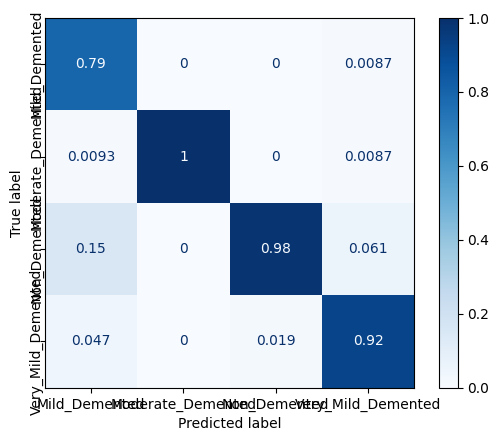

<Figure size 500x500 with 0 Axes>

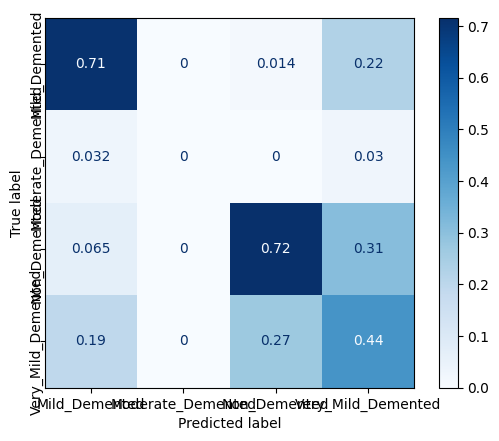

<Figure size 500x500 with 0 Axes>

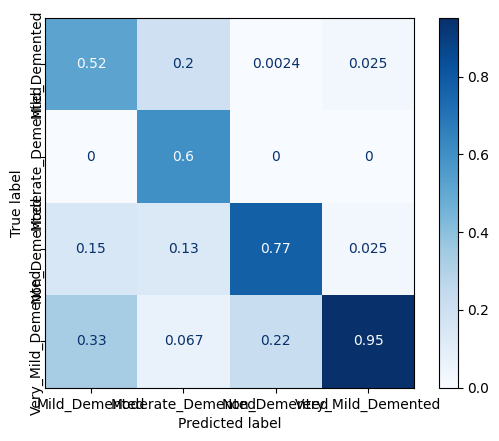

<Figure size 500x500 with 0 Axes>

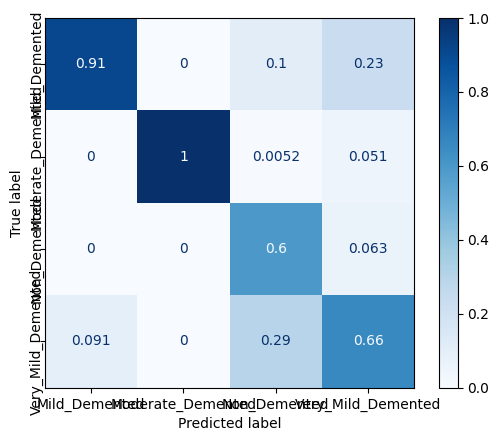

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r EfficientNetV2B3.zip ./*